<a href="https://colab.research.google.com/github/M-meghakumari/Assignment/blob/main/image_caption_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip -d all_images
!unzip Flickr8k_text.zip -d all_captions


Streaming output truncated to the last 5000 lines.
  inflating: all_images/Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: all_images/__MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: all_images/Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: all_images/__MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: all_images/Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: all_images/__MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: all_images/Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: all_images/__MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: all_images/Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: all_images/__MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: all_images/Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: all_images/__MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: all_images/Flicker8k_Dataset/3

In [ ]:
#importing the libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tqdm import tqdm
from keras.applications import vgg16
#from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.utils as image

from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import sentence_bleu
from numpy import array
import pickle
import numpy as np
import os
import cv2

In [ ]:
#converting the text files to pandas dataframe
image_tokens=pd.read_csv("all_captions/Flickr8k.lemma.token.txt",sep='\t',names=["img_id","img_caption"])
train_image_names=pd.read_csv("all_captions/Flickr_8k.trainImages.txt",names=["img_id"])
test_image_names=pd.read_csv("all_captions/Flickr_8k.testImages.txt",names=["img_id"])
val_image_names=pd.read_csv("all_captions/Flickr_8k.devImages.txt",names=["img_id"])

In [ ]:
#just checking the number of images in the dataset
l=os.listdir("all_images/Flicker8k_Dataset")
print(len(l))

8091


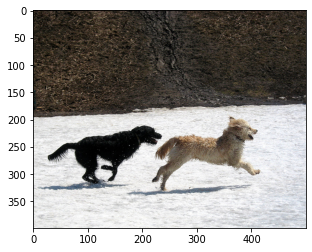

In [ ]:
#visualising one of the train images
img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" +train_image_names.img_id[0])
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [ ]:
#removing the #0,#1,#2,#3,#5 from the image ids
image_tokens["img_id"]=image_tokens["img_id"].map(lambda x: x[:len(x)-2])

In [ ]:
image_tokens["img_caption"]=image_tokens["img_caption"].map(lambda x: "<start> " + x.strip() + " <end>")


In [ ]:
#head of the image_tokens dataframe
image_tokens.head()

img_id  \
0  1305564994_00513f9a5b.jpg   
1  1305564994_00513f9a5b.jpg   
2  1305564994_00513f9a5b.jpg   
3  1305564994_00513f9a5b.jpg   
4  1305564994_00513f9a5b.jpg   

                                         img_caption  
0  <start> A man in street racer armor be examine...  
1  <start> Two racer drive a white bike down a ro...  
2  <start> Two motorist be ride along on their ve...  
3  <start> Two person be in a small race car driv...  
4  <start> Two person in race uniform in a street...

In [ ]:
#head of the train_image_names dataframe
train_image_names.head()

img_id
0  2513260012_03d33305cf.jpg
1  2903617548_d3e38d7f88.jpg
2  3338291921_fe7ae0c8f8.jpg
3   488416045_1c6d903fe0.jpg
4  2644326817_8f45080b87.jpg

In [ ]:
#creating train dictionary having key as the image id and value as a list of its captions
train_captions={}
for i in tqdm(range(len(train_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==train_image_names["img_id"].iloc[i]].img_caption)]
  train_captions[train_image_names["img_id"].iloc[i]]=l

100%|██████████| 6000/6000 [00:16<00:00, 353.01it/s]


In [ ]:
#creating test dictionary having key as the image id and value as a list of its captions
test_captions={}
for i in tqdm(range(len(test_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==test_image_names["img_id"].iloc[i]].img_caption)]
  test_captions[test_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:03<00:00, 299.45it/s]


In [ ]:
#creating validation dictionary having key as the image id and value as a list of its captions
validation_captions={}
for i in tqdm(range(len(val_image_names))):
  l=[caption for caption in(image_tokens[image_tokens["img_id"]==val_image_names["img_id"].iloc[i]].img_caption)]
  validation_captions[val_image_names["img_id"].iloc[i]]=l

100%|██████████| 1000/1000 [00:02<00:00, 375.81it/s]


In [ ]:
model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))
model.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict train_features
path="all_images/Flicker8k_Dataset/"
train_features={}
c=0
for image_name in tqdm(train_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  train_features[image_name]=features.squeeze()

  0%|          | 0/6000 [00:00<?, ?it/s]

1/1 [==============================] - 9s 9s/step


  0%|          | 1/6000 [00:09<15:12:12,  9.12s/it]

1/1 [==============================] - 0s 32ms/step


  0%|          | 3/6000 [00:09<4:01:59,  2.42s/it] 

1/1 [==============================] - 0s 24ms/step


  0%|          | 5/6000 [00:09<2:01:09,  1.21s/it]

1/1 [==============================] - 0s 25ms/step


  0%|          | 7/6000 [00:09<1:12:37,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 9/6000 [00:09<47:46,  2.09it/s]  

1/1 [==============================] - 0s 24ms/step


  0%|          | 11/6000 [00:09<33:24,  2.99it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 13/6000 [00:09<24:31,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 15/6000 [00:10<18:48,  5.30it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 17/6000 [00:10<14:59,  6.65it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 19/6000 [00:10<12:30,  7.97it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 21/6000 [00:10<10:45,  9.26it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 23/6000 [00:10<09:30, 10.47it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 25/6000 [00:10<08:42, 11.43it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 27/6000 [00:10<08:06, 12.27it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 29/6000 [00:11<07:42, 12.91it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 31/6000 [00:11<07:27, 13.35it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 33/6000 [00:11<07:34, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 35/6000 [00:11<07:17, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 37/6000 [00:11<07:08, 13.92it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 39/6000 [00:11<07:01, 14.16it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 41/6000 [00:11<07:03, 14.06it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 43/6000 [00:12<06:59, 14.22it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 45/6000 [00:12<06:49, 14.55it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 47/6000 [00:12<06:45, 14.69it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 49/6000 [00:12<06:54, 14.35it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 51/6000 [00:12<07:06, 13.96it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 53/6000 [00:12<06:59, 14.17it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 55/6000 [00:12<06:51, 14.43it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 57/6000 [00:13<06:54, 14.33it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 59/6000 [00:13<06:56, 14.27it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 61/6000 [00:13<09:37, 10.28it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 63/6000 [00:13<09:01, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 65/6000 [00:13<08:19, 11.88it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 67/6000 [00:13<07:53, 12.53it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 69/6000 [00:14<07:40, 12.89it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 71/6000 [00:14<07:20, 13.46it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 73/6000 [00:14<07:03, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 75/6000 [00:14<07:00, 14.09it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 77/6000 [00:14<07:09, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 79/6000 [00:14<07:04, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 81/6000 [00:14<06:56, 14.20it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 83/6000 [00:15<06:53, 14.32it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 85/6000 [00:15<06:46, 14.56it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 87/6000 [00:15<06:48, 14.49it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 89/6000 [00:15<07:03, 13.96it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 91/6000 [00:15<07:02, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 93/6000 [00:15<06:54, 14.25it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 95/6000 [00:15<06:57, 14.15it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 97/6000 [00:15<06:58, 14.09it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 99/6000 [00:16<06:55, 14.21it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 101/6000 [00:16<06:59, 14.07it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 103/6000 [00:16<07:16, 13.51it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 105/6000 [00:16<07:23, 13.30it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 107/6000 [00:16<07:18, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 109/6000 [00:16<07:05, 13.84it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 111/6000 [00:17<06:56, 14.13it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 113/6000 [00:17<07:00, 14.01it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 115/6000 [00:17<06:55, 14.16it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 117/6000 [00:17<07:01, 13.96it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 119/6000 [00:17<06:55, 14.15it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 121/6000 [00:17<06:55, 14.16it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 123/6000 [00:17<06:58, 14.03it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 125/6000 [00:18<07:02, 13.92it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 127/6000 [00:18<08:43, 11.21it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 129/6000 [00:18<10:06,  9.69it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 131/6000 [00:18<10:06,  9.68it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 133/6000 [00:18<10:33,  9.27it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 134/6000 [00:19<10:30,  9.30it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 135/6000 [00:19<10:28,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 136/6000 [00:19<10:27,  9.35it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 138/6000 [00:19<10:11,  9.59it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 139/6000 [00:19<10:20,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 140/6000 [00:19<10:28,  9.32it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 141/6000 [00:19<10:18,  9.47it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 142/6000 [00:19<10:21,  9.42it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 144/6000 [00:20<09:52,  9.88it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 146/6000 [00:20<08:46, 11.12it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 148/6000 [00:20<08:01, 12.16it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▎         | 150/6000 [00:20<07:38, 12.77it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 152/6000 [00:20<07:22, 13.21it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 154/6000 [00:20<07:08, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 156/6000 [00:20<07:03, 13.79it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 158/6000 [00:21<06:59, 13.91it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 160/6000 [00:21<06:57, 13.98it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 162/6000 [00:21<06:49, 14.24it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 164/6000 [00:21<06:46, 14.35it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 166/6000 [00:21<06:50, 14.20it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 168/6000 [00:21<07:00, 13.86it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 170/6000 [00:21<06:54, 14.08it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 172/6000 [00:22<06:57, 13.96it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 174/6000 [00:22<06:52, 14.12it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 176/6000 [00:22<06:53, 14.07it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 178/6000 [00:22<06:51, 14.14it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 180/6000 [00:22<06:56, 13.97it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 182/6000 [00:22<06:54, 14.03it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 184/6000 [00:22<06:51, 14.13it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 186/6000 [00:23<06:54, 14.02it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 188/6000 [00:23<06:53, 14.05it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 190/6000 [00:23<06:46, 14.28it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 192/6000 [00:23<06:43, 14.41it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 194/6000 [00:23<06:53, 14.04it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 196/6000 [00:23<06:52, 14.08it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 198/6000 [00:23<06:50, 14.13it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 200/6000 [00:24<06:49, 14.15it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 202/6000 [00:24<06:48, 14.21it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 204/6000 [00:24<06:57, 13.90it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 206/6000 [00:24<06:56, 13.90it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 208/6000 [00:24<06:57, 13.88it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 210/6000 [00:24<07:01, 13.73it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 212/6000 [00:24<06:59, 13.80it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 214/6000 [00:25<06:57, 13.86it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 216/6000 [00:25<07:08, 13.50it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 218/6000 [00:25<06:57, 13.84it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 220/6000 [00:25<06:59, 13.79it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 222/6000 [00:25<07:07, 13.50it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 224/6000 [00:25<07:00, 13.73it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 226/6000 [00:25<07:06, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 228/6000 [00:26<07:06, 13.55it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 230/6000 [00:26<07:08, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 232/6000 [00:26<06:57, 13.82it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 234/6000 [00:26<07:11, 13.38it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 236/6000 [00:26<07:27, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 238/6000 [00:26<07:18, 13.14it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 240/6000 [00:27<07:18, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 242/6000 [00:27<07:10, 13.36it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 244/6000 [00:27<07:03, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 246/6000 [00:27<06:58, 13.75it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 248/6000 [00:27<07:02, 13.61it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 250/6000 [00:27<07:01, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 252/6000 [00:27<06:58, 13.73it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 254/6000 [00:28<06:51, 13.98it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 256/6000 [00:28<06:52, 13.91it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 258/6000 [00:28<06:57, 13.76it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 260/6000 [00:28<06:56, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 262/6000 [00:28<06:49, 14.00it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 264/6000 [00:28<06:55, 13.81it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 266/6000 [00:28<06:57, 13.74it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 268/6000 [00:29<06:51, 13.94it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 270/6000 [00:29<06:44, 14.15it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 272/6000 [00:29<06:39, 14.35it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 274/6000 [00:29<07:16, 13.11it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 276/6000 [00:29<07:11, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 278/6000 [00:29<07:07, 13.37it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 280/6000 [00:29<07:01, 13.58it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 282/6000 [00:30<06:58, 13.65it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 284/6000 [00:30<08:06, 11.74it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 286/6000 [00:30<08:41, 10.95it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 288/6000 [00:30<08:46, 10.86it/s]

1/1 [==============================] - 0s 191ms/step


  5%|▍         | 290/6000 [00:31<13:31,  7.04it/s]

1/1 [==============================] - 0s 155ms/step


  5%|▍         | 291/6000 [00:31<19:15,  4.94it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 292/6000 [00:31<18:41,  5.09it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 293/6000 [00:32<17:49,  5.34it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 294/6000 [00:32<16:12,  5.87it/s]

1/1 [==============================] - 0s 91ms/step


  5%|▍         | 295/6000 [00:32<15:53,  5.98it/s]

1/1 [==============================] - 0s 109ms/step


  5%|▍         | 296/6000 [00:32<19:19,  4.92it/s]

1/1 [==============================] - 0s 65ms/step


  5%|▍         | 297/6000 [00:32<20:35,  4.62it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 299/6000 [00:33<14:25,  6.59it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 301/6000 [00:33<11:26,  8.30it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 303/6000 [00:33<09:49,  9.67it/s]

1/1 [==============================] - 0s 95ms/step


  5%|▌         | 305/6000 [00:33<11:19,  8.38it/s]

1/1 [==============================] - 0s 98ms/step


  5%|▌         | 306/6000 [00:33<14:03,  6.75it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 308/6000 [00:34<11:51,  8.00it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 310/6000 [00:34<10:15,  9.25it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 312/6000 [00:34<09:18, 10.18it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 314/6000 [00:34<08:27, 11.19it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 316/6000 [00:34<07:53, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 318/6000 [00:34<07:28, 12.68it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 320/6000 [00:34<07:33, 12.52it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 322/6000 [00:35<07:16, 13.00it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 324/6000 [00:35<07:00, 13.49it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 326/6000 [00:35<06:57, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 328/6000 [00:35<06:55, 13.67it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 330/6000 [00:35<07:04, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 332/6000 [00:35<06:55, 13.66it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 334/6000 [00:35<06:56, 13.61it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 336/6000 [00:36<06:52, 13.75it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 338/6000 [00:36<06:57, 13.56it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 340/6000 [00:36<06:53, 13.67it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 342/6000 [00:36<06:57, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 344/6000 [00:36<06:43, 14.01it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 346/6000 [00:36<06:45, 13.96it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 348/6000 [00:36<07:01, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 350/6000 [00:37<06:58, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 352/6000 [00:37<06:58, 13.50it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 354/6000 [00:37<06:52, 13.69it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 356/6000 [00:37<07:04, 13.30it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 358/6000 [00:37<07:00, 13.42it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 360/6000 [00:37<06:54, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 362/6000 [00:38<07:00, 13.39it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 364/6000 [00:38<06:51, 13.68it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 366/6000 [00:38<06:59, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 368/6000 [00:38<06:56, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 370/6000 [00:38<06:48, 13.78it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 372/6000 [00:38<06:50, 13.71it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 374/6000 [00:38<06:48, 13.78it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▋         | 376/6000 [00:39<08:10, 11.46it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 378/6000 [00:39<08:32, 10.98it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 380/6000 [00:39<08:39, 10.82it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 382/6000 [00:39<08:40, 10.80it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▋         | 384/6000 [00:39<09:09, 10.23it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▋         | 386/6000 [00:40<09:53,  9.45it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 388/6000 [00:40<09:42,  9.63it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 389/6000 [00:40<09:41,  9.66it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▋         | 390/6000 [00:40<10:25,  8.97it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 391/6000 [00:40<11:03,  8.46it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 392/6000 [00:40<10:47,  8.66it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 393/6000 [00:40<10:46,  8.67it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 394/6000 [00:41<11:02,  8.46it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 396/6000 [00:41<09:27,  9.87it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 398/6000 [00:41<08:38, 10.80it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 400/6000 [00:41<07:56, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 402/6000 [00:41<07:39, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 404/6000 [00:41<07:24, 12.60it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 406/6000 [00:41<07:08, 13.07it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 408/6000 [00:42<07:08, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 410/6000 [00:42<07:04, 13.17it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 412/6000 [00:42<07:48, 11.92it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 414/6000 [00:42<08:25, 11.06it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 416/6000 [00:42<08:37, 10.80it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 418/6000 [00:43<08:58, 10.36it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 420/6000 [00:43<09:50,  9.46it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 421/6000 [00:43<09:54,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 423/6000 [00:43<09:39,  9.63it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 424/6000 [00:43<09:37,  9.65it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 426/6000 [00:43<09:26,  9.83it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 427/6000 [00:44<09:35,  9.68it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 428/6000 [00:44<10:10,  9.12it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 429/6000 [00:44<10:35,  8.77it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 430/6000 [00:44<10:24,  8.91it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 431/6000 [00:44<10:36,  8.74it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 433/6000 [00:44<09:16, 10.01it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 435/6000 [00:44<08:13, 11.27it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 437/6000 [00:45<07:48, 11.88it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 439/6000 [00:45<07:50, 11.81it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 441/6000 [00:45<07:29, 12.37it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 443/6000 [00:45<07:12, 12.85it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 445/6000 [00:45<07:01, 13.18it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 447/6000 [00:45<07:05, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 449/6000 [00:45<07:01, 13.18it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 451/6000 [00:46<06:55, 13.37it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 453/6000 [00:46<06:52, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 455/6000 [00:46<06:53, 13.42it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 457/6000 [00:46<06:51, 13.47it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 459/6000 [00:46<06:45, 13.67it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 461/6000 [00:46<06:54, 13.37it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 463/6000 [00:46<06:57, 13.27it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 465/6000 [00:47<07:02, 13.11it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 467/6000 [00:47<07:15, 12.69it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 469/6000 [00:47<07:07, 12.94it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 471/6000 [00:47<07:02, 13.09it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 473/6000 [00:47<06:57, 13.24it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 475/6000 [00:47<07:03, 13.03it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 477/6000 [00:48<06:57, 13.22it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 479/6000 [00:48<07:02, 13.06it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 481/6000 [00:48<07:01, 13.10it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 483/6000 [00:48<07:06, 12.93it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 485/6000 [00:48<06:58, 13.17it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 487/6000 [00:48<06:52, 13.37it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 489/6000 [00:48<06:46, 13.57it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 491/6000 [00:49<06:46, 13.56it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 493/6000 [00:49<07:00, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 495/6000 [00:49<06:59, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 497/6000 [00:49<06:52, 13.33it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 499/6000 [00:49<06:44, 13.59it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 501/6000 [00:49<06:40, 13.74it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 503/6000 [00:50<06:52, 13.33it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 505/6000 [00:50<06:48, 13.46it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 507/6000 [00:50<06:53, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 509/6000 [00:50<06:47, 13.47it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 511/6000 [00:50<07:02, 13.00it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 513/6000 [00:50<06:55, 13.22it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 515/6000 [00:50<06:50, 13.35it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 517/6000 [00:51<06:46, 13.49it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 519/6000 [00:51<06:43, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 521/6000 [00:51<07:00, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 523/6000 [00:51<06:47, 13.44it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 525/6000 [00:51<06:41, 13.62it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 527/6000 [00:51<06:38, 13.72it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 529/6000 [00:51<06:47, 13.43it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 531/6000 [00:52<06:41, 13.61it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 533/6000 [00:52<06:40, 13.65it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 535/6000 [00:52<06:44, 13.51it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 537/6000 [00:52<06:54, 13.18it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 539/6000 [00:52<07:02, 12.91it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 541/6000 [00:52<06:55, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 543/6000 [00:52<06:53, 13.20it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 545/6000 [00:53<06:50, 13.30it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 547/6000 [00:53<06:56, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 549/6000 [00:53<06:55, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 551/6000 [00:53<06:45, 13.43it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 553/6000 [00:53<06:44, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 555/6000 [00:53<06:46, 13.39it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 557/6000 [00:54<07:26, 12.19it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 559/6000 [00:54<07:17, 12.43it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 561/6000 [00:54<07:09, 12.66it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 563/6000 [00:54<07:01, 12.89it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 565/6000 [00:54<07:26, 12.18it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 567/6000 [00:54<08:13, 11.00it/s]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 569/6000 [00:55<08:30, 10.65it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 571/6000 [00:55<08:37, 10.49it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 573/6000 [00:55<08:59, 10.05it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 575/6000 [00:55<09:48,  9.21it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 576/6000 [00:55<09:49,  9.21it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 577/6000 [00:56<09:52,  9.15it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 579/6000 [00:56<09:28,  9.53it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 580/6000 [00:56<09:45,  9.26it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 581/6000 [00:56<09:50,  9.18it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 582/6000 [00:56<10:01,  9.00it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 583/6000 [00:56<09:57,  9.06it/s]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 584/6000 [00:56<09:49,  9.18it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 586/6000 [00:56<08:41, 10.37it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 588/6000 [00:57<07:49, 11.53it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 590/6000 [00:57<07:20, 12.27it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 592/6000 [00:57<07:12, 12.49it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 594/6000 [00:57<07:05, 12.71it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 596/6000 [00:57<07:01, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 598/6000 [00:57<06:56, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 600/6000 [00:58<06:51, 13.14it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 602/6000 [00:58<06:55, 12.98it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 604/6000 [00:58<06:46, 13.26it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 606/6000 [00:58<06:46, 13.27it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 608/6000 [00:58<06:36, 13.59it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 610/6000 [00:58<06:36, 13.59it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 612/6000 [00:58<06:45, 13.30it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 614/6000 [00:59<06:36, 13.57it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 616/6000 [00:59<06:33, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 618/6000 [00:59<06:34, 13.63it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 620/6000 [00:59<06:50, 13.11it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 622/6000 [00:59<06:46, 13.24it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 624/6000 [00:59<06:46, 13.23it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 626/6000 [00:59<06:42, 13.35it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 628/6000 [01:00<06:40, 13.40it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 630/6000 [01:00<07:04, 12.65it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 632/6000 [01:00<07:00, 12.78it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 634/6000 [01:00<06:56, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 636/6000 [01:00<06:48, 13.12it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 638/6000 [01:00<06:50, 13.07it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 640/6000 [01:01<06:47, 13.16it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 642/6000 [01:01<06:48, 13.11it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 644/6000 [01:01<06:43, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 646/6000 [01:01<06:42, 13.31it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 648/6000 [01:01<06:56, 12.84it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 650/6000 [01:01<06:47, 13.14it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 652/6000 [01:01<06:47, 13.12it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 654/6000 [01:02<06:46, 13.16it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 656/6000 [01:02<06:54, 12.88it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 658/6000 [01:02<06:51, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 660/6000 [01:02<06:52, 12.95it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 662/6000 [01:02<06:48, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 664/6000 [01:02<06:49, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 666/6000 [01:03<06:51, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 668/6000 [01:03<06:48, 13.06it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 670/6000 [01:03<06:49, 13.02it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 672/6000 [01:03<06:56, 12.79it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 674/6000 [01:03<07:06, 12.50it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 676/6000 [01:03<06:53, 12.89it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 678/6000 [01:03<06:45, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 680/6000 [01:04<06:38, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 682/6000 [01:04<06:30, 13.61it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 684/6000 [01:04<06:42, 13.20it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 686/6000 [01:04<06:38, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 688/6000 [01:04<06:43, 13.17it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 690/6000 [01:04<06:49, 12.97it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 692/6000 [01:05<06:53, 12.85it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 694/6000 [01:05<06:55, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 696/6000 [01:05<06:52, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 698/6000 [01:05<06:41, 13.20it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 700/6000 [01:05<06:46, 13.04it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 702/6000 [01:05<06:51, 12.86it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 704/6000 [01:05<06:48, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 706/6000 [01:06<06:48, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 708/6000 [01:06<06:40, 13.20it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 710/6000 [01:06<06:49, 12.92it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 712/6000 [01:06<07:28, 11.79it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 714/6000 [01:06<07:11, 12.25it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 716/6000 [01:06<07:56, 11.09it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 718/6000 [01:07<08:27, 10.40it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 720/6000 [01:07<08:53,  9.90it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 722/6000 [01:07<09:15,  9.49it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 723/6000 [01:07<09:45,  9.01it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 724/6000 [01:07<10:36,  8.29it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 725/6000 [01:08<10:20,  8.50it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 726/6000 [01:08<10:28,  8.39it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 727/6000 [01:08<10:11,  8.63it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 728/6000 [01:08<10:19,  8.51it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 729/6000 [01:08<10:22,  8.47it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 730/6000 [01:08<10:08,  8.66it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 731/6000 [01:08<10:26,  8.41it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 732/6000 [01:08<10:00,  8.77it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 733/6000 [01:08<09:54,  8.86it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 734/6000 [01:09<09:47,  8.97it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 735/6000 [01:09<09:50,  8.92it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 737/6000 [01:09<08:50,  9.93it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 739/6000 [01:09<07:57, 11.03it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 741/6000 [01:09<07:24, 11.83it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 743/6000 [01:09<07:11, 12.17it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 745/6000 [01:09<06:59, 12.54it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 747/6000 [01:10<07:29, 11.69it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 749/6000 [01:10<07:18, 11.97it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 751/6000 [01:10<07:03, 12.39it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 753/6000 [01:10<06:51, 12.74it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 755/6000 [01:10<06:47, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 757/6000 [01:10<06:45, 12.92it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 759/6000 [01:11<06:42, 13.03it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 761/6000 [01:11<06:46, 12.89it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 763/6000 [01:11<06:43, 12.98it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 765/6000 [01:11<06:50, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 767/6000 [01:11<06:47, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 769/6000 [01:11<06:44, 12.94it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 771/6000 [01:12<07:11, 12.11it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 773/6000 [01:12<07:02, 12.37it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 775/6000 [01:12<06:53, 12.63it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 777/6000 [01:12<06:46, 12.84it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 779/6000 [01:12<06:48, 12.77it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 781/6000 [01:12<06:48, 12.77it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 783/6000 [01:12<06:52, 12.66it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 785/6000 [01:13<06:55, 12.55it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 787/6000 [01:13<06:51, 12.67it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 789/6000 [01:13<06:43, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 791/6000 [01:13<06:42, 12.95it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 793/6000 [01:13<06:42, 12.95it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 795/6000 [01:13<06:48, 12.75it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 797/6000 [01:14<06:45, 12.84it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 799/6000 [01:14<06:37, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 801/6000 [01:14<06:42, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 803/6000 [01:14<06:43, 12.87it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 805/6000 [01:14<06:36, 13.09it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 807/6000 [01:14<06:35, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 809/6000 [01:14<06:33, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 811/6000 [01:15<06:32, 13.21it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 813/6000 [01:15<06:35, 13.13it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 815/6000 [01:15<06:28, 13.34it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 817/6000 [01:15<06:32, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 819/6000 [01:15<06:33, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 821/6000 [01:15<06:39, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 823/6000 [01:16<06:36, 13.06it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 825/6000 [01:16<06:31, 13.21it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 827/6000 [01:16<06:27, 13.35it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 829/6000 [01:16<06:40, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 831/6000 [01:16<06:34, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 833/6000 [01:16<06:32, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 835/6000 [01:16<06:34, 13.10it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 837/6000 [01:17<06:45, 12.74it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 839/6000 [01:17<06:49, 12.59it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 841/6000 [01:17<07:02, 12.20it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 843/6000 [01:17<07:02, 12.20it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 845/6000 [01:17<07:03, 12.19it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 847/6000 [01:17<07:01, 12.23it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 849/6000 [01:18<06:54, 12.41it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 851/6000 [01:18<06:40, 12.85it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 853/6000 [01:18<06:34, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 855/6000 [01:18<06:44, 12.73it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 857/6000 [01:18<06:33, 13.07it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 859/6000 [01:18<06:31, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 861/6000 [01:19<06:33, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 863/6000 [01:19<06:29, 13.20it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 865/6000 [01:19<07:13, 11.84it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 867/6000 [01:19<07:44, 11.06it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 869/6000 [01:19<08:16, 10.33it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 871/6000 [01:20<08:42,  9.82it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 873/6000 [01:20<09:05,  9.40it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 874/6000 [01:20<09:12,  9.27it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 875/6000 [01:20<09:18,  9.18it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 876/6000 [01:20<09:57,  8.58it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 877/6000 [01:20<09:36,  8.88it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 878/6000 [01:20<09:24,  9.08it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 879/6000 [01:20<09:24,  9.07it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 881/6000 [01:21<08:59,  9.49it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 882/6000 [01:21<09:10,  9.29it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 883/6000 [01:21<10:08,  8.41it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 884/6000 [01:21<10:07,  8.42it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 885/6000 [01:21<09:56,  8.57it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 887/6000 [01:21<08:31,  9.99it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 889/6000 [01:21<07:29, 11.37it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 891/6000 [01:22<07:17, 11.68it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 893/6000 [01:22<06:57, 12.23it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 895/6000 [01:22<06:48, 12.50it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 897/6000 [01:22<06:34, 12.95it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 899/6000 [01:22<06:24, 13.28it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 901/6000 [01:22<06:27, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 903/6000 [01:23<06:27, 13.16it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 905/6000 [01:23<06:32, 12.99it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 907/6000 [01:23<06:33, 12.95it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 909/6000 [01:23<06:36, 12.85it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 911/6000 [01:23<06:34, 12.90it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 913/6000 [01:23<06:28, 13.10it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 915/6000 [01:23<06:27, 13.11it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 917/6000 [01:24<06:28, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 919/6000 [01:24<06:35, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 921/6000 [01:24<06:37, 12.77it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 923/6000 [01:24<06:31, 12.98it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 925/6000 [01:24<06:27, 13.11it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 927/6000 [01:24<06:30, 13.00it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 929/6000 [01:25<06:35, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 931/6000 [01:25<06:32, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 933/6000 [01:25<06:27, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 935/6000 [01:25<06:18, 13.37it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 937/6000 [01:25<06:31, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 939/6000 [01:25<06:33, 12.85it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 941/6000 [01:25<06:32, 12.89it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 943/6000 [01:26<06:34, 12.82it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 945/6000 [01:26<06:44, 12.50it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 947/6000 [01:26<10:33,  7.97it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 949/6000 [01:26<09:43,  8.66it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 951/6000 [01:27<09:07,  9.22it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 953/6000 [01:27<08:56,  9.41it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 955/6000 [01:27<08:32,  9.85it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 957/6000 [01:27<08:07, 10.35it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 959/6000 [01:27<07:53, 10.65it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 961/6000 [01:27<07:34, 11.08it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 963/6000 [01:28<07:38, 10.99it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 965/6000 [01:28<07:27, 11.26it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 967/6000 [01:28<07:26, 11.26it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 969/6000 [01:28<07:25, 11.28it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 971/6000 [01:28<07:21, 11.38it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 973/6000 [01:29<07:24, 11.31it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 975/6000 [01:29<07:18, 11.45it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 977/6000 [01:29<07:51, 10.64it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 979/6000 [01:29<07:33, 11.06it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 981/6000 [01:29<07:28, 11.20it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 983/6000 [01:29<07:24, 11.29it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 985/6000 [01:30<07:23, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 987/6000 [01:30<07:21, 11.34it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 989/6000 [01:30<07:19, 11.40it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 991/6000 [01:30<07:21, 11.34it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 993/6000 [01:30<07:12, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 995/6000 [01:30<07:00, 11.89it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 997/6000 [01:31<07:00, 11.90it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 999/6000 [01:31<07:08, 11.67it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1001/6000 [01:31<07:02, 11.83it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1003/6000 [01:31<06:57, 11.96it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1005/6000 [01:31<07:53, 10.54it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 1007/6000 [01:32<08:15, 10.08it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1009/6000 [01:32<09:07,  9.11it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1010/6000 [01:32<09:27,  8.80it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 1011/6000 [01:32<09:59,  8.32it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 1012/6000 [01:32<09:57,  8.35it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1013/6000 [01:32<09:44,  8.53it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1014/6000 [01:32<09:32,  8.71it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1015/6000 [01:33<09:27,  8.78it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1016/6000 [01:33<09:18,  8.92it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1017/6000 [01:33<09:38,  8.61it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 1018/6000 [01:33<10:06,  8.21it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 1019/6000 [01:33<09:55,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 1020/6000 [01:33<09:53,  8.40it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 1021/6000 [01:33<09:44,  8.52it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1022/6000 [01:33<09:55,  8.36it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 1023/6000 [01:34<10:52,  7.62it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1025/6000 [01:34<08:55,  9.29it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1026/6000 [01:34<08:46,  9.45it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1028/6000 [01:34<08:12, 10.09it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1030/6000 [01:34<07:35, 10.91it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1032/6000 [01:34<07:28, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1034/6000 [01:35<07:10, 11.53it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1036/6000 [01:35<07:02, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1038/6000 [01:35<07:01, 11.78it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1040/6000 [01:35<06:49, 12.10it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1042/6000 [01:35<06:46, 12.21it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1044/6000 [01:35<06:44, 12.24it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1046/6000 [01:36<06:37, 12.47it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1048/6000 [01:36<06:42, 12.31it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1050/6000 [01:36<06:36, 12.49it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1052/6000 [01:36<06:43, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1054/6000 [01:36<06:46, 12.17it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1056/6000 [01:36<06:34, 12.52it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1058/6000 [01:36<06:29, 12.69it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1060/6000 [01:37<06:26, 12.79it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1062/6000 [01:37<06:39, 12.35it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1064/6000 [01:37<06:36, 12.44it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1066/6000 [01:37<06:39, 12.35it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1068/6000 [01:37<06:33, 12.54it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1070/6000 [01:37<06:21, 12.91it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1072/6000 [01:38<06:33, 12.51it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1074/6000 [01:38<06:31, 12.57it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1076/6000 [01:38<06:31, 12.59it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1078/6000 [01:38<06:24, 12.82it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1080/6000 [01:38<06:26, 12.73it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1082/6000 [01:38<06:22, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1084/6000 [01:39<06:22, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1086/6000 [01:39<06:15, 13.10it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1088/6000 [01:39<06:22, 12.85it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1090/6000 [01:39<06:34, 12.43it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1092/6000 [01:39<06:28, 12.63it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1094/6000 [01:39<06:28, 12.62it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1096/6000 [01:39<06:16, 13.04it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1098/6000 [01:40<06:22, 12.81it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1100/6000 [01:40<06:18, 12.94it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1102/6000 [01:40<06:26, 12.66it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1104/6000 [01:40<06:20, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1106/6000 [01:40<06:19, 12.90it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1108/6000 [01:40<06:23, 12.77it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1110/6000 [01:41<06:20, 12.84it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 1112/6000 [01:41<06:23, 12.76it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1114/6000 [01:41<06:20, 12.84it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1116/6000 [01:41<06:35, 12.35it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1118/6000 [01:41<06:25, 12.68it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1120/6000 [01:41<06:27, 12.61it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1122/6000 [01:41<06:20, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1124/6000 [01:42<06:20, 12.82it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1126/6000 [01:42<06:30, 12.48it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1128/6000 [01:42<06:27, 12.58it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1130/6000 [01:42<06:29, 12.51it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1132/6000 [01:42<06:19, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1134/6000 [01:42<06:18, 12.86it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1136/6000 [01:43<06:19, 12.83it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1138/6000 [01:43<06:19, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1140/6000 [01:43<06:16, 12.89it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1142/6000 [01:43<06:25, 12.60it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1144/6000 [01:43<06:27, 12.52it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1146/6000 [01:43<06:21, 12.74it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1148/6000 [01:44<06:18, 12.82it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 1150/6000 [01:44<07:12, 11.21it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▉        | 1152/6000 [01:44<08:16,  9.76it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 1154/6000 [01:44<08:31,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1156/6000 [01:44<08:17,  9.75it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 1158/6000 [01:45<08:32,  9.46it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▉        | 1159/6000 [01:45<08:31,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 1160/6000 [01:45<08:31,  9.46it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 1161/6000 [01:45<08:41,  9.28it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1162/6000 [01:45<08:59,  8.97it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 1163/6000 [01:45<09:01,  8.93it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 1164/6000 [01:45<09:02,  8.92it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 1165/6000 [01:45<08:59,  8.96it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 1166/6000 [01:46<08:51,  9.09it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1167/6000 [01:46<08:48,  9.14it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 1168/6000 [01:46<08:51,  9.09it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 1169/6000 [01:46<09:10,  8.77it/s]

1/1 [==============================] - 0s 40ms/step


 20%|█▉        | 1170/6000 [01:46<09:03,  8.89it/s]

1/1 [==============================] - 0s 44ms/step


 20%|█▉        | 1171/6000 [01:46<09:08,  8.80it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 1172/6000 [01:46<09:08,  8.81it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 1174/6000 [01:46<07:40, 10.49it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1176/6000 [01:47<07:13, 11.12it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1178/6000 [01:47<07:03, 11.38it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1180/6000 [01:47<07:32, 10.65it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1182/6000 [01:47<07:30, 10.70it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1184/6000 [01:47<07:52, 10.19it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1186/6000 [01:47<07:18, 10.97it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1188/6000 [01:48<06:58, 11.51it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1190/6000 [01:48<06:54, 11.61it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1192/6000 [01:48<06:43, 11.93it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1194/6000 [01:48<06:35, 12.15it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1196/6000 [01:48<06:26, 12.44it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1198/6000 [01:48<06:27, 12.38it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1200/6000 [01:49<06:20, 12.61it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1202/6000 [01:49<06:13, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1204/6000 [01:49<06:09, 12.99it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1206/6000 [01:49<06:09, 12.96it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 1208/6000 [01:49<06:20, 12.61it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1210/6000 [01:49<06:18, 12.66it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1212/6000 [01:50<06:16, 12.72it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1214/6000 [01:50<06:12, 12.86it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1216/6000 [01:50<06:22, 12.52it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1218/6000 [01:50<06:19, 12.59it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1220/6000 [01:50<06:11, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1222/6000 [01:50<06:11, 12.85it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1224/6000 [01:50<06:11, 12.84it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1226/6000 [01:51<06:14, 12.75it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1228/6000 [01:51<06:09, 12.90it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1230/6000 [01:51<06:07, 12.97it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1232/6000 [01:51<06:08, 12.95it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1234/6000 [01:51<06:11, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1236/6000 [01:51<06:13, 12.77it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1238/6000 [01:52<06:39, 11.92it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1240/6000 [01:52<06:26, 12.33it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1242/6000 [01:52<06:27, 12.28it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1244/6000 [01:52<06:26, 12.32it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1246/6000 [01:52<06:23, 12.40it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1248/6000 [01:52<06:20, 12.50it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1250/6000 [01:53<06:16, 12.61it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1252/6000 [01:53<06:33, 12.05it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1254/6000 [01:53<06:24, 12.34it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1256/6000 [01:53<06:22, 12.39it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1258/6000 [01:53<06:20, 12.47it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1260/6000 [01:53<06:18, 12.52it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1262/6000 [01:54<06:25, 12.29it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1264/6000 [01:54<06:19, 12.49it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1266/6000 [01:54<06:17, 12.54it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1268/6000 [01:54<06:39, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1270/6000 [01:54<06:40, 11.80it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1272/6000 [01:54<06:44, 11.69it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1274/6000 [01:55<06:36, 11.92it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1276/6000 [01:55<06:30, 12.08it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 1278/6000 [01:55<06:23, 12.30it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1280/6000 [01:55<06:27, 12.17it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 1282/6000 [01:55<06:20, 12.40it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 1284/6000 [01:55<06:16, 12.53it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 1286/6000 [01:55<06:16, 12.54it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1288/6000 [01:56<06:16, 12.50it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1290/6000 [01:56<06:15, 12.55it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1292/6000 [01:56<06:12, 12.63it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1294/6000 [01:56<06:10, 12.71it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 1296/6000 [01:56<06:18, 12.43it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1298/6000 [01:57<07:18, 10.73it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1300/6000 [01:57<07:36, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1302/6000 [01:57<07:49, 10.01it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1304/6000 [01:57<07:54,  9.89it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 1306/6000 [01:57<08:37,  9.08it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1307/6000 [01:58<08:42,  8.98it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 1308/6000 [01:58<08:57,  8.74it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1309/6000 [01:58<08:51,  8.82it/s]

1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1310/6000 [01:58<09:01,  8.66it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 1311/6000 [01:58<08:59,  8.69it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 1312/6000 [01:58<09:20,  8.36it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1313/6000 [01:58<09:14,  8.45it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1314/6000 [01:58<08:50,  8.83it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 1315/6000 [01:58<09:03,  8.63it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 1316/6000 [01:59<09:17,  8.40it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1317/6000 [01:59<08:58,  8.69it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1318/6000 [01:59<08:46,  8.89it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1320/6000 [01:59<07:30, 10.40it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1322/6000 [01:59<07:02, 11.08it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1324/6000 [01:59<06:44, 11.57it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1326/6000 [01:59<06:34, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1328/6000 [02:00<06:38, 11.73it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1330/6000 [02:00<06:28, 12.02it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1332/6000 [02:00<06:22, 12.20it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1334/6000 [02:00<06:22, 12.21it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1336/6000 [02:00<06:11, 12.54it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1338/6000 [02:00<06:09, 12.61it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1340/6000 [02:01<06:08, 12.65it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1342/6000 [02:01<06:06, 12.72it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1344/6000 [02:01<06:11, 12.53it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1346/6000 [02:01<06:05, 12.72it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1348/6000 [02:01<06:05, 12.71it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▎       | 1350/6000 [02:01<06:02, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1352/6000 [02:02<06:02, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1354/6000 [02:02<06:12, 12.46it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1356/6000 [02:02<06:12, 12.47it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1358/6000 [02:02<06:06, 12.67it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1360/6000 [02:02<06:03, 12.76it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1362/6000 [02:02<06:10, 12.52it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1364/6000 [02:02<06:02, 12.78it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1366/6000 [02:03<06:03, 12.76it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1368/6000 [02:03<06:01, 12.80it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1370/6000 [02:03<06:01, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1372/6000 [02:03<06:06, 12.62it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1374/6000 [02:03<05:57, 12.95it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1376/6000 [02:03<06:01, 12.81it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1378/6000 [02:04<06:00, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1380/6000 [02:04<06:03, 12.70it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1382/6000 [02:04<06:05, 12.65it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1384/6000 [02:04<06:05, 12.62it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1386/6000 [02:04<06:09, 12.49it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1388/6000 [02:04<06:27, 11.90it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1390/6000 [02:05<06:26, 11.93it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1392/6000 [02:05<06:30, 11.81it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1394/6000 [02:05<06:19, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1396/6000 [02:05<06:32, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1398/6000 [02:05<06:27, 11.87it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1400/6000 [02:05<06:33, 11.68it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1402/6000 [02:06<06:20, 12.10it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1404/6000 [02:06<06:19, 12.12it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1406/6000 [02:06<06:20, 12.08it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1408/6000 [02:06<06:14, 12.27it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 1410/6000 [02:06<06:09, 12.43it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 1412/6000 [02:06<06:14, 12.25it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 1414/6000 [02:07<06:11, 12.34it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1416/6000 [02:07<06:20, 12.05it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1418/6000 [02:07<06:12, 12.28it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 1420/6000 [02:07<06:16, 12.15it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 1422/6000 [02:07<06:11, 12.32it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1424/6000 [02:07<06:05, 12.53it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1426/6000 [02:08<06:09, 12.39it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1428/6000 [02:08<06:12, 12.28it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1430/6000 [02:08<06:05, 12.50it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1432/6000 [02:08<06:00, 12.67it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1434/6000 [02:08<06:08, 12.38it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1436/6000 [02:08<06:02, 12.60it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1438/6000 [02:08<06:04, 12.52it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1440/6000 [02:09<06:07, 12.42it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1442/6000 [02:09<06:03, 12.54it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 1444/6000 [02:09<06:50, 11.10it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1446/6000 [02:09<07:15, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1448/6000 [02:09<07:36,  9.97it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1450/6000 [02:10<08:01,  9.46it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1451/6000 [02:10<08:21,  9.07it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1452/6000 [02:10<08:24,  9.01it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 1453/6000 [02:10<08:27,  8.96it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1454/6000 [02:10<08:22,  9.04it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1456/6000 [02:10<08:11,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1457/6000 [02:10<08:10,  9.27it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1458/6000 [02:11<08:02,  9.42it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 1460/6000 [02:11<08:07,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1461/6000 [02:11<08:40,  8.73it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1462/6000 [02:11<08:42,  8.68it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1463/6000 [02:11<08:44,  8.65it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1464/6000 [02:11<08:32,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1465/6000 [02:11<08:18,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1466/6000 [02:11<08:18,  9.09it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1467/6000 [02:12<08:38,  8.75it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1469/6000 [02:12<07:31, 10.03it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1471/6000 [02:12<07:04, 10.68it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 1473/6000 [02:12<06:36, 11.41it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 1475/6000 [02:12<06:26, 11.71it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 1477/6000 [02:12<06:09, 12.25it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1479/6000 [02:13<06:19, 11.91it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 1481/6000 [02:13<06:17, 11.96it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 1483/6000 [02:13<06:09, 12.23it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 1485/6000 [02:13<06:02, 12.47it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 1487/6000 [02:13<05:57, 12.63it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 1489/6000 [02:13<06:04, 12.39it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 1491/6000 [02:14<06:27, 11.63it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1493/6000 [02:14<06:16, 11.97it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1495/6000 [02:14<06:14, 12.02it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1497/6000 [02:14<06:13, 12.05it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 1499/6000 [02:14<06:12, 12.09it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1501/6000 [02:14<06:07, 12.25it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1503/6000 [02:15<06:07, 12.24it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 1505/6000 [02:15<06:04, 12.34it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 1507/6000 [02:15<06:37, 11.31it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1509/6000 [02:15<06:22, 11.73it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1511/6000 [02:15<06:13, 12.01it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 1513/6000 [02:15<06:05, 12.29it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1515/6000 [02:16<06:04, 12.29it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1517/6000 [02:16<06:05, 12.25it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1519/6000 [02:16<06:02, 12.36it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1521/6000 [02:16<06:07, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1523/6000 [02:16<06:32, 11.40it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1525/6000 [02:16<06:29, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1527/6000 [02:17<06:16, 11.89it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1529/6000 [02:17<06:16, 11.88it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1531/6000 [02:17<06:03, 12.31it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1533/6000 [02:17<06:08, 12.13it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1535/6000 [02:17<06:12, 11.98it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1537/6000 [02:17<06:10, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1539/6000 [02:18<06:04, 12.23it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1541/6000 [02:18<06:11, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1543/6000 [02:18<06:16, 11.85it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1545/6000 [02:18<06:13, 11.94it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1547/6000 [02:18<06:07, 12.13it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1549/6000 [02:18<06:05, 12.19it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1551/6000 [02:19<06:07, 12.10it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1553/6000 [02:19<06:04, 12.19it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1555/6000 [02:19<05:57, 12.44it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1557/6000 [02:19<06:00, 12.33it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1559/6000 [02:19<06:04, 12.19it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1561/6000 [02:19<06:03, 12.20it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1563/6000 [02:20<06:01, 12.27it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1565/6000 [02:20<05:51, 12.61it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 1567/6000 [02:20<05:50, 12.64it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1569/6000 [02:20<05:57, 12.39it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1571/6000 [02:20<06:03, 12.18it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 1573/6000 [02:20<05:57, 12.39it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 1575/6000 [02:20<05:50, 12.61it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 1577/6000 [02:21<05:54, 12.48it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 1579/6000 [02:21<06:02, 12.18it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 1581/6000 [02:21<05:56, 12.38it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 1583/6000 [02:21<06:02, 12.19it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▋       | 1585/6000 [02:21<05:58, 12.33it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 1587/6000 [02:21<05:53, 12.47it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▋       | 1589/6000 [02:22<06:18, 11.66it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1591/6000 [02:22<06:58, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1593/6000 [02:22<07:31,  9.77it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1595/6000 [02:22<07:49,  9.38it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 1596/6000 [02:22<07:56,  9.25it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 1597/6000 [02:23<08:06,  9.05it/s]

1/1 [==============================] - 0s 56ms/step


 27%|██▋       | 1598/6000 [02:23<08:38,  8.49it/s]

1/1 [==============================] - 0s 52ms/step


 27%|██▋       | 1599/6000 [02:23<08:52,  8.27it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1600/6000 [02:23<08:44,  8.39it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 1601/6000 [02:23<08:49,  8.30it/s]

1/1 [==============================] - 0s 52ms/step


 27%|██▋       | 1602/6000 [02:23<08:47,  8.34it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 1603/6000 [02:23<08:49,  8.31it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1604/6000 [02:23<08:30,  8.62it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 1605/6000 [02:24<08:29,  8.62it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 1606/6000 [02:24<08:14,  8.89it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 1607/6000 [02:24<08:20,  8.78it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1609/6000 [02:24<08:02,  9.10it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 1610/6000 [02:24<08:17,  8.82it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1611/6000 [02:24<08:17,  8.82it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1613/6000 [02:24<07:29,  9.76it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1615/6000 [02:25<06:54, 10.57it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1617/6000 [02:25<06:32, 11.16it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1619/6000 [02:25<06:12, 11.75it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1621/6000 [02:25<06:09, 11.84it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1623/6000 [02:25<06:14, 11.68it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1625/6000 [02:25<06:06, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1627/6000 [02:26<05:57, 12.24it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1629/6000 [02:26<05:55, 12.31it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1631/6000 [02:26<05:48, 12.53it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1633/6000 [02:26<05:50, 12.46it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1635/6000 [02:26<05:47, 12.56it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1637/6000 [02:26<05:54, 12.30it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1639/6000 [02:27<05:54, 12.30it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1641/6000 [02:27<06:21, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1643/6000 [02:27<06:12, 11.68it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1645/6000 [02:27<06:11, 11.74it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1647/6000 [02:27<06:05, 11.90it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 1649/6000 [02:27<06:06, 11.88it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1651/6000 [02:28<06:09, 11.76it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1653/6000 [02:28<06:03, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1655/6000 [02:28<05:57, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1657/6000 [02:28<05:56, 12.18it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1659/6000 [02:28<05:58, 12.12it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1661/6000 [02:28<06:03, 11.94it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1663/6000 [02:29<06:01, 11.99it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1665/6000 [02:29<05:57, 12.12it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1667/6000 [02:29<05:53, 12.27it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1669/6000 [02:29<05:55, 12.18it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1671/6000 [02:29<05:52, 12.27it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1673/6000 [02:29<05:54, 12.21it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 1675/6000 [02:30<05:51, 12.29it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1677/6000 [02:30<06:04, 11.85it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1679/6000 [02:30<06:08, 11.74it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1681/6000 [02:30<06:00, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1683/6000 [02:30<05:55, 12.14it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1685/6000 [02:30<05:56, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1687/6000 [02:31<06:01, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1689/6000 [02:31<06:02, 11.89it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1691/6000 [02:31<05:52, 12.21it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1693/6000 [02:31<05:54, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1695/6000 [02:31<05:48, 12.37it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1697/6000 [02:31<06:02, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1699/6000 [02:32<05:59, 11.95it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1701/6000 [02:32<05:56, 12.06it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1703/6000 [02:32<06:04, 11.79it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1705/6000 [02:32<06:06, 11.73it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1707/6000 [02:32<06:03, 11.80it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1709/6000 [02:32<06:04, 11.78it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▊       | 1711/6000 [02:33<05:57, 12.01it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 1713/6000 [02:33<05:57, 11.99it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 1715/6000 [02:33<06:02, 11.82it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 1717/6000 [02:33<05:56, 12.02it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▊       | 1719/6000 [02:33<05:49, 12.24it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 1721/6000 [02:33<06:16, 11.36it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 1723/6000 [02:34<06:07, 11.63it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1725/6000 [02:34<06:04, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 1727/6000 [02:34<05:55, 12.04it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1729/6000 [02:34<05:50, 12.17it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1731/6000 [02:34<05:46, 12.33it/s]

1/1 [==============================] - 0s 67ms/step


 29%|██▉       | 1733/6000 [02:34<06:26, 11.03it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 1735/6000 [02:35<06:58, 10.18it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 1737/6000 [02:35<07:57,  8.93it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1738/6000 [02:35<07:54,  8.98it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 1739/6000 [02:35<07:59,  8.88it/s]

1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 1740/6000 [02:35<08:10,  8.68it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 1741/6000 [02:35<08:23,  8.46it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1742/6000 [02:36<08:11,  8.66it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 1743/6000 [02:36<08:09,  8.70it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 1744/6000 [02:36<08:14,  8.60it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 1745/6000 [02:36<08:07,  8.73it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 1746/6000 [02:36<08:15,  8.59it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 1747/6000 [02:36<09:05,  7.79it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 1748/6000 [02:36<08:41,  8.16it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 1749/6000 [02:36<08:45,  8.08it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 1750/6000 [02:37<08:55,  7.93it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 1751/6000 [02:37<08:55,  7.94it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 1752/6000 [02:37<08:53,  7.96it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 1753/6000 [02:37<08:42,  8.12it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 1754/6000 [02:37<08:44,  8.09it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 1755/6000 [02:37<08:30,  8.32it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1757/6000 [02:37<07:20,  9.63it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1759/6000 [02:37<06:46, 10.44it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1761/6000 [02:38<06:38, 10.64it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1763/6000 [02:38<06:13, 11.33it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1765/6000 [02:38<05:58, 11.80it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 1767/6000 [02:38<05:57, 11.83it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1769/6000 [02:38<05:53, 11.96it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1771/6000 [02:38<05:54, 11.92it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1773/6000 [02:39<06:10, 11.39it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 1775/6000 [02:39<06:09, 11.45it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 1777/6000 [02:39<06:17, 11.18it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1779/6000 [02:39<06:11, 11.36it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1781/6000 [02:39<06:01, 11.68it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 1783/6000 [02:39<05:55, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 1785/6000 [02:40<06:02, 11.64it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 1787/6000 [02:40<06:01, 11.67it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 1789/6000 [02:40<05:55, 11.83it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1791/6000 [02:40<05:49, 12.05it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 1793/6000 [02:40<05:42, 12.29it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 1795/6000 [02:41<05:52, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1797/6000 [02:41<05:54, 11.87it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 1799/6000 [02:41<06:11, 11.31it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1801/6000 [02:41<06:04, 11.52it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 1803/6000 [02:41<05:54, 11.84it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1805/6000 [02:41<05:54, 11.82it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 1807/6000 [02:42<05:50, 11.97it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 1809/6000 [02:42<05:56, 11.74it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1811/6000 [02:42<05:51, 11.91it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 1813/6000 [02:42<05:54, 11.80it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 1815/6000 [02:42<05:48, 12.00it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1817/6000 [02:42<05:47, 12.04it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1819/6000 [02:43<05:43, 12.15it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 1821/6000 [02:43<05:58, 11.65it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1823/6000 [02:43<05:57, 11.69it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 1825/6000 [02:43<05:58, 11.65it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1827/6000 [02:43<05:51, 11.88it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 1829/6000 [02:43<05:41, 12.22it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1831/6000 [02:44<05:38, 12.32it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 1833/6000 [02:44<05:56, 11.69it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 1835/6000 [02:44<05:47, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1837/6000 [02:44<05:42, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1839/6000 [02:44<05:40, 12.22it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 1841/6000 [02:44<05:45, 12.03it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1843/6000 [02:45<05:42, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 1845/6000 [02:45<06:03, 11.43it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 1847/6000 [02:45<05:55, 11.69it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 1849/6000 [02:45<05:47, 11.93it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 1851/6000 [02:46<08:59,  7.69it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 1853/6000 [02:46<08:11,  8.44it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 1855/6000 [02:46<07:36,  9.09it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 1857/6000 [02:46<07:12,  9.58it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 1859/6000 [02:46<07:02,  9.80it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 1861/6000 [02:46<06:43, 10.26it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 1863/6000 [02:47<06:39, 10.37it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 1865/6000 [02:47<06:42, 10.27it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 1867/6000 [02:47<06:37, 10.39it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███       | 1869/6000 [02:47<06:55,  9.95it/s]

1/1 [==============================] - 0s 54ms/step


 31%|███       | 1871/6000 [02:48<08:09,  8.43it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███       | 1872/6000 [02:48<08:23,  8.21it/s]

1/1 [==============================] - 0s 77ms/step


 31%|███       | 1873/6000 [02:48<09:18,  7.39it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 1874/6000 [02:48<09:08,  7.52it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███▏      | 1875/6000 [02:48<08:50,  7.78it/s]

1/1 [==============================] - 0s 53ms/step


 31%|███▏      | 1876/6000 [02:48<08:45,  7.84it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███▏      | 1877/6000 [02:48<09:19,  7.37it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███▏      | 1878/6000 [02:49<09:05,  7.56it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 1879/6000 [02:49<08:54,  7.70it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███▏      | 1880/6000 [02:49<08:58,  7.65it/s]

1/1 [==============================] - 0s 65ms/step


 31%|███▏      | 1881/6000 [02:49<09:17,  7.39it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███▏      | 1882/6000 [02:49<09:25,  7.28it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███▏      | 1883/6000 [02:49<09:24,  7.30it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 1884/6000 [02:49<09:20,  7.35it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███▏      | 1885/6000 [02:49<09:14,  7.43it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███▏      | 1886/6000 [02:50<09:15,  7.41it/s]

1/1 [==============================] - 0s 44ms/step


 31%|███▏      | 1887/6000 [02:50<08:55,  7.68it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███▏      | 1888/6000 [02:50<09:07,  7.52it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1890/6000 [02:50<07:46,  8.82it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 1892/6000 [02:50<07:05,  9.66it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 1893/6000 [02:50<07:04,  9.67it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 1894/6000 [02:50<07:08,  9.58it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 1896/6000 [02:51<06:49, 10.01it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1898/6000 [02:51<06:29, 10.53it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1900/6000 [02:51<06:58,  9.80it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1902/6000 [02:51<06:33, 10.41it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1904/6000 [02:51<06:31, 10.45it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1906/6000 [02:52<06:24, 10.65it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1908/6000 [02:52<06:09, 11.07it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 1910/6000 [02:52<06:08, 11.10it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 1912/6000 [02:52<06:17, 10.83it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1914/6000 [02:52<06:12, 10.97it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1916/6000 [02:52<06:06, 11.14it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1918/6000 [02:53<05:54, 11.51it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1920/6000 [02:53<05:56, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1922/6000 [02:53<06:08, 11.07it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1924/6000 [02:53<06:08, 11.05it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1926/6000 [02:53<06:08, 11.06it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1928/6000 [02:54<06:04, 11.18it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 1930/6000 [02:54<06:19, 10.73it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 1932/6000 [02:54<06:09, 11.00it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1934/6000 [02:54<06:09, 11.01it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 1936/6000 [02:54<06:07, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1938/6000 [02:54<06:00, 11.27it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1940/6000 [02:55<06:01, 11.23it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 1942/6000 [02:55<05:49, 11.61it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 1944/6000 [02:55<05:48, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1946/6000 [02:55<05:50, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 1948/6000 [02:55<05:51, 11.52it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 1950/6000 [02:55<05:46, 11.70it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 1952/6000 [02:56<05:50, 11.54it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1954/6000 [02:56<05:41, 11.86it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1956/6000 [02:56<05:40, 11.88it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1958/6000 [02:56<05:49, 11.57it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1960/6000 [02:56<05:47, 11.63it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1962/6000 [02:56<05:41, 11.82it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1964/6000 [02:57<05:47, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1966/6000 [02:57<05:46, 11.65it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1968/6000 [02:57<05:47, 11.60it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1970/6000 [02:57<05:52, 11.42it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1972/6000 [02:57<05:48, 11.56it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1974/6000 [02:58<05:45, 11.64it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1976/6000 [02:58<05:59, 11.18it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1978/6000 [02:58<05:49, 11.51it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1980/6000 [02:58<05:44, 11.65it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1982/6000 [02:58<05:47, 11.57it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 1984/6000 [02:58<05:47, 11.55it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 1986/6000 [02:59<05:48, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1988/6000 [02:59<05:45, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1990/6000 [02:59<05:50, 11.44it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 1992/6000 [02:59<05:49, 11.47it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1994/6000 [02:59<05:52, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 1996/6000 [02:59<05:48, 11.48it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 1998/6000 [03:00<05:46, 11.56it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 2000/6000 [03:00<05:55, 11.25it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2002/6000 [03:00<06:16, 10.61it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2004/6000 [03:00<07:01,  9.48it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2005/6000 [03:00<07:32,  8.83it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 2006/6000 [03:01<07:27,  8.93it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2007/6000 [03:01<07:27,  8.92it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 2009/6000 [03:01<07:08,  9.31it/s]

1/1 [==============================] - 0s 55ms/step


 34%|███▎      | 2010/6000 [03:01<07:27,  8.91it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▎      | 2011/6000 [03:01<07:41,  8.64it/s]

1/1 [==============================] - 0s 69ms/step


 34%|███▎      | 2012/6000 [03:01<08:20,  7.97it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 2013/6000 [03:01<08:15,  8.04it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▎      | 2014/6000 [03:02<08:25,  7.88it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 2015/6000 [03:02<08:11,  8.11it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▎      | 2016/6000 [03:02<07:53,  8.41it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 2017/6000 [03:02<08:01,  8.27it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 2018/6000 [03:02<08:03,  8.24it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▎      | 2019/6000 [03:02<08:49,  7.51it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▎      | 2020/6000 [03:02<08:32,  7.77it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▎      | 2021/6000 [03:02<08:45,  7.57it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 2022/6000 [03:03<08:11,  8.09it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 2023/6000 [03:03<07:58,  8.32it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 2024/6000 [03:03<08:26,  7.85it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2026/6000 [03:03<07:05,  9.35it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2028/6000 [03:03<06:25, 10.31it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2030/6000 [03:03<06:13, 10.63it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2032/6000 [03:03<06:01, 10.96it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2034/6000 [03:04<05:50, 11.31it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2036/6000 [03:04<06:06, 10.81it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2038/6000 [03:04<05:57, 11.08it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2040/6000 [03:04<05:57, 11.09it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2042/6000 [03:04<05:58, 11.03it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2044/6000 [03:05<05:50, 11.30it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2046/6000 [03:05<05:38, 11.67it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 2048/6000 [03:05<05:44, 11.46it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2050/6000 [03:05<05:41, 11.58it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2052/6000 [03:05<05:35, 11.75it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2054/6000 [03:05<05:36, 11.72it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2056/6000 [03:06<05:35, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2058/6000 [03:06<05:42, 11.51it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2060/6000 [03:06<05:34, 11.79it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 2062/6000 [03:06<05:32, 11.86it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2064/6000 [03:06<05:31, 11.88it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2066/6000 [03:06<06:03, 10.81it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2068/6000 [03:07<05:47, 11.32it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2070/6000 [03:07<05:39, 11.58it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2072/6000 [03:07<05:32, 11.82it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2074/6000 [03:07<05:29, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2076/6000 [03:07<05:30, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 2078/6000 [03:07<05:31, 11.81it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2080/6000 [03:08<05:25, 12.03it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2082/6000 [03:08<05:30, 11.86it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2084/6000 [03:08<05:38, 11.57it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2086/6000 [03:08<05:35, 11.67it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2088/6000 [03:08<05:30, 11.82it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2090/6000 [03:08<05:27, 11.92it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2092/6000 [03:09<05:22, 12.13it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2094/6000 [03:09<05:27, 11.92it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2096/6000 [03:09<05:26, 11.96it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2098/6000 [03:09<05:25, 12.01it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2100/6000 [03:09<05:23, 12.07it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 2102/6000 [03:09<05:23, 12.06it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2104/6000 [03:10<05:30, 11.78it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2106/6000 [03:10<05:24, 11.98it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 2108/6000 [03:10<05:20, 12.15it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 2110/6000 [03:10<05:25, 11.95it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2112/6000 [03:10<05:20, 12.14it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2114/6000 [03:10<05:25, 11.94it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 2116/6000 [03:11<05:24, 11.96it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 2118/6000 [03:11<05:22, 12.05it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2120/6000 [03:11<05:22, 12.04it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 2122/6000 [03:11<05:26, 11.89it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2124/6000 [03:11<05:25, 11.91it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2126/6000 [03:11<05:23, 11.96it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2128/6000 [03:12<05:20, 12.07it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2130/6000 [03:12<05:29, 11.74it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 2132/6000 [03:12<05:30, 11.72it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 2134/6000 [03:12<05:24, 11.92it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 2136/6000 [03:12<05:22, 11.96it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2138/6000 [03:12<05:22, 11.96it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2140/6000 [03:13<05:31, 11.63it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2142/6000 [03:13<05:41, 11.30it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2144/6000 [03:13<06:15, 10.26it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2146/6000 [03:13<06:23, 10.04it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 2148/6000 [03:13<06:43,  9.54it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2149/6000 [03:14<06:52,  9.33it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 2150/6000 [03:14<07:14,  8.86it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 2151/6000 [03:14<07:43,  8.31it/s]

1/1 [==============================] - 0s 71ms/step


 36%|███▌      | 2152/6000 [03:14<08:07,  7.89it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2153/6000 [03:14<07:53,  8.12it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2154/6000 [03:14<08:00,  8.00it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 2155/6000 [03:14<08:09,  7.86it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 2156/6000 [03:15<08:23,  7.63it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 2157/6000 [03:15<08:27,  7.57it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 2158/6000 [03:15<08:12,  7.81it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2159/6000 [03:15<07:48,  8.19it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2160/6000 [03:15<07:34,  8.46it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2161/6000 [03:15<07:33,  8.46it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 2162/6000 [03:15<07:33,  8.47it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2163/6000 [03:15<07:37,  8.39it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 2164/6000 [03:16<07:51,  8.13it/s]

1/1 [==============================] - 0s 52ms/step


 36%|███▌      | 2165/6000 [03:16<07:56,  8.04it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2166/6000 [03:16<08:06,  7.88it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 2168/6000 [03:16<06:47,  9.39it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 2170/6000 [03:16<06:12, 10.27it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 2172/6000 [03:16<05:55, 10.77it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 2174/6000 [03:16<06:07, 10.40it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 2176/6000 [03:17<06:02, 10.54it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 2178/6000 [03:17<05:45, 11.06it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 2180/6000 [03:17<05:36, 11.35it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 2182/6000 [03:17<05:33, 11.44it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 2184/6000 [03:17<05:35, 11.38it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 2186/6000 [03:18<05:33, 11.45it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 2188/6000 [03:18<05:34, 11.38it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 2190/6000 [03:18<05:28, 11.60it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2192/6000 [03:18<05:27, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2194/6000 [03:18<05:32, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2196/6000 [03:18<05:40, 11.19it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2198/6000 [03:19<05:37, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2200/6000 [03:19<05:41, 11.11it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2202/6000 [03:19<05:41, 11.13it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2204/6000 [03:19<05:42, 11.08it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2206/6000 [03:19<05:44, 11.01it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2208/6000 [03:19<05:38, 11.22it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2210/6000 [03:20<05:34, 11.35it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2212/6000 [03:20<05:30, 11.44it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2214/6000 [03:20<05:35, 11.29it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2216/6000 [03:20<05:29, 11.50it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2218/6000 [03:20<05:24, 11.67it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2220/6000 [03:21<05:46, 10.90it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2222/6000 [03:21<05:39, 11.12it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2224/6000 [03:21<05:36, 11.23it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2226/6000 [03:21<05:51, 10.73it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2228/6000 [03:21<05:57, 10.55it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2230/6000 [03:21<05:49, 10.78it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2232/6000 [03:22<05:39, 11.09it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2234/6000 [03:22<05:39, 11.10it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2236/6000 [03:22<05:28, 11.47it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 2238/6000 [03:22<05:21, 11.71it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2240/6000 [03:22<05:23, 11.63it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2242/6000 [03:22<05:25, 11.53it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2244/6000 [03:23<05:20, 11.72it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2246/6000 [03:23<05:21, 11.69it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 2248/6000 [03:23<05:26, 11.49it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2250/6000 [03:23<05:21, 11.67it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2252/6000 [03:23<05:20, 11.69it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2254/6000 [03:24<05:36, 11.13it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2256/6000 [03:24<05:28, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2258/6000 [03:24<05:35, 11.16it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 2260/6000 [03:24<05:31, 11.29it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2262/6000 [03:24<05:26, 11.44it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2264/6000 [03:24<05:24, 11.52it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2266/6000 [03:25<05:26, 11.44it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2268/6000 [03:25<05:28, 11.36it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 2270/6000 [03:25<05:35, 11.12it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2272/6000 [03:25<05:30, 11.26it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2274/6000 [03:25<05:33, 11.18it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2276/6000 [03:25<05:29, 11.29it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2278/6000 [03:26<05:21, 11.57it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 2280/6000 [03:26<05:37, 11.04it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2282/6000 [03:26<05:59, 10.35it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2284/6000 [03:26<06:26,  9.62it/s]

1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 2285/6000 [03:26<06:44,  9.19it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 2286/6000 [03:27<07:08,  8.66it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 2287/6000 [03:27<07:23,  8.37it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2288/6000 [03:27<07:10,  8.63it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 2289/6000 [03:27<07:16,  8.50it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 2290/6000 [03:27<07:16,  8.49it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 2291/6000 [03:27<07:06,  8.69it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 2292/6000 [03:27<07:11,  8.60it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2293/6000 [03:27<07:11,  8.59it/s]

1/1 [==============================] - 0s 70ms/step


 38%|███▊      | 2294/6000 [03:28<07:50,  7.87it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 2295/6000 [03:28<08:12,  7.53it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 2296/6000 [03:28<08:04,  7.64it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 2297/6000 [03:28<07:41,  8.02it/s]

1/1 [==============================] - 0s 67ms/step


 38%|███▊      | 2298/6000 [03:28<08:39,  7.12it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 2299/6000 [03:28<08:12,  7.52it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 2300/6000 [03:28<07:50,  7.86it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 2301/6000 [03:28<07:59,  7.72it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2302/6000 [03:29<07:36,  8.10it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 2303/6000 [03:29<07:31,  8.20it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2305/6000 [03:29<06:25,  9.60it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2307/6000 [03:29<06:01, 10.21it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2309/6000 [03:29<05:40, 10.82it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 2311/6000 [03:29<05:32, 11.09it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 2313/6000 [03:30<05:35, 11.00it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 2315/6000 [03:30<05:28, 11.21it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 2317/6000 [03:30<05:17, 11.58it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 2319/6000 [03:30<05:21, 11.44it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 2321/6000 [03:30<05:18, 11.55it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 2323/6000 [03:30<05:13, 11.75it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2325/6000 [03:31<05:12, 11.75it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2327/6000 [03:31<05:13, 11.72it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 2329/6000 [03:31<05:11, 11.78it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2331/6000 [03:31<05:18, 11.53it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 2333/6000 [03:31<05:13, 11.70it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2335/6000 [03:31<05:13, 11.71it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2337/6000 [03:32<05:05, 12.00it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 2339/6000 [03:32<05:48, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 2341/6000 [03:32<05:47, 10.52it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2343/6000 [03:32<05:41, 10.70it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 2345/6000 [03:32<05:46, 10.54it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 2347/6000 [03:33<06:40,  9.11it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 2348/6000 [03:33<07:33,  8.05it/s]

1/1 [==============================] - 0s 81ms/step


 39%|███▉      | 2349/6000 [03:33<08:41,  7.00it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 2350/6000 [03:33<08:31,  7.13it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 2351/6000 [03:33<08:48,  6.91it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▉      | 2352/6000 [03:34<09:59,  6.08it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 2353/6000 [03:34<10:21,  5.87it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 2354/6000 [03:34<09:59,  6.08it/s]

1/1 [==============================] - 0s 69ms/step


 39%|███▉      | 2355/6000 [03:34<09:46,  6.21it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 2356/6000 [03:34<10:27,  5.80it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 2357/6000 [03:34<10:20,  5.87it/s]

1/1 [==============================] - 0s 62ms/step


 39%|███▉      | 2358/6000 [03:35<10:49,  5.60it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2359/6000 [03:35<10:02,  6.04it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 2360/6000 [03:35<09:47,  6.20it/s]

1/1 [==============================] - 0s 51ms/step


 39%|███▉      | 2361/6000 [03:35<09:08,  6.64it/s]

1/1 [==============================] - 0s 77ms/step


 39%|███▉      | 2362/6000 [03:35<09:51,  6.15it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 2363/6000 [03:35<09:29,  6.39it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 2364/6000 [03:36<09:36,  6.31it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 2365/6000 [03:36<10:06,  5.99it/s]

1/1 [==============================] - 0s 73ms/step


 39%|███▉      | 2366/6000 [03:36<10:59,  5.51it/s]

1/1 [==============================] - 0s 55ms/step


 39%|███▉      | 2367/6000 [03:36<09:59,  6.06it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 2368/6000 [03:36<10:59,  5.51it/s]

1/1 [==============================] - 0s 80ms/step


 39%|███▉      | 2369/6000 [03:36<10:38,  5.68it/s]

1/1 [==============================] - 0s 69ms/step


 40%|███▉      | 2370/6000 [03:37<11:03,  5.47it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 2371/6000 [03:37<11:25,  5.29it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 2372/6000 [03:37<10:37,  5.69it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 2373/6000 [03:37<10:43,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 2374/6000 [03:37<10:51,  5.57it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 2375/6000 [03:38<11:20,  5.32it/s]

1/1 [==============================] - 0s 97ms/step


 40%|███▉      | 2376/6000 [03:38<12:24,  4.86it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 2377/6000 [03:38<11:02,  5.47it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 2378/6000 [03:38<10:09,  5.95it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 2379/6000 [03:38<10:11,  5.92it/s]

1/1 [==============================] - 0s 47ms/step


 40%|███▉      | 2380/6000 [03:38<10:31,  5.73it/s]

1/1 [==============================] - 0s 48ms/step


 40%|███▉      | 2381/6000 [03:39<10:06,  5.96it/s]

1/1 [==============================] - 0s 93ms/step


 40%|███▉      | 2382/6000 [03:39<12:18,  4.90it/s]

1/1 [==============================] - 0s 92ms/step


 40%|███▉      | 2383/6000 [03:39<13:01,  4.63it/s]

1/1 [==============================] - 0s 139ms/step


 40%|███▉      | 2384/6000 [03:40<15:52,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 2385/6000 [03:40<14:23,  4.19it/s]

1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 2386/6000 [03:40<13:07,  4.59it/s]

1/1 [==============================] - 0s 91ms/step


 40%|███▉      | 2387/6000 [03:40<13:00,  4.63it/s]

1/1 [==============================] - 0s 106ms/step


 40%|███▉      | 2388/6000 [03:40<14:52,  4.05it/s]

1/1 [==============================] - 0s 76ms/step


 40%|███▉      | 2389/6000 [03:41<14:47,  4.07it/s]

1/1 [==============================] - 0s 65ms/step


 40%|███▉      | 2390/6000 [03:41<14:15,  4.22it/s]

1/1 [==============================] - 0s 179ms/step


 40%|███▉      | 2391/6000 [03:41<18:18,  3.29it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███▉      | 2392/6000 [03:42<18:23,  3.27it/s]

1/1 [==============================] - 0s 82ms/step


 40%|███▉      | 2393/6000 [03:42<17:22,  3.46it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███▉      | 2394/6000 [03:42<17:33,  3.42it/s]

1/1 [==============================] - 0s 71ms/step


 40%|███▉      | 2395/6000 [03:42<15:40,  3.83it/s]

1/1 [==============================] - 0s 80ms/step


 40%|███▉      | 2396/6000 [03:43<14:20,  4.19it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 2397/6000 [03:43<13:09,  4.56it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 2398/6000 [03:43<13:44,  4.37it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 2399/6000 [03:43<12:36,  4.76it/s]

1/1 [==============================] - 0s 52ms/step


 40%|████      | 2400/6000 [03:43<11:26,  5.24it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 2401/6000 [03:43<11:12,  5.35it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 2402/6000 [03:44<10:29,  5.71it/s]

1/1 [==============================] - 0s 52ms/step


 40%|████      | 2403/6000 [03:44<10:32,  5.68it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 2404/6000 [03:44<10:36,  5.65it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 2405/6000 [03:44<10:03,  5.96it/s]

1/1 [==============================] - 0s 52ms/step


 40%|████      | 2406/6000 [03:44<10:02,  5.96it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 2407/6000 [03:44<09:41,  6.17it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 2408/6000 [03:45<09:13,  6.49it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 2409/6000 [03:45<09:32,  6.28it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 2410/6000 [03:45<09:17,  6.45it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 2411/6000 [03:45<09:29,  6.31it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 2412/6000 [03:45<09:25,  6.34it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 2413/6000 [03:45<09:54,  6.03it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 2414/6000 [03:46<09:35,  6.24it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 2415/6000 [03:46<10:31,  5.68it/s]

1/1 [==============================] - 0s 90ms/step


 40%|████      | 2416/6000 [03:46<10:52,  5.49it/s]

1/1 [==============================] - 0s 72ms/step


 40%|████      | 2417/6000 [03:46<10:50,  5.51it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 2418/6000 [03:46<10:52,  5.49it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 2419/6000 [03:46<10:15,  5.81it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 2420/6000 [03:47<11:17,  5.28it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 2421/6000 [03:47<10:19,  5.78it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 2422/6000 [03:47<09:11,  6.49it/s]

1/1 [==============================] - 0s 57ms/step


 40%|████      | 2423/6000 [03:47<09:32,  6.25it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 2424/6000 [03:47<09:31,  6.26it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 2425/6000 [03:47<09:28,  6.29it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2426/6000 [03:48<08:27,  7.04it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 2428/6000 [03:48<06:55,  8.59it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 2430/6000 [03:48<06:13,  9.57it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2432/6000 [03:48<05:53, 10.10it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2434/6000 [03:48<05:29, 10.82it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2436/6000 [03:48<05:28, 10.84it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████      | 2438/6000 [03:49<06:02,  9.82it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2440/6000 [03:49<05:48, 10.21it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2442/6000 [03:49<05:39, 10.47it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2444/6000 [03:49<05:31, 10.73it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2446/6000 [03:49<05:28, 10.82it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 2448/6000 [03:50<05:32, 10.68it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2450/6000 [03:50<05:37, 10.53it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2452/6000 [03:50<05:26, 10.86it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2454/6000 [03:50<05:23, 10.97it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2456/6000 [03:50<05:18, 11.13it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2458/6000 [03:50<05:16, 11.20it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2460/6000 [03:51<05:14, 11.27it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 2462/6000 [03:51<05:40, 10.38it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2464/6000 [03:51<05:26, 10.82it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2466/6000 [03:51<05:22, 10.96it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2468/6000 [03:51<05:15, 11.18it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2470/6000 [03:52<05:07, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2472/6000 [03:52<05:13, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2474/6000 [03:52<05:14, 11.22it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 2476/6000 [03:52<05:13, 11.25it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 2478/6000 [03:52<05:40, 10.35it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████▏     | 2480/6000 [03:53<05:51, 10.00it/s]

1/1 [==============================] - 0s 67ms/step


 41%|████▏     | 2482/6000 [03:53<06:26,  9.10it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████▏     | 2483/6000 [03:53<06:33,  8.93it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████▏     | 2484/6000 [03:53<06:39,  8.81it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████▏     | 2485/6000 [03:53<06:54,  8.48it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████▏     | 2486/6000 [03:53<07:10,  8.15it/s]

1/1 [==============================] - 0s 59ms/step


 41%|████▏     | 2487/6000 [03:53<07:20,  7.97it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████▏     | 2488/6000 [03:54<07:31,  7.78it/s]

1/1 [==============================] - 0s 67ms/step


 41%|████▏     | 2489/6000 [03:54<07:52,  7.43it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 2490/6000 [03:54<07:43,  7.57it/s]

1/1 [==============================] - 0s 68ms/step


 42%|████▏     | 2492/6000 [03:54<07:25,  7.88it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 2493/6000 [03:54<07:34,  7.72it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 2494/6000 [03:54<07:44,  7.55it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 2495/6000 [03:55<07:57,  7.34it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2496/6000 [03:55<07:31,  7.77it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 2497/6000 [03:55<07:36,  7.68it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 2498/6000 [03:55<08:11,  7.13it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2499/6000 [03:55<07:38,  7.64it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 2500/6000 [03:55<07:35,  7.69it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2502/6000 [03:55<06:24,  9.10it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2504/6000 [03:56<05:51,  9.94it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2506/6000 [03:56<05:30, 10.57it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2508/6000 [03:56<05:19, 10.92it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2510/6000 [03:56<05:16, 11.01it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2512/6000 [03:56<05:09, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2514/6000 [03:56<05:10, 11.24it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2516/6000 [03:57<05:10, 11.23it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2518/6000 [03:57<05:19, 10.89it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2520/6000 [03:57<05:24, 10.73it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2522/6000 [03:57<05:16, 10.99it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2524/6000 [03:57<05:13, 11.09it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2526/6000 [03:57<05:03, 11.43it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2528/6000 [03:58<05:02, 11.48it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2530/6000 [03:58<05:07, 11.28it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2532/6000 [03:58<05:11, 11.15it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2534/6000 [03:58<05:04, 11.40it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2536/6000 [03:58<04:58, 11.62it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2538/6000 [03:59<05:05, 11.33it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2540/6000 [03:59<05:02, 11.43it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2542/6000 [03:59<04:59, 11.53it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2544/6000 [03:59<05:01, 11.48it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2546/6000 [03:59<05:01, 11.44it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2548/6000 [03:59<05:03, 11.39it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▎     | 2550/6000 [04:00<05:00, 11.49it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 2552/6000 [04:00<05:06, 11.24it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2554/6000 [04:00<05:06, 11.24it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2556/6000 [04:00<05:17, 10.84it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2558/6000 [04:00<05:12, 11.01it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2560/6000 [04:00<05:12, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2562/6000 [04:01<05:11, 11.05it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2564/6000 [04:01<05:09, 11.10it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2566/6000 [04:01<05:15, 10.89it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2568/6000 [04:01<05:08, 11.14it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2570/6000 [04:01<05:05, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2572/6000 [04:02<05:03, 11.31it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2574/6000 [04:02<05:03, 11.27it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2576/6000 [04:02<05:02, 11.32it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2578/6000 [04:02<05:23, 10.56it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2580/6000 [04:02<05:11, 10.99it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 2582/6000 [04:02<05:27, 10.42it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 2584/6000 [04:03<06:23,  8.90it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2585/6000 [04:03<06:23,  8.91it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2587/6000 [04:03<06:12,  9.17it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 2588/6000 [04:03<06:18,  9.01it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 2589/6000 [04:03<06:46,  8.38it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2590/6000 [04:04<06:51,  8.29it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 2591/6000 [04:04<06:40,  8.51it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 2592/6000 [04:04<06:58,  8.14it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 2593/6000 [04:04<07:22,  7.70it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 2594/6000 [04:04<07:06,  7.99it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 2595/6000 [04:04<07:04,  8.02it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 2596/6000 [04:04<07:27,  7.61it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 2597/6000 [04:04<07:06,  7.98it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 2598/6000 [04:05<07:43,  7.34it/s]

1/1 [==============================] - 0s 59ms/step


 43%|████▎     | 2599/6000 [04:05<07:46,  7.29it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2600/6000 [04:05<07:09,  7.91it/s]

1/1 [==============================] - 0s 83ms/step


 43%|████▎     | 2601/6000 [04:05<07:48,  7.25it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 2602/6000 [04:05<07:49,  7.23it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 2603/6000 [04:05<07:34,  7.47it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 2604/6000 [04:05<07:07,  7.95it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 2605/6000 [04:05<06:48,  8.30it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 2606/6000 [04:06<06:48,  8.31it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 2607/6000 [04:06<07:06,  7.96it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 2608/6000 [04:06<07:03,  8.01it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 2609/6000 [04:06<07:02,  8.02it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2610/6000 [04:06<06:58,  8.10it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2611/6000 [04:06<06:42,  8.43it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 2612/6000 [04:06<06:28,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 2614/6000 [04:06<06:01,  9.37it/s]

1/1 [==============================] - 0s 48ms/step


 44%|████▎     | 2615/6000 [04:07<06:01,  9.37it/s]

1/1 [==============================] - 0s 81ms/step


 44%|████▎     | 2617/6000 [04:07<06:24,  8.79it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▎     | 2618/6000 [04:07<06:53,  8.18it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▎     | 2619/6000 [04:07<07:08,  7.89it/s]

1/1 [==============================] - 0s 64ms/step


 44%|████▎     | 2620/6000 [04:07<07:35,  7.41it/s]

1/1 [==============================] - 0s 77ms/step


 44%|████▎     | 2621/6000 [04:07<08:12,  6.86it/s]

1/1 [==============================] - 0s 74ms/step


 44%|████▎     | 2622/6000 [04:08<08:32,  6.59it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 2623/6000 [04:08<08:25,  6.68it/s]

1/1 [==============================] - 0s 80ms/step


 44%|████▎     | 2624/6000 [04:08<08:35,  6.54it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 2625/6000 [04:08<08:07,  6.93it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 2626/6000 [04:08<08:22,  6.71it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 2627/6000 [04:08<08:19,  6.76it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▍     | 2628/6000 [04:08<08:03,  6.98it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 2629/6000 [04:09<08:16,  6.79it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 2630/6000 [04:09<07:47,  7.21it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 2631/6000 [04:09<07:26,  7.55it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2632/6000 [04:09<06:54,  8.12it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 2634/6000 [04:09<06:09,  9.11it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2636/6000 [04:09<05:41,  9.84it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2638/6000 [04:10<05:29, 10.19it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2640/6000 [04:10<05:17, 10.60it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2642/6000 [04:10<05:24, 10.35it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2644/6000 [04:10<05:16, 10.60it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2646/6000 [04:10<05:27, 10.23it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2648/6000 [04:10<05:20, 10.45it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 2650/6000 [04:11<05:04, 11.00it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2652/6000 [04:11<04:58, 11.22it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2654/6000 [04:11<05:00, 11.15it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2656/6000 [04:11<04:57, 11.25it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2658/6000 [04:11<04:56, 11.27it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2660/6000 [04:12<04:59, 11.15it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2662/6000 [04:12<04:59, 11.14it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2664/6000 [04:12<04:56, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2666/6000 [04:12<04:57, 11.20it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2668/6000 [04:12<04:58, 11.15it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2670/6000 [04:12<04:59, 11.13it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2672/6000 [04:13<04:55, 11.26it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2674/6000 [04:13<04:55, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 2676/6000 [04:13<04:57, 11.18it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 2678/6000 [04:13<05:16, 10.50it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 2680/6000 [04:13<05:01, 11.01it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 2682/6000 [04:14<04:59, 11.10it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2684/6000 [04:14<05:03, 10.94it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2686/6000 [04:14<05:00, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 2688/6000 [04:14<05:08, 10.72it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2690/6000 [04:14<05:02, 10.95it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2692/6000 [04:14<05:04, 10.87it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 2694/6000 [04:15<05:18, 10.39it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 2696/6000 [04:15<05:07, 10.75it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 2698/6000 [04:15<04:59, 11.04it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2700/6000 [04:15<04:56, 11.14it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 2702/6000 [04:15<04:56, 11.14it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2704/6000 [04:16<04:54, 11.20it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 2706/6000 [04:16<04:51, 11.28it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 2708/6000 [04:16<04:49, 11.38it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 2710/6000 [04:16<04:52, 11.27it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 2712/6000 [04:16<04:50, 11.30it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 2714/6000 [04:16<04:46, 11.47it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2716/6000 [04:17<04:49, 11.35it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 2718/6000 [04:17<04:49, 11.35it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 2720/6000 [04:17<04:50, 11.28it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 2722/6000 [04:17<04:50, 11.28it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 2724/6000 [04:17<04:47, 11.38it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 2726/6000 [04:17<04:46, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 2728/6000 [04:18<05:00, 10.89it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 2730/6000 [04:18<04:58, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2732/6000 [04:18<04:53, 11.12it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2734/6000 [04:18<04:51, 11.19it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2736/6000 [04:18<04:54, 11.08it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 2738/6000 [04:19<05:01, 10.83it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2740/6000 [04:19<04:53, 11.10it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 2742/6000 [04:19<04:53, 11.10it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 2744/6000 [04:19<05:22, 10.11it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 2746/6000 [04:19<05:33,  9.77it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 2747/6000 [04:20<05:58,  9.07it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 2748/6000 [04:20<06:09,  8.80it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 2749/6000 [04:20<06:28,  8.36it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 2750/6000 [04:20<06:25,  8.42it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 2751/6000 [04:20<06:12,  8.72it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 2752/6000 [04:20<06:29,  8.34it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 2753/6000 [04:20<06:25,  8.43it/s]

1/1 [==============================] - 0s 80ms/step


 46%|████▌     | 2754/6000 [04:20<07:07,  7.60it/s]

1/1 [==============================] - 0s 89ms/step


 46%|████▌     | 2755/6000 [04:21<07:47,  6.94it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 2756/6000 [04:21<07:52,  6.87it/s]

1/1 [==============================] - 0s 69ms/step


 46%|████▌     | 2757/6000 [04:21<08:01,  6.74it/s]

1/1 [==============================] - 0s 77ms/step


 46%|████▌     | 2758/6000 [04:21<08:11,  6.60it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 2759/6000 [04:21<07:56,  6.80it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▌     | 2760/6000 [04:21<07:43,  7.00it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 2761/6000 [04:21<07:28,  7.22it/s]

1/1 [==============================] - 0s 84ms/step


 46%|████▌     | 2762/6000 [04:22<08:10,  6.60it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 2763/6000 [04:22<07:52,  6.85it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 2764/6000 [04:22<07:36,  7.10it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 2765/6000 [04:22<07:17,  7.40it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 2766/6000 [04:22<11:48,  4.57it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 2767/6000 [04:23<09:53,  5.44it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 2768/6000 [04:23<08:41,  6.19it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 2769/6000 [04:23<08:06,  6.64it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 2770/6000 [04:23<07:19,  7.35it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 2771/6000 [04:23<06:57,  7.73it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 2773/6000 [04:23<06:08,  8.76it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 2774/6000 [04:23<06:04,  8.85it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 2775/6000 [04:23<06:01,  8.92it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 2776/6000 [04:24<05:54,  9.09it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 2777/6000 [04:24<05:55,  9.05it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 2778/6000 [04:24<05:50,  9.19it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 2779/6000 [04:24<05:50,  9.18it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 2780/6000 [04:24<05:45,  9.31it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 2781/6000 [04:24<05:45,  9.32it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 2782/6000 [04:24<05:39,  9.48it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 2783/6000 [04:24<05:44,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 2784/6000 [04:24<05:45,  9.30it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 2786/6000 [04:25<05:26,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 2787/6000 [04:25<06:07,  8.74it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 2788/6000 [04:25<05:57,  8.99it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 2789/6000 [04:25<05:58,  8.95it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 2790/6000 [04:25<05:53,  9.09it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2791/6000 [04:25<05:51,  9.12it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 2792/6000 [04:25<05:55,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2793/6000 [04:25<05:52,  9.09it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2794/6000 [04:25<05:44,  9.29it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2795/6000 [04:26<05:42,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2796/6000 [04:26<05:43,  9.31it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2797/6000 [04:26<05:37,  9.48it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 2798/6000 [04:26<05:40,  9.40it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2800/6000 [04:26<05:21,  9.97it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2801/6000 [04:26<05:28,  9.74it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2802/6000 [04:26<05:29,  9.72it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 2803/6000 [04:26<05:27,  9.77it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 2804/6000 [04:27<05:38,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 2805/6000 [04:27<05:36,  9.49it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2806/6000 [04:27<05:40,  9.37it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 2807/6000 [04:27<05:37,  9.47it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2808/6000 [04:27<05:43,  9.30it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 2809/6000 [04:27<05:43,  9.30it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2810/6000 [04:27<06:15,  8.51it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 2812/6000 [04:27<05:41,  9.35it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 2813/6000 [04:27<05:37,  9.44it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 2814/6000 [04:28<06:08,  8.65it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 2816/6000 [04:28<05:41,  9.33it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 2817/6000 [04:28<05:37,  9.43it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2818/6000 [04:28<05:41,  9.30it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2820/6000 [04:28<05:31,  9.58it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2822/6000 [04:28<05:43,  9.24it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 2824/6000 [04:29<05:23,  9.81it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 2825/6000 [04:29<05:22,  9.84it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 2826/6000 [04:29<05:21,  9.86it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 2827/6000 [04:29<05:43,  9.25it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2829/6000 [04:29<05:24,  9.78it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 2831/6000 [04:29<05:14, 10.08it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2832/6000 [04:29<05:15, 10.03it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 2833/6000 [04:30<05:18,  9.96it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 2834/6000 [04:30<05:21,  9.86it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 2835/6000 [04:30<05:25,  9.73it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2836/6000 [04:30<05:26,  9.68it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 2837/6000 [04:30<05:33,  9.49it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 2838/6000 [04:30<05:30,  9.57it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 2840/6000 [04:30<05:13, 10.07it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 2842/6000 [04:30<05:01, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 2844/6000 [04:31<04:59, 10.55it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2846/6000 [04:31<05:02, 10.42it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 2848/6000 [04:31<04:57, 10.58it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 2850/6000 [04:31<04:52, 10.78it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 2852/6000 [04:31<05:06, 10.27it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 2854/6000 [04:32<05:07, 10.23it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 2856/6000 [04:32<05:02, 10.38it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 2858/6000 [04:32<05:02, 10.39it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 2860/6000 [04:32<05:17,  9.88it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2861/6000 [04:32<05:17,  9.89it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 2862/6000 [04:32<05:20,  9.80it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 2863/6000 [04:33<05:30,  9.48it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 2864/6000 [04:33<05:40,  9.21it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 2866/6000 [04:33<05:23,  9.69it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2867/6000 [04:33<05:21,  9.74it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 2868/6000 [04:33<05:36,  9.30it/s]

1/1 [==============================] - 0s 90ms/step


 48%|████▊     | 2869/6000 [04:33<06:24,  8.15it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 2870/6000 [04:33<06:38,  7.86it/s]

1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 2871/6000 [04:34<06:54,  7.55it/s]

1/1 [==============================] - 0s 84ms/step


 48%|████▊     | 2872/6000 [04:34<07:20,  7.09it/s]

1/1 [==============================] - 0s 68ms/step


 48%|████▊     | 2873/6000 [04:34<07:47,  6.68it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 2874/6000 [04:34<07:21,  7.09it/s]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 2875/6000 [04:34<07:01,  7.41it/s]

1/1 [==============================] - 0s 85ms/step


 48%|████▊     | 2876/6000 [04:34<07:33,  6.88it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 2877/6000 [04:34<07:13,  7.20it/s]

1/1 [==============================] - 0s 64ms/step


 48%|████▊     | 2878/6000 [04:35<07:21,  7.08it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 2879/6000 [04:35<06:55,  7.52it/s]

1/1 [==============================] - 0s 64ms/step


 48%|████▊     | 2880/6000 [04:35<06:54,  7.52it/s]

1/1 [==============================] - 0s 79ms/step


 48%|████▊     | 2881/6000 [04:35<07:18,  7.11it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 2882/6000 [04:35<07:21,  7.06it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 2883/6000 [04:35<06:57,  7.47it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 2885/6000 [04:35<06:07,  8.47it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2886/6000 [04:35<05:56,  8.73it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 2888/6000 [04:36<05:29,  9.45it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 2890/6000 [04:36<05:16,  9.83it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 2891/6000 [04:36<05:23,  9.62it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 2892/6000 [04:36<05:24,  9.59it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 2893/6000 [04:36<05:27,  9.49it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 2895/6000 [04:36<05:14,  9.87it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 2897/6000 [04:37<04:58, 10.39it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 2899/6000 [04:37<04:58, 10.38it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 2901/6000 [04:37<04:57, 10.40it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 2903/6000 [04:37<04:52, 10.60it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 2905/6000 [04:37<04:53, 10.56it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 2907/6000 [04:37<04:50, 10.63it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 2909/6000 [04:38<04:47, 10.73it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 2911/6000 [04:38<04:48, 10.72it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 2913/6000 [04:38<04:42, 10.94it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 2915/6000 [04:38<04:42, 10.93it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 2917/6000 [04:38<04:38, 11.06it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 2919/6000 [04:39<04:43, 10.86it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 2921/6000 [04:39<04:46, 10.76it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 2923/6000 [04:39<04:41, 10.93it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2925/6000 [04:39<04:39, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2927/6000 [04:39<04:42, 10.87it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2929/6000 [04:40<04:41, 10.91it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2931/6000 [04:40<04:38, 11.01it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2933/6000 [04:40<04:36, 11.09it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 2935/6000 [04:40<04:32, 11.23it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2937/6000 [04:40<04:33, 11.22it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2939/6000 [04:40<04:39, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2941/6000 [04:41<04:40, 10.89it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2943/6000 [04:41<04:38, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2945/6000 [04:41<04:43, 10.79it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2947/6000 [04:41<04:42, 10.79it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2949/6000 [04:41<04:44, 10.71it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 2951/6000 [04:42<04:42, 10.81it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2953/6000 [04:42<04:35, 11.07it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 2955/6000 [04:42<04:38, 10.93it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2957/6000 [04:42<04:37, 10.95it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2959/6000 [04:42<04:34, 11.09it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2961/6000 [04:42<04:35, 11.05it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 2963/6000 [04:43<04:36, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 2965/6000 [04:43<04:37, 10.95it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2967/6000 [04:43<04:33, 11.11it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 2969/6000 [04:43<04:36, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2971/6000 [04:43<04:36, 10.94it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 2973/6000 [04:44<04:40, 10.80it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2975/6000 [04:44<04:41, 10.73it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2977/6000 [04:44<04:33, 11.04it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2979/6000 [04:44<04:32, 11.07it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 2981/6000 [04:44<04:34, 10.99it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 2983/6000 [04:44<04:41, 10.72it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2985/6000 [04:45<04:36, 10.91it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 2987/6000 [04:45<04:47, 10.49it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 2989/6000 [04:45<04:45, 10.54it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 2991/6000 [04:45<05:14,  9.58it/s]

1/1 [==============================] - 0s 52ms/step


 50%|████▉     | 2992/6000 [04:45<05:26,  9.20it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 2993/6000 [04:46<06:02,  8.30it/s]

1/1 [==============================] - 0s 55ms/step


 50%|████▉     | 2994/6000 [04:46<06:20,  7.90it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 2995/6000 [04:46<06:29,  7.72it/s]

1/1 [==============================] - 0s 63ms/step


 50%|████▉     | 2996/6000 [04:46<06:42,  7.47it/s]

1/1 [==============================] - 0s 53ms/step


 50%|████▉     | 2997/6000 [04:46<06:44,  7.42it/s]

1/1 [==============================] - 0s 58ms/step


 50%|████▉     | 2998/6000 [04:46<06:44,  7.42it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 2999/6000 [04:46<06:24,  7.80it/s]

1/1 [==============================] - 0s 64ms/step


 50%|█████     | 3000/6000 [04:47<06:33,  7.63it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 3001/6000 [04:47<06:29,  7.71it/s]

1/1 [==============================] - 0s 75ms/step


 50%|█████     | 3003/6000 [04:47<06:18,  7.92it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 3004/6000 [04:47<06:30,  7.66it/s]

1/1 [==============================] - 0s 59ms/step


 50%|█████     | 3005/6000 [04:47<06:35,  7.57it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 3006/6000 [04:47<06:21,  7.85it/s]

1/1 [==============================] - 0s 73ms/step


 50%|█████     | 3007/6000 [04:47<06:29,  7.68it/s]

1/1 [==============================] - 0s 64ms/step


 50%|█████     | 3008/6000 [04:48<07:08,  6.97it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 3009/6000 [04:48<07:00,  7.11it/s]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 3010/6000 [04:48<07:03,  7.05it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 3011/6000 [04:48<06:45,  7.37it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 3012/6000 [04:48<06:26,  7.74it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 3013/6000 [04:48<06:00,  8.27it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 3015/6000 [04:48<05:26,  9.14it/s]

1/1 [==============================] - 0s 48ms/step


 50%|█████     | 3016/6000 [04:49<05:32,  8.97it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 3017/6000 [04:49<05:29,  9.04it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 3018/6000 [04:49<05:26,  9.14it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 3020/6000 [04:49<05:01,  9.89it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 3022/6000 [04:49<04:52, 10.17it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 3023/6000 [04:49<04:59,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 3024/6000 [04:49<05:00,  9.92it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 3026/6000 [04:50<04:52, 10.18it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3028/6000 [04:50<04:53, 10.13it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3030/6000 [04:50<05:11,  9.55it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3032/6000 [04:50<04:50, 10.20it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3034/6000 [04:50<04:40, 10.58it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3036/6000 [04:50<04:40, 10.57it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3038/6000 [04:51<04:44, 10.40it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3040/6000 [04:51<04:39, 10.60it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3042/6000 [04:51<04:35, 10.74it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3044/6000 [04:51<04:35, 10.71it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3046/6000 [04:51<04:35, 10.71it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 3048/6000 [04:52<04:53, 10.07it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3050/6000 [04:52<04:38, 10.59it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3052/6000 [04:52<04:35, 10.70it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3054/6000 [04:52<04:33, 10.78it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3056/6000 [04:52<04:30, 10.89it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 3058/6000 [04:53<04:29, 10.93it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3060/6000 [04:53<04:28, 10.96it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3062/6000 [04:53<04:25, 11.06it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3064/6000 [04:53<04:28, 10.92it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3066/6000 [04:53<04:25, 11.05it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3068/6000 [04:53<04:26, 11.00it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 3070/6000 [04:54<04:22, 11.18it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3072/6000 [04:54<04:41, 10.41it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3074/6000 [04:54<04:33, 10.70it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 3076/6000 [04:54<04:26, 10.95it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 3078/6000 [04:54<04:25, 11.01it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 3080/6000 [04:55<04:19, 11.24it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████▏    | 3082/6000 [04:55<04:25, 10.99it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 3084/6000 [04:55<04:24, 11.01it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 3086/6000 [04:55<04:18, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3088/6000 [04:55<04:25, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3090/6000 [04:55<04:27, 10.90it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3092/6000 [04:56<04:25, 10.96it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3094/6000 [04:56<04:27, 10.85it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3096/6000 [04:56<04:23, 11.03it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3098/6000 [04:56<04:23, 11.03it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3100/6000 [04:56<04:22, 11.03it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3102/6000 [04:57<04:20, 11.14it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3104/6000 [04:57<04:25, 10.92it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3106/6000 [04:57<04:27, 10.80it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3108/6000 [04:57<04:26, 10.86it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3110/6000 [04:57<04:25, 10.90it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3112/6000 [04:57<04:25, 10.90it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3114/6000 [04:58<04:20, 11.09it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3116/6000 [04:58<04:26, 10.83it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3118/6000 [04:58<04:28, 10.75it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 3120/6000 [04:58<04:45, 10.08it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3122/6000 [04:58<05:03,  9.47it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 3123/6000 [04:59<05:02,  9.51it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 3125/6000 [04:59<04:49,  9.93it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 3127/6000 [04:59<04:54,  9.76it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 3129/6000 [04:59<04:42, 10.18it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 3131/6000 [04:59<04:47,  9.99it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 3133/6000 [05:00<04:37, 10.34it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3135/6000 [05:00<04:38, 10.28it/s]

1/1 [==============================] - 0s 70ms/step


 52%|█████▏    | 3137/6000 [05:00<05:04,  9.42it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 3138/6000 [05:00<05:22,  8.86it/s]

1/1 [==============================] - 0s 153ms/step


 52%|█████▏    | 3140/6000 [05:01<07:06,  6.71it/s]

1/1 [==============================] - 0s 125ms/step


 52%|█████▏    | 3141/6000 [05:01<09:19,  5.11it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 3143/6000 [05:01<07:31,  6.33it/s]

1/1 [==============================] - 0s 64ms/step


 52%|█████▏    | 3144/6000 [05:01<07:21,  6.46it/s]

1/1 [==============================] - 0s 67ms/step


 52%|█████▏    | 3145/6000 [05:01<07:26,  6.40it/s]

1/1 [==============================] - 0s 217ms/step


 52%|█████▏    | 3146/6000 [05:02<12:04,  3.94it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3147/6000 [05:02<11:28,  4.14it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3149/6000 [05:02<08:33,  5.55it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▎    | 3150/6000 [05:03<07:41,  6.17it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3151/6000 [05:03<07:00,  6.77it/s]

1/1 [==============================] - 0s 94ms/step


 53%|█████▎    | 3152/6000 [05:03<07:03,  6.73it/s]

1/1 [==============================] - 0s 69ms/step


 53%|█████▎    | 3153/6000 [05:03<09:49,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3155/6000 [05:03<07:25,  6.39it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3156/6000 [05:03<06:47,  6.97it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3158/6000 [05:04<05:43,  8.28it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3160/6000 [05:04<05:07,  9.23it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3162/6000 [05:04<04:53,  9.66it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3164/6000 [05:04<04:46,  9.88it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3166/6000 [05:04<04:32, 10.40it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3168/6000 [05:05<04:49,  9.78it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3170/6000 [05:05<04:34, 10.32it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3172/6000 [05:05<04:29, 10.51it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3174/6000 [05:05<04:26, 10.59it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3176/6000 [05:05<04:19, 10.86it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3178/6000 [05:05<04:19, 10.89it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3180/6000 [05:06<04:16, 10.98it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3182/6000 [05:06<04:21, 10.80it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3184/6000 [05:06<04:21, 10.76it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3186/6000 [05:06<04:23, 10.69it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3188/6000 [05:06<04:18, 10.88it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3190/6000 [05:07<04:18, 10.88it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3192/6000 [05:07<04:16, 10.96it/s]

1/1 [==============================] - 0s 23ms/step


 53%|█████▎    | 3194/6000 [05:07<04:15, 10.97it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3196/6000 [05:07<04:14, 11.01it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3198/6000 [05:07<04:15, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3200/6000 [05:08<04:46,  9.79it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3202/6000 [05:08<04:28, 10.43it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3204/6000 [05:08<04:22, 10.65it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3206/6000 [05:08<04:16, 10.89it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3208/6000 [05:08<04:19, 10.76it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 3210/6000 [05:08<04:21, 10.69it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3212/6000 [05:09<04:12, 11.02it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 3214/6000 [05:09<04:10, 11.14it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 3216/6000 [05:09<04:08, 11.19it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 3218/6000 [05:09<04:11, 11.07it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 3220/6000 [05:09<04:13, 10.98it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 3222/6000 [05:09<04:09, 11.13it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 3224/6000 [05:10<04:08, 11.17it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3226/6000 [05:10<04:09, 11.10it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3228/6000 [05:10<04:11, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3230/6000 [05:10<04:11, 11.00it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3232/6000 [05:10<04:10, 11.05it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3234/6000 [05:11<04:10, 11.05it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3236/6000 [05:11<04:15, 10.82it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3238/6000 [05:11<04:14, 10.87it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3240/6000 [05:11<04:15, 10.81it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3242/6000 [05:11<04:17, 10.72it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3244/6000 [05:12<04:15, 10.77it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3246/6000 [05:12<04:25, 10.38it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3248/6000 [05:12<04:20, 10.55it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 3250/6000 [05:12<04:49,  9.49it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 3251/6000 [05:12<04:57,  9.22it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 3252/6000 [05:12<05:01,  9.12it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 3253/6000 [05:13<05:17,  8.64it/s]

1/1 [==============================] - 0s 66ms/step


 54%|█████▍    | 3254/6000 [05:13<05:28,  8.36it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 3255/6000 [05:13<05:35,  8.19it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 3256/6000 [05:13<05:37,  8.12it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 3257/6000 [05:13<05:28,  8.36it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 3258/6000 [05:13<05:35,  8.17it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 3259/6000 [05:13<05:51,  7.80it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 3260/6000 [05:13<05:48,  7.86it/s]

1/1 [==============================] - 0s 73ms/step


 54%|█████▍    | 3261/6000 [05:14<06:04,  7.52it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 3262/6000 [05:14<05:58,  7.65it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 3263/6000 [05:14<05:34,  8.18it/s]

1/1 [==============================] - 0s 64ms/step


 54%|█████▍    | 3264/6000 [05:14<05:42,  8.00it/s]

1/1 [==============================] - 0s 71ms/step


 54%|█████▍    | 3265/6000 [05:14<06:09,  7.41it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 3266/6000 [05:14<05:54,  7.70it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 3267/6000 [05:14<05:55,  7.69it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▍    | 3268/6000 [05:14<05:57,  7.65it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 3270/6000 [05:15<05:36,  8.12it/s]

1/1 [==============================] - 0s 77ms/step


 55%|█████▍    | 3271/6000 [05:15<06:12,  7.32it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 3272/6000 [05:15<05:58,  7.61it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 3274/6000 [05:15<05:14,  8.66it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 3276/6000 [05:15<05:00,  9.08it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 3278/6000 [05:16<04:46,  9.49it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 3280/6000 [05:16<04:44,  9.55it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 3282/6000 [05:16<04:38,  9.76it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 3283/6000 [05:16<04:39,  9.72it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▍    | 3284/6000 [05:16<04:45,  9.50it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 3286/6000 [05:16<04:44,  9.53it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 3288/6000 [05:17<04:36,  9.79it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 3289/6000 [05:17<04:44,  9.54it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 3291/6000 [05:17<04:27, 10.12it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 3293/6000 [05:17<04:22, 10.32it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 3295/6000 [05:17<04:12, 10.73it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 3297/6000 [05:17<04:08, 10.86it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 3299/6000 [05:18<04:15, 10.59it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3301/6000 [05:18<04:16, 10.53it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3303/6000 [05:18<04:11, 10.71it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3305/6000 [05:18<04:08, 10.85it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3307/6000 [05:18<04:08, 10.83it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3309/6000 [05:19<04:10, 10.72it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 3311/6000 [05:19<04:11, 10.68it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3313/6000 [05:19<04:07, 10.84it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3315/6000 [05:19<04:04, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 3317/6000 [05:19<04:07, 10.84it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 3319/6000 [05:19<04:07, 10.84it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 3321/6000 [05:20<04:11, 10.65it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3323/6000 [05:20<04:15, 10.49it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 3325/6000 [05:20<04:18, 10.37it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3327/6000 [05:20<04:15, 10.46it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3329/6000 [05:20<04:12, 10.56it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3331/6000 [05:21<04:16, 10.40it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3333/6000 [05:21<04:11, 10.59it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 3335/6000 [05:21<04:10, 10.63it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 3337/6000 [05:21<04:08, 10.72it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 3339/6000 [05:21<04:03, 10.94it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 3341/6000 [05:22<03:58, 11.13it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 3343/6000 [05:22<04:04, 10.87it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3345/6000 [05:22<04:01, 10.98it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3347/6000 [05:22<04:00, 11.03it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3349/6000 [05:22<03:59, 11.09it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3351/6000 [05:22<04:03, 10.90it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3353/6000 [05:23<04:06, 10.72it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3355/6000 [05:23<04:04, 10.84it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3357/6000 [05:23<04:01, 10.97it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3359/6000 [05:23<04:01, 10.95it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3361/6000 [05:23<04:04, 10.79it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3363/6000 [05:24<04:02, 10.86it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3365/6000 [05:24<04:11, 10.49it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 3367/6000 [05:24<04:03, 10.80it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3369/6000 [05:24<04:02, 10.87it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3371/6000 [05:24<04:03, 10.80it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3373/6000 [05:25<04:06, 10.64it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 3375/6000 [05:25<04:04, 10.72it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 3377/6000 [05:25<04:05, 10.70it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 3379/6000 [05:25<04:15, 10.27it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 3381/6000 [05:25<04:18, 10.11it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 3383/6000 [05:26<04:24,  9.91it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 3384/6000 [05:26<04:32,  9.59it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 3385/6000 [05:26<04:33,  9.57it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 3387/6000 [05:26<04:16, 10.21it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 3389/6000 [05:26<04:16, 10.16it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 3391/6000 [05:26<04:56,  8.80it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 3393/6000 [05:27<04:47,  9.07it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 3395/6000 [05:27<04:41,  9.24it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 3397/6000 [05:27<04:23,  9.88it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 3399/6000 [05:27<04:59,  8.68it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 3400/6000 [05:27<04:59,  8.67it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 3401/6000 [05:27<04:54,  8.81it/s]

1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 3402/6000 [05:28<04:59,  8.66it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 3403/6000 [05:28<05:08,  8.42it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 3404/6000 [05:28<05:23,  8.03it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 3405/6000 [05:28<05:17,  8.17it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 3406/6000 [05:28<05:29,  7.88it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 3407/6000 [05:28<05:32,  7.80it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 3408/6000 [05:28<05:11,  8.31it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 3409/6000 [05:28<04:58,  8.68it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 3410/6000 [05:29<04:51,  8.88it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 3411/6000 [05:29<04:52,  8.86it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 3412/6000 [05:29<05:05,  8.48it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 3414/6000 [05:29<04:42,  9.15it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 3415/6000 [05:29<04:45,  9.05it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 3416/6000 [05:29<04:57,  8.68it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 3417/6000 [05:29<04:49,  8.94it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 3418/6000 [05:29<04:48,  8.94it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 3419/6000 [05:30<04:50,  8.88it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 3420/6000 [05:30<04:48,  8.93it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 3422/6000 [05:30<04:41,  9.17it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 3423/6000 [05:30<04:41,  9.16it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 3425/6000 [05:30<04:36,  9.33it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 3427/6000 [05:30<04:25,  9.69it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 3428/6000 [05:31<04:26,  9.65it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 3430/6000 [05:31<04:22,  9.80it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 3432/6000 [05:31<04:18,  9.95it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 3433/6000 [05:31<04:18,  9.92it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 3434/6000 [05:31<04:20,  9.84it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 3436/6000 [05:31<04:17,  9.97it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 3438/6000 [05:32<04:08, 10.29it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 3440/6000 [05:32<04:06, 10.38it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 3442/6000 [05:32<04:05, 10.40it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 3444/6000 [05:32<04:15, 10.02it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3446/6000 [05:32<04:13, 10.07it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 3448/6000 [05:32<04:04, 10.42it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▊    | 3450/6000 [05:33<04:01, 10.57it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3452/6000 [05:33<04:00, 10.61it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3454/6000 [05:33<04:00, 10.58it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3456/6000 [05:33<03:57, 10.73it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3458/6000 [05:33<03:57, 10.71it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3460/6000 [05:34<03:55, 10.79it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3462/6000 [05:34<03:58, 10.66it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3464/6000 [05:34<04:00, 10.55it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3466/6000 [05:34<04:12, 10.03it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3468/6000 [05:34<04:02, 10.46it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3470/6000 [05:35<04:02, 10.42it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3472/6000 [05:35<04:00, 10.53it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3474/6000 [05:35<03:59, 10.56it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 3476/6000 [05:35<03:55, 10.71it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3478/6000 [05:35<03:51, 10.92it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3480/6000 [05:35<03:55, 10.70it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3482/6000 [05:36<03:51, 10.86it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3484/6000 [05:36<03:51, 10.86it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3486/6000 [05:36<03:54, 10.73it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3488/6000 [05:36<03:56, 10.64it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3490/6000 [05:36<03:52, 10.78it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3492/6000 [05:37<03:55, 10.64it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3494/6000 [05:37<03:48, 10.97it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3496/6000 [05:37<03:48, 10.94it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3498/6000 [05:37<03:56, 10.58it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3500/6000 [05:37<03:51, 10.79it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3502/6000 [05:38<03:51, 10.79it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3504/6000 [05:38<03:51, 10.76it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3506/6000 [05:38<03:48, 10.92it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3508/6000 [05:38<03:52, 10.74it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 3510/6000 [05:38<03:56, 10.54it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▊    | 3512/6000 [05:39<04:25,  9.38it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▊    | 3513/6000 [05:39<04:24,  9.42it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 3514/6000 [05:39<04:24,  9.40it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 3515/6000 [05:39<04:22,  9.46it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 3517/6000 [05:39<04:12,  9.82it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▊    | 3518/6000 [05:39<04:22,  9.44it/s]

1/1 [==============================] - 0s 70ms/step


 59%|█████▊    | 3519/6000 [05:39<04:53,  8.45it/s]

1/1 [==============================] - 0s 82ms/step


 59%|█████▊    | 3520/6000 [05:40<05:25,  7.63it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▊    | 3521/6000 [05:40<05:26,  7.60it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▊    | 3522/6000 [05:40<05:24,  7.64it/s]

1/1 [==============================] - 0s 63ms/step


 59%|█████▊    | 3523/6000 [05:40<05:21,  7.71it/s]

1/1 [==============================] - 0s 76ms/step


 59%|█████▊    | 3524/6000 [05:40<05:53,  7.01it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 3525/6000 [05:40<05:46,  7.14it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 3526/6000 [05:40<05:27,  7.55it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 3527/6000 [05:40<05:05,  8.11it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 3528/6000 [05:41<04:58,  8.29it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 3529/6000 [05:41<05:10,  7.95it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 3530/6000 [05:41<05:31,  7.45it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 3531/6000 [05:41<05:24,  7.60it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 3532/6000 [05:41<05:32,  7.42it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 3533/6000 [05:41<05:23,  7.64it/s]

1/1 [==============================] - 0s 74ms/step


 59%|█████▉    | 3534/6000 [05:41<05:27,  7.52it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 3535/6000 [05:41<05:07,  8.03it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▉    | 3536/6000 [05:42<05:09,  7.95it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 3537/6000 [05:42<05:01,  8.16it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3539/6000 [05:42<04:29,  9.14it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 3541/6000 [05:42<04:17,  9.55it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 3542/6000 [05:42<04:17,  9.54it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 3543/6000 [05:42<04:16,  9.57it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 3544/6000 [05:42<04:14,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 3546/6000 [05:43<04:07,  9.92it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3548/6000 [05:43<04:00, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 3550/6000 [05:43<04:00, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 3552/6000 [05:43<04:01, 10.14it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3554/6000 [05:43<03:58, 10.24it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 3556/6000 [05:44<03:58, 10.26it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 3558/6000 [05:44<03:54, 10.42it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 3560/6000 [05:44<03:54, 10.40it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3562/6000 [05:44<03:52, 10.48it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 3564/6000 [05:44<03:52, 10.50it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3566/6000 [05:44<03:45, 10.82it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3568/6000 [05:45<03:44, 10.84it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 3570/6000 [05:45<03:43, 10.89it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 3572/6000 [05:45<03:44, 10.83it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 3574/6000 [05:45<03:42, 10.89it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 3576/6000 [05:45<03:45, 10.76it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 3578/6000 [05:46<03:51, 10.44it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 3580/6000 [05:46<03:48, 10.58it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 3582/6000 [05:46<03:47, 10.64it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3584/6000 [05:46<03:44, 10.74it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 3586/6000 [05:46<03:49, 10.51it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 3588/6000 [05:47<03:50, 10.48it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 3590/6000 [05:47<03:47, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 3592/6000 [05:47<03:48, 10.56it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3594/6000 [05:47<03:48, 10.54it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3596/6000 [05:47<03:44, 10.70it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3598/6000 [05:48<03:47, 10.54it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 3600/6000 [05:48<03:46, 10.59it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 3602/6000 [05:48<03:43, 10.72it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 3604/6000 [05:48<03:44, 10.66it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 3606/6000 [05:48<03:48, 10.46it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 3608/6000 [05:48<03:50, 10.39it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 3610/6000 [05:49<03:47, 10.51it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 3612/6000 [05:49<03:43, 10.67it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 3614/6000 [05:49<03:45, 10.56it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 3616/6000 [05:49<03:47, 10.48it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 3618/6000 [05:49<03:43, 10.64it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 3620/6000 [05:50<03:48, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 3622/6000 [05:50<03:53, 10.19it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 3624/6000 [05:50<03:56, 10.07it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 3626/6000 [05:50<03:53, 10.18it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 3628/6000 [05:50<03:50, 10.31it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 3630/6000 [05:51<03:49, 10.33it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 3632/6000 [05:51<03:44, 10.53it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 3634/6000 [05:51<03:48, 10.37it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 3636/6000 [05:51<03:42, 10.63it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 3638/6000 [05:51<03:36, 10.92it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 3640/6000 [05:52<03:41, 10.64it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 3642/6000 [05:52<03:56,  9.95it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 3644/6000 [05:52<04:05,  9.58it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 3645/6000 [05:52<04:14,  9.24it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 3646/6000 [05:52<04:22,  8.96it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 3647/6000 [05:52<04:31,  8.67it/s]

1/1 [==============================] - 0s 74ms/step


 61%|██████    | 3648/6000 [05:52<04:52,  8.03it/s]

1/1 [==============================] - 0s 67ms/step


 61%|██████    | 3649/6000 [05:53<05:04,  7.71it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████    | 3650/6000 [05:53<05:08,  7.61it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 3651/6000 [05:53<05:18,  7.37it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 3652/6000 [05:53<05:13,  7.49it/s]

1/1 [==============================] - 0s 72ms/step


 61%|██████    | 3653/6000 [05:53<05:30,  7.11it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 3654/6000 [05:53<05:45,  6.80it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 3655/6000 [05:53<05:16,  7.42it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 3656/6000 [05:54<05:18,  7.37it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3657/6000 [05:54<05:03,  7.72it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 3658/6000 [05:54<04:43,  8.25it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 3659/6000 [05:54<04:35,  8.49it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 3660/6000 [05:54<04:32,  8.60it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3661/6000 [05:54<04:24,  8.83it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 3662/6000 [05:54<04:18,  9.04it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 3664/6000 [05:54<04:06,  9.48it/s]

1/1 [==============================] - 0s 59ms/step


 61%|██████    | 3665/6000 [05:55<04:15,  9.12it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3666/6000 [05:55<04:16,  9.09it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 3667/6000 [05:55<04:16,  9.11it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 3668/6000 [05:55<04:18,  9.02it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 3669/6000 [05:55<04:21,  8.93it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 3670/6000 [05:56<08:34,  4.53it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 3671/6000 [05:56<07:29,  5.18it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 3672/6000 [05:56<06:32,  5.93it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 3673/6000 [05:56<05:51,  6.61it/s]

1/1 [==============================] - 0s 67ms/step


 61%|██████    | 3674/6000 [05:56<05:42,  6.78it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 3675/6000 [05:56<05:15,  7.36it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 3676/6000 [05:56<04:58,  7.79it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████▏   | 3677/6000 [05:56<04:51,  7.96it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 3678/6000 [05:56<04:37,  8.37it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 3679/6000 [05:57<04:39,  8.30it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 3680/6000 [05:57<04:37,  8.37it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████▏   | 3681/6000 [05:57<04:28,  8.64it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 3682/6000 [05:57<04:27,  8.66it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 3683/6000 [05:57<04:24,  8.75it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 3684/6000 [05:57<04:20,  8.91it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 3685/6000 [05:57<04:15,  9.05it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████▏   | 3686/6000 [05:57<04:12,  9.17it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 3687/6000 [05:57<04:44,  8.12it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 3689/6000 [05:58<04:18,  8.94it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 3690/6000 [05:58<04:17,  8.98it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3691/6000 [05:58<04:15,  9.04it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3693/6000 [05:58<04:02,  9.51it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 3695/6000 [05:58<03:53,  9.87it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3696/6000 [05:58<03:57,  9.70it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 3697/6000 [05:59<03:56,  9.72it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 3698/6000 [05:59<03:55,  9.77it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 3699/6000 [05:59<03:58,  9.64it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 3700/6000 [05:59<04:00,  9.55it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 3701/6000 [05:59<04:02,  9.48it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3702/6000 [05:59<04:06,  9.32it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 3704/6000 [05:59<03:53,  9.82it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 3705/6000 [05:59<03:56,  9.69it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3706/6000 [05:59<03:56,  9.71it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 3707/6000 [06:00<04:05,  9.34it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 3708/6000 [06:00<04:09,  9.17it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 3709/6000 [06:00<04:13,  9.04it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 3710/6000 [06:00<04:08,  9.23it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 3711/6000 [06:00<04:03,  9.39it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 3712/6000 [06:00<04:00,  9.50it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 3713/6000 [06:00<04:05,  9.31it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 3714/6000 [06:00<04:10,  9.13it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 3716/6000 [06:01<03:56,  9.65it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 3717/6000 [06:01<03:59,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3718/6000 [06:01<03:56,  9.65it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 3719/6000 [06:01<04:03,  9.37it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 3720/6000 [06:01<03:59,  9.50it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 3721/6000 [06:01<04:00,  9.49it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 3722/6000 [06:01<03:58,  9.56it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3723/6000 [06:01<04:02,  9.39it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 3724/6000 [06:01<04:00,  9.46it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 3726/6000 [06:02<03:46, 10.03it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 3727/6000 [06:02<03:49,  9.90it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 3729/6000 [06:02<03:46, 10.04it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 3730/6000 [06:02<03:46, 10.02it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 3732/6000 [06:02<03:46, 10.01it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 3734/6000 [06:02<03:40, 10.27it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 3736/6000 [06:03<03:38, 10.38it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 3738/6000 [06:03<03:39, 10.29it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 3740/6000 [06:03<03:40, 10.27it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 3742/6000 [06:03<03:43, 10.11it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 3744/6000 [06:03<03:44, 10.05it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 3746/6000 [06:04<03:40, 10.21it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 3748/6000 [06:04<03:41, 10.19it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▎   | 3750/6000 [06:04<03:42, 10.11it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 3752/6000 [06:04<03:40, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 3754/6000 [06:04<03:38, 10.27it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 3756/6000 [06:04<03:33, 10.51it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 3758/6000 [06:05<03:36, 10.36it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 3760/6000 [06:05<03:37, 10.30it/s]

1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 3762/6000 [06:05<03:56,  9.47it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 3763/6000 [06:05<03:57,  9.43it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 3764/6000 [06:05<04:00,  9.31it/s]

1/1 [==============================] - 0s 66ms/step


 63%|██████▎   | 3765/6000 [06:05<04:15,  8.74it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 3766/6000 [06:06<04:21,  8.54it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 3767/6000 [06:06<04:40,  7.95it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 3768/6000 [06:06<04:49,  7.71it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 3769/6000 [06:06<04:44,  7.83it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 3771/6000 [06:06<04:28,  8.30it/s]

1/1 [==============================] - 0s 64ms/step


 63%|██████▎   | 3773/6000 [06:06<04:21,  8.53it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 3774/6000 [06:07<04:30,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 3775/6000 [06:07<04:32,  8.16it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 3776/6000 [06:07<04:35,  8.08it/s]

1/1 [==============================] - 0s 67ms/step


 63%|██████▎   | 3777/6000 [06:07<04:51,  7.62it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 3778/6000 [06:07<04:55,  7.52it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 3779/6000 [06:07<04:46,  7.75it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 3780/6000 [06:07<04:39,  7.94it/s]

1/1 [==============================] - 0s 82ms/step


 63%|██████▎   | 3781/6000 [06:08<05:22,  6.87it/s]

1/1 [==============================] - 0s 66ms/step


 63%|██████▎   | 3782/6000 [06:08<05:29,  6.74it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 3783/6000 [06:08<05:17,  6.99it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 3784/6000 [06:08<05:11,  7.10it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 3785/6000 [06:08<04:53,  7.53it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 3786/6000 [06:08<04:39,  7.92it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 3787/6000 [06:08<04:24,  8.37it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3788/6000 [06:08<04:11,  8.80it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 3790/6000 [06:09<03:57,  9.29it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 3792/6000 [06:09<03:48,  9.65it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 3793/6000 [06:09<03:47,  9.70it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 3794/6000 [06:09<03:47,  9.70it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 3795/6000 [06:09<04:02,  9.08it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 3796/6000 [06:09<03:58,  9.25it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 3798/6000 [06:09<03:47,  9.67it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3800/6000 [06:10<03:42,  9.90it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 3801/6000 [06:10<03:43,  9.85it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3802/6000 [06:10<03:44,  9.79it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 3803/6000 [06:10<03:47,  9.65it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 3804/6000 [06:10<03:53,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 3805/6000 [06:10<03:56,  9.29it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 3806/6000 [06:10<03:54,  9.37it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 3808/6000 [06:10<03:40,  9.93it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 3809/6000 [06:11<03:41,  9.88it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 3810/6000 [06:11<03:41,  9.90it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 3812/6000 [06:11<03:32, 10.31it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 3814/6000 [06:11<03:32, 10.30it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 3816/6000 [06:11<03:35, 10.16it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 3818/6000 [06:11<03:32, 10.25it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 3820/6000 [06:12<03:32, 10.28it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 3822/6000 [06:12<03:34, 10.16it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 3824/6000 [06:12<03:33, 10.19it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 3826/6000 [06:12<03:30, 10.34it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 3828/6000 [06:12<03:26, 10.51it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3830/6000 [06:13<03:25, 10.56it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 3832/6000 [06:13<03:27, 10.44it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 3834/6000 [06:13<03:27, 10.42it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 3836/6000 [06:13<03:28, 10.38it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3838/6000 [06:13<03:28, 10.35it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 3840/6000 [06:14<03:25, 10.49it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 3842/6000 [06:14<03:23, 10.61it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▍   | 3844/6000 [06:14<03:24, 10.54it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 3846/6000 [06:14<03:22, 10.64it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 3848/6000 [06:14<03:23, 10.56it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 3850/6000 [06:15<03:27, 10.35it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 3852/6000 [06:15<03:26, 10.42it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 3854/6000 [06:15<03:22, 10.59it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 3856/6000 [06:15<03:21, 10.64it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 3858/6000 [06:15<03:25, 10.43it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 3860/6000 [06:15<03:25, 10.41it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3862/6000 [06:16<03:21, 10.60it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 3864/6000 [06:16<03:20, 10.63it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3866/6000 [06:16<03:19, 10.69it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 3868/6000 [06:16<03:20, 10.66it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 3870/6000 [06:16<03:18, 10.75it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3872/6000 [06:17<03:19, 10.69it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 3874/6000 [06:17<03:16, 10.85it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 3876/6000 [06:17<03:16, 10.83it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 3878/6000 [06:17<03:20, 10.57it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 3880/6000 [06:17<03:17, 10.71it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 3882/6000 [06:18<03:22, 10.46it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 3884/6000 [06:18<03:27, 10.21it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 3886/6000 [06:18<03:31,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 3888/6000 [06:18<03:35,  9.78it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████▍   | 3889/6000 [06:18<03:55,  8.96it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 3890/6000 [06:18<03:55,  8.94it/s]

1/1 [==============================] - 0s 82ms/step


 65%|██████▍   | 3891/6000 [06:19<04:22,  8.04it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▍   | 3892/6000 [06:19<04:28,  7.85it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 3893/6000 [06:19<04:23,  7.99it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 3894/6000 [06:19<04:33,  7.71it/s]

1/1 [==============================] - 0s 81ms/step


 65%|██████▍   | 3895/6000 [06:19<04:48,  7.30it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▍   | 3896/6000 [06:19<04:46,  7.34it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 3898/6000 [06:19<04:13,  8.28it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 3899/6000 [06:20<04:05,  8.57it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 3900/6000 [06:20<04:19,  8.08it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▌   | 3901/6000 [06:20<04:31,  7.74it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 3902/6000 [06:20<04:35,  7.63it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 3903/6000 [06:20<04:47,  7.29it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████▌   | 3904/6000 [06:20<04:55,  7.10it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████▌   | 3905/6000 [06:20<05:01,  6.94it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▌   | 3906/6000 [06:21<04:58,  7.02it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 3907/6000 [06:21<04:46,  7.30it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 3908/6000 [06:21<04:46,  7.30it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▌   | 3909/6000 [06:21<04:50,  7.20it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 3910/6000 [06:21<04:40,  7.46it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 3911/6000 [06:21<04:26,  7.83it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 3912/6000 [06:21<04:15,  8.17it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 3913/6000 [06:21<04:04,  8.54it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 3914/6000 [06:22<03:58,  8.74it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 3915/6000 [06:22<03:50,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 3917/6000 [06:22<03:36,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 3919/6000 [06:22<03:28,  9.97it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 3921/6000 [06:22<03:29,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 3922/6000 [06:22<03:30,  9.86it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 3924/6000 [06:23<03:32,  9.78it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 3926/6000 [06:23<03:27,  9.99it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 3927/6000 [06:23<03:46,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 3928/6000 [06:23<03:47,  9.11it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 3929/6000 [06:23<04:02,  8.55it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3930/6000 [06:23<03:56,  8.75it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 3931/6000 [06:23<03:50,  8.96it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 3933/6000 [06:24<03:35,  9.57it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 3934/6000 [06:24<03:37,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 3935/6000 [06:24<03:36,  9.56it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 3936/6000 [06:24<03:34,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3938/6000 [06:24<03:26,  9.98it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 3939/6000 [06:24<03:29,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3941/6000 [06:24<03:23, 10.11it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 3943/6000 [06:25<03:20, 10.26it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 3945/6000 [06:25<03:23, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 3947/6000 [06:25<03:23, 10.07it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 3949/6000 [06:25<03:23, 10.06it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3951/6000 [06:25<03:20, 10.22it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 3953/6000 [06:26<03:18, 10.30it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 3955/6000 [06:26<03:19, 10.24it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 3957/6000 [06:26<03:21, 10.12it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 3959/6000 [06:26<03:16, 10.39it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 3961/6000 [06:26<03:15, 10.45it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 3963/6000 [06:26<03:11, 10.61it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 3965/6000 [06:27<03:22, 10.03it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 3967/6000 [06:27<03:24,  9.96it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 3969/6000 [06:27<03:19, 10.16it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 3971/6000 [06:27<03:14, 10.42it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 3973/6000 [06:27<03:12, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 3975/6000 [06:28<03:15, 10.38it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 3977/6000 [06:28<03:15, 10.33it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 3979/6000 [06:28<03:14, 10.41it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 3981/6000 [06:28<03:10, 10.61it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 3983/6000 [06:28<03:08, 10.68it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 3985/6000 [06:29<03:12, 10.48it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 3987/6000 [06:29<03:14, 10.34it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 3989/6000 [06:29<03:13, 10.42it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 3991/6000 [06:29<03:22,  9.92it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 3993/6000 [06:29<03:14, 10.32it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 3995/6000 [06:30<03:15, 10.28it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 3997/6000 [06:30<03:16, 10.18it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 3999/6000 [06:30<03:14, 10.28it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 4001/6000 [06:30<03:10, 10.48it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4003/6000 [06:30<03:14, 10.26it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 4005/6000 [06:31<03:14, 10.27it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4007/6000 [06:31<03:09, 10.53it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4009/6000 [06:31<03:11, 10.41it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4011/6000 [06:31<03:14, 10.24it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4013/6000 [06:31<03:23,  9.75it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 4014/6000 [06:32<03:34,  9.25it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 4015/6000 [06:32<03:40,  9.02it/s]

1/1 [==============================] - 0s 70ms/step


 67%|██████▋   | 4017/6000 [06:32<03:43,  8.87it/s]

1/1 [==============================] - 0s 79ms/step


 67%|██████▋   | 4018/6000 [06:32<04:06,  8.03it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 4019/6000 [06:32<04:18,  7.65it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4020/6000 [06:32<04:20,  7.61it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 4021/6000 [06:32<04:18,  7.67it/s]

1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 4022/6000 [06:33<04:18,  7.64it/s]

1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 4024/6000 [06:33<04:07,  7.98it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 4025/6000 [06:33<04:00,  8.22it/s]

1/1 [==============================] - 0s 65ms/step


 67%|██████▋   | 4026/6000 [06:33<04:04,  8.06it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 4027/6000 [06:33<04:05,  8.05it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 4028/6000 [06:33<04:02,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 4029/6000 [06:33<03:53,  8.44it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 4030/6000 [06:34<03:44,  8.78it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4031/6000 [06:34<03:38,  9.02it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 4033/6000 [06:34<03:20,  9.81it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 4034/6000 [06:34<03:27,  9.47it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 4035/6000 [06:34<03:53,  8.42it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 4036/6000 [06:34<03:45,  8.70it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 4037/6000 [06:34<03:40,  8.91it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 4038/6000 [06:34<03:46,  8.64it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 4039/6000 [06:35<04:07,  7.93it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4040/6000 [06:35<03:54,  8.34it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 4042/6000 [06:35<03:35,  9.08it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4044/6000 [06:35<03:26,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 4046/6000 [06:35<03:17,  9.89it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 4047/6000 [06:35<03:25,  9.49it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 4049/6000 [06:36<03:21,  9.68it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4051/6000 [06:36<03:18,  9.82it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4053/6000 [06:36<03:14, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4054/6000 [06:36<03:20,  9.71it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 4055/6000 [06:36<03:21,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4056/6000 [06:36<03:24,  9.52it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4057/6000 [06:36<03:22,  9.60it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4059/6000 [06:37<03:17,  9.81it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 4060/6000 [06:37<03:37,  8.91it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4062/6000 [06:37<03:25,  9.41it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 4063/6000 [06:37<03:28,  9.31it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4064/6000 [06:37<03:27,  9.34it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4065/6000 [06:37<03:27,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4067/6000 [06:37<03:18,  9.75it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4068/6000 [06:38<03:19,  9.69it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4070/6000 [06:38<03:13,  9.96it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4071/6000 [06:38<03:17,  9.79it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4073/6000 [06:38<03:11, 10.06it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4074/6000 [06:38<03:19,  9.67it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4075/6000 [06:38<03:18,  9.70it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4076/6000 [06:38<03:18,  9.70it/s]

1/1 [==============================] - 0s 47ms/step


 68%|██████▊   | 4078/6000 [06:39<03:15,  9.85it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4079/6000 [06:39<03:14,  9.87it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4081/6000 [06:39<03:10, 10.08it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4082/6000 [06:39<03:12,  9.94it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4083/6000 [06:39<03:14,  9.84it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4084/6000 [06:39<03:18,  9.66it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4085/6000 [06:39<03:17,  9.68it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 4087/6000 [06:39<03:11, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4089/6000 [06:40<03:08, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4091/6000 [06:40<03:07, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4093/6000 [06:40<03:08, 10.13it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 4095/6000 [06:40<03:08, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4097/6000 [06:40<03:03, 10.35it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4099/6000 [06:41<03:03, 10.34it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4101/6000 [06:41<03:08, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4103/6000 [06:41<03:10,  9.94it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4104/6000 [06:41<03:12,  9.85it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4105/6000 [06:41<03:15,  9.69it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 4107/6000 [06:41<03:03, 10.29it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4109/6000 [06:42<03:00, 10.47it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 4111/6000 [06:42<03:02, 10.37it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 4113/6000 [06:42<02:58, 10.56it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▊   | 4115/6000 [06:42<02:56, 10.67it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 4117/6000 [06:42<03:00, 10.45it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 4119/6000 [06:43<03:02, 10.28it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 4121/6000 [06:43<03:05, 10.12it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 4123/6000 [06:43<03:01, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 4125/6000 [06:43<02:59, 10.46it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4127/6000 [06:43<02:59, 10.42it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 4129/6000 [06:44<02:59, 10.41it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 4131/6000 [06:44<03:01, 10.30it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 4133/6000 [06:44<03:03, 10.19it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4135/6000 [06:44<03:05, 10.06it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 4137/6000 [06:44<03:04, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4139/6000 [06:45<03:03, 10.12it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 4141/6000 [06:45<03:09,  9.83it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 4142/6000 [06:45<03:16,  9.44it/s]

1/1 [==============================] - 0s 71ms/step


 69%|██████▉   | 4143/6000 [06:45<03:30,  8.82it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 4144/6000 [06:45<03:25,  9.04it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 4145/6000 [06:45<03:26,  8.97it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 4147/6000 [06:45<03:22,  9.16it/s]

1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 4148/6000 [06:46<03:37,  8.52it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 4149/6000 [06:46<03:45,  8.20it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4150/6000 [06:46<03:36,  8.53it/s]

1/1 [==============================] - 0s 70ms/step


 69%|██████▉   | 4152/6000 [06:46<03:38,  8.47it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 4153/6000 [06:46<03:43,  8.25it/s]

1/1 [==============================] - 0s 63ms/step


 69%|██████▉   | 4154/6000 [06:46<03:51,  7.96it/s]

1/1 [==============================] - 0s 72ms/step


 69%|██████▉   | 4155/6000 [06:47<04:02,  7.61it/s]

1/1 [==============================] - 0s 69ms/step


 69%|██████▉   | 4156/6000 [06:47<04:19,  7.12it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 4157/6000 [06:47<04:13,  7.27it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 4158/6000 [06:47<04:06,  7.47it/s]

1/1 [==============================] - 0s 73ms/step


 69%|██████▉   | 4159/6000 [06:47<04:15,  7.19it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 4160/6000 [06:47<04:09,  7.36it/s]

1/1 [==============================] - 0s 76ms/step


 69%|██████▉   | 4161/6000 [06:47<04:18,  7.11it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 4162/6000 [06:47<04:11,  7.31it/s]

1/1 [==============================] - 0s 67ms/step


 69%|██████▉   | 4163/6000 [06:48<04:24,  6.95it/s]

1/1 [==============================] - 0s 72ms/step


 69%|██████▉   | 4164/6000 [06:48<04:27,  6.87it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 4165/6000 [06:48<04:24,  6.94it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 4167/6000 [06:48<03:40,  8.31it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4169/6000 [06:48<03:18,  9.23it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 4171/6000 [06:48<03:11,  9.54it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 4173/6000 [06:49<03:03,  9.95it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 4174/6000 [06:49<03:07,  9.73it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 4176/6000 [06:49<03:01, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 4178/6000 [06:49<03:01, 10.06it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4180/6000 [06:49<02:56, 10.33it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 4182/6000 [06:50<02:55, 10.36it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4184/6000 [06:50<03:01, 10.00it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 4185/6000 [06:50<03:03,  9.91it/s]

1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 4186/6000 [06:50<03:25,  8.82it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 4187/6000 [06:50<03:38,  8.29it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 4188/6000 [06:50<03:30,  8.60it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 4190/6000 [06:50<03:16,  9.23it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 4191/6000 [06:51<03:21,  9.00it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 4192/6000 [06:51<03:25,  8.82it/s]

1/1 [==============================] - 0s 59ms/step


 70%|██████▉   | 4193/6000 [06:51<03:32,  8.51it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 4195/6000 [06:51<03:28,  8.66it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 4197/6000 [06:51<03:12,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4199/6000 [06:51<03:00,  9.98it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 4200/6000 [06:52<03:00,  9.97it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 4201/6000 [06:52<03:08,  9.56it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 4202/6000 [06:52<03:08,  9.55it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 4204/6000 [06:52<02:59,  9.99it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 4206/6000 [06:52<03:12,  9.33it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 4208/6000 [06:52<03:02,  9.81it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 4210/6000 [06:53<02:57, 10.08it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 4212/6000 [06:53<02:57, 10.05it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 4214/6000 [06:53<03:12,  9.28it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 4216/6000 [06:53<03:05,  9.61it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 4218/6000 [06:53<02:59,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 4220/6000 [06:54<03:11,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 4221/6000 [06:54<03:10,  9.36it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 4222/6000 [06:54<03:09,  9.39it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 4223/6000 [06:54<03:08,  9.44it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 4224/6000 [06:54<03:22,  8.79it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 4225/6000 [06:54<03:18,  8.93it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 4227/6000 [06:54<03:05,  9.58it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 4229/6000 [06:55<03:00,  9.79it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 4230/6000 [06:55<03:06,  9.51it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4232/6000 [06:55<02:58,  9.91it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 4233/6000 [06:55<02:59,  9.86it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 4235/6000 [06:55<02:53, 10.15it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 4237/6000 [06:55<02:50, 10.36it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 4239/6000 [06:56<02:51, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4241/6000 [06:56<02:56,  9.98it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 4243/6000 [06:56<02:49, 10.39it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 4245/6000 [06:56<02:47, 10.49it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4247/6000 [06:56<02:45, 10.56it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 4249/6000 [06:57<02:45, 10.56it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4251/6000 [06:57<02:45, 10.56it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4253/6000 [06:57<02:48, 10.39it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4255/6000 [06:57<02:51, 10.16it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 4257/6000 [06:57<02:51, 10.14it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 4259/6000 [06:58<02:55,  9.91it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 4261/6000 [06:58<02:53, 10.01it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 4263/6000 [06:58<02:53, 10.04it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 4265/6000 [06:58<03:00,  9.60it/s]

1/1 [==============================] - 0s 69ms/step


 71%|███████   | 4266/6000 [06:58<03:13,  8.95it/s]

1/1 [==============================] - 0s 67ms/step


 71%|███████   | 4267/6000 [06:58<03:24,  8.47it/s]

1/1 [==============================] - 0s 72ms/step


 71%|███████   | 4268/6000 [06:59<03:43,  7.77it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4269/6000 [06:59<03:38,  7.91it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4271/6000 [06:59<03:19,  8.67it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4273/6000 [06:59<03:04,  9.34it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 4275/6000 [06:59<02:56,  9.76it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 4277/6000 [06:59<02:48, 10.21it/s]

1/1 [==============================] - 0s 71ms/step


 71%|███████▏  | 4279/6000 [07:00<03:09,  9.08it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 4280/6000 [07:00<03:12,  8.94it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████▏  | 4281/6000 [07:00<03:26,  8.33it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████▏  | 4282/6000 [07:00<03:31,  8.12it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 4283/6000 [07:00<03:24,  8.40it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 4284/6000 [07:00<03:18,  8.63it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 4285/6000 [07:00<03:15,  8.77it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 4287/6000 [07:01<02:59,  9.52it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████▏  | 4288/6000 [07:01<03:01,  9.43it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 4289/6000 [07:01<02:58,  9.56it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 4290/6000 [07:01<03:00,  9.50it/s]

1/1 [==============================] - 0s 68ms/step


 72%|███████▏  | 4291/6000 [07:01<03:16,  8.70it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 4292/6000 [07:01<03:18,  8.60it/s]

1/1 [==============================] - 0s 73ms/step


 72%|███████▏  | 4293/6000 [07:01<03:41,  7.71it/s]

1/1 [==============================] - 0s 64ms/step


 72%|███████▏  | 4294/6000 [07:02<03:47,  7.51it/s]

1/1 [==============================] - 0s 79ms/step


 72%|███████▏  | 4295/6000 [07:02<04:06,  6.92it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4297/6000 [07:02<03:25,  8.30it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 4298/6000 [07:02<03:18,  8.56it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 4300/6000 [07:02<03:06,  9.14it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 4301/6000 [07:02<03:06,  9.10it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4303/6000 [07:02<02:56,  9.63it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 4304/6000 [07:03<02:56,  9.63it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4306/6000 [07:03<02:51,  9.86it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4307/6000 [07:03<02:54,  9.69it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 4309/6000 [07:03<02:56,  9.60it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4310/6000 [07:03<02:57,  9.54it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4312/6000 [07:03<02:52,  9.81it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 4313/6000 [07:04<02:54,  9.66it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4315/6000 [07:04<02:49,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4316/6000 [07:04<02:52,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4318/6000 [07:04<02:45, 10.17it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4320/6000 [07:04<02:49,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 4321/6000 [07:04<02:50,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4323/6000 [07:05<02:47, 10.04it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 4324/6000 [07:05<02:47,  9.98it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4326/6000 [07:05<02:44, 10.17it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4328/6000 [07:05<02:59,  9.32it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 4329/6000 [07:05<03:00,  9.24it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4330/6000 [07:05<02:58,  9.37it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4331/6000 [07:05<02:58,  9.34it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 4333/6000 [07:06<02:52,  9.67it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 4334/6000 [07:06<02:53,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4336/6000 [07:06<02:48,  9.90it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 4337/6000 [07:06<02:51,  9.72it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4339/6000 [07:06<02:48,  9.87it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4341/6000 [07:06<02:46,  9.96it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4343/6000 [07:07<02:42, 10.22it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4345/6000 [07:07<02:40, 10.29it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 4347/6000 [07:07<02:45, 10.00it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4348/6000 [07:07<02:46,  9.94it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 4349/6000 [07:07<02:48,  9.79it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 4351/6000 [07:07<02:41, 10.20it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 4353/6000 [07:08<02:46,  9.91it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4354/6000 [07:08<02:46,  9.87it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4355/6000 [07:08<02:50,  9.65it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4356/6000 [07:08<02:49,  9.71it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 4357/6000 [07:08<03:04,  8.89it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4358/6000 [07:08<02:59,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4359/6000 [07:08<02:57,  9.25it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 4361/6000 [07:08<02:49,  9.66it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 4363/6000 [07:09<02:44,  9.95it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4364/6000 [07:09<02:47,  9.74it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 4365/6000 [07:09<02:47,  9.77it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4366/6000 [07:09<02:46,  9.82it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 4367/6000 [07:09<02:47,  9.72it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 4369/6000 [07:09<02:50,  9.56it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 4370/6000 [07:09<02:51,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4371/6000 [07:09<02:49,  9.61it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 4373/6000 [07:10<02:49,  9.57it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 4374/6000 [07:10<02:52,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 4375/6000 [07:10<02:51,  9.45it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4376/6000 [07:10<02:49,  9.59it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 4378/6000 [07:10<02:42,  9.99it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 4379/6000 [07:10<02:50,  9.53it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4380/6000 [07:10<02:49,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 4381/6000 [07:10<02:48,  9.60it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4382/6000 [07:11<02:47,  9.65it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4384/6000 [07:11<02:46,  9.70it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4385/6000 [07:11<03:01,  8.91it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 4387/6000 [07:11<02:49,  9.52it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4389/6000 [07:11<02:43,  9.87it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 4391/6000 [07:12<02:39, 10.08it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 4392/6000 [07:12<02:40, 10.03it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 4393/6000 [07:12<02:41,  9.95it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 4394/6000 [07:12<03:07,  8.57it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 4395/6000 [07:12<03:18,  8.10it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 4396/6000 [07:12<03:19,  8.02it/s]

1/1 [==============================] - 0s 81ms/step


 73%|███████▎  | 4397/6000 [07:12<03:34,  7.47it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 4398/6000 [07:12<03:19,  8.02it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4400/6000 [07:13<03:02,  8.79it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 4401/6000 [07:13<03:00,  8.86it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 4402/6000 [07:13<03:01,  8.81it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 4403/6000 [07:13<02:58,  8.94it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 4404/6000 [07:13<03:18,  8.04it/s]

1/1 [==============================] - 0s 77ms/step


 73%|███████▎  | 4405/6000 [07:13<03:35,  7.41it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 4406/6000 [07:13<03:39,  7.26it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 4407/6000 [07:14<03:30,  7.56it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 4408/6000 [07:14<03:38,  7.29it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 4409/6000 [07:14<03:36,  7.33it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 4410/6000 [07:14<03:35,  7.36it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▎  | 4411/6000 [07:14<03:34,  7.40it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 4412/6000 [07:14<03:33,  7.43it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 4413/6000 [07:14<03:32,  7.48it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 4414/6000 [07:14<03:25,  7.71it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▎  | 4415/6000 [07:15<03:24,  7.73it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▎  | 4416/6000 [07:15<03:36,  7.32it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 4418/6000 [07:15<03:09,  8.33it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 4419/6000 [07:15<03:18,  7.98it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 4421/6000 [07:15<02:59,  8.80it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▎  | 4423/6000 [07:15<02:54,  9.05it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4425/6000 [07:16<02:46,  9.48it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 4427/6000 [07:16<02:42,  9.70it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 4429/6000 [07:16<02:36, 10.06it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 4431/6000 [07:16<02:32, 10.29it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 4433/6000 [07:16<02:34, 10.14it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 4435/6000 [07:17<02:37,  9.93it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 4436/6000 [07:17<02:41,  9.70it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 4438/6000 [07:17<02:36,  9.96it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 4439/6000 [07:17<02:38,  9.88it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 4441/6000 [07:17<02:37,  9.92it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 4443/6000 [07:17<02:31, 10.30it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4445/6000 [07:18<02:36,  9.92it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 4446/6000 [07:18<02:47,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4447/6000 [07:18<02:44,  9.42it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4449/6000 [07:18<02:38,  9.78it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 4451/6000 [07:18<02:33, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 4453/6000 [07:18<02:29, 10.32it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4455/6000 [07:19<02:36,  9.89it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4456/6000 [07:19<02:37,  9.83it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 4458/6000 [07:19<02:33, 10.05it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4460/6000 [07:19<02:29, 10.31it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 4462/6000 [07:19<02:29, 10.28it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 4464/6000 [07:20<02:33, 10.01it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 4466/6000 [07:20<02:37,  9.76it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 4468/6000 [07:20<02:35,  9.85it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▍  | 4470/6000 [07:20<02:31, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 4472/6000 [07:20<02:27, 10.36it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 4474/6000 [07:21<02:30, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 4476/6000 [07:21<02:31, 10.05it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 4478/6000 [07:21<02:29, 10.20it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 4480/6000 [07:21<02:33,  9.90it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 4481/6000 [07:21<02:35,  9.78it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 4482/6000 [07:21<02:38,  9.58it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 4483/6000 [07:22<02:37,  9.65it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 4485/6000 [07:22<02:34,  9.80it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 4487/6000 [07:22<02:28, 10.20it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 4489/6000 [07:22<02:29, 10.11it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 4491/6000 [07:22<02:30, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 4493/6000 [07:22<02:27, 10.23it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 4495/6000 [07:23<02:28, 10.15it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 4497/6000 [07:23<02:31,  9.93it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 4499/6000 [07:23<02:28, 10.09it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 4501/6000 [07:23<02:31,  9.87it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 4503/6000 [07:23<02:29,  9.99it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 4505/6000 [07:24<02:26, 10.21it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 4507/6000 [07:24<02:25, 10.25it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 4509/6000 [07:24<02:26, 10.16it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 4511/6000 [07:24<02:23, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 4513/6000 [07:24<02:34,  9.65it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 4515/6000 [07:25<02:29,  9.96it/s]

1/1 [==============================] - 0s 68ms/step


 75%|███████▌  | 4517/6000 [07:25<02:40,  9.24it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 4518/6000 [07:25<02:49,  8.72it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 4519/6000 [07:25<02:56,  8.39it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 4520/6000 [07:25<03:04,  8.01it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 4521/6000 [07:25<03:02,  8.10it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 4522/6000 [07:26<03:02,  8.11it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 4523/6000 [07:26<02:55,  8.42it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▌  | 4524/6000 [07:26<02:54,  8.45it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▌  | 4525/6000 [07:26<02:56,  8.34it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 4526/6000 [07:26<02:50,  8.66it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▌  | 4527/6000 [07:26<03:03,  8.02it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 4528/6000 [07:26<03:01,  8.09it/s]

1/1 [==============================] - 0s 64ms/step


 75%|███████▌  | 4529/6000 [07:26<03:09,  7.78it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 4530/6000 [07:27<03:09,  7.75it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▌  | 4531/6000 [07:27<03:17,  7.43it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 4532/6000 [07:27<03:14,  7.55it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 4533/6000 [07:27<03:16,  7.47it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▌  | 4534/6000 [07:27<03:10,  7.70it/s]

1/1 [==============================] - 0s 81ms/step


 76%|███████▌  | 4535/6000 [07:27<03:19,  7.34it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 4536/6000 [07:27<03:11,  7.64it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 4537/6000 [07:27<03:02,  8.01it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 4538/6000 [07:28<03:02,  7.99it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 4539/6000 [07:28<02:56,  8.30it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 4541/6000 [07:28<02:52,  8.44it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 4542/6000 [07:28<02:46,  8.75it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 4543/6000 [07:28<02:45,  8.80it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 4545/6000 [07:28<02:33,  9.51it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 4546/6000 [07:28<02:31,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 4547/6000 [07:29<02:30,  9.64it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 4549/6000 [07:29<02:25,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 4551/6000 [07:29<02:20, 10.33it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 4553/6000 [07:29<02:22, 10.18it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 4555/6000 [07:29<02:20, 10.25it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 4557/6000 [07:30<02:19, 10.35it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 4559/6000 [07:30<02:41,  8.95it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 4560/6000 [07:30<02:46,  8.63it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▌  | 4561/6000 [07:30<02:55,  8.21it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 4562/6000 [07:30<02:53,  8.28it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████▌  | 4563/6000 [07:30<03:11,  7.50it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 4564/6000 [07:31<05:39,  4.23it/s]

1/1 [==============================] - 0s 79ms/step


 76%|███████▌  | 4565/6000 [07:31<05:17,  4.52it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 4566/6000 [07:31<04:40,  5.11it/s]

1/1 [==============================] - 0s 98ms/step


 76%|███████▌  | 4567/6000 [07:31<04:32,  5.26it/s]

1/1 [==============================] - 0s 98ms/step


 76%|███████▌  | 4568/6000 [07:32<04:29,  5.31it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 4569/6000 [07:32<04:11,  5.69it/s]

1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 4570/6000 [07:32<04:00,  5.94it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 4571/6000 [07:32<03:46,  6.30it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 4572/6000 [07:32<03:42,  6.43it/s]

1/1 [==============================] - 0s 71ms/step


 76%|███████▌  | 4573/6000 [07:32<03:50,  6.20it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 4574/6000 [07:32<03:43,  6.38it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▋  | 4575/6000 [07:33<03:30,  6.78it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▋  | 4576/6000 [07:33<03:19,  7.14it/s]

1/1 [==============================] - 0s 71ms/step


 76%|███████▋  | 4577/6000 [07:33<03:26,  6.91it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 4578/6000 [07:33<03:13,  7.33it/s]

1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 4579/6000 [07:33<03:04,  7.72it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▋  | 4580/6000 [07:33<03:18,  7.16it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 4581/6000 [07:33<03:12,  7.38it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 4582/6000 [07:34<02:59,  7.91it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 4583/6000 [07:34<02:53,  8.19it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 4584/6000 [07:34<02:46,  8.48it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 4585/6000 [07:34<02:41,  8.74it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 4586/6000 [07:34<02:38,  8.94it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 4587/6000 [07:34<02:36,  9.05it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 4588/6000 [07:34<02:38,  8.93it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▋  | 4589/6000 [07:34<02:41,  8.73it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 4590/6000 [07:34<02:43,  8.61it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 4592/6000 [07:35<02:33,  9.20it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 4593/6000 [07:35<02:33,  9.18it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 4594/6000 [07:35<02:31,  9.28it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 4595/6000 [07:35<02:28,  9.46it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 4596/6000 [07:35<02:29,  9.39it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 4597/6000 [07:35<02:32,  9.22it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 4598/6000 [07:35<02:31,  9.25it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 4599/6000 [07:35<02:41,  8.66it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 4600/6000 [07:36<02:40,  8.70it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 4601/6000 [07:36<02:39,  8.75it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 4602/6000 [07:36<02:37,  8.85it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 4603/6000 [07:36<02:36,  8.92it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 4604/6000 [07:36<02:36,  8.93it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 4605/6000 [07:36<02:36,  8.90it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 4606/6000 [07:36<02:31,  9.19it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 4607/6000 [07:36<02:35,  8.98it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 4608/6000 [07:36<02:38,  8.79it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 4609/6000 [07:37<02:34,  9.00it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 4610/6000 [07:37<02:36,  8.86it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 4611/6000 [07:37<02:33,  9.07it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 4612/6000 [07:37<02:38,  8.75it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 4613/6000 [07:37<02:35,  8.95it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 4614/6000 [07:37<02:33,  9.03it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 4615/6000 [07:37<02:35,  8.91it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 4616/6000 [07:37<02:40,  8.60it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 4617/6000 [07:37<02:43,  8.47it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 4618/6000 [07:38<02:38,  8.73it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 4619/6000 [07:38<02:36,  8.85it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 4620/6000 [07:38<02:37,  8.76it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 4621/6000 [07:38<02:49,  8.15it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 4622/6000 [07:38<03:10,  7.24it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 4623/6000 [07:38<03:12,  7.14it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 4624/6000 [07:38<03:05,  7.41it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 4625/6000 [07:38<03:10,  7.21it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 4626/6000 [07:39<03:07,  7.32it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 4627/6000 [07:39<03:18,  6.93it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 4628/6000 [07:39<03:05,  7.39it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 4629/6000 [07:39<03:01,  7.54it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 4630/6000 [07:39<02:50,  8.05it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 4631/6000 [07:39<02:41,  8.47it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 4632/6000 [07:39<02:44,  8.34it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 4633/6000 [07:39<02:49,  8.06it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 4634/6000 [07:40<03:00,  7.55it/s]

1/1 [==============================] - 0s 88ms/step


 77%|███████▋  | 4635/6000 [07:40<03:10,  7.16it/s]

1/1 [==============================] - 0s 83ms/step


 77%|███████▋  | 4636/6000 [07:40<03:25,  6.64it/s]

1/1 [==============================] - 0s 49ms/step


 77%|███████▋  | 4637/6000 [07:40<03:16,  6.94it/s]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 4638/6000 [07:40<03:09,  7.20it/s]

1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 4639/6000 [07:40<03:26,  6.60it/s]

1/1 [==============================] - 0s 68ms/step


 77%|███████▋  | 4640/6000 [07:41<03:30,  6.45it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 4641/6000 [07:41<03:28,  6.51it/s]

1/1 [==============================] - 0s 68ms/step


 77%|███████▋  | 4642/6000 [07:41<03:31,  6.41it/s]

1/1 [==============================] - 0s 81ms/step


 77%|███████▋  | 4643/6000 [07:41<03:48,  5.93it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 4644/6000 [07:41<03:32,  6.38it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 4645/6000 [07:41<03:12,  7.04it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 4646/6000 [07:41<02:55,  7.71it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 4647/6000 [07:42<02:46,  8.14it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 4649/6000 [07:42<02:29,  9.04it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 4651/6000 [07:42<02:32,  8.84it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 4652/6000 [07:42<02:34,  8.73it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 4653/6000 [07:42<02:34,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4655/6000 [07:42<02:24,  9.31it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 4656/6000 [07:43<02:33,  8.75it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 4658/6000 [07:43<02:36,  8.59it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 4659/6000 [07:43<02:31,  8.85it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4660/6000 [07:43<02:29,  8.96it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 4661/6000 [07:43<02:30,  8.92it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 4662/6000 [07:43<02:26,  9.15it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 4663/6000 [07:43<02:23,  9.31it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 4665/6000 [07:43<02:17,  9.71it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 4666/6000 [07:44<02:20,  9.50it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 4667/6000 [07:44<02:19,  9.58it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 4668/6000 [07:44<02:19,  9.54it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 4670/6000 [07:44<02:20,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 4671/6000 [07:44<02:18,  9.57it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 4673/6000 [07:44<02:16,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 4675/6000 [07:45<02:12, 10.02it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 4676/6000 [07:45<02:15,  9.79it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4677/6000 [07:45<02:14,  9.81it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 4679/6000 [07:45<02:16,  9.68it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 4680/6000 [07:45<02:21,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 4682/6000 [07:45<02:16,  9.65it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 4683/6000 [07:45<02:16,  9.65it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 4684/6000 [07:45<02:18,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 4686/6000 [07:46<02:14,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 4687/6000 [07:46<02:15,  9.72it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 4688/6000 [07:46<02:16,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 4689/6000 [07:46<02:28,  8.85it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 4690/6000 [07:46<02:23,  9.13it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 4691/6000 [07:46<02:22,  9.17it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 4692/6000 [07:46<02:20,  9.28it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4694/6000 [07:47<02:13,  9.79it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4695/6000 [07:47<02:13,  9.80it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 4696/6000 [07:47<02:17,  9.52it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 4697/6000 [07:47<02:18,  9.42it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 4699/6000 [07:47<02:25,  8.95it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 4700/6000 [07:47<02:24,  9.00it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 4702/6000 [07:47<02:14,  9.63it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 4704/6000 [07:48<02:09, 10.01it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 4706/6000 [07:48<02:13,  9.70it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 4708/6000 [07:48<02:11,  9.83it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 4710/6000 [07:48<02:07, 10.11it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▊  | 4712/6000 [07:48<02:06, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 4714/6000 [07:49<02:06, 10.18it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 4716/6000 [07:49<02:07, 10.05it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 4718/6000 [07:49<02:07, 10.03it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 4720/6000 [07:49<02:07, 10.07it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▊  | 4722/6000 [07:49<02:03, 10.31it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▊  | 4724/6000 [07:50<02:04, 10.27it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 4726/6000 [07:50<02:06, 10.09it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 4728/6000 [07:50<02:07,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 4730/6000 [07:50<02:06, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 4732/6000 [07:50<02:10,  9.70it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 4733/6000 [07:50<02:10,  9.70it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 4735/6000 [07:51<02:08,  9.86it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 4737/6000 [07:51<02:07,  9.92it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 4738/6000 [07:51<02:07,  9.91it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 4739/6000 [07:51<02:07,  9.86it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 4741/6000 [07:51<02:06,  9.94it/s]

1/1 [==============================] - 0s 66ms/step


 79%|███████▉  | 4742/6000 [07:51<02:19,  9.04it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 4743/6000 [07:52<02:28,  8.46it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 4744/6000 [07:52<02:33,  8.16it/s]

1/1 [==============================] - 0s 78ms/step


 79%|███████▉  | 4745/6000 [07:52<02:44,  7.65it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 4746/6000 [07:52<02:48,  7.46it/s]

1/1 [==============================] - 0s 55ms/step


 79%|███████▉  | 4747/6000 [07:52<02:49,  7.40it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 4748/6000 [07:52<02:45,  7.59it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 4749/6000 [07:52<02:47,  7.45it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 4750/6000 [07:52<02:39,  7.82it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 4751/6000 [07:53<02:38,  7.90it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 4752/6000 [07:53<02:34,  8.07it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 4753/6000 [07:53<02:27,  8.47it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 4754/6000 [07:53<02:38,  7.88it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 4755/6000 [07:53<02:40,  7.73it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 4756/6000 [07:53<02:40,  7.77it/s]

1/1 [==============================] - 0s 68ms/step


 79%|███████▉  | 4757/6000 [07:53<02:47,  7.42it/s]

1/1 [==============================] - 0s 66ms/step


 79%|███████▉  | 4758/6000 [07:54<02:51,  7.24it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 4759/6000 [07:54<02:46,  7.44it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 4760/6000 [07:54<02:41,  7.70it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 4761/6000 [07:54<02:30,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 4762/6000 [07:54<02:22,  8.71it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 4763/6000 [07:54<02:17,  9.00it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 4764/6000 [07:54<02:24,  8.55it/s]

1/1 [==============================] - 0s 69ms/step


 79%|███████▉  | 4765/6000 [07:54<02:39,  7.75it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 4766/6000 [07:54<02:28,  8.29it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 4767/6000 [07:55<02:24,  8.53it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 4769/6000 [07:55<02:25,  8.47it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 4770/6000 [07:55<02:34,  7.98it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 4771/6000 [07:55<02:26,  8.37it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 4772/6000 [07:55<02:20,  8.73it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 4774/6000 [07:55<02:09,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 4775/6000 [07:55<02:09,  9.48it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 4777/6000 [07:56<02:01, 10.03it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 4778/6000 [07:56<02:03,  9.90it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 4780/6000 [07:56<02:00, 10.15it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 4782/6000 [07:56<02:10,  9.36it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 4784/6000 [07:56<02:03,  9.81it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 4785/6000 [07:57<02:13,  9.13it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 4786/6000 [07:57<02:12,  9.14it/s]

1/1 [==============================] - 0s 45ms/step


 80%|███████▉  | 4787/6000 [07:57<02:13,  9.08it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 4788/6000 [07:57<02:11,  9.25it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 4789/6000 [07:57<02:09,  9.36it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 4790/6000 [07:57<02:09,  9.38it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 4791/6000 [07:57<02:08,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 4793/6000 [07:57<02:01,  9.96it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 4794/6000 [07:57<02:12,  9.12it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 4796/6000 [07:58<02:07,  9.48it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 4798/6000 [07:58<02:02,  9.83it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 4800/6000 [07:58<02:01,  9.90it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 4801/6000 [07:58<02:04,  9.63it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 4803/6000 [07:58<01:58, 10.14it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 4804/6000 [07:59<02:09,  9.25it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 4805/6000 [07:59<02:07,  9.40it/s]

1/1 [==============================] - 0s 53ms/step


 80%|████████  | 4806/6000 [07:59<02:14,  8.88it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 4807/6000 [07:59<02:10,  9.12it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 4808/6000 [07:59<02:08,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 4809/6000 [07:59<02:06,  9.44it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 4810/6000 [07:59<02:05,  9.50it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 4811/6000 [07:59<02:06,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 4813/6000 [07:59<01:59,  9.92it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 4814/6000 [08:00<02:01,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 4815/6000 [08:00<02:05,  9.47it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 4816/6000 [08:00<02:03,  9.59it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 4818/6000 [08:00<01:57, 10.04it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 4820/6000 [08:00<01:55, 10.18it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 4822/6000 [08:00<01:58,  9.93it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 4823/6000 [08:00<02:01,  9.69it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 4824/6000 [08:01<02:02,  9.58it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 4825/6000 [08:01<02:01,  9.66it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 4826/6000 [08:01<02:02,  9.58it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 4828/6000 [08:01<01:56, 10.03it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 4830/6000 [08:01<01:57,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4832/6000 [08:01<01:54, 10.17it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 4834/6000 [08:02<01:54, 10.17it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 4836/6000 [08:02<01:57,  9.92it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4838/6000 [08:02<01:54, 10.15it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4840/6000 [08:02<01:54, 10.15it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 4842/6000 [08:02<01:56,  9.94it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 4844/6000 [08:03<01:56,  9.94it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4846/6000 [08:03<01:53, 10.14it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 4848/6000 [08:03<01:53, 10.17it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4850/6000 [08:03<01:57,  9.81it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 4851/6000 [08:03<02:08,  8.97it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 4852/6000 [08:03<02:05,  9.15it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4854/6000 [08:04<01:56,  9.83it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4856/6000 [08:04<01:53, 10.06it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 4858/6000 [08:04<01:58,  9.60it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 4860/6000 [08:04<01:57,  9.72it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 4861/6000 [08:04<02:01,  9.40it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 4863/6000 [08:05<01:58,  9.59it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 4865/6000 [08:05<01:54,  9.91it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4867/6000 [08:05<01:53, 10.00it/s]

1/1 [==============================] - 0s 68ms/step


 81%|████████  | 4868/6000 [08:05<02:01,  9.33it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 4869/6000 [08:05<02:04,  9.05it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 4870/6000 [08:05<02:02,  9.23it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 4871/6000 [08:05<02:02,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 4872/6000 [08:06<02:04,  9.02it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 4874/6000 [08:06<01:57,  9.62it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████▏ | 4875/6000 [08:06<01:59,  9.42it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 4877/6000 [08:06<01:53,  9.89it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 4878/6000 [08:06<01:54,  9.81it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 4880/6000 [08:06<01:50, 10.10it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████▏ | 4881/6000 [08:06<01:51,  9.99it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 4882/6000 [08:07<01:54,  9.76it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 4883/6000 [08:07<01:55,  9.69it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 4885/6000 [08:07<01:49, 10.21it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 4887/6000 [08:07<01:52,  9.89it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 4888/6000 [08:07<01:56,  9.58it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████▏ | 4889/6000 [08:07<01:58,  9.38it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4890/6000 [08:07<01:57,  9.44it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 4891/6000 [08:07<02:01,  9.16it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 4892/6000 [08:08<02:05,  8.80it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 4893/6000 [08:08<02:11,  8.42it/s]

1/1 [==============================] - 0s 69ms/step


 82%|████████▏ | 4894/6000 [08:08<02:24,  7.63it/s]

1/1 [==============================] - 0s 78ms/step


 82%|████████▏ | 4895/6000 [08:08<02:34,  7.15it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 4896/6000 [08:08<02:36,  7.06it/s]

1/1 [==============================] - 0s 73ms/step


 82%|████████▏ | 4897/6000 [08:08<02:38,  6.96it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 4898/6000 [08:08<02:33,  7.16it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4899/6000 [08:09<02:22,  7.73it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4901/6000 [08:09<02:01,  9.01it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 4903/6000 [08:09<01:56,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4904/6000 [08:09<01:55,  9.53it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4905/6000 [08:09<01:58,  9.22it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 4906/6000 [08:09<01:58,  9.23it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4908/6000 [08:09<01:53,  9.59it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 4909/6000 [08:10<01:59,  9.13it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4910/6000 [08:10<01:57,  9.25it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 4911/6000 [08:10<02:09,  8.38it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4913/6000 [08:10<01:58,  9.15it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4914/6000 [08:10<01:59,  9.07it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 4915/6000 [08:10<01:57,  9.20it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4917/6000 [08:10<01:50,  9.81it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4919/6000 [08:11<01:50,  9.76it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4920/6000 [08:11<01:53,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4921/6000 [08:11<01:52,  9.61it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4923/6000 [08:11<01:50,  9.74it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 4925/6000 [08:11<01:57,  9.13it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4927/6000 [08:12<01:51,  9.61it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 4929/6000 [08:12<01:48,  9.89it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4930/6000 [08:12<01:47,  9.91it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4932/6000 [08:12<01:46, 10.07it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 4934/6000 [08:12<01:45, 10.15it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4936/6000 [08:12<01:43, 10.28it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4938/6000 [08:13<01:44, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4940/6000 [08:13<01:46,  9.97it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 4941/6000 [08:13<01:49,  9.68it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 4943/6000 [08:13<01:45, 10.01it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 4945/6000 [08:13<01:42, 10.29it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 4947/6000 [08:13<01:39, 10.60it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 4949/6000 [08:14<01:37, 10.82it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 4951/6000 [08:14<01:45,  9.94it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4953/6000 [08:14<01:51,  9.41it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4954/6000 [08:14<01:50,  9.46it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 4955/6000 [08:14<01:51,  9.41it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 4957/6000 [08:15<01:44,  9.95it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4959/6000 [08:15<01:42, 10.11it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4961/6000 [08:15<01:43, 10.00it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4963/6000 [08:15<01:41, 10.21it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 4965/6000 [08:15<01:38, 10.47it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4967/6000 [08:15<01:38, 10.51it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4969/6000 [08:16<01:40, 10.29it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 4971/6000 [08:16<01:40, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 4973/6000 [08:16<01:37, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 4975/6000 [08:16<01:35, 10.68it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 4977/6000 [08:16<01:39, 10.23it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 4979/6000 [08:17<01:43,  9.91it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 4980/6000 [08:17<01:43,  9.87it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 4981/6000 [08:17<01:44,  9.71it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 4982/6000 [08:17<01:44,  9.77it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 4983/6000 [08:17<01:44,  9.74it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 4985/6000 [08:17<01:38, 10.34it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 4987/6000 [08:17<01:43,  9.79it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 4988/6000 [08:18<01:43,  9.76it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 4990/6000 [08:18<01:39, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 4992/6000 [08:18<01:40, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 4994/6000 [08:18<01:38, 10.25it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 4996/6000 [08:18<01:39, 10.13it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 4998/6000 [08:19<01:44,  9.60it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 4999/6000 [08:19<01:47,  9.28it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 5000/6000 [08:19<01:47,  9.32it/s]

1/1 [==============================] - 0s 71ms/step


 83%|████████▎ | 5001/6000 [08:19<01:56,  8.57it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 5002/6000 [08:19<01:55,  8.67it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 5003/6000 [08:19<01:53,  8.82it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 5004/6000 [08:19<02:04,  8.03it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 5005/6000 [08:19<02:01,  8.17it/s]

1/1 [==============================] - 0s 75ms/step


 83%|████████▎ | 5006/6000 [08:20<02:07,  7.79it/s]

1/1 [==============================] - 0s 71ms/step


 83%|████████▎ | 5007/6000 [08:20<02:10,  7.60it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 5008/6000 [08:20<02:13,  7.46it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 5009/6000 [08:20<02:14,  7.38it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 5010/6000 [08:20<02:08,  7.70it/s]

1/1 [==============================] - 0s 66ms/step


 84%|████████▎ | 5011/6000 [08:20<02:10,  7.58it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 5012/6000 [08:20<02:05,  7.86it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▎ | 5013/6000 [08:21<02:08,  7.65it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▎ | 5014/6000 [08:21<02:09,  7.64it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 5015/6000 [08:21<02:04,  7.90it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▎ | 5016/6000 [08:21<02:07,  7.71it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▎ | 5017/6000 [08:21<02:08,  7.62it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▎ | 5018/6000 [08:21<02:06,  7.76it/s]

1/1 [==============================] - 0s 70ms/step


 84%|████████▎ | 5019/6000 [08:21<02:14,  7.31it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▎ | 5020/6000 [08:21<02:14,  7.31it/s]

1/1 [==============================] - 0s 74ms/step


 84%|████████▎ | 5021/6000 [08:22<02:15,  7.25it/s]

1/1 [==============================] - 0s 76ms/step


 84%|████████▎ | 5022/6000 [08:22<02:31,  6.44it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 5023/6000 [08:22<02:31,  6.43it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▎ | 5024/6000 [08:22<02:20,  6.93it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 5025/6000 [08:22<02:15,  7.19it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 5027/6000 [08:22<02:00,  8.07it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 5028/6000 [08:23<01:56,  8.36it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5029/6000 [08:23<01:51,  8.72it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 5031/6000 [08:23<01:44,  9.31it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 5032/6000 [08:23<01:47,  9.04it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 5033/6000 [08:23<01:56,  8.30it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5034/6000 [08:23<01:51,  8.67it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5035/6000 [08:23<01:47,  8.96it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 5037/6000 [08:23<01:39,  9.72it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 5039/6000 [08:24<01:36,  9.97it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 5040/6000 [08:24<01:37,  9.84it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 5042/6000 [08:24<01:35,  9.98it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 5043/6000 [08:24<01:38,  9.76it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 5045/6000 [08:24<01:37,  9.75it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5046/6000 [08:24<01:37,  9.79it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5047/6000 [08:24<01:37,  9.81it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 5048/6000 [08:25<01:41,  9.40it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 5049/6000 [08:25<01:43,  9.22it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 5050/6000 [08:25<01:54,  8.28it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5051/6000 [08:25<01:53,  8.35it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 5052/6000 [08:25<01:49,  8.68it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 5053/6000 [08:25<01:46,  8.92it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 5055/6000 [08:25<01:36,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5057/6000 [08:26<01:31, 10.26it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 5059/6000 [08:26<01:34, 10.00it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 5061/6000 [08:26<01:33, 10.03it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 5062/6000 [08:26<01:35,  9.85it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 5063/6000 [08:26<01:37,  9.60it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 5065/6000 [08:26<01:32, 10.08it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 5067/6000 [08:27<01:35,  9.81it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5068/6000 [08:27<01:35,  9.81it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 5069/6000 [08:27<01:36,  9.61it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 5070/6000 [08:27<01:38,  9.45it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 5071/6000 [08:27<01:37,  9.52it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 5072/6000 [08:27<01:39,  9.36it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 5073/6000 [08:27<01:41,  9.12it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 5074/6000 [08:27<01:48,  8.51it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 5075/6000 [08:27<01:48,  8.56it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 5076/6000 [08:28<01:47,  8.63it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 5077/6000 [08:28<01:46,  8.66it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 5078/6000 [08:28<01:42,  8.97it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 5080/6000 [08:28<01:36,  9.58it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 5082/6000 [08:28<01:33,  9.86it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 5083/6000 [08:28<01:40,  9.14it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 5084/6000 [08:28<01:46,  8.59it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 5085/6000 [08:29<01:59,  7.68it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 5086/6000 [08:29<01:56,  7.85it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 5087/6000 [08:29<01:52,  8.14it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 5088/6000 [08:29<01:50,  8.29it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 5090/6000 [08:29<01:39,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 5091/6000 [08:29<01:38,  9.21it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 5093/6000 [08:29<01:33,  9.69it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 5094/6000 [08:30<01:34,  9.54it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 5095/6000 [08:30<01:34,  9.56it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 5096/6000 [08:30<01:35,  9.45it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 5097/6000 [08:30<01:34,  9.56it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 5098/6000 [08:30<01:35,  9.42it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 5100/6000 [08:30<01:30,  9.95it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 5101/6000 [08:30<01:31,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 5103/6000 [08:31<01:30,  9.91it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 5104/6000 [08:31<01:31,  9.81it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 5105/6000 [08:31<01:32,  9.70it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 5107/6000 [08:31<01:31,  9.77it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5109/6000 [08:31<01:28, 10.02it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 5110/6000 [08:31<01:29,  9.92it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 5111/6000 [08:31<01:32,  9.60it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 5112/6000 [08:31<01:31,  9.69it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 5114/6000 [08:32<01:30,  9.84it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5115/6000 [08:32<01:29,  9.88it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 5117/6000 [08:32<01:27, 10.08it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 5119/6000 [08:32<01:34,  9.30it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▌ | 5120/6000 [08:32<01:41,  8.69it/s]

1/1 [==============================] - 0s 67ms/step


 85%|████████▌ | 5121/6000 [08:32<01:52,  7.80it/s]

1/1 [==============================] - 0s 84ms/step


 85%|████████▌ | 5122/6000 [08:33<02:03,  7.11it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5123/6000 [08:33<01:56,  7.54it/s]

1/1 [==============================] - 0s 59ms/step


 85%|████████▌ | 5124/6000 [08:33<01:59,  7.31it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 5125/6000 [08:33<02:00,  7.27it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 5127/6000 [08:33<01:43,  8.43it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 5128/6000 [08:33<01:41,  8.63it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 5129/6000 [08:33<01:42,  8.51it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 5130/6000 [08:34<01:49,  7.97it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 5131/6000 [08:34<01:58,  7.36it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 5132/6000 [08:34<01:53,  7.63it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5133/6000 [08:34<01:45,  8.18it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 5134/6000 [08:34<01:46,  8.14it/s]

1/1 [==============================] - 0s 75ms/step


 86%|████████▌ | 5135/6000 [08:34<01:54,  7.56it/s]

1/1 [==============================] - 0s 82ms/step


 86%|████████▌ | 5136/6000 [08:34<02:06,  6.84it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 5137/6000 [08:35<02:03,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5138/6000 [08:35<01:57,  7.36it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 5139/6000 [08:35<01:50,  7.77it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 5140/6000 [08:35<01:51,  7.69it/s]

1/1 [==============================] - 0s 86ms/step


 86%|████████▌ | 5141/6000 [08:35<02:03,  6.98it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 5142/6000 [08:35<01:53,  7.56it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 5143/6000 [08:35<01:54,  7.50it/s]

1/1 [==============================] - 0s 53ms/step


 86%|████████▌ | 5144/6000 [08:35<01:49,  7.85it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 5145/6000 [08:36<01:43,  8.28it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 5146/6000 [08:36<01:39,  8.60it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 5148/6000 [08:36<01:31,  9.36it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 5149/6000 [08:36<01:32,  9.20it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 5150/6000 [08:36<01:30,  9.36it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 5151/6000 [08:36<01:39,  8.50it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 5152/6000 [08:36<01:37,  8.70it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 5154/6000 [08:37<01:31,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 5156/6000 [08:37<01:27,  9.63it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5158/6000 [08:37<01:26,  9.77it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5159/6000 [08:37<01:25,  9.80it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 5161/6000 [08:37<01:22, 10.16it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 5163/6000 [08:37<01:22, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5165/6000 [08:38<01:23,  9.98it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5167/6000 [08:38<01:22, 10.06it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5169/6000 [08:38<01:22, 10.12it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5171/6000 [08:38<01:21, 10.21it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 5173/6000 [08:38<01:20, 10.25it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▋ | 5175/6000 [08:39<01:23,  9.94it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 5177/6000 [08:39<01:23,  9.91it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 5179/6000 [08:39<01:21, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 5181/6000 [08:39<01:19, 10.32it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 5183/6000 [08:39<01:17, 10.50it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 5185/6000 [08:40<01:19, 10.24it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 5187/6000 [08:40<01:19, 10.17it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 5189/6000 [08:40<01:24,  9.60it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5191/6000 [08:40<01:22,  9.79it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 5192/6000 [08:40<01:23,  9.67it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5193/6000 [08:40<01:23,  9.66it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5194/6000 [08:41<01:23,  9.61it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 5195/6000 [08:41<01:24,  9.54it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5196/6000 [08:41<01:23,  9.64it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 5197/6000 [08:41<01:24,  9.52it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5199/6000 [08:41<01:21,  9.86it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 5200/6000 [08:41<01:21,  9.83it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5201/6000 [08:41<01:21,  9.80it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5202/6000 [08:41<01:21,  9.79it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5203/6000 [08:41<01:21,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5205/6000 [08:42<01:19,  9.97it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 5206/6000 [08:42<01:19,  9.94it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5208/6000 [08:42<01:17, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5210/6000 [08:42<01:14, 10.58it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 5212/6000 [08:42<01:17, 10.11it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 5214/6000 [08:43<01:19,  9.92it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 5216/6000 [08:43<01:18,  9.99it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 5218/6000 [08:43<01:31,  8.52it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 5219/6000 [08:43<01:36,  8.10it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 5220/6000 [08:43<01:35,  8.17it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5221/6000 [08:43<01:34,  8.24it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5222/6000 [08:44<01:31,  8.55it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 5224/6000 [08:44<01:24,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 5225/6000 [08:44<01:24,  9.14it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 5226/6000 [08:44<01:23,  9.22it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 5228/6000 [08:44<01:25,  9.04it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 5230/6000 [08:44<01:25,  9.05it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5232/6000 [08:45<01:19,  9.62it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5234/6000 [08:45<01:15, 10.16it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5236/6000 [08:45<01:15, 10.09it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 5238/6000 [08:45<01:13, 10.41it/s]

1/1 [==============================] - 0s 63ms/step


 87%|████████▋ | 5240/6000 [08:45<01:20,  9.42it/s]

1/1 [==============================] - 0s 94ms/step


 87%|████████▋ | 5241/6000 [08:46<01:29,  8.46it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 5242/6000 [08:46<01:34,  8.02it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 5243/6000 [08:46<01:35,  7.93it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5244/6000 [08:46<01:33,  8.04it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 5245/6000 [08:46<01:34,  8.03it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 5246/6000 [08:46<01:30,  8.35it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 5248/6000 [08:46<01:24,  8.86it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 5249/6000 [08:47<01:22,  9.07it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5251/6000 [08:47<01:17,  9.67it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5252/6000 [08:47<01:17,  9.67it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 5253/6000 [08:47<01:17,  9.65it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 5254/6000 [08:47<01:23,  8.95it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 5255/6000 [08:47<01:28,  8.46it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5257/6000 [08:47<01:21,  9.11it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 5259/6000 [08:48<01:20,  9.25it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 5260/6000 [08:48<01:20,  9.22it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5262/6000 [08:48<01:16,  9.66it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5263/6000 [08:48<01:15,  9.72it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5264/6000 [08:48<01:17,  9.47it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5265/6000 [08:48<01:16,  9.55it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5266/6000 [08:48<01:18,  9.38it/s]

1/1 [==============================] - 0s 69ms/step


 88%|████████▊ | 5267/6000 [08:48<01:25,  8.53it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 5268/6000 [08:49<01:33,  7.80it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 5269/6000 [08:49<01:36,  7.59it/s]

1/1 [==============================] - 0s 66ms/step


 88%|████████▊ | 5270/6000 [08:49<01:39,  7.32it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████▊ | 5271/6000 [08:49<01:41,  7.15it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5272/6000 [08:49<01:36,  7.54it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5274/6000 [08:49<01:24,  8.59it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5275/6000 [08:49<01:21,  8.84it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 5276/6000 [08:50<01:21,  8.92it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 5278/6000 [08:50<01:17,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5280/6000 [08:50<01:16,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5282/6000 [08:50<01:13,  9.74it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5283/6000 [08:50<01:13,  9.75it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5284/6000 [08:50<01:13,  9.72it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5285/6000 [08:51<01:13,  9.71it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5286/6000 [08:51<01:13,  9.75it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 5287/6000 [08:51<01:14,  9.52it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5289/6000 [08:51<01:11,  9.88it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5290/6000 [08:51<01:12,  9.84it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5292/6000 [08:51<01:10, 10.10it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5293/6000 [08:51<01:11,  9.86it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 5294/6000 [08:51<01:14,  9.52it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 5295/6000 [08:52<01:15,  9.31it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5296/6000 [08:52<01:15,  9.29it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5297/6000 [08:52<01:14,  9.38it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 5298/6000 [08:52<01:16,  9.18it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5299/6000 [08:52<01:15,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5301/6000 [08:52<01:11,  9.78it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5302/6000 [08:52<01:13,  9.48it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 5303/6000 [08:52<01:12,  9.59it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5304/6000 [08:52<01:12,  9.55it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5306/6000 [08:53<01:08, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5308/6000 [08:53<01:06, 10.34it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5310/6000 [08:53<01:06, 10.45it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 5312/6000 [08:53<01:09,  9.85it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 5313/6000 [08:53<01:09,  9.85it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 5315/6000 [08:54<01:06, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 5317/6000 [08:54<01:06, 10.27it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▊ | 5319/6000 [08:54<01:13,  9.30it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 5320/6000 [08:54<01:14,  9.14it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 5321/6000 [08:54<01:13,  9.20it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▊ | 5322/6000 [08:54<01:12,  9.35it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▊ | 5323/6000 [08:54<01:13,  9.17it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 5324/6000 [08:55<01:13,  9.19it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 5325/6000 [08:55<01:11,  9.38it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5326/6000 [08:55<01:11,  9.48it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 5327/6000 [08:55<01:11,  9.39it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 5328/6000 [08:55<01:11,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5329/6000 [08:55<01:13,  9.19it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 5330/6000 [08:55<01:13,  9.13it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 5331/6000 [08:55<01:12,  9.28it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5333/6000 [08:55<01:07,  9.83it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5334/6000 [08:56<01:07,  9.82it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5336/6000 [08:56<01:04, 10.26it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5338/6000 [08:56<01:02, 10.52it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5340/6000 [08:56<01:01, 10.82it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 5342/6000 [08:56<01:00, 10.84it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 5344/6000 [08:57<01:01, 10.62it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 5346/6000 [08:57<01:07,  9.75it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 5347/6000 [08:57<01:07,  9.61it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 5349/6000 [08:57<01:06,  9.79it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 5350/6000 [08:57<01:07,  9.65it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 5351/6000 [08:57<01:06,  9.70it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 5352/6000 [08:57<01:09,  9.27it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 5354/6000 [08:58<01:06,  9.71it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5355/6000 [08:58<01:06,  9.69it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 5356/6000 [08:58<01:07,  9.60it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5357/6000 [08:58<01:06,  9.70it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5358/6000 [08:58<01:05,  9.75it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5360/6000 [08:58<01:02, 10.20it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 5362/6000 [08:58<01:03, 10.03it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 5364/6000 [08:59<01:02, 10.13it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5366/6000 [08:59<01:01, 10.38it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 5368/6000 [08:59<01:03,  9.98it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 5370/6000 [08:59<01:01, 10.18it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 5372/6000 [08:59<01:05,  9.55it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 5373/6000 [09:00<01:06,  9.42it/s]

1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 5374/6000 [09:00<01:11,  8.78it/s]

1/1 [==============================] - 0s 87ms/step


 90%|████████▉ | 5375/6000 [09:00<01:18,  7.91it/s]

1/1 [==============================] - 0s 67ms/step


 90%|████████▉ | 5376/6000 [09:00<01:23,  7.44it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 5377/6000 [09:00<01:23,  7.50it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 5378/6000 [09:00<01:21,  7.67it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 5379/6000 [09:00<01:20,  7.68it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 5380/6000 [09:00<01:15,  8.18it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 5381/6000 [09:01<01:18,  7.92it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 5382/6000 [09:01<01:18,  7.92it/s]

1/1 [==============================] - 0s 66ms/step


 90%|████████▉ | 5383/6000 [09:01<01:22,  7.45it/s]

1/1 [==============================] - 0s 77ms/step


 90%|████████▉ | 5384/6000 [09:01<01:26,  7.10it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 5385/6000 [09:01<01:25,  7.21it/s]

1/1 [==============================] - 0s 80ms/step


 90%|████████▉ | 5386/6000 [09:01<01:28,  6.93it/s]

1/1 [==============================] - 0s 64ms/step


 90%|████████▉ | 5387/6000 [09:01<01:28,  6.93it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 5388/6000 [09:02<01:26,  7.10it/s]

1/1 [==============================] - 0s 70ms/step


 90%|████████▉ | 5389/6000 [09:02<01:28,  6.87it/s]

1/1 [==============================] - 0s 48ms/step


 90%|████████▉ | 5390/6000 [09:02<01:26,  7.03it/s]

1/1 [==============================] - 0s 81ms/step


 90%|████████▉ | 5391/6000 [09:02<01:32,  6.61it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 5392/6000 [09:02<01:26,  7.01it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 5394/6000 [09:02<01:14,  8.09it/s]

1/1 [==============================] - 0s 71ms/step


 90%|████████▉ | 5395/6000 [09:03<01:18,  7.73it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 5396/6000 [09:03<01:16,  7.92it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 5397/6000 [09:03<01:12,  8.27it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 5399/6000 [09:03<01:05,  9.21it/s]

1/1 [==============================] - 0s 43ms/step


 90%|█████████ | 5400/6000 [09:03<01:05,  9.20it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 5401/6000 [09:03<01:03,  9.38it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 5402/6000 [09:03<01:04,  9.29it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 5403/6000 [09:03<01:10,  8.41it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 5404/6000 [09:04<01:08,  8.67it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 5405/6000 [09:04<01:08,  8.67it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 5406/6000 [09:04<01:06,  8.94it/s]

1/1 [==============================] - 0s 51ms/step


 90%|█████████ | 5408/6000 [09:04<01:04,  9.24it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 5410/6000 [09:04<01:00,  9.69it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 5412/6000 [09:04<00:59,  9.83it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 5413/6000 [09:04<01:00,  9.70it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 5414/6000 [09:05<01:00,  9.66it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 5415/6000 [09:05<01:00,  9.62it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 5416/6000 [09:05<01:00,  9.64it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 5417/6000 [09:05<01:01,  9.44it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 5418/6000 [09:05<01:03,  9.18it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 5419/6000 [09:05<01:04,  8.94it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 5421/6000 [09:05<01:01,  9.41it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 5422/6000 [09:05<01:01,  9.46it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 5423/6000 [09:06<01:03,  9.08it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 5424/6000 [09:06<01:02,  9.24it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 5425/6000 [09:06<01:01,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 5426/6000 [09:06<01:01,  9.33it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 5427/6000 [09:06<01:00,  9.49it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 5428/6000 [09:06<01:01,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 5429/6000 [09:06<01:00,  9.39it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 5430/6000 [09:06<01:06,  8.52it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 5431/6000 [09:06<01:06,  8.56it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 5432/6000 [09:07<01:05,  8.66it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 5434/6000 [09:07<00:59,  9.50it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 5436/6000 [09:07<00:56,  9.90it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 5437/6000 [09:07<00:59,  9.40it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 5438/6000 [09:08<02:00,  4.67it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 5439/6000 [09:08<01:47,  5.20it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 5440/6000 [09:08<01:38,  5.68it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 5441/6000 [09:08<01:28,  6.34it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 5442/6000 [09:08<01:21,  6.84it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 5443/6000 [09:08<01:15,  7.38it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 5444/6000 [09:08<01:11,  7.81it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 5445/6000 [09:08<01:09,  7.94it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 5446/6000 [09:09<01:11,  7.78it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 5447/6000 [09:09<01:08,  8.04it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 5448/6000 [09:09<01:05,  8.48it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 5449/6000 [09:09<01:05,  8.47it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 5450/6000 [09:09<01:03,  8.67it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 5451/6000 [09:09<01:02,  8.81it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 5452/6000 [09:09<01:01,  8.89it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 5453/6000 [09:09<01:01,  8.93it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 5454/6000 [09:09<01:01,  8.93it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 5455/6000 [09:10<01:03,  8.64it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 5456/6000 [09:10<01:01,  8.78it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 5457/6000 [09:10<01:01,  8.81it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 5458/6000 [09:10<01:04,  8.46it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 5459/6000 [09:10<01:04,  8.37it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 5460/6000 [09:10<01:03,  8.56it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 5461/6000 [09:10<01:02,  8.67it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 5462/6000 [09:10<01:01,  8.73it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 5463/6000 [09:11<01:01,  8.77it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 5464/6000 [09:11<01:02,  8.58it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 5465/6000 [09:11<01:02,  8.51it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 5466/6000 [09:11<01:01,  8.75it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 5467/6000 [09:11<01:01,  8.63it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 5468/6000 [09:11<01:01,  8.65it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 5469/6000 [09:11<01:01,  8.68it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 5470/6000 [09:11<01:00,  8.69it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 5471/6000 [09:11<01:00,  8.72it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 5472/6000 [09:12<01:00,  8.70it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 5473/6000 [09:12<01:02,  8.44it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 5474/6000 [09:12<01:01,  8.60it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████▏| 5475/6000 [09:12<01:00,  8.74it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████▏| 5476/6000 [09:12<01:01,  8.56it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████▏| 5477/6000 [09:12<00:59,  8.78it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████▏| 5478/6000 [09:12<00:59,  8.81it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████▏| 5479/6000 [09:12<01:01,  8.53it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████▏| 5480/6000 [09:12<01:01,  8.52it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 5481/6000 [09:13<01:02,  8.36it/s]

1/1 [==============================] - 0s 66ms/step


 91%|█████████▏| 5482/6000 [09:13<01:04,  7.98it/s]

1/1 [==============================] - 0s 65ms/step


 91%|█████████▏| 5483/6000 [09:13<01:10,  7.33it/s]

1/1 [==============================] - 0s 76ms/step


 91%|█████████▏| 5484/6000 [09:13<01:12,  7.11it/s]

1/1 [==============================] - 0s 68ms/step


 91%|█████████▏| 5485/6000 [09:13<01:16,  6.72it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 5486/6000 [09:13<01:12,  7.13it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████▏| 5487/6000 [09:13<01:09,  7.43it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 5488/6000 [09:14<01:05,  7.81it/s]

1/1 [==============================] - 0s 60ms/step


 91%|█████████▏| 5489/6000 [09:14<01:04,  7.89it/s]

1/1 [==============================] - 0s 90ms/step


 92%|█████████▏| 5490/6000 [09:14<01:16,  6.65it/s]

1/1 [==============================] - 0s 77ms/step


 92%|█████████▏| 5491/6000 [09:14<01:21,  6.26it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 5492/6000 [09:14<01:19,  6.39it/s]

1/1 [==============================] - 0s 80ms/step


 92%|█████████▏| 5493/6000 [09:14<01:21,  6.19it/s]

1/1 [==============================] - 0s 93ms/step


 92%|█████████▏| 5494/6000 [09:15<01:26,  5.85it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 5495/6000 [09:15<01:19,  6.33it/s]

1/1 [==============================] - 0s 88ms/step


 92%|█████████▏| 5496/6000 [09:15<01:21,  6.18it/s]

1/1 [==============================] - 0s 74ms/step


 92%|█████████▏| 5497/6000 [09:15<01:22,  6.08it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 5498/6000 [09:15<01:21,  6.14it/s]

1/1 [==============================] - 0s 90ms/step


 92%|█████████▏| 5499/6000 [09:15<01:25,  5.86it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 5500/6000 [09:16<01:25,  5.86it/s]

1/1 [==============================] - 0s 77ms/step


 92%|█████████▏| 5501/6000 [09:16<01:23,  6.00it/s]

1/1 [==============================] - 0s 97ms/step


 92%|█████████▏| 5502/6000 [09:16<01:27,  5.66it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 5503/6000 [09:16<01:18,  6.31it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 5504/6000 [09:16<01:10,  7.02it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 5505/6000 [09:16<01:05,  7.60it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 5507/6000 [09:16<00:59,  8.26it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 5508/6000 [09:17<00:58,  8.36it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 5509/6000 [09:17<00:57,  8.51it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 5510/6000 [09:17<00:56,  8.63it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 5511/6000 [09:17<00:55,  8.85it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 5512/6000 [09:17<00:54,  9.02it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 5514/6000 [09:17<00:51,  9.43it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 5515/6000 [09:17<00:50,  9.51it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 5516/6000 [09:17<00:50,  9.57it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 5517/6000 [09:18<00:52,  9.27it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 5518/6000 [09:18<00:51,  9.37it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 5519/6000 [09:18<00:51,  9.37it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 5521/6000 [09:18<00:50,  9.57it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 5522/6000 [09:18<00:49,  9.60it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 5524/6000 [09:18<00:49,  9.58it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 5525/6000 [09:18<00:49,  9.62it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 5526/6000 [09:19<00:50,  9.45it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 5527/6000 [09:19<00:50,  9.31it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 5528/6000 [09:19<00:49,  9.48it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 5529/6000 [09:19<00:49,  9.56it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 5530/6000 [09:19<00:48,  9.62it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 5531/6000 [09:19<00:48,  9.72it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 5533/6000 [09:19<00:47,  9.78it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 5534/6000 [09:19<00:48,  9.60it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 5535/6000 [09:19<00:49,  9.45it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 5536/6000 [09:20<00:49,  9.36it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 5537/6000 [09:20<00:50,  9.20it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 5538/6000 [09:20<00:49,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 5539/6000 [09:20<00:48,  9.42it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 5540/6000 [09:20<00:48,  9.56it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 5541/6000 [09:20<00:49,  9.35it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 5542/6000 [09:20<00:48,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 5543/6000 [09:20<00:47,  9.63it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 5544/6000 [09:20<00:47,  9.58it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 5545/6000 [09:21<00:49,  9.25it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 5546/6000 [09:21<00:48,  9.33it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 5547/6000 [09:21<00:48,  9.38it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 5548/6000 [09:21<00:48,  9.34it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▎| 5550/6000 [09:21<00:46,  9.76it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 5552/6000 [09:21<00:44,  9.97it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 5554/6000 [09:21<00:45,  9.74it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 5555/6000 [09:22<00:46,  9.63it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 5556/6000 [09:22<00:47,  9.29it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 5557/6000 [09:22<00:47,  9.27it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 5558/6000 [09:22<00:52,  8.38it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 5559/6000 [09:22<00:51,  8.49it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 5561/6000 [09:22<00:48,  9.07it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 5562/6000 [09:22<00:51,  8.44it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 5563/6000 [09:23<00:52,  8.38it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 5564/6000 [09:23<00:51,  8.47it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 5565/6000 [09:23<00:49,  8.76it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 5566/6000 [09:23<00:50,  8.67it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 5567/6000 [09:23<00:48,  8.87it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 5568/6000 [09:23<00:48,  8.98it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 5569/6000 [09:23<00:46,  9.26it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 5570/6000 [09:23<00:46,  9.28it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 5571/6000 [09:23<00:50,  8.53it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 5572/6000 [09:24<00:50,  8.55it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 5573/6000 [09:24<00:49,  8.70it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 5574/6000 [09:24<00:47,  9.01it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 5575/6000 [09:24<00:47,  8.99it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 5576/6000 [09:24<00:50,  8.32it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 5578/6000 [09:24<00:46,  9.13it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5580/6000 [09:24<00:42,  9.83it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 5581/6000 [09:24<00:42,  9.78it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 5583/6000 [09:25<00:42,  9.89it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 5585/6000 [09:25<00:40, 10.17it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 5587/6000 [09:25<00:42,  9.65it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 5588/6000 [09:25<00:43,  9.53it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 5590/6000 [09:25<00:42,  9.57it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 5591/6000 [09:26<00:43,  9.39it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 5593/6000 [09:26<00:41,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 5594/6000 [09:26<00:41,  9.79it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 5596/6000 [09:26<00:40,  9.94it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 5597/6000 [09:26<00:44,  9.13it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 5598/6000 [09:26<00:46,  8.70it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 5599/6000 [09:26<00:46,  8.69it/s]

1/1 [==============================] - 0s 77ms/step


 93%|█████████▎| 5600/6000 [09:27<00:50,  7.95it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 5601/6000 [09:27<00:48,  8.21it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 5603/6000 [09:27<00:43,  9.18it/s]

1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 5605/6000 [09:27<00:44,  8.90it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 5607/6000 [09:27<00:41,  9.46it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 5608/6000 [09:27<00:42,  9.23it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 5609/6000 [09:27<00:41,  9.34it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 5610/6000 [09:28<00:42,  9.15it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▎| 5611/6000 [09:28<00:45,  8.47it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 5612/6000 [09:28<00:44,  8.64it/s]

1/1 [==============================] - 0s 81ms/step


 94%|█████████▎| 5613/6000 [09:28<00:49,  7.81it/s]

1/1 [==============================] - 0s 66ms/step


 94%|█████████▎| 5614/6000 [09:28<00:50,  7.59it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▎| 5615/6000 [09:28<00:52,  7.37it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▎| 5616/6000 [09:28<00:53,  7.24it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 5617/6000 [09:29<00:51,  7.46it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▎| 5618/6000 [09:29<00:50,  7.59it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▎| 5619/6000 [09:29<00:50,  7.56it/s]

1/1 [==============================] - 0s 76ms/step


 94%|█████████▎| 5620/6000 [09:29<00:52,  7.19it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▎| 5621/6000 [09:29<00:51,  7.41it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 5623/6000 [09:29<00:45,  8.34it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 5624/6000 [09:29<00:43,  8.58it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 5625/6000 [09:30<00:42,  8.86it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 5626/6000 [09:30<00:42,  8.73it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 5627/6000 [09:30<00:42,  8.78it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 5628/6000 [09:30<00:41,  8.87it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 5630/6000 [09:30<00:39,  9.31it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 5632/6000 [09:30<00:38,  9.64it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 5634/6000 [09:30<00:36,  9.95it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 5635/6000 [09:31<00:37,  9.66it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 5636/6000 [09:31<00:37,  9.67it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 5637/6000 [09:31<00:40,  8.92it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 5638/6000 [09:31<00:41,  8.75it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 5639/6000 [09:31<00:40,  8.82it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 5641/6000 [09:31<00:38,  9.39it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 5642/6000 [09:31<00:42,  8.51it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 5643/6000 [09:32<00:44,  8.03it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 5644/6000 [09:32<00:45,  7.86it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 5645/6000 [09:32<00:44,  8.05it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 5646/6000 [09:32<00:41,  8.46it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 5647/6000 [09:32<00:40,  8.70it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 5648/6000 [09:32<00:38,  9.04it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 5649/6000 [09:32<00:38,  9.06it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 5651/6000 [09:32<00:37,  9.38it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 5652/6000 [09:33<00:37,  9.30it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 5653/6000 [09:33<00:41,  8.29it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 5654/6000 [09:33<00:45,  7.66it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 5656/6000 [09:33<00:40,  8.58it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 5658/6000 [09:33<00:37,  9.19it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 5659/6000 [09:33<00:36,  9.31it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 5660/6000 [09:33<00:36,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 5662/6000 [09:34<00:34,  9.72it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 5664/6000 [09:34<00:34,  9.66it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 5666/6000 [09:34<00:34,  9.80it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 5668/6000 [09:34<00:32, 10.07it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 5670/6000 [09:34<00:33,  9.95it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 5671/6000 [09:35<00:33,  9.72it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 5672/6000 [09:35<00:36,  8.92it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 5674/6000 [09:35<00:34,  9.39it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 5675/6000 [09:35<00:37,  8.74it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 5676/6000 [09:35<00:36,  8.97it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 5677/6000 [09:35<00:35,  9.19it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 5679/6000 [09:35<00:32,  9.80it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 5680/6000 [09:36<00:32,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 5682/6000 [09:36<00:31, 10.16it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 5684/6000 [09:36<00:31,  9.93it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 5685/6000 [09:36<00:33,  9.30it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 5687/6000 [09:36<00:32,  9.78it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 5689/6000 [09:36<00:33,  9.30it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 5691/6000 [09:37<00:32,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 5693/6000 [09:37<00:30,  9.91it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 5694/6000 [09:37<00:31,  9.62it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 5695/6000 [09:37<00:31,  9.63it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 5697/6000 [09:37<00:30,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 5698/6000 [09:37<00:31,  9.68it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 5700/6000 [09:38<00:30,  9.91it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 5702/6000 [09:38<00:29, 10.06it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 5704/6000 [09:38<00:29, 10.04it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 5705/6000 [09:38<00:30,  9.83it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 5706/6000 [09:38<00:32,  8.94it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 5707/6000 [09:38<00:32,  8.99it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 5709/6000 [09:39<00:29,  9.72it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 5711/6000 [09:39<00:28, 10.10it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 5713/6000 [09:39<00:28, 10.11it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 5714/6000 [09:39<00:28,  9.94it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 5715/6000 [09:39<00:31,  9.17it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 5716/6000 [09:39<00:30,  9.29it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 5717/6000 [09:39<00:31,  9.03it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 5718/6000 [09:39<00:30,  9.13it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 5719/6000 [09:40<00:31,  8.92it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▌| 5720/6000 [09:40<00:30,  9.11it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 5721/6000 [09:40<00:31,  8.77it/s]

1/1 [==============================] - 0s 77ms/step


 95%|█████████▌| 5722/6000 [09:40<00:35,  7.76it/s]

1/1 [==============================] - 0s 77ms/step


 95%|█████████▌| 5723/6000 [09:40<00:38,  7.28it/s]

1/1 [==============================] - 0s 70ms/step


 95%|█████████▌| 5724/6000 [09:40<00:39,  6.92it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 5725/6000 [09:40<00:39,  6.92it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 5726/6000 [09:41<00:39,  6.92it/s]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▌| 5727/6000 [09:41<00:39,  6.95it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 5728/6000 [09:41<00:38,  7.12it/s]

1/1 [==============================] - 0s 75ms/step


 95%|█████████▌| 5729/6000 [09:41<00:39,  6.88it/s]

1/1 [==============================] - 0s 78ms/step


 96%|█████████▌| 5730/6000 [09:41<00:40,  6.62it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 5731/6000 [09:41<00:37,  7.09it/s]

1/1 [==============================] - 0s 69ms/step


 96%|█████████▌| 5732/6000 [09:41<00:39,  6.73it/s]

1/1 [==============================] - 0s 74ms/step


 96%|█████████▌| 5733/6000 [09:42<00:40,  6.57it/s]

1/1 [==============================] - 0s 73ms/step


 96%|█████████▌| 5734/6000 [09:42<00:41,  6.47it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 5735/6000 [09:42<00:36,  7.17it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▌| 5736/6000 [09:42<00:35,  7.41it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 5737/6000 [09:42<00:35,  7.49it/s]

1/1 [==============================] - 0s 79ms/step


 96%|█████████▌| 5738/6000 [09:42<00:36,  7.17it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 5739/6000 [09:42<00:37,  6.98it/s]

1/1 [==============================] - 0s 67ms/step


 96%|█████████▌| 5740/6000 [09:43<00:38,  6.75it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 5741/6000 [09:43<00:38,  6.79it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▌| 5742/6000 [09:43<00:37,  6.95it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 5743/6000 [09:43<00:35,  7.29it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 5744/6000 [09:43<00:32,  7.84it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 5745/6000 [09:43<00:30,  8.34it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 5746/6000 [09:43<00:30,  8.42it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 5747/6000 [09:43<00:29,  8.61it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 5748/6000 [09:44<00:28,  8.90it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 5749/6000 [09:44<00:28,  8.86it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 5751/6000 [09:44<00:26,  9.55it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 5752/6000 [09:44<00:26,  9.31it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 5753/6000 [09:44<00:26,  9.27it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 5754/6000 [09:44<00:26,  9.19it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 5756/6000 [09:44<00:24,  9.86it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 5758/6000 [09:45<00:23, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 5760/6000 [09:45<00:22, 10.67it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 5762/6000 [09:45<00:23, 10.22it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 5764/6000 [09:45<00:23,  9.96it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 5765/6000 [09:45<00:24,  9.67it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 5766/6000 [09:45<00:24,  9.72it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 5768/6000 [09:46<00:23,  9.91it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 5770/6000 [09:46<00:23,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 5772/6000 [09:46<00:22, 10.31it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 5774/6000 [09:46<00:21, 10.34it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 5776/6000 [09:46<00:22, 10.16it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▋| 5778/6000 [09:47<00:23,  9.43it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 5779/6000 [09:47<00:23,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 5781/6000 [09:47<00:22,  9.58it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 5782/6000 [09:47<00:22,  9.63it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 5783/6000 [09:47<00:22,  9.57it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 5784/6000 [09:47<00:22,  9.59it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▋| 5785/6000 [09:47<00:22,  9.38it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 5786/6000 [09:47<00:22,  9.36it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 5787/6000 [09:48<00:22,  9.41it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 5788/6000 [09:48<00:22,  9.53it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 5789/6000 [09:48<00:21,  9.65it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 5790/6000 [09:48<00:21,  9.55it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 5792/6000 [09:48<00:21,  9.74it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5794/6000 [09:48<00:20, 10.15it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5796/6000 [09:48<00:20, 10.06it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 5798/6000 [09:49<00:20,  9.85it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 5799/6000 [09:49<00:21,  9.44it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 5801/6000 [09:49<00:20,  9.87it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 5803/6000 [09:49<00:19, 10.20it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 5805/6000 [09:49<00:18, 10.50it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 5807/6000 [09:50<00:19,  9.92it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 5808/6000 [09:50<00:19,  9.80it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 5809/6000 [09:50<00:20,  9.43it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 5810/6000 [09:50<00:20,  9.47it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 5811/6000 [09:50<00:21,  8.62it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 5813/6000 [09:50<00:19,  9.39it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 5815/6000 [09:50<00:19,  9.69it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 5816/6000 [09:51<00:19,  9.60it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 5817/6000 [09:51<00:19,  9.51it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 5819/6000 [09:51<00:17, 10.09it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5821/6000 [09:51<00:17, 10.48it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 5823/6000 [09:51<00:16, 10.67it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 5825/6000 [09:51<00:16, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5827/6000 [09:52<00:16, 10.43it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 5829/6000 [09:52<00:16, 10.41it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 5831/6000 [09:52<00:16, 10.11it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 5833/6000 [09:52<00:16, 10.06it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 5835/6000 [09:52<00:16,  9.95it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 5836/6000 [09:52<00:16,  9.76it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 5838/6000 [09:53<00:16,  9.93it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 5840/6000 [09:53<00:15, 10.21it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 5842/6000 [09:53<00:15, 10.24it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 5844/6000 [09:53<00:16,  9.54it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 5845/6000 [09:53<00:17,  8.92it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 5846/6000 [09:54<00:18,  8.32it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 5847/6000 [09:54<00:18,  8.49it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 5848/6000 [09:54<00:17,  8.78it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 5849/6000 [09:54<00:16,  9.03it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 5850/6000 [09:54<00:16,  9.13it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5851/6000 [09:54<00:15,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 5852/6000 [09:54<00:16,  9.04it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 5854/6000 [09:54<00:15,  9.57it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 5855/6000 [09:55<00:15,  9.10it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 5856/6000 [09:55<00:16,  8.96it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 5857/6000 [09:55<00:15,  9.11it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 5858/6000 [09:55<00:16,  8.86it/s]

1/1 [==============================] - 0s 70ms/step


 98%|█████████▊| 5859/6000 [09:55<00:17,  7.94it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 5860/6000 [09:55<00:17,  7.83it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 5861/6000 [09:55<00:18,  7.42it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 5862/6000 [09:55<00:18,  7.62it/s]

1/1 [==============================] - 0s 76ms/step


 98%|█████████▊| 5863/6000 [09:56<00:19,  7.05it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 5864/6000 [09:56<00:19,  6.93it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 5865/6000 [09:56<00:18,  7.29it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 5866/6000 [09:56<00:18,  7.31it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 5867/6000 [09:56<00:17,  7.57it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 5868/6000 [09:56<00:17,  7.68it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 5869/6000 [09:56<00:15,  8.21it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 5870/6000 [09:57<00:16,  7.74it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 5871/6000 [09:57<00:15,  8.22it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 5872/6000 [09:57<00:14,  8.67it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 5873/6000 [09:57<00:16,  7.88it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 5874/6000 [09:57<00:15,  8.29it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 5876/6000 [09:57<00:13,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 5878/6000 [09:57<00:12,  9.88it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5879/6000 [09:57<00:12,  9.75it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 5881/6000 [09:58<00:11,  9.95it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 5883/6000 [09:58<00:11, 10.21it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 5885/6000 [09:58<00:11, 10.40it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5887/6000 [09:58<00:11, 10.23it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 5889/6000 [09:58<00:11, 10.05it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 5891/6000 [09:59<00:10, 10.17it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 5893/6000 [09:59<00:10, 10.29it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5895/6000 [09:59<00:10, 10.41it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 5897/6000 [09:59<00:09, 10.41it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 5899/6000 [09:59<00:09, 10.50it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 5901/6000 [10:00<00:09, 10.59it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 5903/6000 [10:00<00:09, 10.41it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 5905/6000 [10:00<00:08, 10.64it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 5907/6000 [10:00<00:08, 10.47it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 5909/6000 [10:00<00:08, 10.44it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 5911/6000 [10:01<00:08, 10.50it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 5913/6000 [10:01<00:08, 10.66it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 5915/6000 [10:01<00:08, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 5917/6000 [10:01<00:07, 10.61it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 5919/6000 [10:01<00:07, 10.65it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 5921/6000 [10:01<00:07, 10.82it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▊| 5923/6000 [10:02<00:07, 10.77it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 5925/6000 [10:02<00:07,  9.78it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 5926/6000 [10:02<00:07,  9.62it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 5928/6000 [10:02<00:07,  9.74it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 5929/6000 [10:02<00:07,  9.71it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 5931/6000 [10:02<00:06, 10.06it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 5933/6000 [10:03<00:06,  9.94it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 5934/6000 [10:03<00:06,  9.79it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 5935/6000 [10:03<00:07,  9.03it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 5937/6000 [10:03<00:06,  9.66it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 5939/6000 [10:03<00:06,  9.85it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 5940/6000 [10:03<00:06,  9.76it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 5942/6000 [10:04<00:05,  9.89it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 5943/6000 [10:04<00:05,  9.79it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 5944/6000 [10:04<00:06,  8.66it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 5945/6000 [10:04<00:06,  7.94it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 5947/6000 [10:04<00:05,  8.98it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 5948/6000 [10:04<00:05,  9.07it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 5949/6000 [10:04<00:05,  8.99it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 5951/6000 [10:05<00:05,  9.21it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 5953/6000 [10:05<00:04,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 5955/6000 [10:05<00:04,  9.76it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 5957/6000 [10:05<00:04, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 5959/6000 [10:05<00:03, 10.32it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 5961/6000 [10:06<00:03, 10.06it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 5963/6000 [10:06<00:03, 10.24it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 5965/6000 [10:06<00:03, 10.00it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 5967/6000 [10:06<00:03,  9.76it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 5968/6000 [10:06<00:03,  9.58it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 5969/6000 [10:06<00:03,  9.53it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 5970/6000 [10:07<00:03,  9.17it/s]

1/1 [==============================] - 0s 63ms/step


100%|█████████▉| 5971/6000 [10:07<00:03,  8.47it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 5972/6000 [10:07<00:03,  7.60it/s]

1/1 [==============================] - 0s 75ms/step


100%|█████████▉| 5973/6000 [10:07<00:03,  7.22it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 5974/6000 [10:07<00:03,  7.31it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 5975/6000 [10:07<00:03,  7.48it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 5976/6000 [10:07<00:03,  7.64it/s]

1/1 [==============================] - 0s 71ms/step


100%|█████████▉| 5977/6000 [10:08<00:03,  7.16it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 5978/6000 [10:08<00:03,  6.92it/s]

1/1 [==============================] - 0s 75ms/step


100%|█████████▉| 5979/6000 [10:08<00:03,  6.69it/s]

1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 5980/6000 [10:08<00:02,  7.05it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 5981/6000 [10:08<00:02,  7.03it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 5982/6000 [10:08<00:02,  7.21it/s]

1/1 [==============================] - 0s 72ms/step


100%|█████████▉| 5983/6000 [10:08<00:02,  6.92it/s]

1/1 [==============================] - 0s 82ms/step


100%|█████████▉| 5984/6000 [10:09<00:02,  6.60it/s]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 5985/6000 [10:09<00:02,  6.68it/s]

1/1 [==============================] - 0s 71ms/step


100%|█████████▉| 5986/6000 [10:09<00:02,  6.51it/s]

1/1 [==============================] - 0s 78ms/step


100%|█████████▉| 5987/6000 [10:09<00:02,  6.33it/s]

1/1 [==============================] - 0s 68ms/step


100%|█████████▉| 5988/6000 [10:09<00:01,  6.59it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 5990/6000 [10:09<00:01,  7.50it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 5991/6000 [10:10<00:01,  7.97it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 5992/6000 [10:10<00:01,  7.94it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 5993/6000 [10:10<00:00,  7.98it/s]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 5994/6000 [10:10<00:00,  7.64it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 5995/6000 [10:10<00:00,  7.32it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 5996/6000 [10:10<00:00,  7.89it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 5998/6000 [10:10<00:00,  8.63it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 5999/6000 [10:11<00:00,  8.73it/s]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 6000/6000 [10:11<00:00,  9.82it/s]


In [ ]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
  pickle.dump(train_features, pickle_f )

In [ ]:
#extracting image encodings(features) from resnet50 and forming dict test_features
path="all_images/Flicker8k_Dataset/"
test_features={}
c=0
for image_name in tqdm(test_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  test_features[image_name]=features.squeeze()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 1/1000 [00:00<02:21,  7.05it/s]

1/1 [==============================] - 0s 55ms/step


  0%|          | 2/1000 [00:00<02:16,  7.31it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 4/1000 [00:00<01:50,  9.02it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 6/1000 [00:00<01:42,  9.72it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 8/1000 [00:00<01:39,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 10/1000 [00:01<01:38, 10.10it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 11/1000 [00:01<01:38, 10.05it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▏         | 13/1000 [00:01<01:38, 10.04it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 15/1000 [00:01<01:36, 10.19it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 17/1000 [00:01<01:42,  9.55it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 19/1000 [00:01<01:37, 10.03it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 21/1000 [00:02<01:38,  9.91it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 23/1000 [00:02<01:38,  9.92it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▎         | 25/1000 [00:02<01:37, 10.05it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 27/1000 [00:02<01:41,  9.55it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 29/1000 [00:02<01:40,  9.65it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 31/1000 [00:03<01:38,  9.82it/s]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 32/1000 [00:03<01:42,  9.48it/s]

1/1 [==============================] - 0s 46ms/step


  3%|▎         | 33/1000 [00:03<01:43,  9.36it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 35/1000 [00:03<01:41,  9.52it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 36/1000 [00:03<01:40,  9.56it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▎         | 37/1000 [00:03<01:42,  9.39it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 38/1000 [00:03<01:42,  9.37it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 40/1000 [00:04<01:35, 10.01it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 42/1000 [00:04<01:31, 10.41it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 44/1000 [00:04<01:31, 10.45it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 46/1000 [00:04<01:29, 10.62it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 48/1000 [00:04<01:32, 10.30it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 50/1000 [00:05<01:30, 10.47it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 52/1000 [00:05<01:33, 10.15it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 54/1000 [00:05<01:39,  9.55it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 55/1000 [00:05<01:44,  9.06it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 56/1000 [00:05<01:48,  8.69it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 57/1000 [00:05<01:49,  8.62it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 59/1000 [00:06<01:40,  9.36it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 60/1000 [00:06<01:39,  9.45it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 62/1000 [00:06<01:35,  9.81it/s]

1/1 [==============================] - 0s 50ms/step


  6%|▋         | 63/1000 [00:06<01:36,  9.69it/s]

1/1 [==============================] - 0s 47ms/step


  6%|▋         | 64/1000 [00:06<01:36,  9.65it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▋         | 65/1000 [00:06<01:40,  9.35it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 67/1000 [00:06<01:36,  9.68it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 69/1000 [00:07<01:32, 10.09it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 70/1000 [00:07<01:33,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 72/1000 [00:07<01:31, 10.17it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 74/1000 [00:07<01:31, 10.09it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 76/1000 [00:07<01:31, 10.09it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 78/1000 [00:07<01:28, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 80/1000 [00:08<01:27, 10.50it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 82/1000 [00:08<01:29, 10.30it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 84/1000 [00:08<01:31, 10.05it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 86/1000 [00:08<01:29, 10.26it/s]

1/1 [==============================] - 0s 44ms/step


  9%|▉         | 88/1000 [00:08<01:30, 10.12it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 90/1000 [00:09<01:28, 10.32it/s]

1/1 [==============================] - 0s 54ms/step


  9%|▉         | 92/1000 [00:09<01:40,  9.02it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 93/1000 [00:09<01:44,  8.69it/s]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 94/1000 [00:09<01:46,  8.53it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 96/1000 [00:09<01:41,  8.90it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 97/1000 [00:09<01:39,  9.05it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 98/1000 [00:10<01:40,  9.01it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 99/1000 [00:10<01:38,  9.11it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 100/1000 [00:10<01:37,  9.26it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 101/1000 [00:10<01:38,  9.16it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 102/1000 [00:10<01:36,  9.34it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 103/1000 [00:10<01:38,  9.11it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 104/1000 [00:10<01:39,  9.03it/s]

1/1 [==============================] - 0s 73ms/step


 10%|█         | 105/1000 [00:10<01:49,  8.21it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 106/1000 [00:11<01:43,  8.65it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 107/1000 [00:11<01:41,  8.77it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 109/1000 [00:11<01:34,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 110/1000 [00:11<01:33,  9.51it/s]

1/1 [==============================] - 0s 57ms/step


 11%|█         | 112/1000 [00:11<01:37,  9.15it/s]

1/1 [==============================] - 0s 78ms/step


 11%|█▏        | 113/1000 [00:11<01:49,  8.12it/s]

1/1 [==============================] - 0s 53ms/step


 11%|█▏        | 114/1000 [00:11<01:52,  7.86it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 115/1000 [00:12<01:46,  8.31it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▏        | 116/1000 [00:12<01:45,  8.40it/s]

1/1 [==============================] - 0s 49ms/step


 12%|█▏        | 117/1000 [00:12<01:43,  8.53it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 118/1000 [00:12<01:47,  8.21it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 119/1000 [00:12<01:52,  7.84it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 120/1000 [00:12<01:49,  8.05it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 122/1000 [00:12<01:38,  8.91it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 124/1000 [00:13<01:31,  9.53it/s]

1/1 [==============================] - 0s 47ms/step


 12%|█▎        | 125/1000 [00:13<01:32,  9.49it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 127/1000 [00:13<01:28,  9.90it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 129/1000 [00:13<01:26, 10.08it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 131/1000 [00:13<01:26,  9.99it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 132/1000 [00:13<01:27,  9.87it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 134/1000 [00:14<01:24, 10.23it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 136/1000 [00:14<01:23, 10.37it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 138/1000 [00:14<01:22, 10.44it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 140/1000 [00:14<01:21, 10.59it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 142/1000 [00:14<01:23, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 144/1000 [00:15<01:25, 10.04it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 146/1000 [00:15<01:26,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 147/1000 [00:15<01:28,  9.68it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▍        | 148/1000 [00:15<01:27,  9.69it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▍        | 149/1000 [00:15<01:27,  9.67it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 151/1000 [00:15<01:24, 10.09it/s]

1/1 [==============================] - 0s 43ms/step


 15%|█▌        | 152/1000 [00:15<01:24, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 153/1000 [00:15<01:32,  9.14it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▌        | 154/1000 [00:16<01:32,  9.11it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 155/1000 [00:16<01:33,  9.00it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▌        | 156/1000 [00:16<01:42,  8.22it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 157/1000 [00:16<01:38,  8.55it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 158/1000 [00:16<01:37,  8.60it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 159/1000 [00:16<01:34,  8.88it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 161/1000 [00:16<01:30,  9.31it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▋        | 163/1000 [00:17<01:26,  9.68it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 164/1000 [00:17<01:26,  9.62it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 166/1000 [00:17<01:23,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 168/1000 [00:17<01:21, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 170/1000 [00:17<01:21, 10.17it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 172/1000 [00:17<01:21, 10.14it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 174/1000 [00:18<01:23,  9.85it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 176/1000 [00:18<01:22,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 178/1000 [00:18<01:21, 10.13it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 180/1000 [00:18<01:23,  9.81it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 181/1000 [00:18<01:24,  9.73it/s]

1/1 [==============================] - 0s 50ms/step


 18%|█▊        | 182/1000 [00:19<01:28,  9.28it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 183/1000 [00:19<01:27,  9.39it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 185/1000 [00:19<01:25,  9.57it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▊        | 187/1000 [00:19<01:22,  9.86it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 188/1000 [00:19<01:24,  9.66it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 189/1000 [00:19<01:23,  9.69it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 191/1000 [00:19<01:22,  9.86it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▉        | 192/1000 [00:20<01:25,  9.49it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 193/1000 [00:20<01:24,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 195/1000 [00:20<01:21,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 20%|█▉        | 196/1000 [00:20<01:27,  9.18it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 198/1000 [00:20<01:22,  9.73it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 200/1000 [00:20<01:20,  9.88it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 202/1000 [00:21<01:20,  9.90it/s]

1/1 [==============================] - 0s 50ms/step


 20%|██        | 204/1000 [00:21<01:20,  9.85it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 206/1000 [00:21<01:24,  9.45it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 208/1000 [00:21<01:23,  9.50it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 209/1000 [00:21<01:26,  9.17it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 210/1000 [00:21<01:26,  9.16it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 211/1000 [00:22<01:25,  9.20it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 212/1000 [00:22<01:24,  9.29it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 214/1000 [00:22<01:27,  8.95it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 215/1000 [00:22<01:27,  8.96it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 216/1000 [00:22<01:25,  9.12it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 217/1000 [00:22<01:25,  9.15it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 218/1000 [00:22<01:30,  8.65it/s]

1/1 [==============================] - 0s 69ms/step


 22%|██▏       | 219/1000 [00:22<01:38,  7.89it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 220/1000 [00:23<01:39,  7.81it/s]

1/1 [==============================] - 0s 65ms/step


 22%|██▏       | 221/1000 [00:23<01:43,  7.50it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 222/1000 [00:23<01:41,  7.69it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 223/1000 [00:23<01:40,  7.73it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 224/1000 [00:23<01:38,  7.86it/s]

1/1 [==============================] - 0s 85ms/step


 22%|██▎       | 225/1000 [00:23<01:51,  6.95it/s]

1/1 [==============================] - 0s 67ms/step


 23%|██▎       | 226/1000 [00:23<01:51,  6.93it/s]

1/1 [==============================] - 0s 71ms/step


 23%|██▎       | 227/1000 [00:24<01:52,  6.86it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 228/1000 [00:24<01:45,  7.32it/s]

1/1 [==============================] - 0s 58ms/step


 23%|██▎       | 229/1000 [00:24<01:44,  7.36it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 230/1000 [00:24<01:42,  7.55it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 231/1000 [00:24<01:35,  8.03it/s]

1/1 [==============================] - 0s 68ms/step


 23%|██▎       | 232/1000 [00:24<01:41,  7.56it/s]

1/1 [==============================] - 0s 86ms/step


 23%|██▎       | 233/1000 [00:24<01:50,  6.95it/s]

1/1 [==============================] - 0s 63ms/step


 23%|██▎       | 234/1000 [00:25<01:52,  6.81it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██▎       | 235/1000 [00:25<01:53,  6.71it/s]

1/1 [==============================] - 0s 76ms/step


 24%|██▎       | 236/1000 [00:25<01:56,  6.55it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▎       | 237/1000 [00:25<01:56,  6.53it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 238/1000 [00:25<01:48,  7.04it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 239/1000 [00:25<01:53,  6.71it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 240/1000 [00:25<01:43,  7.34it/s]

1/1 [==============================] - 0s 71ms/step


 24%|██▍       | 241/1000 [00:26<01:44,  7.29it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 243/1000 [00:26<01:29,  8.43it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 245/1000 [00:26<01:24,  8.98it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 246/1000 [00:26<01:30,  8.31it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 247/1000 [00:26<01:29,  8.44it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 248/1000 [00:26<01:25,  8.75it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 250/1000 [00:26<01:17,  9.71it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▌       | 251/1000 [00:27<01:23,  8.98it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▌       | 252/1000 [00:27<01:22,  9.02it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 254/1000 [00:27<01:18,  9.48it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 255/1000 [00:27<01:19,  9.41it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 256/1000 [00:27<01:19,  9.37it/s]

1/1 [==============================] - 0s 52ms/step


 26%|██▌       | 258/1000 [00:27<01:18,  9.47it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▌       | 260/1000 [00:28<01:19,  9.27it/s]

1/1 [==============================] - 0s 49ms/step


 26%|██▌       | 262/1000 [00:28<01:17,  9.50it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 264/1000 [00:28<01:15,  9.79it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▋       | 265/1000 [00:28<01:15,  9.72it/s]

1/1 [==============================] - 0s 45ms/step


 27%|██▋       | 267/1000 [00:28<01:14,  9.88it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 269/1000 [00:28<01:14,  9.86it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 270/1000 [00:29<01:14,  9.83it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 271/1000 [00:29<01:16,  9.58it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 272/1000 [00:29<01:19,  9.18it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 273/1000 [00:29<01:19,  9.12it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 274/1000 [00:29<01:18,  9.28it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 276/1000 [00:29<01:12,  9.92it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 278/1000 [00:29<01:11, 10.11it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 279/1000 [00:30<01:18,  9.23it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 280/1000 [00:30<01:16,  9.39it/s]

1/1 [==============================] - 0s 56ms/step


 28%|██▊       | 282/1000 [00:30<01:22,  8.74it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 283/1000 [00:30<01:21,  8.83it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 285/1000 [00:30<01:16,  9.39it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▊       | 286/1000 [00:30<01:15,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 288/1000 [00:31<01:12,  9.88it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 289/1000 [00:31<01:12,  9.81it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 290/1000 [00:31<01:12,  9.73it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 292/1000 [00:31<01:13,  9.60it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 294/1000 [00:31<01:11,  9.83it/s]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 296/1000 [00:31<01:10,  9.92it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 298/1000 [00:32<01:09, 10.07it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 300/1000 [00:32<01:10,  9.87it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 301/1000 [00:32<01:11,  9.81it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 303/1000 [00:32<01:10,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 305/1000 [00:32<01:09,  9.98it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 306/1000 [00:32<01:09,  9.93it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 308/1000 [00:33<01:09, 10.02it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 309/1000 [00:33<01:09,  9.98it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 310/1000 [00:33<02:12,  5.22it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 311/1000 [00:33<01:57,  5.85it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███       | 312/1000 [00:33<01:49,  6.30it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███▏      | 313/1000 [00:33<01:39,  6.91it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███▏      | 314/1000 [00:34<01:35,  7.18it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 315/1000 [00:34<01:28,  7.71it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 316/1000 [00:34<01:25,  8.05it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 317/1000 [00:34<01:22,  8.29it/s]

1/1 [==============================] - 0s 53ms/step


 32%|███▏      | 318/1000 [00:34<01:25,  8.02it/s]

1/1 [==============================] - 0s 46ms/step


 32%|███▏      | 319/1000 [00:34<01:22,  8.21it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 320/1000 [00:34<01:19,  8.50it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 321/1000 [00:34<01:19,  8.58it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 322/1000 [00:35<01:19,  8.57it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 323/1000 [00:35<01:16,  8.82it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 324/1000 [00:35<01:16,  8.89it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▎      | 325/1000 [00:35<01:16,  8.84it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 326/1000 [00:35<01:15,  8.98it/s]

1/1 [==============================] - 0s 61ms/step


 33%|███▎      | 327/1000 [00:35<01:23,  8.07it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 328/1000 [00:35<01:21,  8.30it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 329/1000 [00:35<01:23,  8.07it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 330/1000 [00:35<01:24,  7.98it/s]

1/1 [==============================] - 0s 49ms/step


 33%|███▎      | 331/1000 [00:36<01:25,  7.80it/s]

1/1 [==============================] - 0s 78ms/step


 33%|███▎      | 332/1000 [00:36<01:33,  7.15it/s]

1/1 [==============================] - 0s 87ms/step


 33%|███▎      | 333/1000 [00:36<01:39,  6.67it/s]

1/1 [==============================] - 0s 78ms/step


 33%|███▎      | 334/1000 [00:36<01:43,  6.46it/s]

1/1 [==============================] - 0s 73ms/step


 34%|███▎      | 335/1000 [00:36<01:40,  6.59it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 336/1000 [00:36<01:43,  6.41it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 337/1000 [00:37<01:40,  6.56it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 338/1000 [00:37<01:34,  7.01it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 339/1000 [00:37<01:32,  7.18it/s]

1/1 [==============================] - 0s 89ms/step


 34%|███▍      | 340/1000 [00:37<01:37,  6.76it/s]

1/1 [==============================] - 0s 46ms/step


 34%|███▍      | 341/1000 [00:37<01:34,  6.96it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 342/1000 [00:37<01:31,  7.17it/s]

1/1 [==============================] - 0s 64ms/step


 34%|███▍      | 343/1000 [00:37<01:29,  7.36it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 344/1000 [00:38<01:27,  7.49it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 345/1000 [00:38<01:23,  7.88it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▍      | 346/1000 [00:38<01:19,  8.22it/s]

1/1 [==============================] - 0s 64ms/step


 35%|███▍      | 347/1000 [00:38<01:22,  7.89it/s]

1/1 [==============================] - 0s 89ms/step


 35%|███▍      | 348/1000 [00:38<01:33,  6.96it/s]

1/1 [==============================] - 0s 100ms/step


 35%|███▍      | 349/1000 [00:38<01:41,  6.44it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 350/1000 [00:38<01:36,  6.73it/s]

1/1 [==============================] - 0s 66ms/step


 35%|███▌      | 351/1000 [00:38<01:32,  7.02it/s]

1/1 [==============================] - 0s 90ms/step


 35%|███▌      | 352/1000 [00:39<01:40,  6.44it/s]

1/1 [==============================] - 0s 67ms/step


 35%|███▌      | 353/1000 [00:39<01:41,  6.35it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 354/1000 [00:39<01:33,  6.94it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 356/1000 [00:39<01:19,  8.14it/s]

1/1 [==============================] - 0s 63ms/step


 36%|███▌      | 357/1000 [00:39<01:19,  8.14it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 358/1000 [00:39<01:15,  8.46it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 359/1000 [00:39<01:15,  8.49it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 360/1000 [00:40<01:13,  8.75it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 361/1000 [00:40<01:13,  8.72it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 362/1000 [00:40<01:13,  8.70it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▋      | 363/1000 [00:40<01:15,  8.41it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 364/1000 [00:40<01:13,  8.68it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▋      | 365/1000 [00:40<01:11,  8.93it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 366/1000 [00:40<01:11,  8.87it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 367/1000 [00:40<01:09,  9.08it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 368/1000 [00:41<01:10,  8.92it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 369/1000 [00:41<01:10,  9.01it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 370/1000 [00:41<01:11,  8.86it/s]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 371/1000 [00:41<01:15,  8.33it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 372/1000 [00:41<01:15,  8.33it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 373/1000 [00:41<01:14,  8.43it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 374/1000 [00:41<01:13,  8.52it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 375/1000 [00:41<01:14,  8.40it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 376/1000 [00:41<01:10,  8.80it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 378/1000 [00:42<01:05,  9.43it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 379/1000 [00:42<01:06,  9.37it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 380/1000 [00:42<01:07,  9.12it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 381/1000 [00:42<01:07,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 382/1000 [00:42<01:08,  9.03it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 383/1000 [00:42<01:08,  9.03it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 384/1000 [00:42<01:07,  9.16it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 385/1000 [00:42<01:07,  9.04it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 386/1000 [00:43<01:14,  8.29it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 387/1000 [00:43<01:12,  8.47it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 388/1000 [00:43<01:09,  8.82it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 389/1000 [00:43<01:09,  8.79it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 390/1000 [00:43<01:07,  9.00it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 391/1000 [00:43<01:09,  8.75it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 392/1000 [00:43<01:09,  8.71it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 393/1000 [00:43<01:08,  8.90it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 394/1000 [00:43<01:08,  8.82it/s]

1/1 [==============================] - 0s 53ms/step


 40%|███▉      | 395/1000 [00:44<01:08,  8.84it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 397/1000 [00:44<01:04,  9.30it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 398/1000 [00:44<01:05,  9.15it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 399/1000 [00:44<01:06,  9.02it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 401/1000 [00:44<01:01,  9.72it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 402/1000 [00:44<01:01,  9.74it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 403/1000 [00:44<01:02,  9.59it/s]

1/1 [==============================] - 0s 50ms/step


 40%|████      | 404/1000 [00:45<01:05,  9.07it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 405/1000 [00:45<01:06,  8.90it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 406/1000 [00:45<01:05,  9.06it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 407/1000 [00:45<01:08,  8.71it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 408/1000 [00:45<01:06,  8.94it/s]

1/1 [==============================] - 0s 82ms/step


 41%|████      | 409/1000 [00:45<01:18,  7.51it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 410/1000 [00:45<01:20,  7.32it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 411/1000 [00:45<01:16,  7.69it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 412/1000 [00:46<01:14,  7.86it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 413/1000 [00:46<01:12,  8.14it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████▏     | 414/1000 [00:46<01:11,  8.19it/s]

1/1 [==============================] - 0s 79ms/step


 42%|████▏     | 415/1000 [00:46<01:20,  7.30it/s]

1/1 [==============================] - 0s 66ms/step


 42%|████▏     | 416/1000 [00:46<01:25,  6.86it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 417/1000 [00:46<01:25,  6.85it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 418/1000 [00:46<01:16,  7.56it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 419/1000 [00:46<01:12,  8.05it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 420/1000 [00:47<01:12,  7.97it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 421/1000 [00:47<01:09,  8.33it/s]

1/1 [==============================] - 0s 76ms/step


 42%|████▏     | 422/1000 [00:47<01:15,  7.61it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 423/1000 [00:47<01:17,  7.46it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 424/1000 [00:47<01:21,  7.10it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████▎     | 425/1000 [00:47<01:22,  7.01it/s]

1/1 [==============================] - 0s 84ms/step


 43%|████▎     | 426/1000 [00:47<01:25,  6.71it/s]

1/1 [==============================] - 0s 73ms/step


 43%|████▎     | 427/1000 [00:48<01:27,  6.52it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 428/1000 [00:48<01:23,  6.88it/s]

1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 429/1000 [00:48<01:29,  6.36it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 430/1000 [00:48<01:23,  6.82it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 431/1000 [00:48<01:16,  7.44it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 432/1000 [00:48<01:11,  7.98it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 433/1000 [00:48<01:07,  8.34it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 434/1000 [00:48<01:06,  8.47it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▎     | 435/1000 [00:49<01:04,  8.69it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▎     | 436/1000 [00:49<01:11,  7.85it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▎     | 437/1000 [00:49<01:08,  8.26it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▍     | 438/1000 [00:49<01:13,  7.68it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 439/1000 [00:49<01:14,  7.53it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 440/1000 [00:49<01:12,  7.68it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 441/1000 [00:49<01:12,  7.75it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 442/1000 [00:50<01:10,  7.88it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▍     | 443/1000 [00:50<01:16,  7.30it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 444/1000 [00:50<01:12,  7.62it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 445/1000 [00:50<01:09,  8.03it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▍     | 446/1000 [00:50<01:11,  7.73it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 447/1000 [00:50<01:09,  7.92it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 449/1000 [00:50<01:05,  8.38it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 450/1000 [00:51<01:04,  8.59it/s]

1/1 [==============================] - 0s 64ms/step


 45%|████▌     | 451/1000 [00:51<01:06,  8.22it/s]

1/1 [==============================] - 0s 56ms/step


 45%|████▌     | 452/1000 [00:51<01:10,  7.77it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 453/1000 [00:51<01:08,  7.96it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 454/1000 [00:51<01:07,  8.12it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 455/1000 [00:51<01:05,  8.33it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 456/1000 [00:51<01:03,  8.57it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 457/1000 [00:51<01:02,  8.70it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 459/1000 [00:52<00:56,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 460/1000 [00:52<00:56,  9.50it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 461/1000 [00:52<01:01,  8.76it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 462/1000 [00:52<01:05,  8.17it/s]

1/1 [==============================] - 0s 69ms/step


 46%|████▋     | 463/1000 [00:52<01:10,  7.57it/s]

1/1 [==============================] - 0s 75ms/step


 46%|████▋     | 464/1000 [00:52<01:17,  6.95it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 465/1000 [00:52<01:12,  7.41it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 466/1000 [00:52<01:06,  7.99it/s]

1/1 [==============================] - 0s 68ms/step


 47%|████▋     | 467/1000 [00:53<01:07,  7.87it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 468/1000 [00:53<01:05,  8.12it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 469/1000 [00:53<01:02,  8.55it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 470/1000 [00:53<01:03,  8.40it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 471/1000 [00:53<01:02,  8.50it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 472/1000 [00:53<00:59,  8.87it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 474/1000 [00:53<00:56,  9.36it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 475/1000 [00:53<00:56,  9.33it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 477/1000 [00:54<00:52,  9.91it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 478/1000 [00:54<00:53,  9.69it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 479/1000 [00:54<00:54,  9.53it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 480/1000 [00:54<00:54,  9.57it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 481/1000 [00:54<00:59,  8.72it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 482/1000 [00:54<00:58,  8.79it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 484/1000 [00:54<00:55,  9.27it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▊     | 486/1000 [00:55<00:53,  9.69it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▊     | 487/1000 [00:55<00:53,  9.61it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 488/1000 [00:55<00:54,  9.35it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 490/1000 [00:55<00:52,  9.65it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 492/1000 [00:55<00:50,  9.99it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 494/1000 [00:55<00:50,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 496/1000 [00:56<00:49, 10.13it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 498/1000 [00:56<00:50,  9.97it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 500/1000 [00:56<00:49, 10.13it/s]

1/1 [==============================] - 0s 36ms/step


 50%|█████     | 502/1000 [00:56<00:48, 10.32it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 504/1000 [00:56<00:46, 10.70it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 506/1000 [00:57<00:46, 10.55it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 508/1000 [00:57<00:46, 10.69it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 510/1000 [00:57<00:46, 10.59it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 512/1000 [00:57<00:45, 10.61it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 514/1000 [00:57<00:47, 10.31it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 516/1000 [00:58<00:50,  9.64it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 517/1000 [00:58<00:50,  9.60it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 518/1000 [00:58<00:51,  9.44it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 519/1000 [00:58<00:52,  9.21it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 520/1000 [00:58<00:52,  9.13it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 521/1000 [00:58<00:51,  9.27it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 522/1000 [00:58<00:51,  9.19it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 524/1000 [00:58<00:50,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▎    | 525/1000 [00:59<00:51,  9.30it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 526/1000 [00:59<00:51,  9.28it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 528/1000 [00:59<00:48,  9.71it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 529/1000 [00:59<00:48,  9.66it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 530/1000 [00:59<00:48,  9.68it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 531/1000 [00:59<00:48,  9.66it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 532/1000 [00:59<00:48,  9.71it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 533/1000 [00:59<00:47,  9.76it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 534/1000 [00:59<00:48,  9.63it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▎    | 535/1000 [01:00<00:49,  9.42it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 536/1000 [01:00<00:48,  9.47it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▎    | 537/1000 [01:00<00:50,  9.16it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 538/1000 [01:00<00:49,  9.28it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 539/1000 [01:00<00:54,  8.49it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 540/1000 [01:00<00:51,  8.87it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 541/1000 [01:00<00:50,  9.03it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 542/1000 [01:00<00:50,  9.10it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 543/1000 [01:00<00:49,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 544/1000 [01:01<00:48,  9.43it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 545/1000 [01:01<00:48,  9.43it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 546/1000 [01:01<00:48,  9.40it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 547/1000 [01:01<00:54,  8.38it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▍    | 548/1000 [01:01<00:53,  8.44it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▍    | 549/1000 [01:01<00:52,  8.56it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 551/1000 [01:01<00:49,  9.01it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 553/1000 [01:02<00:47,  9.48it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 555/1000 [01:02<00:46,  9.61it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 557/1000 [01:02<00:43, 10.17it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 559/1000 [01:02<00:46,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 560/1000 [01:02<00:46,  9.43it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 562/1000 [01:03<00:46,  9.45it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 563/1000 [01:03<00:46,  9.50it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▋    | 565/1000 [01:03<00:45,  9.47it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 566/1000 [01:03<00:47,  9.23it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 567/1000 [01:03<00:48,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 568/1000 [01:03<00:47,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 569/1000 [01:03<00:47,  9.02it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 570/1000 [01:03<00:48,  8.87it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 571/1000 [01:04<00:47,  9.07it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 572/1000 [01:04<00:46,  9.29it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 573/1000 [01:04<00:46,  9.20it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▊    | 575/1000 [01:04<00:46,  9.12it/s]

1/1 [==============================] - 0s 70ms/step


 58%|█████▊    | 576/1000 [01:04<00:50,  8.34it/s]

1/1 [==============================] - 0s 76ms/step


 58%|█████▊    | 577/1000 [01:04<00:54,  7.76it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 578/1000 [01:04<00:54,  7.70it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 579/1000 [01:05<00:53,  7.89it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 580/1000 [01:05<00:50,  8.29it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 581/1000 [01:05<00:50,  8.34it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 582/1000 [01:05<00:50,  8.32it/s]

1/1 [==============================] - 0s 73ms/step


 58%|█████▊    | 583/1000 [01:05<00:56,  7.42it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 584/1000 [01:05<00:51,  8.00it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 585/1000 [01:05<00:54,  7.63it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 586/1000 [01:05<00:53,  7.78it/s]

1/1 [==============================] - 0s 65ms/step


 59%|█████▊    | 587/1000 [01:06<00:55,  7.49it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 588/1000 [01:06<00:53,  7.65it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 589/1000 [01:06<00:54,  7.57it/s]

1/1 [==============================] - 0s 64ms/step


 59%|█████▉    | 590/1000 [01:06<00:55,  7.41it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 591/1000 [01:06<00:52,  7.72it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 592/1000 [01:06<00:52,  7.81it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 594/1000 [01:06<00:45,  8.93it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 595/1000 [01:06<00:45,  8.97it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 596/1000 [01:07<00:44,  9.05it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 597/1000 [01:07<00:44,  8.96it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 598/1000 [01:07<00:45,  8.86it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 599/1000 [01:07<00:43,  9.14it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 601/1000 [01:07<00:43,  9.22it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 603/1000 [01:07<00:40,  9.75it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 605/1000 [01:08<00:40,  9.86it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 607/1000 [01:08<00:39,  9.83it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 608/1000 [01:08<00:39,  9.86it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 610/1000 [01:08<00:38, 10.25it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 612/1000 [01:08<00:37, 10.33it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 614/1000 [01:08<00:38,  9.95it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 616/1000 [01:09<00:37, 10.22it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 618/1000 [01:09<00:36, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 620/1000 [01:09<00:36, 10.48it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 622/1000 [01:09<00:35, 10.54it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 624/1000 [01:09<00:37, 10.13it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 626/1000 [01:10<00:37,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 628/1000 [01:10<00:37,  9.92it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 630/1000 [01:10<00:36, 10.10it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 632/1000 [01:10<00:36,  9.98it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 634/1000 [01:10<00:38,  9.48it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 636/1000 [01:11<00:38,  9.48it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 637/1000 [01:11<00:38,  9.38it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 639/1000 [01:11<00:38,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 640/1000 [01:11<00:37,  9.52it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 641/1000 [01:11<00:38,  9.43it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 642/1000 [01:11<00:37,  9.46it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 643/1000 [01:11<00:39,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 645/1000 [01:12<00:37,  9.50it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 647/1000 [01:12<00:35,  9.96it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 648/1000 [01:12<00:35,  9.83it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 649/1000 [01:12<00:37,  9.48it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▌   | 650/1000 [01:12<00:37,  9.21it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 651/1000 [01:12<00:37,  9.36it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▌   | 652/1000 [01:12<00:40,  8.58it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 653/1000 [01:12<00:39,  8.87it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 655/1000 [01:13<00:35,  9.61it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 656/1000 [01:13<00:36,  9.54it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▌   | 657/1000 [01:13<00:35,  9.61it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 659/1000 [01:13<00:35,  9.50it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 660/1000 [01:13<00:38,  8.75it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 661/1000 [01:13<00:39,  8.57it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 662/1000 [01:13<00:39,  8.65it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▋   | 663/1000 [01:14<00:39,  8.59it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▋   | 664/1000 [01:14<00:38,  8.65it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▋   | 665/1000 [01:14<00:37,  8.87it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 666/1000 [01:14<00:41,  7.99it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 667/1000 [01:14<00:41,  8.10it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 668/1000 [01:14<00:44,  7.54it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 669/1000 [01:14<00:42,  7.83it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 670/1000 [01:14<00:40,  8.15it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 671/1000 [01:15<00:38,  8.46it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 672/1000 [01:15<00:37,  8.79it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 673/1000 [01:15<00:37,  8.79it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 675/1000 [01:15<00:34,  9.30it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 676/1000 [01:15<00:36,  8.92it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 677/1000 [01:15<00:37,  8.64it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 678/1000 [01:15<00:38,  8.47it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 679/1000 [01:15<00:37,  8.57it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 680/1000 [01:16<00:40,  7.87it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 682/1000 [01:16<00:35,  8.86it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 684/1000 [01:16<00:33,  9.56it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 686/1000 [01:16<00:32,  9.73it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 687/1000 [01:16<00:32,  9.61it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 688/1000 [01:16<00:32,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 689/1000 [01:17<00:32,  9.43it/s]

1/1 [==============================] - 0s 63ms/step


 69%|██████▉   | 690/1000 [01:17<00:36,  8.59it/s]

1/1 [==============================] - 0s 68ms/step


 69%|██████▉   | 691/1000 [01:17<00:39,  7.82it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 692/1000 [01:17<00:38,  7.95it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 694/1000 [01:17<00:34,  8.82it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 696/1000 [01:17<00:33,  9.13it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 698/1000 [01:18<00:31,  9.64it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 699/1000 [01:18<00:31,  9.69it/s]

1/1 [==============================] - 0s 49ms/step


 70%|███████   | 701/1000 [01:18<00:31,  9.46it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 702/1000 [01:18<00:32,  9.25it/s]

1/1 [==============================] - 0s 77ms/step


 70%|███████   | 703/1000 [01:18<00:35,  8.38it/s]

1/1 [==============================] - 0s 61ms/step


 70%|███████   | 704/1000 [01:18<00:37,  7.82it/s]

1/1 [==============================] - 0s 85ms/step


 70%|███████   | 705/1000 [01:18<00:43,  6.84it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 706/1000 [01:19<00:42,  6.93it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 707/1000 [01:19<00:39,  7.34it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 708/1000 [01:19<00:38,  7.56it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 709/1000 [01:19<00:39,  7.41it/s]

1/1 [==============================] - 0s 71ms/step


 71%|███████   | 710/1000 [01:19<00:41,  6.97it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 711/1000 [01:19<00:38,  7.60it/s]

1/1 [==============================] - 0s 64ms/step


 71%|███████▏  | 713/1000 [01:20<00:36,  7.80it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████▏  | 714/1000 [01:20<00:37,  7.63it/s]

1/1 [==============================] - 0s 83ms/step


 72%|███████▏  | 715/1000 [01:20<00:39,  7.25it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 716/1000 [01:20<00:36,  7.73it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 718/1000 [01:20<00:32,  8.72it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 719/1000 [01:20<00:31,  8.82it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 720/1000 [01:20<00:31,  8.91it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 721/1000 [01:20<00:31,  8.75it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 722/1000 [01:21<00:31,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 723/1000 [01:21<00:30,  9.05it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 724/1000 [01:21<00:31,  8.79it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▎  | 725/1000 [01:21<00:30,  9.00it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 726/1000 [01:21<00:30,  8.93it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 728/1000 [01:21<00:30,  9.01it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 729/1000 [01:21<00:31,  8.72it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 730/1000 [01:21<00:31,  8.62it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 731/1000 [01:22<00:31,  8.53it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 732/1000 [01:22<00:32,  8.32it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 733/1000 [01:22<00:31,  8.43it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 734/1000 [01:22<00:33,  7.91it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▎  | 735/1000 [01:22<00:32,  8.08it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 736/1000 [01:22<00:31,  8.33it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 738/1000 [01:22<00:28,  9.12it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 739/1000 [01:22<00:28,  9.32it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 740/1000 [01:23<00:28,  9.28it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 741/1000 [01:23<00:28,  9.18it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 742/1000 [01:23<00:28,  9.09it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 743/1000 [01:23<00:28,  9.07it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 744/1000 [01:23<00:28,  8.91it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 746/1000 [01:23<00:27,  9.19it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 748/1000 [01:23<00:26,  9.62it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 750/1000 [01:24<00:25,  9.68it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 752/1000 [01:24<00:26,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 753/1000 [01:24<00:25,  9.55it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 754/1000 [01:24<00:26,  9.44it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 755/1000 [01:24<00:26,  9.40it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 756/1000 [01:24<00:25,  9.40it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 758/1000 [01:25<00:24,  9.74it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 759/1000 [01:25<00:24,  9.66it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 760/1000 [01:25<00:25,  9.54it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 761/1000 [01:25<00:24,  9.61it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 762/1000 [01:25<00:24,  9.62it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 763/1000 [01:25<00:25,  9.34it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 764/1000 [01:25<00:25,  9.43it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 765/1000 [01:25<00:27,  8.61it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 766/1000 [01:25<00:26,  8.81it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 767/1000 [01:25<00:25,  9.10it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 768/1000 [01:26<00:24,  9.30it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 769/1000 [01:26<00:25,  8.98it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 771/1000 [01:26<00:23,  9.93it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 773/1000 [01:26<00:21, 10.61it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 775/1000 [01:26<00:19, 11.71it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 777/1000 [01:26<00:18, 11.99it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 779/1000 [01:27<00:17, 12.30it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 781/1000 [01:27<00:17, 12.78it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 783/1000 [01:27<00:16, 12.86it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 785/1000 [01:27<00:16, 12.93it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 787/1000 [01:27<00:16, 12.61it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 789/1000 [01:27<00:16, 12.68it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 791/1000 [01:27<00:16, 12.82it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 793/1000 [01:28<00:15, 12.98it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 795/1000 [01:28<00:16, 12.67it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 797/1000 [01:28<00:15, 12.92it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 799/1000 [01:28<00:15, 12.77it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 801/1000 [01:28<00:15, 13.05it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 803/1000 [01:28<00:14, 13.24it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 805/1000 [01:29<00:14, 13.09it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 807/1000 [01:29<00:14, 12.95it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 809/1000 [01:29<00:14, 13.16it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 811/1000 [01:29<00:13, 13.56it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 813/1000 [01:29<00:14, 13.17it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 815/1000 [01:29<00:14, 12.92it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 817/1000 [01:29<00:14, 13.03it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 819/1000 [01:30<00:13, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 821/1000 [01:30<00:14, 12.04it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 823/1000 [01:30<00:16, 10.49it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▎ | 825/1000 [01:30<00:17, 10.10it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 827/1000 [01:30<00:17,  9.87it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 829/1000 [01:31<00:17,  9.72it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 830/1000 [01:31<00:17,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 831/1000 [01:31<00:18,  9.35it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 833/1000 [01:31<00:17,  9.42it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 834/1000 [01:31<00:17,  9.28it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 835/1000 [01:31<00:17,  9.30it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 836/1000 [01:31<00:17,  9.34it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▎ | 837/1000 [01:32<00:17,  9.10it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 838/1000 [01:32<00:18,  8.77it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 839/1000 [01:32<00:18,  8.48it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 840/1000 [01:32<00:19,  8.23it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 841/1000 [01:32<00:19,  8.13it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 842/1000 [01:32<00:18,  8.48it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 843/1000 [01:32<00:18,  8.70it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 845/1000 [01:32<00:15, 10.03it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 847/1000 [01:33<00:13, 10.99it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 849/1000 [01:33<00:12, 11.64it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 851/1000 [01:33<00:12, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 853/1000 [01:33<00:11, 12.80it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 855/1000 [01:33<00:11, 12.63it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 857/1000 [01:33<00:11, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 859/1000 [01:34<00:11, 12.75it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 861/1000 [01:34<00:10, 12.90it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▋ | 863/1000 [01:34<00:10, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 865/1000 [01:34<00:10, 13.13it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 867/1000 [01:34<00:10, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 869/1000 [01:34<00:10, 12.78it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 871/1000 [01:34<00:09, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 873/1000 [01:35<00:09, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 875/1000 [01:35<00:09, 12.99it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 877/1000 [01:35<00:09, 12.77it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 879/1000 [01:35<00:09, 12.67it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 881/1000 [01:35<00:09, 12.65it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 883/1000 [01:35<00:09, 12.42it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 885/1000 [01:36<00:09, 12.33it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 887/1000 [01:36<00:08, 12.73it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 889/1000 [01:36<00:08, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 891/1000 [01:36<00:08, 13.01it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 893/1000 [01:36<00:08, 13.18it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 895/1000 [01:36<00:08, 12.57it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 897/1000 [01:36<00:08, 12.31it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 899/1000 [01:37<00:08, 12.53it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 901/1000 [01:37<00:07, 12.65it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 903/1000 [01:37<00:07, 12.47it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 905/1000 [01:37<00:07, 12.54it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 907/1000 [01:37<00:07, 12.41it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 909/1000 [01:37<00:07, 12.57it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 911/1000 [01:38<00:06, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 913/1000 [01:38<00:06, 12.69it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 915/1000 [01:38<00:06, 12.81it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 917/1000 [01:38<00:06, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 919/1000 [01:38<00:06, 12.77it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 921/1000 [01:38<00:06, 12.35it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 923/1000 [01:39<00:06, 12.27it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▎| 925/1000 [01:39<00:06, 12.40it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 927/1000 [01:39<00:05, 12.56it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 929/1000 [01:39<00:05, 12.53it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 931/1000 [01:39<00:05, 12.28it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 933/1000 [01:39<00:05, 12.34it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 935/1000 [01:40<00:05, 12.33it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 937/1000 [01:40<00:04, 12.80it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 939/1000 [01:40<00:04, 12.73it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 941/1000 [01:40<00:04, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 943/1000 [01:40<00:04, 13.10it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 945/1000 [01:40<00:04, 12.87it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 947/1000 [01:40<00:04, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 949/1000 [01:41<00:03, 12.89it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 951/1000 [01:41<00:03, 12.93it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 953/1000 [01:41<00:03, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 955/1000 [01:41<00:03, 13.45it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 957/1000 [01:41<00:03, 13.17it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 959/1000 [01:41<00:03, 13.05it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 961/1000 [01:42<00:03, 12.82it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▋| 963/1000 [01:42<00:02, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 965/1000 [01:42<00:02, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 967/1000 [01:42<00:02, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 969/1000 [01:42<00:02, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 971/1000 [01:42<00:02, 13.08it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 973/1000 [01:42<00:02, 11.50it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 975/1000 [01:43<00:02, 10.51it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 977/1000 [01:43<00:02, 10.19it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 979/1000 [01:43<00:02,  9.92it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 981/1000 [01:43<00:02,  9.37it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 982/1000 [01:44<00:02,  8.54it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 983/1000 [01:44<00:02,  8.22it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 984/1000 [01:44<00:01,  8.30it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 985/1000 [01:44<00:01,  8.49it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 986/1000 [01:44<00:01,  8.77it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 987/1000 [01:44<00:01,  8.95it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 988/1000 [01:44<00:01,  8.79it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 989/1000 [01:44<00:01,  8.15it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 991/1000 [01:45<00:01,  8.71it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 992/1000 [01:45<00:00,  8.86it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 993/1000 [01:45<00:00,  8.60it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 995/1000 [01:45<00:00, 10.11it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 997/1000 [01:45<00:00, 11.03it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 999/1000 [01:45<00:00, 11.33it/s]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 1000/1000 [01:45<00:00,  9.44it/s]


In [ ]:
with open( "test_encoded_images.p", "wb" ) as pickle_f:
  pickle.dump(test_features, pickle_f )


In [ ]:
#extracting image encodings(features) from resnet50 and forming dict validation_features
path="all_images/Flicker8k_Dataset/"
validation_features={}
c=0
for image_name in tqdm(validation_captions):
  img_path=path+image_name
  img=image.load_img(img_path,target_size=(224,224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features = model.predict(x)
  validation_features[image_name]=features.squeeze()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 2/1000 [00:00<01:21, 12.22it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 4/1000 [00:00<01:17, 12.89it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 6/1000 [00:00<01:12, 13.71it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 8/1000 [00:00<01:12, 13.70it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 10/1000 [00:00<01:12, 13.67it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 12/1000 [00:00<01:13, 13.49it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 14/1000 [00:01<01:11, 13.82it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 16/1000 [00:01<01:08, 14.32it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 18/1000 [00:01<01:07, 14.55it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 20/1000 [00:01<01:07, 14.55it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 22/1000 [00:01<01:06, 14.66it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 24/1000 [00:01<01:05, 14.99it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 26/1000 [00:01<01:07, 14.50it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 28/1000 [00:01<01:10, 13.84it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 30/1000 [00:02<01:08, 14.17it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 32/1000 [00:02<01:07, 14.44it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 34/1000 [00:02<01:05, 14.76it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 36/1000 [00:02<01:06, 14.51it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 38/1000 [00:02<01:06, 14.52it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 40/1000 [00:02<01:06, 14.50it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 42/1000 [00:02<01:07, 14.21it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 44/1000 [00:03<01:07, 14.10it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 46/1000 [00:03<01:08, 14.00it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 48/1000 [00:03<01:07, 14.16it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 50/1000 [00:03<01:06, 14.26it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 52/1000 [00:03<01:05, 14.50it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 54/1000 [00:03<01:05, 14.36it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 56/1000 [00:03<01:07, 14.00it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 58/1000 [00:04<01:06, 14.14it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 60/1000 [00:04<01:05, 14.27it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 62/1000 [00:04<01:05, 14.26it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 64/1000 [00:04<01:06, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 66/1000 [00:04<01:04, 14.45it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 68/1000 [00:04<01:05, 14.17it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 70/1000 [00:04<01:04, 14.39it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 72/1000 [00:05<01:04, 14.35it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 74/1000 [00:05<01:06, 13.96it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 76/1000 [00:05<01:06, 13.85it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 78/1000 [00:05<01:04, 14.19it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 80/1000 [00:05<01:05, 13.99it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 82/1000 [00:05<01:06, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 84/1000 [00:05<01:04, 14.19it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 86/1000 [00:06<01:04, 14.23it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 88/1000 [00:06<01:03, 14.43it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 90/1000 [00:06<01:02, 14.64it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 92/1000 [00:06<01:03, 14.38it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 94/1000 [00:06<01:03, 14.37it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 96/1000 [00:06<01:01, 14.65it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 98/1000 [00:06<01:02, 14.39it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 100/1000 [00:07<01:02, 14.45it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 102/1000 [00:07<01:03, 14.24it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 104/1000 [00:07<01:03, 14.08it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 106/1000 [00:07<01:03, 14.15it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 108/1000 [00:07<01:04, 13.91it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 110/1000 [00:07<01:04, 13.72it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 112/1000 [00:07<01:04, 13.77it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 114/1000 [00:08<01:03, 13.95it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 116/1000 [00:08<01:05, 13.54it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 118/1000 [00:08<01:04, 13.60it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 120/1000 [00:08<01:03, 13.84it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 122/1000 [00:08<01:02, 14.11it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 124/1000 [00:08<01:01, 14.29it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 126/1000 [00:08<00:59, 14.60it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 128/1000 [00:09<01:01, 14.22it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 130/1000 [00:09<01:02, 13.89it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 132/1000 [00:09<01:00, 14.38it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 134/1000 [00:09<01:04, 13.48it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▎        | 136/1000 [00:09<01:11, 12.05it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 138/1000 [00:09<01:18, 10.94it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 140/1000 [00:10<01:19, 10.83it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 142/1000 [00:10<01:19, 10.74it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 144/1000 [00:10<01:21, 10.51it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▍        | 146/1000 [00:10<01:22, 10.37it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▍        | 148/1000 [00:10<01:28,  9.66it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 149/1000 [00:11<01:27,  9.68it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 150/1000 [00:11<01:29,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 151/1000 [00:11<01:29,  9.50it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 152/1000 [00:11<01:30,  9.41it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 153/1000 [00:11<01:37,  8.65it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 155/1000 [00:11<01:23, 10.09it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 157/1000 [00:11<01:15, 11.21it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 159/1000 [00:11<01:10, 11.97it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 161/1000 [00:12<01:05, 12.87it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 163/1000 [00:12<01:02, 13.35it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 165/1000 [00:12<01:02, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 167/1000 [00:12<01:00, 13.85it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 169/1000 [00:12<00:59, 14.08it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 171/1000 [00:12<00:57, 14.37it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 173/1000 [00:12<00:59, 13.99it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 175/1000 [00:13<00:58, 14.19it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 177/1000 [00:13<00:56, 14.47it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 179/1000 [00:13<00:56, 14.52it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 181/1000 [00:13<00:55, 14.81it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 183/1000 [00:13<00:56, 14.44it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 185/1000 [00:13<00:56, 14.47it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 187/1000 [00:13<00:56, 14.30it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 189/1000 [00:14<00:56, 14.31it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 191/1000 [00:14<00:57, 14.07it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 193/1000 [00:14<01:34,  8.58it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 195/1000 [00:14<01:24,  9.54it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 197/1000 [00:14<01:17, 10.38it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 199/1000 [00:15<01:13, 10.86it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 201/1000 [00:15<01:12, 11.01it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 203/1000 [00:15<01:09, 11.49it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 205/1000 [00:15<01:08, 11.57it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 207/1000 [00:15<01:07, 11.79it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 209/1000 [00:15<01:11, 11.08it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 211/1000 [00:16<01:10, 11.18it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██▏       | 213/1000 [00:16<01:10, 11.23it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 215/1000 [00:16<01:07, 11.61it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 217/1000 [00:16<01:06, 11.81it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 219/1000 [00:16<01:05, 11.87it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 221/1000 [00:16<01:04, 12.09it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 223/1000 [00:17<01:02, 12.42it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▎       | 225/1000 [00:17<01:01, 12.57it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 227/1000 [00:17<01:02, 12.44it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 229/1000 [00:17<01:01, 12.61it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 231/1000 [00:17<01:00, 12.68it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 233/1000 [00:17<00:59, 12.80it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 235/1000 [00:18<01:00, 12.70it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 237/1000 [00:18<01:00, 12.65it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 239/1000 [00:18<01:00, 12.65it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 241/1000 [00:18<00:58, 12.95it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 243/1000 [00:18<00:57, 13.28it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 245/1000 [00:18<00:58, 12.82it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 247/1000 [00:18<01:00, 12.48it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 249/1000 [00:19<00:58, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 251/1000 [00:19<00:57, 13.14it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 253/1000 [00:19<00:58, 12.83it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 255/1000 [00:19<00:58, 12.83it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 257/1000 [00:19<00:56, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 259/1000 [00:19<00:55, 13.37it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 261/1000 [00:20<00:53, 13.69it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 263/1000 [00:20<00:54, 13.63it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 265/1000 [00:20<00:55, 13.33it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 267/1000 [00:20<00:53, 13.63it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 269/1000 [00:20<00:52, 13.87it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 271/1000 [00:20<00:54, 13.48it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 273/1000 [00:20<00:53, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 275/1000 [00:21<00:52, 13.69it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 277/1000 [00:21<00:52, 13.87it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 279/1000 [00:21<00:51, 14.03it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 281/1000 [00:21<00:52, 13.59it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 283/1000 [00:21<00:58, 12.27it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 285/1000 [00:21<01:03, 11.22it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▊       | 287/1000 [00:22<01:06, 10.80it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 289/1000 [00:22<01:08, 10.42it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 291/1000 [00:22<01:10, 10.02it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 293/1000 [00:22<01:11,  9.84it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 294/1000 [00:22<01:12,  9.73it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 296/1000 [00:23<01:11,  9.90it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 297/1000 [00:23<01:11,  9.77it/s]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 298/1000 [00:23<01:15,  9.34it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 299/1000 [00:23<01:16,  9.20it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 300/1000 [00:23<01:17,  9.02it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 301/1000 [00:23<01:15,  9.21it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 303/1000 [00:23<01:10,  9.88it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 305/1000 [00:23<01:03, 11.01it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 307/1000 [00:24<00:57, 11.96it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 309/1000 [00:24<00:54, 12.65it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 311/1000 [00:24<00:52, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 313/1000 [00:24<00:50, 13.49it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 315/1000 [00:24<00:50, 13.59it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 317/1000 [00:24<00:50, 13.42it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 319/1000 [00:24<00:49, 13.78it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 321/1000 [00:25<00:49, 13.62it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 323/1000 [00:25<00:49, 13.66it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▎      | 325/1000 [00:25<00:50, 13.36it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 327/1000 [00:25<00:50, 13.43it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 329/1000 [00:25<00:48, 13.70it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 331/1000 [00:25<00:48, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 333/1000 [00:25<00:47, 14.05it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 335/1000 [00:26<00:47, 13.95it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 337/1000 [00:26<00:48, 13.70it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 339/1000 [00:26<00:47, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 341/1000 [00:26<00:47, 13.91it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 343/1000 [00:26<00:47, 13.83it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 345/1000 [00:26<00:47, 13.75it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 347/1000 [00:26<00:46, 14.19it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 349/1000 [00:27<00:45, 14.27it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 351/1000 [00:27<00:45, 14.26it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 353/1000 [00:27<00:45, 14.13it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 355/1000 [00:27<00:46, 13.89it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 357/1000 [00:27<00:45, 13.99it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 359/1000 [00:27<00:45, 13.99it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 361/1000 [00:27<00:46, 13.71it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 363/1000 [00:28<00:46, 13.68it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 365/1000 [00:28<00:45, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 367/1000 [00:28<00:44, 14.24it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 369/1000 [00:28<00:45, 13.90it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 371/1000 [00:28<00:46, 13.64it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 373/1000 [00:28<00:46, 13.60it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 375/1000 [00:28<00:44, 13.98it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 377/1000 [00:29<00:43, 14.20it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 379/1000 [00:29<00:44, 14.07it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 381/1000 [00:29<00:44, 13.88it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 383/1000 [00:29<00:44, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 385/1000 [00:29<00:43, 14.04it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 387/1000 [00:29<00:44, 13.90it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 389/1000 [00:29<00:45, 13.49it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 391/1000 [00:30<00:44, 13.76it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 393/1000 [00:30<00:45, 13.22it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 395/1000 [00:30<00:45, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 397/1000 [00:30<00:45, 13.29it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 399/1000 [00:30<00:44, 13.58it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 401/1000 [00:30<00:43, 13.88it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 403/1000 [00:31<00:43, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 405/1000 [00:31<00:42, 14.13it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 407/1000 [00:31<00:43, 13.62it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 409/1000 [00:31<00:41, 14.08it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 411/1000 [00:31<00:42, 13.88it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 413/1000 [00:31<00:42, 13.76it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 415/1000 [00:31<00:42, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 417/1000 [00:32<00:42, 13.78it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 419/1000 [00:32<00:42, 13.72it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 421/1000 [00:32<00:41, 14.10it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 423/1000 [00:32<00:40, 14.28it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▎     | 425/1000 [00:32<00:41, 13.85it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 427/1000 [00:32<00:42, 13.60it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 429/1000 [00:32<00:41, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 431/1000 [00:33<00:40, 13.93it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 433/1000 [00:33<00:40, 13.83it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 435/1000 [00:33<00:41, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 437/1000 [00:33<00:40, 13.81it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 439/1000 [00:33<00:41, 13.64it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 441/1000 [00:33<00:42, 13.25it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 443/1000 [00:34<00:48, 11.47it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 445/1000 [00:34<00:50, 10.97it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 447/1000 [00:34<00:51, 10.65it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 449/1000 [00:34<00:52, 10.42it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 451/1000 [00:34<00:53, 10.17it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 453/1000 [00:35<00:54,  9.98it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 455/1000 [00:35<00:55,  9.83it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 456/1000 [00:35<00:55,  9.82it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 458/1000 [00:35<00:53, 10.05it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 460/1000 [00:35<01:01,  8.75it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 461/1000 [00:35<01:01,  8.80it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 462/1000 [00:36<01:00,  8.82it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 464/1000 [00:36<00:54,  9.82it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 466/1000 [00:36<00:50, 10.58it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 468/1000 [00:36<00:46, 11.50it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 470/1000 [00:36<00:44, 12.04it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 472/1000 [00:36<00:42, 12.41it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 474/1000 [00:36<00:41, 12.77it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 476/1000 [00:37<00:40, 13.03it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 478/1000 [00:37<00:39, 13.23it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 480/1000 [00:37<00:39, 13.29it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 482/1000 [00:37<00:39, 12.97it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 484/1000 [00:37<00:39, 13.15it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 486/1000 [00:37<00:38, 13.35it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 488/1000 [00:38<00:38, 13.36it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 490/1000 [00:38<00:37, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 492/1000 [00:38<00:36, 13.78it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 494/1000 [00:38<00:35, 14.12it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 496/1000 [00:38<00:35, 14.05it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 498/1000 [00:38<00:36, 13.83it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 500/1000 [00:38<00:36, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 502/1000 [00:39<00:36, 13.56it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 504/1000 [00:39<00:35, 13.79it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 506/1000 [00:39<00:36, 13.71it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 508/1000 [00:39<00:35, 13.86it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 510/1000 [00:39<00:35, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 512/1000 [00:39<00:34, 14.15it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████▏    | 514/1000 [00:39<00:35, 13.80it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 516/1000 [00:40<00:34, 13.85it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 518/1000 [00:40<00:34, 14.03it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 520/1000 [00:40<00:34, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 522/1000 [00:40<00:33, 14.14it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 524/1000 [00:40<00:33, 14.05it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 526/1000 [00:40<00:34, 13.70it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 528/1000 [00:40<00:34, 13.75it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 530/1000 [00:41<00:34, 13.50it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 532/1000 [00:41<00:33, 13.79it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 534/1000 [00:41<00:33, 13.77it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 536/1000 [00:41<00:33, 13.95it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 538/1000 [00:41<00:33, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 540/1000 [00:41<00:32, 13.97it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 542/1000 [00:41<00:34, 13.23it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 544/1000 [00:42<00:34, 13.28it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 546/1000 [00:42<00:33, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 548/1000 [00:42<00:33, 13.35it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 550/1000 [00:42<00:32, 13.72it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 552/1000 [00:42<00:32, 13.58it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 554/1000 [00:42<00:32, 13.81it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 556/1000 [00:42<00:32, 13.49it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 558/1000 [00:43<00:32, 13.80it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 560/1000 [00:43<00:32, 13.43it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 562/1000 [00:43<00:32, 13.66it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 564/1000 [00:43<00:32, 13.52it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 566/1000 [00:43<00:31, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 568/1000 [00:43<00:31, 13.68it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 570/1000 [00:43<00:32, 13.42it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 572/1000 [00:44<00:31, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 574/1000 [00:44<00:31, 13.62it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 576/1000 [00:44<00:30, 13.96it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 578/1000 [00:44<00:30, 13.84it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 580/1000 [00:44<00:30, 13.66it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 582/1000 [00:44<00:30, 13.77it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 584/1000 [00:45<00:30, 13.44it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 586/1000 [00:45<00:30, 13.67it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 588/1000 [00:45<00:30, 13.38it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 590/1000 [00:45<00:30, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 592/1000 [00:45<00:29, 13.71it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 594/1000 [00:45<00:29, 13.83it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 596/1000 [00:45<00:29, 13.79it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 598/1000 [00:46<00:29, 13.50it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 600/1000 [00:46<00:35, 11.16it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 602/1000 [00:46<00:37, 10.68it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 604/1000 [00:46<00:37, 10.61it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 606/1000 [00:46<00:38, 10.25it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 608/1000 [00:47<00:39,  9.84it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 610/1000 [00:47<00:40,  9.69it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 612/1000 [00:47<00:39,  9.83it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 614/1000 [00:47<00:38, 10.05it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 616/1000 [00:47<00:39,  9.73it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 617/1000 [00:48<00:40,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 618/1000 [00:48<00:40,  9.48it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 619/1000 [00:48<00:40,  9.39it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 621/1000 [00:48<00:36, 10.29it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 623/1000 [00:48<00:33, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▎   | 625/1000 [00:48<00:34, 10.88it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 627/1000 [00:48<00:32, 11.39it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 629/1000 [00:49<00:30, 12.02it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 631/1000 [00:49<00:29, 12.41it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 633/1000 [00:49<00:28, 12.74it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 635/1000 [00:49<00:28, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 637/1000 [00:49<00:27, 13.20it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 639/1000 [00:49<00:26, 13.54it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 641/1000 [00:49<00:26, 13.70it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 643/1000 [00:50<00:26, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 645/1000 [00:50<00:25, 13.65it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 647/1000 [00:50<00:25, 13.79it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 649/1000 [00:50<00:27, 12.72it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 651/1000 [00:50<00:26, 13.03it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 653/1000 [00:50<00:26, 13.20it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 655/1000 [00:51<00:26, 13.24it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 657/1000 [00:51<00:25, 13.30it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 659/1000 [00:51<00:26, 12.82it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 661/1000 [00:51<00:26, 12.84it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 663/1000 [00:51<00:25, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 665/1000 [00:51<00:24, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 667/1000 [00:51<00:25, 13.29it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 669/1000 [00:52<00:25, 13.05it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 671/1000 [00:52<00:25, 13.02it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 673/1000 [00:52<00:24, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 675/1000 [00:52<00:23, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 677/1000 [00:52<00:23, 13.61it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 679/1000 [00:52<00:23, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 681/1000 [00:52<00:23, 13.66it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 683/1000 [00:53<00:23, 13.47it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 685/1000 [00:53<00:23, 13.43it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 687/1000 [00:53<00:23, 13.34it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 689/1000 [00:53<00:23, 13.26it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 691/1000 [00:53<00:23, 13.43it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 693/1000 [00:53<00:22, 13.67it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 695/1000 [00:54<00:22, 13.80it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 697/1000 [00:54<00:22, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 699/1000 [00:54<00:22, 13.62it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 701/1000 [00:54<00:21, 13.76it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 703/1000 [00:54<00:21, 13.83it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 705/1000 [00:54<00:21, 13.80it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 707/1000 [00:54<00:21, 13.62it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 709/1000 [00:55<00:22, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 711/1000 [00:55<00:22, 12.89it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 713/1000 [00:55<00:21, 13.11it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 715/1000 [00:55<00:21, 13.20it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 717/1000 [00:55<00:20, 13.51it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 719/1000 [00:55<00:20, 13.63it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 721/1000 [00:55<00:20, 13.46it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 723/1000 [00:56<00:20, 13.60it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▎  | 725/1000 [00:56<00:20, 13.39it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 727/1000 [00:56<00:20, 13.56it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 729/1000 [00:56<00:20, 13.40it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 731/1000 [00:56<00:19, 13.48it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 733/1000 [00:56<00:20, 13.18it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▎  | 735/1000 [00:56<00:19, 13.31it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 737/1000 [00:57<00:19, 13.59it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 739/1000 [00:57<00:19, 13.20it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 741/1000 [00:57<00:19, 13.10it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 743/1000 [00:57<00:19, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 745/1000 [00:57<00:19, 13.20it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 747/1000 [00:57<00:20, 12.33it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 749/1000 [00:58<00:19, 12.81it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 751/1000 [00:58<00:20, 12.44it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 753/1000 [00:58<00:20, 12.03it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 755/1000 [00:58<00:22, 10.90it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 757/1000 [00:58<00:23, 10.29it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 759/1000 [00:59<00:24,  9.96it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 761/1000 [00:59<00:24,  9.62it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 762/1000 [00:59<00:24,  9.65it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 763/1000 [00:59<00:24,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 764/1000 [00:59<00:25,  9.42it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 765/1000 [00:59<00:24,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 766/1000 [00:59<00:25,  9.20it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 767/1000 [00:59<00:25,  9.14it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 768/1000 [01:00<00:26,  8.84it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 769/1000 [01:00<00:25,  9.11it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 770/1000 [01:00<00:26,  8.74it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 771/1000 [01:00<00:25,  9.06it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 772/1000 [01:00<00:28,  8.02it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 773/1000 [01:00<00:27,  8.23it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 775/1000 [01:00<00:23,  9.55it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 776/1000 [01:00<00:24,  8.98it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 778/1000 [01:01<00:22, 10.05it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 780/1000 [01:01<00:20, 10.81it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 782/1000 [01:01<00:18, 11.60it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 784/1000 [01:01<00:17, 12.13it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 786/1000 [01:01<00:17, 12.46it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 788/1000 [01:01<00:18, 11.61it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 790/1000 [01:02<00:17, 12.03it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 792/1000 [01:02<00:16, 12.54it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 794/1000 [01:02<00:16, 12.77it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 796/1000 [01:02<00:15, 12.93it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 798/1000 [01:02<00:15, 13.29it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 800/1000 [01:02<00:15, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 802/1000 [01:03<00:14, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 804/1000 [01:03<00:14, 13.62it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 806/1000 [01:03<00:15, 12.19it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 808/1000 [01:03<00:15, 12.39it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 810/1000 [01:03<00:14, 12.88it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 812/1000 [01:03<00:14, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 814/1000 [01:03<00:13, 13.35it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 816/1000 [01:04<00:13, 13.19it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 818/1000 [01:04<00:14, 12.43it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 820/1000 [01:04<00:14, 12.61it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 822/1000 [01:04<00:13, 12.90it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 824/1000 [01:04<00:13, 12.89it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 826/1000 [01:04<00:13, 13.07it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 828/1000 [01:05<00:12, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 830/1000 [01:05<00:12, 13.43it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 832/1000 [01:05<00:13, 12.63it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 834/1000 [01:05<00:12, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▎ | 836/1000 [01:05<00:12, 13.35it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 838/1000 [01:05<00:12, 13.28it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 840/1000 [01:05<00:11, 13.57it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 842/1000 [01:06<00:11, 13.59it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 844/1000 [01:06<00:12, 12.65it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 846/1000 [01:06<00:12, 12.71it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 848/1000 [01:06<00:11, 13.14it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 850/1000 [01:06<00:11, 13.13it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 852/1000 [01:06<00:10, 13.47it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 854/1000 [01:06<00:10, 13.41it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 856/1000 [01:07<00:10, 13.68it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 858/1000 [01:07<00:10, 13.42it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 860/1000 [01:07<00:10, 13.19it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 862/1000 [01:07<00:10, 12.92it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 864/1000 [01:07<00:10, 13.09it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 866/1000 [01:07<00:10, 13.32it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 868/1000 [01:08<00:09, 13.59it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 870/1000 [01:08<00:09, 13.55it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 872/1000 [01:08<00:09, 13.39it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 874/1000 [01:08<00:09, 13.40it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 876/1000 [01:08<00:09, 12.44it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 878/1000 [01:08<00:09, 12.57it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 880/1000 [01:08<00:09, 12.85it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 882/1000 [01:09<00:08, 13.36it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 884/1000 [01:09<00:08, 13.62it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 886/1000 [01:09<00:08, 13.44it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 888/1000 [01:09<00:08, 13.55it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 890/1000 [01:09<00:07, 13.75it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 892/1000 [01:09<00:07, 13.57it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 894/1000 [01:10<00:07, 13.49it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 896/1000 [01:10<00:07, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 898/1000 [01:10<00:07, 13.42it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 900/1000 [01:10<00:07, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 902/1000 [01:10<00:07, 13.30it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 904/1000 [01:10<00:07, 13.15it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 906/1000 [01:11<00:08, 10.81it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 908/1000 [01:11<00:09, 10.16it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 910/1000 [01:11<00:09,  9.94it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 912/1000 [01:11<00:09,  9.72it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████▏| 914/1000 [01:11<00:09,  9.10it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 915/1000 [01:12<00:09,  9.23it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 916/1000 [01:12<00:09,  9.25it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 917/1000 [01:12<00:09,  9.11it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 918/1000 [01:12<00:08,  9.14it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 919/1000 [01:12<00:09,  8.32it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 920/1000 [01:12<00:09,  8.42it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 921/1000 [01:12<00:09,  8.46it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 922/1000 [01:12<00:08,  8.78it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 923/1000 [01:12<00:08,  8.67it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 924/1000 [01:13<00:08,  8.56it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 926/1000 [01:13<00:07, 10.07it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 928/1000 [01:13<00:06, 11.15it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 930/1000 [01:13<00:05, 11.90it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 932/1000 [01:13<00:05, 12.20it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 934/1000 [01:13<00:05, 12.51it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 936/1000 [01:13<00:04, 12.96it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 938/1000 [01:14<00:04, 12.98it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 940/1000 [01:14<00:04, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 942/1000 [01:14<00:04, 13.18it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 944/1000 [01:14<00:04, 13.14it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 946/1000 [01:14<00:04, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 948/1000 [01:14<00:03, 13.22it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 950/1000 [01:15<00:03, 12.91it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 952/1000 [01:15<00:03, 13.29it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 954/1000 [01:15<00:03, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 956/1000 [01:15<00:03, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 958/1000 [01:15<00:03, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 960/1000 [01:15<00:03, 12.66it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 962/1000 [01:15<00:03, 12.53it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 964/1000 [01:16<00:02, 12.33it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 966/1000 [01:16<00:02, 12.51it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 968/1000 [01:16<00:02, 12.54it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 970/1000 [01:16<00:02, 12.30it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 972/1000 [01:16<00:02, 12.55it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 974/1000 [01:16<00:02, 12.66it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 976/1000 [01:17<00:01, 12.71it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 978/1000 [01:17<00:01, 12.74it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 980/1000 [01:17<00:01, 12.84it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 982/1000 [01:17<00:01, 13.14it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 984/1000 [01:17<00:01, 12.78it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 986/1000 [01:17<00:01, 12.75it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 988/1000 [01:18<00:00, 12.19it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 990/1000 [01:18<00:00, 12.62it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 992/1000 [01:18<00:00, 12.73it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 994/1000 [01:18<00:00, 12.95it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 996/1000 [01:18<00:00, 12.81it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 998/1000 [01:18<00:00, 12.92it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 1000/1000 [01:18<00:00, 12.66it/s]


In [ ]:
with open( "validation_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(validation_features, pickle_f )

In [ ]:
all_captions=[]
for img_id in tqdm(train_captions):
  for captions in train_captions[img_id]:
    all_captions.append(captions)

all_words=" ".join(all_captions)
print()
print(len(all_words))
unique_words=list(set(all_words.strip().split(" ")))
print(len(unique_words))

100%|██████████| 6000/6000 [00:00<00:00, 370647.07it/s]


1991192
6328


In [ ]:
#defining max_length and vocabulary size
vocab_size=len(unique_words)+1
max_length=40

In [ ]:
#forming dictionaries containg mapping of words to indices and indices to words
words_to_indices={val:index+1 for index, val in enumerate(unique_words)}
indices_to_words = { index+1:val for index, val in enumerate(unique_words)}
words_to_indices["Unk"]=0
indices_to_words[0]="Unk"

In [ ]:

#forming dictionary having encoded captions
train_encoded_captions={}
for img_id in tqdm(train_captions):
  train_encoded_captions[img_id]=[]
  for i in range(5):
    train_encoded_captions[img_id].append([words_to_indices[s] for s in train_captions[img_id][i].split(" ")])

100%|██████████| 6000/6000 [00:00<00:00, 15974.04it/s]


In [ ]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/6000 [00:00<?, ?it/s]

[[3380, 239, 3225, 867, 4674, 4682, 2426, 3755, 2089, 867, 2626, 6119, 1884, 4293, 4747], [3380, 4341, 867, 4907, 4076, 867, 5869, 1884, 4747], [3380, 33, 867, 4907, 4648, 6205, 1340, 6119, 3681, 4581, 4293, 4747], [3380, 33, 867, 1538, 4458, 2626, 6119, 1884, 4293, 4747], [3380, 33, 867, 4682, 5869, 3755, 3742, 1103, 1259, 4689, 953, 4293, 4747]]


In [ ]:
for img_id in tqdm(train_encoded_captions):
  train_encoded_captions[img_id]=pad_sequences(train_encoded_captions[img_id], maxlen=max_length, padding='post')

100%|██████████| 6000/6000 [00:00<00:00, 44075.02it/s]


In [ ]:
for img_id in tqdm(train_encoded_captions):
  print(train_encoded_captions[img_id])
  break

  0%|          | 0/6000 [00:00<?, ?it/s]

[[3380  239 3225  867 4674 4682 2426 3755 2089  867 2626 6119 1884 4293
  4747    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [3380 4341  867 4907 4076  867 5869 1884 4747    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [3380   33  867 4907 4648 6205 1340 6119 3681 4581 4293 4747    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [3380   33  867 1538 4458 2626 6119 1884 4293 4747    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [3380   33  867 4682 5869 3755 3742 1103 1259 4689  953 4293 4747    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [ ]:
for x in train_encoded_captions['2513260012_03d33305cf.jpg'][2]:
  print(indices_to_words[x])

<start>
Two
dog
chase
each
other
across
the
snowy
ground
.
<end>
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk
Unk


In [ ]:
train_encoded_captions["2513260012_03d33305cf.jpg"][0][0:1].tolist()


[3380]

In [ ]:
def data_generator(train_encoded_captions,train_features,num_of_photos):
  X1, X2, Y = list(), list(), list()
  max_length=40
  n=0
  for img_id in tqdm(train_encoded_captions):
    n+=1
    for i in range(5):
      for j in range(1,40):
        curr_sequence=train_encoded_captions[img_id][i][0:j].tolist()
        next_word=train_encoded_captions[img_id][i][j]
        curr_sequence=pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]
        one_hot_next_word=to_categorical([next_word],vocab_size)[0]
        X1.append(train_features[img_id])
        X2.append(curr_sequence)
        Y.append(one_hot_next_word)
    if(n==num_of_photos):
      yield [[array(X1), array(X2)], array(Y)]
      X1, X2, Y = list(), list(), list()
      n=0

In [ ]:
#importing dependencies
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
#from keras.layers.recurrent import LSTM
from keras.layers import LSTM
#from tensorflow.keras.layers.merge import add
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Embedding

#from keras.layers.embeddings import Embedding

In [ ]:
for i in train_features:
  print(train_features[i].shape)
  break

(2048,)


In [ ]:
from keras.layers.merging.add import add
#model
input_1=Input(shape=(2048,))
dropout_1=Dropout(0.2)(input_1)
dense_1=Dense(256,activation='relu')(dropout_1)

input_2=Input(shape=(max_length,))
embedding_1=Embedding(vocab_size,256)(input_2)
dropout_2=Dropout(0.2)(embedding_1)
lstm_1=LSTM(256)(dropout_2)

add_1=add([dense_1,lstm_1])
dense_2=Dense(256,activation='relu')(add_1)
dense_3=Dense(vocab_size,activation='softmax')(dense_2)

model=Model(inputs=[input_1,input_2],outputs=dense_3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 256)      1620224     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])


In [ ]:
len(train_encoded_captions)


6000

In [ ]:
epochs=1
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

<ipython-input-35-c4fdab068e51>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  0%|          | 5/6000 [00:02<42:20,  2.36it/s]

   1/1200 [..............................] - ETA: 1:42:27 - loss: 8.6036 - accuracy: 0.0000e+00

  0%|          | 10/6000 [00:05<54:37,  1.83it/s]

   2/1200 [..............................] - ETA: 5:41 - loss: 8.0748 - accuracy: 0.3154       

  0%|          | 15/6000 [00:05<32:16,  3.09it/s]

   3/1200 [..............................] - ETA: 5:03 - loss: 7.2682 - accuracy: 0.4472

  0%|          | 20/6000 [00:05<21:15,  4.69it/s]

   4/1200 [..............................] - ETA: 4:58 - loss: 6.4649 - accuracy: 0.4954

  0%|          | 25/6000 [00:06<15:18,  6.50it/s]

   5/1200 [..............................] - ETA: 4:11 - loss: 5.9002 - accuracy: 0.5245

  1%|          | 31/6000 [00:06<10:06,  9.85it/s]

   6/1200 [..............................] - ETA: 3:43 - loss: 5.8071 - accuracy: 0.5359

  1%|          | 38/6000 [00:06<06:45, 14.70it/s]

   7/1200 [..............................] - ETA: 3:53 - loss: 5.5255 - accuracy: 0.5547

  1%|          | 43/6000 [00:06<06:11, 16.05it/s]

   8/1200 [..............................] - ETA: 3:55 - loss: 5.3212 - accuracy: 0.5664

  1%|          | 47/6000 [00:06<05:54, 16.79it/s]

   9/1200 [..............................] - ETA: 3:36 - loss: 5.0487 - accuracy: 0.5819

  1%|          | 54/6000 [00:06<04:12, 23.55it/s]

  10/1200 [..............................] - ETA: 3:42 - loss: 4.8293 - accuracy: 0.5897

  1%|          | 59/6000 [00:07<04:11, 23.64it/s]

  11/1200 [..............................] - ETA: 3:44 - loss: 4.6367 - accuracy: 0.5991

  1%|          | 63/6000 [00:07<04:20, 22.78it/s]

  12/1200 [..............................] - ETA: 3:46 - loss: 4.5001 - accuracy: 0.6044

  1%|          | 67/6000 [00:07<04:32, 21.75it/s]

  13/1200 [..............................] - ETA: 3:48 - loss: 4.3604 - accuracy: 0.6100

  1%|          | 70/6000 [00:07<04:54, 20.16it/s]

  14/1200 [..............................] - ETA: 3:36 - loss: 4.2732 - accuracy: 0.6123

  1%|▏         | 77/6000 [00:07<03:27, 28.53it/s]

  15/1200 [..............................] - ETA: 3:39 - loss: 4.1948 - accuracy: 0.6148

  1%|▏         | 81/6000 [00:07<03:49, 25.79it/s]

  16/1200 [..............................] - ETA: 3:41 - loss: 4.0894 - accuracy: 0.6210

  1%|▏         | 85/6000 [00:08<04:07, 23.91it/s]

  17/1200 [..............................] - ETA: 3:43 - loss: 3.9988 - accuracy: 0.6254

  2%|▏         | 90/6000 [00:08<04:07, 23.91it/s]

  18/1200 [..............................] - ETA: 3:34 - loss: 3.9330 - accuracy: 0.6260

  2%|▏         | 99/6000 [00:08<02:46, 35.52it/s]

  19/1200 [..............................] - ETA: 3:37 - loss: 3.8816 - accuracy: 0.6267

  2%|▏         | 104/6000 [00:08<03:13, 30.46it/s]

  21/1200 [..............................] - ETA: 3:32 - loss: 3.7654 - accuracy: 0.6304

  2%|▏         | 110/6000 [00:08<03:28, 28.30it/s]

  22/1200 [..............................] - ETA: 3:33 - loss: 3.7380 - accuracy: 0.6309

  2%|▏         | 115/6000 [00:09<03:39, 26.78it/s]

  23/1200 [..............................] - ETA: 3:35 - loss: 3.6843 - accuracy: 0.6330

  2%|▏         | 120/6000 [00:09<03:47, 25.87it/s]

  24/1200 [..............................] - ETA: 3:36 - loss: 3.6382 - accuracy: 0.6350

  2%|▏         | 125/6000 [00:09<03:53, 25.17it/s]

  25/1200 [..............................] - ETA: 3:30 - loss: 3.6159 - accuracy: 0.6347

  2%|▏         | 134/6000 [00:09<02:43, 35.94it/s]

  26/1200 [..............................] - ETA: 3:32 - loss: 3.5682 - accuracy: 0.6373

  2%|▏         | 139/6000 [00:09<03:07, 31.33it/s]

  27/1200 [..............................] - ETA: 3:34 - loss: 3.5326 - accuracy: 0.6377

  2%|▏         | 143/6000 [00:10<03:37, 26.91it/s]

  29/1200 [..............................] - ETA: 3:30 - loss: 3.4677 - accuracy: 0.6415

  2%|▎         | 150/6000 [00:10<03:38, 26.82it/s]

  30/1200 [..............................] - ETA: 3:31 - loss: 3.4347 - accuracy: 0.6430

  3%|▎         | 155/6000 [00:10<03:45, 25.94it/s]

  31/1200 [..............................] - ETA: 3:27 - loss: 3.4090 - accuracy: 0.6443

  3%|▎         | 163/6000 [00:10<02:47, 34.79it/s]

  33/1200 [..............................] - ETA: 3:19 - loss: 3.3687 - accuracy: 0.6445

  3%|▎         | 170/6000 [00:10<02:27, 39.60it/s]

  34/1200 [..............................] - ETA: 3:15 - loss: 3.3390 - accuracy: 0.6457

  3%|▎         | 178/6000 [00:10<02:02, 47.51it/s]

  36/1200 [..............................] - ETA: 3:09 - loss: 3.2926 - accuracy: 0.6474

  3%|▎         | 185/6000 [00:11<01:58, 49.17it/s]

  38/1200 [..............................] - ETA: 3:04 - loss: 3.2484 - accuracy: 0.6487

  3%|▎         | 195/6000 [00:11<01:45, 55.22it/s]

  39/1200 [..............................] - ETA: 3:01 - loss: 3.2160 - accuracy: 0.6513

  3%|▎         | 203/6000 [00:11<01:35, 60.92it/s]

  41/1200 [>.............................] - ETA: 2:59 - loss: 3.1708 - accuracy: 0.6534

  4%|▎         | 210/6000 [00:11<02:05, 46.01it/s]

  42/1200 [>.............................] - ETA: 3:01 - loss: 3.1465 - accuracy: 0.6545

  4%|▎         | 216/6000 [00:11<02:31, 38.29it/s]

  44/1200 [>.............................] - ETA: 2:56 - loss: 3.1035 - accuracy: 0.6575

  4%|▍         | 225/6000 [00:11<02:08, 45.09it/s]

  45/1200 [>.............................] - ETA: 2:58 - loss: 3.0908 - accuracy: 0.6578

  4%|▍         | 231/6000 [00:12<02:30, 38.45it/s]

  47/1200 [>.............................] - ETA: 2:53 - loss: 3.0691 - accuracy: 0.6576

  4%|▍         | 240/6000 [00:12<02:07, 45.16it/s]

  48/1200 [>.............................] - ETA: 2:51 - loss: 3.0511 - accuracy: 0.6584

  4%|▍         | 249/6000 [00:12<01:46, 53.82it/s]

  50/1200 [>.............................] - ETA: 2:50 - loss: 3.0327 - accuracy: 0.6584

  4%|▍         | 256/6000 [00:12<02:15, 42.44it/s]

  52/1200 [>.............................] - ETA: 2:47 - loss: 3.0144 - accuracy: 0.6588

  4%|▍         | 265/6000 [00:12<01:57, 48.68it/s]

  53/1200 [>.............................] - ETA: 2:48 - loss: 3.0008 - accuracy: 0.6600

  5%|▍         | 271/6000 [00:12<02:21, 40.61it/s]

  54/1200 [>.............................] - ETA: 2:49 - loss: 2.9922 - accuracy: 0.6600

  5%|▍         | 276/6000 [00:13<02:44, 34.90it/s]

  56/1200 [>.............................] - ETA: 2:46 - loss: 2.9700 - accuracy: 0.6603

  5%|▍         | 285/6000 [00:13<02:15, 42.14it/s]

  57/1200 [>.............................] - ETA: 2:44 - loss: 2.9565 - accuracy: 0.6612

  5%|▍         | 293/6000 [00:13<01:55, 49.45it/s]

  59/1200 [>.............................] - ETA: 2:44 - loss: 2.9408 - accuracy: 0.6618

  5%|▌         | 300/6000 [00:13<02:22, 39.87it/s]

  60/1200 [>.............................] - ETA: 2:42 - loss: 2.9332 - accuracy: 0.6619

  5%|▌         | 307/6000 [00:13<02:05, 45.37it/s]

  61/1200 [>.............................] - ETA: 2:41 - loss: 2.9280 - accuracy: 0.6618

  5%|▌         | 314/6000 [00:13<01:53, 50.17it/s]

  63/1200 [>.............................] - ETA: 2:41 - loss: 2.9079 - accuracy: 0.6629

  5%|▌         | 320/6000 [00:14<02:26, 38.83it/s]

  64/1200 [>.............................] - ETA: 2:43 - loss: 2.9032 - accuracy: 0.6634

  5%|▌         | 325/6000 [00:14<02:51, 33.12it/s]

  65/1200 [>.............................] - ETA: 2:44 - loss: 2.8974 - accuracy: 0.6634

  6%|▌         | 330/6000 [00:14<03:09, 29.89it/s]

  66/1200 [>.............................] - ETA: 2:42 - loss: 2.8931 - accuracy: 0.6631

  6%|▌         | 337/6000 [00:14<02:32, 37.02it/s]

  68/1200 [>.............................] - ETA: 2:40 - loss: 2.8786 - accuracy: 0.6633

  6%|▌         | 345/6000 [00:14<02:08, 43.96it/s]

  69/1200 [>.............................] - ETA: 2:38 - loss: 2.8767 - accuracy: 0.6627

  6%|▌         | 353/6000 [00:14<01:49, 51.58it/s]

  70/1200 [>.............................] - ETA: 2:40 - loss: 2.8666 - accuracy: 0.6633

  6%|▌         | 359/6000 [00:15<02:29, 37.64it/s]

  71/1200 [>.............................] - ETA: 2:39 - loss: 2.8575 - accuracy: 0.6637

  6%|▌         | 364/6000 [00:15<02:24, 39.02it/s]

  72/1200 [>.............................] - ETA: 2:43 - loss: 2.8524 - accuracy: 0.6637

  6%|▌         | 369/6000 [00:15<03:22, 27.75it/s]

  74/1200 [>.............................] - ETA: 2:41 - loss: 2.8411 - accuracy: 0.6640

  6%|▋         | 375/6000 [00:15<03:03, 30.72it/s]

  75/1200 [>.............................] - ETA: 2:40 - loss: 2.8394 - accuracy: 0.6639

  6%|▋         | 380/6000 [00:15<02:44, 34.20it/s]

  76/1200 [>.............................] - ETA: 2:39 - loss: 2.8324 - accuracy: 0.6641

  6%|▋         | 386/6000 [00:15<02:24, 38.88it/s]

  77/1200 [>.............................] - ETA: 2:38 - loss: 2.8276 - accuracy: 0.6642

  7%|▋         | 392/6000 [00:16<02:12, 42.34it/s]

  78/1200 [>.............................] - ETA: 2:37 - loss: 2.8226 - accuracy: 0.6645

  7%|▋         | 397/6000 [00:16<02:10, 42.90it/s]

  79/1200 [>.............................] - ETA: 2:37 - loss: 2.8141 - accuracy: 0.6653

  7%|▋         | 403/6000 [00:16<02:01, 46.07it/s]

  81/1200 [=>............................] - ETA: 2:35 - loss: 2.8036 - accuracy: 0.6656

  7%|▋         | 408/6000 [00:16<02:01, 45.97it/s]

  82/1200 [=>............................] - ETA: 2:35 - loss: 2.7982 - accuracy: 0.6659

  7%|▋         | 419/6000 [00:16<01:56, 47.74it/s]

  83/1200 [=>............................] - ETA: 2:37 - loss: 2.7971 - accuracy: 0.6659

  7%|▋         | 424/6000 [00:16<03:04, 30.17it/s]

  85/1200 [=>............................] - ETA: 2:39 - loss: 2.7906 - accuracy: 0.6657

  7%|▋         | 430/6000 [00:17<03:57, 23.49it/s]

  86/1200 [=>............................] - ETA: 2:38 - loss: 2.7888 - accuracy: 0.6655

  7%|▋         | 438/6000 [00:17<02:54, 31.88it/s]

  88/1200 [=>............................] - ETA: 2:38 - loss: 2.7815 - accuracy: 0.6663

  7%|▋         | 445/6000 [00:17<03:08, 29.42it/s]

  89/1200 [=>............................] - ETA: 2:37 - loss: 2.7772 - accuracy: 0.6664

  8%|▊         | 453/6000 [00:17<02:28, 37.44it/s]

  90/1200 [=>............................] - ETA: 2:38 - loss: 2.7730 - accuracy: 0.6666

  8%|▊         | 459/6000 [00:18<02:45, 33.45it/s]

  92/1200 [=>............................] - ETA: 2:38 - loss: 2.7653 - accuracy: 0.6670

  8%|▊         | 465/6000 [00:18<03:04, 30.07it/s]

  94/1200 [=>............................] - ETA: 2:36 - loss: 2.7614 - accuracy: 0.6668

  8%|▊         | 475/6000 [00:18<02:21, 39.11it/s]

  95/1200 [=>............................] - ETA: 2:36 - loss: 2.7590 - accuracy: 0.6670

  8%|▊         | 480/6000 [00:18<02:41, 34.24it/s]

  96/1200 [=>............................] - ETA: 2:35 - loss: 2.7557 - accuracy: 0.6670

  8%|▊         | 488/6000 [00:18<02:10, 42.35it/s]

  98/1200 [=>............................] - ETA: 2:34 - loss: 2.7502 - accuracy: 0.6672

  8%|▊         | 495/6000 [00:18<02:00, 45.79it/s]

  99/1200 [=>............................] - ETA: 2:33 - loss: 2.7523 - accuracy: 0.6671

  8%|▊         | 503/6000 [00:18<01:44, 52.59it/s]

 101/1200 [=>............................] - ETA: 2:33 - loss: 2.7460 - accuracy: 0.6671

  8%|▊         | 510/6000 [00:19<02:12, 41.55it/s]

 102/1200 [=>............................] - ETA: 2:33 - loss: 2.7421 - accuracy: 0.6671

  9%|▊         | 516/6000 [00:19<02:32, 35.95it/s]

 104/1200 [=>............................] - ETA: 2:32 - loss: 2.7417 - accuracy: 0.6670

  9%|▉         | 525/6000 [00:19<02:07, 43.05it/s]

 105/1200 [=>............................] - ETA: 2:31 - loss: 2.7365 - accuracy: 0.6674

  9%|▉         | 534/6000 [00:19<01:45, 51.61it/s]

 107/1200 [=>............................] - ETA: 2:29 - loss: 2.7292 - accuracy: 0.6678

  9%|▉         | 541/6000 [00:19<01:43, 52.94it/s]

 109/1200 [=>............................] - ETA: 2:28 - loss: 2.7248 - accuracy: 0.6681

  9%|▉         | 550/6000 [00:19<01:34, 57.66it/s]

 110/1200 [=>............................] - ETA: 2:27 - loss: 2.7227 - accuracy: 0.6682

  9%|▉         | 557/6000 [00:20<01:30, 60.29it/s]

 111/1200 [=>............................] - ETA: 2:26 - loss: 2.7187 - accuracy: 0.6684

  9%|▉         | 564/6000 [00:20<01:27, 62.17it/s]

 113/1200 [=>............................] - ETA: 2:25 - loss: 2.7159 - accuracy: 0.6679

 10%|▉         | 571/6000 [00:20<01:27, 62.12it/s]

 115/1200 [=>............................] - ETA: 2:23 - loss: 2.7085 - accuracy: 0.6685

 10%|▉         | 580/6000 [00:20<01:27, 62.15it/s]

 116/1200 [=>............................] - ETA: 2:23 - loss: 2.7059 - accuracy: 0.6685

 10%|▉         | 588/6000 [00:20<01:21, 66.53it/s]

 118/1200 [=>............................] - ETA: 2:21 - loss: 2.7021 - accuracy: 0.6684

 10%|▉         | 595/6000 [00:20<01:24, 63.70it/s]

 119/1200 [=>............................] - ETA: 2:21 - loss: 2.6995 - accuracy: 0.6685

 10%|█         | 604/6000 [00:20<01:17, 69.94it/s]

 121/1200 [==>...........................] - ETA: 2:19 - loss: 2.6944 - accuracy: 0.6686

 10%|█         | 612/6000 [00:20<01:20, 67.04it/s]

 122/1200 [==>...........................] - ETA: 2:20 - loss: 2.6896 - accuracy: 0.6691

 10%|█         | 619/6000 [00:21<01:49, 49.36it/s]

 124/1200 [==>...........................] - ETA: 2:20 - loss: 2.6829 - accuracy: 0.6695

 10%|█         | 625/6000 [00:21<02:18, 38.67it/s]

 125/1200 [==>...........................] - ETA: 2:21 - loss: 2.6826 - accuracy: 0.6693

 10%|█         | 630/6000 [00:21<02:38, 33.96it/s]

 126/1200 [==>...........................] - ETA: 2:20 - loss: 2.6803 - accuracy: 0.6693

 11%|█         | 638/6000 [00:21<02:07, 42.01it/s]

 128/1200 [==>...........................] - ETA: 2:19 - loss: 2.6742 - accuracy: 0.6694

 11%|█         | 645/6000 [00:21<01:54, 46.59it/s]

 129/1200 [==>...........................] - ETA: 2:18 - loss: 2.6725 - accuracy: 0.6693

 11%|█         | 653/6000 [00:21<01:39, 53.76it/s]

 131/1200 [==>...........................] - ETA: 2:17 - loss: 2.6714 - accuracy: 0.6689

 11%|█         | 660/6000 [00:22<01:37, 54.82it/s]

 132/1200 [==>...........................] - ETA: 2:18 - loss: 2.6682 - accuracy: 0.6689

 11%|█         | 667/6000 [00:22<02:02, 43.55it/s]

 133/1200 [==>...........................] - ETA: 2:17 - loss: 2.6660 - accuracy: 0.6689

 11%|█         | 674/6000 [00:22<01:49, 48.45it/s]

 135/1200 [==>...........................] - ETA: 2:16 - loss: 2.6637 - accuracy: 0.6689

 11%|█▏        | 680/6000 [00:22<01:46, 50.03it/s]

 136/1200 [==>...........................] - ETA: 2:15 - loss: 2.6622 - accuracy: 0.6689

 11%|█▏        | 689/6000 [00:22<01:29, 59.06it/s]

 138/1200 [==>...........................] - ETA: 2:14 - loss: 2.6584 - accuracy: 0.6689

 12%|█▏        | 696/6000 [00:22<01:31, 58.11it/s]

 140/1200 [==>...........................] - ETA: 2:13 - loss: 2.6496 - accuracy: 0.6693

 12%|█▏        | 705/6000 [00:22<01:26, 60.95it/s]

 141/1200 [==>...........................] - ETA: 2:13 - loss: 2.6460 - accuracy: 0.6695

 12%|█▏        | 713/6000 [00:22<01:20, 65.42it/s]

 143/1200 [==>...........................] - ETA: 2:12 - loss: 2.6389 - accuracy: 0.6697

 12%|█▏        | 720/6000 [00:23<01:23, 63.27it/s]

 144/1200 [==>...........................] - ETA: 2:11 - loss: 2.6367 - accuracy: 0.6695

 12%|█▏        | 728/6000 [00:23<01:18, 66.85it/s]

 146/1200 [==>...........................] - ETA: 2:10 - loss: 2.6306 - accuracy: 0.6693

 12%|█▏        | 735/6000 [00:23<01:21, 64.32it/s]

 147/1200 [==>...........................] - ETA: 2:10 - loss: 2.6269 - accuracy: 0.6693

 12%|█▏        | 744/6000 [00:23<01:14, 70.20it/s]

 149/1200 [==>...........................] - ETA: 2:09 - loss: 2.6182 - accuracy: 0.6695

 13%|█▎        | 752/6000 [00:23<01:18, 67.13it/s]

 151/1200 [==>...........................] - ETA: 2:08 - loss: 2.6104 - accuracy: 0.6695

 13%|█▎        | 760/6000 [00:23<01:19, 65.74it/s]

 152/1200 [==>...........................] - ETA: 2:07 - loss: 2.6063 - accuracy: 0.6695

 13%|█▎        | 768/6000 [00:23<01:15, 69.07it/s]

 154/1200 [==>...........................] - ETA: 2:06 - loss: 2.5984 - accuracy: 0.6694

 13%|█▎        | 776/6000 [00:23<01:17, 67.30it/s]

 156/1200 [==>...........................] - ETA: 2:06 - loss: 2.5888 - accuracy: 0.6698

 13%|█▎        | 785/6000 [00:23<01:17, 67.57it/s]

 157/1200 [==>...........................] - ETA: 2:05 - loss: 2.5851 - accuracy: 0.6698

 13%|█▎        | 793/6000 [00:24<01:14, 69.74it/s]

 159/1200 [==>...........................] - ETA: 2:04 - loss: 2.5778 - accuracy: 0.6695

 13%|█▎        | 801/6000 [00:24<01:18, 66.45it/s]

 161/1200 [===>..........................] - ETA: 2:03 - loss: 2.5759 - accuracy: 0.6679

 14%|█▎        | 810/6000 [00:24<01:20, 64.50it/s]

 162/1200 [===>..........................] - ETA: 2:03 - loss: 2.5736 - accuracy: 0.6675

 14%|█▎        | 819/6000 [00:24<01:14, 69.43it/s]

 164/1200 [===>..........................] - ETA: 2:02 - loss: 2.5651 - accuracy: 0.6674

 14%|█▍        | 827/6000 [00:24<01:18, 65.83it/s]

 166/1200 [===>..........................] - ETA: 2:01 - loss: 2.5565 - accuracy: 0.6676

 14%|█▍        | 835/6000 [00:24<01:19, 64.69it/s]

 167/1200 [===>..........................] - ETA: 2:01 - loss: 2.5538 - accuracy: 0.6675

 14%|█▍        | 844/6000 [00:24<01:13, 70.44it/s]

 169/1200 [===>..........................] - ETA: 2:00 - loss: 2.5441 - accuracy: 0.6676

 14%|█▍        | 852/6000 [00:24<01:16, 67.37it/s]

 171/1200 [===>..........................] - ETA: 1:59 - loss: 2.5382 - accuracy: 0.6674

 14%|█▍        | 860/6000 [00:25<01:15, 67.75it/s]

 172/1200 [===>..........................] - ETA: 1:59 - loss: 2.5333 - accuracy: 0.6675

 14%|█▍        | 869/6000 [00:25<01:10, 72.51it/s]

 174/1200 [===>..........................] - ETA: 1:58 - loss: 2.5260 - accuracy: 0.6674

 15%|█▍        | 877/6000 [00:25<01:14, 69.07it/s]

 176/1200 [===>..........................] - ETA: 1:58 - loss: 2.5152 - accuracy: 0.6677

 15%|█▍        | 885/6000 [00:25<01:17, 66.16it/s]

 177/1200 [===>..........................] - ETA: 1:57 - loss: 2.5118 - accuracy: 0.6677

 15%|█▍        | 893/6000 [00:25<01:14, 68.50it/s]

 179/1200 [===>..........................] - ETA: 1:57 - loss: 2.5037 - accuracy: 0.6679

 15%|█▌        | 900/6000 [00:25<01:16, 67.01it/s]

 180/1200 [===>..........................] - ETA: 1:57 - loss: 2.4977 - accuracy: 0.6683

 15%|█▌        | 907/6000 [00:25<01:42, 49.59it/s]

 182/1200 [===>..........................] - ETA: 1:56 - loss: 2.4890 - accuracy: 0.6687

 15%|█▌        | 915/6000 [00:26<01:36, 52.81it/s]

 183/1200 [===>..........................] - ETA: 1:56 - loss: 2.4870 - accuracy: 0.6686

 15%|█▌        | 923/6000 [00:26<01:27, 58.11it/s]

 185/1200 [===>..........................] - ETA: 1:56 - loss: 2.4804 - accuracy: 0.6691

 16%|█▌        | 930/6000 [00:26<01:56, 43.70it/s]

 186/1200 [===>..........................] - ETA: 1:56 - loss: 2.4774 - accuracy: 0.6692

 16%|█▌        | 939/6000 [00:26<01:36, 52.40it/s]

 188/1200 [===>..........................] - ETA: 1:55 - loss: 2.4699 - accuracy: 0.6695

 16%|█▌        | 946/6000 [00:26<01:33, 53.85it/s]

 190/1200 [===>..........................] - ETA: 1:54 - loss: 2.4634 - accuracy: 0.6697

 16%|█▌        | 955/6000 [00:26<01:27, 57.40it/s]

 191/1200 [===>..........................] - ETA: 1:54 - loss: 2.4600 - accuracy: 0.6699

 16%|█▌        | 964/6000 [00:26<01:18, 64.00it/s]

 193/1200 [===>..........................] - ETA: 1:53 - loss: 2.4527 - accuracy: 0.6702

 16%|█▌        | 971/6000 [00:27<01:20, 62.12it/s]

 194/1200 [===>..........................] - ETA: 1:53 - loss: 2.4511 - accuracy: 0.6701

 16%|█▋        | 979/6000 [00:27<01:16, 65.39it/s]

 196/1200 [===>..........................] - ETA: 1:53 - loss: 2.4442 - accuracy: 0.6704

 16%|█▋        | 986/6000 [00:27<01:20, 62.63it/s]

 198/1200 [===>..........................] - ETA: 1:52 - loss: 2.4399 - accuracy: 0.6704

 17%|█▋        | 995/6000 [00:27<01:17, 64.72it/s]

 199/1200 [===>..........................] - ETA: 1:52 - loss: 2.4371 - accuracy: 0.6705

 17%|█▋        | 1002/6000 [00:27<01:19, 62.88it/s]

 201/1200 [====>.........................] - ETA: 1:51 - loss: 2.4314 - accuracy: 0.6706

 17%|█▋        | 1009/6000 [00:27<01:25, 58.28it/s]

 202/1200 [====>.........................] - ETA: 1:51 - loss: 2.4284 - accuracy: 0.6707

 17%|█▋        | 1015/6000 [00:27<01:31, 54.40it/s]

 203/1200 [====>.........................] - ETA: 1:51 - loss: 2.4260 - accuracy: 0.6708

 17%|█▋        | 1021/6000 [00:27<01:32, 53.79it/s]

 204/1200 [====>.........................] - ETA: 1:51 - loss: 2.4237 - accuracy: 0.6710

 17%|█▋        | 1027/6000 [00:28<01:34, 52.77it/s]

 205/1200 [====>.........................] - ETA: 1:51 - loss: 2.4201 - accuracy: 0.6712

 17%|█▋        | 1033/6000 [00:28<01:32, 53.83it/s]

 207/1200 [====>.........................] - ETA: 1:50 - loss: 2.4134 - accuracy: 0.6716

 17%|█▋        | 1039/6000 [00:28<01:37, 50.83it/s]

 208/1200 [====>.........................] - ETA: 1:50 - loss: 2.4109 - accuracy: 0.6716

 17%|█▋        | 1045/6000 [00:28<01:36, 51.17it/s]

 209/1200 [====>.........................] - ETA: 1:50 - loss: 2.4079 - accuracy: 0.6718

 18%|█▊        | 1051/6000 [00:28<01:33, 53.11it/s]

 210/1200 [====>.........................] - ETA: 1:50 - loss: 2.4038 - accuracy: 0.6721

 18%|█▊        | 1057/6000 [00:28<01:30, 54.62it/s]

 211/1200 [====>.........................] - ETA: 1:49 - loss: 2.4006 - accuracy: 0.6722

 18%|█▊        | 1063/6000 [00:28<01:33, 52.54it/s]

 213/1200 [====>.........................] - ETA: 1:49 - loss: 2.3961 - accuracy: 0.6723

 18%|█▊        | 1069/6000 [00:28<01:37, 50.34it/s]

 214/1200 [====>.........................] - ETA: 1:49 - loss: 2.3925 - accuracy: 0.6724

 18%|█▊        | 1075/6000 [00:28<01:39, 49.44it/s]

 215/1200 [====>.........................] - ETA: 1:49 - loss: 2.3892 - accuracy: 0.6725

 18%|█▊        | 1080/6000 [00:29<01:40, 49.12it/s]

 216/1200 [====>.........................] - ETA: 1:49 - loss: 2.3866 - accuracy: 0.6725

 18%|█▊        | 1086/6000 [00:29<01:38, 49.87it/s]

 217/1200 [====>.........................] - ETA: 1:48 - loss: 2.3827 - accuracy: 0.6727

 18%|█▊        | 1092/6000 [00:29<01:39, 49.24it/s]

 218/1200 [====>.........................] - ETA: 1:48 - loss: 2.3795 - accuracy: 0.6728

 18%|█▊        | 1098/6000 [00:29<01:36, 50.87it/s]

 219/1200 [====>.........................] - ETA: 1:48 - loss: 2.3753 - accuracy: 0.6732

 18%|█▊        | 1104/6000 [00:29<01:36, 50.54it/s]

 221/1200 [====>.........................] - ETA: 1:49 - loss: 2.3678 - accuracy: 0.6738

 18%|█▊        | 1110/6000 [00:29<02:31, 32.22it/s]

 222/1200 [====>.........................] - ETA: 1:49 - loss: 2.3649 - accuracy: 0.6739

 19%|█▊        | 1119/6000 [00:29<01:54, 42.59it/s]

 224/1200 [====>.........................] - ETA: 1:48 - loss: 2.3597 - accuracy: 0.6740

 19%|█▉        | 1125/6000 [00:30<01:47, 45.17it/s]

 225/1200 [====>.........................] - ETA: 1:48 - loss: 2.3576 - accuracy: 0.6741

 19%|█▉        | 1133/6000 [00:30<01:32, 52.35it/s]

 227/1200 [====>.........................] - ETA: 1:47 - loss: 2.3515 - accuracy: 0.6744

 19%|█▉        | 1140/6000 [00:30<01:29, 54.38it/s]

 228/1200 [====>.........................] - ETA: 1:47 - loss: 2.3488 - accuracy: 0.6746

 19%|█▉        | 1148/6000 [00:30<01:20, 60.36it/s]

 230/1200 [====>.........................] - ETA: 1:46 - loss: 2.3432 - accuracy: 0.6749

 19%|█▉        | 1155/6000 [00:30<01:19, 60.74it/s]

 231/1200 [====>.........................] - ETA: 1:46 - loss: 2.3409 - accuracy: 0.6750

 19%|█▉        | 1163/6000 [00:30<01:14, 64.67it/s]

 233/1200 [====>.........................] - ETA: 1:46 - loss: 2.3364 - accuracy: 0.6751

 20%|█▉        | 1170/6000 [00:30<01:17, 62.60it/s]

 234/1200 [====>.........................] - ETA: 1:45 - loss: 2.3330 - accuracy: 0.6753

 20%|█▉        | 1178/6000 [00:30<01:12, 66.93it/s]

 236/1200 [====>.........................] - ETA: 1:45 - loss: 2.3277 - accuracy: 0.6757

 20%|█▉        | 1185/6000 [00:30<01:14, 64.78it/s]

 237/1200 [====>.........................] - ETA: 1:45 - loss: 2.3256 - accuracy: 0.6757

 20%|█▉        | 1194/6000 [00:31<01:08, 70.67it/s]

 239/1200 [====>.........................] - ETA: 1:44 - loss: 2.3201 - accuracy: 0.6760

 20%|██        | 1202/6000 [00:31<01:09, 69.04it/s]

 241/1200 [=====>........................] - ETA: 1:44 - loss: 2.3157 - accuracy: 0.6762

 20%|██        | 1210/6000 [00:31<01:10, 68.06it/s]

 242/1200 [=====>........................] - ETA: 1:43 - loss: 2.3134 - accuracy: 0.6763

 20%|██        | 1218/6000 [00:31<01:07, 70.82it/s]

 244/1200 [=====>........................] - ETA: 1:43 - loss: 2.3090 - accuracy: 0.6763

 20%|██        | 1226/6000 [00:31<01:09, 68.27it/s]

 245/1200 [=====>........................] - ETA: 1:43 - loss: 2.3058 - accuracy: 0.6766

 21%|██        | 1234/6000 [00:31<01:07, 71.10it/s]

 247/1200 [=====>........................] - ETA: 1:42 - loss: 2.3007 - accuracy: 0.6768

 21%|██        | 1242/6000 [00:31<01:10, 67.07it/s]

 249/1200 [=====>........................] - ETA: 1:42 - loss: 2.2972 - accuracy: 0.6768

 21%|██        | 1250/6000 [00:31<01:11, 66.20it/s]

 250/1200 [=====>........................] - ETA: 1:41 - loss: 2.2945 - accuracy: 0.6770

 21%|██        | 1259/6000 [00:32<01:06, 71.42it/s]

 252/1200 [=====>........................] - ETA: 1:41 - loss: 2.2890 - accuracy: 0.6773

 21%|██        | 1267/6000 [00:32<01:10, 67.16it/s]

 254/1200 [=====>........................] - ETA: 1:40 - loss: 2.2842 - accuracy: 0.6775

 21%|██▏       | 1275/6000 [00:32<01:11, 66.35it/s]

 255/1200 [=====>........................] - ETA: 1:40 - loss: 2.2822 - accuracy: 0.6777

 21%|██▏       | 1282/6000 [00:32<01:10, 67.18it/s]

 257/1200 [=====>........................] - ETA: 1:40 - loss: 2.2778 - accuracy: 0.6778

 22%|██▏       | 1290/6000 [00:32<01:10, 66.39it/s]

 258/1200 [=====>........................] - ETA: 1:40 - loss: 2.2754 - accuracy: 0.6779

 22%|██▏       | 1299/6000 [00:32<01:06, 71.20it/s]

 260/1200 [=====>........................] - ETA: 1:39 - loss: 2.2717 - accuracy: 0.6780

 22%|██▏       | 1307/6000 [00:32<01:08, 68.88it/s]

 262/1200 [=====>........................] - ETA: 1:39 - loss: 2.2674 - accuracy: 0.6782

 22%|██▏       | 1315/6000 [00:32<01:08, 68.34it/s]

 263/1200 [=====>........................] - ETA: 1:38 - loss: 2.2638 - accuracy: 0.6785

 22%|██▏       | 1323/6000 [00:32<01:05, 71.42it/s]

 265/1200 [=====>........................] - ETA: 1:38 - loss: 2.2597 - accuracy: 0.6786

 22%|██▏       | 1331/6000 [00:33<01:09, 67.60it/s]

 267/1200 [=====>........................] - ETA: 1:37 - loss: 2.2553 - accuracy: 0.6788

 22%|██▏       | 1340/6000 [00:33<01:08, 67.88it/s]

 268/1200 [=====>........................] - ETA: 1:37 - loss: 2.2531 - accuracy: 0.6788

 22%|██▏       | 1348/6000 [00:33<01:05, 70.75it/s]

 270/1200 [=====>........................] - ETA: 1:37 - loss: 2.2473 - accuracy: 0.6792

 23%|██▎       | 1356/6000 [00:33<01:09, 66.93it/s]

 271/1200 [=====>........................] - ETA: 1:37 - loss: 2.2447 - accuracy: 0.6793

 23%|██▎       | 1364/6000 [00:33<01:06, 69.75it/s]

 273/1200 [=====>........................] - ETA: 1:36 - loss: 2.2396 - accuracy: 0.6797

 23%|██▎       | 1372/6000 [00:33<01:07, 68.20it/s]

 275/1200 [=====>........................] - ETA: 1:36 - loss: 2.2352 - accuracy: 0.6797

 23%|██▎       | 1380/6000 [00:33<01:09, 66.94it/s]

 276/1200 [=====>........................] - ETA: 1:36 - loss: 2.2331 - accuracy: 0.6798

 23%|██▎       | 1389/6000 [00:33<01:03, 72.54it/s]

 278/1200 [=====>........................] - ETA: 1:35 - loss: 2.2291 - accuracy: 0.6800

 23%|██▎       | 1397/6000 [00:34<01:06, 69.34it/s]

 280/1200 [======>.......................] - ETA: 1:35 - loss: 2.2248 - accuracy: 0.6802

 23%|██▎       | 1405/6000 [00:34<01:06, 68.62it/s]

 281/1200 [======>.......................] - ETA: 1:35 - loss: 2.2220 - accuracy: 0.6803

 24%|██▎       | 1413/6000 [00:34<01:04, 71.34it/s]

 283/1200 [======>.......................] - ETA: 1:34 - loss: 2.2171 - accuracy: 0.6806

 24%|██▎       | 1421/6000 [00:34<01:09, 66.18it/s]

 285/1200 [======>.......................] - ETA: 1:34 - loss: 2.2139 - accuracy: 0.6807

 24%|██▍       | 1430/6000 [00:34<01:08, 66.89it/s]

 286/1200 [======>.......................] - ETA: 1:34 - loss: 2.2119 - accuracy: 0.6808

 24%|██▍       | 1439/6000 [00:34<01:03, 72.04it/s]

 288/1200 [======>.......................] - ETA: 1:33 - loss: 2.2077 - accuracy: 0.6809

 24%|██▍       | 1447/6000 [00:34<01:06, 68.91it/s]

 290/1200 [======>.......................] - ETA: 1:34 - loss: 2.2032 - accuracy: 0.6813

 24%|██▍       | 1455/6000 [00:35<01:55, 39.25it/s]

 291/1200 [======>.......................] - ETA: 1:33 - loss: 2.2006 - accuracy: 0.6815

 24%|██▍       | 1462/6000 [00:35<01:42, 44.21it/s]

 293/1200 [======>.......................] - ETA: 1:33 - loss: 2.1972 - accuracy: 0.6816

 24%|██▍       | 1470/6000 [00:35<01:33, 48.55it/s]

 294/1200 [======>.......................] - ETA: 1:33 - loss: 2.1943 - accuracy: 0.6819

 25%|██▍       | 1478/6000 [00:35<01:22, 54.75it/s]

 296/1200 [======>.......................] - ETA: 1:32 - loss: 2.1906 - accuracy: 0.6821

 25%|██▍       | 1485/6000 [00:35<01:20, 56.15it/s]

 297/1200 [======>.......................] - ETA: 1:32 - loss: 2.1883 - accuracy: 0.6822

 25%|██▍       | 1493/6000 [00:35<01:13, 61.43it/s]

 299/1200 [======>.......................] - ETA: 1:32 - loss: 2.1842 - accuracy: 0.6824

 25%|██▌       | 1500/6000 [00:35<01:16, 58.94it/s]

 300/1200 [======>.......................] - ETA: 1:32 - loss: 2.1816 - accuracy: 0.6826

 25%|██▌       | 1509/6000 [00:35<01:08, 65.76it/s]

 302/1200 [======>.......................] - ETA: 1:31 - loss: 2.1772 - accuracy: 0.6830

 25%|██▌       | 1516/6000 [00:36<01:10, 63.71it/s]

 303/1200 [======>.......................] - ETA: 1:31 - loss: 2.1756 - accuracy: 0.6830

 25%|██▌       | 1524/6000 [00:36<01:06, 67.60it/s]

 305/1200 [======>.......................] - ETA: 1:31 - loss: 2.1714 - accuracy: 0.6834

 26%|██▌       | 1532/6000 [00:36<01:08, 65.37it/s]

 307/1200 [======>.......................] - ETA: 1:31 - loss: 2.1675 - accuracy: 0.6836

 26%|██▌       | 1540/6000 [00:36<01:34, 47.09it/s]

 308/1200 [======>.......................] - ETA: 1:31 - loss: 2.1658 - accuracy: 0.6837

 26%|██▌       | 1549/6000 [00:36<01:20, 54.99it/s]

 310/1200 [======>.......................] - ETA: 1:30 - loss: 2.1621 - accuracy: 0.6838

 26%|██▌       | 1556/6000 [00:36<01:19, 55.63it/s]

 312/1200 [======>.......................] - ETA: 1:30 - loss: 2.1583 - accuracy: 0.6840

 26%|██▌       | 1565/6000 [00:36<01:15, 58.66it/s]

 313/1200 [======>.......................] - ETA: 1:30 - loss: 2.1565 - accuracy: 0.6841

 26%|██▌       | 1573/6000 [00:37<01:10, 62.61it/s]

 315/1200 [======>.......................] - ETA: 1:29 - loss: 2.1526 - accuracy: 0.6844

 26%|██▋       | 1580/6000 [00:37<01:12, 60.79it/s]

 316/1200 [======>.......................] - ETA: 1:29 - loss: 2.1501 - accuracy: 0.6846

 26%|██▋       | 1588/6000 [00:37<01:07, 65.10it/s]

 318/1200 [======>.......................] - ETA: 1:29 - loss: 2.1464 - accuracy: 0.6848

 27%|██▋       | 1595/6000 [00:37<01:10, 62.85it/s]

 319/1200 [======>.......................] - ETA: 1:29 - loss: 2.1441 - accuracy: 0.6851

 27%|██▋       | 1603/6000 [00:37<01:06, 66.10it/s]

 321/1200 [=======>......................] - ETA: 1:28 - loss: 2.1413 - accuracy: 0.6851

 27%|██▋       | 1610/6000 [00:37<01:11, 61.31it/s]

 322/1200 [=======>......................] - ETA: 1:28 - loss: 2.1409 - accuracy: 0.6851

 27%|██▋       | 1618/6000 [00:37<01:07, 65.14it/s]

 324/1200 [=======>......................] - ETA: 1:28 - loss: 2.1374 - accuracy: 0.6853

 27%|██▋       | 1625/6000 [00:37<01:09, 62.83it/s]

 325/1200 [=======>......................] - ETA: 1:28 - loss: 2.1359 - accuracy: 0.6855

 27%|██▋       | 1632/6000 [00:38<01:09, 63.06it/s]

 327/1200 [=======>......................] - ETA: 1:27 - loss: 2.1329 - accuracy: 0.6856

 27%|██▋       | 1640/6000 [00:38<01:10, 62.04it/s]

 328/1200 [=======>......................] - ETA: 1:27 - loss: 2.1311 - accuracy: 0.6857

 27%|██▋       | 1649/6000 [00:38<01:03, 68.51it/s]

 330/1200 [=======>......................] - ETA: 1:27 - loss: 2.1274 - accuracy: 0.6860

 28%|██▊       | 1656/6000 [00:38<01:08, 63.81it/s]

 331/1200 [=======>......................] - ETA: 1:27 - loss: 2.1257 - accuracy: 0.6860

 28%|██▊       | 1663/6000 [00:38<01:06, 65.01it/s]

 333/1200 [=======>......................] - ETA: 1:27 - loss: 2.1219 - accuracy: 0.6864

 28%|██▊       | 1670/6000 [00:38<01:11, 60.68it/s]

 334/1200 [=======>......................] - ETA: 1:26 - loss: 2.1206 - accuracy: 0.6864

 28%|██▊       | 1678/6000 [00:38<01:06, 65.21it/s]

 336/1200 [=======>......................] - ETA: 1:26 - loss: 2.1174 - accuracy: 0.6866

 28%|██▊       | 1685/6000 [00:38<01:35, 45.12it/s]

 337/1200 [=======>......................] - ETA: 1:26 - loss: 2.1159 - accuracy: 0.6867

 28%|██▊       | 1693/6000 [00:39<01:23, 51.60it/s]

 339/1200 [=======>......................] - ETA: 1:26 - loss: 2.1132 - accuracy: 0.6869

 28%|██▊       | 1700/6000 [00:39<01:20, 53.28it/s]

 340/1200 [=======>......................] - ETA: 1:26 - loss: 2.1107 - accuracy: 0.6871

 28%|██▊       | 1706/6000 [00:39<01:18, 54.81it/s]

 342/1200 [=======>......................] - ETA: 1:25 - loss: 2.1080 - accuracy: 0.6872

 29%|██▊       | 1715/6000 [00:39<01:12, 59.01it/s]

 343/1200 [=======>......................] - ETA: 1:25 - loss: 2.1060 - accuracy: 0.6874

 29%|██▊       | 1723/6000 [00:39<01:07, 62.90it/s]

 345/1200 [=======>......................] - ETA: 1:25 - loss: 2.1025 - accuracy: 0.6877

 29%|██▉       | 1730/6000 [00:39<01:10, 60.70it/s]

 346/1200 [=======>......................] - ETA: 1:25 - loss: 2.1005 - accuracy: 0.6879

 29%|██▉       | 1739/6000 [00:39<01:03, 67.53it/s]

 348/1200 [=======>......................] - ETA: 1:24 - loss: 2.0973 - accuracy: 0.6881

 29%|██▉       | 1746/6000 [00:39<01:08, 62.54it/s]

 349/1200 [=======>......................] - ETA: 1:24 - loss: 2.0956 - accuracy: 0.6882

 29%|██▉       | 1753/6000 [00:40<01:13, 57.74it/s]

 350/1200 [=======>......................] - ETA: 1:24 - loss: 2.0932 - accuracy: 0.6885

 29%|██▉       | 1759/6000 [00:40<01:14, 56.66it/s]

 352/1200 [=======>......................] - ETA: 1:24 - loss: 2.0916 - accuracy: 0.6885

 29%|██▉       | 1765/6000 [00:40<01:23, 50.64it/s]

 353/1200 [=======>......................] - ETA: 1:24 - loss: 2.0905 - accuracy: 0.6886

 30%|██▉       | 1771/6000 [00:40<01:20, 52.44it/s]

 354/1200 [=======>......................] - ETA: 1:24 - loss: 2.0893 - accuracy: 0.6886

 30%|██▉       | 1777/6000 [00:40<01:19, 53.14it/s]

 355/1200 [=======>......................] - ETA: 1:24 - loss: 2.0886 - accuracy: 0.6886

 30%|██▉       | 1783/6000 [00:40<01:22, 50.98it/s]

 357/1200 [=======>......................] - ETA: 1:24 - loss: 2.0863 - accuracy: 0.6888

 30%|██▉       | 1790/6000 [00:41<02:16, 30.87it/s]

 358/1200 [=======>......................] - ETA: 1:24 - loss: 2.0852 - accuracy: 0.6888

 30%|██▉       | 1796/6000 [00:41<02:01, 34.63it/s]

 359/1200 [=======>......................] - ETA: 1:24 - loss: 2.0838 - accuracy: 0.6889

 30%|███       | 1802/6000 [00:41<01:49, 38.35it/s]

 360/1200 [========>.....................] - ETA: 1:24 - loss: 2.0825 - accuracy: 0.6890

 30%|███       | 1807/6000 [00:41<01:42, 40.72it/s]

 362/1200 [========>.....................] - ETA: 1:24 - loss: 2.0797 - accuracy: 0.6892

 30%|███       | 1814/6000 [00:41<01:29, 46.72it/s]

 363/1200 [========>.....................] - ETA: 1:24 - loss: 2.0783 - accuracy: 0.6893

 30%|███       | 1820/6000 [00:41<01:36, 43.49it/s]

 364/1200 [========>.....................] - ETA: 1:23 - loss: 2.0769 - accuracy: 0.6894

 30%|███       | 1825/6000 [00:41<01:35, 43.81it/s]

 365/1200 [========>.....................] - ETA: 1:23 - loss: 2.0755 - accuracy: 0.6895

 30%|███       | 1830/6000 [00:41<01:32, 45.27it/s]

 366/1200 [========>.....................] - ETA: 1:23 - loss: 2.0744 - accuracy: 0.6896

 31%|███       | 1835/6000 [00:42<01:33, 44.71it/s]

 367/1200 [========>.....................] - ETA: 1:23 - loss: 2.0732 - accuracy: 0.6896

 31%|███       | 1840/6000 [00:42<01:31, 45.70it/s]

 368/1200 [========>.....................] - ETA: 1:23 - loss: 2.0709 - accuracy: 0.6898

 31%|███       | 1846/6000 [00:42<01:26, 48.01it/s]

 369/1200 [========>.....................] - ETA: 1:23 - loss: 2.0695 - accuracy: 0.6899

 31%|███       | 1851/6000 [00:42<01:25, 48.40it/s]

 370/1200 [========>.....................] - ETA: 1:23 - loss: 2.0679 - accuracy: 0.6900

 31%|███       | 1857/6000 [00:42<01:21, 50.63it/s]

 372/1200 [========>.....................] - ETA: 1:23 - loss: 2.0649 - accuracy: 0.6902

 31%|███       | 1865/6000 [00:42<01:16, 54.33it/s]

 373/1200 [========>.....................] - ETA: 1:23 - loss: 2.0635 - accuracy: 0.6903

 31%|███       | 1873/6000 [00:42<01:08, 60.42it/s]

 375/1200 [========>.....................] - ETA: 1:22 - loss: 2.0597 - accuracy: 0.6907

 31%|███▏      | 1880/6000 [00:42<01:08, 59.91it/s]

 376/1200 [========>.....................] - ETA: 1:22 - loss: 2.0585 - accuracy: 0.6907

 31%|███▏      | 1889/6000 [00:42<01:01, 66.63it/s]

 378/1200 [========>.....................] - ETA: 1:22 - loss: 2.0558 - accuracy: 0.6910

 32%|███▏      | 1896/6000 [00:43<01:03, 64.53it/s]

 379/1200 [========>.....................] - ETA: 1:22 - loss: 2.0547 - accuracy: 0.6910

 32%|███▏      | 1904/6000 [00:43<00:59, 68.75it/s]

 381/1200 [========>.....................] - ETA: 1:21 - loss: 2.0517 - accuracy: 0.6912

 32%|███▏      | 1911/6000 [00:43<01:02, 64.91it/s]

 382/1200 [========>.....................] - ETA: 1:21 - loss: 2.0505 - accuracy: 0.6913

 32%|███▏      | 1919/6000 [00:43<00:59, 68.33it/s]

 384/1200 [========>.....................] - ETA: 1:21 - loss: 2.0479 - accuracy: 0.6915

 32%|███▏      | 1926/6000 [00:43<01:03, 63.88it/s]

 385/1200 [========>.....................] - ETA: 1:21 - loss: 2.0463 - accuracy: 0.6916

 32%|███▏      | 1933/6000 [00:43<01:03, 63.82it/s]

 387/1200 [========>.....................] - ETA: 1:20 - loss: 2.0436 - accuracy: 0.6918

 32%|███▏      | 1940/6000 [00:43<01:04, 62.72it/s]

 388/1200 [========>.....................] - ETA: 1:20 - loss: 2.0423 - accuracy: 0.6919

 32%|███▏      | 1949/6000 [00:43<00:59, 68.29it/s]

 390/1200 [========>.....................] - ETA: 1:20 - loss: 2.0400 - accuracy: 0.6920

 33%|███▎      | 1956/6000 [00:43<01:02, 64.79it/s]

 391/1200 [========>.....................] - ETA: 1:20 - loss: 2.0400 - accuracy: 0.6920

 33%|███▎      | 1964/6000 [00:44<00:59, 67.95it/s]

 393/1200 [========>.....................] - ETA: 1:19 - loss: 2.0378 - accuracy: 0.6921

 33%|███▎      | 1971/6000 [00:44<01:01, 65.72it/s]

 394/1200 [========>.....................] - ETA: 1:19 - loss: 2.0366 - accuracy: 0.6922

 33%|███▎      | 1979/6000 [00:44<00:58, 69.31it/s]

 396/1200 [========>.....................] - ETA: 1:19 - loss: 2.0340 - accuracy: 0.6923

 33%|███▎      | 1986/6000 [00:44<01:01, 65.41it/s]

 397/1200 [========>.....................] - ETA: 1:19 - loss: 2.0324 - accuracy: 0.6924

 33%|███▎      | 1993/6000 [00:44<01:02, 64.08it/s]

 399/1200 [========>.....................] - ETA: 1:19 - loss: 2.0304 - accuracy: 0.6926

 33%|███▎      | 2000/6000 [00:44<01:05, 60.97it/s]

 400/1200 [=========>....................] - ETA: 1:19 - loss: 2.0293 - accuracy: 0.6927

 33%|███▎      | 2007/6000 [00:44<01:03, 63.28it/s]

 402/1200 [=========>....................] - ETA: 1:18 - loss: 2.0269 - accuracy: 0.6929

 34%|███▎      | 2015/6000 [00:44<01:03, 62.60it/s]

 403/1200 [=========>....................] - ETA: 1:18 - loss: 2.0258 - accuracy: 0.6930

 34%|███▎      | 2024/6000 [00:44<00:57, 68.94it/s]

 405/1200 [=========>....................] - ETA: 1:18 - loss: 2.0233 - accuracy: 0.6932

 34%|███▍      | 2031/6000 [00:45<01:03, 62.92it/s]

 407/1200 [=========>....................] - ETA: 1:17 - loss: 2.0205 - accuracy: 0.6934

 34%|███▍      | 2040/6000 [00:45<01:01, 64.38it/s]

 408/1200 [=========>....................] - ETA: 1:17 - loss: 2.0195 - accuracy: 0.6935

 34%|███▍      | 2049/6000 [00:45<00:56, 70.09it/s]

 410/1200 [=========>....................] - ETA: 1:17 - loss: 2.0171 - accuracy: 0.6937

 34%|███▍      | 2057/6000 [00:45<00:58, 66.84it/s]

 412/1200 [=========>....................] - ETA: 1:17 - loss: 2.0152 - accuracy: 0.6939

 34%|███▍      | 2065/6000 [00:45<00:59, 65.62it/s]

 413/1200 [=========>....................] - ETA: 1:17 - loss: 2.0143 - accuracy: 0.6939

 35%|███▍      | 2073/6000 [00:45<00:57, 68.43it/s]

 415/1200 [=========>....................] - ETA: 1:16 - loss: 2.0133 - accuracy: 0.6939

 35%|███▍      | 2080/6000 [00:45<01:00, 64.31it/s]

 416/1200 [=========>....................] - ETA: 1:16 - loss: 2.0123 - accuracy: 0.6940

 35%|███▍      | 2089/6000 [00:45<00:56, 69.23it/s]

 418/1200 [=========>....................] - ETA: 1:16 - loss: 2.0108 - accuracy: 0.6941

 35%|███▍      | 2097/6000 [00:46<01:00, 64.11it/s]

 420/1200 [=========>....................] - ETA: 1:16 - loss: 2.0085 - accuracy: 0.6943

 35%|███▌      | 2105/6000 [00:46<01:00, 64.57it/s]

 421/1200 [=========>....................] - ETA: 1:16 - loss: 2.0068 - accuracy: 0.6945

 35%|███▌      | 2113/6000 [00:46<00:57, 67.28it/s]

 423/1200 [=========>....................] - ETA: 1:15 - loss: 2.0049 - accuracy: 0.6946

 35%|███▌      | 2120/6000 [00:46<00:59, 65.51it/s]

 424/1200 [=========>....................] - ETA: 1:15 - loss: 2.0041 - accuracy: 0.6947

 35%|███▌      | 2128/6000 [00:46<00:56, 68.36it/s]

 426/1200 [=========>....................] - ETA: 1:15 - loss: 2.0023 - accuracy: 0.6947

 36%|███▌      | 2135/6000 [00:46<00:59, 65.40it/s]

 427/1200 [=========>....................] - ETA: 1:15 - loss: 2.0011 - accuracy: 0.6948

 36%|███▌      | 2143/6000 [00:46<00:56, 68.22it/s]

 429/1200 [=========>....................] - ETA: 1:14 - loss: 1.9993 - accuracy: 0.6950

 36%|███▌      | 2150/6000 [00:46<00:59, 64.21it/s]

 430/1200 [=========>....................] - ETA: 1:14 - loss: 1.9980 - accuracy: 0.6951

 36%|███▌      | 2159/6000 [00:46<00:54, 70.26it/s]

 432/1200 [=========>....................] - ETA: 1:14 - loss: 1.9959 - accuracy: 0.6952

 36%|███▌      | 2167/6000 [00:47<00:56, 67.49it/s]

 434/1200 [=========>....................] - ETA: 1:14 - loss: 1.9939 - accuracy: 0.6953

 36%|███▋      | 2175/6000 [00:47<00:57, 66.01it/s]

 435/1200 [=========>....................] - ETA: 1:14 - loss: 1.9931 - accuracy: 0.6954

 36%|███▋      | 2182/6000 [00:47<00:57, 65.93it/s]

 437/1200 [=========>....................] - ETA: 1:13 - loss: 1.9912 - accuracy: 0.6955

 36%|███▋      | 2190/6000 [00:47<00:58, 64.98it/s]

 438/1200 [=========>....................] - ETA: 1:13 - loss: 1.9909 - accuracy: 0.6955

 37%|███▋      | 2198/6000 [00:47<00:55, 67.99it/s]

 440/1200 [==========>...................] - ETA: 1:13 - loss: 1.9886 - accuracy: 0.6957

 37%|███▋      | 2205/6000 [00:47<00:56, 66.64it/s]

 441/1200 [==========>...................] - ETA: 1:13 - loss: 1.9880 - accuracy: 0.6957

 37%|███▋      | 2212/6000 [00:47<00:57, 66.38it/s]

 443/1200 [==========>...................] - ETA: 1:13 - loss: 1.9868 - accuracy: 0.6957

 37%|███▋      | 2220/6000 [00:47<00:57, 65.83it/s]

 444/1200 [==========>...................] - ETA: 1:12 - loss: 1.9856 - accuracy: 0.6958

 37%|███▋      | 2228/6000 [00:48<00:55, 68.55it/s]

 446/1200 [==========>...................] - ETA: 1:12 - loss: 1.9839 - accuracy: 0.6958

 37%|███▋      | 2235/6000 [00:48<00:59, 63.33it/s]

 447/1200 [==========>...................] - ETA: 1:12 - loss: 1.9825 - accuracy: 0.6959

 37%|███▋      | 2244/6000 [00:48<00:54, 69.47it/s]

 449/1200 [==========>...................] - ETA: 1:12 - loss: 1.9814 - accuracy: 0.6960

 38%|███▊      | 2252/6000 [00:48<00:57, 65.14it/s]

 451/1200 [==========>...................] - ETA: 1:11 - loss: 1.9798 - accuracy: 0.6961

 38%|███▊      | 2260/6000 [00:48<00:58, 64.13it/s]

 452/1200 [==========>...................] - ETA: 1:11 - loss: 1.9795 - accuracy: 0.6960

 38%|███▊      | 2269/6000 [00:48<00:53, 69.55it/s]

 454/1200 [==========>...................] - ETA: 1:11 - loss: 1.9772 - accuracy: 0.6962

 38%|███▊      | 2277/6000 [00:48<00:57, 65.06it/s]

 455/1200 [==========>...................] - ETA: 1:11 - loss: 1.9765 - accuracy: 0.6963

 38%|███▊      | 2284/6000 [00:48<00:56, 65.55it/s]

 457/1200 [==========>...................] - ETA: 1:11 - loss: 1.9747 - accuracy: 0.6964

 38%|███▊      | 2291/6000 [00:49<00:58, 63.07it/s]

 459/1200 [==========>...................] - ETA: 1:10 - loss: 1.9730 - accuracy: 0.6965

 38%|███▊      | 2300/6000 [00:49<00:56, 65.24it/s]

 460/1200 [==========>...................] - ETA: 1:10 - loss: 1.9720 - accuracy: 0.6967

 38%|███▊      | 2307/6000 [00:49<00:55, 66.38it/s]

 462/1200 [==========>...................] - ETA: 1:10 - loss: 1.9703 - accuracy: 0.6967

 39%|███▊      | 2315/6000 [00:49<00:56, 65.60it/s]

 463/1200 [==========>...................] - ETA: 1:10 - loss: 1.9690 - accuracy: 0.6969

 39%|███▊      | 2323/6000 [00:49<00:53, 68.96it/s]

 465/1200 [==========>...................] - ETA: 1:10 - loss: 1.9671 - accuracy: 0.6970

 39%|███▉      | 2330/6000 [00:49<00:55, 66.30it/s]

 466/1200 [==========>...................] - ETA: 1:10 - loss: 1.9666 - accuracy: 0.6971

 39%|███▉      | 2339/6000 [00:49<00:50, 71.82it/s]

 468/1200 [==========>...................] - ETA: 1:09 - loss: 1.9641 - accuracy: 0.6973

 39%|███▉      | 2347/6000 [00:49<00:54, 66.90it/s]

 470/1200 [==========>...................] - ETA: 1:09 - loss: 1.9623 - accuracy: 0.6975

 39%|███▉      | 2355/6000 [00:49<00:55, 65.66it/s]

 471/1200 [==========>...................] - ETA: 1:09 - loss: 1.9615 - accuracy: 0.6976

 39%|███▉      | 2364/6000 [00:50<00:51, 70.62it/s]

 473/1200 [==========>...................] - ETA: 1:09 - loss: 1.9593 - accuracy: 0.6978

 40%|███▉      | 2372/6000 [00:50<00:54, 67.13it/s]

 475/1200 [==========>...................] - ETA: 1:08 - loss: 1.9571 - accuracy: 0.6980

 40%|███▉      | 2380/6000 [00:50<00:54, 66.43it/s]

 476/1200 [==========>...................] - ETA: 1:08 - loss: 1.9561 - accuracy: 0.6981

 40%|███▉      | 2389/6000 [00:50<00:50, 71.41it/s]

 478/1200 [==========>...................] - ETA: 1:08 - loss: 1.9552 - accuracy: 0.6981

 40%|███▉      | 2397/6000 [00:50<00:52, 68.72it/s]

 480/1200 [===========>..................] - ETA: 1:08 - loss: 1.9531 - accuracy: 0.6982

 40%|████      | 2405/6000 [00:50<00:53, 66.83it/s]

 481/1200 [===========>..................] - ETA: 1:08 - loss: 1.9520 - accuracy: 0.6984

 40%|████      | 2413/6000 [00:50<00:51, 69.00it/s]

 483/1200 [===========>..................] - ETA: 1:07 - loss: 1.9500 - accuracy: 0.6985

 40%|████      | 2420/6000 [00:50<00:54, 66.09it/s]

 484/1200 [===========>..................] - ETA: 1:07 - loss: 1.9490 - accuracy: 0.6986

 40%|████      | 2428/6000 [00:51<00:51, 69.75it/s]

 486/1200 [===========>..................] - ETA: 1:07 - loss: 1.9468 - accuracy: 0.6988

 41%|████      | 2436/6000 [00:51<00:52, 67.88it/s]

 487/1200 [===========>..................] - ETA: 1:07 - loss: 1.9458 - accuracy: 0.6989

 41%|████      | 2444/6000 [00:51<00:50, 69.97it/s]

 489/1200 [===========>..................] - ETA: 1:07 - loss: 1.9450 - accuracy: 0.6989

 41%|████      | 2452/6000 [00:51<00:51, 69.02it/s]

 491/1200 [===========>..................] - ETA: 1:06 - loss: 1.9441 - accuracy: 0.6989

 41%|████      | 2460/6000 [00:51<00:52, 67.81it/s]

 492/1200 [===========>..................] - ETA: 1:06 - loss: 1.9440 - accuracy: 0.6989

 41%|████      | 2468/6000 [00:51<00:50, 70.00it/s]

 494/1200 [===========>..................] - ETA: 1:06 - loss: 1.9426 - accuracy: 0.6991

 41%|████▏     | 2476/6000 [00:51<00:52, 66.91it/s]

 495/1200 [===========>..................] - ETA: 1:06 - loss: 1.9420 - accuracy: 0.6991

 41%|████▏     | 2484/6000 [00:51<00:50, 70.09it/s]

 497/1200 [===========>..................] - ETA: 1:06 - loss: 1.9403 - accuracy: 0.6993

 42%|████▏     | 2492/6000 [00:51<00:55, 63.30it/s]

 498/1200 [===========>..................] - ETA: 1:06 - loss: 1.9391 - accuracy: 0.6994

 42%|████▏     | 2499/6000 [00:52<00:54, 64.81it/s]

 500/1200 [===========>..................] - ETA: 1:05 - loss: 1.9371 - accuracy: 0.6996

 42%|████▏     | 2506/6000 [00:52<00:55, 62.50it/s]

 501/1200 [===========>..................] - ETA: 1:05 - loss: 1.9368 - accuracy: 0.6996

 42%|████▏     | 2514/6000 [00:52<00:52, 66.81it/s]

 503/1200 [===========>..................] - ETA: 1:05 - loss: 1.9352 - accuracy: 0.6997

 42%|████▏     | 2521/6000 [00:52<00:55, 62.86it/s]

 504/1200 [===========>..................] - ETA: 1:05 - loss: 1.9340 - accuracy: 0.6998

 42%|████▏     | 2528/6000 [00:52<00:55, 62.77it/s]

 506/1200 [===========>..................] - ETA: 1:05 - loss: 1.9331 - accuracy: 0.6999

 42%|████▏     | 2535/6000 [00:52<01:06, 51.82it/s]

 507/1200 [===========>..................] - ETA: 1:05 - loss: 1.9318 - accuracy: 0.7001

 42%|████▏     | 2541/6000 [00:52<01:08, 50.51it/s]

 508/1200 [===========>..................] - ETA: 1:04 - loss: 1.9310 - accuracy: 0.7001

 42%|████▏     | 2547/6000 [00:52<01:10, 48.68it/s]

 509/1200 [===========>..................] - ETA: 1:04 - loss: 1.9300 - accuracy: 0.7002

 43%|████▎     | 2553/6000 [00:53<01:07, 50.88it/s]

 511/1200 [===========>..................] - ETA: 1:04 - loss: 1.9287 - accuracy: 0.7003

 43%|████▎     | 2559/6000 [00:53<01:09, 49.84it/s]

 512/1200 [===========>..................] - ETA: 1:04 - loss: 1.9284 - accuracy: 0.7003

 43%|████▎     | 2565/6000 [00:53<01:10, 48.77it/s]

 513/1200 [===========>..................] - ETA: 1:04 - loss: 1.9277 - accuracy: 0.7003

 43%|████▎     | 2571/6000 [00:53<01:08, 50.14it/s]

 514/1200 [===========>..................] - ETA: 1:04 - loss: 1.9270 - accuracy: 0.7004

 43%|████▎     | 2577/6000 [00:53<01:08, 49.79it/s]

 515/1200 [===========>..................] - ETA: 1:04 - loss: 1.9264 - accuracy: 0.7004

 43%|████▎     | 2583/6000 [00:53<01:07, 50.49it/s]

 517/1200 [===========>..................] - ETA: 1:04 - loss: 1.9252 - accuracy: 0.7005

 43%|████▎     | 2589/6000 [00:53<01:10, 48.64it/s]

 518/1200 [===========>..................] - ETA: 1:04 - loss: 1.9250 - accuracy: 0.7005

 43%|████▎     | 2595/6000 [00:53<01:10, 48.45it/s]

 519/1200 [===========>..................] - ETA: 1:04 - loss: 1.9241 - accuracy: 0.7005

 43%|████▎     | 2601/6000 [00:54<01:08, 49.40it/s]

 520/1200 [============>.................] - ETA: 1:03 - loss: 1.9230 - accuracy: 0.7006

 43%|████▎     | 2606/6000 [00:54<01:09, 48.60it/s]

 521/1200 [============>.................] - ETA: 1:03 - loss: 1.9226 - accuracy: 0.7007

 44%|████▎     | 2613/6000 [00:54<01:04, 52.67it/s]

 522/1200 [============>.................] - ETA: 1:03 - loss: 1.9224 - accuracy: 0.7006

 44%|████▎     | 2619/6000 [00:54<01:02, 54.14it/s]

 524/1200 [============>.................] - ETA: 1:03 - loss: 1.9214 - accuracy: 0.7007

 44%|████▍     | 2625/6000 [00:54<01:06, 51.04it/s]

 525/1200 [============>.................] - ETA: 1:03 - loss: 1.9198 - accuracy: 0.7009

 44%|████▍     | 2631/6000 [00:54<01:04, 52.12it/s]

 526/1200 [============>.................] - ETA: 1:03 - loss: 1.9193 - accuracy: 0.7008

 44%|████▍     | 2637/6000 [00:54<01:07, 50.11it/s]

 527/1200 [============>.................] - ETA: 1:03 - loss: 1.9184 - accuracy: 0.7010

 44%|████▍     | 2643/6000 [00:54<01:05, 51.40it/s]

 529/1200 [============>.................] - ETA: 1:03 - loss: 1.9165 - accuracy: 0.7012

 44%|████▍     | 2650/6000 [00:55<01:06, 50.73it/s]

 530/1200 [============>.................] - ETA: 1:03 - loss: 1.9156 - accuracy: 0.7012

 44%|████▍     | 2657/6000 [00:55<01:01, 54.72it/s]

 532/1200 [============>.................] - ETA: 1:02 - loss: 1.9147 - accuracy: 0.7013

 44%|████▍     | 2665/6000 [00:55<00:57, 57.71it/s]

 533/1200 [============>.................] - ETA: 1:02 - loss: 1.9138 - accuracy: 0.7014

 45%|████▍     | 2673/6000 [00:55<00:52, 63.26it/s]

 535/1200 [============>.................] - ETA: 1:02 - loss: 1.9130 - accuracy: 0.7014

 45%|████▍     | 2680/6000 [00:55<00:55, 59.79it/s]

 536/1200 [============>.................] - ETA: 1:02 - loss: 1.9122 - accuracy: 0.7014

 45%|████▍     | 2688/6000 [00:55<00:50, 65.02it/s]

 538/1200 [============>.................] - ETA: 1:02 - loss: 1.9112 - accuracy: 0.7014

 45%|████▍     | 2695/6000 [00:55<00:52, 62.45it/s]

 539/1200 [============>.................] - ETA: 1:02 - loss: 1.9104 - accuracy: 0.7015

 45%|████▌     | 2703/6000 [00:55<00:49, 66.09it/s]

 541/1200 [============>.................] - ETA: 1:01 - loss: 1.9092 - accuracy: 0.7016

 45%|████▌     | 2710/6000 [00:55<00:51, 63.76it/s]

 542/1200 [============>.................] - ETA: 1:01 - loss: 1.9081 - accuracy: 0.7018

 45%|████▌     | 2718/6000 [00:56<00:49, 66.96it/s]

 544/1200 [============>.................] - ETA: 1:01 - loss: 1.9072 - accuracy: 0.7019

 45%|████▌     | 2725/6000 [00:56<00:54, 60.08it/s]

 545/1200 [============>.................] - ETA: 1:01 - loss: 1.9066 - accuracy: 0.7020

 46%|████▌     | 2733/6000 [00:56<00:50, 64.79it/s]

 547/1200 [============>.................] - ETA: 1:01 - loss: 1.9050 - accuracy: 0.7021

 46%|████▌     | 2740/6000 [00:56<00:51, 63.75it/s]

 548/1200 [============>.................] - ETA: 1:01 - loss: 1.9039 - accuracy: 0.7023

 46%|████▌     | 2747/6000 [00:56<00:50, 64.76it/s]

 549/1200 [============>.................] - ETA: 1:00 - loss: 1.9031 - accuracy: 0.7023

 46%|████▌     | 2754/6000 [00:56<00:50, 64.76it/s]

 551/1200 [============>.................] - ETA: 1:00 - loss: 1.9018 - accuracy: 0.7024

 46%|████▌     | 2761/6000 [00:56<00:54, 59.70it/s]

 552/1200 [============>.................] - ETA: 1:00 - loss: 1.9010 - accuracy: 0.7025

 46%|████▌     | 2769/6000 [00:56<00:50, 64.38it/s]

 554/1200 [============>.................] - ETA: 1:00 - loss: 1.8996 - accuracy: 0.7026

 46%|████▋     | 2776/6000 [00:56<00:53, 60.53it/s]

 555/1200 [============>.................] - ETA: 1:00 - loss: 1.8989 - accuracy: 0.7026

 46%|████▋     | 2784/6000 [00:57<00:49, 64.36it/s]

 557/1200 [============>.................] - ETA: 1:00 - loss: 1.8974 - accuracy: 0.7028

 47%|████▋     | 2791/6000 [00:57<00:51, 61.99it/s]

 559/1200 [============>.................] - ETA: 59s - loss: 1.8968 - accuracy: 0.7028

 47%|████▋     | 2800/6000 [00:57<00:50, 63.97it/s]

 560/1200 [=============>................] - ETA: 59s - loss: 1.8955 - accuracy: 0.7030

 47%|████▋     | 2808/6000 [00:57<00:47, 67.03it/s]

 562/1200 [=============>................] - ETA: 59s - loss: 1.8941 - accuracy: 0.7031

 47%|████▋     | 2815/6000 [00:57<00:49, 64.45it/s]

 563/1200 [=============>................] - ETA: 59s - loss: 1.8931 - accuracy: 0.7032

 47%|████▋     | 2823/6000 [00:57<00:46, 67.71it/s]

 565/1200 [=============>................] - ETA: 59s - loss: 1.8918 - accuracy: 0.7033

 47%|████▋     | 2830/6000 [00:57<00:49, 64.49it/s]

 566/1200 [=============>................] - ETA: 59s - loss: 1.8913 - accuracy: 0.7034

 47%|████▋     | 2839/6000 [00:57<00:44, 70.69it/s]

 568/1200 [=============>................] - ETA: 58s - loss: 1.8894 - accuracy: 0.7036

 47%|████▋     | 2847/6000 [00:58<00:47, 66.80it/s]

 569/1200 [=============>................] - ETA: 58s - loss: 1.8884 - accuracy: 0.7037

 48%|████▊     | 2854/6000 [00:58<00:47, 66.66it/s]

 571/1200 [=============>................] - ETA: 58s - loss: 1.8867 - accuracy: 0.7039

 48%|████▊     | 2861/6000 [00:58<00:48, 64.24it/s]

 573/1200 [=============>................] - ETA: 58s - loss: 1.8853 - accuracy: 0.7041

 48%|████▊     | 2870/6000 [00:58<00:48, 64.78it/s]

 574/1200 [=============>................] - ETA: 58s - loss: 1.8847 - accuracy: 0.7041

 48%|████▊     | 2878/6000 [00:58<00:45, 68.52it/s]

 576/1200 [=============>................] - ETA: 57s - loss: 1.8834 - accuracy: 0.7042

 48%|████▊     | 2885/6000 [00:58<00:47, 65.47it/s]

 577/1200 [=============>................] - ETA: 57s - loss: 1.8828 - accuracy: 0.7043

 48%|████▊     | 2892/6000 [00:58<00:46, 66.29it/s]

 579/1200 [=============>................] - ETA: 57s - loss: 1.8814 - accuracy: 0.7044

 48%|████▊     | 2900/6000 [00:58<00:49, 62.04it/s]

 580/1200 [=============>................] - ETA: 57s - loss: 1.8806 - accuracy: 0.7045

 48%|████▊     | 2908/6000 [00:58<00:46, 66.28it/s]

 582/1200 [=============>................] - ETA: 57s - loss: 1.8792 - accuracy: 0.7046

 49%|████▊     | 2915/6000 [00:59<00:49, 61.93it/s]

 583/1200 [=============>................] - ETA: 57s - loss: 1.8792 - accuracy: 0.7046

 49%|████▊     | 2922/6000 [00:59<00:48, 63.61it/s]

 584/1200 [=============>................] - ETA: 57s - loss: 1.8788 - accuracy: 0.7046

 49%|████▉     | 2929/6000 [00:59<00:47, 64.67it/s]

 586/1200 [=============>................] - ETA: 56s - loss: 1.8767 - accuracy: 0.7048

 49%|████▉     | 2936/6000 [00:59<00:49, 61.84it/s]

 587/1200 [=============>................] - ETA: 56s - loss: 1.8763 - accuracy: 0.7049

 49%|████▉     | 2943/6000 [00:59<00:47, 63.80it/s]

 589/1200 [=============>................] - ETA: 56s - loss: 1.8758 - accuracy: 0.7049

 49%|████▉     | 2950/6000 [00:59<00:50, 60.88it/s]

 590/1200 [=============>................] - ETA: 56s - loss: 1.8750 - accuracy: 0.7049

 49%|████▉     | 2959/6000 [00:59<00:45, 67.57it/s]

 592/1200 [=============>................] - ETA: 56s - loss: 1.8734 - accuracy: 0.7051

 49%|████▉     | 2966/6000 [00:59<00:48, 62.95it/s]

 593/1200 [=============>................] - ETA: 56s - loss: 1.8725 - accuracy: 0.7052

 50%|████▉     | 2974/6000 [01:00<00:45, 66.84it/s]

 595/1200 [=============>................] - ETA: 55s - loss: 1.8709 - accuracy: 0.7054

 50%|████▉     | 2981/6000 [01:00<00:47, 63.47it/s]

 596/1200 [=============>................] - ETA: 55s - loss: 1.8702 - accuracy: 0.7054

 50%|████▉     | 2989/6000 [01:00<00:44, 67.80it/s]

 598/1200 [=============>................] - ETA: 55s - loss: 1.8685 - accuracy: 0.7056

 50%|████▉     | 2996/6000 [01:00<00:46, 64.60it/s]

 599/1200 [=============>................] - ETA: 55s - loss: 1.8682 - accuracy: 0.7056

 50%|█████     | 3004/6000 [01:00<00:44, 67.54it/s]

 601/1200 [==============>...............] - ETA: 55s - loss: 1.8661 - accuracy: 0.7058

 50%|█████     | 3011/6000 [01:00<00:47, 62.58it/s]

 602/1200 [==============>...............] - ETA: 55s - loss: 1.8656 - accuracy: 0.7059

 50%|█████     | 3018/6000 [01:00<00:47, 63.00it/s]

 604/1200 [==============>...............] - ETA: 54s - loss: 1.8641 - accuracy: 0.7060

 50%|█████     | 3025/6000 [01:00<00:49, 60.26it/s]

 605/1200 [==============>...............] - ETA: 54s - loss: 1.8635 - accuracy: 0.7061

 51%|█████     | 3032/6000 [01:00<00:47, 62.73it/s]

 607/1200 [==============>...............] - ETA: 54s - loss: 1.8629 - accuracy: 0.7062

 51%|█████     | 3040/6000 [01:01<00:47, 62.84it/s]

 608/1200 [==============>...............] - ETA: 54s - loss: 1.8620 - accuracy: 0.7063

 51%|█████     | 3047/6000 [01:01<00:45, 64.36it/s]

 610/1200 [==============>...............] - ETA: 54s - loss: 1.8604 - accuracy: 0.7064

 51%|█████     | 3055/6000 [01:01<00:46, 63.66it/s]

 611/1200 [==============>...............] - ETA: 54s - loss: 1.8594 - accuracy: 0.7066

 51%|█████     | 3063/6000 [01:01<00:43, 67.88it/s]

 613/1200 [==============>...............] - ETA: 53s - loss: 1.8580 - accuracy: 0.7067

 51%|█████     | 3070/6000 [01:01<00:46, 63.61it/s]

 614/1200 [==============>...............] - ETA: 53s - loss: 1.8575 - accuracy: 0.7068

 51%|█████▏    | 3079/6000 [01:01<00:42, 69.22it/s]

 616/1200 [==============>...............] - ETA: 53s - loss: 1.8560 - accuracy: 0.7069

 51%|█████▏    | 3087/6000 [01:01<00:43, 66.58it/s]

 617/1200 [==============>...............] - ETA: 53s - loss: 1.8555 - accuracy: 0.7069

 52%|█████▏    | 3094/6000 [01:01<00:43, 66.09it/s]

 619/1200 [==============>...............] - ETA: 53s - loss: 1.8535 - accuracy: 0.7072

 52%|█████▏    | 3101/6000 [01:02<00:46, 62.85it/s]

 620/1200 [==============>...............] - ETA: 53s - loss: 1.8524 - accuracy: 0.7073

 52%|█████▏    | 3109/6000 [01:02<00:43, 66.03it/s]

 622/1200 [==============>...............] - ETA: 53s - loss: 1.8509 - accuracy: 0.7075

 52%|█████▏    | 3116/6000 [01:02<00:49, 58.51it/s]

 623/1200 [==============>...............] - ETA: 52s - loss: 1.8501 - accuracy: 0.7076

 52%|█████▏    | 3124/6000 [01:02<00:45, 63.67it/s]

 625/1200 [==============>...............] - ETA: 52s - loss: 1.8487 - accuracy: 0.7077

 52%|█████▏    | 3131/6000 [01:02<00:46, 61.19it/s]

 626/1200 [==============>...............] - ETA: 52s - loss: 1.8478 - accuracy: 0.7078

 52%|█████▏    | 3139/6000 [01:02<00:43, 65.46it/s]

 628/1200 [==============>...............] - ETA: 52s - loss: 1.8464 - accuracy: 0.7080

 52%|█████▏    | 3146/6000 [01:02<00:45, 62.22it/s]

 630/1200 [==============>...............] - ETA: 52s - loss: 1.8454 - accuracy: 0.7080

 53%|█████▎    | 3155/6000 [01:02<00:59, 47.44it/s]

 631/1200 [==============>...............] - ETA: 52s - loss: 1.8450 - accuracy: 0.7081

 53%|█████▎    | 3163/6000 [01:03<00:53, 53.43it/s]

 633/1200 [==============>...............] - ETA: 51s - loss: 1.8436 - accuracy: 0.7082

 53%|█████▎    | 3170/6000 [01:03<00:51, 55.37it/s]

 634/1200 [==============>...............] - ETA: 51s - loss: 1.8429 - accuracy: 0.7083

 53%|█████▎    | 3177/6000 [01:03<00:48, 58.71it/s]

 636/1200 [==============>...............] - ETA: 51s - loss: 1.8421 - accuracy: 0.7084

 53%|█████▎    | 3185/6000 [01:03<00:46, 60.85it/s]

 637/1200 [==============>...............] - ETA: 51s - loss: 1.8419 - accuracy: 0.7084

 53%|█████▎    | 3192/6000 [01:03<00:44, 62.96it/s]

 639/1200 [==============>...............] - ETA: 51s - loss: 1.8407 - accuracy: 0.7085

 53%|█████▎    | 3200/6000 [01:03<00:44, 63.12it/s]

 640/1200 [===============>..............] - ETA: 51s - loss: 1.8402 - accuracy: 0.7085

 53%|█████▎    | 3208/6000 [01:03<00:41, 67.37it/s]

 642/1200 [===============>..............] - ETA: 51s - loss: 1.8394 - accuracy: 0.7085

 54%|█████▎    | 3215/6000 [01:03<00:44, 62.98it/s]

 643/1200 [===============>..............] - ETA: 50s - loss: 1.8386 - accuracy: 0.7086

 54%|█████▎    | 3223/6000 [01:03<00:41, 67.36it/s]

 645/1200 [===============>..............] - ETA: 50s - loss: 1.8368 - accuracy: 0.7088

 54%|█████▍    | 3230/6000 [01:04<00:43, 63.72it/s]

 646/1200 [===============>..............] - ETA: 50s - loss: 1.8361 - accuracy: 0.7089

 54%|█████▍    | 3238/6000 [01:04<00:40, 67.90it/s]

 648/1200 [===============>..............] - ETA: 50s - loss: 1.8348 - accuracy: 0.7090

 54%|█████▍    | 3245/6000 [01:04<00:44, 61.28it/s]

 649/1200 [===============>..............] - ETA: 50s - loss: 1.8342 - accuracy: 0.7091

 54%|█████▍    | 3252/6000 [01:04<00:43, 63.00it/s]

 650/1200 [===============>..............] - ETA: 50s - loss: 1.8335 - accuracy: 0.7092

 54%|█████▍    | 3259/6000 [01:04<00:42, 64.47it/s]

 652/1200 [===============>..............] - ETA: 49s - loss: 1.8322 - accuracy: 0.7094

 54%|█████▍    | 3266/6000 [01:04<00:44, 61.61it/s]

 653/1200 [===============>..............] - ETA: 49s - loss: 1.8319 - accuracy: 0.7094

 55%|█████▍    | 3273/6000 [01:04<00:43, 62.38it/s]

 655/1200 [===============>..............] - ETA: 49s - loss: 1.8309 - accuracy: 0.7095

 55%|█████▍    | 3280/6000 [01:04<00:44, 60.63it/s]

 656/1200 [===============>..............] - ETA: 49s - loss: 1.8301 - accuracy: 0.7096

 55%|█████▍    | 3287/6000 [01:05<00:43, 62.42it/s]

 658/1200 [===============>..............] - ETA: 49s - loss: 1.8290 - accuracy: 0.7097

 55%|█████▍    | 3294/6000 [01:05<00:44, 61.37it/s]

 659/1200 [===============>..............] - ETA: 49s - loss: 1.8284 - accuracy: 0.7098

 55%|█████▌    | 3301/6000 [01:05<00:52, 51.60it/s]

 660/1200 [===============>..............] - ETA: 49s - loss: 1.8278 - accuracy: 0.7099

 55%|█████▌    | 3307/6000 [01:05<00:52, 50.96it/s]

 661/1200 [===============>..............] - ETA: 49s - loss: 1.8272 - accuracy: 0.7099

 55%|█████▌    | 3314/6000 [01:05<00:49, 54.54it/s]

 663/1200 [===============>..............] - ETA: 48s - loss: 1.8260 - accuracy: 0.7101

 55%|█████▌    | 3320/6000 [01:05<00:53, 49.65it/s]

 664/1200 [===============>..............] - ETA: 48s - loss: 1.8256 - accuracy: 0.7101

 55%|█████▌    | 3326/6000 [01:05<00:53, 50.27it/s]

 665/1200 [===============>..............] - ETA: 48s - loss: 1.8246 - accuracy: 0.7102

 56%|█████▌    | 3332/6000 [01:05<00:50, 52.68it/s]

 666/1200 [===============>..............] - ETA: 48s - loss: 1.8240 - accuracy: 0.7103

 56%|█████▌    | 3338/6000 [01:06<00:50, 52.26it/s]

 668/1200 [===============>..............] - ETA: 48s - loss: 1.8229 - accuracy: 0.7104

 56%|█████▌    | 3344/6000 [01:06<00:50, 52.21it/s]

 669/1200 [===============>..............] - ETA: 48s - loss: 1.8222 - accuracy: 0.7105

 56%|█████▌    | 3350/6000 [01:06<00:53, 49.49it/s]

 670/1200 [===============>..............] - ETA: 48s - loss: 1.8217 - accuracy: 0.7105

 56%|█████▌    | 3356/6000 [01:06<00:53, 48.97it/s]

 671/1200 [===============>..............] - ETA: 48s - loss: 1.8208 - accuracy: 0.7106

 56%|█████▌    | 3362/6000 [01:06<00:51, 51.53it/s]

 672/1200 [===============>..............] - ETA: 48s - loss: 1.8201 - accuracy: 0.7107

 56%|█████▌    | 3368/6000 [01:06<00:50, 52.15it/s]

 674/1200 [===============>..............] - ETA: 48s - loss: 1.8185 - accuracy: 0.7109

 56%|█████▋    | 3375/6000 [01:06<00:52, 50.14it/s]

 675/1200 [===============>..............] - ETA: 47s - loss: 1.8178 - accuracy: 0.7110

 56%|█████▋    | 3381/6000 [01:06<00:54, 47.68it/s]

 676/1200 [===============>..............] - ETA: 47s - loss: 1.8173 - accuracy: 0.7110

 56%|█████▋    | 3386/6000 [01:07<00:54, 47.72it/s]

 677/1200 [===============>..............] - ETA: 47s - loss: 1.8169 - accuracy: 0.7110

 57%|█████▋    | 3391/6000 [01:07<00:55, 46.81it/s]

 678/1200 [===============>..............] - ETA: 47s - loss: 1.8165 - accuracy: 0.7111

 57%|█████▋    | 3397/6000 [01:07<00:52, 49.23it/s]

 679/1200 [===============>..............] - ETA: 47s - loss: 1.8161 - accuracy: 0.7112

 57%|█████▋    | 3402/6000 [01:07<00:52, 49.26it/s]

 680/1200 [================>.............] - ETA: 47s - loss: 1.8158 - accuracy: 0.7112

 57%|█████▋    | 3407/6000 [01:07<00:54, 47.70it/s]

 681/1200 [================>.............] - ETA: 47s - loss: 1.8151 - accuracy: 0.7113

 57%|█████▋    | 3413/6000 [01:07<00:52, 49.70it/s]

 682/1200 [================>.............] - ETA: 47s - loss: 1.8144 - accuracy: 0.7114

 57%|█████▋    | 3418/6000 [01:07<00:53, 48.54it/s]

 684/1200 [================>.............] - ETA: 47s - loss: 1.8135 - accuracy: 0.7115

 57%|█████▋    | 3423/6000 [01:07<00:58, 44.15it/s]

 685/1200 [================>.............] - ETA: 47s - loss: 1.8127 - accuracy: 0.7115

 57%|█████▋    | 3433/6000 [01:08<01:01, 41.81it/s]

 686/1200 [================>.............] - ETA: 47s - loss: 1.8122 - accuracy: 0.7116

 57%|█████▋    | 3438/6000 [01:08<01:00, 42.24it/s]

 687/1200 [================>.............] - ETA: 47s - loss: 1.8116 - accuracy: 0.7117

 57%|█████▋    | 3443/6000 [01:08<00:58, 43.77it/s]

 688/1200 [================>.............] - ETA: 46s - loss: 1.8111 - accuracy: 0.7118

 57%|█████▋    | 3448/6000 [01:08<00:57, 44.40it/s]

 689/1200 [================>.............] - ETA: 46s - loss: 1.8103 - accuracy: 0.7119

 58%|█████▊    | 3453/6000 [01:08<00:56, 44.79it/s]

 691/1200 [================>.............] - ETA: 46s - loss: 1.8093 - accuracy: 0.7120

 58%|█████▊    | 3459/6000 [01:08<00:54, 46.81it/s]

 692/1200 [================>.............] - ETA: 46s - loss: 1.8089 - accuracy: 0.7120

 58%|█████▊    | 3464/6000 [01:08<00:55, 45.48it/s]

 693/1200 [================>.............] - ETA: 46s - loss: 1.8084 - accuracy: 0.7121

 58%|█████▊    | 3474/6000 [01:08<00:57, 43.55it/s]

 694/1200 [================>.............] - ETA: 46s - loss: 1.8084 - accuracy: 0.7121

 58%|█████▊    | 3479/6000 [01:09<01:28, 28.53it/s]

 696/1200 [================>.............] - ETA: 46s - loss: 1.8067 - accuracy: 0.7123

 58%|█████▊    | 3484/6000 [01:09<01:17, 32.30it/s]

 697/1200 [================>.............] - ETA: 46s - loss: 1.8065 - accuracy: 0.7123

 58%|█████▊    | 3490/6000 [01:09<01:11, 35.24it/s]

 698/1200 [================>.............] - ETA: 46s - loss: 1.8058 - accuracy: 0.7124

 58%|█████▊    | 3495/6000 [01:09<01:09, 36.28it/s]

 699/1200 [================>.............] - ETA: 46s - loss: 1.8055 - accuracy: 0.7124

 58%|█████▊    | 3500/6000 [01:09<01:05, 38.18it/s]

 700/1200 [================>.............] - ETA: 46s - loss: 1.8050 - accuracy: 0.7125

 58%|█████▊    | 3505/6000 [01:09<01:01, 40.79it/s]

 701/1200 [================>.............] - ETA: 46s - loss: 1.8044 - accuracy: 0.7125

 58%|█████▊    | 3510/6000 [01:10<00:58, 42.32it/s]

 702/1200 [================>.............] - ETA: 46s - loss: 1.8039 - accuracy: 0.7126

 59%|█████▊    | 3515/6000 [01:10<00:59, 41.95it/s]

 703/1200 [================>.............] - ETA: 45s - loss: 1.8035 - accuracy: 0.7127

 59%|█████▊    | 3520/6000 [01:10<00:56, 43.80it/s]

 704/1200 [================>.............] - ETA: 45s - loss: 1.8028 - accuracy: 0.7128

 59%|█████▉    | 3526/6000 [01:10<00:52, 47.51it/s]

 705/1200 [================>.............] - ETA: 45s - loss: 1.8021 - accuracy: 0.7128

 59%|█████▉    | 3532/6000 [01:10<00:48, 50.76it/s]

 706/1200 [================>.............] - ETA: 45s - loss: 1.8015 - accuracy: 0.7129

 59%|█████▉    | 3538/6000 [01:10<00:49, 49.62it/s]

 708/1200 [================>.............] - ETA: 45s - loss: 1.8008 - accuracy: 0.7130

 59%|█████▉    | 3544/6000 [01:10<00:51, 47.77it/s]

 709/1200 [================>.............] - ETA: 45s - loss: 1.8002 - accuracy: 0.7131

 59%|█████▉    | 3549/6000 [01:10<00:52, 46.45it/s]

 710/1200 [================>.............] - ETA: 45s - loss: 1.7996 - accuracy: 0.7131

 59%|█████▉    | 3555/6000 [01:10<00:49, 49.60it/s]

 711/1200 [================>.............] - ETA: 45s - loss: 1.7991 - accuracy: 0.7132

 59%|█████▉    | 3563/6000 [01:11<00:42, 57.13it/s]

 712/1200 [================>.............] - ETA: 45s - loss: 1.7989 - accuracy: 0.7132

 59%|█████▉    | 3569/6000 [01:11<00:57, 42.08it/s]

 714/1200 [================>.............] - ETA: 45s - loss: 1.7980 - accuracy: 0.7134

 60%|█████▉    | 3575/6000 [01:11<00:53, 45.15it/s]

 715/1200 [================>.............] - ETA: 44s - loss: 1.7977 - accuracy: 0.7134

 60%|█████▉    | 3583/6000 [01:11<00:45, 53.33it/s]

 717/1200 [================>.............] - ETA: 44s - loss: 1.7971 - accuracy: 0.7134

 60%|█████▉    | 3590/6000 [01:11<00:44, 54.03it/s]

 718/1200 [================>.............] - ETA: 44s - loss: 1.7966 - accuracy: 0.7135

 60%|█████▉    | 3596/6000 [01:11<00:43, 54.93it/s]

 719/1200 [================>.............] - ETA: 44s - loss: 1.7961 - accuracy: 0.7136

 60%|██████    | 3604/6000 [01:11<00:39, 61.15it/s]

 721/1200 [=================>............] - ETA: 44s - loss: 1.7952 - accuracy: 0.7136

 60%|██████    | 3611/6000 [01:11<00:40, 58.28it/s]

 722/1200 [=================>............] - ETA: 44s - loss: 1.7946 - accuracy: 0.7137

 60%|██████    | 3619/6000 [01:12<00:37, 63.11it/s]

 724/1200 [=================>............] - ETA: 44s - loss: 1.7933 - accuracy: 0.7139

 60%|██████    | 3626/6000 [01:12<00:38, 61.05it/s]

 725/1200 [=================>............] - ETA: 43s - loss: 1.7924 - accuracy: 0.7140

 61%|██████    | 3633/6000 [01:12<00:38, 60.96it/s]

 727/1200 [=================>............] - ETA: 43s - loss: 1.7921 - accuracy: 0.7140

 61%|██████    | 3640/6000 [01:12<00:42, 56.14it/s]

 728/1200 [=================>............] - ETA: 43s - loss: 1.7913 - accuracy: 0.7141

 61%|██████    | 3649/6000 [01:12<00:36, 63.67it/s]

 730/1200 [=================>............] - ETA: 43s - loss: 1.7904 - accuracy: 0.7142

 61%|██████    | 3656/6000 [01:12<00:39, 59.90it/s]

 731/1200 [=================>............] - ETA: 43s - loss: 1.7894 - accuracy: 0.7143

 61%|██████    | 3663/6000 [01:12<00:39, 59.37it/s]

 733/1200 [=================>............] - ETA: 43s - loss: 1.7883 - accuracy: 0.7144

 61%|██████    | 3670/6000 [01:12<00:39, 58.61it/s]

 734/1200 [=================>............] - ETA: 43s - loss: 1.7874 - accuracy: 0.7145

 61%|██████▏   | 3676/6000 [01:13<00:39, 58.57it/s]

 735/1200 [=================>............] - ETA: 42s - loss: 1.7869 - accuracy: 0.7146

 61%|██████▏   | 3684/6000 [01:13<00:36, 62.68it/s]

 737/1200 [=================>............] - ETA: 42s - loss: 1.7854 - accuracy: 0.7148

 62%|██████▏   | 3691/6000 [01:13<00:38, 60.01it/s]

 739/1200 [=================>............] - ETA: 42s - loss: 1.7840 - accuracy: 0.7149

 62%|██████▏   | 3700/6000 [01:13<00:37, 61.03it/s]

 740/1200 [=================>............] - ETA: 42s - loss: 1.7837 - accuracy: 0.7150

 62%|██████▏   | 3707/6000 [01:13<00:37, 61.73it/s]

 742/1200 [=================>............] - ETA: 42s - loss: 1.7829 - accuracy: 0.7150

 62%|██████▏   | 3715/6000 [01:13<00:37, 60.22it/s]

 743/1200 [=================>............] - ETA: 42s - loss: 1.7827 - accuracy: 0.7150

 62%|██████▏   | 3722/6000 [01:13<00:37, 61.24it/s]

 745/1200 [=================>............] - ETA: 41s - loss: 1.7816 - accuracy: 0.7152

 62%|██████▏   | 3730/6000 [01:13<00:37, 61.01it/s]

 746/1200 [=================>............] - ETA: 41s - loss: 1.7811 - accuracy: 0.7152

 62%|██████▏   | 3738/6000 [01:14<00:34, 64.77it/s]

 748/1200 [=================>............] - ETA: 41s - loss: 1.7799 - accuracy: 0.7154

 62%|██████▏   | 3745/6000 [01:14<00:35, 62.70it/s]

 749/1200 [=================>............] - ETA: 41s - loss: 1.7795 - accuracy: 0.7154

 63%|██████▎   | 3753/6000 [01:14<00:33, 66.92it/s]

 751/1200 [=================>............] - ETA: 41s - loss: 1.7783 - accuracy: 0.7156

 63%|██████▎   | 3760/6000 [01:14<00:35, 63.59it/s]

 752/1200 [=================>............] - ETA: 41s - loss: 1.7781 - accuracy: 0.7156

 63%|██████▎   | 3768/6000 [01:14<00:33, 67.59it/s]

 754/1200 [=================>............] - ETA: 41s - loss: 1.7775 - accuracy: 0.7156

 63%|██████▎   | 3775/6000 [01:14<00:35, 63.55it/s]

 755/1200 [=================>............] - ETA: 40s - loss: 1.7771 - accuracy: 0.7156

 63%|██████▎   | 3782/6000 [01:14<00:34, 65.17it/s]

 756/1200 [=================>............] - ETA: 40s - loss: 1.7765 - accuracy: 0.7157

 63%|██████▎   | 3789/6000 [01:14<00:33, 65.85it/s]

 758/1200 [=================>............] - ETA: 40s - loss: 1.7751 - accuracy: 0.7158

 63%|██████▎   | 3796/6000 [01:14<00:34, 63.14it/s]

 759/1200 [=================>............] - ETA: 40s - loss: 1.7742 - accuracy: 0.7159

 63%|██████▎   | 3804/6000 [01:15<00:32, 66.80it/s]

 761/1200 [==================>...........] - ETA: 40s - loss: 1.7734 - accuracy: 0.7160

 64%|██████▎   | 3811/6000 [01:15<00:34, 63.95it/s]

 762/1200 [==================>...........] - ETA: 40s - loss: 1.7729 - accuracy: 0.7161

 64%|██████▎   | 3818/6000 [01:15<00:33, 64.84it/s]

 764/1200 [==================>...........] - ETA: 40s - loss: 1.7720 - accuracy: 0.7162

 64%|██████▍   | 3825/6000 [01:15<00:34, 62.37it/s]

 765/1200 [==================>...........] - ETA: 39s - loss: 1.7715 - accuracy: 0.7162

 64%|██████▍   | 3833/6000 [01:15<00:32, 67.01it/s]

 767/1200 [==================>...........] - ETA: 39s - loss: 1.7706 - accuracy: 0.7163

 64%|██████▍   | 3840/6000 [01:15<00:34, 62.79it/s]

 768/1200 [==================>...........] - ETA: 39s - loss: 1.7705 - accuracy: 0.7163

 64%|██████▍   | 3848/6000 [01:15<00:32, 66.16it/s]

 770/1200 [==================>...........] - ETA: 39s - loss: 1.7696 - accuracy: 0.7164

 64%|██████▍   | 3855/6000 [01:15<00:35, 61.15it/s]

 771/1200 [==================>...........] - ETA: 39s - loss: 1.7691 - accuracy: 0.7164

 64%|██████▍   | 3863/6000 [01:15<00:32, 65.47it/s]

 773/1200 [==================>...........] - ETA: 39s - loss: 1.7682 - accuracy: 0.7165

 64%|██████▍   | 3870/6000 [01:16<00:34, 62.13it/s]

 774/1200 [==================>...........] - ETA: 39s - loss: 1.7678 - accuracy: 0.7165

 65%|██████▍   | 3877/6000 [01:16<00:33, 62.74it/s]

 775/1200 [==================>...........] - ETA: 38s - loss: 1.7675 - accuracy: 0.7165

 65%|██████▍   | 3884/6000 [01:16<00:33, 64.09it/s]

 777/1200 [==================>...........] - ETA: 38s - loss: 1.7660 - accuracy: 0.7167

 65%|██████▍   | 3891/6000 [01:16<00:33, 63.13it/s]

 778/1200 [==================>...........] - ETA: 38s - loss: 1.7656 - accuracy: 0.7168

 65%|██████▍   | 3899/6000 [01:16<00:31, 67.18it/s]

 780/1200 [==================>...........] - ETA: 38s - loss: 1.7650 - accuracy: 0.7168

 65%|██████▌   | 3906/6000 [01:16<00:34, 60.78it/s]

 781/1200 [==================>...........] - ETA: 38s - loss: 1.7644 - accuracy: 0.7169

 65%|██████▌   | 3914/6000 [01:16<00:32, 64.89it/s]

 783/1200 [==================>...........] - ETA: 38s - loss: 1.7638 - accuracy: 0.7169

 65%|██████▌   | 3921/6000 [01:16<00:35, 59.06it/s]

 785/1200 [==================>...........] - ETA: 37s - loss: 1.7635 - accuracy: 0.7170

 66%|██████▌   | 3930/6000 [01:17<00:33, 60.91it/s]

 786/1200 [==================>...........] - ETA: 37s - loss: 1.7630 - accuracy: 0.7170

 66%|██████▌   | 3939/6000 [01:17<00:30, 67.12it/s]

 788/1200 [==================>...........] - ETA: 37s - loss: 1.7623 - accuracy: 0.7171

 66%|██████▌   | 3946/6000 [01:17<00:32, 63.32it/s]

 789/1200 [==================>...........] - ETA: 37s - loss: 1.7619 - accuracy: 0.7171

 66%|██████▌   | 3954/6000 [01:17<00:30, 67.16it/s]

 791/1200 [==================>...........] - ETA: 37s - loss: 1.7613 - accuracy: 0.7172

 66%|██████▌   | 3961/6000 [01:17<00:32, 63.57it/s]

 792/1200 [==================>...........] - ETA: 37s - loss: 1.7609 - accuracy: 0.7172

 66%|██████▌   | 3969/6000 [01:17<00:30, 67.56it/s]

 794/1200 [==================>...........] - ETA: 37s - loss: 1.7599 - accuracy: 0.7174

 66%|██████▋   | 3976/6000 [01:17<00:32, 62.93it/s]

 795/1200 [==================>...........] - ETA: 36s - loss: 1.7598 - accuracy: 0.7174

 66%|██████▋   | 3983/6000 [01:17<00:32, 61.94it/s]

 797/1200 [==================>...........] - ETA: 36s - loss: 1.7588 - accuracy: 0.7175

 66%|██████▋   | 3990/6000 [01:17<00:32, 61.77it/s]

 798/1200 [==================>...........] - ETA: 36s - loss: 1.7583 - accuracy: 0.7175

 67%|██████▋   | 3998/6000 [01:18<00:30, 65.63it/s]

 800/1200 [===================>..........] - ETA: 36s - loss: 1.7576 - accuracy: 0.7176

 67%|██████▋   | 4005/6000 [01:18<00:33, 60.33it/s]

 801/1200 [===================>..........] - ETA: 36s - loss: 1.7569 - accuracy: 0.7176

 67%|██████▋   | 4012/6000 [01:18<00:31, 62.14it/s]

 802/1200 [===================>..........] - ETA: 36s - loss: 1.7564 - accuracy: 0.7177

 67%|██████▋   | 4019/6000 [01:18<00:31, 63.52it/s]

 804/1200 [===================>..........] - ETA: 36s - loss: 1.7553 - accuracy: 0.7178

 67%|██████▋   | 4026/6000 [01:18<00:32, 60.03it/s]

 805/1200 [===================>..........] - ETA: 36s - loss: 1.7547 - accuracy: 0.7179

 67%|██████▋   | 4034/6000 [01:18<00:30, 64.20it/s]

 807/1200 [===================>..........] - ETA: 35s - loss: 1.7536 - accuracy: 0.7180

 67%|██████▋   | 4041/6000 [01:18<00:34, 56.91it/s]

 808/1200 [===================>..........] - ETA: 35s - loss: 1.7528 - accuracy: 0.7181

 67%|██████▋   | 4047/6000 [01:18<00:35, 55.09it/s]

 809/1200 [===================>..........] - ETA: 35s - loss: 1.7522 - accuracy: 0.7181

 68%|██████▊   | 4053/6000 [01:19<00:36, 53.14it/s]

 810/1200 [===================>..........] - ETA: 35s - loss: 1.7517 - accuracy: 0.7182

 68%|██████▊   | 4059/6000 [01:19<00:36, 53.30it/s]

 812/1200 [===================>..........] - ETA: 35s - loss: 1.7510 - accuracy: 0.7182

 68%|██████▊   | 4065/6000 [01:19<01:00, 31.73it/s]

 813/1200 [===================>..........] - ETA: 35s - loss: 1.7501 - accuracy: 0.7184

 68%|██████▊   | 4070/6000 [01:19<00:55, 34.63it/s]

 814/1200 [===================>..........] - ETA: 35s - loss: 1.7494 - accuracy: 0.7184

 68%|██████▊   | 4075/6000 [01:19<00:52, 36.35it/s]

 815/1200 [===================>..........] - ETA: 35s - loss: 1.7487 - accuracy: 0.7185

 68%|██████▊   | 4080/6000 [01:19<00:50, 37.89it/s]

 816/1200 [===================>..........] - ETA: 35s - loss: 1.7483 - accuracy: 0.7186

 68%|██████▊   | 4086/6000 [01:19<00:44, 42.73it/s]

 817/1200 [===================>..........] - ETA: 35s - loss: 1.7479 - accuracy: 0.7186

 68%|██████▊   | 4093/6000 [01:20<00:39, 48.50it/s]

 818/1200 [===================>..........] - ETA: 34s - loss: 1.7476 - accuracy: 0.7187

 68%|██████▊   | 4099/6000 [01:20<00:38, 49.04it/s]

 820/1200 [===================>..........] - ETA: 34s - loss: 1.7470 - accuracy: 0.7187

 68%|██████▊   | 4105/6000 [01:20<00:39, 48.00it/s]

 821/1200 [===================>..........] - ETA: 34s - loss: 1.7463 - accuracy: 0.7188

 69%|██████▊   | 4111/6000 [01:20<00:37, 50.49it/s]

 822/1200 [===================>..........] - ETA: 34s - loss: 1.7458 - accuracy: 0.7189

 69%|██████▊   | 4117/6000 [01:20<00:37, 50.23it/s]

 823/1200 [===================>..........] - ETA: 34s - loss: 1.7455 - accuracy: 0.7189

 69%|██████▊   | 4123/6000 [01:20<00:36, 50.78it/s]

 825/1200 [===================>..........] - ETA: 34s - loss: 1.7446 - accuracy: 0.7190

 69%|██████▉   | 4129/6000 [01:20<00:36, 50.76it/s]

 826/1200 [===================>..........] - ETA: 34s - loss: 1.7441 - accuracy: 0.7190

 69%|██████▉   | 4135/6000 [01:20<00:39, 47.65it/s]

 827/1200 [===================>..........] - ETA: 34s - loss: 1.7436 - accuracy: 0.7191

 69%|██████▉   | 4140/6000 [01:21<00:39, 47.56it/s]

 828/1200 [===================>..........] - ETA: 34s - loss: 1.7434 - accuracy: 0.7192

 69%|██████▉   | 4145/6000 [01:21<00:39, 46.85it/s]

 829/1200 [===================>..........] - ETA: 34s - loss: 1.7432 - accuracy: 0.7192

 69%|██████▉   | 4151/6000 [01:21<00:37, 49.68it/s]

 830/1200 [===================>..........] - ETA: 33s - loss: 1.7429 - accuracy: 0.7192

 69%|██████▉   | 4157/6000 [01:21<00:35, 52.20it/s]

 831/1200 [===================>..........] - ETA: 33s - loss: 1.7424 - accuracy: 0.7192

 69%|██████▉   | 4163/6000 [01:21<00:35, 51.20it/s]

 832/1200 [===================>..........] - ETA: 33s - loss: 1.7418 - accuracy: 0.7193

 69%|██████▉   | 4169/6000 [01:21<00:36, 49.85it/s]

 834/1200 [===================>..........] - ETA: 33s - loss: 1.7413 - accuracy: 0.7194

 70%|██████▉   | 4175/6000 [01:21<00:36, 49.68it/s]

 835/1200 [===================>..........] - ETA: 33s - loss: 1.7408 - accuracy: 0.7195

 70%|██████▉   | 4181/6000 [01:21<00:35, 51.57it/s]

 837/1200 [===================>..........] - ETA: 33s - loss: 1.7397 - accuracy: 0.7196

 70%|██████▉   | 4190/6000 [01:21<00:32, 55.10it/s]

 838/1200 [===================>..........] - ETA: 33s - loss: 1.7395 - accuracy: 0.7196

 70%|██████▉   | 4198/6000 [01:22<00:29, 61.20it/s]

 840/1200 [====================>.........] - ETA: 33s - loss: 1.7385 - accuracy: 0.7197

 70%|███████   | 4205/6000 [01:22<00:29, 59.98it/s]

 841/1200 [====================>.........] - ETA: 32s - loss: 1.7383 - accuracy: 0.7198

 70%|███████   | 4212/6000 [01:22<00:29, 59.85it/s]

 843/1200 [====================>.........] - ETA: 32s - loss: 1.7373 - accuracy: 0.7199

 70%|███████   | 4220/6000 [01:22<00:28, 62.15it/s]

 844/1200 [====================>.........] - ETA: 32s - loss: 1.7367 - accuracy: 0.7200

 70%|███████   | 4227/6000 [01:22<00:29, 61.07it/s]

 846/1200 [====================>.........] - ETA: 32s - loss: 1.7361 - accuracy: 0.7200

 71%|███████   | 4235/6000 [01:22<00:38, 45.53it/s]

 847/1200 [====================>.........] - ETA: 32s - loss: 1.7359 - accuracy: 0.7200

 71%|███████   | 4241/6000 [01:22<00:37, 47.15it/s]

 848/1200 [====================>.........] - ETA: 32s - loss: 1.7353 - accuracy: 0.7201

 71%|███████   | 4249/6000 [01:23<00:32, 53.64it/s]

 850/1200 [====================>.........] - ETA: 32s - loss: 1.7342 - accuracy: 0.7202

 71%|███████   | 4255/6000 [01:23<00:32, 53.88it/s]

 851/1200 [====================>.........] - ETA: 32s - loss: 1.7335 - accuracy: 0.7203

 71%|███████   | 4264/6000 [01:23<00:28, 61.98it/s]

 853/1200 [====================>.........] - ETA: 31s - loss: 1.7328 - accuracy: 0.7204

 71%|███████   | 4271/6000 [01:23<00:29, 58.89it/s]

 854/1200 [====================>.........] - ETA: 31s - loss: 1.7328 - accuracy: 0.7204

 71%|███████▏  | 4279/6000 [01:23<00:26, 63.96it/s]

 856/1200 [====================>.........] - ETA: 31s - loss: 1.7320 - accuracy: 0.7205

 71%|███████▏  | 4286/6000 [01:23<00:28, 59.85it/s]

 857/1200 [====================>.........] - ETA: 31s - loss: 1.7319 - accuracy: 0.7205

 72%|███████▏  | 4294/6000 [01:23<00:26, 64.23it/s]

 859/1200 [====================>.........] - ETA: 31s - loss: 1.7311 - accuracy: 0.7206

 72%|███████▏  | 4301/6000 [01:23<00:27, 61.52it/s]

 860/1200 [====================>.........] - ETA: 31s - loss: 1.7306 - accuracy: 0.7206

 72%|███████▏  | 4309/6000 [01:23<00:25, 65.59it/s]

 862/1200 [====================>.........] - ETA: 30s - loss: 1.7294 - accuracy: 0.7207

 72%|███████▏  | 4316/6000 [01:24<00:27, 61.27it/s]

 864/1200 [====================>.........] - ETA: 30s - loss: 1.7287 - accuracy: 0.7208

 72%|███████▏  | 4325/6000 [01:24<00:26, 63.87it/s]

 865/1200 [====================>.........] - ETA: 30s - loss: 1.7281 - accuracy: 0.7209

 72%|███████▏  | 4333/6000 [01:24<00:24, 66.69it/s]

 867/1200 [====================>.........] - ETA: 30s - loss: 1.7267 - accuracy: 0.7210

 72%|███████▏  | 4340/6000 [01:24<00:27, 59.70it/s]

 868/1200 [====================>.........] - ETA: 30s - loss: 1.7264 - accuracy: 0.7211

 72%|███████▏  | 4348/6000 [01:24<00:25, 64.18it/s]

 870/1200 [====================>.........] - ETA: 30s - loss: 1.7258 - accuracy: 0.7211

 73%|███████▎  | 4355/6000 [01:24<00:26, 61.91it/s]

 871/1200 [====================>.........] - ETA: 30s - loss: 1.7250 - accuracy: 0.7212

 73%|███████▎  | 4362/6000 [01:24<00:25, 63.08it/s]

 872/1200 [====================>.........] - ETA: 29s - loss: 1.7246 - accuracy: 0.7212

 73%|███████▎  | 4369/6000 [01:24<00:25, 64.63it/s]

 874/1200 [====================>.........] - ETA: 29s - loss: 1.7235 - accuracy: 0.7214

 73%|███████▎  | 4376/6000 [01:25<00:27, 59.89it/s]

 875/1200 [====================>.........] - ETA: 29s - loss: 1.7226 - accuracy: 0.7215

 73%|███████▎  | 4383/6000 [01:25<00:35, 45.74it/s]

 877/1200 [====================>.........] - ETA: 29s - loss: 1.7221 - accuracy: 0.7215

 73%|███████▎  | 4390/6000 [01:25<00:33, 48.36it/s]

 878/1200 [====================>.........] - ETA: 29s - loss: 1.7219 - accuracy: 0.7216

 73%|███████▎  | 4396/6000 [01:25<00:31, 50.72it/s]

 879/1200 [====================>.........] - ETA: 29s - loss: 1.7217 - accuracy: 0.7216

 73%|███████▎  | 4403/6000 [01:25<00:29, 54.26it/s]

 881/1200 [=====================>........] - ETA: 29s - loss: 1.7207 - accuracy: 0.7217

 74%|███████▎  | 4410/6000 [01:25<00:28, 55.03it/s]

 882/1200 [=====================>........] - ETA: 29s - loss: 1.7202 - accuracy: 0.7217

 74%|███████▎  | 4417/6000 [01:25<00:27, 58.38it/s]

 883/1200 [=====================>........] - ETA: 28s - loss: 1.7199 - accuracy: 0.7218

 74%|███████▎  | 4424/6000 [01:25<00:25, 61.15it/s]

 885/1200 [=====================>........] - ETA: 28s - loss: 1.7186 - accuracy: 0.7219

 74%|███████▍  | 4431/6000 [01:26<00:27, 57.88it/s]

 886/1200 [=====================>........] - ETA: 28s - loss: 1.7183 - accuracy: 0.7219

 74%|███████▍  | 4438/6000 [01:26<00:25, 61.06it/s]

 888/1200 [=====================>........] - ETA: 28s - loss: 1.7174 - accuracy: 0.7221

 74%|███████▍  | 4445/6000 [01:26<00:25, 61.47it/s]

 889/1200 [=====================>........] - ETA: 28s - loss: 1.7170 - accuracy: 0.7221

 74%|███████▍  | 4453/6000 [01:26<00:23, 65.95it/s]

 891/1200 [=====================>........] - ETA: 28s - loss: 1.7157 - accuracy: 0.7223

 74%|███████▍  | 4460/6000 [01:26<00:25, 61.05it/s]

 892/1200 [=====================>........] - ETA: 28s - loss: 1.7153 - accuracy: 0.7223

 74%|███████▍  | 4469/6000 [01:26<00:22, 68.50it/s]

 894/1200 [=====================>........] - ETA: 27s - loss: 1.7146 - accuracy: 0.7223

 75%|███████▍  | 4477/6000 [01:26<00:22, 66.32it/s]

 895/1200 [=====================>........] - ETA: 27s - loss: 1.7140 - accuracy: 0.7224

 75%|███████▍  | 4484/6000 [01:26<00:22, 66.90it/s]

 897/1200 [=====================>........] - ETA: 27s - loss: 1.7133 - accuracy: 0.7225

 75%|███████▍  | 4491/6000 [01:27<00:24, 61.53it/s]

 898/1200 [=====================>........] - ETA: 27s - loss: 1.7130 - accuracy: 0.7225

 75%|███████▍  | 4498/6000 [01:27<00:24, 61.37it/s]

 900/1200 [=====================>........] - ETA: 27s - loss: 1.7116 - accuracy: 0.7227

 75%|███████▌  | 4505/6000 [01:27<00:34, 43.32it/s]

 901/1200 [=====================>........] - ETA: 27s - loss: 1.7114 - accuracy: 0.7227

 75%|███████▌  | 4511/6000 [01:27<00:34, 43.22it/s]

 902/1200 [=====================>........] - ETA: 27s - loss: 1.7109 - accuracy: 0.7228

 75%|███████▌  | 4518/6000 [01:27<00:30, 48.46it/s]

 904/1200 [=====================>........] - ETA: 27s - loss: 1.7101 - accuracy: 0.7229

 75%|███████▌  | 4525/6000 [01:27<00:29, 50.28it/s]

 905/1200 [=====================>........] - ETA: 26s - loss: 1.7097 - accuracy: 0.7229

 76%|███████▌  | 4532/6000 [01:27<00:27, 54.32it/s]

 907/1200 [=====================>........] - ETA: 26s - loss: 1.7091 - accuracy: 0.7230

 76%|███████▌  | 4540/6000 [01:28<00:26, 55.98it/s]

 908/1200 [=====================>........] - ETA: 26s - loss: 1.7090 - accuracy: 0.7230

 76%|███████▌  | 4546/6000 [01:28<00:25, 56.68it/s]

 909/1200 [=====================>........] - ETA: 26s - loss: 1.7085 - accuracy: 0.7231

 76%|███████▌  | 4554/6000 [01:28<00:23, 62.69it/s]

 911/1200 [=====================>........] - ETA: 26s - loss: 1.7074 - accuracy: 0.7232

 76%|███████▌  | 4561/6000 [01:28<00:24, 57.87it/s]

 912/1200 [=====================>........] - ETA: 26s - loss: 1.7072 - accuracy: 0.7232

 76%|███████▌  | 4569/6000 [01:28<00:22, 63.29it/s]

 914/1200 [=====================>........] - ETA: 26s - loss: 1.7065 - accuracy: 0.7233

 76%|███████▋  | 4576/6000 [01:28<00:23, 60.79it/s]

 915/1200 [=====================>........] - ETA: 25s - loss: 1.7062 - accuracy: 0.7234

 76%|███████▋  | 4584/6000 [01:28<00:21, 64.85it/s]

 917/1200 [=====================>........] - ETA: 25s - loss: 1.7054 - accuracy: 0.7234

 77%|███████▋  | 4591/6000 [01:28<00:23, 60.99it/s]

 919/1200 [=====================>........] - ETA: 25s - loss: 1.7048 - accuracy: 0.7235

 77%|███████▋  | 4600/6000 [01:28<00:22, 62.43it/s]

 920/1200 [======================>.......] - ETA: 25s - loss: 1.7042 - accuracy: 0.7236

 77%|███████▋  | 4607/6000 [01:29<00:21, 63.75it/s]

 922/1200 [======================>.......] - ETA: 25s - loss: 1.7033 - accuracy: 0.7237

 77%|███████▋  | 4615/6000 [01:29<00:22, 61.67it/s]

 923/1200 [======================>.......] - ETA: 25s - loss: 1.7027 - accuracy: 0.7238

 77%|███████▋  | 4623/6000 [01:29<00:20, 66.32it/s]

 925/1200 [======================>.......] - ETA: 25s - loss: 1.7017 - accuracy: 0.7239

 77%|███████▋  | 4630/6000 [01:29<00:21, 62.50it/s]

 926/1200 [======================>.......] - ETA: 24s - loss: 1.7013 - accuracy: 0.7240

 77%|███████▋  | 4637/6000 [01:29<00:21, 63.60it/s]

 928/1200 [======================>.......] - ETA: 24s - loss: 1.7006 - accuracy: 0.7240

 77%|███████▋  | 4645/6000 [01:29<00:21, 63.06it/s]

 929/1200 [======================>.......] - ETA: 24s - loss: 1.7000 - accuracy: 0.7241

 78%|███████▊  | 4653/6000 [01:29<00:20, 67.14it/s]

 931/1200 [======================>.......] - ETA: 24s - loss: 1.6988 - accuracy: 0.7242

 78%|███████▊  | 4660/6000 [01:29<00:21, 61.91it/s]

 932/1200 [======================>.......] - ETA: 24s - loss: 1.6984 - accuracy: 0.7243

 78%|███████▊  | 4667/6000 [01:30<00:20, 63.54it/s]

 933/1200 [======================>.......] - ETA: 24s - loss: 1.6981 - accuracy: 0.7243

 78%|███████▊  | 4674/6000 [01:30<00:21, 62.90it/s]

 935/1200 [======================>.......] - ETA: 24s - loss: 1.6970 - accuracy: 0.7244

 78%|███████▊  | 4681/6000 [01:30<00:22, 59.47it/s]

 936/1200 [======================>.......] - ETA: 24s - loss: 1.6966 - accuracy: 0.7245

 78%|███████▊  | 4688/6000 [01:30<00:21, 61.85it/s]

 938/1200 [======================>.......] - ETA: 23s - loss: 1.6954 - accuracy: 0.7246

 78%|███████▊  | 4695/6000 [01:30<00:21, 60.19it/s]

 939/1200 [======================>.......] - ETA: 23s - loss: 1.6950 - accuracy: 0.7246

 78%|███████▊  | 4702/6000 [01:30<00:21, 61.51it/s]

 940/1200 [======================>.......] - ETA: 23s - loss: 1.6948 - accuracy: 0.7247

 78%|███████▊  | 4709/6000 [01:30<00:20, 63.37it/s]

 942/1200 [======================>.......] - ETA: 23s - loss: 1.6940 - accuracy: 0.7248

 79%|███████▊  | 4716/6000 [01:30<00:20, 61.57it/s]

 943/1200 [======================>.......] - ETA: 23s - loss: 1.6938 - accuracy: 0.7247

 79%|███████▊  | 4724/6000 [01:30<00:19, 65.18it/s]

 945/1200 [======================>.......] - ETA: 23s - loss: 1.6933 - accuracy: 0.7248

 79%|███████▉  | 4731/6000 [01:31<00:20, 61.92it/s]

 946/1200 [======================>.......] - ETA: 23s - loss: 1.6930 - accuracy: 0.7249

 79%|███████▉  | 4739/6000 [01:31<00:19, 65.88it/s]

 948/1200 [======================>.......] - ETA: 22s - loss: 1.6921 - accuracy: 0.7250

 79%|███████▉  | 4746/6000 [01:31<00:20, 60.25it/s]

 949/1200 [======================>.......] - ETA: 22s - loss: 1.6918 - accuracy: 0.7250

 79%|███████▉  | 4754/6000 [01:31<00:19, 64.84it/s]

 951/1200 [======================>.......] - ETA: 22s - loss: 1.6911 - accuracy: 0.7250

 79%|███████▉  | 4761/6000 [01:31<00:20, 61.01it/s]

 952/1200 [======================>.......] - ETA: 22s - loss: 1.6907 - accuracy: 0.7251

 79%|███████▉  | 4769/6000 [01:31<00:19, 63.52it/s]

 954/1200 [======================>.......] - ETA: 22s - loss: 1.6902 - accuracy: 0.7251

 80%|███████▉  | 4776/6000 [01:31<00:21, 56.72it/s]

 955/1200 [======================>.......] - ETA: 22s - loss: 1.6902 - accuracy: 0.7251

 80%|███████▉  | 4782/6000 [01:31<00:23, 52.09it/s]

 956/1200 [======================>.......] - ETA: 22s - loss: 1.6900 - accuracy: 0.7252

 80%|███████▉  | 4788/6000 [01:32<00:23, 51.86it/s]

 957/1200 [======================>.......] - ETA: 22s - loss: 1.6900 - accuracy: 0.7251

 80%|███████▉  | 4794/6000 [01:32<00:35, 33.54it/s]

 959/1200 [======================>.......] - ETA: 21s - loss: 1.6893 - accuracy: 0.7252

 80%|███████▉  | 4799/6000 [01:32<00:33, 35.96it/s]

 960/1200 [=======================>......] - ETA: 21s - loss: 1.6887 - accuracy: 0.7253

 80%|████████  | 4804/6000 [01:32<00:31, 38.05it/s]

 961/1200 [=======================>......] - ETA: 21s - loss: 1.6885 - accuracy: 0.7253

 80%|████████  | 4810/6000 [01:32<00:29, 39.82it/s]

 962/1200 [=======================>......] - ETA: 21s - loss: 1.6881 - accuracy: 0.7253

 80%|████████  | 4816/6000 [01:32<00:27, 43.19it/s]

 963/1200 [=======================>......] - ETA: 21s - loss: 1.6875 - accuracy: 0.7254

 80%|████████  | 4821/6000 [01:33<00:26, 44.38it/s]

 964/1200 [=======================>......] - ETA: 21s - loss: 1.6871 - accuracy: 0.7254

 80%|████████  | 4826/6000 [01:33<00:25, 45.67it/s]

 965/1200 [=======================>......] - ETA: 21s - loss: 1.6869 - accuracy: 0.7255

 81%|████████  | 4832/6000 [01:33<00:24, 48.14it/s]

 966/1200 [=======================>......] - ETA: 21s - loss: 1.6868 - accuracy: 0.7255

 81%|████████  | 4838/6000 [01:33<00:23, 50.35it/s]

 968/1200 [=======================>......] - ETA: 21s - loss: 1.6861 - accuracy: 0.7255

 81%|████████  | 4845/6000 [01:33<00:22, 50.56it/s]

 969/1200 [=======================>......] - ETA: 21s - loss: 1.6859 - accuracy: 0.7256

 81%|████████  | 4853/6000 [01:33<00:19, 57.79it/s]

 970/1200 [=======================>......] - ETA: 20s - loss: 1.6854 - accuracy: 0.7256

 81%|████████  | 4859/6000 [01:33<00:20, 55.92it/s]

 972/1200 [=======================>......] - ETA: 20s - loss: 1.6849 - accuracy: 0.7257

 81%|████████  | 4865/6000 [01:33<00:22, 50.74it/s]

 973/1200 [=======================>......] - ETA: 20s - loss: 1.6841 - accuracy: 0.7258

 81%|████████  | 4871/6000 [01:33<00:22, 50.95it/s]

 974/1200 [=======================>......] - ETA: 20s - loss: 1.6839 - accuracy: 0.7258

 81%|████████▏ | 4877/6000 [01:34<00:21, 52.68it/s]

 975/1200 [=======================>......] - ETA: 20s - loss: 1.6836 - accuracy: 0.7258

 81%|████████▏ | 4883/6000 [01:34<00:21, 52.63it/s]

 977/1200 [=======================>......] - ETA: 20s - loss: 1.6825 - accuracy: 0.7260

 81%|████████▏ | 4889/6000 [01:34<00:23, 47.25it/s]

 978/1200 [=======================>......] - ETA: 20s - loss: 1.6822 - accuracy: 0.7260

 82%|████████▏ | 4894/6000 [01:34<00:23, 47.39it/s]

 979/1200 [=======================>......] - ETA: 20s - loss: 1.6821 - accuracy: 0.7260

 82%|████████▏ | 4899/6000 [01:34<00:24, 45.43it/s]

 980/1200 [=======================>......] - ETA: 20s - loss: 1.6821 - accuracy: 0.7260

 82%|████████▏ | 4905/6000 [01:34<00:23, 45.76it/s]

 981/1200 [=======================>......] - ETA: 19s - loss: 1.6818 - accuracy: 0.7260

 82%|████████▏ | 4910/6000 [01:34<00:23, 46.80it/s]

 982/1200 [=======================>......] - ETA: 19s - loss: 1.6813 - accuracy: 0.7261

 82%|████████▏ | 4916/6000 [01:34<00:21, 49.89it/s]

 984/1200 [=======================>......] - ETA: 19s - loss: 1.6806 - accuracy: 0.7261

 82%|████████▏ | 4925/6000 [01:35<00:19, 54.56it/s]

 985/1200 [=======================>......] - ETA: 19s - loss: 1.6806 - accuracy: 0.7261

 82%|████████▏ | 4932/6000 [01:35<00:18, 57.94it/s]

 986/1200 [=======================>......] - ETA: 19s - loss: 1.6805 - accuracy: 0.7262

 82%|████████▏ | 4939/6000 [01:35<00:17, 59.87it/s]

 988/1200 [=======================>......] - ETA: 19s - loss: 1.6799 - accuracy: 0.7263

 82%|████████▏ | 4946/6000 [01:35<00:17, 58.61it/s]

 989/1200 [=======================>......] - ETA: 19s - loss: 1.6795 - accuracy: 0.7263

 83%|████████▎ | 4953/6000 [01:35<00:17, 61.09it/s]

 991/1200 [=======================>......] - ETA: 19s - loss: 1.6788 - accuracy: 0.7264

 83%|████████▎ | 4960/6000 [01:35<00:17, 58.31it/s]

 992/1200 [=======================>......] - ETA: 18s - loss: 1.6784 - accuracy: 0.7264

 83%|████████▎ | 4968/6000 [01:35<00:16, 63.08it/s]

 994/1200 [=======================>......] - ETA: 18s - loss: 1.6775 - accuracy: 0.7265

 83%|████████▎ | 4975/6000 [01:35<00:17, 59.09it/s]

 995/1200 [=======================>......] - ETA: 18s - loss: 1.6772 - accuracy: 0.7265

 83%|████████▎ | 4983/6000 [01:35<00:15, 63.86it/s]

 997/1200 [=======================>......] - ETA: 18s - loss: 1.6766 - accuracy: 0.7266

 83%|████████▎ | 4990/6000 [01:36<00:16, 60.92it/s]

 998/1200 [=======================>......] - ETA: 18s - loss: 1.6761 - accuracy: 0.7267

 83%|████████▎ | 4997/6000 [01:36<00:15, 63.23it/s]

1000/1200 [========================>.....] - ETA: 18s - loss: 1.6752 - accuracy: 0.7268

 83%|████████▎ | 5005/6000 [01:36<00:16, 61.33it/s]

1001/1200 [========================>.....] - ETA: 18s - loss: 1.6750 - accuracy: 0.7268

 84%|████████▎ | 5013/6000 [01:36<00:15, 65.21it/s]

1003/1200 [========================>.....] - ETA: 17s - loss: 1.6742 - accuracy: 0.7269

 84%|████████▎ | 5020/6000 [01:36<00:16, 61.01it/s]

1004/1200 [========================>.....] - ETA: 17s - loss: 1.6739 - accuracy: 0.7269

 84%|████████▍ | 5028/6000 [01:36<00:14, 65.60it/s]

1006/1200 [========================>.....] - ETA: 17s - loss: 1.6730 - accuracy: 0.7270

 84%|████████▍ | 5035/6000 [01:36<00:15, 62.22it/s]

1007/1200 [========================>.....] - ETA: 17s - loss: 1.6726 - accuracy: 0.7271

 84%|████████▍ | 5042/6000 [01:36<00:14, 63.97it/s]

1009/1200 [========================>.....] - ETA: 17s - loss: 1.6722 - accuracy: 0.7271

 84%|████████▍ | 5050/6000 [01:37<00:15, 62.66it/s]

1010/1200 [========================>.....] - ETA: 17s - loss: 1.6719 - accuracy: 0.7271

 84%|████████▍ | 5058/6000 [01:37<00:14, 65.93it/s]

1012/1200 [========================>.....] - ETA: 17s - loss: 1.6711 - accuracy: 0.7272

 84%|████████▍ | 5065/6000 [01:37<00:14, 62.81it/s]

1013/1200 [========================>.....] - ETA: 17s - loss: 1.6709 - accuracy: 0.7273

 85%|████████▍ | 5072/6000 [01:37<00:14, 64.57it/s]

1014/1200 [========================>.....] - ETA: 16s - loss: 1.6706 - accuracy: 0.7273

 85%|████████▍ | 5079/6000 [01:37<00:14, 65.42it/s]

1016/1200 [========================>.....] - ETA: 16s - loss: 1.6697 - accuracy: 0.7274

 85%|████████▍ | 5086/6000 [01:37<00:14, 62.22it/s]

1017/1200 [========================>.....] - ETA: 16s - loss: 1.6694 - accuracy: 0.7274

 85%|████████▍ | 5093/6000 [01:37<00:14, 63.54it/s]

1019/1200 [========================>.....] - ETA: 16s - loss: 1.6686 - accuracy: 0.7275

 85%|████████▌ | 5100/6000 [01:37<00:15, 59.15it/s]

1020/1200 [========================>.....] - ETA: 16s - loss: 1.6681 - accuracy: 0.7275

 85%|████████▌ | 5107/6000 [01:37<00:14, 61.62it/s]

1022/1200 [========================>.....] - ETA: 16s - loss: 1.6671 - accuracy: 0.7276

 85%|████████▌ | 5115/6000 [01:38<00:14, 61.36it/s]

1023/1200 [========================>.....] - ETA: 16s - loss: 1.6670 - accuracy: 0.7277

 85%|████████▌ | 5123/6000 [01:38<00:13, 65.12it/s]

1025/1200 [========================>.....] - ETA: 15s - loss: 1.6667 - accuracy: 0.7277

 86%|████████▌ | 5130/6000 [01:38<00:14, 61.79it/s]

1026/1200 [========================>.....] - ETA: 15s - loss: 1.6664 - accuracy: 0.7277

 86%|████████▌ | 5137/6000 [01:38<00:13, 63.75it/s]

1027/1200 [========================>.....] - ETA: 15s - loss: 1.6661 - accuracy: 0.7278

 86%|████████▌ | 5144/6000 [01:38<00:13, 65.23it/s]

1029/1200 [========================>.....] - ETA: 15s - loss: 1.6653 - accuracy: 0.7278

 86%|████████▌ | 5151/6000 [01:38<00:14, 60.50it/s]

1030/1200 [========================>.....] - ETA: 15s - loss: 1.6650 - accuracy: 0.7279

 86%|████████▌ | 5158/6000 [01:38<00:13, 62.03it/s]

1032/1200 [========================>.....] - ETA: 15s - loss: 1.6644 - accuracy: 0.7279

 86%|████████▌ | 5165/6000 [01:38<00:13, 61.06it/s]

1033/1200 [========================>.....] - ETA: 15s - loss: 1.6644 - accuracy: 0.7279

 86%|████████▌ | 5173/6000 [01:38<00:12, 65.24it/s]

1035/1200 [========================>.....] - ETA: 14s - loss: 1.6638 - accuracy: 0.7280

 86%|████████▋ | 5180/6000 [01:39<00:13, 60.50it/s]

1036/1200 [========================>.....] - ETA: 14s - loss: 1.6636 - accuracy: 0.7280

 86%|████████▋ | 5188/6000 [01:39<00:12, 65.05it/s]

1038/1200 [========================>.....] - ETA: 14s - loss: 1.6629 - accuracy: 0.7281

 87%|████████▋ | 5195/6000 [01:39<00:13, 60.23it/s]

1039/1200 [========================>.....] - ETA: 14s - loss: 1.6626 - accuracy: 0.7281

 87%|████████▋ | 5202/6000 [01:39<00:12, 62.57it/s]

1041/1200 [=========================>....] - ETA: 14s - loss: 1.6618 - accuracy: 0.7282

 87%|████████▋ | 5210/6000 [01:39<00:13, 58.52it/s]

1042/1200 [=========================>....] - ETA: 14s - loss: 1.6614 - accuracy: 0.7283

 87%|████████▋ | 5218/6000 [01:39<00:12, 63.92it/s]

1044/1200 [=========================>....] - ETA: 14s - loss: 1.6608 - accuracy: 0.7283

 87%|████████▋ | 5225/6000 [01:39<00:12, 59.78it/s]

1045/1200 [=========================>....] - ETA: 14s - loss: 1.6603 - accuracy: 0.7283

 87%|████████▋ | 5232/6000 [01:39<00:12, 59.68it/s]

1046/1200 [=========================>....] - ETA: 13s - loss: 1.6599 - accuracy: 0.7284

 87%|████████▋ | 5239/6000 [01:40<00:12, 61.41it/s]

1048/1200 [=========================>....] - ETA: 13s - loss: 1.6591 - accuracy: 0.7285

 87%|████████▋ | 5246/6000 [01:40<00:12, 59.14it/s]

1049/1200 [=========================>....] - ETA: 13s - loss: 1.6588 - accuracy: 0.7285

 88%|████████▊ | 5254/6000 [01:40<00:11, 63.73it/s]

1051/1200 [=========================>....] - ETA: 13s - loss: 1.6582 - accuracy: 0.7286

 88%|████████▊ | 5261/6000 [01:40<00:12, 57.18it/s]

1052/1200 [=========================>....] - ETA: 13s - loss: 1.6579 - accuracy: 0.7286

 88%|████████▊ | 5269/6000 [01:40<00:11, 62.83it/s]

1054/1200 [=========================>....] - ETA: 13s - loss: 1.6570 - accuracy: 0.7287

 88%|████████▊ | 5276/6000 [01:40<00:13, 54.10it/s]

1055/1200 [=========================>....] - ETA: 13s - loss: 1.6568 - accuracy: 0.7287

 88%|████████▊ | 5284/6000 [01:40<00:12, 59.36it/s]

1057/1200 [=========================>....] - ETA: 12s - loss: 1.6563 - accuracy: 0.7288

 88%|████████▊ | 5291/6000 [01:40<00:12, 58.25it/s]

1058/1200 [=========================>....] - ETA: 12s - loss: 1.6561 - accuracy: 0.7288

 88%|████████▊ | 5298/6000 [01:41<00:11, 60.01it/s]

1060/1200 [=========================>....] - ETA: 12s - loss: 1.6555 - accuracy: 0.7289

 88%|████████▊ | 5305/6000 [01:41<00:12, 57.08it/s]

1061/1200 [=========================>....] - ETA: 12s - loss: 1.6551 - accuracy: 0.7289

 89%|████████▊ | 5313/6000 [01:41<00:11, 62.36it/s]

1063/1200 [=========================>....] - ETA: 12s - loss: 1.6544 - accuracy: 0.7290

 89%|████████▊ | 5320/6000 [01:41<00:11, 58.69it/s]

1064/1200 [=========================>....] - ETA: 12s - loss: 1.6542 - accuracy: 0.7290

 89%|████████▉ | 5328/6000 [01:41<00:10, 63.05it/s]

1066/1200 [=========================>....] - ETA: 12s - loss: 1.6534 - accuracy: 0.7291

 89%|████████▉ | 5335/6000 [01:41<00:11, 56.77it/s]

1067/1200 [=========================>....] - ETA: 12s - loss: 1.6531 - accuracy: 0.7291

 89%|████████▉ | 5341/6000 [01:41<00:11, 55.77it/s]

1068/1200 [=========================>....] - ETA: 11s - loss: 1.6527 - accuracy: 0.7291

 89%|████████▉ | 5348/6000 [01:41<00:11, 58.88it/s]

1070/1200 [=========================>....] - ETA: 11s - loss: 1.6521 - accuracy: 0.7292

 89%|████████▉ | 5355/6000 [01:42<00:11, 56.81it/s]

1071/1200 [=========================>....] - ETA: 11s - loss: 1.6520 - accuracy: 0.7292

 89%|████████▉ | 5361/6000 [01:42<00:11, 56.47it/s]

1072/1200 [=========================>....] - ETA: 11s - loss: 1.6518 - accuracy: 0.7292

 89%|████████▉ | 5369/6000 [01:42<00:10, 62.03it/s]

1074/1200 [=========================>....] - ETA: 11s - loss: 1.6512 - accuracy: 0.7293

 90%|████████▉ | 5376/6000 [01:42<00:10, 59.62it/s]

1075/1200 [=========================>....] - ETA: 11s - loss: 1.6507 - accuracy: 0.7293

 90%|████████▉ | 5383/6000 [01:42<00:09, 62.00it/s]

1077/1200 [=========================>....] - ETA: 11s - loss: 1.6502 - accuracy: 0.7294

 90%|████████▉ | 5390/6000 [01:42<00:10, 57.06it/s]

1078/1200 [=========================>....] - ETA: 11s - loss: 1.6500 - accuracy: 0.7294

 90%|████████▉ | 5396/6000 [01:42<00:10, 56.23it/s]

1079/1200 [=========================>....] - ETA: 10s - loss: 1.6498 - accuracy: 0.7294

 90%|█████████ | 5403/6000 [01:42<00:10, 58.96it/s]

1081/1200 [==========================>...] - ETA: 10s - loss: 1.6494 - accuracy: 0.7295

 90%|█████████ | 5410/6000 [01:42<00:10, 56.37it/s]

1082/1200 [==========================>...] - ETA: 10s - loss: 1.6493 - accuracy: 0.7295

 90%|█████████ | 5417/6000 [01:43<00:09, 59.02it/s]

1084/1200 [==========================>...] - ETA: 10s - loss: 1.6487 - accuracy: 0.7295

 90%|█████████ | 5425/6000 [01:43<00:09, 58.07it/s]

1085/1200 [==========================>...] - ETA: 10s - loss: 1.6485 - accuracy: 0.7295

 91%|█████████ | 5431/6000 [01:43<00:09, 57.22it/s]

1086/1200 [==========================>...] - ETA: 10s - loss: 1.6483 - accuracy: 0.7296

 91%|█████████ | 5438/6000 [01:43<00:09, 60.30it/s]

1088/1200 [==========================>...] - ETA: 10s - loss: 1.6476 - accuracy: 0.7296

 91%|█████████ | 5445/6000 [01:43<00:09, 58.79it/s]

1089/1200 [==========================>...] - ETA: 10s - loss: 1.6472 - accuracy: 0.7297

 91%|█████████ | 5451/6000 [01:43<00:09, 58.34it/s]

1090/1200 [==========================>...] - ETA: 9s - loss: 1.6471 - accuracy: 0.7297 

 91%|█████████ | 5457/6000 [01:43<00:09, 57.14it/s]

1092/1200 [==========================>...] - ETA: 9s - loss: 1.6466 - accuracy: 0.7297

 91%|█████████ | 5465/6000 [01:43<00:09, 56.84it/s]

1093/1200 [==========================>...] - ETA: 9s - loss: 1.6460 - accuracy: 0.7298

 91%|█████████ | 5471/6000 [01:44<00:09, 56.78it/s]

1094/1200 [==========================>...] - ETA: 9s - loss: 1.6457 - accuracy: 0.7298

 91%|█████████▏| 5478/6000 [01:44<00:08, 59.51it/s]

1096/1200 [==========================>...] - ETA: 9s - loss: 1.6451 - accuracy: 0.7299

 91%|█████████▏| 5485/6000 [01:44<00:08, 58.48it/s]

1097/1200 [==========================>...] - ETA: 9s - loss: 1.6447 - accuracy: 0.7300

 92%|█████████▏| 5492/6000 [01:44<00:08, 60.88it/s]

1098/1200 [==========================>...] - ETA: 9s - loss: 1.6443 - accuracy: 0.7300

 92%|█████████▏| 5499/6000 [01:44<00:08, 62.61it/s]

1100/1200 [==========================>...] - ETA: 9s - loss: 1.6433 - accuracy: 0.7301

 92%|█████████▏| 5506/6000 [01:44<00:08, 59.87it/s]

1101/1200 [==========================>...] - ETA: 8s - loss: 1.6429 - accuracy: 0.7301

 92%|█████████▏| 5513/6000 [01:44<00:07, 61.29it/s]

1103/1200 [==========================>...] - ETA: 8s - loss: 1.6421 - accuracy: 0.7302

 92%|█████████▏| 5520/6000 [01:44<00:08, 55.20it/s]

1104/1200 [==========================>...] - ETA: 8s - loss: 1.6418 - accuracy: 0.7303

 92%|█████████▏| 5526/6000 [01:44<00:09, 52.60it/s]

1105/1200 [==========================>...] - ETA: 8s - loss: 1.6415 - accuracy: 0.7303

 92%|█████████▏| 5533/6000 [01:45<00:08, 55.93it/s]

1106/1200 [==========================>...] - ETA: 8s - loss: 1.6411 - accuracy: 0.7304

 92%|█████████▏| 5539/6000 [01:45<00:08, 54.81it/s]

1108/1200 [==========================>...] - ETA: 8s - loss: 1.6406 - accuracy: 0.7304

 92%|█████████▏| 5545/6000 [01:45<00:09, 50.50it/s]

1109/1200 [==========================>...] - ETA: 8s - loss: 1.6404 - accuracy: 0.7305

 93%|█████████▎| 5551/6000 [01:45<00:09, 48.19it/s]

1110/1200 [==========================>...] - ETA: 8s - loss: 1.6400 - accuracy: 0.7305

 93%|█████████▎| 5556/6000 [01:45<00:09, 47.51it/s]

1111/1200 [==========================>...] - ETA: 8s - loss: 1.6395 - accuracy: 0.7306

 93%|█████████▎| 5563/6000 [01:45<00:08, 52.21it/s]

1113/1200 [==========================>...] - ETA: 7s - loss: 1.6391 - accuracy: 0.7306

 93%|█████████▎| 5569/6000 [01:45<00:08, 49.50it/s]

1114/1200 [==========================>...] - ETA: 7s - loss: 1.6388 - accuracy: 0.7307

 93%|█████████▎| 5575/6000 [01:45<00:09, 46.84it/s]

1115/1200 [==========================>...] - ETA: 7s - loss: 1.6387 - accuracy: 0.7307

 93%|█████████▎| 5580/6000 [01:46<00:09, 43.67it/s]

1116/1200 [==========================>...] - ETA: 7s - loss: 1.6383 - accuracy: 0.7307

 93%|█████████▎| 5585/6000 [01:46<00:09, 44.78it/s]

1117/1200 [==========================>...] - ETA: 7s - loss: 1.6379 - accuracy: 0.7308

 93%|█████████▎| 5591/6000 [01:46<00:08, 46.96it/s]

1118/1200 [==========================>...] - ETA: 7s - loss: 1.6377 - accuracy: 0.7308

 93%|█████████▎| 5597/6000 [01:46<00:08, 49.67it/s]

1119/1200 [==========================>...] - ETA: 7s - loss: 1.6377 - accuracy: 0.7308

 93%|█████████▎| 5603/6000 [01:46<00:07, 49.78it/s]

1121/1200 [===========================>..] - ETA: 7s - loss: 1.6374 - accuracy: 0.7308

 93%|█████████▎| 5609/6000 [01:46<00:07, 50.08it/s]

1122/1200 [===========================>..] - ETA: 7s - loss: 1.6372 - accuracy: 0.7308

 94%|█████████▎| 5615/6000 [01:46<00:08, 47.86it/s]

1123/1200 [===========================>..] - ETA: 6s - loss: 1.6369 - accuracy: 0.7309

 94%|█████████▎| 5620/6000 [01:46<00:08, 47.28it/s]

1124/1200 [===========================>..] - ETA: 6s - loss: 1.6366 - accuracy: 0.7309

 94%|█████████▍| 5626/6000 [01:47<00:07, 48.84it/s]

1125/1200 [===========================>..] - ETA: 6s - loss: 1.6362 - accuracy: 0.7309

 94%|█████████▍| 5631/6000 [01:47<00:07, 48.79it/s]

1126/1200 [===========================>..] - ETA: 6s - loss: 1.6359 - accuracy: 0.7310

 94%|█████████▍| 5636/6000 [01:47<00:07, 48.54it/s]

1127/1200 [===========================>..] - ETA: 6s - loss: 1.6356 - accuracy: 0.7310

 94%|█████████▍| 5641/6000 [01:47<00:07, 46.22it/s]

1128/1200 [===========================>..] - ETA: 6s - loss: 1.6355 - accuracy: 0.7310

 94%|█████████▍| 5647/6000 [01:47<00:07, 47.60it/s]

1129/1200 [===========================>..] - ETA: 6s - loss: 1.6352 - accuracy: 0.7310

 94%|█████████▍| 5652/6000 [01:47<00:07, 46.99it/s]

1130/1200 [===========================>..] - ETA: 6s - loss: 1.6348 - accuracy: 0.7311

 94%|█████████▍| 5657/6000 [01:47<00:07, 45.46it/s]

1131/1200 [===========================>..] - ETA: 6s - loss: 1.6345 - accuracy: 0.7311

 94%|█████████▍| 5662/6000 [01:47<00:07, 46.04it/s]

1132/1200 [===========================>..] - ETA: 6s - loss: 1.6340 - accuracy: 0.7312

 94%|█████████▍| 5667/6000 [01:47<00:07, 47.06it/s]

1133/1200 [===========================>..] - ETA: 6s - loss: 1.6336 - accuracy: 0.7312

 95%|█████████▍| 5673/6000 [01:48<00:06, 50.48it/s]

1134/1200 [===========================>..] - ETA: 5s - loss: 1.6329 - accuracy: 0.7313

 95%|█████████▍| 5679/6000 [01:48<00:08, 37.93it/s]

1136/1200 [===========================>..] - ETA: 5s - loss: 1.6327 - accuracy: 0.7313

 95%|█████████▍| 5685/6000 [01:48<00:07, 39.61it/s]

1137/1200 [===========================>..] - ETA: 5s - loss: 1.6325 - accuracy: 0.7314

 95%|█████████▍| 5693/6000 [01:48<00:06, 48.48it/s]

1138/1200 [===========================>..] - ETA: 5s - loss: 1.6320 - accuracy: 0.7314

 95%|█████████▍| 5699/6000 [01:48<00:05, 50.54it/s]

1140/1200 [===========================>..] - ETA: 5s - loss: 1.6316 - accuracy: 0.7314

 95%|█████████▌| 5705/6000 [01:48<00:05, 49.73it/s]

1141/1200 [===========================>..] - ETA: 5s - loss: 1.6313 - accuracy: 0.7315

 95%|█████████▌| 5711/6000 [01:48<00:05, 51.79it/s]

1142/1200 [===========================>..] - ETA: 5s - loss: 1.6310 - accuracy: 0.7315

 95%|█████████▌| 5718/6000 [01:48<00:05, 56.23it/s]

1144/1200 [===========================>..] - ETA: 5s - loss: 1.6302 - accuracy: 0.7316

 95%|█████████▌| 5725/6000 [01:49<00:05, 54.22it/s]

1145/1200 [===========================>..] - ETA: 4s - loss: 1.6300 - accuracy: 0.7316

 96%|█████████▌| 5732/6000 [01:49<00:04, 58.10it/s]

1146/1200 [===========================>..] - ETA: 4s - loss: 1.6297 - accuracy: 0.7316

 96%|█████████▌| 5739/6000 [01:49<00:04, 60.48it/s]

1148/1200 [===========================>..] - ETA: 4s - loss: 1.6294 - accuracy: 0.7316

 96%|█████████▌| 5746/6000 [01:49<00:04, 57.17it/s]

1149/1200 [===========================>..] - ETA: 4s - loss: 1.6298 - accuracy: 0.7316

 96%|█████████▌| 5753/6000 [01:49<00:04, 60.46it/s]

1151/1200 [===========================>..] - ETA: 4s - loss: 1.6295 - accuracy: 0.7316

 96%|█████████▌| 5760/6000 [01:49<00:04, 58.14it/s]

1152/1200 [===========================>..] - ETA: 4s - loss: 1.6292 - accuracy: 0.7317

 96%|█████████▌| 5766/6000 [01:49<00:04, 55.82it/s]

1153/1200 [===========================>..] - ETA: 4s - loss: 1.6292 - accuracy: 0.7317

 96%|█████████▌| 5774/6000 [01:49<00:03, 62.00it/s]

1155/1200 [===========================>..] - ETA: 4s - loss: 1.6293 - accuracy: 0.7316

 96%|█████████▋| 5781/6000 [01:50<00:03, 55.80it/s]

1156/1200 [===========================>..] - ETA: 3s - loss: 1.6290 - accuracy: 0.7317

 96%|█████████▋| 5789/6000 [01:50<00:03, 61.38it/s]

1158/1200 [===========================>..] - ETA: 3s - loss: 1.6286 - accuracy: 0.7317

 97%|█████████▋| 5796/6000 [01:50<00:03, 58.42it/s]

1159/1200 [===========================>..] - ETA: 3s - loss: 1.6284 - accuracy: 0.7317

 97%|█████████▋| 5804/6000 [01:50<00:03, 63.07it/s]

1161/1200 [============================>.] - ETA: 3s - loss: 1.6280 - accuracy: 0.7318

 97%|█████████▋| 5811/6000 [01:50<00:03, 59.68it/s]

1162/1200 [============================>.] - ETA: 3s - loss: 1.6279 - accuracy: 0.7318

 97%|█████████▋| 5819/6000 [01:50<00:02, 64.37it/s]

1164/1200 [============================>.] - ETA: 3s - loss: 1.6272 - accuracy: 0.7318

 97%|█████████▋| 5826/6000 [01:50<00:02, 60.50it/s]

1165/1200 [============================>.] - ETA: 3s - loss: 1.6271 - accuracy: 0.7318

 97%|█████████▋| 5833/6000 [01:50<00:02, 62.93it/s]

1167/1200 [============================>.] - ETA: 2s - loss: 1.6268 - accuracy: 0.7319

 97%|█████████▋| 5840/6000 [01:50<00:02, 59.44it/s]

1168/1200 [============================>.] - ETA: 2s - loss: 1.6265 - accuracy: 0.7319

 97%|█████████▋| 5847/6000 [01:51<00:02, 61.50it/s]

1169/1200 [============================>.] - ETA: 2s - loss: 1.6261 - accuracy: 0.7320

 98%|█████████▊| 5854/6000 [01:51<00:02, 63.30it/s]

1171/1200 [============================>.] - ETA: 2s - loss: 1.6256 - accuracy: 0.7321

 98%|█████████▊| 5861/6000 [01:51<00:02, 58.95it/s]

1172/1200 [============================>.] - ETA: 2s - loss: 1.6252 - accuracy: 0.7321

 98%|█████████▊| 5869/6000 [01:51<00:02, 63.67it/s]

1174/1200 [============================>.] - ETA: 2s - loss: 1.6247 - accuracy: 0.7322

 98%|█████████▊| 5876/6000 [01:51<00:02, 59.85it/s]

1175/1200 [============================>.] - ETA: 2s - loss: 1.6244 - accuracy: 0.7322

 98%|█████████▊| 5883/6000 [01:51<00:01, 58.73it/s]

1177/1200 [============================>.] - ETA: 2s - loss: 1.6240 - accuracy: 0.7322

 98%|█████████▊| 5890/6000 [01:51<00:01, 57.20it/s]

1178/1200 [============================>.] - ETA: 1s - loss: 1.6237 - accuracy: 0.7323

 98%|█████████▊| 5898/6000 [01:51<00:01, 62.41it/s]

1180/1200 [============================>.] - ETA: 1s - loss: 1.6232 - accuracy: 0.7323

 98%|█████████▊| 5905/6000 [01:52<00:01, 54.62it/s]

1181/1200 [============================>.] - ETA: 1s - loss: 1.6229 - accuracy: 0.7324

 99%|█████████▊| 5911/6000 [01:52<00:01, 54.21it/s]

1182/1200 [============================>.] - ETA: 1s - loss: 1.6225 - accuracy: 0.7324

 99%|█████████▊| 5919/6000 [01:52<00:01, 60.19it/s]

1184/1200 [============================>.] - ETA: 1s - loss: 1.6222 - accuracy: 0.7324

 99%|█████████▉| 5926/6000 [01:52<00:01, 58.06it/s]

1185/1200 [============================>.] - ETA: 1s - loss: 1.6223 - accuracy: 0.7324

 99%|█████████▉| 5932/6000 [01:52<00:01, 57.63it/s]

1186/1200 [============================>.] - ETA: 1s - loss: 1.6222 - accuracy: 0.7324

 99%|█████████▉| 5938/6000 [01:52<00:01, 56.83it/s]

1187/1200 [============================>.] - ETA: 1s - loss: 1.6218 - accuracy: 0.7325

 99%|█████████▉| 5944/6000 [01:52<00:00, 56.75it/s]

1189/1200 [============================>.] - ETA: 0s - loss: 1.6215 - accuracy: 0.7325

 99%|█████████▉| 5950/6000 [01:52<00:00, 53.87it/s]

1190/1200 [============================>.] - ETA: 0s - loss: 1.6214 - accuracy: 0.7325

 99%|█████████▉| 5958/6000 [01:53<00:00, 59.60it/s]

1192/1200 [============================>.] - ETA: 0s - loss: 1.6209 - accuracy: 0.7326

 99%|█████████▉| 5965/6000 [01:53<00:00, 53.87it/s]

1193/1200 [============================>.] - ETA: 0s - loss: 1.6209 - accuracy: 0.7326

100%|█████████▉| 5973/6000 [01:53<00:00, 59.37it/s]

1195/1200 [============================>.] - ETA: 0s - loss: 1.6202 - accuracy: 0.7326

100%|█████████▉| 5980/6000 [01:53<00:00, 56.89it/s]

1196/1200 [============================>.] - ETA: 0s - loss: 1.6199 - accuracy: 0.7327

100%|█████████▉| 5988/6000 [01:53<00:00, 61.68it/s]

1198/1200 [============================>.] - ETA: 0s - loss: 1.6200 - accuracy: 0.7326

100%|█████████▉| 5995/6000 [01:53<00:00, 59.93it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 1.6197 - accuracy: 0.7327

100%|██████████| 6000/6000 [01:53<00:00, 52.76it/s]

1200/1200 [==============================] - 114s 91ms/step - loss: 1.6195 - accuracy: 0.7327


In [ ]:
epochs=5
no_of_photos=5
steps=len(train_encoded_captions)//no_of_photos
for i in range(epochs):
  generator=data_generator(train_encoded_captions,train_features,no_of_photos)
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

<ipython-input-36-186a005ae53b>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
  0%|          | 5/6000 [00:00<03:12, 31.07it/s]

   1/1200 [..............................] - ETA: 2:33 - loss: 0.9892 - accuracy: 0.8082

  0%|          | 10/6000 [00:00<02:41, 37.07it/s]

   2/1200 [..............................] - ETA: 2:22 - loss: 1.2167 - accuracy: 0.7697

  0%|          | 15/6000 [00:00<02:51, 34.96it/s]

   3/1200 [..............................] - ETA: 2:28 - loss: 1.1853 - accuracy: 0.7795

  0%|          | 20/6000 [00:00<02:31, 39.40it/s]

   4/1200 [..............................] - ETA: 2:19 - loss: 1.2768 - accuracy: 0.7669

  0%|          | 28/6000 [00:00<01:57, 50.96it/s]

   6/1200 [..............................] - ETA: 1:58 - loss: 1.3544 - accuracy: 0.7494

  1%|          | 35/6000 [00:00<01:54, 51.97it/s]

   7/1200 [..............................] - ETA: 1:53 - loss: 1.3385 - accuracy: 0.7503

  1%|          | 44/6000 [00:00<01:36, 61.99it/s]

   9/1200 [..............................] - ETA: 1:46 - loss: 1.3523 - accuracy: 0.7529

  1%|          | 51/6000 [00:00<01:38, 60.60it/s]

  11/1200 [..............................] - ETA: 1:41 - loss: 1.3501 - accuracy: 0.7545

  1%|          | 60/6000 [00:01<01:33, 63.63it/s]

  12/1200 [..............................] - ETA: 1:40 - loss: 1.3391 - accuracy: 0.7553

  1%|          | 67/6000 [00:01<01:31, 65.04it/s]

  14/1200 [..............................] - ETA: 1:38 - loss: 1.3425 - accuracy: 0.7547

  1%|▏         | 75/6000 [00:01<01:30, 65.38it/s]

  15/1200 [..............................] - ETA: 1:37 - loss: 1.3533 - accuracy: 0.7541

  1%|▏         | 84/6000 [00:01<01:23, 70.63it/s]

  17/1200 [..............................] - ETA: 1:36 - loss: 1.3255 - accuracy: 0.7586

  2%|▏         | 92/6000 [00:01<01:27, 67.32it/s]

  19/1200 [..............................] - ETA: 1:34 - loss: 1.3477 - accuracy: 0.7545

  2%|▏         | 100/6000 [00:01<01:27, 67.45it/s]

  20/1200 [..............................] - ETA: 1:33 - loss: 1.3522 - accuracy: 0.7534

  2%|▏         | 109/6000 [00:01<01:21, 72.36it/s]

  22/1200 [..............................] - ETA: 1:32 - loss: 1.3522 - accuracy: 0.7529

  2%|▏         | 117/6000 [00:01<01:22, 71.11it/s]

  24/1200 [..............................] - ETA: 1:32 - loss: 1.3470 - accuracy: 0.7547

  2%|▏         | 125/6000 [00:02<01:27, 67.51it/s]

  25/1200 [..............................] - ETA: 1:31 - loss: 1.3565 - accuracy: 0.7536

  2%|▏         | 134/6000 [00:02<01:21, 72.21it/s]

  27/1200 [..............................] - ETA: 1:30 - loss: 1.3496 - accuracy: 0.7548

  2%|▏         | 142/6000 [00:02<01:23, 70.05it/s]

  29/1200 [..............................] - ETA: 1:29 - loss: 1.3414 - accuracy: 0.7564

  2%|▎         | 150/6000 [00:02<01:25, 68.59it/s]

  30/1200 [..............................] - ETA: 1:29 - loss: 1.3409 - accuracy: 0.7569

  3%|▎         | 159/6000 [00:02<01:19, 73.51it/s]

  32/1200 [..............................] - ETA: 1:28 - loss: 1.3520 - accuracy: 0.7559

  3%|▎         | 167/6000 [00:02<01:22, 70.76it/s]

  34/1200 [..............................] - ETA: 1:27 - loss: 1.3553 - accuracy: 0.7553

  3%|▎         | 175/6000 [00:02<01:22, 70.95it/s]

  35/1200 [..............................] - ETA: 1:28 - loss: 1.3574 - accuracy: 0.7549

  3%|▎         | 183/6000 [00:02<01:21, 71.46it/s]

  37/1200 [..............................] - ETA: 1:27 - loss: 1.3509 - accuracy: 0.7558

  3%|▎         | 191/6000 [00:02<01:23, 69.95it/s]

  39/1200 [..............................] - ETA: 1:26 - loss: 1.3355 - accuracy: 0.7579

  3%|▎         | 200/6000 [00:03<01:21, 71.25it/s]

  40/1200 [>.............................] - ETA: 1:26 - loss: 1.3318 - accuracy: 0.7589

  3%|▎         | 209/6000 [00:03<01:16, 75.45it/s]

  42/1200 [>.............................] - ETA: 1:26 - loss: 1.3167 - accuracy: 0.7606

  4%|▎         | 217/6000 [00:03<01:23, 68.98it/s]

  44/1200 [>.............................] - ETA: 1:26 - loss: 1.3042 - accuracy: 0.7631

  4%|▍         | 225/6000 [00:03<01:24, 68.49it/s]

  46/1200 [>.............................] - ETA: 1:25 - loss: 1.3102 - accuracy: 0.7624

  4%|▍         | 235/6000 [00:03<01:21, 70.80it/s]

  47/1200 [>.............................] - ETA: 1:25 - loss: 1.3089 - accuracy: 0.7621

  4%|▍         | 244/6000 [00:03<01:16, 74.97it/s]

  49/1200 [>.............................] - ETA: 1:25 - loss: 1.3066 - accuracy: 0.7622

  4%|▍         | 252/6000 [00:03<01:19, 71.91it/s]

  51/1200 [>.............................] - ETA: 1:24 - loss: 1.3137 - accuracy: 0.7614

  4%|▍         | 260/6000 [00:03<01:21, 70.73it/s]

  52/1200 [>.............................] - ETA: 1:24 - loss: 1.3154 - accuracy: 0.7615

  4%|▍         | 269/6000 [00:04<01:16, 75.30it/s]

  54/1200 [>.............................] - ETA: 1:24 - loss: 1.3146 - accuracy: 0.7619

  5%|▍         | 277/6000 [00:04<01:18, 72.69it/s]

  56/1200 [>.............................] - ETA: 1:23 - loss: 1.3124 - accuracy: 0.7621

  5%|▍         | 285/6000 [00:04<01:26, 65.76it/s]

  57/1200 [>.............................] - ETA: 1:24 - loss: 1.3101 - accuracy: 0.7627

  5%|▍         | 294/6000 [00:04<01:19, 71.71it/s]

  59/1200 [>.............................] - ETA: 1:23 - loss: 1.3116 - accuracy: 0.7626

  5%|▌         | 302/6000 [00:04<01:21, 70.28it/s]

  61/1200 [>.............................] - ETA: 1:23 - loss: 1.3157 - accuracy: 0.7624

  5%|▌         | 310/6000 [00:04<01:23, 67.95it/s]

  62/1200 [>.............................] - ETA: 1:23 - loss: 1.3130 - accuracy: 0.7627

  5%|▌         | 318/6000 [00:04<01:20, 70.91it/s]

  64/1200 [>.............................] - ETA: 1:23 - loss: 1.3108 - accuracy: 0.7628

  5%|▌         | 326/6000 [00:04<01:21, 69.72it/s]

  66/1200 [>.............................] - ETA: 1:22 - loss: 1.3126 - accuracy: 0.7622

  6%|▌         | 335/6000 [00:05<01:20, 70.12it/s]

  67/1200 [>.............................] - ETA: 1:22 - loss: 1.3117 - accuracy: 0.7623

  6%|▌         | 344/6000 [00:05<01:15, 75.07it/s]

  69/1200 [>.............................] - ETA: 1:22 - loss: 1.3151 - accuracy: 0.7618

  6%|▌         | 352/6000 [00:05<01:18, 72.08it/s]

  71/1200 [>.............................] - ETA: 1:22 - loss: 1.3084 - accuracy: 0.7624

  6%|▌         | 360/6000 [00:05<01:21, 69.01it/s]

  72/1200 [>.............................] - ETA: 1:22 - loss: 1.3105 - accuracy: 0.7622

  6%|▌         | 369/6000 [00:05<01:16, 73.45it/s]

  74/1200 [>.............................] - ETA: 1:21 - loss: 1.3103 - accuracy: 0.7625

  6%|▋         | 377/6000 [00:05<01:19, 70.95it/s]

  76/1200 [>.............................] - ETA: 1:21 - loss: 1.3117 - accuracy: 0.7621

  6%|▋         | 385/6000 [00:05<01:22, 67.81it/s]

  78/1200 [>.............................] - ETA: 1:21 - loss: 1.3096 - accuracy: 0.7622

  7%|▋         | 395/6000 [00:05<01:20, 69.84it/s]

  79/1200 [>.............................] - ETA: 1:21 - loss: 1.3074 - accuracy: 0.7628

  7%|▋         | 404/6000 [00:05<01:14, 74.90it/s]

  81/1200 [=>............................] - ETA: 1:21 - loss: 1.3061 - accuracy: 0.7628

  7%|▋         | 412/6000 [00:06<01:18, 71.57it/s]

  83/1200 [=>............................] - ETA: 1:20 - loss: 1.3060 - accuracy: 0.7628

  7%|▋         | 420/6000 [00:06<01:19, 70.06it/s]

  84/1200 [=>............................] - ETA: 1:20 - loss: 1.3087 - accuracy: 0.7624

  7%|▋         | 428/6000 [00:06<01:17, 72.27it/s]

  86/1200 [=>............................] - ETA: 1:20 - loss: 1.3093 - accuracy: 0.7624

  7%|▋         | 436/6000 [00:06<01:18, 70.98it/s]

  88/1200 [=>............................] - ETA: 1:20 - loss: 1.3075 - accuracy: 0.7627

  7%|▋         | 445/6000 [00:06<01:18, 71.17it/s]

  90/1200 [=>............................] - ETA: 1:20 - loss: 1.3054 - accuracy: 0.7632

  8%|▊         | 455/6000 [00:06<01:16, 72.46it/s]

  91/1200 [=>............................] - ETA: 1:20 - loss: 1.3057 - accuracy: 0.7630

  8%|▊         | 463/6000 [00:06<01:15, 73.55it/s]

  93/1200 [=>............................] - ETA: 1:19 - loss: 1.3030 - accuracy: 0.7633

  8%|▊         | 471/6000 [00:06<01:16, 72.36it/s]

  95/1200 [=>............................] - ETA: 1:19 - loss: 1.3035 - accuracy: 0.7631

  8%|▊         | 480/6000 [00:07<01:17, 71.63it/s]

  96/1200 [=>............................] - ETA: 1:19 - loss: 1.3036 - accuracy: 0.7630

  8%|▊         | 489/6000 [00:07<01:13, 75.34it/s]

  98/1200 [=>............................] - ETA: 1:19 - loss: 1.3039 - accuracy: 0.7631

  8%|▊         | 497/6000 [00:07<01:16, 72.29it/s]

 100/1200 [=>............................] - ETA: 1:18 - loss: 1.3039 - accuracy: 0.7631

  8%|▊         | 505/6000 [00:07<01:16, 71.76it/s]

 101/1200 [=>............................] - ETA: 1:18 - loss: 1.3064 - accuracy: 0.7630

  9%|▊         | 514/6000 [00:07<01:11, 76.54it/s]

 103/1200 [=>............................] - ETA: 1:18 - loss: 1.3083 - accuracy: 0.7627

  9%|▊         | 522/6000 [00:07<01:14, 73.87it/s]

 105/1200 [=>............................] - ETA: 1:18 - loss: 1.3073 - accuracy: 0.7632

  9%|▉         | 530/6000 [00:07<01:16, 71.68it/s]

 106/1200 [=>............................] - ETA: 1:18 - loss: 1.3085 - accuracy: 0.7630

  9%|▉         | 538/6000 [00:07<01:15, 72.38it/s]

 108/1200 [=>............................] - ETA: 1:18 - loss: 1.3070 - accuracy: 0.7634

  9%|▉         | 546/6000 [00:07<01:16, 71.67it/s]

 109/1200 [=>............................] - ETA: 1:18 - loss: 1.3071 - accuracy: 0.7635

  9%|▉         | 554/6000 [00:08<01:17, 69.93it/s]

 111/1200 [=>............................] - ETA: 1:18 - loss: 1.3059 - accuracy: 0.7636

  9%|▉         | 562/6000 [00:08<01:20, 67.52it/s]

 112/1200 [=>............................] - ETA: 1:18 - loss: 1.3071 - accuracy: 0.7632

  9%|▉         | 569/6000 [00:08<01:23, 65.30it/s]

 114/1200 [=>............................] - ETA: 1:18 - loss: 1.3070 - accuracy: 0.7632

 10%|▉         | 576/6000 [00:08<01:29, 60.75it/s]

 115/1200 [=>............................] - ETA: 1:18 - loss: 1.3047 - accuracy: 0.7635

 10%|▉         | 583/6000 [00:08<01:29, 60.72it/s]

 117/1200 [=>............................] - ETA: 1:18 - loss: 1.3044 - accuracy: 0.7635

 10%|▉         | 590/6000 [00:08<01:36, 56.34it/s]

 118/1200 [=>............................] - ETA: 1:18 - loss: 1.3046 - accuracy: 0.7635

 10%|▉         | 596/6000 [00:08<01:39, 54.06it/s]

 119/1200 [=>............................] - ETA: 1:18 - loss: 1.3038 - accuracy: 0.7637

 10%|█         | 602/6000 [00:08<01:38, 54.61it/s]

 120/1200 [==>...........................] - ETA: 1:18 - loss: 1.3034 - accuracy: 0.7638

 10%|█         | 608/6000 [00:09<01:36, 55.88it/s]

 121/1200 [==>...........................] - ETA: 1:18 - loss: 1.3028 - accuracy: 0.7638

 10%|█         | 614/6000 [00:09<01:34, 56.84it/s]

 123/1200 [==>...........................] - ETA: 1:19 - loss: 1.3008 - accuracy: 0.7642

 10%|█         | 620/6000 [00:09<01:42, 52.37it/s]

 124/1200 [==>...........................] - ETA: 1:19 - loss: 1.2980 - accuracy: 0.7646

 10%|█         | 626/6000 [00:09<01:43, 52.10it/s]

 125/1200 [==>...........................] - ETA: 1:19 - loss: 1.2999 - accuracy: 0.7642

 11%|█         | 632/6000 [00:09<01:40, 53.60it/s]

 126/1200 [==>...........................] - ETA: 1:19 - loss: 1.2998 - accuracy: 0.7643

 11%|█         | 639/6000 [00:09<01:38, 54.40it/s]

 128/1200 [==>...........................] - ETA: 1:19 - loss: 1.2986 - accuracy: 0.7643

 11%|█         | 645/6000 [00:09<01:41, 52.76it/s]

 129/1200 [==>...........................] - ETA: 1:19 - loss: 1.2985 - accuracy: 0.7643

 11%|█         | 651/6000 [00:09<01:41, 52.94it/s]

 130/1200 [==>...........................] - ETA: 1:19 - loss: 1.2981 - accuracy: 0.7644

 11%|█         | 658/6000 [00:09<01:35, 55.74it/s]

 131/1200 [==>...........................] - ETA: 1:19 - loss: 1.3008 - accuracy: 0.7639

 11%|█         | 664/6000 [00:10<01:38, 54.03it/s]

 133/1200 [==>...........................] - ETA: 1:20 - loss: 1.2993 - accuracy: 0.7640

 11%|█         | 670/6000 [00:10<01:39, 53.63it/s]

 134/1200 [==>...........................] - ETA: 1:20 - loss: 1.2996 - accuracy: 0.7641

 11%|█▏        | 676/6000 [00:10<01:40, 52.77it/s]

 135/1200 [==>...........................] - ETA: 1:20 - loss: 1.3010 - accuracy: 0.7640

 11%|█▏        | 682/6000 [00:10<01:41, 52.50it/s]

 137/1200 [==>...........................] - ETA: 1:20 - loss: 1.3002 - accuracy: 0.7640

 12%|█▏        | 690/6000 [00:10<01:34, 55.93it/s]

 138/1200 [==>...........................] - ETA: 1:20 - loss: 1.3008 - accuracy: 0.7639

 12%|█▏        | 697/6000 [00:10<01:29, 59.51it/s]

 139/1200 [==>...........................] - ETA: 1:20 - loss: 1.3003 - accuracy: 0.7639

 12%|█▏        | 704/6000 [00:10<01:25, 62.28it/s]

 141/1200 [==>...........................] - ETA: 1:20 - loss: 1.2975 - accuracy: 0.7643

 12%|█▏        | 711/6000 [00:10<01:25, 61.87it/s]

 143/1200 [==>...........................] - ETA: 1:19 - loss: 1.2971 - accuracy: 0.7644

 12%|█▏        | 720/6000 [00:10<01:20, 65.98it/s]

 144/1200 [==>...........................] - ETA: 1:19 - loss: 1.2979 - accuracy: 0.7642

 12%|█▏        | 729/6000 [00:11<01:13, 71.37it/s]

 146/1200 [==>...........................] - ETA: 1:19 - loss: 1.2988 - accuracy: 0.7640

 12%|█▏        | 737/6000 [00:11<01:14, 70.37it/s]

 148/1200 [==>...........................] - ETA: 1:19 - loss: 1.2981 - accuracy: 0.7640

 12%|█▏        | 745/6000 [00:11<01:16, 69.06it/s]

 149/1200 [==>...........................] - ETA: 1:19 - loss: 1.2982 - accuracy: 0.7640

 13%|█▎        | 754/6000 [00:11<01:10, 74.34it/s]

 151/1200 [==>...........................] - ETA: 1:18 - loss: 1.2976 - accuracy: 0.7641

 13%|█▎        | 762/6000 [00:11<01:14, 70.53it/s]

 153/1200 [==>...........................] - ETA: 1:18 - loss: 1.2985 - accuracy: 0.7639

 13%|█▎        | 770/6000 [00:11<01:15, 69.22it/s]

 155/1200 [==>...........................] - ETA: 1:18 - loss: 1.2969 - accuracy: 0.7641

 13%|█▎        | 780/6000 [00:11<01:12, 71.81it/s]

 156/1200 [==>...........................] - ETA: 1:18 - loss: 1.2959 - accuracy: 0.7643

 13%|█▎        | 788/6000 [00:11<01:11, 72.60it/s]

 158/1200 [==>...........................] - ETA: 1:18 - loss: 1.2976 - accuracy: 0.7641

 13%|█▎        | 796/6000 [00:12<01:13, 70.92it/s]

 160/1200 [===>..........................] - ETA: 1:17 - loss: 1.2979 - accuracy: 0.7640

 13%|█▎        | 805/6000 [00:12<01:13, 70.95it/s]

 161/1200 [===>..........................] - ETA: 1:17 - loss: 1.2979 - accuracy: 0.7640

 14%|█▎        | 813/6000 [00:12<01:10, 73.20it/s]

 163/1200 [===>..........................] - ETA: 1:17 - loss: 1.2992 - accuracy: 0.7637

 14%|█▎        | 821/6000 [00:12<01:13, 70.68it/s]

 165/1200 [===>..........................] - ETA: 1:17 - loss: 1.2988 - accuracy: 0.7637

 14%|█▍        | 830/6000 [00:12<01:12, 71.22it/s]

 166/1200 [===>..........................] - ETA: 1:17 - loss: 1.2993 - accuracy: 0.7637

 14%|█▍        | 839/6000 [00:12<01:08, 75.80it/s]

 168/1200 [===>..........................] - ETA: 1:16 - loss: 1.3000 - accuracy: 0.7634

 14%|█▍        | 847/6000 [00:12<01:11, 72.34it/s]

 170/1200 [===>..........................] - ETA: 1:16 - loss: 1.2993 - accuracy: 0.7634

 14%|█▍        | 855/6000 [00:12<01:16, 67.62it/s]

 171/1200 [===>..........................] - ETA: 1:16 - loss: 1.2994 - accuracy: 0.7635

 14%|█▍        | 862/6000 [00:12<01:16, 66.95it/s]

 173/1200 [===>..........................] - ETA: 1:16 - loss: 1.2993 - accuracy: 0.7635

 14%|█▍        | 870/6000 [00:13<01:17, 66.51it/s]

 174/1200 [===>..........................] - ETA: 1:16 - loss: 1.2992 - accuracy: 0.7633

 15%|█▍        | 878/6000 [00:13<01:13, 69.70it/s]

 176/1200 [===>..........................] - ETA: 1:16 - loss: 1.2964 - accuracy: 0.7637

 15%|█▍        | 886/6000 [00:13<01:17, 66.00it/s]

 178/1200 [===>..........................] - ETA: 1:16 - loss: 1.2968 - accuracy: 0.7637

 15%|█▍        | 895/6000 [00:13<01:16, 66.63it/s]

 179/1200 [===>..........................] - ETA: 1:16 - loss: 1.2971 - accuracy: 0.7636

 15%|█▌        | 904/6000 [00:13<01:10, 72.47it/s]

 181/1200 [===>..........................] - ETA: 1:15 - loss: 1.2948 - accuracy: 0.7638

 15%|█▌        | 912/6000 [00:13<01:11, 70.90it/s]

 183/1200 [===>..........................] - ETA: 1:15 - loss: 1.2957 - accuracy: 0.7637

 15%|█▌        | 920/6000 [00:13<01:14, 67.74it/s]

 184/1200 [===>..........................] - ETA: 1:15 - loss: 1.2950 - accuracy: 0.7639

 15%|█▌        | 928/6000 [00:13<01:11, 70.81it/s]

 186/1200 [===>..........................] - ETA: 1:15 - loss: 1.2967 - accuracy: 0.7638

 16%|█▌        | 936/6000 [00:14<01:13, 69.16it/s]

 188/1200 [===>..........................] - ETA: 1:15 - loss: 1.2968 - accuracy: 0.7638

 16%|█▌        | 945/6000 [00:14<01:12, 69.58it/s]

 189/1200 [===>..........................] - ETA: 1:15 - loss: 1.2976 - accuracy: 0.7638

 16%|█▌        | 954/6000 [00:14<01:08, 73.61it/s]

 191/1200 [===>..........................] - ETA: 1:14 - loss: 1.2977 - accuracy: 0.7638

 16%|█▌        | 962/6000 [00:14<01:14, 67.80it/s]

 193/1200 [===>..........................] - ETA: 1:14 - loss: 1.2976 - accuracy: 0.7637

 16%|█▌        | 970/6000 [00:14<01:16, 66.02it/s]

 194/1200 [===>..........................] - ETA: 1:14 - loss: 1.2993 - accuracy: 0.7635

 16%|█▋        | 977/6000 [00:14<01:16, 65.40it/s]

 196/1200 [===>..........................] - ETA: 1:14 - loss: 1.2986 - accuracy: 0.7635

 16%|█▋        | 985/6000 [00:14<01:16, 65.45it/s]

 197/1200 [===>..........................] - ETA: 1:14 - loss: 1.3001 - accuracy: 0.7633

 17%|█▋        | 992/6000 [00:14<01:15, 65.97it/s]

 199/1200 [===>..........................] - ETA: 1:14 - loss: 1.3006 - accuracy: 0.7632

 17%|█▋        | 1000/6000 [00:15<01:16, 64.95it/s]

 200/1200 [====>.........................] - ETA: 1:14 - loss: 1.3004 - accuracy: 0.7632

 17%|█▋        | 1008/6000 [00:15<01:12, 68.92it/s]

 202/1200 [====>.........................] - ETA: 1:14 - loss: 1.3013 - accuracy: 0.7631

 17%|█▋        | 1015/6000 [00:15<01:14, 66.51it/s]

 203/1200 [====>.........................] - ETA: 1:14 - loss: 1.3009 - accuracy: 0.7631

 17%|█▋        | 1024/6000 [00:15<01:09, 71.86it/s]

 205/1200 [====>.........................] - ETA: 1:14 - loss: 1.3004 - accuracy: 0.7632

 17%|█▋        | 1032/6000 [00:15<01:10, 70.06it/s]

 207/1200 [====>.........................] - ETA: 1:13 - loss: 1.2993 - accuracy: 0.7633

 17%|█▋        | 1040/6000 [00:15<01:12, 67.96it/s]

 208/1200 [====>.........................] - ETA: 1:13 - loss: 1.2998 - accuracy: 0.7633

 17%|█▋        | 1049/6000 [00:15<01:08, 72.51it/s]

 210/1200 [====>.........................] - ETA: 1:13 - loss: 1.2980 - accuracy: 0.7635

 18%|█▊        | 1057/6000 [00:15<01:11, 68.95it/s]

 212/1200 [====>.........................] - ETA: 1:13 - loss: 1.2992 - accuracy: 0.7634

 18%|█▊        | 1065/6000 [00:15<01:14, 65.88it/s]

 213/1200 [====>.........................] - ETA: 1:13 - loss: 1.2997 - accuracy: 0.7633

 18%|█▊        | 1074/6000 [00:16<01:08, 72.04it/s]

 215/1200 [====>.........................] - ETA: 1:13 - loss: 1.2985 - accuracy: 0.7634

 18%|█▊        | 1082/6000 [00:16<01:10, 69.56it/s]

 217/1200 [====>.........................] - ETA: 1:12 - loss: 1.2982 - accuracy: 0.7634

 18%|█▊        | 1090/6000 [00:16<01:13, 66.99it/s]

 218/1200 [====>.........................] - ETA: 1:12 - loss: 1.2979 - accuracy: 0.7634

 18%|█▊        | 1099/6000 [00:16<01:07, 72.17it/s]

 220/1200 [====>.........................] - ETA: 1:12 - loss: 1.2952 - accuracy: 0.7638

 18%|█▊        | 1107/6000 [00:16<01:10, 69.15it/s]

 222/1200 [====>.........................] - ETA: 1:12 - loss: 1.2949 - accuracy: 0.7639

 19%|█▊        | 1115/6000 [00:16<01:11, 68.53it/s]

 223/1200 [====>.........................] - ETA: 1:12 - loss: 1.2945 - accuracy: 0.7640

 19%|█▊        | 1124/6000 [00:16<01:06, 73.23it/s]

 225/1200 [====>.........................] - ETA: 1:12 - loss: 1.2953 - accuracy: 0.7639

 19%|█▉        | 1132/6000 [00:16<01:09, 69.72it/s]

 227/1200 [====>.........................] - ETA: 1:12 - loss: 1.2948 - accuracy: 0.7639

 19%|█▉        | 1140/6000 [00:17<01:11, 67.91it/s]

 228/1200 [====>.........................] - ETA: 1:12 - loss: 1.2946 - accuracy: 0.7639

 19%|█▉        | 1148/6000 [00:17<01:08, 70.46it/s]

 230/1200 [====>.........................] - ETA: 1:11 - loss: 1.2944 - accuracy: 0.7640

 19%|█▉        | 1156/6000 [00:17<01:10, 68.59it/s]

 232/1200 [====>.........................] - ETA: 1:11 - loss: 1.2949 - accuracy: 0.7640

 19%|█▉        | 1165/6000 [00:17<01:11, 67.60it/s]

 233/1200 [====>.........................] - ETA: 1:11 - loss: 1.2952 - accuracy: 0.7639

 20%|█▉        | 1173/6000 [00:17<01:08, 70.36it/s]

 235/1200 [====>.........................] - ETA: 1:11 - loss: 1.2941 - accuracy: 0.7642

 20%|█▉        | 1181/6000 [00:17<01:10, 68.71it/s]

 236/1200 [====>.........................] - ETA: 1:11 - loss: 1.2942 - accuracy: 0.7642

 20%|█▉        | 1189/6000 [00:17<01:07, 71.57it/s]

 238/1200 [====>.........................] - ETA: 1:11 - loss: 1.2943 - accuracy: 0.7641

 20%|█▉        | 1197/6000 [00:17<01:10, 68.43it/s]

 240/1200 [=====>........................] - ETA: 1:11 - loss: 1.2941 - accuracy: 0.7641

 20%|██        | 1205/6000 [00:17<01:10, 68.30it/s]

 241/1200 [=====>........................] - ETA: 1:10 - loss: 1.2948 - accuracy: 0.7640

 20%|██        | 1212/6000 [00:18<01:09, 68.52it/s]

 243/1200 [=====>........................] - ETA: 1:10 - loss: 1.2940 - accuracy: 0.7641

 20%|██        | 1220/6000 [00:18<01:10, 67.44it/s]

 244/1200 [=====>........................] - ETA: 1:10 - loss: 1.2952 - accuracy: 0.7639

 20%|██        | 1228/6000 [00:18<01:07, 70.37it/s]

 246/1200 [=====>........................] - ETA: 1:10 - loss: 1.2940 - accuracy: 0.7642

 21%|██        | 1236/6000 [00:18<01:11, 66.50it/s]

 247/1200 [=====>........................] - ETA: 1:10 - loss: 1.2939 - accuracy: 0.7642

 21%|██        | 1244/6000 [00:18<01:08, 69.47it/s]

 249/1200 [=====>........................] - ETA: 1:10 - loss: 1.2946 - accuracy: 0.7640

 21%|██        | 1252/6000 [00:18<01:11, 66.35it/s]

 251/1200 [=====>........................] - ETA: 1:10 - loss: 1.2925 - accuracy: 0.7643

 21%|██        | 1260/6000 [00:18<01:11, 66.57it/s]

 252/1200 [=====>........................] - ETA: 1:10 - loss: 1.2922 - accuracy: 0.7643

 21%|██        | 1268/6000 [00:18<01:07, 69.85it/s]

 254/1200 [=====>........................] - ETA: 1:10 - loss: 1.2920 - accuracy: 0.7644

 21%|██▏       | 1276/6000 [00:19<01:11, 66.31it/s]

 256/1200 [=====>........................] - ETA: 1:09 - loss: 1.2923 - accuracy: 0.7644

 21%|██▏       | 1285/6000 [00:19<01:10, 66.49it/s]

 257/1200 [=====>........................] - ETA: 1:09 - loss: 1.2923 - accuracy: 0.7644

 22%|██▏       | 1294/6000 [00:19<01:05, 71.67it/s]

 259/1200 [=====>........................] - ETA: 1:09 - loss: 1.2915 - accuracy: 0.7645

 22%|██▏       | 1302/6000 [00:19<01:08, 68.83it/s]

 261/1200 [=====>........................] - ETA: 1:09 - loss: 1.2923 - accuracy: 0.7643

 22%|██▏       | 1310/6000 [00:19<01:10, 66.12it/s]

 263/1200 [=====>........................] - ETA: 1:09 - loss: 1.2912 - accuracy: 0.7645

 22%|██▏       | 1320/6000 [00:19<01:11, 65.86it/s]

 264/1200 [=====>........................] - ETA: 1:09 - loss: 1.2919 - accuracy: 0.7644

 22%|██▏       | 1329/6000 [00:19<01:06, 70.27it/s]

 266/1200 [=====>........................] - ETA: 1:09 - loss: 1.2919 - accuracy: 0.7643

 22%|██▏       | 1337/6000 [00:19<01:10, 66.38it/s]

 268/1200 [=====>........................] - ETA: 1:09 - loss: 1.2907 - accuracy: 0.7644

 22%|██▏       | 1345/6000 [00:20<01:11, 64.79it/s]

 269/1200 [=====>........................] - ETA: 1:08 - loss: 1.2902 - accuracy: 0.7645

 23%|██▎       | 1352/6000 [00:20<01:11, 65.36it/s]

 271/1200 [=====>........................] - ETA: 1:08 - loss: 1.2884 - accuracy: 0.7648

 23%|██▎       | 1360/6000 [00:20<01:12, 63.77it/s]

 272/1200 [=====>........................] - ETA: 1:08 - loss: 1.2879 - accuracy: 0.7649

 23%|██▎       | 1369/6000 [00:20<01:06, 69.64it/s]

 274/1200 [=====>........................] - ETA: 1:08 - loss: 1.2876 - accuracy: 0.7649

 23%|██▎       | 1377/6000 [00:20<01:09, 66.78it/s]

 275/1200 [=====>........................] - ETA: 1:08 - loss: 1.2874 - accuracy: 0.7649

 23%|██▎       | 1384/6000 [00:20<01:11, 64.66it/s]

 277/1200 [=====>........................] - ETA: 1:08 - loss: 1.2871 - accuracy: 0.7649

 23%|██▎       | 1391/6000 [00:20<01:19, 58.29it/s]

 278/1200 [=====>........................] - ETA: 1:08 - loss: 1.2869 - accuracy: 0.7649

 23%|██▎       | 1397/6000 [00:20<01:20, 57.44it/s]

 279/1200 [=====>........................] - ETA: 1:08 - loss: 1.2866 - accuracy: 0.7650

 23%|██▎       | 1403/6000 [00:21<01:25, 53.97it/s]

 281/1200 [======>.......................] - ETA: 1:08 - loss: 1.2855 - accuracy: 0.7651

 23%|██▎       | 1409/6000 [00:21<01:27, 52.52it/s]

 282/1200 [======>.......................] - ETA: 1:08 - loss: 1.2845 - accuracy: 0.7652

 24%|██▎       | 1415/6000 [00:21<01:28, 51.56it/s]

 283/1200 [======>.......................] - ETA: 1:08 - loss: 1.2842 - accuracy: 0.7653

 24%|██▎       | 1421/6000 [00:21<01:28, 51.88it/s]

 284/1200 [======>.......................] - ETA: 1:08 - loss: 1.2856 - accuracy: 0.7650

 24%|██▍       | 1427/6000 [00:21<01:25, 53.28it/s]

 285/1200 [======>.......................] - ETA: 1:08 - loss: 1.2849 - accuracy: 0.7651

 24%|██▍       | 1433/6000 [00:21<01:27, 52.36it/s]

 287/1200 [======>.......................] - ETA: 1:08 - loss: 1.2844 - accuracy: 0.7652

 24%|██▍       | 1439/6000 [00:21<01:28, 51.36it/s]

 288/1200 [======>.......................] - ETA: 1:08 - loss: 1.2842 - accuracy: 0.7652

 24%|██▍       | 1445/6000 [00:21<01:30, 50.10it/s]

 289/1200 [======>.......................] - ETA: 1:08 - loss: 1.2850 - accuracy: 0.7651

 24%|██▍       | 1451/6000 [00:21<01:29, 50.64it/s]

 290/1200 [======>.......................] - ETA: 1:08 - loss: 1.2836 - accuracy: 0.7653

 24%|██▍       | 1457/6000 [00:22<01:28, 51.30it/s]

 291/1200 [======>.......................] - ETA: 1:08 - loss: 1.2830 - accuracy: 0.7654

 24%|██▍       | 1463/6000 [00:22<01:26, 52.21it/s]

 292/1200 [======>.......................] - ETA: 1:08 - loss: 1.2835 - accuracy: 0.7654

 24%|██▍       | 1469/6000 [00:22<01:27, 51.59it/s]

 294/1200 [======>.......................] - ETA: 1:08 - loss: 1.2827 - accuracy: 0.7655

 25%|██▍       | 1475/6000 [00:22<01:31, 49.51it/s]

 295/1200 [======>.......................] - ETA: 1:08 - loss: 1.2826 - accuracy: 0.7655

 25%|██▍       | 1481/6000 [00:22<01:29, 50.41it/s]

 296/1200 [======>.......................] - ETA: 1:08 - loss: 1.2828 - accuracy: 0.7655

 25%|██▍       | 1487/6000 [00:22<01:27, 51.52it/s]

 297/1200 [======>.......................] - ETA: 1:08 - loss: 1.2822 - accuracy: 0.7655

 25%|██▍       | 1493/6000 [00:22<01:23, 53.77it/s]

 299/1200 [======>.......................] - ETA: 1:08 - loss: 1.2822 - accuracy: 0.7654

 25%|██▍       | 1499/6000 [00:22<01:28, 50.95it/s]

 300/1200 [======>.......................] - ETA: 1:08 - loss: 1.2813 - accuracy: 0.7656

 25%|██▌       | 1505/6000 [00:23<01:27, 51.41it/s]

 302/1200 [======>.......................] - ETA: 1:08 - loss: 1.2809 - accuracy: 0.7657

 25%|██▌       | 1515/6000 [00:23<01:16, 58.72it/s]

 303/1200 [======>.......................] - ETA: 1:08 - loss: 1.2811 - accuracy: 0.7656

 25%|██▌       | 1524/6000 [00:23<01:08, 65.54it/s]

 305/1200 [======>.......................] - ETA: 1:08 - loss: 1.2803 - accuracy: 0.7657

 26%|██▌       | 1531/6000 [00:23<01:11, 62.36it/s]

 306/1200 [======>.......................] - ETA: 1:07 - loss: 1.2811 - accuracy: 0.7655

 26%|██▌       | 1539/6000 [00:23<01:07, 66.09it/s]

 308/1200 [======>.......................] - ETA: 1:07 - loss: 1.2798 - accuracy: 0.7657

 26%|██▌       | 1546/6000 [00:23<01:10, 63.44it/s]

 309/1200 [======>.......................] - ETA: 1:07 - loss: 1.2794 - accuracy: 0.7657

 26%|██▌       | 1554/6000 [00:23<01:06, 66.82it/s]

 311/1200 [======>.......................] - ETA: 1:07 - loss: 1.2783 - accuracy: 0.7657

 26%|██▌       | 1561/6000 [00:23<01:10, 63.00it/s]

 313/1200 [======>.......................] - ETA: 1:07 - loss: 1.2785 - accuracy: 0.7656

 26%|██▌       | 1570/6000 [00:23<01:08, 65.03it/s]

 314/1200 [======>.......................] - ETA: 1:07 - loss: 1.2779 - accuracy: 0.7657

 26%|██▋       | 1577/6000 [00:24<01:07, 65.12it/s]

 316/1200 [======>.......................] - ETA: 1:07 - loss: 1.2770 - accuracy: 0.7658

 26%|██▋       | 1585/6000 [00:24<01:08, 64.34it/s]

 317/1200 [======>.......................] - ETA: 1:07 - loss: 1.2766 - accuracy: 0.7659

 27%|██▋       | 1594/6000 [00:24<01:03, 69.77it/s]

 319/1200 [======>.......................] - ETA: 1:06 - loss: 1.2762 - accuracy: 0.7660

 27%|██▋       | 1602/6000 [00:24<01:04, 67.74it/s]

 321/1200 [=======>......................] - ETA: 1:06 - loss: 1.2768 - accuracy: 0.7659

 27%|██▋       | 1610/6000 [00:24<01:07, 65.12it/s]

 322/1200 [=======>......................] - ETA: 1:06 - loss: 1.2780 - accuracy: 0.7657

 27%|██▋       | 1617/6000 [00:24<01:06, 66.35it/s]

 324/1200 [=======>......................] - ETA: 1:06 - loss: 1.2779 - accuracy: 0.7657

 27%|██▋       | 1625/6000 [00:24<01:05, 66.32it/s]

 325/1200 [=======>......................] - ETA: 1:06 - loss: 1.2780 - accuracy: 0.7657

 27%|██▋       | 1633/6000 [00:24<01:03, 69.28it/s]

 327/1200 [=======>......................] - ETA: 1:06 - loss: 1.2785 - accuracy: 0.7656

 27%|██▋       | 1640/6000 [00:25<01:05, 66.79it/s]

 328/1200 [=======>......................] - ETA: 1:06 - loss: 1.2782 - accuracy: 0.7656

 27%|██▋       | 1649/6000 [00:25<01:00, 71.74it/s]

 330/1200 [=======>......................] - ETA: 1:06 - loss: 1.2775 - accuracy: 0.7657

 28%|██▊       | 1657/6000 [00:25<01:02, 68.96it/s]

 332/1200 [=======>......................] - ETA: 1:05 - loss: 1.2768 - accuracy: 0.7657

 28%|██▊       | 1665/6000 [00:25<01:04, 66.91it/s]

 333/1200 [=======>......................] - ETA: 1:05 - loss: 1.2768 - accuracy: 0.7657

 28%|██▊       | 1673/6000 [00:25<01:01, 69.80it/s]

 335/1200 [=======>......................] - ETA: 1:05 - loss: 1.2764 - accuracy: 0.7658

 28%|██▊       | 1681/6000 [00:25<01:02, 68.62it/s]

 337/1200 [=======>......................] - ETA: 1:05 - loss: 1.2770 - accuracy: 0.7656

 28%|██▊       | 1690/6000 [00:25<01:03, 67.93it/s]

 338/1200 [=======>......................] - ETA: 1:05 - loss: 1.2770 - accuracy: 0.7656

 28%|██▊       | 1698/6000 [00:25<01:00, 70.93it/s]

 340/1200 [=======>......................] - ETA: 1:05 - loss: 1.2762 - accuracy: 0.7657

 28%|██▊       | 1706/6000 [00:25<01:02, 68.27it/s]

 342/1200 [=======>......................] - ETA: 1:05 - loss: 1.2763 - accuracy: 0.7656

 29%|██▊       | 1715/6000 [00:26<01:04, 66.68it/s]

 343/1200 [=======>......................] - ETA: 1:04 - loss: 1.2759 - accuracy: 0.7657

 29%|██▊       | 1724/6000 [00:26<00:59, 72.13it/s]

 345/1200 [=======>......................] - ETA: 1:04 - loss: 1.2754 - accuracy: 0.7658

 29%|██▉       | 1732/6000 [00:26<01:03, 67.14it/s]

 347/1200 [=======>......................] - ETA: 1:04 - loss: 1.2749 - accuracy: 0.7659

 29%|██▉       | 1740/6000 [00:26<01:04, 66.39it/s]

 348/1200 [=======>......................] - ETA: 1:04 - loss: 1.2748 - accuracy: 0.7659

 29%|██▉       | 1748/6000 [00:26<01:01, 68.86it/s]

 350/1200 [=======>......................] - ETA: 1:04 - loss: 1.2739 - accuracy: 0.7660

 29%|██▉       | 1755/6000 [00:26<01:04, 65.88it/s]

 351/1200 [=======>......................] - ETA: 1:04 - loss: 1.2746 - accuracy: 0.7660

 29%|██▉       | 1762/6000 [00:26<01:03, 66.39it/s]

 353/1200 [=======>......................] - ETA: 1:04 - loss: 1.2756 - accuracy: 0.7658

 30%|██▉       | 1770/6000 [00:26<01:04, 65.25it/s]

 354/1200 [=======>......................] - ETA: 1:04 - loss: 1.2757 - accuracy: 0.7658

 30%|██▉       | 1778/6000 [00:27<01:02, 68.01it/s]

 356/1200 [=======>......................] - ETA: 1:03 - loss: 1.2758 - accuracy: 0.7657

 30%|██▉       | 1785/6000 [00:27<01:06, 63.27it/s]

 357/1200 [=======>......................] - ETA: 1:03 - loss: 1.2769 - accuracy: 0.7656

 30%|██▉       | 1794/6000 [00:27<01:00, 69.74it/s]

 359/1200 [=======>......................] - ETA: 1:03 - loss: 1.2773 - accuracy: 0.7655

 30%|███       | 1802/6000 [00:27<01:02, 67.14it/s]

 361/1200 [========>.....................] - ETA: 1:03 - loss: 1.2773 - accuracy: 0.7655

 30%|███       | 1810/6000 [00:27<01:04, 64.73it/s]

 362/1200 [========>.....................] - ETA: 1:03 - loss: 1.2772 - accuracy: 0.7655

 30%|███       | 1819/6000 [00:27<00:59, 70.11it/s]

 364/1200 [========>.....................] - ETA: 1:03 - loss: 1.2769 - accuracy: 0.7656

 30%|███       | 1827/6000 [00:27<01:02, 66.99it/s]

 366/1200 [========>.....................] - ETA: 1:03 - loss: 1.2772 - accuracy: 0.7656

 31%|███       | 1835/6000 [00:27<01:04, 64.97it/s]

 367/1200 [========>.....................] - ETA: 1:03 - loss: 1.2774 - accuracy: 0.7655

 31%|███       | 1843/6000 [00:28<01:01, 67.99it/s]

 369/1200 [========>.....................] - ETA: 1:02 - loss: 1.2764 - accuracy: 0.7656

 31%|███       | 1850/6000 [00:28<01:03, 64.89it/s]

 370/1200 [========>.....................] - ETA: 1:02 - loss: 1.2762 - accuracy: 0.7656

 31%|███       | 1858/6000 [00:28<01:00, 68.64it/s]

 372/1200 [========>.....................] - ETA: 1:02 - loss: 1.2755 - accuracy: 0.7657

 31%|███       | 1865/6000 [00:28<01:04, 63.93it/s]

 373/1200 [========>.....................] - ETA: 1:02 - loss: 1.2755 - accuracy: 0.7657

 31%|███       | 1874/6000 [00:28<00:58, 70.02it/s]

 375/1200 [========>.....................] - ETA: 1:02 - loss: 1.2741 - accuracy: 0.7659

 31%|███▏      | 1882/6000 [00:28<01:02, 65.92it/s]

 377/1200 [========>.....................] - ETA: 1:02 - loss: 1.2736 - accuracy: 0.7660

 32%|███▏      | 1890/6000 [00:28<01:02, 65.41it/s]

 378/1200 [========>.....................] - ETA: 1:02 - loss: 1.2738 - accuracy: 0.7660

 32%|███▏      | 1899/6000 [00:28<00:57, 70.77it/s]

 380/1200 [========>.....................] - ETA: 1:02 - loss: 1.2737 - accuracy: 0.7660

 32%|███▏      | 1907/6000 [00:28<00:59, 68.33it/s]

 382/1200 [========>.....................] - ETA: 1:01 - loss: 1.2734 - accuracy: 0.7661

 32%|███▏      | 1915/6000 [00:29<01:02, 65.57it/s]

 383/1200 [========>.....................] - ETA: 1:01 - loss: 1.2738 - accuracy: 0.7660

 32%|███▏      | 1924/6000 [00:29<00:57, 71.16it/s]

 385/1200 [========>.....................] - ETA: 1:01 - loss: 1.2728 - accuracy: 0.7662

 32%|███▏      | 1932/6000 [00:29<01:00, 67.52it/s]

 387/1200 [========>.....................] - ETA: 1:01 - loss: 1.2722 - accuracy: 0.7663

 32%|███▏      | 1940/6000 [00:29<01:02, 65.11it/s]

 388/1200 [========>.....................] - ETA: 1:01 - loss: 1.2720 - accuracy: 0.7663

 32%|███▏      | 1949/6000 [00:29<00:57, 70.55it/s]

 390/1200 [========>.....................] - ETA: 1:01 - loss: 1.2720 - accuracy: 0.7662

 33%|███▎      | 1957/6000 [00:29<00:59, 68.07it/s]

 392/1200 [========>.....................] - ETA: 1:01 - loss: 1.2730 - accuracy: 0.7661

 33%|███▎      | 1965/6000 [00:29<01:02, 64.76it/s]

 393/1200 [========>.....................] - ETA: 1:01 - loss: 1.2732 - accuracy: 0.7661

 33%|███▎      | 1974/6000 [00:29<00:57, 70.32it/s]

 395/1200 [========>.....................] - ETA: 1:00 - loss: 1.2733 - accuracy: 0.7660

 33%|███▎      | 1982/6000 [00:30<00:59, 68.03it/s]

 397/1200 [========>.....................] - ETA: 1:00 - loss: 1.2722 - accuracy: 0.7661

 33%|███▎      | 1990/6000 [00:30<01:00, 66.83it/s]

 398/1200 [========>.....................] - ETA: 1:00 - loss: 1.2726 - accuracy: 0.7661

 33%|███▎      | 1999/6000 [00:30<00:55, 72.28it/s]

 400/1200 [=========>....................] - ETA: 1:00 - loss: 1.2726 - accuracy: 0.7662

 33%|███▎      | 2007/6000 [00:30<00:59, 67.13it/s]

 402/1200 [=========>....................] - ETA: 1:00 - loss: 1.2721 - accuracy: 0.7662

 34%|███▎      | 2015/6000 [00:30<01:00, 66.13it/s]

 403/1200 [=========>....................] - ETA: 1:00 - loss: 1.2722 - accuracy: 0.7662

 34%|███▎      | 2023/6000 [00:30<00:57, 68.74it/s]

 405/1200 [=========>....................] - ETA: 1:00 - loss: 1.2717 - accuracy: 0.7663

 34%|███▍      | 2030/6000 [00:30<01:00, 65.63it/s]

 406/1200 [=========>....................] - ETA: 59s - loss: 1.2717 - accuracy: 0.7663 

 34%|███▍      | 2038/6000 [00:30<00:57, 69.11it/s]

 408/1200 [=========>....................] - ETA: 59s - loss: 1.2713 - accuracy: 0.7664

 34%|███▍      | 2046/6000 [00:31<00:58, 67.55it/s]

 410/1200 [=========>....................] - ETA: 59s - loss: 1.2709 - accuracy: 0.7664

 34%|███▍      | 2055/6000 [00:31<00:58, 68.01it/s]

 411/1200 [=========>....................] - ETA: 59s - loss: 1.2713 - accuracy: 0.7664

 34%|███▍      | 2062/6000 [00:31<00:57, 68.17it/s]

 413/1200 [=========>....................] - ETA: 59s - loss: 1.2713 - accuracy: 0.7664

 34%|███▍      | 2070/6000 [00:31<01:00, 65.07it/s]

 414/1200 [=========>....................] - ETA: 59s - loss: 1.2721 - accuracy: 0.7663

 35%|███▍      | 2079/6000 [00:31<00:55, 70.40it/s]

 416/1200 [=========>....................] - ETA: 59s - loss: 1.2722 - accuracy: 0.7663

 35%|███▍      | 2087/6000 [00:31<00:58, 66.52it/s]

 418/1200 [=========>....................] - ETA: 59s - loss: 1.2726 - accuracy: 0.7663

 35%|███▍      | 2095/6000 [00:31<00:58, 66.40it/s]

 419/1200 [=========>....................] - ETA: 58s - loss: 1.2725 - accuracy: 0.7663

 35%|███▌      | 2104/6000 [00:31<00:54, 71.67it/s]

 421/1200 [=========>....................] - ETA: 58s - loss: 1.2713 - accuracy: 0.7664

 35%|███▌      | 2112/6000 [00:31<00:57, 67.68it/s]

 423/1200 [=========>....................] - ETA: 58s - loss: 1.2714 - accuracy: 0.7664

 35%|███▌      | 2120/6000 [00:32<00:57, 66.90it/s]

 424/1200 [=========>....................] - ETA: 58s - loss: 1.2715 - accuracy: 0.7664

 35%|███▌      | 2128/6000 [00:32<00:55, 70.18it/s]

 426/1200 [=========>....................] - ETA: 58s - loss: 1.2717 - accuracy: 0.7663

 36%|███▌      | 2136/6000 [00:32<00:57, 67.28it/s]

 427/1200 [=========>....................] - ETA: 58s - loss: 1.2715 - accuracy: 0.7664

 36%|███▌      | 2143/6000 [00:32<00:56, 67.69it/s]

 429/1200 [=========>....................] - ETA: 58s - loss: 1.2717 - accuracy: 0.7664

 36%|███▌      | 2150/6000 [00:32<00:59, 65.02it/s]

 430/1200 [=========>....................] - ETA: 58s - loss: 1.2713 - accuracy: 0.7665

 36%|███▌      | 2158/6000 [00:32<00:56, 67.96it/s]

 432/1200 [=========>....................] - ETA: 57s - loss: 1.2709 - accuracy: 0.7665

 36%|███▌      | 2165/6000 [00:32<01:00, 63.35it/s]

 433/1200 [=========>....................] - ETA: 57s - loss: 1.2710 - accuracy: 0.7665

 36%|███▌      | 2173/6000 [00:32<00:56, 67.27it/s]

 435/1200 [=========>....................] - ETA: 57s - loss: 1.2709 - accuracy: 0.7665

 36%|███▋      | 2180/6000 [00:33<01:00, 63.61it/s]

 436/1200 [=========>....................] - ETA: 57s - loss: 1.2705 - accuracy: 0.7666

 36%|███▋      | 2187/6000 [00:33<01:02, 60.97it/s]

 437/1200 [=========>....................] - ETA: 57s - loss: 1.2710 - accuracy: 0.7665

 37%|███▋      | 2194/6000 [00:33<01:01, 62.37it/s]

 439/1200 [=========>....................] - ETA: 57s - loss: 1.2714 - accuracy: 0.7665

 37%|███▋      | 2201/6000 [00:33<01:08, 55.50it/s]

 440/1200 [==========>...................] - ETA: 57s - loss: 1.2712 - accuracy: 0.7665

 37%|███▋      | 2207/6000 [00:33<01:11, 53.32it/s]

 441/1200 [==========>...................] - ETA: 57s - loss: 1.2714 - accuracy: 0.7665

 37%|███▋      | 2214/6000 [00:33<01:06, 56.67it/s]

 443/1200 [==========>...................] - ETA: 57s - loss: 1.2718 - accuracy: 0.7664

 37%|███▋      | 2220/6000 [00:33<01:16, 49.20it/s]

 444/1200 [==========>...................] - ETA: 57s - loss: 1.2714 - accuracy: 0.7664

 37%|███▋      | 2226/6000 [00:33<01:21, 46.28it/s]

 445/1200 [==========>...................] - ETA: 57s - loss: 1.2718 - accuracy: 0.7664

 37%|███▋      | 2231/6000 [00:34<01:20, 46.98it/s]

 446/1200 [==========>...................] - ETA: 57s - loss: 1.2715 - accuracy: 0.7664

 37%|███▋      | 2236/6000 [00:34<01:19, 47.56it/s]

 447/1200 [==========>...................] - ETA: 57s - loss: 1.2710 - accuracy: 0.7664

 37%|███▋      | 2241/6000 [00:34<01:18, 47.86it/s]

 448/1200 [==========>...................] - ETA: 57s - loss: 1.2718 - accuracy: 0.7663

 37%|███▋      | 2246/6000 [00:34<01:19, 47.17it/s]

 449/1200 [==========>...................] - ETA: 57s - loss: 1.2718 - accuracy: 0.7663

 38%|███▊      | 2252/6000 [00:34<01:17, 48.35it/s]

 450/1200 [==========>...................] - ETA: 57s - loss: 1.2716 - accuracy: 0.7664

 38%|███▊      | 2257/6000 [00:34<01:17, 48.32it/s]

 451/1200 [==========>...................] - ETA: 57s - loss: 1.2719 - accuracy: 0.7663

 38%|███▊      | 2262/6000 [00:34<01:16, 48.57it/s]

 452/1200 [==========>...................] - ETA: 57s - loss: 1.2725 - accuracy: 0.7662

 38%|███▊      | 2269/6000 [00:34<01:10, 53.19it/s]

 454/1200 [==========>...................] - ETA: 57s - loss: 1.2718 - accuracy: 0.7663

 38%|███▊      | 2275/6000 [00:34<01:14, 49.88it/s]

 455/1200 [==========>...................] - ETA: 57s - loss: 1.2720 - accuracy: 0.7663

 38%|███▊      | 2281/6000 [00:35<01:14, 50.25it/s]

 456/1200 [==========>...................] - ETA: 56s - loss: 1.2721 - accuracy: 0.7662

 38%|███▊      | 2288/6000 [00:35<01:07, 54.83it/s]

 457/1200 [==========>...................] - ETA: 56s - loss: 1.2720 - accuracy: 0.7662

 38%|███▊      | 2294/6000 [00:35<01:07, 54.70it/s]

 459/1200 [==========>...................] - ETA: 56s - loss: 1.2718 - accuracy: 0.7662

 38%|███▊      | 2300/6000 [00:35<01:12, 50.76it/s]

 460/1200 [==========>...................] - ETA: 56s - loss: 1.2717 - accuracy: 0.7663

 38%|███▊      | 2308/6000 [00:35<01:05, 56.80it/s]

 461/1200 [==========>...................] - ETA: 56s - loss: 1.2719 - accuracy: 0.7663

 39%|███▊      | 2314/6000 [00:35<01:05, 56.09it/s]

 463/1200 [==========>...................] - ETA: 56s - loss: 1.2713 - accuracy: 0.7664

 39%|███▊      | 2320/6000 [00:35<01:05, 56.46it/s]

 464/1200 [==========>...................] - ETA: 56s - loss: 1.2712 - accuracy: 0.7664

 39%|███▉      | 2327/6000 [00:35<01:01, 59.42it/s]

 466/1200 [==========>...................] - ETA: 56s - loss: 1.2711 - accuracy: 0.7665

 39%|███▉      | 2335/6000 [00:35<00:59, 61.82it/s]

 467/1200 [==========>...................] - ETA: 56s - loss: 1.2708 - accuracy: 0.7666

 39%|███▉      | 2342/6000 [00:36<00:57, 63.47it/s]

 469/1200 [==========>...................] - ETA: 56s - loss: 1.2704 - accuracy: 0.7666

 39%|███▉      | 2350/6000 [00:36<00:56, 64.86it/s]

 470/1200 [==========>...................] - ETA: 56s - loss: 1.2703 - accuracy: 0.7667

 39%|███▉      | 2359/6000 [00:36<00:51, 71.31it/s]

 472/1200 [==========>...................] - ETA: 55s - loss: 1.2701 - accuracy: 0.7667

 39%|███▉      | 2367/6000 [00:36<00:53, 67.83it/s]

 474/1200 [==========>...................] - ETA: 55s - loss: 1.2692 - accuracy: 0.7668

 40%|███▉      | 2375/6000 [00:36<00:54, 66.73it/s]

 475/1200 [==========>...................] - ETA: 55s - loss: 1.2691 - accuracy: 0.7668

 40%|███▉      | 2383/6000 [00:36<00:52, 69.15it/s]

 477/1200 [==========>...................] - ETA: 55s - loss: 1.2687 - accuracy: 0.7669

 40%|███▉      | 2390/6000 [00:36<00:56, 64.36it/s]

 478/1200 [==========>...................] - ETA: 55s - loss: 1.2695 - accuracy: 0.7667

 40%|███▉      | 2398/6000 [00:36<00:53, 67.76it/s]

 480/1200 [===========>..................] - ETA: 55s - loss: 1.2689 - accuracy: 0.7668

 40%|████      | 2405/6000 [00:37<00:56, 63.55it/s]

 481/1200 [===========>..................] - ETA: 55s - loss: 1.2685 - accuracy: 0.7668

 40%|████      | 2414/6000 [00:37<00:51, 69.26it/s]

 483/1200 [===========>..................] - ETA: 54s - loss: 1.2681 - accuracy: 0.7669

 40%|████      | 2422/6000 [00:37<00:53, 67.50it/s]

 485/1200 [===========>..................] - ETA: 54s - loss: 1.2676 - accuracy: 0.7670

 40%|████      | 2430/6000 [00:37<00:53, 66.31it/s]

 486/1200 [===========>..................] - ETA: 54s - loss: 1.2672 - accuracy: 0.7670

 41%|████      | 2439/6000 [00:37<00:49, 71.71it/s]

 488/1200 [===========>..................] - ETA: 54s - loss: 1.2669 - accuracy: 0.7670

 41%|████      | 2447/6000 [00:37<00:51, 68.58it/s]

 490/1200 [===========>..................] - ETA: 54s - loss: 1.2679 - accuracy: 0.7669

 41%|████      | 2455/6000 [00:37<00:53, 66.03it/s]

 492/1200 [===========>..................] - ETA: 54s - loss: 1.2685 - accuracy: 0.7668

 41%|████      | 2465/6000 [00:37<00:51, 68.15it/s]

 493/1200 [===========>..................] - ETA: 54s - loss: 1.2686 - accuracy: 0.7668

 41%|████      | 2472/6000 [00:37<00:51, 68.18it/s]

 495/1200 [===========>..................] - ETA: 53s - loss: 1.2688 - accuracy: 0.7667

 41%|████▏     | 2480/6000 [00:38<00:52, 67.43it/s]

 496/1200 [===========>..................] - ETA: 53s - loss: 1.2688 - accuracy: 0.7667

 41%|████▏     | 2489/6000 [00:38<00:48, 72.14it/s]

 498/1200 [===========>..................] - ETA: 53s - loss: 1.2683 - accuracy: 0.7667

 42%|████▏     | 2497/6000 [00:38<00:51, 68.63it/s]

 500/1200 [===========>..................] - ETA: 53s - loss: 1.2677 - accuracy: 0.7668

 42%|████▏     | 2505/6000 [00:38<00:53, 65.87it/s]

 501/1200 [===========>..................] - ETA: 53s - loss: 1.2677 - accuracy: 0.7668

 42%|████▏     | 2514/6000 [00:38<00:49, 70.54it/s]

 503/1200 [===========>..................] - ETA: 53s - loss: 1.2673 - accuracy: 0.7668

 42%|████▏     | 2522/6000 [00:38<00:50, 68.27it/s]

 505/1200 [===========>..................] - ETA: 53s - loss: 1.2670 - accuracy: 0.7668

 42%|████▏     | 2530/6000 [00:38<00:50, 68.50it/s]

 506/1200 [===========>..................] - ETA: 53s - loss: 1.2674 - accuracy: 0.7668

 42%|████▏     | 2538/6000 [00:38<00:48, 71.34it/s]

 508/1200 [===========>..................] - ETA: 52s - loss: 1.2667 - accuracy: 0.7669

 42%|████▏     | 2546/6000 [00:39<00:49, 69.10it/s]

 510/1200 [===========>..................] - ETA: 52s - loss: 1.2664 - accuracy: 0.7670

 43%|████▎     | 2555/6000 [00:39<00:49, 68.92it/s]

 511/1200 [===========>..................] - ETA: 52s - loss: 1.2664 - accuracy: 0.7670

 43%|████▎     | 2563/6000 [00:39<00:48, 71.26it/s]

 513/1200 [===========>..................] - ETA: 52s - loss: 1.2665 - accuracy: 0.7670

 43%|████▎     | 2571/6000 [00:39<00:50, 68.23it/s]

 515/1200 [===========>..................] - ETA: 52s - loss: 1.2663 - accuracy: 0.7670

 43%|████▎     | 2580/6000 [00:39<00:51, 66.98it/s]

 516/1200 [===========>..................] - ETA: 52s - loss: 1.2661 - accuracy: 0.7671

 43%|████▎     | 2588/6000 [00:39<00:49, 69.46it/s]

 518/1200 [===========>..................] - ETA: 52s - loss: 1.2667 - accuracy: 0.7670

 43%|████▎     | 2596/6000 [00:39<00:52, 65.22it/s]

 520/1200 [============>.................] - ETA: 51s - loss: 1.2661 - accuracy: 0.7670

 43%|████▎     | 2605/6000 [00:39<00:50, 66.63it/s]

 521/1200 [============>.................] - ETA: 51s - loss: 1.2665 - accuracy: 0.7670

 44%|████▎     | 2614/6000 [00:40<00:47, 71.24it/s]

 523/1200 [============>.................] - ETA: 51s - loss: 1.2673 - accuracy: 0.7668

 44%|████▎     | 2622/6000 [00:40<00:49, 68.58it/s]

 525/1200 [============>.................] - ETA: 51s - loss: 1.2668 - accuracy: 0.7669

 44%|████▍     | 2630/6000 [00:40<00:50, 66.71it/s]

 526/1200 [============>.................] - ETA: 51s - loss: 1.2668 - accuracy: 0.7669

 44%|████▍     | 2638/6000 [00:40<00:48, 69.57it/s]

 528/1200 [============>.................] - ETA: 51s - loss: 1.2664 - accuracy: 0.7669

 44%|████▍     | 2646/6000 [00:40<00:50, 66.50it/s]

 530/1200 [============>.................] - ETA: 51s - loss: 1.2657 - accuracy: 0.7670

 44%|████▍     | 2655/6000 [00:40<00:49, 66.95it/s]

 531/1200 [============>.................] - ETA: 51s - loss: 1.2661 - accuracy: 0.7669

 44%|████▍     | 2662/6000 [00:40<00:49, 67.27it/s]

 533/1200 [============>.................] - ETA: 50s - loss: 1.2658 - accuracy: 0.7669

 44%|████▍     | 2670/6000 [00:40<00:50, 65.43it/s]

 534/1200 [============>.................] - ETA: 50s - loss: 1.2660 - accuracy: 0.7669

 45%|████▍     | 2679/6000 [00:40<00:46, 70.96it/s]

 536/1200 [============>.................] - ETA: 50s - loss: 1.2660 - accuracy: 0.7668

 45%|████▍     | 2687/6000 [00:41<00:47, 69.04it/s]

 538/1200 [============>.................] - ETA: 50s - loss: 1.2664 - accuracy: 0.7668

 45%|████▍     | 2695/6000 [00:41<00:49, 66.81it/s]

 539/1200 [============>.................] - ETA: 50s - loss: 1.2661 - accuracy: 0.7668

 45%|████▌     | 2703/6000 [00:41<00:47, 69.26it/s]

 541/1200 [============>.................] - ETA: 50s - loss: 1.2664 - accuracy: 0.7668

 45%|████▌     | 2710/6000 [00:41<00:49, 66.20it/s]

 542/1200 [============>.................] - ETA: 50s - loss: 1.2659 - accuracy: 0.7669

 45%|████▌     | 2718/6000 [00:41<00:47, 69.64it/s]

 544/1200 [============>.................] - ETA: 50s - loss: 1.2663 - accuracy: 0.7668

 45%|████▌     | 2726/6000 [00:41<00:49, 65.56it/s]

 546/1200 [============>.................] - ETA: 49s - loss: 1.2665 - accuracy: 0.7668

 46%|████▌     | 2735/6000 [00:41<00:48, 67.42it/s]

 547/1200 [============>.................] - ETA: 49s - loss: 1.2661 - accuracy: 0.7668

 46%|████▌     | 2744/6000 [00:41<00:45, 72.18it/s]

 549/1200 [============>.................] - ETA: 49s - loss: 1.2656 - accuracy: 0.7669

 46%|████▌     | 2752/6000 [00:42<00:46, 69.20it/s]

 551/1200 [============>.................] - ETA: 49s - loss: 1.2656 - accuracy: 0.7669

 46%|████▌     | 2760/6000 [00:42<00:47, 68.21it/s]

 552/1200 [============>.................] - ETA: 49s - loss: 1.2654 - accuracy: 0.7669

 46%|████▌     | 2768/6000 [00:42<00:45, 70.69it/s]

 554/1200 [============>.................] - ETA: 49s - loss: 1.2653 - accuracy: 0.7669

 46%|████▋     | 2776/6000 [00:42<00:46, 68.87it/s]

 556/1200 [============>.................] - ETA: 49s - loss: 1.2649 - accuracy: 0.7669

 46%|████▋     | 2785/6000 [00:42<00:46, 68.67it/s]

 557/1200 [============>.................] - ETA: 48s - loss: 1.2650 - accuracy: 0.7669

 47%|████▋     | 2793/6000 [00:42<00:45, 70.15it/s]

 559/1200 [============>.................] - ETA: 48s - loss: 1.2657 - accuracy: 0.7668

 47%|████▋     | 2801/6000 [00:42<00:47, 66.69it/s]

 561/1200 [=============>................] - ETA: 48s - loss: 1.2651 - accuracy: 0.7668

 47%|████▋     | 2810/6000 [00:42<00:48, 66.41it/s]

 562/1200 [=============>................] - ETA: 48s - loss: 1.2651 - accuracy: 0.7669

 47%|████▋     | 2817/6000 [00:43<00:48, 65.50it/s]

 564/1200 [=============>................] - ETA: 48s - loss: 1.2649 - accuracy: 0.7669

 47%|████▋     | 2825/6000 [00:43<00:49, 64.10it/s]

 565/1200 [=============>................] - ETA: 48s - loss: 1.2648 - accuracy: 0.7669

 47%|████▋     | 2833/6000 [00:43<00:46, 68.04it/s]

 567/1200 [=============>................] - ETA: 48s - loss: 1.2645 - accuracy: 0.7669

 47%|████▋     | 2840/6000 [00:43<00:50, 62.81it/s]

 568/1200 [=============>................] - ETA: 48s - loss: 1.2643 - accuracy: 0.7670

 47%|████▋     | 2849/6000 [00:43<00:45, 68.97it/s]

 570/1200 [=============>................] - ETA: 47s - loss: 1.2639 - accuracy: 0.7670

 48%|████▊     | 2857/6000 [00:43<00:47, 66.52it/s]

 572/1200 [=============>................] - ETA: 47s - loss: 1.2634 - accuracy: 0.7671

 48%|████▊     | 2865/6000 [00:43<00:49, 63.17it/s]

 573/1200 [=============>................] - ETA: 47s - loss: 1.2633 - accuracy: 0.7671

 48%|████▊     | 2874/6000 [00:43<00:45, 68.73it/s]

 575/1200 [=============>................] - ETA: 47s - loss: 1.2633 - accuracy: 0.7671

 48%|████▊     | 2882/6000 [00:44<00:46, 66.82it/s]

 577/1200 [=============>................] - ETA: 47s - loss: 1.2630 - accuracy: 0.7671

 48%|████▊     | 2890/6000 [00:44<00:48, 64.62it/s]

 578/1200 [=============>................] - ETA: 47s - loss: 1.2633 - accuracy: 0.7671

 48%|████▊     | 2898/6000 [00:44<00:45, 67.99it/s]

 580/1200 [=============>................] - ETA: 47s - loss: 1.2626 - accuracy: 0.7672

 48%|████▊     | 2905/6000 [00:44<00:47, 65.00it/s]

 581/1200 [=============>................] - ETA: 47s - loss: 1.2624 - accuracy: 0.7672

 49%|████▊     | 2913/6000 [00:44<00:45, 68.42it/s]

 583/1200 [=============>................] - ETA: 46s - loss: 1.2631 - accuracy: 0.7671

 49%|████▊     | 2920/6000 [00:44<00:47, 65.10it/s]

 584/1200 [=============>................] - ETA: 46s - loss: 1.2632 - accuracy: 0.7671

 49%|████▉     | 2927/6000 [00:44<00:46, 65.78it/s]

 586/1200 [=============>................] - ETA: 46s - loss: 1.2624 - accuracy: 0.7672

 49%|████▉     | 2935/6000 [00:44<00:47, 65.04it/s]

 587/1200 [=============>................] - ETA: 46s - loss: 1.2626 - accuracy: 0.7672

 49%|████▉     | 2942/6000 [00:44<00:46, 65.98it/s]

 589/1200 [=============>................] - ETA: 46s - loss: 1.2634 - accuracy: 0.7670

 49%|████▉     | 2950/6000 [00:45<00:46, 65.13it/s]

 590/1200 [=============>................] - ETA: 46s - loss: 1.2632 - accuracy: 0.7670

 49%|████▉     | 2957/6000 [00:45<00:45, 66.39it/s]

 592/1200 [=============>................] - ETA: 46s - loss: 1.2628 - accuracy: 0.7671

 49%|████▉     | 2965/6000 [00:45<00:46, 65.09it/s]

 593/1200 [=============>................] - ETA: 46s - loss: 1.2624 - accuracy: 0.7672

 50%|████▉     | 2974/6000 [00:45<00:42, 70.66it/s]

 595/1200 [=============>................] - ETA: 46s - loss: 1.2619 - accuracy: 0.7672

 50%|████▉     | 2982/6000 [00:45<00:45, 66.90it/s]

 597/1200 [=============>................] - ETA: 45s - loss: 1.2616 - accuracy: 0.7673

 50%|████▉     | 2990/6000 [00:45<00:45, 65.97it/s]

 598/1200 [=============>................] - ETA: 45s - loss: 1.2613 - accuracy: 0.7673

 50%|████▉     | 2997/6000 [00:45<00:47, 63.10it/s]

 599/1200 [=============>................] - ETA: 45s - loss: 1.2615 - accuracy: 0.7673

 50%|█████     | 3004/6000 [00:45<00:49, 60.84it/s]

 601/1200 [==============>...............] - ETA: 45s - loss: 1.2605 - accuracy: 0.7674

 50%|█████     | 3011/6000 [00:46<00:55, 53.38it/s]

 602/1200 [==============>...............] - ETA: 45s - loss: 1.2605 - accuracy: 0.7674

 50%|█████     | 3017/6000 [00:46<00:55, 54.01it/s]

 604/1200 [==============>...............] - ETA: 45s - loss: 1.2601 - accuracy: 0.7674

 50%|█████     | 3023/6000 [00:46<01:00, 49.58it/s]

 605/1200 [==============>...............] - ETA: 45s - loss: 1.2601 - accuracy: 0.7674

 50%|█████     | 3029/6000 [00:46<00:57, 52.09it/s]

 606/1200 [==============>...............] - ETA: 45s - loss: 1.2605 - accuracy: 0.7674

 51%|█████     | 3035/6000 [00:46<00:59, 49.93it/s]

 607/1200 [==============>...............] - ETA: 45s - loss: 1.2606 - accuracy: 0.7674

 51%|█████     | 3041/6000 [00:46<00:57, 51.51it/s]

 608/1200 [==============>...............] - ETA: 45s - loss: 1.2602 - accuracy: 0.7674

 51%|█████     | 3048/6000 [00:46<00:53, 54.94it/s]

 610/1200 [==============>...............] - ETA: 45s - loss: 1.2599 - accuracy: 0.7675

 51%|█████     | 3054/6000 [00:46<00:56, 52.42it/s]

 611/1200 [==============>...............] - ETA: 45s - loss: 1.2593 - accuracy: 0.7676

 51%|█████     | 3060/6000 [00:47<00:58, 50.50it/s]

 612/1200 [==============>...............] - ETA: 45s - loss: 1.2590 - accuracy: 0.7676

 51%|█████     | 3066/6000 [00:47<00:56, 51.99it/s]

 613/1200 [==============>...............] - ETA: 45s - loss: 1.2592 - accuracy: 0.7676

 51%|█████     | 3072/6000 [00:47<00:57, 50.83it/s]

 614/1200 [==============>...............] - ETA: 44s - loss: 1.2592 - accuracy: 0.7676

 51%|█████▏    | 3078/6000 [00:47<00:55, 52.65it/s]

 615/1200 [==============>...............] - ETA: 44s - loss: 1.2594 - accuracy: 0.7676

 51%|█████▏    | 3084/6000 [00:47<00:54, 53.67it/s]

 617/1200 [==============>...............] - ETA: 44s - loss: 1.2589 - accuracy: 0.7676

 52%|█████▏    | 3090/6000 [00:47<00:58, 49.50it/s]

 618/1200 [==============>...............] - ETA: 44s - loss: 1.2587 - accuracy: 0.7677

 52%|█████▏    | 3096/6000 [00:47<00:58, 49.37it/s]

 619/1200 [==============>...............] - ETA: 44s - loss: 1.2583 - accuracy: 0.7677

 52%|█████▏    | 3102/6000 [00:47<00:56, 51.41it/s]

 620/1200 [==============>...............] - ETA: 44s - loss: 1.2577 - accuracy: 0.7678

 52%|█████▏    | 3108/6000 [00:47<00:56, 51.12it/s]

 622/1200 [==============>...............] - ETA: 44s - loss: 1.2575 - accuracy: 0.7678

 52%|█████▏    | 3114/6000 [00:48<00:56, 51.01it/s]

 623/1200 [==============>...............] - ETA: 44s - loss: 1.2573 - accuracy: 0.7678

 52%|█████▏    | 3120/6000 [00:48<00:57, 50.12it/s]

 624/1200 [==============>...............] - ETA: 44s - loss: 1.2571 - accuracy: 0.7679

 52%|█████▏    | 3126/6000 [00:48<00:56, 50.48it/s]

 625/1200 [==============>...............] - ETA: 44s - loss: 1.2570 - accuracy: 0.7679

 52%|█████▏    | 3132/6000 [00:48<00:57, 49.62it/s]

 626/1200 [==============>...............] - ETA: 44s - loss: 1.2566 - accuracy: 0.7680

 52%|█████▏    | 3139/6000 [00:48<00:53, 53.95it/s]

 628/1200 [==============>...............] - ETA: 44s - loss: 1.2564 - accuracy: 0.7680

 52%|█████▏    | 3145/6000 [00:48<00:53, 53.75it/s]

 629/1200 [==============>...............] - ETA: 44s - loss: 1.2564 - accuracy: 0.7679

 53%|█████▎    | 3152/6000 [00:48<00:49, 57.99it/s]

 631/1200 [==============>...............] - ETA: 43s - loss: 1.2568 - accuracy: 0.7679

 53%|█████▎    | 3160/6000 [00:48<00:49, 57.89it/s]

 632/1200 [==============>...............] - ETA: 43s - loss: 1.2565 - accuracy: 0.7679

 53%|█████▎    | 3166/6000 [00:49<00:49, 57.33it/s]

 633/1200 [==============>...............] - ETA: 43s - loss: 1.2565 - accuracy: 0.7679

 53%|█████▎    | 3174/6000 [00:49<00:44, 63.22it/s]

 635/1200 [==============>...............] - ETA: 43s - loss: 1.2567 - accuracy: 0.7679

 53%|█████▎    | 3181/6000 [00:49<00:47, 59.55it/s]

 636/1200 [==============>...............] - ETA: 43s - loss: 1.2564 - accuracy: 0.7679

 53%|█████▎    | 3188/6000 [00:49<00:45, 62.24it/s]

 638/1200 [==============>...............] - ETA: 43s - loss: 1.2562 - accuracy: 0.7679

 53%|█████▎    | 3195/6000 [00:49<00:45, 61.11it/s]

 639/1200 [==============>...............] - ETA: 43s - loss: 1.2564 - accuracy: 0.7678

 53%|█████▎    | 3203/6000 [00:49<00:42, 65.36it/s]

 641/1200 [===============>..............] - ETA: 43s - loss: 1.2565 - accuracy: 0.7678

 54%|█████▎    | 3210/6000 [00:49<00:44, 62.44it/s]

 642/1200 [===============>..............] - ETA: 43s - loss: 1.2565 - accuracy: 0.7678

 54%|█████▎    | 3218/6000 [00:49<00:42, 66.17it/s]

 644/1200 [===============>..............] - ETA: 42s - loss: 1.2559 - accuracy: 0.7678

 54%|█████▍    | 3225/6000 [00:49<00:43, 63.87it/s]

 645/1200 [===============>..............] - ETA: 42s - loss: 1.2554 - accuracy: 0.7679

 54%|█████▍    | 3232/6000 [00:50<00:42, 65.33it/s]

 647/1200 [===============>..............] - ETA: 42s - loss: 1.2552 - accuracy: 0.7680

 54%|█████▍    | 3240/6000 [00:50<00:45, 61.30it/s]

 648/1200 [===============>..............] - ETA: 42s - loss: 1.2550 - accuracy: 0.7680

 54%|█████▍    | 3249/6000 [00:50<00:40, 68.46it/s]

 650/1200 [===============>..............] - ETA: 42s - loss: 1.2548 - accuracy: 0.7680

 54%|█████▍    | 3257/6000 [00:50<00:41, 66.79it/s]

 652/1200 [===============>..............] - ETA: 42s - loss: 1.2544 - accuracy: 0.7681

 54%|█████▍    | 3265/6000 [00:50<00:41, 65.31it/s]

 653/1200 [===============>..............] - ETA: 42s - loss: 1.2546 - accuracy: 0.7680

 55%|█████▍    | 3272/6000 [00:50<00:41, 66.15it/s]

 655/1200 [===============>..............] - ETA: 42s - loss: 1.2546 - accuracy: 0.7680

 55%|█████▍    | 3280/6000 [00:50<00:41, 65.30it/s]

 656/1200 [===============>..............] - ETA: 41s - loss: 1.2542 - accuracy: 0.7681

 55%|█████▍    | 3287/6000 [00:50<00:42, 64.35it/s]

 658/1200 [===============>..............] - ETA: 41s - loss: 1.2542 - accuracy: 0.7681

 55%|█████▍    | 3295/6000 [00:50<00:42, 63.53it/s]

 659/1200 [===============>..............] - ETA: 41s - loss: 1.2541 - accuracy: 0.7681

 55%|█████▌    | 3302/6000 [00:51<00:41, 64.89it/s]

 661/1200 [===============>..............] - ETA: 41s - loss: 1.2540 - accuracy: 0.7681

 55%|█████▌    | 3310/6000 [00:51<00:42, 64.02it/s]

 662/1200 [===============>..............] - ETA: 41s - loss: 1.2540 - accuracy: 0.7681

 55%|█████▌    | 3319/6000 [00:51<00:38, 69.63it/s]

 664/1200 [===============>..............] - ETA: 41s - loss: 1.2539 - accuracy: 0.7681

 55%|█████▌    | 3327/6000 [00:51<00:40, 66.23it/s]

 666/1200 [===============>..............] - ETA: 41s - loss: 1.2532 - accuracy: 0.7681

 56%|█████▌    | 3335/6000 [00:51<00:42, 63.26it/s]

 667/1200 [===============>..............] - ETA: 41s - loss: 1.2532 - accuracy: 0.7681

 56%|█████▌    | 3342/6000 [00:51<00:41, 64.52it/s]

 669/1200 [===============>..............] - ETA: 40s - loss: 1.2529 - accuracy: 0.7682

 56%|█████▌    | 3350/6000 [00:51<00:41, 64.02it/s]

 670/1200 [===============>..............] - ETA: 40s - loss: 1.2529 - accuracy: 0.7682

 56%|█████▌    | 3359/6000 [00:51<00:37, 69.97it/s]

 672/1200 [===============>..............] - ETA: 40s - loss: 1.2521 - accuracy: 0.7683

 56%|█████▌    | 3367/6000 [00:52<00:40, 64.48it/s]

 673/1200 [===============>..............] - ETA: 40s - loss: 1.2520 - accuracy: 0.7683

 56%|█████▌    | 3374/6000 [00:52<00:39, 65.87it/s]

 675/1200 [===============>..............] - ETA: 40s - loss: 1.2512 - accuracy: 0.7684

 56%|█████▋    | 3381/6000 [00:52<00:41, 63.09it/s]

 676/1200 [===============>..............] - ETA: 40s - loss: 1.2512 - accuracy: 0.7684

 56%|█████▋    | 3388/6000 [00:52<00:41, 63.55it/s]

 678/1200 [===============>..............] - ETA: 40s - loss: 1.2513 - accuracy: 0.7684

 57%|█████▋    | 3395/6000 [00:52<00:42, 61.71it/s]

 679/1200 [===============>..............] - ETA: 40s - loss: 1.2514 - accuracy: 0.7684

 57%|█████▋    | 3403/6000 [00:52<00:39, 65.89it/s]

 681/1200 [================>.............] - ETA: 40s - loss: 1.2514 - accuracy: 0.7683

 57%|█████▋    | 3410/6000 [00:52<00:43, 60.01it/s]

 682/1200 [================>.............] - ETA: 39s - loss: 1.2513 - accuracy: 0.7684

 57%|█████▋    | 3418/6000 [00:52<00:39, 64.89it/s]

 684/1200 [================>.............] - ETA: 39s - loss: 1.2513 - accuracy: 0.7684

 57%|█████▋    | 3425/6000 [00:53<00:41, 62.56it/s]

 685/1200 [================>.............] - ETA: 39s - loss: 1.2509 - accuracy: 0.7684

 57%|█████▋    | 3433/6000 [00:53<00:38, 66.44it/s]

 687/1200 [================>.............] - ETA: 39s - loss: 1.2508 - accuracy: 0.7684

 57%|█████▋    | 3440/6000 [00:53<00:40, 62.84it/s]

 688/1200 [================>.............] - ETA: 39s - loss: 1.2508 - accuracy: 0.7684

 57%|█████▋    | 3448/6000 [00:53<00:38, 66.45it/s]

 690/1200 [================>.............] - ETA: 39s - loss: 1.2506 - accuracy: 0.7685

 58%|█████▊    | 3455/6000 [00:53<00:40, 62.96it/s]

 691/1200 [================>.............] - ETA: 39s - loss: 1.2504 - accuracy: 0.7685

 58%|█████▊    | 3464/6000 [00:53<00:36, 68.85it/s]

 693/1200 [================>.............] - ETA: 39s - loss: 1.2505 - accuracy: 0.7685

 58%|█████▊    | 3471/6000 [00:53<00:38, 66.01it/s]

 694/1200 [================>.............] - ETA: 39s - loss: 1.2508 - accuracy: 0.7684

 58%|█████▊    | 3478/6000 [00:53<00:39, 63.77it/s]

 696/1200 [================>.............] - ETA: 38s - loss: 1.2503 - accuracy: 0.7685

 58%|█████▊    | 3485/6000 [00:53<00:40, 62.74it/s]

 697/1200 [================>.............] - ETA: 38s - loss: 1.2504 - accuracy: 0.7685

 58%|█████▊    | 3492/6000 [00:54<00:40, 62.45it/s]

 699/1200 [================>.............] - ETA: 38s - loss: 1.2502 - accuracy: 0.7685

 58%|█████▊    | 3500/6000 [00:54<00:40, 61.28it/s]

 700/1200 [================>.............] - ETA: 38s - loss: 1.2503 - accuracy: 0.7685

 58%|█████▊    | 3508/6000 [00:54<00:38, 65.46it/s]

 702/1200 [================>.............] - ETA: 38s - loss: 1.2501 - accuracy: 0.7685

 59%|█████▊    | 3515/6000 [00:54<00:39, 63.16it/s]

 703/1200 [================>.............] - ETA: 38s - loss: 1.2501 - accuracy: 0.7685

 59%|█████▊    | 3523/6000 [00:54<00:37, 66.71it/s]

 705/1200 [================>.............] - ETA: 38s - loss: 1.2496 - accuracy: 0.7686

 59%|█████▉    | 3530/6000 [00:54<00:40, 60.39it/s]

 706/1200 [================>.............] - ETA: 38s - loss: 1.2495 - accuracy: 0.7686

 59%|█████▉    | 3537/6000 [00:54<00:40, 61.45it/s]

 708/1200 [================>.............] - ETA: 38s - loss: 1.2496 - accuracy: 0.7686

 59%|█████▉    | 3545/6000 [00:54<00:40, 60.38it/s]

 709/1200 [================>.............] - ETA: 37s - loss: 1.2495 - accuracy: 0.7686

 59%|█████▉    | 3552/6000 [00:55<00:40, 60.68it/s]

 710/1200 [================>.............] - ETA: 37s - loss: 1.2495 - accuracy: 0.7686

 59%|█████▉    | 3559/6000 [00:55<00:38, 62.74it/s]

 712/1200 [================>.............] - ETA: 37s - loss: 1.2497 - accuracy: 0.7686

 59%|█████▉    | 3566/6000 [00:55<00:40, 60.49it/s]

 713/1200 [================>.............] - ETA: 37s - loss: 1.2496 - accuracy: 0.7686

 60%|█████▉    | 3574/6000 [00:55<00:37, 64.81it/s]

 715/1200 [================>.............] - ETA: 37s - loss: 1.2497 - accuracy: 0.7686

 60%|█████▉    | 3581/6000 [00:55<00:39, 61.03it/s]

 717/1200 [================>.............] - ETA: 37s - loss: 1.2499 - accuracy: 0.7686

 60%|█████▉    | 3590/6000 [00:55<00:38, 63.30it/s]

 718/1200 [================>.............] - ETA: 37s - loss: 1.2499 - accuracy: 0.7686

 60%|█████▉    | 3597/6000 [00:55<00:37, 64.66it/s]

 719/1200 [================>.............] - ETA: 37s - loss: 1.2499 - accuracy: 0.7686

 60%|██████    | 3604/6000 [00:55<00:37, 64.67it/s]

 721/1200 [=================>............] - ETA: 37s - loss: 1.2498 - accuracy: 0.7686

 60%|██████    | 3611/6000 [00:55<00:37, 63.19it/s]

 723/1200 [=================>............] - ETA: 36s - loss: 1.2495 - accuracy: 0.7686

 60%|██████    | 3620/6000 [00:56<00:37, 63.91it/s]

 724/1200 [=================>............] - ETA: 36s - loss: 1.2493 - accuracy: 0.7687

 60%|██████    | 3627/6000 [00:56<00:37, 63.45it/s]

 726/1200 [=================>............] - ETA: 36s - loss: 1.2492 - accuracy: 0.7687

 61%|██████    | 3635/6000 [00:56<00:36, 63.95it/s]

 727/1200 [=================>............] - ETA: 36s - loss: 1.2492 - accuracy: 0.7687

 61%|██████    | 3642/6000 [00:56<00:35, 65.51it/s]

 729/1200 [=================>............] - ETA: 36s - loss: 1.2489 - accuracy: 0.7687

 61%|██████    | 3650/6000 [00:56<00:36, 64.05it/s]

 730/1200 [=================>............] - ETA: 36s - loss: 1.2489 - accuracy: 0.7687

 61%|██████    | 3658/6000 [00:56<00:34, 68.08it/s]

 732/1200 [=================>............] - ETA: 36s - loss: 1.2480 - accuracy: 0.7688

 61%|██████    | 3665/6000 [00:56<00:35, 65.56it/s]

 733/1200 [=================>............] - ETA: 36s - loss: 1.2479 - accuracy: 0.7688

 61%|██████    | 3672/6000 [00:56<00:35, 66.41it/s]

 735/1200 [=================>............] - ETA: 35s - loss: 1.2475 - accuracy: 0.7689

 61%|██████▏   | 3680/6000 [00:56<00:35, 65.96it/s]

 736/1200 [=================>............] - ETA: 35s - loss: 1.2472 - accuracy: 0.7689

 61%|██████▏   | 3688/6000 [00:57<00:33, 68.97it/s]

 738/1200 [=================>............] - ETA: 35s - loss: 1.2467 - accuracy: 0.7690

 62%|██████▏   | 3695/6000 [00:57<00:35, 64.03it/s]

 739/1200 [=================>............] - ETA: 35s - loss: 1.2463 - accuracy: 0.7690

 62%|██████▏   | 3703/6000 [00:57<00:34, 67.11it/s]

 741/1200 [=================>............] - ETA: 35s - loss: 1.2465 - accuracy: 0.7690

 62%|██████▏   | 3710/6000 [00:57<00:36, 62.67it/s]

 742/1200 [=================>............] - ETA: 35s - loss: 1.2464 - accuracy: 0.7690

 62%|██████▏   | 3717/6000 [00:57<00:36, 63.31it/s]

 743/1200 [=================>............] - ETA: 35s - loss: 1.2467 - accuracy: 0.7689

 62%|██████▏   | 3724/6000 [00:57<00:35, 64.72it/s]

 745/1200 [=================>............] - ETA: 35s - loss: 1.2465 - accuracy: 0.7689

 62%|██████▏   | 3731/6000 [00:57<00:37, 61.15it/s]

 746/1200 [=================>............] - ETA: 35s - loss: 1.2463 - accuracy: 0.7690

 62%|██████▏   | 3739/6000 [00:57<00:34, 65.98it/s]

 748/1200 [=================>............] - ETA: 34s - loss: 1.2461 - accuracy: 0.7690

 62%|██████▏   | 3746/6000 [00:58<00:36, 61.22it/s]

 750/1200 [=================>............] - ETA: 34s - loss: 1.2458 - accuracy: 0.7691

 63%|██████▎   | 3755/6000 [00:58<00:35, 63.64it/s]

 751/1200 [=================>............] - ETA: 34s - loss: 1.2456 - accuracy: 0.7691

 63%|██████▎   | 3762/6000 [00:58<00:34, 64.63it/s]

 753/1200 [=================>............] - ETA: 34s - loss: 1.2460 - accuracy: 0.7690

 63%|██████▎   | 3770/6000 [00:58<00:35, 63.06it/s]

 754/1200 [=================>............] - ETA: 34s - loss: 1.2458 - accuracy: 0.7690

 63%|██████▎   | 3778/6000 [00:58<00:32, 67.42it/s]

 756/1200 [=================>............] - ETA: 34s - loss: 1.2457 - accuracy: 0.7690

 63%|██████▎   | 3785/6000 [00:58<00:37, 58.86it/s]

 757/1200 [=================>............] - ETA: 34s - loss: 1.2456 - accuracy: 0.7690

 63%|██████▎   | 3792/6000 [00:58<00:38, 58.02it/s]

 758/1200 [=================>............] - ETA: 34s - loss: 1.2452 - accuracy: 0.7690

 63%|██████▎   | 3798/6000 [00:58<00:38, 57.33it/s]

 760/1200 [==================>...........] - ETA: 34s - loss: 1.2448 - accuracy: 0.7691

 63%|██████▎   | 3805/6000 [00:59<00:40, 54.54it/s]

 761/1200 [==================>...........] - ETA: 33s - loss: 1.2447 - accuracy: 0.7691

 64%|██████▎   | 3811/6000 [00:59<00:39, 55.88it/s]

 762/1200 [==================>...........] - ETA: 33s - loss: 1.2446 - accuracy: 0.7691

 64%|██████▎   | 3817/6000 [00:59<00:40, 53.62it/s]

 763/1200 [==================>...........] - ETA: 33s - loss: 1.2444 - accuracy: 0.7691

 64%|██████▎   | 3823/6000 [00:59<00:40, 53.59it/s]

 765/1200 [==================>...........] - ETA: 33s - loss: 1.2443 - accuracy: 0.7691

 64%|██████▍   | 3829/6000 [00:59<00:41, 52.55it/s]

 766/1200 [==================>...........] - ETA: 33s - loss: 1.2441 - accuracy: 0.7691

 64%|██████▍   | 3835/6000 [00:59<00:42, 50.49it/s]

 767/1200 [==================>...........] - ETA: 33s - loss: 1.2442 - accuracy: 0.7691

 64%|██████▍   | 3841/6000 [00:59<00:42, 50.79it/s]

 768/1200 [==================>...........] - ETA: 33s - loss: 1.2444 - accuracy: 0.7691

 64%|██████▍   | 3848/6000 [00:59<00:39, 54.50it/s]

 769/1200 [==================>...........] - ETA: 33s - loss: 1.2442 - accuracy: 0.7691

 64%|██████▍   | 3854/6000 [00:59<00:39, 54.58it/s]

 771/1200 [==================>...........] - ETA: 33s - loss: 1.2440 - accuracy: 0.7691

 64%|██████▍   | 3860/6000 [01:00<00:41, 51.32it/s]

 772/1200 [==================>...........] - ETA: 33s - loss: 1.2439 - accuracy: 0.7691

 64%|██████▍   | 3866/6000 [01:00<00:41, 51.62it/s]

 773/1200 [==================>...........] - ETA: 33s - loss: 1.2438 - accuracy: 0.7691

 65%|██████▍   | 3872/6000 [01:00<00:42, 50.03it/s]

 774/1200 [==================>...........] - ETA: 33s - loss: 1.2439 - accuracy: 0.7691

 65%|██████▍   | 3878/6000 [01:00<00:40, 52.00it/s]

 776/1200 [==================>...........] - ETA: 32s - loss: 1.2437 - accuracy: 0.7691

 65%|██████▍   | 3884/6000 [01:00<00:42, 50.32it/s]

 777/1200 [==================>...........] - ETA: 32s - loss: 1.2433 - accuracy: 0.7692

 65%|██████▍   | 3890/6000 [01:00<00:42, 49.14it/s]

 778/1200 [==================>...........] - ETA: 32s - loss: 1.2433 - accuracy: 0.7692

 65%|██████▍   | 3897/6000 [01:00<00:39, 53.73it/s]

 779/1200 [==================>...........] - ETA: 32s - loss: 1.2431 - accuracy: 0.7692

 65%|██████▌   | 3903/6000 [01:00<00:38, 54.09it/s]

 780/1200 [==================>...........] - ETA: 32s - loss: 1.2434 - accuracy: 0.7692

 65%|██████▌   | 3909/6000 [01:01<00:38, 53.79it/s]

 782/1200 [==================>...........] - ETA: 32s - loss: 1.2433 - accuracy: 0.7692

 65%|██████▌   | 3915/6000 [01:01<00:41, 50.16it/s]

 783/1200 [==================>...........] - ETA: 32s - loss: 1.2435 - accuracy: 0.7692

 65%|██████▌   | 3921/6000 [01:01<00:40, 51.73it/s]

 784/1200 [==================>...........] - ETA: 32s - loss: 1.2437 - accuracy: 0.7691

 65%|██████▌   | 3927/6000 [01:01<00:39, 52.81it/s]

 785/1200 [==================>...........] - ETA: 32s - loss: 1.2438 - accuracy: 0.7691

 66%|██████▌   | 3934/6000 [01:01<00:36, 56.68it/s]

 787/1200 [==================>...........] - ETA: 32s - loss: 1.2437 - accuracy: 0.7692

 66%|██████▌   | 3940/6000 [01:01<00:36, 56.20it/s]

 788/1200 [==================>...........] - ETA: 32s - loss: 1.2437 - accuracy: 0.7692

 66%|██████▌   | 3947/6000 [01:01<00:34, 59.61it/s]

 789/1200 [==================>...........] - ETA: 32s - loss: 1.2437 - accuracy: 0.7692

 66%|██████▌   | 3954/6000 [01:01<00:33, 61.29it/s]

 791/1200 [==================>...........] - ETA: 31s - loss: 1.2436 - accuracy: 0.7692

 66%|██████▌   | 3961/6000 [01:01<00:35, 57.73it/s]

 793/1200 [==================>...........] - ETA: 31s - loss: 1.2435 - accuracy: 0.7692

 66%|██████▌   | 3970/6000 [01:02<00:32, 61.76it/s]

 794/1200 [==================>...........] - ETA: 31s - loss: 1.2433 - accuracy: 0.7692

 66%|██████▋   | 3977/6000 [01:02<00:31, 63.25it/s]

 796/1200 [==================>...........] - ETA: 31s - loss: 1.2432 - accuracy: 0.7692

 66%|██████▋   | 3985/6000 [01:02<00:31, 63.02it/s]

 797/1200 [==================>...........] - ETA: 31s - loss: 1.2433 - accuracy: 0.7692

 67%|██████▋   | 3993/6000 [01:02<00:30, 66.34it/s]

 799/1200 [==================>...........] - ETA: 31s - loss: 1.2433 - accuracy: 0.7692

 67%|██████▋   | 4000/6000 [01:02<00:31, 64.12it/s]

 800/1200 [===================>..........] - ETA: 31s - loss: 1.2430 - accuracy: 0.7692

 67%|██████▋   | 4007/6000 [01:02<00:30, 64.96it/s]

 801/1200 [===================>..........] - ETA: 31s - loss: 1.2427 - accuracy: 0.7693

 67%|██████▋   | 4014/6000 [01:02<00:30, 66.03it/s]

 803/1200 [===================>..........] - ETA: 30s - loss: 1.2423 - accuracy: 0.7693

 67%|██████▋   | 4021/6000 [01:02<00:32, 60.32it/s]

 804/1200 [===================>..........] - ETA: 30s - loss: 1.2421 - accuracy: 0.7693

 67%|██████▋   | 4029/6000 [01:02<00:30, 64.94it/s]

 806/1200 [===================>..........] - ETA: 30s - loss: 1.2417 - accuracy: 0.7694

 67%|██████▋   | 4036/6000 [01:03<00:31, 61.94it/s]

 807/1200 [===================>..........] - ETA: 30s - loss: 1.2415 - accuracy: 0.7694

 67%|██████▋   | 4044/6000 [01:03<00:29, 65.45it/s]

 809/1200 [===================>..........] - ETA: 30s - loss: 1.2410 - accuracy: 0.7695

 68%|██████▊   | 4051/6000 [01:03<00:31, 62.84it/s]

 810/1200 [===================>..........] - ETA: 30s - loss: 1.2408 - accuracy: 0.7695

 68%|██████▊   | 4059/6000 [01:03<00:29, 65.86it/s]

 812/1200 [===================>..........] - ETA: 30s - loss: 1.2408 - accuracy: 0.7695

 68%|██████▊   | 4066/6000 [01:03<00:30, 64.05it/s]

 813/1200 [===================>..........] - ETA: 30s - loss: 1.2402 - accuracy: 0.7696

 68%|██████▊   | 4073/6000 [01:03<00:30, 62.87it/s]

 815/1200 [===================>..........] - ETA: 30s - loss: 1.2396 - accuracy: 0.7697

 68%|██████▊   | 4080/6000 [01:03<00:31, 60.29it/s]

 816/1200 [===================>..........] - ETA: 29s - loss: 1.2396 - accuracy: 0.7697

 68%|██████▊   | 4088/6000 [01:03<00:29, 64.71it/s]

 818/1200 [===================>..........] - ETA: 29s - loss: 1.2397 - accuracy: 0.7697

 68%|██████▊   | 4095/6000 [01:04<00:30, 63.30it/s]

 819/1200 [===================>..........] - ETA: 29s - loss: 1.2398 - accuracy: 0.7697

 68%|██████▊   | 4103/6000 [01:04<00:28, 67.62it/s]

 821/1200 [===================>..........] - ETA: 29s - loss: 1.2393 - accuracy: 0.7697

 68%|██████▊   | 4110/6000 [01:04<00:28, 65.47it/s]

 822/1200 [===================>..........] - ETA: 29s - loss: 1.2392 - accuracy: 0.7698

 69%|██████▊   | 4117/6000 [01:04<00:28, 66.48it/s]

 824/1200 [===================>..........] - ETA: 29s - loss: 1.2391 - accuracy: 0.7698

 69%|██████▉   | 4125/6000 [01:04<00:28, 65.77it/s]

 825/1200 [===================>..........] - ETA: 29s - loss: 1.2390 - accuracy: 0.7698

 69%|██████▉   | 4133/6000 [01:04<00:27, 69.03it/s]

 827/1200 [===================>..........] - ETA: 29s - loss: 1.2387 - accuracy: 0.7698

 69%|██████▉   | 4140/6000 [01:04<00:30, 61.95it/s]

 828/1200 [===================>..........] - ETA: 29s - loss: 1.2388 - accuracy: 0.7698

 69%|██████▉   | 4149/6000 [01:04<00:26, 68.62it/s]

 830/1200 [===================>..........] - ETA: 28s - loss: 1.2391 - accuracy: 0.7698

 69%|██████▉   | 4157/6000 [01:04<00:28, 65.13it/s]

 832/1200 [===================>..........] - ETA: 28s - loss: 1.2386 - accuracy: 0.7699

 69%|██████▉   | 4165/6000 [01:05<00:28, 63.74it/s]

 833/1200 [===================>..........] - ETA: 28s - loss: 1.2387 - accuracy: 0.7699

 70%|██████▉   | 4173/6000 [01:05<00:27, 67.61it/s]

 835/1200 [===================>..........] - ETA: 28s - loss: 1.2387 - accuracy: 0.7699

 70%|██████▉   | 4180/6000 [01:05<00:28, 62.99it/s]

 836/1200 [===================>..........] - ETA: 28s - loss: 1.2387 - accuracy: 0.7699

 70%|██████▉   | 4188/6000 [01:05<00:26, 67.37it/s]

 838/1200 [===================>..........] - ETA: 28s - loss: 1.2384 - accuracy: 0.7699

 70%|██████▉   | 4195/6000 [01:05<00:29, 62.21it/s]

 839/1200 [===================>..........] - ETA: 28s - loss: 1.2384 - accuracy: 0.7699

 70%|███████   | 4203/6000 [01:05<00:27, 65.18it/s]

 841/1200 [====================>.........] - ETA: 27s - loss: 1.2382 - accuracy: 0.7700

 70%|███████   | 4210/6000 [01:05<00:28, 62.50it/s]

 842/1200 [====================>.........] - ETA: 27s - loss: 1.2380 - accuracy: 0.7700

 70%|███████   | 4217/6000 [01:05<00:28, 63.65it/s]

 844/1200 [====================>.........] - ETA: 27s - loss: 1.2377 - accuracy: 0.7700

 70%|███████   | 4225/6000 [01:06<00:27, 63.58it/s]

 845/1200 [====================>.........] - ETA: 27s - loss: 1.2375 - accuracy: 0.7701

 71%|███████   | 4233/6000 [01:06<00:26, 67.16it/s]

 847/1200 [====================>.........] - ETA: 27s - loss: 1.2379 - accuracy: 0.7700

 71%|███████   | 4240/6000 [01:06<00:28, 62.03it/s]

 848/1200 [====================>.........] - ETA: 27s - loss: 1.2376 - accuracy: 0.7700

 71%|███████   | 4247/6000 [01:06<00:27, 63.69it/s]

 850/1200 [====================>.........] - ETA: 27s - loss: 1.2372 - accuracy: 0.7701

 71%|███████   | 4255/6000 [01:06<00:27, 63.34it/s]

 851/1200 [====================>.........] - ETA: 27s - loss: 1.2368 - accuracy: 0.7701

 71%|███████   | 4263/6000 [01:06<00:25, 67.38it/s]

 853/1200 [====================>.........] - ETA: 27s - loss: 1.2368 - accuracy: 0.7701

 71%|███████   | 4270/6000 [01:06<00:27, 63.36it/s]

 854/1200 [====================>.........] - ETA: 26s - loss: 1.2371 - accuracy: 0.7701

 71%|███████▏  | 4278/6000 [01:06<00:25, 67.19it/s]

 856/1200 [====================>.........] - ETA: 26s - loss: 1.2369 - accuracy: 0.7701

 71%|███████▏  | 4285/6000 [01:06<00:26, 64.00it/s]

 857/1200 [====================>.........] - ETA: 26s - loss: 1.2371 - accuracy: 0.7701

 72%|███████▏  | 4293/6000 [01:07<00:25, 67.27it/s]

 859/1200 [====================>.........] - ETA: 26s - loss: 1.2368 - accuracy: 0.7701

 72%|███████▏  | 4300/6000 [01:07<00:26, 64.17it/s]

 860/1200 [====================>.........] - ETA: 26s - loss: 1.2366 - accuracy: 0.7701

 72%|███████▏  | 4308/6000 [01:07<00:25, 67.64it/s]

 862/1200 [====================>.........] - ETA: 26s - loss: 1.2361 - accuracy: 0.7702

 72%|███████▏  | 4315/6000 [01:07<00:25, 66.52it/s]

 863/1200 [====================>.........] - ETA: 26s - loss: 1.2360 - accuracy: 0.7702

 72%|███████▏  | 4322/6000 [01:07<00:25, 64.59it/s]

 865/1200 [====================>.........] - ETA: 26s - loss: 1.2357 - accuracy: 0.7702

 72%|███████▏  | 4330/6000 [01:07<00:25, 65.35it/s]

 866/1200 [====================>.........] - ETA: 26s - loss: 1.2353 - accuracy: 0.7703

 72%|███████▏  | 4337/6000 [01:07<00:25, 64.05it/s]

 868/1200 [====================>.........] - ETA: 25s - loss: 1.2350 - accuracy: 0.7703

 72%|███████▏  | 4345/6000 [01:07<00:26, 63.19it/s]

 869/1200 [====================>.........] - ETA: 25s - loss: 1.2350 - accuracy: 0.7703

 73%|███████▎  | 4353/6000 [01:07<00:24, 67.37it/s]

 871/1200 [====================>.........] - ETA: 25s - loss: 1.2346 - accuracy: 0.7704

 73%|███████▎  | 4360/6000 [01:08<00:25, 64.16it/s]

 872/1200 [====================>.........] - ETA: 25s - loss: 1.2346 - accuracy: 0.7703

 73%|███████▎  | 4369/6000 [01:08<00:23, 70.10it/s]

 874/1200 [====================>.........] - ETA: 25s - loss: 1.2341 - accuracy: 0.7704

 73%|███████▎  | 4377/6000 [01:08<00:24, 65.89it/s]

 876/1200 [====================>.........] - ETA: 25s - loss: 1.2338 - accuracy: 0.7705

 73%|███████▎  | 4385/6000 [01:08<00:24, 65.16it/s]

 877/1200 [====================>.........] - ETA: 25s - loss: 1.2337 - accuracy: 0.7705

 73%|███████▎  | 4392/6000 [01:08<00:24, 64.94it/s]

 879/1200 [====================>.........] - ETA: 25s - loss: 1.2339 - accuracy: 0.7704

 73%|███████▎  | 4400/6000 [01:08<00:24, 64.47it/s]

 880/1200 [=====================>........] - ETA: 24s - loss: 1.2336 - accuracy: 0.7705

 73%|███████▎  | 4407/6000 [01:08<00:24, 65.84it/s]

 882/1200 [=====================>........] - ETA: 24s - loss: 1.2335 - accuracy: 0.7705

 74%|███████▎  | 4415/6000 [01:08<00:24, 64.67it/s]

 883/1200 [=====================>........] - ETA: 24s - loss: 1.2334 - accuracy: 0.7705

 74%|███████▎  | 4423/6000 [01:09<00:23, 67.43it/s]

 885/1200 [=====================>........] - ETA: 24s - loss: 1.2328 - accuracy: 0.7706

 74%|███████▍  | 4430/6000 [01:09<00:25, 62.36it/s]

 886/1200 [=====================>........] - ETA: 24s - loss: 1.2328 - accuracy: 0.7706

 74%|███████▍  | 4439/6000 [01:09<00:22, 68.67it/s]

 888/1200 [=====================>........] - ETA: 24s - loss: 1.2326 - accuracy: 0.7706

 74%|███████▍  | 4446/6000 [01:09<00:24, 63.63it/s]

 889/1200 [=====================>........] - ETA: 24s - loss: 1.2326 - accuracy: 0.7706

 74%|███████▍  | 4454/6000 [01:09<00:22, 67.69it/s]

 891/1200 [=====================>........] - ETA: 24s - loss: 1.2319 - accuracy: 0.7707

 74%|███████▍  | 4461/6000 [01:09<00:24, 63.28it/s]

 892/1200 [=====================>........] - ETA: 23s - loss: 1.2318 - accuracy: 0.7707

 74%|███████▍  | 4469/6000 [01:09<00:22, 67.26it/s]

 894/1200 [=====================>........] - ETA: 23s - loss: 1.2318 - accuracy: 0.7707

 75%|███████▍  | 4476/6000 [01:09<00:23, 64.16it/s]

 896/1200 [=====================>........] - ETA: 23s - loss: 1.2314 - accuracy: 0.7707

 75%|███████▍  | 4485/6000 [01:09<00:23, 65.54it/s]

 897/1200 [=====================>........] - ETA: 23s - loss: 1.2313 - accuracy: 0.7708

 75%|███████▍  | 4494/6000 [01:10<00:21, 70.38it/s]

 899/1200 [=====================>........] - ETA: 23s - loss: 1.2311 - accuracy: 0.7708

 75%|███████▌  | 4502/6000 [01:10<00:22, 65.71it/s]

 901/1200 [=====================>........] - ETA: 23s - loss: 1.2307 - accuracy: 0.7708

 75%|███████▌  | 4510/6000 [01:10<00:22, 65.44it/s]

 902/1200 [=====================>........] - ETA: 23s - loss: 1.2306 - accuracy: 0.7709

 75%|███████▌  | 4518/6000 [01:10<00:21, 68.37it/s]

 904/1200 [=====================>........] - ETA: 23s - loss: 1.2303 - accuracy: 0.7709

 75%|███████▌  | 4525/6000 [01:10<00:23, 63.92it/s]

 905/1200 [=====================>........] - ETA: 22s - loss: 1.2303 - accuracy: 0.7709

 76%|███████▌  | 4533/6000 [01:10<00:21, 66.82it/s]

 907/1200 [=====================>........] - ETA: 22s - loss: 1.2303 - accuracy: 0.7710

 76%|███████▌  | 4540/6000 [01:10<00:22, 64.66it/s]

 908/1200 [=====================>........] - ETA: 22s - loss: 1.2303 - accuracy: 0.7709

 76%|███████▌  | 4548/6000 [01:10<00:21, 68.35it/s]

 910/1200 [=====================>........] - ETA: 22s - loss: 1.2300 - accuracy: 0.7710

 76%|███████▌  | 4555/6000 [01:11<00:22, 64.22it/s]

 911/1200 [=====================>........] - ETA: 22s - loss: 1.2298 - accuracy: 0.7710

 76%|███████▌  | 4563/6000 [01:11<00:21, 67.73it/s]

 913/1200 [=====================>........] - ETA: 22s - loss: 1.2298 - accuracy: 0.7710

 76%|███████▌  | 4570/6000 [01:11<00:22, 64.31it/s]

 914/1200 [=====================>........] - ETA: 22s - loss: 1.2297 - accuracy: 0.7710

 76%|███████▋  | 4578/6000 [01:11<00:20, 68.48it/s]

 916/1200 [=====================>........] - ETA: 22s - loss: 1.2296 - accuracy: 0.7711

 76%|███████▋  | 4585/6000 [01:11<00:22, 62.08it/s]

 917/1200 [=====================>........] - ETA: 22s - loss: 1.2295 - accuracy: 0.7711

 77%|███████▋  | 4592/6000 [01:11<00:23, 60.63it/s]

 918/1200 [=====================>........] - ETA: 21s - loss: 1.2296 - accuracy: 0.7711

 77%|███████▋  | 4599/6000 [01:11<00:23, 59.20it/s]

 920/1200 [======================>.......] - ETA: 21s - loss: 1.2292 - accuracy: 0.7711

 77%|███████▋  | 4606/6000 [01:11<00:26, 53.61it/s]

 921/1200 [======================>.......] - ETA: 21s - loss: 1.2290 - accuracy: 0.7711

 77%|███████▋  | 4614/6000 [01:12<00:23, 58.99it/s]

 923/1200 [======================>.......] - ETA: 21s - loss: 1.2285 - accuracy: 0.7712

 77%|███████▋  | 4621/6000 [01:12<00:25, 54.58it/s]

 924/1200 [======================>.......] - ETA: 21s - loss: 1.2284 - accuracy: 0.7712

 77%|███████▋  | 4627/6000 [01:12<00:26, 52.25it/s]

 925/1200 [======================>.......] - ETA: 21s - loss: 1.2282 - accuracy: 0.7713

 77%|███████▋  | 4633/6000 [01:12<00:25, 53.25it/s]

 927/1200 [======================>.......] - ETA: 21s - loss: 1.2280 - accuracy: 0.7713

 77%|███████▋  | 4639/6000 [01:12<00:25, 52.93it/s]

 928/1200 [======================>.......] - ETA: 21s - loss: 1.2279 - accuracy: 0.7713

 77%|███████▋  | 4645/6000 [01:12<00:26, 50.33it/s]

 929/1200 [======================>.......] - ETA: 21s - loss: 1.2277 - accuracy: 0.7713

 78%|███████▊  | 4651/6000 [01:12<00:27, 48.60it/s]

 930/1200 [======================>.......] - ETA: 21s - loss: 1.2272 - accuracy: 0.7714

 78%|███████▊  | 4656/6000 [01:12<00:27, 48.92it/s]

 931/1200 [======================>.......] - ETA: 21s - loss: 1.2271 - accuracy: 0.7714

 78%|███████▊  | 4662/6000 [01:12<00:25, 51.58it/s]

 932/1200 [======================>.......] - ETA: 20s - loss: 1.2269 - accuracy: 0.7714

 78%|███████▊  | 4668/6000 [01:13<00:25, 51.82it/s]

 933/1200 [======================>.......] - ETA: 20s - loss: 1.2270 - accuracy: 0.7714

 78%|███████▊  | 4674/6000 [01:13<00:25, 52.97it/s]

 935/1200 [======================>.......] - ETA: 20s - loss: 1.2265 - accuracy: 0.7715

 78%|███████▊  | 4680/6000 [01:13<00:27, 48.52it/s]

 936/1200 [======================>.......] - ETA: 20s - loss: 1.2265 - accuracy: 0.7715

 78%|███████▊  | 4685/6000 [01:13<00:27, 48.44it/s]

 937/1200 [======================>.......] - ETA: 20s - loss: 1.2263 - accuracy: 0.7715

 78%|███████▊  | 4691/6000 [01:13<00:25, 50.45it/s]

 938/1200 [======================>.......] - ETA: 20s - loss: 1.2259 - accuracy: 0.7716

 78%|███████▊  | 4697/6000 [01:13<00:26, 50.04it/s]

 939/1200 [======================>.......] - ETA: 20s - loss: 1.2259 - accuracy: 0.7716

 78%|███████▊  | 4703/6000 [01:13<00:26, 49.05it/s]

 941/1200 [======================>.......] - ETA: 20s - loss: 1.2258 - accuracy: 0.7716

 78%|███████▊  | 4710/6000 [01:13<00:25, 49.93it/s]

 942/1200 [======================>.......] - ETA: 20s - loss: 1.2257 - accuracy: 0.7716

 79%|███████▊  | 4716/6000 [01:14<00:25, 51.23it/s]

 943/1200 [======================>.......] - ETA: 20s - loss: 1.2258 - accuracy: 0.7716

 79%|███████▊  | 4722/6000 [01:14<00:24, 52.56it/s]

 944/1200 [======================>.......] - ETA: 20s - loss: 1.2257 - accuracy: 0.7716

 79%|███████▉  | 4728/6000 [01:14<00:24, 52.55it/s]

 945/1200 [======================>.......] - ETA: 20s - loss: 1.2259 - accuracy: 0.7716

 79%|███████▉  | 4734/6000 [01:14<00:24, 52.01it/s]

 947/1200 [======================>.......] - ETA: 19s - loss: 1.2258 - accuracy: 0.7716

 79%|███████▉  | 4740/6000 [01:14<00:24, 52.15it/s]

 948/1200 [======================>.......] - ETA: 19s - loss: 1.2255 - accuracy: 0.7716

 79%|███████▉  | 4748/6000 [01:14<00:21, 59.34it/s]

 950/1200 [======================>.......] - ETA: 19s - loss: 1.2255 - accuracy: 0.7716

 79%|███████▉  | 4755/6000 [01:14<00:21, 56.64it/s]

 951/1200 [======================>.......] - ETA: 19s - loss: 1.2254 - accuracy: 0.7716

 79%|███████▉  | 4761/6000 [01:14<00:21, 56.96it/s]

 953/1200 [======================>.......] - ETA: 19s - loss: 1.2253 - accuracy: 0.7717

 80%|███████▉  | 4770/6000 [01:14<00:20, 60.75it/s]

 954/1200 [======================>.......] - ETA: 19s - loss: 1.2253 - accuracy: 0.7716

 80%|███████▉  | 4778/6000 [01:15<00:18, 65.05it/s]

 956/1200 [======================>.......] - ETA: 19s - loss: 1.2255 - accuracy: 0.7716

 80%|███████▉  | 4785/6000 [01:15<00:19, 63.15it/s]

 957/1200 [======================>.......] - ETA: 19s - loss: 1.2258 - accuracy: 0.7715

 80%|███████▉  | 4793/6000 [01:15<00:17, 67.44it/s]

 959/1200 [======================>.......] - ETA: 18s - loss: 1.2256 - accuracy: 0.7716

 80%|████████  | 4800/6000 [01:15<00:18, 63.72it/s]

 960/1200 [=======================>......] - ETA: 18s - loss: 1.2253 - accuracy: 0.7716

 80%|████████  | 4807/6000 [01:15<00:18, 65.37it/s]

 962/1200 [=======================>......] - ETA: 18s - loss: 1.2252 - accuracy: 0.7716

 80%|████████  | 4815/6000 [01:15<00:18, 64.45it/s]

 963/1200 [=======================>......] - ETA: 18s - loss: 1.2249 - accuracy: 0.7717

 80%|████████  | 4822/6000 [01:15<00:18, 65.03it/s]

 965/1200 [=======================>......] - ETA: 18s - loss: 1.2249 - accuracy: 0.7717

 80%|████████  | 4830/6000 [01:15<00:18, 64.09it/s]

 966/1200 [=======================>......] - ETA: 18s - loss: 1.2251 - accuracy: 0.7716

 81%|████████  | 4839/6000 [01:16<00:16, 70.45it/s]

 968/1200 [=======================>......] - ETA: 18s - loss: 1.2252 - accuracy: 0.7716

 81%|████████  | 4847/6000 [01:16<00:17, 66.19it/s]

 970/1200 [=======================>......] - ETA: 18s - loss: 1.2251 - accuracy: 0.7716

 81%|████████  | 4855/6000 [01:16<00:17, 64.87it/s]

 971/1200 [=======================>......] - ETA: 17s - loss: 1.2252 - accuracy: 0.7716

 81%|████████  | 4863/6000 [01:16<00:16, 68.57it/s]

 973/1200 [=======================>......] - ETA: 17s - loss: 1.2248 - accuracy: 0.7717

 81%|████████  | 4870/6000 [01:16<00:17, 64.14it/s]

 974/1200 [=======================>......] - ETA: 17s - loss: 1.2248 - accuracy: 0.7717

 81%|████████▏ | 4878/6000 [01:16<00:16, 66.83it/s]

 976/1200 [=======================>......] - ETA: 17s - loss: 1.2247 - accuracy: 0.7717

 81%|████████▏ | 4885/6000 [01:16<00:17, 63.94it/s]

 977/1200 [=======================>......] - ETA: 17s - loss: 1.2244 - accuracy: 0.7717

 82%|████████▏ | 4892/6000 [01:16<00:17, 65.05it/s]

 979/1200 [=======================>......] - ETA: 17s - loss: 1.2245 - accuracy: 0.7717

 82%|████████▏ | 4900/6000 [01:16<00:17, 64.42it/s]

 980/1200 [=======================>......] - ETA: 17s - loss: 1.2247 - accuracy: 0.7717

 82%|████████▏ | 4908/6000 [01:17<00:16, 67.54it/s]

 982/1200 [=======================>......] - ETA: 17s - loss: 1.2245 - accuracy: 0.7717

 82%|████████▏ | 4915/6000 [01:17<00:16, 64.30it/s]

 983/1200 [=======================>......] - ETA: 17s - loss: 1.2244 - accuracy: 0.7717

 82%|████████▏ | 4923/6000 [01:17<00:15, 68.44it/s]

 985/1200 [=======================>......] - ETA: 16s - loss: 1.2246 - accuracy: 0.7717

 82%|████████▏ | 4930/6000 [01:17<00:16, 64.85it/s]

 986/1200 [=======================>......] - ETA: 16s - loss: 1.2247 - accuracy: 0.7717

 82%|████████▏ | 4937/6000 [01:17<00:16, 65.67it/s]

 988/1200 [=======================>......] - ETA: 16s - loss: 1.2246 - accuracy: 0.7717

 82%|████████▏ | 4945/6000 [01:17<00:16, 64.59it/s]

 989/1200 [=======================>......] - ETA: 16s - loss: 1.2245 - accuracy: 0.7717

 83%|████████▎ | 4953/6000 [01:17<00:15, 67.97it/s]

 991/1200 [=======================>......] - ETA: 16s - loss: 1.2243 - accuracy: 0.7717

 83%|████████▎ | 4960/6000 [01:17<00:16, 64.77it/s]

 992/1200 [=======================>......] - ETA: 16s - loss: 1.2241 - accuracy: 0.7717

 83%|████████▎ | 4967/6000 [01:17<00:15, 65.19it/s]

 994/1200 [=======================>......] - ETA: 16s - loss: 1.2237 - accuracy: 0.7718

 83%|████████▎ | 4975/6000 [01:18<00:16, 64.00it/s]

 995/1200 [=======================>......] - ETA: 16s - loss: 1.2237 - accuracy: 0.7718

 83%|████████▎ | 4983/6000 [01:18<00:15, 67.32it/s]

 997/1200 [=======================>......] - ETA: 15s - loss: 1.2236 - accuracy: 0.7718

 83%|████████▎ | 4990/6000 [01:18<00:15, 64.00it/s]

 998/1200 [=======================>......] - ETA: 15s - loss: 1.2234 - accuracy: 0.7718

 83%|████████▎ | 4998/6000 [01:18<00:14, 67.20it/s]

1000/1200 [========================>.....] - ETA: 15s - loss: 1.2231 - accuracy: 0.7719

 83%|████████▎ | 5005/6000 [01:18<00:15, 63.30it/s]

1001/1200 [========================>.....] - ETA: 15s - loss: 1.2231 - accuracy: 0.7719

 84%|████████▎ | 5012/6000 [01:18<00:15, 64.21it/s]

1003/1200 [========================>.....] - ETA: 15s - loss: 1.2228 - accuracy: 0.7719

 84%|████████▎ | 5020/6000 [01:18<00:15, 62.90it/s]

1004/1200 [========================>.....] - ETA: 15s - loss: 1.2228 - accuracy: 0.7719

 84%|████████▍ | 5028/6000 [01:18<00:14, 66.73it/s]

1006/1200 [========================>.....] - ETA: 15s - loss: 1.2224 - accuracy: 0.7720

 84%|████████▍ | 5035/6000 [01:19<00:15, 61.44it/s]

1007/1200 [========================>.....] - ETA: 15s - loss: 1.2222 - accuracy: 0.7720

 84%|████████▍ | 5042/6000 [01:19<00:15, 63.57it/s]

1008/1200 [========================>.....] - ETA: 15s - loss: 1.2222 - accuracy: 0.7720

 84%|████████▍ | 5049/6000 [01:19<00:14, 64.97it/s]

1010/1200 [========================>.....] - ETA: 14s - loss: 1.2222 - accuracy: 0.7720

 84%|████████▍ | 5056/6000 [01:19<00:15, 61.13it/s]

1011/1200 [========================>.....] - ETA: 14s - loss: 1.2221 - accuracy: 0.7720

 84%|████████▍ | 5064/6000 [01:19<00:14, 65.86it/s]

1013/1200 [========================>.....] - ETA: 14s - loss: 1.2219 - accuracy: 0.7720

 85%|████████▍ | 5071/6000 [01:19<00:15, 60.67it/s]

1014/1200 [========================>.....] - ETA: 14s - loss: 1.2218 - accuracy: 0.7720

 85%|████████▍ | 5079/6000 [01:19<00:14, 65.25it/s]

1016/1200 [========================>.....] - ETA: 14s - loss: 1.2214 - accuracy: 0.7721

 85%|████████▍ | 5086/6000 [01:19<00:15, 60.90it/s]

1017/1200 [========================>.....] - ETA: 14s - loss: 1.2213 - accuracy: 0.7721

 85%|████████▍ | 5094/6000 [01:19<00:13, 64.95it/s]

1019/1200 [========================>.....] - ETA: 14s - loss: 1.2210 - accuracy: 0.7721

 85%|████████▌ | 5101/6000 [01:20<00:14, 60.83it/s]

1021/1200 [========================>.....] - ETA: 14s - loss: 1.2205 - accuracy: 0.7722

 85%|████████▌ | 5110/6000 [01:20<00:14, 61.32it/s]

1022/1200 [========================>.....] - ETA: 13s - loss: 1.2203 - accuracy: 0.7722

 85%|████████▌ | 5118/6000 [01:20<00:13, 64.88it/s]

1024/1200 [========================>.....] - ETA: 13s - loss: 1.2203 - accuracy: 0.7722

 85%|████████▌ | 5125/6000 [01:20<00:13, 63.11it/s]

1025/1200 [========================>.....] - ETA: 13s - loss: 1.2205 - accuracy: 0.7721

 86%|████████▌ | 5132/6000 [01:20<00:13, 64.66it/s]

1026/1200 [========================>.....] - ETA: 13s - loss: 1.2205 - accuracy: 0.7721

 86%|████████▌ | 5139/6000 [01:20<00:13, 65.93it/s]

1028/1200 [========================>.....] - ETA: 13s - loss: 1.2202 - accuracy: 0.7722

 86%|████████▌ | 5146/6000 [01:20<00:13, 63.57it/s]

1029/1200 [========================>.....] - ETA: 13s - loss: 1.2202 - accuracy: 0.7722

 86%|████████▌ | 5153/6000 [01:20<00:13, 63.44it/s]

1031/1200 [========================>.....] - ETA: 13s - loss: 1.2199 - accuracy: 0.7722

 86%|████████▌ | 5160/6000 [01:21<00:13, 62.63it/s]

1032/1200 [========================>.....] - ETA: 13s - loss: 1.2200 - accuracy: 0.7722

 86%|████████▌ | 5168/6000 [01:21<00:12, 66.58it/s]

1034/1200 [========================>.....] - ETA: 13s - loss: 1.2201 - accuracy: 0.7722

 86%|████████▋ | 5175/6000 [01:21<00:13, 63.32it/s]

1035/1200 [========================>.....] - ETA: 12s - loss: 1.2201 - accuracy: 0.7722

 86%|████████▋ | 5183/6000 [01:21<00:12, 67.73it/s]

1037/1200 [========================>.....] - ETA: 12s - loss: 1.2198 - accuracy: 0.7723

 86%|████████▋ | 5190/6000 [01:21<00:12, 63.53it/s]

1038/1200 [========================>.....] - ETA: 12s - loss: 1.2199 - accuracy: 0.7723

 87%|████████▋ | 5197/6000 [01:21<00:12, 65.14it/s]

1039/1200 [========================>.....] - ETA: 12s - loss: 1.2198 - accuracy: 0.7723

 87%|████████▋ | 5204/6000 [01:21<00:12, 65.18it/s]

1041/1200 [=========================>....] - ETA: 12s - loss: 1.2195 - accuracy: 0.7723

 87%|████████▋ | 5211/6000 [01:21<00:12, 62.22it/s]

1042/1200 [=========================>....] - ETA: 12s - loss: 1.2193 - accuracy: 0.7723

 87%|████████▋ | 5219/6000 [01:21<00:11, 66.95it/s]

1044/1200 [=========================>....] - ETA: 12s - loss: 1.2191 - accuracy: 0.7723

 87%|████████▋ | 5226/6000 [01:22<00:12, 63.72it/s]

1045/1200 [=========================>....] - ETA: 12s - loss: 1.2189 - accuracy: 0.7723

 87%|████████▋ | 5234/6000 [01:22<00:11, 67.21it/s]

1047/1200 [=========================>....] - ETA: 11s - loss: 1.2185 - accuracy: 0.7724

 87%|████████▋ | 5241/6000 [01:22<00:11, 64.91it/s]

1048/1200 [=========================>....] - ETA: 11s - loss: 1.2184 - accuracy: 0.7724

 87%|████████▋ | 5248/6000 [01:22<00:11, 64.12it/s]

1050/1200 [=========================>....] - ETA: 11s - loss: 1.2183 - accuracy: 0.7724

 88%|████████▊ | 5255/6000 [01:22<00:12, 61.80it/s]

1051/1200 [=========================>....] - ETA: 11s - loss: 1.2182 - accuracy: 0.7724

 88%|████████▊ | 5263/6000 [01:22<00:11, 66.40it/s]

1053/1200 [=========================>....] - ETA: 11s - loss: 1.2179 - accuracy: 0.7725

 88%|████████▊ | 5270/6000 [01:22<00:11, 62.89it/s]

1054/1200 [=========================>....] - ETA: 11s - loss: 1.2178 - accuracy: 0.7725

 88%|████████▊ | 5278/6000 [01:22<00:10, 66.30it/s]

1056/1200 [=========================>....] - ETA: 11s - loss: 1.2178 - accuracy: 0.7725

 88%|████████▊ | 5285/6000 [01:22<00:11, 63.53it/s]

1057/1200 [=========================>....] - ETA: 11s - loss: 1.2178 - accuracy: 0.7725

 88%|████████▊ | 5292/6000 [01:23<00:10, 64.45it/s]

1059/1200 [=========================>....] - ETA: 11s - loss: 1.2178 - accuracy: 0.7725

 88%|████████▊ | 5300/6000 [01:23<00:10, 64.18it/s]

1060/1200 [=========================>....] - ETA: 10s - loss: 1.2177 - accuracy: 0.7725

 88%|████████▊ | 5307/6000 [01:23<00:10, 65.40it/s]

1062/1200 [=========================>....] - ETA: 10s - loss: 1.2172 - accuracy: 0.7726

 89%|████████▊ | 5315/6000 [01:23<00:10, 65.41it/s]

1063/1200 [=========================>....] - ETA: 10s - loss: 1.2172 - accuracy: 0.7726

 89%|████████▊ | 5323/6000 [01:23<00:09, 68.80it/s]

1065/1200 [=========================>....] - ETA: 10s - loss: 1.2171 - accuracy: 0.7726

 89%|████████▉ | 5330/6000 [01:23<00:10, 64.69it/s]

1066/1200 [=========================>....] - ETA: 10s - loss: 1.2168 - accuracy: 0.7726

 89%|████████▉ | 5337/6000 [01:23<00:10, 65.10it/s]

1068/1200 [=========================>....] - ETA: 10s - loss: 1.2165 - accuracy: 0.7726

 89%|████████▉ | 5345/6000 [01:23<00:10, 64.62it/s]

1069/1200 [=========================>....] - ETA: 10s - loss: 1.2164 - accuracy: 0.7727

 89%|████████▉ | 5353/6000 [01:23<00:09, 67.75it/s]

1071/1200 [=========================>....] - ETA: 10s - loss: 1.2164 - accuracy: 0.7726

 89%|████████▉ | 5360/6000 [01:24<00:09, 64.20it/s]

1072/1200 [=========================>....] - ETA: 10s - loss: 1.2164 - accuracy: 0.7726

 89%|████████▉ | 5367/6000 [01:24<00:09, 65.56it/s]

1074/1200 [=========================>....] - ETA: 9s - loss: 1.2163 - accuracy: 0.7727

 90%|████████▉ | 5375/6000 [01:24<00:09, 63.91it/s]

1075/1200 [=========================>....] - ETA: 9s - loss: 1.2160 - accuracy: 0.7727

 90%|████████▉ | 5382/6000 [01:24<00:09, 64.68it/s]

1076/1200 [=========================>....] - ETA: 9s - loss: 1.2159 - accuracy: 0.7727

 90%|████████▉ | 5389/6000 [01:24<00:09, 64.20it/s]

1078/1200 [=========================>....] - ETA: 9s - loss: 1.2159 - accuracy: 0.7727

 90%|████████▉ | 5396/6000 [01:24<00:10, 56.94it/s]

1079/1200 [=========================>....] - ETA: 9s - loss: 1.2160 - accuracy: 0.7727

 90%|█████████ | 5403/6000 [01:24<00:10, 59.07it/s]

1081/1200 [==========================>...] - ETA: 9s - loss: 1.2160 - accuracy: 0.7727

 90%|█████████ | 5410/6000 [01:24<00:11, 52.61it/s]

1082/1200 [==========================>...] - ETA: 9s - loss: 1.2161 - accuracy: 0.7727

 90%|█████████ | 5416/6000 [01:25<00:11, 52.44it/s]

1083/1200 [==========================>...] - ETA: 9s - loss: 1.2161 - accuracy: 0.7727

 90%|█████████ | 5423/6000 [01:25<00:10, 55.52it/s]

1085/1200 [==========================>...] - ETA: 9s - loss: 1.2159 - accuracy: 0.7727

 90%|█████████ | 5429/6000 [01:25<00:10, 55.16it/s]

1086/1200 [==========================>...] - ETA: 8s - loss: 1.2159 - accuracy: 0.7727

 91%|█████████ | 5435/6000 [01:25<00:10, 53.16it/s]

1087/1200 [==========================>...] - ETA: 8s - loss: 1.2157 - accuracy: 0.7727

 91%|█████████ | 5441/6000 [01:25<00:10, 54.28it/s]

1088/1200 [==========================>...] - ETA: 8s - loss: 1.2156 - accuracy: 0.7727

 91%|█████████ | 5448/6000 [01:25<00:09, 57.43it/s]

1089/1200 [==========================>...] - ETA: 8s - loss: 1.2154 - accuracy: 0.7727

 91%|█████████ | 5454/6000 [01:25<00:09, 56.62it/s]

1091/1200 [==========================>...] - ETA: 8s - loss: 1.2156 - accuracy: 0.7727

 91%|█████████ | 5460/6000 [01:25<00:10, 53.44it/s]

1092/1200 [==========================>...] - ETA: 8s - loss: 1.2154 - accuracy: 0.7727

 91%|█████████ | 5466/6000 [01:25<00:10, 53.19it/s]

1093/1200 [==========================>...] - ETA: 8s - loss: 1.2151 - accuracy: 0.7728

 91%|█████████ | 5472/6000 [01:26<00:10, 52.14it/s]

1094/1200 [==========================>...] - ETA: 8s - loss: 1.2150 - accuracy: 0.7728

 91%|█████████▏| 5479/6000 [01:26<00:09, 55.38it/s]

1096/1200 [==========================>...] - ETA: 8s - loss: 1.2147 - accuracy: 0.7728

 91%|█████████▏| 5485/6000 [01:26<00:10, 49.81it/s]

1097/1200 [==========================>...] - ETA: 8s - loss: 1.2146 - accuracy: 0.7728

 92%|█████████▏| 5491/6000 [01:26<00:10, 50.51it/s]

1098/1200 [==========================>...] - ETA: 8s - loss: 1.2144 - accuracy: 0.7729

 92%|█████████▏| 5498/6000 [01:26<00:09, 55.04it/s]

1099/1200 [==========================>...] - ETA: 7s - loss: 1.2142 - accuracy: 0.7729

 92%|█████████▏| 5504/6000 [01:26<00:08, 55.61it/s]

1101/1200 [==========================>...] - ETA: 7s - loss: 1.2137 - accuracy: 0.7730

 92%|█████████▏| 5510/6000 [01:26<00:09, 51.50it/s]

1102/1200 [==========================>...] - ETA: 7s - loss: 1.2136 - accuracy: 0.7730

 92%|█████████▏| 5516/6000 [01:26<00:09, 53.29it/s]

1103/1200 [==========================>...] - ETA: 7s - loss: 1.2133 - accuracy: 0.7730

 92%|█████████▏| 5522/6000 [01:27<00:08, 54.37it/s]

1104/1200 [==========================>...] - ETA: 7s - loss: 1.2132 - accuracy: 0.7730

 92%|█████████▏| 5528/6000 [01:27<00:08, 53.87it/s]

1105/1200 [==========================>...] - ETA: 7s - loss: 1.2131 - accuracy: 0.7731

 92%|█████████▏| 5534/6000 [01:27<00:08, 52.01it/s]

1107/1200 [==========================>...] - ETA: 7s - loss: 1.2128 - accuracy: 0.7731

 92%|█████████▏| 5540/6000 [01:27<00:09, 46.56it/s]

1108/1200 [==========================>...] - ETA: 7s - loss: 1.2128 - accuracy: 0.7731

 92%|█████████▏| 5546/6000 [01:27<00:09, 48.18it/s]

1109/1200 [==========================>...] - ETA: 7s - loss: 1.2128 - accuracy: 0.7731

 93%|█████████▎| 5551/6000 [01:27<00:09, 47.48it/s]

1110/1200 [==========================>...] - ETA: 7s - loss: 1.2126 - accuracy: 0.7731

 93%|█████████▎| 5556/6000 [01:27<00:09, 47.60it/s]

1111/1200 [==========================>...] - ETA: 7s - loss: 1.2123 - accuracy: 0.7732

 93%|█████████▎| 5564/6000 [01:27<00:07, 55.67it/s]

1113/1200 [==========================>...] - ETA: 6s - loss: 1.2123 - accuracy: 0.7732

 93%|█████████▎| 5570/6000 [01:28<00:08, 52.94it/s]

1114/1200 [==========================>...] - ETA: 6s - loss: 1.2121 - accuracy: 0.7732

 93%|█████████▎| 5579/6000 [01:28<00:06, 62.79it/s]

1116/1200 [==========================>...] - ETA: 6s - loss: 1.2120 - accuracy: 0.7732

 93%|█████████▎| 5586/6000 [01:28<00:07, 58.51it/s]

1117/1200 [==========================>...] - ETA: 6s - loss: 1.2118 - accuracy: 0.7732

 93%|█████████▎| 5594/6000 [01:28<00:06, 63.09it/s]

1119/1200 [==========================>...] - ETA: 6s - loss: 1.2120 - accuracy: 0.7732

 93%|█████████▎| 5601/6000 [01:28<00:06, 58.56it/s]

1120/1200 [===========================>..] - ETA: 6s - loss: 1.2120 - accuracy: 0.7732

 93%|█████████▎| 5608/6000 [01:28<00:06, 60.79it/s]

1122/1200 [===========================>..] - ETA: 6s - loss: 1.2120 - accuracy: 0.7732

 94%|█████████▎| 5615/6000 [01:28<00:06, 58.08it/s]

1123/1200 [===========================>..] - ETA: 6s - loss: 1.2119 - accuracy: 0.7732

 94%|█████████▎| 5623/6000 [01:28<00:06, 62.78it/s]

1125/1200 [===========================>..] - ETA: 5s - loss: 1.2117 - accuracy: 0.7732

 94%|█████████▍| 5630/6000 [01:28<00:06, 60.46it/s]

1126/1200 [===========================>..] - ETA: 5s - loss: 1.2116 - accuracy: 0.7733

 94%|█████████▍| 5637/6000 [01:29<00:05, 62.95it/s]

1128/1200 [===========================>..] - ETA: 5s - loss: 1.2116 - accuracy: 0.7733

 94%|█████████▍| 5645/6000 [01:29<00:05, 64.63it/s]

1129/1200 [===========================>..] - ETA: 5s - loss: 1.2115 - accuracy: 0.7733

 94%|█████████▍| 5652/6000 [01:29<00:05, 63.28it/s]

1131/1200 [===========================>..] - ETA: 5s - loss: 1.2112 - accuracy: 0.7733

 94%|█████████▍| 5660/6000 [01:29<00:05, 62.33it/s]

1132/1200 [===========================>..] - ETA: 5s - loss: 1.2109 - accuracy: 0.7733

 94%|█████████▍| 5667/6000 [01:29<00:05, 64.11it/s]

1134/1200 [===========================>..] - ETA: 5s - loss: 1.2103 - accuracy: 0.7735

 95%|█████████▍| 5675/6000 [01:29<00:05, 63.97it/s]

1135/1200 [===========================>..] - ETA: 5s - loss: 1.2103 - accuracy: 0.7734

 95%|█████████▍| 5682/6000 [01:29<00:04, 64.53it/s]

1137/1200 [===========================>..] - ETA: 4s - loss: 1.2104 - accuracy: 0.7734

 95%|█████████▍| 5690/6000 [01:29<00:04, 63.04it/s]

1138/1200 [===========================>..] - ETA: 4s - loss: 1.2101 - accuracy: 0.7735

 95%|█████████▍| 5698/6000 [01:29<00:04, 66.58it/s]

1140/1200 [===========================>..] - ETA: 4s - loss: 1.2100 - accuracy: 0.7735

 95%|█████████▌| 5705/6000 [01:30<00:04, 64.65it/s]

1141/1200 [===========================>..] - ETA: 4s - loss: 1.2099 - accuracy: 0.7735

 95%|█████████▌| 5712/6000 [01:30<00:04, 65.20it/s]

1142/1200 [===========================>..] - ETA: 4s - loss: 1.2098 - accuracy: 0.7735

 95%|█████████▌| 5719/6000 [01:30<00:04, 66.50it/s]

1144/1200 [===========================>..] - ETA: 4s - loss: 1.2094 - accuracy: 0.7736

 95%|█████████▌| 5726/6000 [01:30<00:04, 61.81it/s]

1146/1200 [===========================>..] - ETA: 4s - loss: 1.2093 - accuracy: 0.7736

 96%|█████████▌| 5735/6000 [01:30<00:04, 62.53it/s]

1147/1200 [===========================>..] - ETA: 4s - loss: 1.2094 - accuracy: 0.7735

 96%|█████████▌| 5742/6000 [01:30<00:04, 64.39it/s]

1148/1200 [===========================>..] - ETA: 4s - loss: 1.2092 - accuracy: 0.7735

 96%|█████████▌| 5749/6000 [01:30<00:03, 65.35it/s]

1150/1200 [===========================>..] - ETA: 3s - loss: 1.2093 - accuracy: 0.7735

 96%|█████████▌| 5756/6000 [01:30<00:03, 62.01it/s]

1151/1200 [===========================>..] - ETA: 3s - loss: 1.2092 - accuracy: 0.7735

 96%|█████████▌| 5763/6000 [01:31<00:03, 63.52it/s]

1153/1200 [===========================>..] - ETA: 3s - loss: 1.2090 - accuracy: 0.7736

 96%|█████████▌| 5770/6000 [01:31<00:03, 62.24it/s]

1154/1200 [===========================>..] - ETA: 3s - loss: 1.2090 - accuracy: 0.7736

 96%|█████████▋| 5777/6000 [01:31<00:03, 63.58it/s]

1155/1200 [===========================>..] - ETA: 3s - loss: 1.2092 - accuracy: 0.7735

 96%|█████████▋| 5784/6000 [01:31<00:03, 63.58it/s]

1157/1200 [===========================>..] - ETA: 3s - loss: 1.2089 - accuracy: 0.7736

 97%|█████████▋| 5791/6000 [01:31<00:03, 62.64it/s]

1158/1200 [===========================>..] - ETA: 3s - loss: 1.2088 - accuracy: 0.7736

 97%|█████████▋| 5798/6000 [01:31<00:03, 62.40it/s]

1160/1200 [============================>.] - ETA: 3s - loss: 1.2087 - accuracy: 0.7736

 97%|█████████▋| 5805/6000 [01:31<00:03, 59.34it/s]

1161/1200 [============================>.] - ETA: 3s - loss: 1.2086 - accuracy: 0.7736

 97%|█████████▋| 5813/6000 [01:31<00:02, 64.47it/s]

1163/1200 [============================>.] - ETA: 2s - loss: 1.2083 - accuracy: 0.7736

 97%|█████████▋| 5820/6000 [01:31<00:02, 60.45it/s]

1164/1200 [============================>.] - ETA: 2s - loss: 1.2083 - accuracy: 0.7737

 97%|█████████▋| 5828/6000 [01:32<00:02, 64.86it/s]

1166/1200 [============================>.] - ETA: 2s - loss: 1.2082 - accuracy: 0.7737

 97%|█████████▋| 5835/6000 [01:32<00:02, 63.01it/s]

1167/1200 [============================>.] - ETA: 2s - loss: 1.2083 - accuracy: 0.7736

 97%|█████████▋| 5842/6000 [01:32<00:02, 62.26it/s]

1169/1200 [============================>.] - ETA: 2s - loss: 1.2080 - accuracy: 0.7737

 98%|█████████▊| 5850/6000 [01:32<00:02, 61.01it/s]

1170/1200 [============================>.] - ETA: 2s - loss: 1.2080 - accuracy: 0.7737

 98%|█████████▊| 5858/6000 [01:32<00:02, 65.01it/s]

1172/1200 [============================>.] - ETA: 2s - loss: 1.2076 - accuracy: 0.7738

 98%|█████████▊| 5865/6000 [01:32<00:02, 61.76it/s]

1173/1200 [============================>.] - ETA: 2s - loss: 1.2076 - accuracy: 0.7737

 98%|█████████▊| 5872/6000 [01:32<00:02, 63.25it/s]

1175/1200 [============================>.] - ETA: 1s - loss: 1.2073 - accuracy: 0.7738

 98%|█████████▊| 5880/6000 [01:32<00:01, 62.13it/s]

1176/1200 [============================>.] - ETA: 1s - loss: 1.2074 - accuracy: 0.7738

 98%|█████████▊| 5887/6000 [01:33<00:01, 63.47it/s]

1177/1200 [============================>.] - ETA: 1s - loss: 1.2073 - accuracy: 0.7738

 98%|█████████▊| 5894/6000 [01:33<00:01, 64.24it/s]

1179/1200 [============================>.] - ETA: 1s - loss: 1.2071 - accuracy: 0.7738

 98%|█████████▊| 5901/6000 [01:33<00:01, 61.93it/s]

1180/1200 [============================>.] - ETA: 1s - loss: 1.2069 - accuracy: 0.7739

 98%|█████████▊| 5908/6000 [01:33<00:01, 63.13it/s]

1182/1200 [============================>.] - ETA: 1s - loss: 1.2066 - accuracy: 0.7739

 99%|█████████▊| 5915/6000 [01:33<00:01, 61.90it/s]

1183/1200 [============================>.] - ETA: 1s - loss: 1.2064 - accuracy: 0.7739

 99%|█████████▊| 5922/6000 [01:33<00:01, 63.47it/s]

1185/1200 [============================>.] - ETA: 1s - loss: 1.2068 - accuracy: 0.7739

 99%|█████████▉| 5930/6000 [01:33<00:01, 60.70it/s]

1186/1200 [============================>.] - ETA: 1s - loss: 1.2069 - accuracy: 0.7739

 99%|█████████▉| 5938/6000 [01:33<00:00, 64.89it/s]

1188/1200 [============================>.] - ETA: 0s - loss: 1.2069 - accuracy: 0.7739

 99%|█████████▉| 5945/6000 [01:33<00:00, 61.96it/s]

1189/1200 [============================>.] - ETA: 0s - loss: 1.2068 - accuracy: 0.7739

 99%|█████████▉| 5952/6000 [01:34<00:00, 63.86it/s]

1191/1200 [============================>.] - ETA: 0s - loss: 1.2066 - accuracy: 0.7739

 99%|█████████▉| 5960/6000 [01:34<00:00, 63.29it/s]

1192/1200 [============================>.] - ETA: 0s - loss: 1.2066 - accuracy: 0.7739

 99%|█████████▉| 5967/6000 [01:34<00:00, 63.70it/s]

1193/1200 [============================>.] - ETA: 0s - loss: 1.2068 - accuracy: 0.7739

100%|█████████▉| 5974/6000 [01:34<00:00, 63.56it/s]

1195/1200 [============================>.] - ETA: 0s - loss: 1.2064 - accuracy: 0.7739

100%|█████████▉| 5981/6000 [01:34<00:00, 61.39it/s]

1197/1200 [============================>.] - ETA: 0s - loss: 1.2066 - accuracy: 0.7739

100%|█████████▉| 5990/6000 [01:34<00:00, 62.98it/s]

1198/1200 [============================>.] - ETA: 0s - loss: 1.2068 - accuracy: 0.7739

100%|█████████▉| 5998/6000 [01:34<00:00, 66.07it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 1.2067 - accuracy: 0.7739

100%|██████████| 6000/6000 [01:34<00:00, 63.28it/s]


1200/1200 [==============================] - 95s 79ms/step - loss: 1.2067 - accuracy: 0.7738


  0%|          | 5/6000 [00:00<03:29, 28.57it/s]

   1/1200 [..............................] - ETA: 3:04 - loss: 0.8067 - accuracy: 0.8318

  0%|          | 10/6000 [00:00<02:46, 35.97it/s]

   2/1200 [..............................] - ETA: 2:14 - loss: 1.0098 - accuracy: 0.7944

  0%|          | 15/6000 [00:00<02:26, 40.82it/s]

   3/1200 [..............................] - ETA: 1:54 - loss: 0.9796 - accuracy: 0.8017

  0%|          | 20/6000 [00:00<02:40, 37.22it/s]

   4/1200 [..............................] - ETA: 2:16 - loss: 1.0636 - accuracy: 0.7892

  0%|          | 25/6000 [00:00<02:27, 40.51it/s]

   5/1200 [..............................] - ETA: 2:13 - loss: 1.0791 - accuracy: 0.7856

  1%|          | 32/6000 [00:00<02:03, 48.23it/s]

   7/1200 [..............................] - ETA: 1:59 - loss: 1.1069 - accuracy: 0.7767

  1%|          | 40/6000 [00:00<01:51, 53.22it/s]

   8/1200 [..............................] - ETA: 1:54 - loss: 1.1273 - accuracy: 0.7744

  1%|          | 46/6000 [00:00<01:49, 54.50it/s]

  10/1200 [..............................] - ETA: 1:51 - loss: 1.1210 - accuracy: 0.7766

  1%|          | 55/6000 [00:01<01:40, 58.87it/s]

  11/1200 [..............................] - ETA: 1:50 - loss: 1.1166 - accuracy: 0.7777

  1%|          | 61/6000 [00:01<01:53, 52.33it/s]

  12/1200 [..............................] - ETA: 1:53 - loss: 1.1076 - accuracy: 0.7791

  1%|          | 67/6000 [00:01<01:56, 50.71it/s]

  13/1200 [..............................] - ETA: 1:55 - loss: 1.0885 - accuracy: 0.7817

  1%|          | 73/6000 [00:01<02:05, 47.23it/s]

  14/1200 [..............................] - ETA: 1:59 - loss: 1.1063 - accuracy: 0.7788

  1%|▏         | 79/6000 [00:01<02:00, 49.32it/s]

  16/1200 [..............................] - ETA: 1:57 - loss: 1.1023 - accuracy: 0.7815

  1%|▏         | 85/6000 [00:01<02:03, 47.86it/s]

  17/1200 [..............................] - ETA: 1:56 - loss: 1.0907 - accuracy: 0.7827

  2%|▏         | 90/6000 [00:01<02:02, 48.12it/s]

  18/1200 [..............................] - ETA: 1:55 - loss: 1.0999 - accuracy: 0.7814

  2%|▏         | 96/6000 [00:01<01:56, 50.65it/s]

  19/1200 [..............................] - ETA: 1:56 - loss: 1.1147 - accuracy: 0.7792

  2%|▏         | 102/6000 [00:02<01:52, 52.23it/s]

  20/1200 [..............................] - ETA: 1:55 - loss: 1.1196 - accuracy: 0.7782

  2%|▏         | 108/6000 [00:02<01:52, 52.35it/s]

  22/1200 [..............................] - ETA: 1:56 - loss: 1.1187 - accuracy: 0.7783

  2%|▏         | 114/6000 [00:02<01:56, 50.71it/s]

  23/1200 [..............................] - ETA: 1:56 - loss: 1.1167 - accuracy: 0.7788

  2%|▏         | 120/6000 [00:02<02:01, 48.59it/s]

  24/1200 [..............................] - ETA: 1:56 - loss: 1.1154 - accuracy: 0.7793

  2%|▏         | 126/6000 [00:02<01:56, 50.22it/s]

  25/1200 [..............................] - ETA: 1:55 - loss: 1.1250 - accuracy: 0.7779

  2%|▏         | 133/6000 [00:02<01:47, 54.48it/s]

  27/1200 [..............................] - ETA: 1:54 - loss: 1.1201 - accuracy: 0.7790

  2%|▏         | 139/6000 [00:02<01:49, 53.60it/s]

  28/1200 [..............................] - ETA: 1:55 - loss: 1.1157 - accuracy: 0.7797

  2%|▏         | 145/6000 [00:02<01:56, 50.33it/s]

  29/1200 [..............................] - ETA: 1:54 - loss: 1.1168 - accuracy: 0.7797

  3%|▎         | 151/6000 [00:03<01:54, 51.01it/s]

  30/1200 [..............................] - ETA: 1:54 - loss: 1.1183 - accuracy: 0.7798

  3%|▎         | 158/6000 [00:03<01:47, 54.57it/s]

  31/1200 [..............................] - ETA: 1:54 - loss: 1.1194 - accuracy: 0.7800

  3%|▎         | 164/6000 [00:03<01:47, 54.45it/s]

  33/1200 [..............................] - ETA: 1:53 - loss: 1.1349 - accuracy: 0.7776

  3%|▎         | 170/6000 [00:03<01:53, 51.46it/s]

  34/1200 [..............................] - ETA: 1:53 - loss: 1.1313 - accuracy: 0.7780

  3%|▎         | 176/6000 [00:03<01:50, 52.48it/s]

  35/1200 [..............................] - ETA: 1:52 - loss: 1.1312 - accuracy: 0.7779

  3%|▎         | 182/6000 [00:03<01:49, 53.21it/s]

  36/1200 [..............................] - ETA: 1:53 - loss: 1.1283 - accuracy: 0.7785

  3%|▎         | 188/6000 [00:03<01:48, 53.63it/s]

  38/1200 [..............................] - ETA: 1:52 - loss: 1.1221 - accuracy: 0.7795

  3%|▎         | 195/6000 [00:03<01:47, 54.12it/s]

  39/1200 [..............................] - ETA: 1:52 - loss: 1.1125 - accuracy: 0.7812

  3%|▎         | 201/6000 [00:03<01:49, 52.98it/s]

  40/1200 [>.............................] - ETA: 1:51 - loss: 1.1092 - accuracy: 0.7823

  3%|▎         | 207/6000 [00:04<01:51, 52.01it/s]

  41/1200 [>.............................] - ETA: 1:52 - loss: 1.1011 - accuracy: 0.7833

  4%|▎         | 213/6000 [00:04<01:47, 53.62it/s]

  42/1200 [>.............................] - ETA: 1:52 - loss: 1.0952 - accuracy: 0.7839

  4%|▎         | 219/6000 [00:04<01:49, 52.96it/s]

  44/1200 [>.............................] - ETA: 1:51 - loss: 1.0858 - accuracy: 0.7860

  4%|▍         | 225/6000 [00:04<02:01, 47.68it/s]

  45/1200 [>.............................] - ETA: 1:52 - loss: 1.0866 - accuracy: 0.7858

  4%|▍         | 231/6000 [00:04<01:55, 49.75it/s]

  47/1200 [>.............................] - ETA: 1:51 - loss: 1.0895 - accuracy: 0.7849

  4%|▍         | 240/6000 [00:04<01:46, 53.87it/s]

  48/1200 [>.............................] - ETA: 1:50 - loss: 1.0856 - accuracy: 0.7853

  4%|▍         | 248/6000 [00:04<01:35, 60.17it/s]

  50/1200 [>.............................] - ETA: 1:50 - loss: 1.0912 - accuracy: 0.7848

  4%|▍         | 255/6000 [00:04<01:40, 57.23it/s]

  51/1200 [>.............................] - ETA: 1:49 - loss: 1.0960 - accuracy: 0.7841

  4%|▍         | 262/6000 [00:05<01:35, 60.36it/s]

  52/1200 [>.............................] - ETA: 1:49 - loss: 1.0989 - accuracy: 0.7843

  4%|▍         | 269/6000 [00:05<01:31, 62.85it/s]

  54/1200 [>.............................] - ETA: 1:48 - loss: 1.0992 - accuracy: 0.7844

  5%|▍         | 276/6000 [00:05<01:32, 61.90it/s]

  55/1200 [>.............................] - ETA: 1:47 - loss: 1.0975 - accuracy: 0.7847

  5%|▍         | 284/6000 [00:05<01:26, 66.34it/s]

  57/1200 [>.............................] - ETA: 1:46 - loss: 1.0957 - accuracy: 0.7850

  5%|▍         | 291/6000 [00:05<01:32, 61.82it/s]

  58/1200 [>.............................] - ETA: 1:46 - loss: 1.0956 - accuracy: 0.7849

  5%|▍         | 298/6000 [00:05<01:32, 61.44it/s]

  60/1200 [>.............................] - ETA: 1:45 - loss: 1.1000 - accuracy: 0.7845

  5%|▌         | 305/6000 [00:05<01:33, 60.72it/s]

  61/1200 [>.............................] - ETA: 1:45 - loss: 1.1028 - accuracy: 0.7842

  5%|▌         | 313/6000 [00:05<01:27, 65.00it/s]

  63/1200 [>.............................] - ETA: 1:44 - loss: 1.0997 - accuracy: 0.7847

  5%|▌         | 320/6000 [00:05<01:27, 64.85it/s]

  64/1200 [>.............................] - ETA: 1:44 - loss: 1.0986 - accuracy: 0.7849

  5%|▌         | 327/6000 [00:06<01:28, 63.80it/s]

  65/1200 [>.............................] - ETA: 1:44 - loss: 1.0980 - accuracy: 0.7848

  6%|▌         | 334/6000 [00:06<01:28, 63.86it/s]

  67/1200 [>.............................] - ETA: 1:43 - loss: 1.0993 - accuracy: 0.7844

  6%|▌         | 341/6000 [00:06<01:30, 62.24it/s]

  68/1200 [>.............................] - ETA: 1:43 - loss: 1.0987 - accuracy: 0.7845

  6%|▌         | 348/6000 [00:06<01:35, 59.24it/s]

  70/1200 [>.............................] - ETA: 1:43 - loss: 1.0990 - accuracy: 0.7845

  6%|▌         | 355/6000 [00:06<01:36, 58.45it/s]

  71/1200 [>.............................] - ETA: 1:42 - loss: 1.0968 - accuracy: 0.7847

  6%|▌         | 361/6000 [00:06<01:36, 58.37it/s]

  72/1200 [>.............................] - ETA: 1:42 - loss: 1.0987 - accuracy: 0.7844

  6%|▌         | 369/6000 [00:06<01:29, 63.14it/s]

  74/1200 [>.............................] - ETA: 1:42 - loss: 1.0987 - accuracy: 0.7847

  6%|▋         | 376/6000 [00:06<01:33, 60.02it/s]

  75/1200 [>.............................] - ETA: 1:41 - loss: 1.1020 - accuracy: 0.7842

  6%|▋         | 384/6000 [00:07<01:27, 64.47it/s]

  77/1200 [>.............................] - ETA: 1:41 - loss: 1.1008 - accuracy: 0.7841

  7%|▋         | 391/6000 [00:07<01:31, 61.48it/s]

  78/1200 [>.............................] - ETA: 1:41 - loss: 1.0984 - accuracy: 0.7845

  7%|▋         | 398/6000 [00:07<01:28, 63.19it/s]

  80/1200 [=>............................] - ETA: 1:40 - loss: 1.0971 - accuracy: 0.7848

  7%|▋         | 405/6000 [00:07<01:34, 59.02it/s]

  81/1200 [=>............................] - ETA: 1:40 - loss: 1.0951 - accuracy: 0.7850

  7%|▋         | 412/6000 [00:07<01:31, 61.06it/s]

  82/1200 [=>............................] - ETA: 1:40 - loss: 1.0938 - accuracy: 0.7851

  7%|▋         | 419/6000 [00:07<01:28, 63.13it/s]

  84/1200 [=>............................] - ETA: 1:39 - loss: 1.0980 - accuracy: 0.7846

  7%|▋         | 426/6000 [00:07<01:32, 59.96it/s]

  85/1200 [=>............................] - ETA: 1:39 - loss: 1.0970 - accuracy: 0.7848

  7%|▋         | 433/6000 [00:07<01:29, 62.40it/s]

  87/1200 [=>............................] - ETA: 1:39 - loss: 1.0994 - accuracy: 0.7844

  7%|▋         | 440/6000 [00:07<01:32, 60.13it/s]

  88/1200 [=>............................] - ETA: 1:39 - loss: 1.0985 - accuracy: 0.7848

  7%|▋         | 447/6000 [00:08<01:31, 60.56it/s]

  89/1200 [=>............................] - ETA: 1:39 - loss: 1.0978 - accuracy: 0.7850

  8%|▊         | 454/6000 [00:08<01:31, 60.43it/s]

  91/1200 [=>............................] - ETA: 1:38 - loss: 1.0965 - accuracy: 0.7852

  8%|▊         | 461/6000 [00:08<01:37, 56.76it/s]

  92/1200 [=>............................] - ETA: 1:38 - loss: 1.0949 - accuracy: 0.7854

  8%|▊         | 469/6000 [00:08<01:29, 62.05it/s]

  94/1200 [=>............................] - ETA: 1:38 - loss: 1.0937 - accuracy: 0.7854

  8%|▊         | 476/6000 [00:08<01:32, 59.74it/s]

  96/1200 [=>............................] - ETA: 1:37 - loss: 1.0937 - accuracy: 0.7855

  8%|▊         | 485/6000 [00:08<01:30, 61.14it/s]

  97/1200 [=>............................] - ETA: 1:37 - loss: 1.0930 - accuracy: 0.7857

  8%|▊         | 494/6000 [00:08<01:21, 67.93it/s]

  99/1200 [=>............................] - ETA: 1:37 - loss: 1.0955 - accuracy: 0.7853

  8%|▊         | 501/6000 [00:08<01:27, 62.75it/s]

 100/1200 [=>............................] - ETA: 1:36 - loss: 1.0944 - accuracy: 0.7854

  8%|▊         | 508/6000 [00:09<01:25, 64.52it/s]

 102/1200 [=>............................] - ETA: 1:36 - loss: 1.0965 - accuracy: 0.7855

  9%|▊         | 515/6000 [00:09<01:28, 62.02it/s]

 103/1200 [=>............................] - ETA: 1:36 - loss: 1.0983 - accuracy: 0.7852

  9%|▊         | 522/6000 [00:09<01:27, 62.32it/s]

 104/1200 [=>............................] - ETA: 1:36 - loss: 1.0988 - accuracy: 0.7853

  9%|▉         | 529/6000 [00:09<01:26, 63.16it/s]

 106/1200 [=>............................] - ETA: 1:35 - loss: 1.0988 - accuracy: 0.7854

  9%|▉         | 536/6000 [00:09<01:33, 58.65it/s]

 107/1200 [=>............................] - ETA: 1:35 - loss: 1.0971 - accuracy: 0.7857

  9%|▉         | 544/6000 [00:09<01:26, 63.03it/s]

 109/1200 [=>............................] - ETA: 1:35 - loss: 1.0986 - accuracy: 0.7856

  9%|▉         | 551/6000 [00:09<01:32, 59.06it/s]

 110/1200 [=>............................] - ETA: 1:35 - loss: 1.0984 - accuracy: 0.7855

  9%|▉         | 558/6000 [00:09<01:31, 59.18it/s]

 112/1200 [=>............................] - ETA: 1:35 - loss: 1.0988 - accuracy: 0.7854

  9%|▉         | 565/6000 [00:10<01:35, 57.12it/s]

 113/1200 [=>............................] - ETA: 1:35 - loss: 1.0999 - accuracy: 0.7852

 10%|▉         | 572/6000 [00:10<01:31, 59.35it/s]

 114/1200 [=>............................] - ETA: 1:35 - loss: 1.0986 - accuracy: 0.7855

 10%|▉         | 579/6000 [00:10<01:28, 61.59it/s]

 116/1200 [=>............................] - ETA: 1:34 - loss: 1.0959 - accuracy: 0.7860

 10%|▉         | 586/6000 [00:10<01:34, 57.02it/s]

 118/1200 [=>............................] - ETA: 1:34 - loss: 1.0955 - accuracy: 0.7859

 10%|▉         | 595/6000 [00:10<01:30, 59.54it/s]

 119/1200 [=>............................] - ETA: 1:34 - loss: 1.0948 - accuracy: 0.7861

 10%|█         | 603/6000 [00:10<01:24, 63.79it/s]

 121/1200 [==>...........................] - ETA: 1:34 - loss: 1.0942 - accuracy: 0.7861

 10%|█         | 610/6000 [00:10<01:34, 57.22it/s]

 122/1200 [==>...........................] - ETA: 1:34 - loss: 1.0927 - accuracy: 0.7864

 10%|█         | 617/6000 [00:10<01:30, 59.25it/s]

 124/1200 [==>...........................] - ETA: 1:33 - loss: 1.0901 - accuracy: 0.7867

 10%|█         | 625/6000 [00:11<01:30, 59.52it/s]

 125/1200 [==>...........................] - ETA: 1:33 - loss: 1.0919 - accuracy: 0.7864

 11%|█         | 633/6000 [00:11<01:23, 64.44it/s]

 127/1200 [==>...........................] - ETA: 1:33 - loss: 1.0915 - accuracy: 0.7865

 11%|█         | 640/6000 [00:11<01:28, 60.24it/s]

 128/1200 [==>...........................] - ETA: 1:33 - loss: 1.0910 - accuracy: 0.7865

 11%|█         | 647/6000 [00:11<01:25, 62.30it/s]

 129/1200 [==>...........................] - ETA: 1:33 - loss: 1.0908 - accuracy: 0.7865

 11%|█         | 654/6000 [00:11<01:24, 63.01it/s]

 131/1200 [==>...........................] - ETA: 1:32 - loss: 1.0933 - accuracy: 0.7862

 11%|█         | 661/6000 [00:11<01:29, 59.43it/s]

 132/1200 [==>...........................] - ETA: 1:32 - loss: 1.0928 - accuracy: 0.7863

 11%|█         | 669/6000 [00:11<01:23, 63.70it/s]

 134/1200 [==>...........................] - ETA: 1:32 - loss: 1.0923 - accuracy: 0.7864

 11%|█▏        | 676/6000 [00:11<01:27, 60.77it/s]

 135/1200 [==>...........................] - ETA: 1:32 - loss: 1.0937 - accuracy: 0.7862

 11%|█▏        | 684/6000 [00:11<01:21, 64.92it/s]

 137/1200 [==>...........................] - ETA: 1:31 - loss: 1.0936 - accuracy: 0.7862

 12%|█▏        | 691/6000 [00:12<01:27, 60.99it/s]

 138/1200 [==>...........................] - ETA: 1:31 - loss: 1.0943 - accuracy: 0.7860

 12%|█▏        | 699/6000 [00:12<01:21, 65.12it/s]

 140/1200 [==>...........................] - ETA: 1:31 - loss: 1.0918 - accuracy: 0.7864

 12%|█▏        | 706/6000 [00:12<01:25, 62.03it/s]

 141/1200 [==>...........................] - ETA: 1:31 - loss: 1.0915 - accuracy: 0.7864

 12%|█▏        | 713/6000 [00:12<01:22, 63.81it/s]

 143/1200 [==>...........................] - ETA: 1:31 - loss: 1.0912 - accuracy: 0.7865

 12%|█▏        | 720/6000 [00:12<01:27, 60.58it/s]

 144/1200 [==>...........................] - ETA: 1:30 - loss: 1.0916 - accuracy: 0.7863

 12%|█▏        | 727/6000 [00:12<01:23, 62.83it/s]

 146/1200 [==>...........................] - ETA: 1:30 - loss: 1.0926 - accuracy: 0.7860

 12%|█▏        | 735/6000 [00:12<01:23, 63.17it/s]

 147/1200 [==>...........................] - ETA: 1:30 - loss: 1.0935 - accuracy: 0.7858

 12%|█▏        | 742/6000 [00:12<01:24, 62.45it/s]

 148/1200 [==>...........................] - ETA: 1:30 - loss: 1.0926 - accuracy: 0.7859

 12%|█▏        | 749/6000 [00:12<01:24, 62.50it/s]

 150/1200 [==>...........................] - ETA: 1:30 - loss: 1.0927 - accuracy: 0.7859

 13%|█▎        | 756/6000 [00:13<01:26, 60.87it/s]

 151/1200 [==>...........................] - ETA: 1:30 - loss: 1.0921 - accuracy: 0.7861

 13%|█▎        | 763/6000 [00:13<01:23, 62.64it/s]

 153/1200 [==>...........................] - ETA: 1:29 - loss: 1.0924 - accuracy: 0.7860

 13%|█▎        | 770/6000 [00:13<01:25, 60.98it/s]

 154/1200 [==>...........................] - ETA: 1:29 - loss: 1.0914 - accuracy: 0.7862

 13%|█▎        | 777/6000 [00:13<01:25, 60.94it/s]

 156/1200 [==>...........................] - ETA: 1:29 - loss: 1.0905 - accuracy: 0.7865

 13%|█▎        | 785/6000 [00:13<01:26, 60.54it/s]

 157/1200 [==>...........................] - ETA: 1:29 - loss: 1.0915 - accuracy: 0.7864

 13%|█▎        | 793/6000 [00:13<01:20, 64.51it/s]

 159/1200 [==>...........................] - ETA: 1:29 - loss: 1.0932 - accuracy: 0.7860

 13%|█▎        | 800/6000 [00:13<01:26, 59.90it/s]

 160/1200 [===>..........................] - ETA: 1:29 - loss: 1.0928 - accuracy: 0.7861

 13%|█▎        | 807/6000 [00:13<01:27, 59.58it/s]

 162/1200 [===>..........................] - ETA: 1:28 - loss: 1.0935 - accuracy: 0.7859

 14%|█▎        | 815/6000 [00:14<01:26, 59.74it/s]

 163/1200 [===>..........................] - ETA: 1:28 - loss: 1.0932 - accuracy: 0.7859

 14%|█▎        | 822/6000 [00:14<01:23, 62.31it/s]

 164/1200 [===>..........................] - ETA: 1:28 - loss: 1.0931 - accuracy: 0.7859

 14%|█▍        | 829/6000 [00:14<01:23, 61.88it/s]

 166/1200 [===>..........................] - ETA: 1:28 - loss: 1.0933 - accuracy: 0.7859

 14%|█▍        | 836/6000 [00:14<01:27, 59.26it/s]

 167/1200 [===>..........................] - ETA: 1:28 - loss: 1.0940 - accuracy: 0.7857

 14%|█▍        | 842/6000 [00:14<01:28, 58.23it/s]

 168/1200 [===>..........................] - ETA: 1:28 - loss: 1.0938 - accuracy: 0.7857

 14%|█▍        | 848/6000 [00:14<01:30, 56.83it/s]

 169/1200 [===>..........................] - ETA: 1:28 - loss: 1.0927 - accuracy: 0.7858

 14%|█▍        | 854/6000 [00:14<01:29, 57.35it/s]

 171/1200 [===>..........................] - ETA: 1:28 - loss: 1.0932 - accuracy: 0.7857

 14%|█▍        | 860/6000 [00:14<01:48, 47.54it/s]

 172/1200 [===>..........................] - ETA: 1:28 - loss: 1.0923 - accuracy: 0.7858

 14%|█▍        | 866/6000 [00:15<01:47, 47.66it/s]

 173/1200 [===>..........................] - ETA: 1:28 - loss: 1.0930 - accuracy: 0.7857

 15%|█▍        | 871/6000 [00:15<01:48, 47.45it/s]

 174/1200 [===>..........................] - ETA: 1:28 - loss: 1.0930 - accuracy: 0.7857

 15%|█▍        | 876/6000 [00:15<01:48, 47.01it/s]

 175/1200 [===>..........................] - ETA: 1:28 - loss: 1.0915 - accuracy: 0.7859

 15%|█▍        | 881/6000 [00:15<01:49, 46.67it/s]

 176/1200 [===>..........................] - ETA: 1:28 - loss: 1.0906 - accuracy: 0.7860

 15%|█▍        | 887/6000 [00:15<01:43, 49.39it/s]

 177/1200 [===>..........................] - ETA: 1:28 - loss: 1.0912 - accuracy: 0.7859

 15%|█▍        | 892/6000 [00:15<01:45, 48.64it/s]

 178/1200 [===>..........................] - ETA: 1:28 - loss: 1.0909 - accuracy: 0.7860

 15%|█▍        | 897/6000 [00:15<01:45, 48.39it/s]

 179/1200 [===>..........................] - ETA: 1:28 - loss: 1.0913 - accuracy: 0.7859

 15%|█▌        | 904/6000 [00:15<01:39, 51.10it/s]

 181/1200 [===>..........................] - ETA: 1:28 - loss: 1.0893 - accuracy: 0.7862

 15%|█▌        | 910/6000 [00:15<01:42, 49.52it/s]

 182/1200 [===>..........................] - ETA: 1:28 - loss: 1.0894 - accuracy: 0.7862

 15%|█▌        | 915/6000 [00:16<01:46, 47.71it/s]

 183/1200 [===>..........................] - ETA: 1:28 - loss: 1.0904 - accuracy: 0.7860

 15%|█▌        | 920/6000 [00:16<01:45, 47.97it/s]

 184/1200 [===>..........................] - ETA: 1:28 - loss: 1.0900 - accuracy: 0.7861

 15%|█▌        | 925/6000 [00:16<01:54, 44.27it/s]

 185/1200 [===>..........................] - ETA: 1:28 - loss: 1.0908 - accuracy: 0.7860

 16%|█▌        | 930/6000 [00:16<01:57, 43.03it/s]

 186/1200 [===>..........................] - ETA: 1:28 - loss: 1.0916 - accuracy: 0.7860

 16%|█▌        | 935/6000 [00:16<01:55, 43.71it/s]

 187/1200 [===>..........................] - ETA: 1:28 - loss: 1.0925 - accuracy: 0.7859

 16%|█▌        | 940/6000 [00:16<01:53, 44.58it/s]

 188/1200 [===>..........................] - ETA: 1:28 - loss: 1.0921 - accuracy: 0.7860

 16%|█▌        | 945/6000 [00:16<01:55, 43.83it/s]

 189/1200 [===>..........................] - ETA: 1:28 - loss: 1.0930 - accuracy: 0.7859

 16%|█▌        | 950/6000 [00:16<01:55, 43.80it/s]

 190/1200 [===>..........................] - ETA: 1:29 - loss: 1.0930 - accuracy: 0.7858

 16%|█▌        | 956/6000 [00:16<01:47, 47.09it/s]

 191/1200 [===>..........................] - ETA: 1:28 - loss: 1.0932 - accuracy: 0.7858

 16%|█▌        | 962/6000 [00:17<01:41, 49.57it/s]

 192/1200 [===>..........................] - ETA: 1:28 - loss: 1.0940 - accuracy: 0.7856

 16%|█▌        | 967/6000 [00:17<01:46, 47.43it/s]

 193/1200 [===>..........................] - ETA: 1:28 - loss: 1.0936 - accuracy: 0.7858

 16%|█▌        | 972/6000 [00:17<01:44, 48.10it/s]

 194/1200 [===>..........................] - ETA: 1:28 - loss: 1.0952 - accuracy: 0.7855

 16%|█▋        | 979/6000 [00:17<01:33, 53.80it/s]

 196/1200 [===>..........................] - ETA: 1:28 - loss: 1.0949 - accuracy: 0.7855

 16%|█▋        | 985/6000 [00:17<01:48, 46.10it/s]

 197/1200 [===>..........................] - ETA: 1:28 - loss: 1.0962 - accuracy: 0.7853

 16%|█▋        | 990/6000 [00:17<01:47, 46.64it/s]

 198/1200 [===>..........................] - ETA: 1:28 - loss: 1.0963 - accuracy: 0.7853

 17%|█▋        | 998/6000 [00:17<01:31, 54.45it/s]

 200/1200 [====>.........................] - ETA: 1:28 - loss: 1.0964 - accuracy: 0.7852

 17%|█▋        | 1005/6000 [00:17<01:34, 52.96it/s]

 201/1200 [====>.........................] - ETA: 1:28 - loss: 1.0971 - accuracy: 0.7850

 17%|█▋        | 1011/6000 [00:18<01:31, 54.47it/s]

 202/1200 [====>.........................] - ETA: 1:28 - loss: 1.0973 - accuracy: 0.7850

 17%|█▋        | 1019/6000 [00:18<01:22, 60.45it/s]

 204/1200 [====>.........................] - ETA: 1:28 - loss: 1.0974 - accuracy: 0.7850

 17%|█▋        | 1026/6000 [00:18<01:24, 59.15it/s]

 205/1200 [====>.........................] - ETA: 1:28 - loss: 1.0964 - accuracy: 0.7851

 17%|█▋        | 1033/6000 [00:18<01:22, 60.19it/s]

 207/1200 [====>.........................] - ETA: 1:27 - loss: 1.0954 - accuracy: 0.7853

 17%|█▋        | 1040/6000 [00:18<01:26, 57.04it/s]

 208/1200 [====>.........................] - ETA: 1:27 - loss: 1.0960 - accuracy: 0.7852

 17%|█▋        | 1046/6000 [00:18<01:27, 56.33it/s]

 209/1200 [====>.........................] - ETA: 1:27 - loss: 1.0953 - accuracy: 0.7852

 18%|█▊        | 1053/6000 [00:18<01:23, 59.41it/s]

 211/1200 [====>.........................] - ETA: 1:27 - loss: 1.0944 - accuracy: 0.7854

 18%|█▊        | 1060/6000 [00:18<01:26, 56.81it/s]

 212/1200 [====>.........................] - ETA: 1:27 - loss: 1.0956 - accuracy: 0.7853

 18%|█▊        | 1067/6000 [00:18<01:22, 59.49it/s]

 213/1200 [====>.........................] - ETA: 1:27 - loss: 1.0961 - accuracy: 0.7852

 18%|█▊        | 1074/6000 [00:19<01:19, 62.31it/s]

 215/1200 [====>.........................] - ETA: 1:27 - loss: 1.0948 - accuracy: 0.7853

 18%|█▊        | 1081/6000 [00:19<01:26, 56.97it/s]

 216/1200 [====>.........................] - ETA: 1:26 - loss: 1.0952 - accuracy: 0.7852

 18%|█▊        | 1089/6000 [00:19<01:19, 62.02it/s]

 218/1200 [====>.........................] - ETA: 1:26 - loss: 1.0943 - accuracy: 0.7854

 18%|█▊        | 1096/6000 [00:19<01:24, 58.24it/s]

 220/1200 [====>.........................] - ETA: 1:26 - loss: 1.0920 - accuracy: 0.7858

 18%|█▊        | 1105/6000 [00:19<01:21, 60.08it/s]

 221/1200 [====>.........................] - ETA: 1:26 - loss: 1.0919 - accuracy: 0.7859

 19%|█▊        | 1112/6000 [00:19<01:19, 61.60it/s]

 222/1200 [====>.........................] - ETA: 1:26 - loss: 1.0918 - accuracy: 0.7859

 19%|█▊        | 1119/6000 [00:19<01:16, 63.48it/s]

 224/1200 [====>.........................] - ETA: 1:25 - loss: 1.0918 - accuracy: 0.7859

 19%|█▉        | 1126/6000 [00:19<01:21, 59.83it/s]

 225/1200 [====>.........................] - ETA: 1:25 - loss: 1.0922 - accuracy: 0.7859

 19%|█▉        | 1133/6000 [00:20<01:18, 61.93it/s]

 227/1200 [====>.........................] - ETA: 1:25 - loss: 1.0917 - accuracy: 0.7859

 19%|█▉        | 1140/6000 [00:20<01:22, 58.77it/s]

 228/1200 [====>.........................] - ETA: 1:25 - loss: 1.0917 - accuracy: 0.7859

 19%|█▉        | 1148/6000 [00:20<01:17, 62.97it/s]

 230/1200 [====>.........................] - ETA: 1:25 - loss: 1.0917 - accuracy: 0.7859

 19%|█▉        | 1155/6000 [00:20<01:25, 56.91it/s]

 231/1200 [====>.........................] - ETA: 1:25 - loss: 1.0922 - accuracy: 0.7859

 19%|█▉        | 1162/6000 [00:20<01:21, 59.62it/s]

 233/1200 [====>.........................] - ETA: 1:25 - loss: 1.0925 - accuracy: 0.7858

 20%|█▉        | 1170/6000 [00:20<01:22, 58.52it/s]

 234/1200 [====>.........................] - ETA: 1:24 - loss: 1.0917 - accuracy: 0.7859

 20%|█▉        | 1177/6000 [00:20<01:19, 60.99it/s]

 236/1200 [====>.........................] - ETA: 1:24 - loss: 1.0915 - accuracy: 0.7859

 20%|█▉        | 1185/6000 [00:20<01:18, 61.02it/s]

 237/1200 [====>.........................] - ETA: 1:24 - loss: 1.0921 - accuracy: 0.7858

 20%|█▉        | 1192/6000 [00:21<01:16, 62.88it/s]

 239/1200 [====>.........................] - ETA: 1:24 - loss: 1.0918 - accuracy: 0.7858

 20%|██        | 1200/6000 [00:21<01:16, 62.41it/s]

 240/1200 [=====>........................] - ETA: 1:24 - loss: 1.0914 - accuracy: 0.7858

 20%|██        | 1207/6000 [00:21<01:15, 63.26it/s]

 241/1200 [=====>........................] - ETA: 1:23 - loss: 1.0919 - accuracy: 0.7857

 20%|██        | 1214/6000 [00:21<01:13, 64.97it/s]

 243/1200 [=====>........................] - ETA: 1:23 - loss: 1.0913 - accuracy: 0.7859

 20%|██        | 1221/6000 [00:21<01:20, 59.59it/s]

 244/1200 [=====>........................] - ETA: 1:23 - loss: 1.0923 - accuracy: 0.7857

 20%|██        | 1228/6000 [00:21<01:17, 61.92it/s]

 246/1200 [=====>........................] - ETA: 1:23 - loss: 1.0913 - accuracy: 0.7859

 21%|██        | 1235/6000 [00:21<01:20, 59.53it/s]

 247/1200 [=====>........................] - ETA: 1:23 - loss: 1.0910 - accuracy: 0.7859

 21%|██        | 1242/6000 [00:21<01:20, 59.20it/s]

 248/1200 [=====>........................] - ETA: 1:23 - loss: 1.0913 - accuracy: 0.7859

 21%|██        | 1249/6000 [00:21<01:17, 61.42it/s]

 250/1200 [=====>........................] - ETA: 1:23 - loss: 1.0905 - accuracy: 0.7860

 21%|██        | 1256/6000 [00:22<01:22, 57.49it/s]

 251/1200 [=====>........................] - ETA: 1:23 - loss: 1.0895 - accuracy: 0.7862

 21%|██        | 1264/6000 [00:22<01:15, 62.62it/s]

 253/1200 [=====>........................] - ETA: 1:22 - loss: 1.0890 - accuracy: 0.7861

 21%|██        | 1271/6000 [00:22<01:20, 58.57it/s]

 254/1200 [=====>........................] - ETA: 1:22 - loss: 1.0890 - accuracy: 0.7862

 21%|██▏       | 1279/6000 [00:22<01:15, 62.92it/s]

 256/1200 [=====>........................] - ETA: 1:22 - loss: 1.0895 - accuracy: 0.7862

 21%|██▏       | 1286/6000 [00:22<01:19, 59.04it/s]

 257/1200 [=====>........................] - ETA: 1:22 - loss: 1.0894 - accuracy: 0.7862

 22%|██▏       | 1293/6000 [00:22<01:16, 61.43it/s]

 259/1200 [=====>........................] - ETA: 1:22 - loss: 1.0887 - accuracy: 0.7863

 22%|██▏       | 1300/6000 [00:22<01:22, 57.09it/s]

 260/1200 [=====>........................] - ETA: 1:22 - loss: 1.0898 - accuracy: 0.7860

 22%|██▏       | 1306/6000 [00:22<01:22, 56.97it/s]

 262/1200 [=====>........................] - ETA: 1:21 - loss: 1.0895 - accuracy: 0.7860

 22%|██▏       | 1315/6000 [00:23<01:20, 58.11it/s]

 263/1200 [=====>........................] - ETA: 1:21 - loss: 1.0882 - accuracy: 0.7862

 22%|██▏       | 1323/6000 [00:23<01:14, 62.74it/s]

 265/1200 [=====>........................] - ETA: 1:21 - loss: 1.0882 - accuracy: 0.7863

 22%|██▏       | 1330/6000 [00:23<01:17, 60.36it/s]

 266/1200 [=====>........................] - ETA: 1:21 - loss: 1.0891 - accuracy: 0.7861

 22%|██▏       | 1337/6000 [00:23<01:15, 62.11it/s]

 267/1200 [=====>........................] - ETA: 1:21 - loss: 1.0881 - accuracy: 0.7862

 22%|██▏       | 1344/6000 [00:23<01:13, 63.61it/s]

 269/1200 [=====>........................] - ETA: 1:21 - loss: 1.0876 - accuracy: 0.7863

 23%|██▎       | 1351/6000 [00:23<01:17, 59.69it/s]

 270/1200 [=====>........................] - ETA: 1:21 - loss: 1.0865 - accuracy: 0.7865

 23%|██▎       | 1358/6000 [00:23<01:14, 62.11it/s]

 272/1200 [=====>........................] - ETA: 1:20 - loss: 1.0856 - accuracy: 0.7867

 23%|██▎       | 1365/6000 [00:23<01:18, 59.18it/s]

 273/1200 [=====>........................] - ETA: 1:20 - loss: 1.0855 - accuracy: 0.7867

 23%|██▎       | 1372/6000 [00:23<01:15, 61.17it/s]

 274/1200 [=====>........................] - ETA: 1:20 - loss: 1.0855 - accuracy: 0.7868

 23%|██▎       | 1379/6000 [00:24<01:14, 62.16it/s]

 276/1200 [=====>........................] - ETA: 1:20 - loss: 1.0852 - accuracy: 0.7868

 23%|██▎       | 1386/6000 [00:24<01:23, 55.54it/s]

 277/1200 [=====>........................] - ETA: 1:20 - loss: 1.0850 - accuracy: 0.7868

 23%|██▎       | 1393/6000 [00:24<01:18, 58.74it/s]

 279/1200 [=====>........................] - ETA: 1:20 - loss: 1.0846 - accuracy: 0.7868

 23%|██▎       | 1400/6000 [00:24<01:20, 56.91it/s]

 280/1200 [======>.......................] - ETA: 1:20 - loss: 1.0843 - accuracy: 0.7868

 23%|██▎       | 1407/6000 [00:24<01:16, 60.03it/s]

 281/1200 [======>.......................] - ETA: 1:19 - loss: 1.0836 - accuracy: 0.7869

 24%|██▎       | 1414/6000 [00:24<01:14, 61.67it/s]

 283/1200 [======>.......................] - ETA: 1:19 - loss: 1.0824 - accuracy: 0.7871

 24%|██▎       | 1421/6000 [00:24<01:22, 55.67it/s]

 284/1200 [======>.......................] - ETA: 1:19 - loss: 1.0838 - accuracy: 0.7869

 24%|██▍       | 1428/6000 [00:24<01:17, 58.98it/s]

 286/1200 [======>.......................] - ETA: 1:19 - loss: 1.0831 - accuracy: 0.7870

 24%|██▍       | 1435/6000 [00:25<01:20, 56.88it/s]

 287/1200 [======>.......................] - ETA: 1:19 - loss: 1.0827 - accuracy: 0.7870

 24%|██▍       | 1442/6000 [00:25<01:16, 59.81it/s]

 288/1200 [======>.......................] - ETA: 1:19 - loss: 1.0826 - accuracy: 0.7870

 24%|██▍       | 1449/6000 [00:25<01:17, 58.86it/s]

 290/1200 [======>.......................] - ETA: 1:19 - loss: 1.0821 - accuracy: 0.7872

 24%|██▍       | 1455/6000 [00:25<01:23, 54.76it/s]

 291/1200 [======>.......................] - ETA: 1:19 - loss: 1.0815 - accuracy: 0.7873

 24%|██▍       | 1463/6000 [00:25<01:14, 60.64it/s]

 293/1200 [======>.......................] - ETA: 1:18 - loss: 1.0820 - accuracy: 0.7872

 24%|██▍       | 1470/6000 [00:25<01:19, 56.72it/s]

 294/1200 [======>.......................] - ETA: 1:18 - loss: 1.0812 - accuracy: 0.7873

 25%|██▍       | 1476/6000 [00:25<01:19, 56.75it/s]

 295/1200 [======>.......................] - ETA: 1:18 - loss: 1.0811 - accuracy: 0.7873

 25%|██▍       | 1484/6000 [00:25<01:13, 61.76it/s]

 297/1200 [======>.......................] - ETA: 1:18 - loss: 1.0807 - accuracy: 0.7874

 25%|██▍       | 1491/6000 [00:26<01:16, 58.84it/s]

 298/1200 [======>.......................] - ETA: 1:18 - loss: 1.0811 - accuracy: 0.7873

 25%|██▍       | 1497/6000 [00:26<01:17, 58.37it/s]

 299/1200 [======>.......................] - ETA: 1:18 - loss: 1.0805 - accuracy: 0.7873

 25%|██▌       | 1504/6000 [00:26<01:13, 60.79it/s]

 301/1200 [======>.......................] - ETA: 1:18 - loss: 1.0791 - accuracy: 0.7876

 25%|██▌       | 1511/6000 [00:26<01:15, 59.59it/s]

 302/1200 [======>.......................] - ETA: 1:18 - loss: 1.0794 - accuracy: 0.7876

 25%|██▌       | 1518/6000 [00:26<01:16, 58.63it/s]

 304/1200 [======>.......................] - ETA: 1:17 - loss: 1.0788 - accuracy: 0.7876

 25%|██▌       | 1525/6000 [00:26<01:17, 57.68it/s]

 305/1200 [======>.......................] - ETA: 1:17 - loss: 1.0788 - accuracy: 0.7876

 26%|██▌       | 1532/6000 [00:26<01:13, 60.82it/s]

 306/1200 [======>.......................] - ETA: 1:17 - loss: 1.0795 - accuracy: 0.7874

 26%|██▌       | 1539/6000 [00:26<01:13, 60.57it/s]

 308/1200 [======>.......................] - ETA: 1:17 - loss: 1.0785 - accuracy: 0.7876

 26%|██▌       | 1546/6000 [00:26<01:17, 57.49it/s]

 309/1200 [======>.......................] - ETA: 1:17 - loss: 1.0781 - accuracy: 0.7876

 26%|██▌       | 1554/6000 [00:27<01:10, 63.11it/s]

 311/1200 [======>.......................] - ETA: 1:17 - loss: 1.0770 - accuracy: 0.7876

 26%|██▌       | 1561/6000 [00:27<01:16, 58.04it/s]

 312/1200 [======>.......................] - ETA: 1:17 - loss: 1.0773 - accuracy: 0.7875

 26%|██▌       | 1567/6000 [00:27<01:17, 57.35it/s]

 314/1200 [======>.......................] - ETA: 1:16 - loss: 1.0768 - accuracy: 0.7876

 26%|██▋       | 1575/6000 [00:27<01:17, 57.32it/s]

 315/1200 [======>.......................] - ETA: 1:16 - loss: 1.0769 - accuracy: 0.7876

 26%|██▋       | 1581/6000 [00:27<01:16, 57.89it/s]

 316/1200 [======>.......................] - ETA: 1:16 - loss: 1.0761 - accuracy: 0.7877

 26%|██▋       | 1588/6000 [00:27<01:12, 60.83it/s]

 318/1200 [======>.......................] - ETA: 1:16 - loss: 1.0757 - accuracy: 0.7878

 27%|██▋       | 1595/6000 [00:27<01:23, 52.93it/s]

 319/1200 [======>.......................] - ETA: 1:16 - loss: 1.0753 - accuracy: 0.7879

 27%|██▋       | 1601/6000 [00:27<01:27, 50.22it/s]

 320/1200 [=======>......................] - ETA: 1:16 - loss: 1.0754 - accuracy: 0.7878

 27%|██▋       | 1607/6000 [00:28<01:28, 49.63it/s]

 321/1200 [=======>......................] - ETA: 1:16 - loss: 1.0760 - accuracy: 0.7878

 27%|██▋       | 1613/6000 [00:28<01:26, 50.57it/s]

 322/1200 [=======>......................] - ETA: 1:16 - loss: 1.0773 - accuracy: 0.7876

 27%|██▋       | 1619/6000 [00:28<01:27, 50.05it/s]

 324/1200 [=======>......................] - ETA: 1:16 - loss: 1.0773 - accuracy: 0.7876

 27%|██▋       | 1625/6000 [00:28<01:31, 47.92it/s]

 325/1200 [=======>......................] - ETA: 1:16 - loss: 1.0774 - accuracy: 0.7876

 27%|██▋       | 1630/6000 [00:28<01:31, 47.68it/s]

 326/1200 [=======>......................] - ETA: 1:16 - loss: 1.0780 - accuracy: 0.7874

 27%|██▋       | 1636/6000 [00:28<01:29, 49.03it/s]

 327/1200 [=======>......................] - ETA: 1:16 - loss: 1.0778 - accuracy: 0.7875

 27%|██▋       | 1642/6000 [00:28<01:25, 50.87it/s]

 329/1200 [=======>......................] - ETA: 1:16 - loss: 1.0770 - accuracy: 0.7876

 28%|██▊       | 1653/6000 [00:29<01:31, 47.71it/s]

 330/1200 [=======>......................] - ETA: 1:16 - loss: 1.0770 - accuracy: 0.7876

 28%|██▊       | 1658/6000 [00:29<01:33, 46.61it/s]

 332/1200 [=======>......................] - ETA: 1:16 - loss: 1.0763 - accuracy: 0.7876

 28%|██▊       | 1665/6000 [00:29<01:29, 48.41it/s]

 333/1200 [=======>......................] - ETA: 1:15 - loss: 1.0763 - accuracy: 0.7876

 28%|██▊       | 1670/6000 [00:29<01:30, 47.91it/s]

 334/1200 [=======>......................] - ETA: 1:15 - loss: 1.0766 - accuracy: 0.7876

 28%|██▊       | 1675/6000 [00:29<01:33, 46.48it/s]

 335/1200 [=======>......................] - ETA: 1:15 - loss: 1.0761 - accuracy: 0.7876

 28%|██▊       | 1681/6000 [00:29<01:28, 48.77it/s]

 336/1200 [=======>......................] - ETA: 1:15 - loss: 1.0766 - accuracy: 0.7875

 28%|██▊       | 1686/6000 [00:29<01:29, 48.42it/s]

 337/1200 [=======>......................] - ETA: 1:15 - loss: 1.0768 - accuracy: 0.7874

 28%|██▊       | 1694/6000 [00:29<01:17, 55.28it/s]

 339/1200 [=======>......................] - ETA: 1:15 - loss: 1.0769 - accuracy: 0.7874

 28%|██▊       | 1700/6000 [00:30<01:27, 49.12it/s]

 340/1200 [=======>......................] - ETA: 1:15 - loss: 1.0761 - accuracy: 0.7876

 28%|██▊       | 1707/6000 [00:30<01:19, 53.88it/s]

 341/1200 [=======>......................] - ETA: 1:15 - loss: 1.0765 - accuracy: 0.7875

 29%|██▊       | 1714/6000 [00:30<01:13, 58.06it/s]

 343/1200 [=======>......................] - ETA: 1:15 - loss: 1.0758 - accuracy: 0.7876

 29%|██▊       | 1720/6000 [00:30<01:17, 55.24it/s]

 344/1200 [=======>......................] - ETA: 1:15 - loss: 1.0757 - accuracy: 0.7876

 29%|██▉       | 1726/6000 [00:30<01:16, 55.78it/s]

 345/1200 [=======>......................] - ETA: 1:15 - loss: 1.0752 - accuracy: 0.7877

 29%|██▉       | 1732/6000 [00:30<01:18, 54.15it/s]

 347/1200 [=======>......................] - ETA: 1:14 - loss: 1.0747 - accuracy: 0.7877

 29%|██▉       | 1738/6000 [00:30<01:20, 52.71it/s]

 348/1200 [=======>......................] - ETA: 1:14 - loss: 1.0745 - accuracy: 0.7878

 29%|██▉       | 1744/6000 [00:30<01:20, 52.80it/s]

 349/1200 [=======>......................] - ETA: 1:14 - loss: 1.0746 - accuracy: 0.7878

 29%|██▉       | 1750/6000 [00:30<01:31, 46.61it/s]

 350/1200 [=======>......................] - ETA: 1:14 - loss: 1.0738 - accuracy: 0.7879

 29%|██▉       | 1755/6000 [00:31<01:41, 41.93it/s]

 351/1200 [=======>......................] - ETA: 1:14 - loss: 1.0743 - accuracy: 0.7878

 29%|██▉       | 1760/6000 [00:31<01:37, 43.28it/s]

 352/1200 [=======>......................] - ETA: 1:14 - loss: 1.0748 - accuracy: 0.7877

 29%|██▉       | 1765/6000 [00:31<01:35, 44.19it/s]

 353/1200 [=======>......................] - ETA: 1:14 - loss: 1.0753 - accuracy: 0.7877

 30%|██▉       | 1770/6000 [00:31<01:32, 45.50it/s]

 354/1200 [=======>......................] - ETA: 1:14 - loss: 1.0754 - accuracy: 0.7876

 30%|██▉       | 1775/6000 [00:31<01:34, 44.85it/s]

 355/1200 [=======>......................] - ETA: 1:14 - loss: 1.0759 - accuracy: 0.7875

 30%|██▉       | 1781/6000 [00:31<01:28, 47.89it/s]

 356/1200 [=======>......................] - ETA: 1:14 - loss: 1.0754 - accuracy: 0.7876

 30%|██▉       | 1788/6000 [00:31<01:19, 52.95it/s]

 358/1200 [=======>......................] - ETA: 1:14 - loss: 1.0768 - accuracy: 0.7873

 30%|██▉       | 1795/6000 [00:31<01:18, 53.45it/s]

 359/1200 [=======>......................] - ETA: 1:14 - loss: 1.0769 - accuracy: 0.7873

 30%|███       | 1802/6000 [00:31<01:13, 56.83it/s]

 360/1200 [========>.....................] - ETA: 1:14 - loss: 1.0768 - accuracy: 0.7873

 30%|███       | 1808/6000 [00:32<01:12, 57.59it/s]

 362/1200 [========>.....................] - ETA: 1:14 - loss: 1.0768 - accuracy: 0.7873

 30%|███       | 1815/6000 [00:32<01:12, 57.89it/s]

 363/1200 [========>.....................] - ETA: 1:13 - loss: 1.0766 - accuracy: 0.7874

 30%|███       | 1822/6000 [00:32<01:09, 60.55it/s]

 364/1200 [========>.....................] - ETA: 1:13 - loss: 1.0764 - accuracy: 0.7874

 30%|███       | 1829/6000 [00:32<01:07, 62.10it/s]

 366/1200 [========>.....................] - ETA: 1:13 - loss: 1.0768 - accuracy: 0.7873

 31%|███       | 1836/6000 [00:32<01:11, 58.31it/s]

 367/1200 [========>.....................] - ETA: 1:13 - loss: 1.0771 - accuracy: 0.7873

 31%|███       | 1843/6000 [00:32<01:08, 60.99it/s]

 369/1200 [========>.....................] - ETA: 1:13 - loss: 1.0763 - accuracy: 0.7874

 31%|███       | 1850/6000 [00:32<01:11, 57.99it/s]

 370/1200 [========>.....................] - ETA: 1:13 - loss: 1.0761 - accuracy: 0.7873

 31%|███       | 1858/6000 [00:32<01:05, 63.22it/s]

 372/1200 [========>.....................] - ETA: 1:13 - loss: 1.0756 - accuracy: 0.7874

 31%|███       | 1865/6000 [00:33<01:10, 58.90it/s]

 373/1200 [========>.....................] - ETA: 1:12 - loss: 1.0757 - accuracy: 0.7874

 31%|███       | 1872/6000 [00:33<01:07, 61.31it/s]

 374/1200 [========>.....................] - ETA: 1:12 - loss: 1.0752 - accuracy: 0.7876

 31%|███▏      | 1879/6000 [00:33<01:08, 60.32it/s]

 376/1200 [========>.....................] - ETA: 1:12 - loss: 1.0745 - accuracy: 0.7877

 31%|███▏      | 1886/6000 [00:33<01:10, 58.12it/s]

 378/1200 [========>.....................] - ETA: 1:12 - loss: 1.0744 - accuracy: 0.7877

 32%|███▏      | 1895/6000 [00:33<01:08, 60.23it/s]

 379/1200 [========>.....................] - ETA: 1:12 - loss: 1.0746 - accuracy: 0.7876

 32%|███▏      | 1902/6000 [00:33<01:08, 59.93it/s]

 380/1200 [========>.....................] - ETA: 1:12 - loss: 1.0741 - accuracy: 0.7876

 32%|███▏      | 1909/6000 [00:33<01:06, 61.50it/s]

 382/1200 [========>.....................] - ETA: 1:12 - loss: 1.0739 - accuracy: 0.7877

 32%|███▏      | 1916/6000 [00:33<01:11, 56.92it/s]

 383/1200 [========>.....................] - ETA: 1:12 - loss: 1.0742 - accuracy: 0.7877

 32%|███▏      | 1923/6000 [00:34<01:08, 59.16it/s]

 385/1200 [========>.....................] - ETA: 1:11 - loss: 1.0735 - accuracy: 0.7878

 32%|███▏      | 1930/6000 [00:34<01:10, 57.78it/s]

 386/1200 [========>.....................] - ETA: 1:11 - loss: 1.0732 - accuracy: 0.7879

 32%|███▏      | 1936/6000 [00:34<01:11, 57.13it/s]

 387/1200 [========>.....................] - ETA: 1:11 - loss: 1.0730 - accuracy: 0.7879

 32%|███▏      | 1943/6000 [00:34<01:07, 59.83it/s]

 389/1200 [========>.....................] - ETA: 1:11 - loss: 1.0726 - accuracy: 0.7880

 32%|███▎      | 1950/6000 [00:34<01:11, 56.65it/s]

 390/1200 [========>.....................] - ETA: 1:11 - loss: 1.0729 - accuracy: 0.7879

 33%|███▎      | 1956/6000 [00:34<01:10, 57.10it/s]

 391/1200 [========>.....................] - ETA: 1:11 - loss: 1.0738 - accuracy: 0.7878

 33%|███▎      | 1964/6000 [00:34<01:04, 62.90it/s]

 393/1200 [========>.....................] - ETA: 1:11 - loss: 1.0739 - accuracy: 0.7877

 33%|███▎      | 1971/6000 [00:34<01:10, 56.76it/s]

 394/1200 [========>.....................] - ETA: 1:11 - loss: 1.0738 - accuracy: 0.7877

 33%|███▎      | 1979/6000 [00:34<01:05, 61.76it/s]

 396/1200 [========>.....................] - ETA: 1:10 - loss: 1.0733 - accuracy: 0.7878

 33%|███▎      | 1986/6000 [00:35<01:09, 57.63it/s]

 397/1200 [========>.....................] - ETA: 1:10 - loss: 1.0728 - accuracy: 0.7878

 33%|███▎      | 1992/6000 [00:35<01:09, 57.51it/s]

 398/1200 [========>.....................] - ETA: 1:10 - loss: 1.0732 - accuracy: 0.7878

 33%|███▎      | 1998/6000 [00:35<01:10, 56.38it/s]

 400/1200 [=========>....................] - ETA: 1:10 - loss: 1.0734 - accuracy: 0.7878

 33%|███▎      | 2005/6000 [00:35<01:09, 57.07it/s]

 401/1200 [=========>....................] - ETA: 1:10 - loss: 1.0738 - accuracy: 0.7878

 34%|███▎      | 2011/6000 [00:35<01:09, 57.58it/s]

 402/1200 [=========>....................] - ETA: 1:10 - loss: 1.0731 - accuracy: 0.7879

 34%|███▎      | 2019/6000 [00:35<01:03, 62.20it/s]

 404/1200 [=========>....................] - ETA: 1:10 - loss: 1.0728 - accuracy: 0.7879

 34%|███▍      | 2026/6000 [00:35<01:08, 58.25it/s]

 405/1200 [=========>....................] - ETA: 1:09 - loss: 1.0726 - accuracy: 0.7880

 34%|███▍      | 2032/6000 [00:35<01:08, 57.81it/s]

 407/1200 [=========>....................] - ETA: 1:09 - loss: 1.0722 - accuracy: 0.7880

 34%|███▍      | 2040/6000 [00:36<01:07, 58.99it/s]

 408/1200 [=========>....................] - ETA: 1:09 - loss: 1.0723 - accuracy: 0.7880

 34%|███▍      | 2046/6000 [00:36<01:07, 58.34it/s]

 409/1200 [=========>....................] - ETA: 1:09 - loss: 1.0725 - accuracy: 0.7880

 34%|███▍      | 2053/6000 [00:36<01:05, 60.19it/s]

 411/1200 [=========>....................] - ETA: 1:09 - loss: 1.0724 - accuracy: 0.7880

 34%|███▍      | 2060/6000 [00:36<01:07, 58.47it/s]

 412/1200 [=========>....................] - ETA: 1:09 - loss: 1.0723 - accuracy: 0.7880

 34%|███▍      | 2066/6000 [00:36<01:07, 58.40it/s]

 413/1200 [=========>....................] - ETA: 1:09 - loss: 1.0725 - accuracy: 0.7879

 35%|███▍      | 2074/6000 [00:36<01:01, 63.76it/s]

 415/1200 [=========>....................] - ETA: 1:09 - loss: 1.0732 - accuracy: 0.7878

 35%|███▍      | 2081/6000 [00:36<01:04, 60.91it/s]

 416/1200 [=========>....................] - ETA: 1:08 - loss: 1.0733 - accuracy: 0.7878

 35%|███▍      | 2088/6000 [00:36<01:04, 61.11it/s]

 418/1200 [=========>....................] - ETA: 1:08 - loss: 1.0738 - accuracy: 0.7878

 35%|███▍      | 2095/6000 [00:36<01:06, 58.61it/s]

 419/1200 [=========>....................] - ETA: 1:08 - loss: 1.0738 - accuracy: 0.7877

 35%|███▌      | 2102/6000 [00:37<01:04, 60.38it/s]

 420/1200 [=========>....................] - ETA: 1:08 - loss: 1.0734 - accuracy: 0.7877

 35%|███▌      | 2109/6000 [00:37<01:02, 62.54it/s]

 422/1200 [=========>....................] - ETA: 1:08 - loss: 1.0727 - accuracy: 0.7879

 35%|███▌      | 2116/6000 [00:37<01:10, 54.92it/s]

 423/1200 [=========>....................] - ETA: 1:08 - loss: 1.0728 - accuracy: 0.7878

 35%|███▌      | 2123/6000 [00:37<01:07, 57.71it/s]

 425/1200 [=========>....................] - ETA: 1:08 - loss: 1.0732 - accuracy: 0.7878

 36%|███▌      | 2130/6000 [00:37<01:09, 55.99it/s]

 426/1200 [=========>....................] - ETA: 1:07 - loss: 1.0731 - accuracy: 0.7878

 36%|███▌      | 2137/6000 [00:37<01:06, 57.82it/s]

 427/1200 [=========>....................] - ETA: 1:07 - loss: 1.0730 - accuracy: 0.7878

 36%|███▌      | 2144/6000 [00:37<01:03, 60.35it/s]

 429/1200 [=========>....................] - ETA: 1:07 - loss: 1.0732 - accuracy: 0.7878

 36%|███▌      | 2151/6000 [00:37<01:08, 56.14it/s]

 430/1200 [=========>....................] - ETA: 1:07 - loss: 1.0729 - accuracy: 0.7879

 36%|███▌      | 2157/6000 [00:38<01:07, 56.85it/s]

 432/1200 [=========>....................] - ETA: 1:07 - loss: 1.0726 - accuracy: 0.7879

 36%|███▌      | 2165/6000 [00:38<01:07, 57.21it/s]

 433/1200 [=========>....................] - ETA: 1:07 - loss: 1.0728 - accuracy: 0.7879

 36%|███▌      | 2172/6000 [00:38<01:03, 59.96it/s]

 434/1200 [=========>....................] - ETA: 1:07 - loss: 1.0726 - accuracy: 0.7879

 36%|███▋      | 2179/6000 [00:38<01:04, 59.68it/s]

 436/1200 [=========>....................] - ETA: 1:07 - loss: 1.0724 - accuracy: 0.7879

 36%|███▋      | 2186/6000 [00:38<01:07, 56.29it/s]

 437/1200 [=========>....................] - ETA: 1:07 - loss: 1.0728 - accuracy: 0.7879

 37%|███▋      | 2192/6000 [00:38<01:07, 56.37it/s]

 439/1200 [=========>....................] - ETA: 1:06 - loss: 1.0731 - accuracy: 0.7879

 37%|███▋      | 2200/6000 [00:38<01:06, 57.01it/s]

 440/1200 [==========>...................] - ETA: 1:06 - loss: 1.0729 - accuracy: 0.7879

 37%|███▋      | 2206/6000 [00:38<01:06, 56.69it/s]

 441/1200 [==========>...................] - ETA: 1:06 - loss: 1.0731 - accuracy: 0.7878

 37%|███▋      | 2214/6000 [00:38<01:00, 62.32it/s]

 443/1200 [==========>...................] - ETA: 1:06 - loss: 1.0733 - accuracy: 0.7877

 37%|███▋      | 2221/6000 [00:39<01:04, 58.83it/s]

 444/1200 [==========>...................] - ETA: 1:06 - loss: 1.0730 - accuracy: 0.7877

 37%|███▋      | 2229/6000 [00:39<00:59, 63.29it/s]

 446/1200 [==========>...................] - ETA: 1:06 - loss: 1.0731 - accuracy: 0.7877

 37%|███▋      | 2236/6000 [00:39<01:04, 58.28it/s]

 447/1200 [==========>...................] - ETA: 1:06 - loss: 1.0726 - accuracy: 0.7878

 37%|███▋      | 2243/6000 [00:39<01:02, 60.43it/s]

 449/1200 [==========>...................] - ETA: 1:05 - loss: 1.0732 - accuracy: 0.7877

 38%|███▊      | 2250/6000 [00:39<01:05, 56.82it/s]

 450/1200 [==========>...................] - ETA: 1:05 - loss: 1.0731 - accuracy: 0.7877

 38%|███▊      | 2257/6000 [00:39<01:02, 59.91it/s]

 452/1200 [==========>...................] - ETA: 1:05 - loss: 1.0739 - accuracy: 0.7875

 38%|███▊      | 2265/6000 [00:39<01:03, 59.28it/s]

 453/1200 [==========>...................] - ETA: 1:05 - loss: 1.0738 - accuracy: 0.7875

 38%|███▊      | 2272/6000 [00:39<01:03, 58.53it/s]

 454/1200 [==========>...................] - ETA: 1:05 - loss: 1.0733 - accuracy: 0.7876

 38%|███▊      | 2279/6000 [00:40<01:01, 60.66it/s]

 456/1200 [==========>...................] - ETA: 1:05 - loss: 1.0738 - accuracy: 0.7875

 38%|███▊      | 2286/6000 [00:40<01:05, 56.56it/s]

 457/1200 [==========>...................] - ETA: 1:05 - loss: 1.0737 - accuracy: 0.7875

 38%|███▊      | 2292/6000 [00:40<01:05, 56.39it/s]

 458/1200 [==========>...................] - ETA: 1:05 - loss: 1.0736 - accuracy: 0.7875

 38%|███▊      | 2299/6000 [00:40<01:02, 58.75it/s]

 460/1200 [==========>...................] - ETA: 1:04 - loss: 1.0735 - accuracy: 0.7876

 38%|███▊      | 2305/6000 [00:40<01:08, 54.21it/s]

 461/1200 [==========>...................] - ETA: 1:04 - loss: 1.0736 - accuracy: 0.7876

 39%|███▊      | 2312/6000 [00:40<01:04, 57.54it/s]

 462/1200 [==========>...................] - ETA: 1:04 - loss: 1.0733 - accuracy: 0.7876

 39%|███▊      | 2319/6000 [00:40<01:01, 59.91it/s]

 464/1200 [==========>...................] - ETA: 1:04 - loss: 1.0730 - accuracy: 0.7877

 39%|███▉      | 2326/6000 [00:40<01:04, 57.20it/s]

 465/1200 [==========>...................] - ETA: 1:04 - loss: 1.0727 - accuracy: 0.7877

 39%|███▉      | 2333/6000 [00:41<01:01, 60.01it/s]

 467/1200 [==========>...................] - ETA: 1:04 - loss: 1.0727 - accuracy: 0.7878

 39%|███▉      | 2340/6000 [00:41<01:02, 58.73it/s]

 468/1200 [==========>...................] - ETA: 1:04 - loss: 1.0722 - accuracy: 0.7878

 39%|███▉      | 2346/6000 [00:41<01:03, 57.85it/s]

 469/1200 [==========>...................] - ETA: 1:04 - loss: 1.0724 - accuracy: 0.7878

 39%|███▉      | 2354/6000 [00:41<00:57, 63.22it/s]

 471/1200 [==========>...................] - ETA: 1:03 - loss: 1.0724 - accuracy: 0.7879

 39%|███▉      | 2361/6000 [00:41<01:05, 55.49it/s]

 472/1200 [==========>...................] - ETA: 1:03 - loss: 1.0722 - accuracy: 0.7879

 39%|███▉      | 2367/6000 [00:41<01:06, 54.85it/s]

 473/1200 [==========>...................] - ETA: 1:03 - loss: 1.0717 - accuracy: 0.7879

 40%|███▉      | 2373/6000 [00:41<01:09, 51.86it/s]

 474/1200 [==========>...................] - ETA: 1:03 - loss: 1.0713 - accuracy: 0.7880

 40%|███▉      | 2379/6000 [00:41<01:13, 49.13it/s]

 476/1200 [==========>...................] - ETA: 1:03 - loss: 1.0711 - accuracy: 0.7881

 40%|███▉      | 2385/6000 [00:42<01:26, 41.86it/s]

 477/1200 [==========>...................] - ETA: 1:03 - loss: 1.0708 - accuracy: 0.7881

 40%|███▉      | 2390/6000 [00:42<01:24, 42.53it/s]

 478/1200 [==========>...................] - ETA: 1:03 - loss: 1.0714 - accuracy: 0.7879

 40%|███▉      | 2395/6000 [00:42<01:23, 43.41it/s]

 479/1200 [==========>...................] - ETA: 1:03 - loss: 1.0712 - accuracy: 0.7880

 40%|████      | 2400/6000 [00:42<01:20, 44.98it/s]

 480/1200 [===========>..................] - ETA: 1:03 - loss: 1.0710 - accuracy: 0.7880

 40%|████      | 2405/6000 [00:42<01:17, 46.26it/s]

 481/1200 [===========>..................] - ETA: 1:03 - loss: 1.0707 - accuracy: 0.7880

 40%|████      | 2411/6000 [00:42<01:12, 49.39it/s]

 482/1200 [===========>..................] - ETA: 1:03 - loss: 1.0705 - accuracy: 0.7880

 40%|████      | 2417/6000 [00:42<01:09, 51.68it/s]

 483/1200 [===========>..................] - ETA: 1:03 - loss: 1.0704 - accuracy: 0.7880

 40%|████      | 2423/6000 [00:42<01:09, 51.70it/s]

 485/1200 [===========>..................] - ETA: 1:03 - loss: 1.0700 - accuracy: 0.7881

 40%|████      | 2429/6000 [00:42<01:12, 49.23it/s]

 486/1200 [===========>..................] - ETA: 1:03 - loss: 1.0697 - accuracy: 0.7882

 41%|████      | 2434/6000 [00:43<01:13, 48.26it/s]

 487/1200 [===========>..................] - ETA: 1:02 - loss: 1.0693 - accuracy: 0.7882

 41%|████      | 2439/6000 [00:43<01:14, 47.92it/s]

 488/1200 [===========>..................] - ETA: 1:02 - loss: 1.0694 - accuracy: 0.7881

 41%|████      | 2449/6000 [00:43<01:14, 47.46it/s]

 489/1200 [===========>..................] - ETA: 1:02 - loss: 1.0700 - accuracy: 0.7880

 41%|████      | 2454/6000 [00:43<01:15, 46.96it/s]

 491/1200 [===========>..................] - ETA: 1:02 - loss: 1.0703 - accuracy: 0.7880

 41%|████      | 2460/6000 [00:43<01:14, 47.63it/s]

 492/1200 [===========>..................] - ETA: 1:02 - loss: 1.0708 - accuracy: 0.7879

 41%|████      | 2465/6000 [00:43<01:13, 48.26it/s]

 493/1200 [===========>..................] - ETA: 1:02 - loss: 1.0709 - accuracy: 0.7879

 41%|████      | 2471/6000 [00:43<01:11, 49.64it/s]

 494/1200 [===========>..................] - ETA: 1:02 - loss: 1.0710 - accuracy: 0.7879

 41%|████▏     | 2476/6000 [00:43<01:17, 45.56it/s]

 495/1200 [===========>..................] - ETA: 1:02 - loss: 1.0712 - accuracy: 0.7878

 41%|████▏     | 2481/6000 [00:44<01:17, 45.64it/s]

 496/1200 [===========>..................] - ETA: 1:02 - loss: 1.0711 - accuracy: 0.7878

 41%|████▏     | 2486/6000 [00:44<01:18, 44.71it/s]

 497/1200 [===========>..................] - ETA: 1:02 - loss: 1.0711 - accuracy: 0.7878

 42%|████▏     | 2492/6000 [00:44<01:14, 47.36it/s]

 498/1200 [===========>..................] - ETA: 1:02 - loss: 1.0708 - accuracy: 0.7878

 42%|████▏     | 2497/6000 [00:44<01:18, 44.71it/s]

 499/1200 [===========>..................] - ETA: 1:02 - loss: 1.0705 - accuracy: 0.7879

 42%|████▏     | 2502/6000 [00:44<01:20, 43.19it/s]

 500/1200 [===========>..................] - ETA: 1:02 - loss: 1.0702 - accuracy: 0.7879

 42%|████▏     | 2507/6000 [00:44<01:18, 44.51it/s]

 501/1200 [===========>..................] - ETA: 1:02 - loss: 1.0703 - accuracy: 0.7879

 42%|████▏     | 2512/6000 [00:44<01:20, 43.17it/s]

 502/1200 [===========>..................] - ETA: 1:02 - loss: 1.0701 - accuracy: 0.7879

 42%|████▏     | 2517/6000 [00:44<01:18, 44.51it/s]

 503/1200 [===========>..................] - ETA: 1:02 - loss: 1.0701 - accuracy: 0.7879

 42%|████▏     | 2523/6000 [00:45<01:12, 48.03it/s]

 505/1200 [===========>..................] - ETA: 1:01 - loss: 1.0699 - accuracy: 0.7880

 42%|████▏     | 2528/6000 [00:45<01:19, 43.72it/s]

 506/1200 [===========>..................] - ETA: 1:01 - loss: 1.0703 - accuracy: 0.7879

 42%|████▏     | 2535/6000 [00:45<01:13, 47.25it/s]

 507/1200 [===========>..................] - ETA: 1:01 - loss: 1.0698 - accuracy: 0.7880

 42%|████▏     | 2542/6000 [00:45<01:06, 52.30it/s]

 508/1200 [===========>..................] - ETA: 1:01 - loss: 1.0697 - accuracy: 0.7880

 42%|████▏     | 2549/6000 [00:45<01:00, 56.73it/s]

 510/1200 [===========>..................] - ETA: 1:01 - loss: 1.0695 - accuracy: 0.7881

 43%|████▎     | 2555/6000 [00:45<01:05, 52.21it/s]

 511/1200 [===========>..................] - ETA: 1:01 - loss: 1.0695 - accuracy: 0.7881

 43%|████▎     | 2562/6000 [00:45<01:01, 56.30it/s]

 512/1200 [===========>..................] - ETA: 1:01 - loss: 1.0697 - accuracy: 0.7880

 43%|████▎     | 2569/6000 [00:45<00:57, 59.63it/s]

 514/1200 [===========>..................] - ETA: 1:01 - loss: 1.0694 - accuracy: 0.7881

 43%|████▎     | 2576/6000 [00:45<01:00, 56.53it/s]

 515/1200 [===========>..................] - ETA: 1:00 - loss: 1.0695 - accuracy: 0.7880

 43%|████▎     | 2584/6000 [00:46<00:55, 61.94it/s]

 517/1200 [===========>..................] - ETA: 1:00 - loss: 1.0696 - accuracy: 0.7880

 43%|████▎     | 2591/6000 [00:46<00:58, 57.80it/s]

 518/1200 [===========>..................] - ETA: 1:00 - loss: 1.0700 - accuracy: 0.7879

 43%|████▎     | 2597/6000 [00:46<00:59, 57.32it/s]

 520/1200 [============>.................] - ETA: 1:00 - loss: 1.0695 - accuracy: 0.7880

 43%|████▎     | 2605/6000 [00:46<00:57, 58.65it/s]

 521/1200 [============>.................] - ETA: 1:00 - loss: 1.0699 - accuracy: 0.7879

 44%|████▎     | 2611/6000 [00:46<00:58, 58.39it/s]

 522/1200 [============>.................] - ETA: 1:00 - loss: 1.0704 - accuracy: 0.7878

 44%|████▎     | 2618/6000 [00:46<00:55, 61.22it/s]

 524/1200 [============>.................] - ETA: 1:00 - loss: 1.0710 - accuracy: 0.7877

 44%|████▍     | 2625/6000 [00:46<01:00, 56.00it/s]

 525/1200 [============>.................] - ETA: 1:00 - loss: 1.0703 - accuracy: 0.7878

 44%|████▍     | 2631/6000 [00:46<00:59, 56.66it/s]

 526/1200 [============>.................] - ETA: 59s - loss: 1.0703 - accuracy: 0.7878 

 44%|████▍     | 2639/6000 [00:47<00:53, 62.71it/s]

 528/1200 [============>.................] - ETA: 59s - loss: 1.0700 - accuracy: 0.7878

 44%|████▍     | 2646/6000 [00:47<00:59, 55.98it/s]

 529/1200 [============>.................] - ETA: 59s - loss: 1.0697 - accuracy: 0.7879

 44%|████▍     | 2653/6000 [00:47<00:57, 58.53it/s]

 531/1200 [============>.................] - ETA: 59s - loss: 1.0700 - accuracy: 0.7878

 44%|████▍     | 2660/6000 [00:47<01:00, 55.53it/s]

 532/1200 [============>.................] - ETA: 59s - loss: 1.0700 - accuracy: 0.7878

 44%|████▍     | 2666/6000 [00:47<00:58, 56.59it/s]

 533/1200 [============>.................] - ETA: 59s - loss: 1.0698 - accuracy: 0.7878

 45%|████▍     | 2673/6000 [00:47<00:55, 60.07it/s]

 535/1200 [============>.................] - ETA: 59s - loss: 1.0703 - accuracy: 0.7877

 45%|████▍     | 2680/6000 [00:47<00:59, 55.88it/s]

 536/1200 [============>.................] - ETA: 59s - loss: 1.0701 - accuracy: 0.7877

 45%|████▍     | 2687/6000 [00:47<00:55, 59.32it/s]

 537/1200 [============>.................] - ETA: 58s - loss: 1.0704 - accuracy: 0.7877

 45%|████▍     | 2694/6000 [00:47<00:54, 60.77it/s]

 539/1200 [============>.................] - ETA: 58s - loss: 1.0703 - accuracy: 0.7877

 45%|████▌     | 2701/6000 [00:48<00:57, 57.49it/s]

 540/1200 [============>.................] - ETA: 58s - loss: 1.0704 - accuracy: 0.7877

 45%|████▌     | 2709/6000 [00:48<00:52, 62.41it/s]

 542/1200 [============>.................] - ETA: 58s - loss: 1.0702 - accuracy: 0.7877

 45%|████▌     | 2716/6000 [00:48<00:56, 58.12it/s]

 543/1200 [============>.................] - ETA: 58s - loss: 1.0704 - accuracy: 0.7877

 45%|████▌     | 2723/6000 [00:48<00:54, 60.48it/s]

 545/1200 [============>.................] - ETA: 58s - loss: 1.0708 - accuracy: 0.7877

 46%|████▌     | 2730/6000 [00:48<00:57, 56.62it/s]

 546/1200 [============>.................] - ETA: 58s - loss: 1.0708 - accuracy: 0.7877

 46%|████▌     | 2737/6000 [00:48<00:55, 59.06it/s]

 548/1200 [============>.................] - ETA: 57s - loss: 1.0704 - accuracy: 0.7877

 46%|████▌     | 2745/6000 [00:48<00:55, 58.41it/s]

 549/1200 [============>.................] - ETA: 57s - loss: 1.0702 - accuracy: 0.7878

 46%|████▌     | 2752/6000 [00:48<00:52, 61.32it/s]

 551/1200 [============>.................] - ETA: 57s - loss: 1.0701 - accuracy: 0.7877

 46%|████▌     | 2760/6000 [00:49<00:53, 61.11it/s]

 552/1200 [============>.................] - ETA: 57s - loss: 1.0700 - accuracy: 0.7878

 46%|████▌     | 2767/6000 [00:49<00:53, 60.18it/s]

 554/1200 [============>.................] - ETA: 57s - loss: 1.0700 - accuracy: 0.7878

 46%|████▋     | 2775/6000 [00:49<00:54, 58.81it/s]

 555/1200 [============>.................] - ETA: 57s - loss: 1.0699 - accuracy: 0.7877

 46%|████▋     | 2781/6000 [00:49<00:54, 59.01it/s]

 556/1200 [============>.................] - ETA: 57s - loss: 1.0698 - accuracy: 0.7878

 46%|████▋     | 2789/6000 [00:49<00:50, 63.77it/s]

 558/1200 [============>.................] - ETA: 56s - loss: 1.0701 - accuracy: 0.7878

 47%|████▋     | 2796/6000 [00:49<00:53, 59.67it/s]

 559/1200 [============>.................] - ETA: 56s - loss: 1.0707 - accuracy: 0.7876

 47%|████▋     | 2803/6000 [00:49<00:53, 60.21it/s]

 561/1200 [=============>................] - ETA: 56s - loss: 1.0701 - accuracy: 0.7877

 47%|████▋     | 2810/6000 [00:49<00:56, 56.06it/s]

 562/1200 [=============>................] - ETA: 56s - loss: 1.0703 - accuracy: 0.7877

 47%|████▋     | 2816/6000 [00:50<00:56, 56.85it/s]

 563/1200 [=============>................] - ETA: 56s - loss: 1.0701 - accuracy: 0.7877

 47%|████▋     | 2822/6000 [00:50<00:55, 57.03it/s]

 564/1200 [=============>................] - ETA: 56s - loss: 1.0702 - accuracy: 0.7877

 47%|████▋     | 2829/6000 [00:50<00:52, 60.52it/s]

 566/1200 [=============>................] - ETA: 56s - loss: 1.0701 - accuracy: 0.7877

 47%|████▋     | 2836/6000 [00:50<00:54, 58.12it/s]

 567/1200 [=============>................] - ETA: 56s - loss: 1.0698 - accuracy: 0.7878

 47%|████▋     | 2843/6000 [00:50<00:52, 60.16it/s]

 569/1200 [=============>................] - ETA: 55s - loss: 1.0695 - accuracy: 0.7878

 48%|████▊     | 2850/6000 [00:50<00:55, 56.68it/s]

 570/1200 [=============>................] - ETA: 55s - loss: 1.0696 - accuracy: 0.7879

 48%|████▊     | 2856/6000 [00:50<00:55, 57.13it/s]

 571/1200 [=============>................] - ETA: 55s - loss: 1.0692 - accuracy: 0.7879

 48%|████▊     | 2864/6000 [00:50<00:50, 62.46it/s]

 573/1200 [=============>................] - ETA: 55s - loss: 1.0691 - accuracy: 0.7879

 48%|████▊     | 2871/6000 [00:50<00:55, 56.26it/s]

 574/1200 [=============>................] - ETA: 55s - loss: 1.0691 - accuracy: 0.7879

 48%|████▊     | 2878/6000 [00:51<00:52, 59.42it/s]

 576/1200 [=============>................] - ETA: 55s - loss: 1.0691 - accuracy: 0.7879

 48%|████▊     | 2885/6000 [00:51<00:54, 57.42it/s]

 577/1200 [=============>................] - ETA: 55s - loss: 1.0690 - accuracy: 0.7879

 48%|████▊     | 2891/6000 [00:51<00:54, 56.99it/s]

 578/1200 [=============>................] - ETA: 55s - loss: 1.0694 - accuracy: 0.7878

 48%|████▊     | 2897/6000 [00:51<00:54, 57.25it/s]

 579/1200 [=============>................] - ETA: 55s - loss: 1.0690 - accuracy: 0.7879

 48%|████▊     | 2904/6000 [00:51<00:51, 59.92it/s]

 581/1200 [=============>................] - ETA: 54s - loss: 1.0688 - accuracy: 0.7879

 49%|████▊     | 2911/6000 [00:51<00:55, 56.16it/s]

 582/1200 [=============>................] - ETA: 54s - loss: 1.0689 - accuracy: 0.7879

 49%|████▊     | 2917/6000 [00:51<00:56, 54.84it/s]

 584/1200 [=============>................] - ETA: 54s - loss: 1.0695 - accuracy: 0.7878

 49%|████▉     | 2925/6000 [00:51<00:54, 56.59it/s]

 585/1200 [=============>................] - ETA: 54s - loss: 1.0695 - accuracy: 0.7878

 49%|████▉     | 2932/6000 [00:52<00:51, 59.64it/s]

 586/1200 [=============>................] - ETA: 54s - loss: 1.0689 - accuracy: 0.7879

 49%|████▉     | 2939/6000 [00:52<00:51, 59.87it/s]

 588/1200 [=============>................] - ETA: 54s - loss: 1.0695 - accuracy: 0.7878

 49%|████▉     | 2946/6000 [00:52<00:52, 58.09it/s]

 589/1200 [=============>................] - ETA: 54s - loss: 1.0699 - accuracy: 0.7877

 49%|████▉     | 2953/6000 [00:52<00:50, 60.57it/s]

 591/1200 [=============>................] - ETA: 53s - loss: 1.0699 - accuracy: 0.7878

 49%|████▉     | 2960/6000 [00:52<00:53, 56.43it/s]

 592/1200 [=============>................] - ETA: 53s - loss: 1.0695 - accuracy: 0.7878

 49%|████▉     | 2968/6000 [00:52<00:49, 61.74it/s]

 594/1200 [=============>................] - ETA: 53s - loss: 1.0691 - accuracy: 0.7879

 50%|████▉     | 2975/6000 [00:52<00:51, 58.76it/s]

 595/1200 [=============>................] - ETA: 53s - loss: 1.0688 - accuracy: 0.7879

 50%|████▉     | 2981/6000 [00:52<00:51, 58.12it/s]

 596/1200 [=============>................] - ETA: 53s - loss: 1.0688 - accuracy: 0.7879

 50%|████▉     | 2989/6000 [00:52<00:48, 62.41it/s]

 598/1200 [=============>................] - ETA: 53s - loss: 1.0684 - accuracy: 0.7880

 50%|████▉     | 2996/6000 [00:53<00:51, 58.40it/s]

 599/1200 [=============>................] - ETA: 53s - loss: 1.0686 - accuracy: 0.7880

 50%|█████     | 3002/6000 [00:53<00:51, 58.68it/s]

 600/1200 [==============>...............] - ETA: 53s - loss: 1.0681 - accuracy: 0.7881

 50%|█████     | 3008/6000 [00:53<00:51, 58.60it/s]

 602/1200 [==============>...............] - ETA: 52s - loss: 1.0676 - accuracy: 0.7881

 50%|█████     | 3015/6000 [00:53<00:52, 56.33it/s]

 603/1200 [==============>...............] - ETA: 52s - loss: 1.0676 - accuracy: 0.7881

 50%|█████     | 3021/6000 [00:53<00:52, 56.54it/s]

 604/1200 [==============>...............] - ETA: 52s - loss: 1.0672 - accuracy: 0.7881

 50%|█████     | 3028/6000 [00:53<00:49, 60.03it/s]

 606/1200 [==============>...............] - ETA: 52s - loss: 1.0676 - accuracy: 0.7881

 51%|█████     | 3035/6000 [00:53<00:52, 56.01it/s]

 607/1200 [==============>...............] - ETA: 52s - loss: 1.0678 - accuracy: 0.7881

 51%|█████     | 3041/6000 [00:53<00:53, 55.71it/s]

 608/1200 [==============>...............] - ETA: 52s - loss: 1.0675 - accuracy: 0.7881

 51%|█████     | 3047/6000 [00:54<00:52, 56.60it/s]

 609/1200 [==============>...............] - ETA: 52s - loss: 1.0675 - accuracy: 0.7881

 51%|█████     | 3054/6000 [00:54<00:49, 59.46it/s]

 611/1200 [==============>...............] - ETA: 52s - loss: 1.0669 - accuracy: 0.7882

 51%|█████     | 3061/6000 [00:54<00:52, 56.40it/s]

 612/1200 [==============>...............] - ETA: 51s - loss: 1.0667 - accuracy: 0.7882

 51%|█████     | 3069/6000 [00:54<00:47, 61.87it/s]

 614/1200 [==============>...............] - ETA: 51s - loss: 1.0669 - accuracy: 0.7882

 51%|█████▏    | 3076/6000 [00:54<00:49, 59.10it/s]

 615/1200 [==============>...............] - ETA: 51s - loss: 1.0670 - accuracy: 0.7882

 51%|█████▏    | 3083/6000 [00:54<00:48, 60.33it/s]

 617/1200 [==============>...............] - ETA: 51s - loss: 1.0667 - accuracy: 0.7882

 52%|█████▏    | 3090/6000 [00:54<00:50, 57.45it/s]

 618/1200 [==============>...............] - ETA: 51s - loss: 1.0665 - accuracy: 0.7882

 52%|█████▏    | 3098/6000 [00:54<00:46, 62.59it/s]

 620/1200 [==============>...............] - ETA: 51s - loss: 1.0657 - accuracy: 0.7883

 52%|█████▏    | 3105/6000 [00:54<00:50, 57.38it/s]

 621/1200 [==============>...............] - ETA: 51s - loss: 1.0655 - accuracy: 0.7884

 52%|█████▏    | 3112/6000 [00:55<00:48, 59.62it/s]

 622/1200 [==============>...............] - ETA: 51s - loss: 1.0656 - accuracy: 0.7884

 52%|█████▏    | 3119/6000 [00:55<00:46, 61.38it/s]

 624/1200 [==============>...............] - ETA: 50s - loss: 1.0653 - accuracy: 0.7884

 52%|█████▏    | 3126/6000 [00:55<00:52, 54.37it/s]

 625/1200 [==============>...............] - ETA: 50s - loss: 1.0653 - accuracy: 0.7884

 52%|█████▏    | 3132/6000 [00:55<00:56, 50.75it/s]

 626/1200 [==============>...............] - ETA: 50s - loss: 1.0650 - accuracy: 0.7884

 52%|█████▏    | 3138/6000 [00:55<00:55, 51.12it/s]

 627/1200 [==============>...............] - ETA: 50s - loss: 1.0647 - accuracy: 0.7884

 52%|█████▏    | 3144/6000 [00:55<00:54, 52.07it/s]

 629/1200 [==============>...............] - ETA: 50s - loss: 1.0648 - accuracy: 0.7884

 52%|█████▎    | 3150/6000 [00:55<01:00, 47.02it/s]

 630/1200 [==============>...............] - ETA: 50s - loss: 1.0652 - accuracy: 0.7884

 53%|█████▎    | 3155/6000 [00:56<01:02, 45.62it/s]

 631/1200 [==============>...............] - ETA: 50s - loss: 1.0654 - accuracy: 0.7883

 53%|█████▎    | 3160/6000 [00:56<01:04, 44.36it/s]

 632/1200 [==============>...............] - ETA: 50s - loss: 1.0650 - accuracy: 0.7884

 53%|█████▎    | 3165/6000 [00:56<01:05, 43.26it/s]

 633/1200 [==============>...............] - ETA: 50s - loss: 1.0651 - accuracy: 0.7883

 53%|█████▎    | 3170/6000 [00:56<01:05, 43.26it/s]

 634/1200 [==============>...............] - ETA: 50s - loss: 1.0650 - accuracy: 0.7884

 53%|█████▎    | 3176/6000 [00:56<01:01, 46.29it/s]

 635/1200 [==============>...............] - ETA: 50s - loss: 1.0654 - accuracy: 0.7883

 53%|█████▎    | 3181/6000 [00:56<01:04, 43.67it/s]

 636/1200 [==============>...............] - ETA: 50s - loss: 1.0650 - accuracy: 0.7884

 53%|█████▎    | 3186/6000 [00:56<01:08, 41.02it/s]

 637/1200 [==============>...............] - ETA: 50s - loss: 1.0653 - accuracy: 0.7883

 53%|█████▎    | 3191/6000 [00:56<01:06, 42.33it/s]

 638/1200 [==============>...............] - ETA: 49s - loss: 1.0650 - accuracy: 0.7884

 53%|█████▎    | 3198/6000 [00:56<00:59, 46.85it/s]

 639/1200 [==============>...............] - ETA: 49s - loss: 1.0651 - accuracy: 0.7883

 53%|█████▎    | 3203/6000 [00:57<01:01, 45.22it/s]

 641/1200 [===============>..............] - ETA: 49s - loss: 1.0652 - accuracy: 0.7883

 53%|█████▎    | 3209/6000 [00:57<00:58, 47.67it/s]

 642/1200 [===============>..............] - ETA: 49s - loss: 1.0653 - accuracy: 0.7882

 54%|█████▎    | 3214/6000 [00:57<00:58, 47.75it/s]

 643/1200 [===============>..............] - ETA: 49s - loss: 1.0650 - accuracy: 0.7883

 54%|█████▎    | 3219/6000 [00:57<01:00, 45.84it/s]

 644/1200 [===============>..............] - ETA: 49s - loss: 1.0648 - accuracy: 0.7883

 54%|█████▎    | 3224/6000 [00:57<01:05, 42.62it/s]

 645/1200 [===============>..............] - ETA: 49s - loss: 1.0644 - accuracy: 0.7883

 54%|█████▍    | 3229/6000 [00:57<01:06, 41.85it/s]

 646/1200 [===============>..............] - ETA: 49s - loss: 1.0643 - accuracy: 0.7884

 54%|█████▍    | 3235/6000 [00:57<01:04, 42.83it/s]

 647/1200 [===============>..............] - ETA: 49s - loss: 1.0642 - accuracy: 0.7884

 54%|█████▍    | 3240/6000 [00:57<01:04, 42.81it/s]

 648/1200 [===============>..............] - ETA: 49s - loss: 1.0640 - accuracy: 0.7884

 54%|█████▍    | 3245/6000 [00:58<01:04, 42.66it/s]

 649/1200 [===============>..............] - ETA: 49s - loss: 1.0640 - accuracy: 0.7884

 54%|█████▍    | 3250/6000 [00:58<01:02, 44.25it/s]

 650/1200 [===============>..............] - ETA: 49s - loss: 1.0639 - accuracy: 0.7884

 54%|█████▍    | 3255/6000 [00:58<01:01, 44.33it/s]

 651/1200 [===============>..............] - ETA: 49s - loss: 1.0637 - accuracy: 0.7885

 54%|█████▍    | 3260/6000 [00:58<01:04, 42.73it/s]

 652/1200 [===============>..............] - ETA: 49s - loss: 1.0637 - accuracy: 0.7885

 54%|█████▍    | 3265/6000 [00:58<01:04, 42.10it/s]

 653/1200 [===============>..............] - ETA: 48s - loss: 1.0638 - accuracy: 0.7885

 55%|█████▍    | 3270/6000 [00:58<01:06, 41.09it/s]

 654/1200 [===============>..............] - ETA: 48s - loss: 1.0641 - accuracy: 0.7884

 55%|█████▍    | 3278/6000 [00:58<00:53, 50.57it/s]

 656/1200 [===============>..............] - ETA: 48s - loss: 1.0636 - accuracy: 0.7885

 55%|█████▍    | 3285/6000 [00:58<00:54, 50.06it/s]

 657/1200 [===============>..............] - ETA: 48s - loss: 1.0636 - accuracy: 0.7885

 55%|█████▍    | 3292/6000 [00:59<00:50, 54.15it/s]

 658/1200 [===============>..............] - ETA: 48s - loss: 1.0636 - accuracy: 0.7885

 55%|█████▍    | 3298/6000 [00:59<00:49, 54.64it/s]

 660/1200 [===============>..............] - ETA: 48s - loss: 1.0636 - accuracy: 0.7885

 55%|█████▌    | 3305/6000 [00:59<00:49, 54.45it/s]

 661/1200 [===============>..............] - ETA: 48s - loss: 1.0636 - accuracy: 0.7885

 55%|█████▌    | 3312/6000 [00:59<00:46, 57.70it/s]

 662/1200 [===============>..............] - ETA: 48s - loss: 1.0636 - accuracy: 0.7884

 55%|█████▌    | 3319/6000 [00:59<00:44, 60.55it/s]

 664/1200 [===============>..............] - ETA: 47s - loss: 1.0636 - accuracy: 0.7884

 55%|█████▌    | 3326/6000 [00:59<00:46, 57.98it/s]

 665/1200 [===============>..............] - ETA: 47s - loss: 1.0630 - accuracy: 0.7885

 56%|█████▌    | 3333/6000 [00:59<00:43, 60.70it/s]

 667/1200 [===============>..............] - ETA: 47s - loss: 1.0630 - accuracy: 0.7885

 56%|█████▌    | 3340/6000 [00:59<00:45, 58.74it/s]

 668/1200 [===============>..............] - ETA: 47s - loss: 1.0630 - accuracy: 0.7885

 56%|█████▌    | 3346/6000 [00:59<00:46, 57.03it/s]

 669/1200 [===============>..............] - ETA: 47s - loss: 1.0628 - accuracy: 0.7885

 56%|█████▌    | 3354/6000 [01:00<00:42, 62.41it/s]

 671/1200 [===============>..............] - ETA: 47s - loss: 1.0624 - accuracy: 0.7886

 56%|█████▌    | 3361/6000 [01:00<00:47, 55.64it/s]

 672/1200 [===============>..............] - ETA: 47s - loss: 1.0623 - accuracy: 0.7886

 56%|█████▌    | 3368/6000 [01:00<00:44, 59.16it/s]

 674/1200 [===============>..............] - ETA: 47s - loss: 1.0618 - accuracy: 0.7887

 56%|█████▋    | 3375/6000 [01:00<00:48, 54.08it/s]

 675/1200 [===============>..............] - ETA: 46s - loss: 1.0616 - accuracy: 0.7887

 56%|█████▋    | 3381/6000 [01:00<00:47, 54.75it/s]

 676/1200 [===============>..............] - ETA: 46s - loss: 1.0616 - accuracy: 0.7887

 56%|█████▋    | 3387/6000 [01:00<00:46, 56.11it/s]

 678/1200 [===============>..............] - ETA: 46s - loss: 1.0619 - accuracy: 0.7887

 57%|█████▋    | 3395/6000 [01:00<00:44, 57.91it/s]

 679/1200 [===============>..............] - ETA: 46s - loss: 1.0620 - accuracy: 0.7887

 57%|█████▋    | 3401/6000 [01:00<00:44, 57.96it/s]

 680/1200 [================>.............] - ETA: 46s - loss: 1.0623 - accuracy: 0.7886

 57%|█████▋    | 3408/6000 [01:00<00:43, 59.97it/s]

 682/1200 [================>.............] - ETA: 46s - loss: 1.0620 - accuracy: 0.7887

 57%|█████▋    | 3415/6000 [01:01<00:46, 55.37it/s]

 683/1200 [================>.............] - ETA: 46s - loss: 1.0620 - accuracy: 0.7887

 57%|█████▋    | 3421/6000 [01:01<00:47, 54.47it/s]

 684/1200 [================>.............] - ETA: 46s - loss: 1.0622 - accuracy: 0.7886

 57%|█████▋    | 3427/6000 [01:01<00:46, 55.20it/s]

 686/1200 [================>.............] - ETA: 45s - loss: 1.0619 - accuracy: 0.7887

 57%|█████▋    | 3435/6000 [01:01<00:44, 57.05it/s]

 687/1200 [================>.............] - ETA: 45s - loss: 1.0619 - accuracy: 0.7887

 57%|█████▋    | 3442/6000 [01:01<00:43, 59.03it/s]

 689/1200 [================>.............] - ETA: 45s - loss: 1.0615 - accuracy: 0.7887

 57%|█████▊    | 3450/6000 [01:01<00:43, 58.17it/s]

 690/1200 [================>.............] - ETA: 45s - loss: 1.0617 - accuracy: 0.7887

 58%|█████▊    | 3456/6000 [01:01<00:43, 58.32it/s]

 691/1200 [================>.............] - ETA: 45s - loss: 1.0616 - accuracy: 0.7887

 58%|█████▊    | 3464/6000 [01:01<00:40, 62.54it/s]

 693/1200 [================>.............] - ETA: 45s - loss: 1.0617 - accuracy: 0.7887

 58%|█████▊    | 3471/6000 [01:02<00:43, 58.26it/s]

 694/1200 [================>.............] - ETA: 45s - loss: 1.0621 - accuracy: 0.7887

 58%|█████▊    | 3477/6000 [01:02<00:44, 57.02it/s]

 695/1200 [================>.............] - ETA: 45s - loss: 1.0617 - accuracy: 0.7887

 58%|█████▊    | 3484/6000 [01:02<00:42, 59.73it/s]

 697/1200 [================>.............] - ETA: 44s - loss: 1.0618 - accuracy: 0.7887

 58%|█████▊    | 3491/6000 [01:02<00:46, 54.49it/s]

 698/1200 [================>.............] - ETA: 44s - loss: 1.0616 - accuracy: 0.7888

 58%|█████▊    | 3497/6000 [01:02<00:45, 55.11it/s]

 700/1200 [================>.............] - ETA: 44s - loss: 1.0618 - accuracy: 0.7887

 58%|█████▊    | 3505/6000 [01:02<00:44, 56.12it/s]

 701/1200 [================>.............] - ETA: 44s - loss: 1.0617 - accuracy: 0.7887

 59%|█████▊    | 3511/6000 [01:02<00:44, 56.04it/s]

 702/1200 [================>.............] - ETA: 44s - loss: 1.0617 - accuracy: 0.7887

 59%|█████▊    | 3518/6000 [01:02<00:41, 59.59it/s]

 704/1200 [================>.............] - ETA: 44s - loss: 1.0615 - accuracy: 0.7887

 59%|█████▉    | 3525/6000 [01:03<00:44, 56.08it/s]

 705/1200 [================>.............] - ETA: 44s - loss: 1.0614 - accuracy: 0.7888

 59%|█████▉    | 3531/6000 [01:03<00:43, 56.58it/s]

 706/1200 [================>.............] - ETA: 44s - loss: 1.0614 - accuracy: 0.7888

 59%|█████▉    | 3537/6000 [01:03<00:43, 56.75it/s]

 708/1200 [================>.............] - ETA: 43s - loss: 1.0616 - accuracy: 0.7887

 59%|█████▉    | 3545/6000 [01:03<00:42, 57.45it/s]

 709/1200 [================>.............] - ETA: 43s - loss: 1.0616 - accuracy: 0.7887

 59%|█████▉    | 3552/6000 [01:03<00:41, 59.66it/s]

 710/1200 [================>.............] - ETA: 43s - loss: 1.0615 - accuracy: 0.7887

 59%|█████▉    | 3559/6000 [01:03<00:41, 59.18it/s]

 712/1200 [================>.............] - ETA: 43s - loss: 1.0618 - accuracy: 0.7887

 59%|█████▉    | 3565/6000 [01:03<00:43, 55.70it/s]

 713/1200 [================>.............] - ETA: 43s - loss: 1.0618 - accuracy: 0.7887

 60%|█████▉    | 3571/6000 [01:03<00:43, 55.81it/s]

 714/1200 [================>.............] - ETA: 43s - loss: 1.0619 - accuracy: 0.7887

 60%|█████▉    | 3579/6000 [01:03<00:39, 60.90it/s]

 716/1200 [================>.............] - ETA: 43s - loss: 1.0619 - accuracy: 0.7887

 60%|█████▉    | 3586/6000 [01:04<00:41, 58.66it/s]

 717/1200 [================>.............] - ETA: 43s - loss: 1.0622 - accuracy: 0.7886

 60%|█████▉    | 3593/6000 [01:04<00:39, 61.16it/s]

 719/1200 [================>.............] - ETA: 42s - loss: 1.0623 - accuracy: 0.7886

 60%|██████    | 3600/6000 [01:04<00:41, 58.05it/s]

 720/1200 [=================>............] - ETA: 42s - loss: 1.0625 - accuracy: 0.7886

 60%|██████    | 3607/6000 [01:04<00:39, 60.19it/s]

 721/1200 [=================>............] - ETA: 42s - loss: 1.0623 - accuracy: 0.7886

 60%|██████    | 3614/6000 [01:04<00:39, 59.91it/s]

 723/1200 [=================>............] - ETA: 42s - loss: 1.0621 - accuracy: 0.7886

 60%|██████    | 3621/6000 [01:04<00:41, 56.84it/s]

 724/1200 [=================>............] - ETA: 42s - loss: 1.0620 - accuracy: 0.7886

 60%|██████    | 3628/6000 [01:04<00:39, 59.63it/s]

 726/1200 [=================>............] - ETA: 42s - loss: 1.0619 - accuracy: 0.7886

 61%|██████    | 3635/6000 [01:04<00:42, 56.04it/s]

 727/1200 [=================>............] - ETA: 42s - loss: 1.0620 - accuracy: 0.7886

 61%|██████    | 3641/6000 [01:05<00:43, 54.53it/s]

 728/1200 [=================>............] - ETA: 42s - loss: 1.0617 - accuracy: 0.7887

 61%|██████    | 3647/6000 [01:05<00:42, 55.90it/s]

 730/1200 [=================>............] - ETA: 41s - loss: 1.0617 - accuracy: 0.7886

 61%|██████    | 3655/6000 [01:05<00:42, 55.13it/s]

 731/1200 [=================>............] - ETA: 41s - loss: 1.0612 - accuracy: 0.7887

 61%|██████    | 3662/6000 [01:05<00:39, 58.49it/s]

 732/1200 [=================>............] - ETA: 41s - loss: 1.0610 - accuracy: 0.7887

 61%|██████    | 3669/6000 [01:05<00:38, 61.03it/s]

 734/1200 [=================>............] - ETA: 41s - loss: 1.0607 - accuracy: 0.7888

 61%|██████▏   | 3676/6000 [01:05<00:40, 57.46it/s]

 735/1200 [=================>............] - ETA: 41s - loss: 1.0606 - accuracy: 0.7888

 61%|██████▏   | 3684/6000 [01:05<00:37, 62.31it/s]

 737/1200 [=================>............] - ETA: 41s - loss: 1.0601 - accuracy: 0.7888

 62%|██████▏   | 3691/6000 [01:05<00:41, 56.04it/s]

 738/1200 [=================>............] - ETA: 41s - loss: 1.0601 - accuracy: 0.7888

 62%|██████▏   | 3698/6000 [01:06<00:39, 58.99it/s]

 740/1200 [=================>............] - ETA: 41s - loss: 1.0599 - accuracy: 0.7888

 62%|██████▏   | 3705/6000 [01:06<00:39, 57.61it/s]

 741/1200 [=================>............] - ETA: 40s - loss: 1.0600 - accuracy: 0.7888

 62%|██████▏   | 3712/6000 [01:06<00:38, 60.07it/s]

 742/1200 [=================>............] - ETA: 40s - loss: 1.0600 - accuracy: 0.7888

 62%|██████▏   | 3719/6000 [01:06<00:38, 59.83it/s]

 744/1200 [=================>............] - ETA: 40s - loss: 1.0602 - accuracy: 0.7887

 62%|██████▏   | 3726/6000 [01:06<00:39, 57.19it/s]

 745/1200 [=================>............] - ETA: 40s - loss: 1.0602 - accuracy: 0.7887

 62%|██████▏   | 3733/6000 [01:06<00:38, 59.52it/s]

 747/1200 [=================>............] - ETA: 40s - loss: 1.0599 - accuracy: 0.7887

 62%|██████▏   | 3740/6000 [01:06<00:40, 55.45it/s]

 748/1200 [=================>............] - ETA: 40s - loss: 1.0598 - accuracy: 0.7888

 62%|██████▏   | 3748/6000 [01:06<00:37, 60.50it/s]

 750/1200 [=================>............] - ETA: 40s - loss: 1.0596 - accuracy: 0.7888

 63%|██████▎   | 3755/6000 [01:07<00:39, 57.56it/s]

 751/1200 [=================>............] - ETA: 39s - loss: 1.0595 - accuracy: 0.7888

 63%|██████▎   | 3761/6000 [01:07<00:38, 57.71it/s]

 752/1200 [=================>............] - ETA: 39s - loss: 1.0596 - accuracy: 0.7887

 63%|██████▎   | 3767/6000 [01:07<00:39, 56.88it/s]

 754/1200 [=================>............] - ETA: 39s - loss: 1.0598 - accuracy: 0.7886

 63%|██████▎   | 3775/6000 [01:07<00:39, 56.79it/s]

 755/1200 [=================>............] - ETA: 39s - loss: 1.0598 - accuracy: 0.7886

 63%|██████▎   | 3781/6000 [01:07<00:39, 55.74it/s]

 756/1200 [=================>............] - ETA: 39s - loss: 1.0597 - accuracy: 0.7886

 63%|██████▎   | 3789/6000 [01:07<00:35, 61.61it/s]

 758/1200 [=================>............] - ETA: 39s - loss: 1.0593 - accuracy: 0.7887

 63%|██████▎   | 3796/6000 [01:07<00:40, 55.07it/s]

 759/1200 [=================>............] - ETA: 39s - loss: 1.0589 - accuracy: 0.7887

 63%|██████▎   | 3804/6000 [01:07<00:36, 60.84it/s]

 761/1200 [==================>...........] - ETA: 39s - loss: 1.0590 - accuracy: 0.7887

 64%|██████▎   | 3811/6000 [01:07<00:38, 57.45it/s]

 762/1200 [==================>...........] - ETA: 39s - loss: 1.0589 - accuracy: 0.7887

 64%|██████▎   | 3818/6000 [01:08<00:36, 60.09it/s]

 764/1200 [==================>...........] - ETA: 38s - loss: 1.0589 - accuracy: 0.7887

 64%|██████▍   | 3825/6000 [01:08<00:38, 57.01it/s]

 765/1200 [==================>...........] - ETA: 38s - loss: 1.0589 - accuracy: 0.7887

 64%|██████▍   | 3831/6000 [01:08<00:38, 56.69it/s]

 766/1200 [==================>...........] - ETA: 38s - loss: 1.0586 - accuracy: 0.7887

 64%|██████▍   | 3838/6000 [01:08<00:36, 59.80it/s]

 768/1200 [==================>...........] - ETA: 38s - loss: 1.0589 - accuracy: 0.7887

 64%|██████▍   | 3845/6000 [01:08<00:37, 57.62it/s]

 769/1200 [==================>...........] - ETA: 38s - loss: 1.0587 - accuracy: 0.7887

 64%|██████▍   | 3851/6000 [01:08<00:38, 56.22it/s]

 770/1200 [==================>...........] - ETA: 38s - loss: 1.0587 - accuracy: 0.7887

 64%|██████▍   | 3857/6000 [01:08<00:39, 54.85it/s]

 771/1200 [==================>...........] - ETA: 38s - loss: 1.0586 - accuracy: 0.7887

 64%|██████▍   | 3863/6000 [01:08<00:41, 51.44it/s]

 773/1200 [==================>...........] - ETA: 38s - loss: 1.0585 - accuracy: 0.7887

 64%|██████▍   | 3869/6000 [01:09<00:45, 47.29it/s]

 774/1200 [==================>...........] - ETA: 37s - loss: 1.0587 - accuracy: 0.7887

 65%|██████▍   | 3874/6000 [01:09<00:47, 44.60it/s]

 775/1200 [==================>...........] - ETA: 37s - loss: 1.0588 - accuracy: 0.7887

 65%|██████▍   | 3879/6000 [01:09<00:46, 45.32it/s]

 776/1200 [==================>...........] - ETA: 37s - loss: 1.0586 - accuracy: 0.7887

 65%|██████▍   | 3889/6000 [01:09<00:46, 45.70it/s]

 777/1200 [==================>...........] - ETA: 37s - loss: 1.0583 - accuracy: 0.7888

 65%|██████▍   | 3894/6000 [01:09<00:46, 44.92it/s]

 779/1200 [==================>...........] - ETA: 37s - loss: 1.0582 - accuracy: 0.7888

 65%|██████▍   | 3899/6000 [01:09<00:48, 43.45it/s]

 780/1200 [==================>...........] - ETA: 37s - loss: 1.0585 - accuracy: 0.7887

 65%|██████▌   | 3904/6000 [01:09<00:50, 41.46it/s]

 781/1200 [==================>...........] - ETA: 37s - loss: 1.0584 - accuracy: 0.7887

 65%|██████▌   | 3914/6000 [01:10<00:48, 43.18it/s]

 783/1200 [==================>...........] - ETA: 37s - loss: 1.0586 - accuracy: 0.7887

 65%|██████▌   | 3919/6000 [01:10<00:47, 43.38it/s]

 784/1200 [==================>...........] - ETA: 37s - loss: 1.0588 - accuracy: 0.7886

 65%|██████▌   | 3929/6000 [01:10<00:47, 43.24it/s]

 786/1200 [==================>...........] - ETA: 37s - loss: 1.0590 - accuracy: 0.7886

 66%|██████▌   | 3935/6000 [01:10<00:48, 42.19it/s]

 787/1200 [==================>...........] - ETA: 37s - loss: 1.0589 - accuracy: 0.7886

 66%|██████▌   | 3940/6000 [01:10<00:49, 41.98it/s]

 788/1200 [==================>...........] - ETA: 36s - loss: 1.0591 - accuracy: 0.7886

 66%|██████▌   | 3946/6000 [01:10<00:45, 45.18it/s]

 789/1200 [==================>...........] - ETA: 36s - loss: 1.0591 - accuracy: 0.7886

 66%|██████▌   | 3951/6000 [01:10<00:44, 45.89it/s]

 790/1200 [==================>...........] - ETA: 36s - loss: 1.0590 - accuracy: 0.7886

 66%|██████▌   | 3957/6000 [01:11<00:42, 48.44it/s]

 791/1200 [==================>...........] - ETA: 36s - loss: 1.0591 - accuracy: 0.7886

 66%|██████▌   | 3962/6000 [01:11<00:41, 48.85it/s]

 792/1200 [==================>...........] - ETA: 36s - loss: 1.0592 - accuracy: 0.7886

 66%|██████▌   | 3967/6000 [01:11<00:41, 48.51it/s]

 793/1200 [==================>...........] - ETA: 36s - loss: 1.0591 - accuracy: 0.7886

 66%|██████▌   | 3973/6000 [01:11<00:40, 49.86it/s]

 794/1200 [==================>...........] - ETA: 36s - loss: 1.0589 - accuracy: 0.7886

 66%|██████▋   | 3978/6000 [01:11<00:41, 48.63it/s]

 795/1200 [==================>...........] - ETA: 36s - loss: 1.0591 - accuracy: 0.7886

 66%|██████▋   | 3983/6000 [01:11<00:42, 47.46it/s]

 796/1200 [==================>...........] - ETA: 36s - loss: 1.0589 - accuracy: 0.7886

 66%|██████▋   | 3988/6000 [01:11<00:43, 45.93it/s]

 797/1200 [==================>...........] - ETA: 36s - loss: 1.0590 - accuracy: 0.7886

 67%|██████▋   | 3993/6000 [01:11<00:46, 43.12it/s]

 798/1200 [==================>...........] - ETA: 36s - loss: 1.0589 - accuracy: 0.7886

 67%|██████▋   | 3998/6000 [01:11<00:46, 43.16it/s]

 799/1200 [==================>...........] - ETA: 36s - loss: 1.0591 - accuracy: 0.7886

 67%|██████▋   | 4003/6000 [01:12<00:45, 43.87it/s]

 800/1200 [===================>..........] - ETA: 35s - loss: 1.0589 - accuracy: 0.7886

 67%|██████▋   | 4008/6000 [01:12<00:47, 42.38it/s]

 801/1200 [===================>..........] - ETA: 35s - loss: 1.0587 - accuracy: 0.7886

 67%|██████▋   | 4013/6000 [01:12<00:46, 42.76it/s]

 803/1200 [===================>..........] - ETA: 35s - loss: 1.0583 - accuracy: 0.7887

 67%|██████▋   | 4023/6000 [01:12<00:44, 44.66it/s]

 804/1200 [===================>..........] - ETA: 35s - loss: 1.0583 - accuracy: 0.7887

 67%|██████▋   | 4028/6000 [01:12<00:43, 45.57it/s]

 806/1200 [===================>..........] - ETA: 35s - loss: 1.0579 - accuracy: 0.7887

 67%|██████▋   | 4035/6000 [01:12<00:40, 48.02it/s]

 807/1200 [===================>..........] - ETA: 35s - loss: 1.0578 - accuracy: 0.7888

 67%|██████▋   | 4041/6000 [01:12<00:38, 50.77it/s]

 808/1200 [===================>..........] - ETA: 35s - loss: 1.0576 - accuracy: 0.7888

 67%|██████▋   | 4047/6000 [01:12<00:36, 53.14it/s]

 809/1200 [===================>..........] - ETA: 35s - loss: 1.0574 - accuracy: 0.7888

 68%|██████▊   | 4054/6000 [01:13<00:33, 57.56it/s]

 811/1200 [===================>..........] - ETA: 35s - loss: 1.0575 - accuracy: 0.7888

 68%|██████▊   | 4060/6000 [01:13<00:35, 53.94it/s]

 812/1200 [===================>..........] - ETA: 34s - loss: 1.0573 - accuracy: 0.7888

 68%|██████▊   | 4068/6000 [01:13<00:32, 59.19it/s]

 813/1200 [===================>..........] - ETA: 34s - loss: 1.0568 - accuracy: 0.7889

 68%|██████▊   | 4074/6000 [01:13<00:32, 58.42it/s]

 815/1200 [===================>..........] - ETA: 34s - loss: 1.0563 - accuracy: 0.7889

 68%|██████▊   | 4080/6000 [01:13<00:34, 55.47it/s]

 816/1200 [===================>..........] - ETA: 34s - loss: 1.0564 - accuracy: 0.7889

 68%|██████▊   | 4087/6000 [01:13<00:32, 58.25it/s]

 817/1200 [===================>..........] - ETA: 34s - loss: 1.0565 - accuracy: 0.7889

 68%|██████▊   | 4093/6000 [01:13<00:32, 57.89it/s]

 819/1200 [===================>..........] - ETA: 34s - loss: 1.0567 - accuracy: 0.7889

 68%|██████▊   | 4100/6000 [01:13<00:32, 58.01it/s]

 820/1200 [===================>..........] - ETA: 34s - loss: 1.0566 - accuracy: 0.7889

 68%|██████▊   | 4106/6000 [01:13<00:32, 57.89it/s]

 821/1200 [===================>..........] - ETA: 34s - loss: 1.0563 - accuracy: 0.7889

 69%|██████▊   | 4114/6000 [01:14<00:30, 62.69it/s]

 823/1200 [===================>..........] - ETA: 33s - loss: 1.0564 - accuracy: 0.7889

 69%|██████▊   | 4121/6000 [01:14<00:30, 61.33it/s]

 824/1200 [===================>..........] - ETA: 33s - loss: 1.0563 - accuracy: 0.7889

 69%|██████▉   | 4128/6000 [01:14<00:29, 63.13it/s]

 826/1200 [===================>..........] - ETA: 33s - loss: 1.0561 - accuracy: 0.7889

 69%|██████▉   | 4135/6000 [01:14<00:32, 57.48it/s]

 827/1200 [===================>..........] - ETA: 33s - loss: 1.0561 - accuracy: 0.7889

 69%|██████▉   | 4141/6000 [01:14<00:32, 56.39it/s]

 828/1200 [===================>..........] - ETA: 33s - loss: 1.0562 - accuracy: 0.7889

 69%|██████▉   | 4147/6000 [01:14<00:33, 55.53it/s]

 829/1200 [===================>..........] - ETA: 33s - loss: 1.0564 - accuracy: 0.7889

 69%|██████▉   | 4154/6000 [01:14<00:31, 59.04it/s]

 831/1200 [===================>..........] - ETA: 33s - loss: 1.0564 - accuracy: 0.7889

 69%|██████▉   | 4160/6000 [01:14<00:32, 56.09it/s]

 832/1200 [===================>..........] - ETA: 33s - loss: 1.0562 - accuracy: 0.7889

 69%|██████▉   | 4166/6000 [01:15<00:32, 55.81it/s]

 833/1200 [===================>..........] - ETA: 33s - loss: 1.0564 - accuracy: 0.7889

 70%|██████▉   | 4173/6000 [01:15<00:30, 59.55it/s]

 835/1200 [===================>..........] - ETA: 32s - loss: 1.0564 - accuracy: 0.7889

 70%|██████▉   | 4180/6000 [01:15<00:31, 58.17it/s]

 836/1200 [===================>..........] - ETA: 32s - loss: 1.0565 - accuracy: 0.7889

 70%|██████▉   | 4187/6000 [01:15<00:30, 59.71it/s]

 838/1200 [===================>..........] - ETA: 32s - loss: 1.0563 - accuracy: 0.7889

 70%|██████▉   | 4195/6000 [01:15<00:30, 59.33it/s]

 839/1200 [===================>..........] - ETA: 32s - loss: 1.0564 - accuracy: 0.7889

 70%|███████   | 4201/6000 [01:15<00:31, 57.57it/s]

 840/1200 [====================>.........] - ETA: 32s - loss: 1.0562 - accuracy: 0.7890

 70%|███████   | 4207/6000 [01:15<00:31, 56.50it/s]

 841/1200 [====================>.........] - ETA: 32s - loss: 1.0563 - accuracy: 0.7890

 70%|███████   | 4214/6000 [01:15<00:30, 59.44it/s]

 843/1200 [====================>.........] - ETA: 32s - loss: 1.0561 - accuracy: 0.7890

 70%|███████   | 4220/6000 [01:15<00:32, 54.60it/s]

 844/1200 [====================>.........] - ETA: 31s - loss: 1.0560 - accuracy: 0.7890

 70%|███████   | 4226/6000 [01:16<00:32, 54.75it/s]

 845/1200 [====================>.........] - ETA: 31s - loss: 1.0559 - accuracy: 0.7890

 71%|███████   | 4234/6000 [01:16<00:28, 61.26it/s]

 847/1200 [====================>.........] - ETA: 31s - loss: 1.0563 - accuracy: 0.7889

 71%|███████   | 4241/6000 [01:16<00:30, 56.96it/s]

 848/1200 [====================>.........] - ETA: 31s - loss: 1.0561 - accuracy: 0.7890

 71%|███████   | 4249/6000 [01:16<00:28, 62.37it/s]

 850/1200 [====================>.........] - ETA: 31s - loss: 1.0558 - accuracy: 0.7890

 71%|███████   | 4256/6000 [01:16<00:29, 59.10it/s]

 851/1200 [====================>.........] - ETA: 31s - loss: 1.0555 - accuracy: 0.7891

 71%|███████   | 4263/6000 [01:16<00:28, 60.90it/s]

 853/1200 [====================>.........] - ETA: 31s - loss: 1.0555 - accuracy: 0.7891

 71%|███████   | 4270/6000 [01:16<00:30, 56.83it/s]

 854/1200 [====================>.........] - ETA: 31s - loss: 1.0558 - accuracy: 0.7890

 71%|███████▏  | 4276/6000 [01:16<00:30, 57.33it/s]

 855/1200 [====================>.........] - ETA: 30s - loss: 1.0557 - accuracy: 0.7890

 71%|███████▏  | 4284/6000 [01:17<00:27, 63.15it/s]

 857/1200 [====================>.........] - ETA: 30s - loss: 1.0558 - accuracy: 0.7890

 72%|███████▏  | 4291/6000 [01:17<00:29, 58.18it/s]

 858/1200 [====================>.........] - ETA: 30s - loss: 1.0557 - accuracy: 0.7890

 72%|███████▏  | 4299/6000 [01:17<00:26, 63.60it/s]

 860/1200 [====================>.........] - ETA: 30s - loss: 1.0555 - accuracy: 0.7890

 72%|███████▏  | 4306/6000 [01:17<00:28, 59.82it/s]

 861/1200 [====================>.........] - ETA: 30s - loss: 1.0552 - accuracy: 0.7890

 72%|███████▏  | 4314/6000 [01:17<00:26, 64.82it/s]

 863/1200 [====================>.........] - ETA: 30s - loss: 1.0549 - accuracy: 0.7891

 72%|███████▏  | 4321/6000 [01:17<00:28, 58.56it/s]

 864/1200 [====================>.........] - ETA: 30s - loss: 1.0549 - accuracy: 0.7890

 72%|███████▏  | 4328/6000 [01:17<00:28, 59.55it/s]

 866/1200 [====================>.........] - ETA: 29s - loss: 1.0544 - accuracy: 0.7891

 72%|███████▏  | 4335/6000 [01:17<00:29, 57.00it/s]

 867/1200 [====================>.........] - ETA: 29s - loss: 1.0542 - accuracy: 0.7892

 72%|███████▏  | 4342/6000 [01:17<00:28, 59.14it/s]

 868/1200 [====================>.........] - ETA: 29s - loss: 1.0542 - accuracy: 0.7892

 72%|███████▏  | 4349/6000 [01:18<00:27, 60.82it/s]

 870/1200 [====================>.........] - ETA: 29s - loss: 1.0542 - accuracy: 0.7892

 73%|███████▎  | 4356/6000 [01:18<00:28, 57.95it/s]

 871/1200 [====================>.........] - ETA: 29s - loss: 1.0539 - accuracy: 0.7892

 73%|███████▎  | 4364/6000 [01:18<00:25, 62.96it/s]

 873/1200 [====================>.........] - ETA: 29s - loss: 1.0536 - accuracy: 0.7893

 73%|███████▎  | 4371/6000 [01:18<00:27, 58.94it/s]

 874/1200 [====================>.........] - ETA: 29s - loss: 1.0535 - accuracy: 0.7893

 73%|███████▎  | 4378/6000 [01:18<00:26, 61.09it/s]

 876/1200 [====================>.........] - ETA: 29s - loss: 1.0533 - accuracy: 0.7893

 73%|███████▎  | 4385/6000 [01:18<00:27, 59.29it/s]

 877/1200 [====================>.........] - ETA: 28s - loss: 1.0533 - accuracy: 0.7893

 73%|███████▎  | 4392/6000 [01:18<00:26, 60.00it/s]

 878/1200 [====================>.........] - ETA: 28s - loss: 1.0534 - accuracy: 0.7893

 73%|███████▎  | 4399/6000 [01:18<00:26, 61.06it/s]

 880/1200 [=====================>........] - ETA: 28s - loss: 1.0533 - accuracy: 0.7893

 73%|███████▎  | 4406/6000 [01:19<00:26, 59.90it/s]

 881/1200 [=====================>........] - ETA: 28s - loss: 1.0533 - accuracy: 0.7893

 74%|███████▎  | 4413/6000 [01:19<00:27, 58.46it/s]

 883/1200 [=====================>........] - ETA: 28s - loss: 1.0532 - accuracy: 0.7893

 74%|███████▎  | 4420/6000 [01:19<00:26, 58.53it/s]

 884/1200 [=====================>........] - ETA: 28s - loss: 1.0531 - accuracy: 0.7893

 74%|███████▍  | 4426/6000 [01:19<00:27, 58.09it/s]

 885/1200 [=====================>........] - ETA: 28s - loss: 1.0528 - accuracy: 0.7893

 74%|███████▍  | 4433/6000 [01:19<00:25, 60.82it/s]

 887/1200 [=====================>........] - ETA: 28s - loss: 1.0529 - accuracy: 0.7893

 74%|███████▍  | 4440/6000 [01:19<00:26, 59.13it/s]

 888/1200 [=====================>........] - ETA: 27s - loss: 1.0527 - accuracy: 0.7894

 74%|███████▍  | 4447/6000 [01:19<00:25, 60.01it/s]

 889/1200 [=====================>........] - ETA: 27s - loss: 1.0528 - accuracy: 0.7894

 74%|███████▍  | 4454/6000 [01:19<00:25, 59.72it/s]

 891/1200 [=====================>........] - ETA: 27s - loss: 1.0522 - accuracy: 0.7894

 74%|███████▍  | 4460/6000 [01:19<00:27, 56.07it/s]

 892/1200 [=====================>........] - ETA: 27s - loss: 1.0522 - accuracy: 0.7894

 74%|███████▍  | 4466/6000 [01:20<00:27, 56.76it/s]

 893/1200 [=====================>........] - ETA: 27s - loss: 1.0523 - accuracy: 0.7894

 75%|███████▍  | 4472/6000 [01:20<00:26, 57.61it/s]

 894/1200 [=====================>........] - ETA: 27s - loss: 1.0522 - accuracy: 0.7894

 75%|███████▍  | 4479/6000 [01:20<00:25, 59.73it/s]

 896/1200 [=====================>........] - ETA: 27s - loss: 1.0519 - accuracy: 0.7895

 75%|███████▍  | 4485/6000 [01:20<00:26, 57.10it/s]

 897/1200 [=====================>........] - ETA: 27s - loss: 1.0519 - accuracy: 0.7895

 75%|███████▍  | 4491/6000 [01:20<00:27, 55.08it/s]

 898/1200 [=====================>........] - ETA: 27s - loss: 1.0520 - accuracy: 0.7894

 75%|███████▍  | 4498/6000 [01:20<00:25, 59.07it/s]

 900/1200 [=====================>........] - ETA: 26s - loss: 1.0514 - accuracy: 0.7895

 75%|███████▌  | 4505/6000 [01:20<00:25, 57.67it/s]

 901/1200 [=====================>........] - ETA: 26s - loss: 1.0515 - accuracy: 0.7895

 75%|███████▌  | 4512/6000 [01:20<00:24, 59.56it/s]

 902/1200 [=====================>........] - ETA: 26s - loss: 1.0514 - accuracy: 0.7896

 75%|███████▌  | 4519/6000 [01:20<00:24, 61.64it/s]

 904/1200 [=====================>........] - ETA: 26s - loss: 1.0512 - accuracy: 0.7896

 75%|███████▌  | 4526/6000 [01:21<00:25, 57.41it/s]

 905/1200 [=====================>........] - ETA: 26s - loss: 1.0512 - accuracy: 0.7896

 76%|███████▌  | 4534/6000 [01:21<00:23, 61.38it/s]

 907/1200 [=====================>........] - ETA: 26s - loss: 1.0512 - accuracy: 0.7896

 76%|███████▌  | 4541/6000 [01:21<00:24, 58.41it/s]

 908/1200 [=====================>........] - ETA: 26s - loss: 1.0513 - accuracy: 0.7896

 76%|███████▌  | 4549/6000 [01:21<00:22, 63.79it/s]

 910/1200 [=====================>........] - ETA: 25s - loss: 1.0511 - accuracy: 0.7896

 76%|███████▌  | 4556/6000 [01:21<00:24, 59.64it/s]

 911/1200 [=====================>........] - ETA: 25s - loss: 1.0509 - accuracy: 0.7896

 76%|███████▌  | 4563/6000 [01:21<00:23, 60.25it/s]

 913/1200 [=====================>........] - ETA: 25s - loss: 1.0510 - accuracy: 0.7896

 76%|███████▌  | 4570/6000 [01:21<00:24, 57.48it/s]

 914/1200 [=====================>........] - ETA: 25s - loss: 1.0510 - accuracy: 0.7896

 76%|███████▋  | 4576/6000 [01:21<00:24, 57.19it/s]

 915/1200 [=====================>........] - ETA: 25s - loss: 1.0511 - accuracy: 0.7896

 76%|███████▋  | 4583/6000 [01:22<00:23, 60.22it/s]

 917/1200 [=====================>........] - ETA: 25s - loss: 1.0509 - accuracy: 0.7896

 76%|███████▋  | 4590/6000 [01:22<00:24, 56.60it/s]

 918/1200 [=====================>........] - ETA: 25s - loss: 1.0511 - accuracy: 0.7896

 77%|███████▋  | 4596/6000 [01:22<00:24, 56.47it/s]

 919/1200 [=====================>........] - ETA: 25s - loss: 1.0510 - accuracy: 0.7896

 77%|███████▋  | 4603/6000 [01:22<00:23, 58.54it/s]

 921/1200 [======================>.......] - ETA: 24s - loss: 1.0506 - accuracy: 0.7897

 77%|███████▋  | 4610/6000 [01:22<00:24, 57.23it/s]

 922/1200 [======================>.......] - ETA: 24s - loss: 1.0505 - accuracy: 0.7897

 77%|███████▋  | 4616/6000 [01:22<00:24, 55.63it/s]

 923/1200 [======================>.......] - ETA: 24s - loss: 1.0503 - accuracy: 0.7897

 77%|███████▋  | 4624/6000 [01:22<00:23, 59.73it/s]

 925/1200 [======================>.......] - ETA: 24s - loss: 1.0501 - accuracy: 0.7897

 77%|███████▋  | 4631/6000 [01:22<00:24, 55.02it/s]

 926/1200 [======================>.......] - ETA: 24s - loss: 1.0500 - accuracy: 0.7898

 77%|███████▋  | 4637/6000 [01:23<00:24, 55.36it/s]

 927/1200 [======================>.......] - ETA: 24s - loss: 1.0499 - accuracy: 0.7898

 77%|███████▋  | 4643/6000 [01:23<00:25, 53.47it/s]

 929/1200 [======================>.......] - ETA: 24s - loss: 1.0497 - accuracy: 0.7898

 78%|███████▊  | 4650/6000 [01:23<00:28, 47.83it/s]

 930/1200 [======================>.......] - ETA: 24s - loss: 1.0494 - accuracy: 0.7899

 78%|███████▊  | 4655/6000 [01:23<00:28, 46.42it/s]

 931/1200 [======================>.......] - ETA: 24s - loss: 1.0493 - accuracy: 0.7899

 78%|███████▊  | 4660/6000 [01:23<00:31, 42.98it/s]

 932/1200 [======================>.......] - ETA: 24s - loss: 1.0493 - accuracy: 0.7899

 78%|███████▊  | 4667/6000 [01:23<00:27, 48.73it/s]

 933/1200 [======================>.......] - ETA: 23s - loss: 1.0492 - accuracy: 0.7899

 78%|███████▊  | 4673/6000 [01:23<00:27, 48.39it/s]

 934/1200 [======================>.......] - ETA: 23s - loss: 1.0491 - accuracy: 0.7899

 78%|███████▊  | 4678/6000 [01:23<00:27, 48.47it/s]

 935/1200 [======================>.......] - ETA: 23s - loss: 1.0489 - accuracy: 0.7900

 78%|███████▊  | 4684/6000 [01:24<00:26, 50.16it/s]

 937/1200 [======================>.......] - ETA: 23s - loss: 1.0487 - accuracy: 0.7900

 78%|███████▊  | 4690/6000 [01:24<00:27, 47.36it/s]

 938/1200 [======================>.......] - ETA: 23s - loss: 1.0484 - accuracy: 0.7900

 78%|███████▊  | 4695/6000 [01:24<00:28, 46.17it/s]

 939/1200 [======================>.......] - ETA: 23s - loss: 1.0484 - accuracy: 0.7900

 78%|███████▊  | 4700/6000 [01:24<00:27, 46.71it/s]

 940/1200 [======================>.......] - ETA: 23s - loss: 1.0485 - accuracy: 0.7900

 78%|███████▊  | 4706/6000 [01:24<00:25, 50.06it/s]

 941/1200 [======================>.......] - ETA: 23s - loss: 1.0484 - accuracy: 0.7900

 79%|███████▊  | 4712/6000 [01:24<00:24, 52.62it/s]

 942/1200 [======================>.......] - ETA: 23s - loss: 1.0484 - accuracy: 0.7900

 79%|███████▊  | 4718/6000 [01:24<00:24, 52.00it/s]

 944/1200 [======================>.......] - ETA: 22s - loss: 1.0485 - accuracy: 0.7900

 79%|███████▉  | 4725/6000 [01:24<00:24, 53.10it/s]

 945/1200 [======================>.......] - ETA: 22s - loss: 1.0487 - accuracy: 0.7900

 79%|███████▉  | 4731/6000 [01:24<00:23, 54.14it/s]

 946/1200 [======================>.......] - ETA: 22s - loss: 1.0487 - accuracy: 0.7899

 79%|███████▉  | 4737/6000 [01:25<00:24, 51.86it/s]

 947/1200 [======================>.......] - ETA: 22s - loss: 1.0487 - accuracy: 0.7899

 79%|███████▉  | 4743/6000 [01:25<00:23, 52.52it/s]

 948/1200 [======================>.......] - ETA: 22s - loss: 1.0485 - accuracy: 0.7900

 79%|███████▉  | 4749/6000 [01:25<00:24, 51.79it/s]

 950/1200 [======================>.......] - ETA: 22s - loss: 1.0485 - accuracy: 0.7900

 79%|███████▉  | 4755/6000 [01:25<00:25, 48.91it/s]

 951/1200 [======================>.......] - ETA: 22s - loss: 1.0484 - accuracy: 0.7900

 79%|███████▉  | 4760/6000 [01:25<00:26, 46.13it/s]

 952/1200 [======================>.......] - ETA: 22s - loss: 1.0482 - accuracy: 0.7900

 79%|███████▉  | 4766/6000 [01:25<00:24, 49.41it/s]

 953/1200 [======================>.......] - ETA: 22s - loss: 1.0483 - accuracy: 0.7900

 80%|███████▉  | 4772/6000 [01:25<00:24, 49.57it/s]

 954/1200 [======================>.......] - ETA: 22s - loss: 1.0483 - accuracy: 0.7900

 80%|███████▉  | 4778/6000 [01:25<00:24, 50.19it/s]

 956/1200 [======================>.......] - ETA: 21s - loss: 1.0486 - accuracy: 0.7899

 80%|███████▉  | 4784/6000 [01:26<00:24, 49.75it/s]

 957/1200 [======================>.......] - ETA: 21s - loss: 1.0489 - accuracy: 0.7899

 80%|███████▉  | 4790/6000 [01:26<00:26, 46.20it/s]

 958/1200 [======================>.......] - ETA: 21s - loss: 1.0488 - accuracy: 0.7899

 80%|███████▉  | 4795/6000 [01:26<00:26, 45.74it/s]

 959/1200 [======================>.......] - ETA: 21s - loss: 1.0488 - accuracy: 0.7899

 80%|████████  | 4800/6000 [01:26<00:26, 44.63it/s]

 960/1200 [=======================>......] - ETA: 21s - loss: 1.0486 - accuracy: 0.7899

 80%|████████  | 4805/6000 [01:26<00:26, 45.87it/s]

 961/1200 [=======================>......] - ETA: 21s - loss: 1.0487 - accuracy: 0.7899

 80%|████████  | 4811/6000 [01:26<00:25, 47.44it/s]

 962/1200 [=======================>......] - ETA: 21s - loss: 1.0486 - accuracy: 0.7899

 80%|████████  | 4816/6000 [01:26<00:24, 47.91it/s]

 963/1200 [=======================>......] - ETA: 21s - loss: 1.0483 - accuracy: 0.7900

 80%|████████  | 4821/6000 [01:26<00:24, 48.48it/s]

 964/1200 [=======================>......] - ETA: 21s - loss: 1.0482 - accuracy: 0.7900

 80%|████████  | 4827/6000 [01:26<00:22, 51.66it/s]

 965/1200 [=======================>......] - ETA: 21s - loss: 1.0483 - accuracy: 0.7900

 81%|████████  | 4833/6000 [01:27<00:21, 53.76it/s]

 967/1200 [=======================>......] - ETA: 20s - loss: 1.0484 - accuracy: 0.7899

 81%|████████  | 4839/6000 [01:27<00:22, 51.63it/s]

 968/1200 [=======================>......] - ETA: 20s - loss: 1.0484 - accuracy: 0.7899

 81%|████████  | 4845/6000 [01:27<00:23, 49.34it/s]

 969/1200 [=======================>......] - ETA: 20s - loss: 1.0484 - accuracy: 0.7899

 81%|████████  | 4852/6000 [01:27<00:21, 53.84it/s]

 970/1200 [=======================>......] - ETA: 20s - loss: 1.0483 - accuracy: 0.7899

 81%|████████  | 4859/6000 [01:27<00:20, 54.69it/s]

 972/1200 [=======================>......] - ETA: 20s - loss: 1.0484 - accuracy: 0.7899

 81%|████████  | 4865/6000 [01:27<00:22, 50.54it/s]

 973/1200 [=======================>......] - ETA: 20s - loss: 1.0480 - accuracy: 0.7900

 81%|████████  | 4871/6000 [01:27<00:21, 51.93it/s]

 974/1200 [=======================>......] - ETA: 20s - loss: 1.0480 - accuracy: 0.7900

 81%|████████▏ | 4878/6000 [01:27<00:20, 55.06it/s]

 975/1200 [=======================>......] - ETA: 20s - loss: 1.0480 - accuracy: 0.7900

 81%|████████▏ | 4884/6000 [01:28<00:20, 54.37it/s]

 977/1200 [=======================>......] - ETA: 20s - loss: 1.0476 - accuracy: 0.7900

 82%|████████▏ | 4890/6000 [01:28<00:20, 53.45it/s]

 978/1200 [=======================>......] - ETA: 19s - loss: 1.0476 - accuracy: 0.7900

 82%|████████▏ | 4896/6000 [01:28<00:20, 54.41it/s]

 979/1200 [=======================>......] - ETA: 19s - loss: 1.0478 - accuracy: 0.7900

 82%|████████▏ | 4903/6000 [01:28<00:18, 57.78it/s]

 981/1200 [=======================>......] - ETA: 19s - loss: 1.0479 - accuracy: 0.7900

 82%|████████▏ | 4910/6000 [01:28<00:19, 56.32it/s]

 982/1200 [=======================>......] - ETA: 19s - loss: 1.0478 - accuracy: 0.7900

 82%|████████▏ | 4916/6000 [01:28<00:19, 54.52it/s]

 983/1200 [=======================>......] - ETA: 19s - loss: 1.0478 - accuracy: 0.7900

 82%|████████▏ | 4923/6000 [01:28<00:18, 57.93it/s]

 984/1200 [=======================>......] - ETA: 19s - loss: 1.0478 - accuracy: 0.7900

 82%|████████▏ | 4929/6000 [01:28<00:18, 58.38it/s]

 986/1200 [=======================>......] - ETA: 19s - loss: 1.0482 - accuracy: 0.7899

 82%|████████▏ | 4935/6000 [01:28<00:19, 53.67it/s]

 987/1200 [=======================>......] - ETA: 19s - loss: 1.0481 - accuracy: 0.7899

 82%|████████▏ | 4942/6000 [01:29<00:18, 57.43it/s]

 988/1200 [=======================>......] - ETA: 19s - loss: 1.0481 - accuracy: 0.7900

 82%|████████▏ | 4949/6000 [01:29<00:17, 59.69it/s]

 990/1200 [=======================>......] - ETA: 18s - loss: 1.0480 - accuracy: 0.7900

 83%|████████▎ | 4956/6000 [01:29<00:18, 56.01it/s]

 991/1200 [=======================>......] - ETA: 18s - loss: 1.0480 - accuracy: 0.7900

 83%|████████▎ | 4963/6000 [01:29<00:17, 59.48it/s]

 993/1200 [=======================>......] - ETA: 18s - loss: 1.0477 - accuracy: 0.7900

 83%|████████▎ | 4970/6000 [01:29<00:18, 56.47it/s]

 994/1200 [=======================>......] - ETA: 18s - loss: 1.0476 - accuracy: 0.7900

 83%|████████▎ | 4976/6000 [01:29<00:18, 55.89it/s]

 995/1200 [=======================>......] - ETA: 18s - loss: 1.0475 - accuracy: 0.7900

 83%|████████▎ | 4983/6000 [01:29<00:17, 59.17it/s]

 997/1200 [=======================>......] - ETA: 18s - loss: 1.0476 - accuracy: 0.7900

 83%|████████▎ | 4990/6000 [01:29<00:17, 57.14it/s]

 998/1200 [=======================>......] - ETA: 18s - loss: 1.0475 - accuracy: 0.7900

 83%|████████▎ | 4996/6000 [01:29<00:17, 56.72it/s]

 999/1200 [=======================>......] - ETA: 18s - loss: 1.0475 - accuracy: 0.7900

 83%|████████▎ | 5004/6000 [01:30<00:15, 62.30it/s]

1001/1200 [========================>.....] - ETA: 17s - loss: 1.0473 - accuracy: 0.7900

 84%|████████▎ | 5011/6000 [01:30<00:17, 57.00it/s]

1002/1200 [========================>.....] - ETA: 17s - loss: 1.0473 - accuracy: 0.7900

 84%|████████▎ | 5018/6000 [01:30<00:16, 59.27it/s]

1004/1200 [========================>.....] - ETA: 17s - loss: 1.0471 - accuracy: 0.7901

 84%|████████▍ | 5025/6000 [01:30<00:17, 56.48it/s]

1005/1200 [========================>.....] - ETA: 17s - loss: 1.0469 - accuracy: 0.7901

 84%|████████▍ | 5031/6000 [01:30<00:17, 55.76it/s]

1006/1200 [========================>.....] - ETA: 17s - loss: 1.0468 - accuracy: 0.7901

 84%|████████▍ | 5037/6000 [01:30<00:17, 56.23it/s]

1007/1200 [========================>.....] - ETA: 17s - loss: 1.0467 - accuracy: 0.7901

 84%|████████▍ | 5044/6000 [01:30<00:16, 58.81it/s]

1009/1200 [========================>.....] - ETA: 17s - loss: 1.0468 - accuracy: 0.7901

 84%|████████▍ | 5050/6000 [01:30<00:17, 54.80it/s]

1010/1200 [========================>.....] - ETA: 17s - loss: 1.0468 - accuracy: 0.7901

 84%|████████▍ | 5056/6000 [01:31<00:17, 54.16it/s]

1011/1200 [========================>.....] - ETA: 16s - loss: 1.0467 - accuracy: 0.7901

 84%|████████▍ | 5062/6000 [01:31<00:17, 55.10it/s]

1012/1200 [========================>.....] - ETA: 16s - loss: 1.0466 - accuracy: 0.7901

 84%|████████▍ | 5069/6000 [01:31<00:15, 59.10it/s]

1014/1200 [========================>.....] - ETA: 16s - loss: 1.0467 - accuracy: 0.7901

 85%|████████▍ | 5075/6000 [01:31<00:17, 51.84it/s]

1015/1200 [========================>.....] - ETA: 16s - loss: 1.0467 - accuracy: 0.7901

 85%|████████▍ | 5081/6000 [01:31<00:17, 53.19it/s]

1016/1200 [========================>.....] - ETA: 16s - loss: 1.0464 - accuracy: 0.7901

 85%|████████▍ | 5087/6000 [01:31<00:17, 52.05it/s]

1017/1200 [========================>.....] - ETA: 16s - loss: 1.0463 - accuracy: 0.7901

 85%|████████▍ | 5094/6000 [01:31<00:16, 55.98it/s]

1019/1200 [========================>.....] - ETA: 16s - loss: 1.0460 - accuracy: 0.7902

 85%|████████▌ | 5100/6000 [01:31<00:16, 54.86it/s]

1020/1200 [========================>.....] - ETA: 16s - loss: 1.0459 - accuracy: 0.7902

 85%|████████▌ | 5106/6000 [01:31<00:16, 53.35it/s]

1021/1200 [========================>.....] - ETA: 16s - loss: 1.0456 - accuracy: 0.7902

 85%|████████▌ | 5112/6000 [01:32<00:16, 53.10it/s]

1022/1200 [========================>.....] - ETA: 16s - loss: 1.0455 - accuracy: 0.7902

 85%|████████▌ | 5118/6000 [01:32<00:16, 54.04it/s]

1024/1200 [========================>.....] - ETA: 15s - loss: 1.0456 - accuracy: 0.7902

 85%|████████▌ | 5125/6000 [01:32<00:16, 54.57it/s]

1025/1200 [========================>.....] - ETA: 15s - loss: 1.0458 - accuracy: 0.7902

 86%|████████▌ | 5131/6000 [01:32<00:16, 52.89it/s]

1026/1200 [========================>.....] - ETA: 15s - loss: 1.0458 - accuracy: 0.7902

 86%|████████▌ | 5137/6000 [01:32<00:15, 54.61it/s]

1027/1200 [========================>.....] - ETA: 15s - loss: 1.0456 - accuracy: 0.7902

 86%|████████▌ | 5143/6000 [01:32<00:15, 55.73it/s]

1028/1200 [========================>.....] - ETA: 15s - loss: 1.0455 - accuracy: 0.7902

 86%|████████▌ | 5149/6000 [01:32<00:15, 56.27it/s]

1030/1200 [========================>.....] - ETA: 15s - loss: 1.0455 - accuracy: 0.7902

 86%|████████▌ | 5155/6000 [01:32<00:15, 54.35it/s]

1031/1200 [========================>.....] - ETA: 15s - loss: 1.0454 - accuracy: 0.7902

 86%|████████▌ | 5161/6000 [01:32<00:15, 54.86it/s]

1032/1200 [========================>.....] - ETA: 15s - loss: 1.0456 - accuracy: 0.7902

 86%|████████▌ | 5167/6000 [01:33<00:14, 55.68it/s]

1033/1200 [========================>.....] - ETA: 15s - loss: 1.0457 - accuracy: 0.7902

 86%|████████▌ | 5173/6000 [01:33<00:14, 55.64it/s]

1035/1200 [========================>.....] - ETA: 14s - loss: 1.0458 - accuracy: 0.7902

 86%|████████▋ | 5180/6000 [01:33<00:14, 54.91it/s]

1036/1200 [========================>.....] - ETA: 14s - loss: 1.0458 - accuracy: 0.7902

 86%|████████▋ | 5186/6000 [01:33<00:14, 55.26it/s]

1037/1200 [========================>.....] - ETA: 14s - loss: 1.0456 - accuracy: 0.7902

 87%|████████▋ | 5192/6000 [01:33<00:14, 54.74it/s]

1038/1200 [========================>.....] - ETA: 14s - loss: 1.0458 - accuracy: 0.7902

 87%|████████▋ | 5199/6000 [01:33<00:13, 57.80it/s]

1040/1200 [=========================>....] - ETA: 14s - loss: 1.0457 - accuracy: 0.7902

 87%|████████▋ | 5205/6000 [01:33<00:14, 54.99it/s]

1041/1200 [=========================>....] - ETA: 14s - loss: 1.0455 - accuracy: 0.7902

 87%|████████▋ | 5211/6000 [01:33<00:14, 53.64it/s]

1042/1200 [=========================>....] - ETA: 14s - loss: 1.0454 - accuracy: 0.7902

 87%|████████▋ | 5218/6000 [01:33<00:13, 57.21it/s]

1043/1200 [=========================>....] - ETA: 14s - loss: 1.0453 - accuracy: 0.7902

 87%|████████▋ | 5224/6000 [01:34<00:13, 57.08it/s]

1045/1200 [=========================>....] - ETA: 13s - loss: 1.0453 - accuracy: 0.7902

 87%|████████▋ | 5230/6000 [01:34<00:14, 53.79it/s]

1046/1200 [=========================>....] - ETA: 13s - loss: 1.0451 - accuracy: 0.7902

 87%|████████▋ | 5237/6000 [01:34<00:13, 57.07it/s]

1048/1200 [=========================>....] - ETA: 13s - loss: 1.0449 - accuracy: 0.7903

 87%|████████▋ | 5245/6000 [01:34<00:13, 57.44it/s]

1049/1200 [=========================>....] - ETA: 13s - loss: 1.0449 - accuracy: 0.7903

 88%|████████▊ | 5251/6000 [01:34<00:13, 57.37it/s]

1050/1200 [=========================>....] - ETA: 13s - loss: 1.0449 - accuracy: 0.7903

 88%|████████▊ | 5258/6000 [01:34<00:12, 60.07it/s]

1052/1200 [=========================>....] - ETA: 13s - loss: 1.0448 - accuracy: 0.7903

 88%|████████▊ | 5265/6000 [01:34<00:12, 57.08it/s]

1053/1200 [=========================>....] - ETA: 13s - loss: 1.0446 - accuracy: 0.7903

 88%|████████▊ | 5271/6000 [01:34<00:12, 57.09it/s]

1054/1200 [=========================>....] - ETA: 13s - loss: 1.0446 - accuracy: 0.7903

 88%|████████▊ | 5278/6000 [01:35<00:12, 60.09it/s]

1056/1200 [=========================>....] - ETA: 12s - loss: 1.0447 - accuracy: 0.7903

 88%|████████▊ | 5285/6000 [01:35<00:12, 58.52it/s]

1057/1200 [=========================>....] - ETA: 12s - loss: 1.0447 - accuracy: 0.7903

 88%|████████▊ | 5291/6000 [01:35<00:12, 57.51it/s]

1058/1200 [=========================>....] - ETA: 12s - loss: 1.0448 - accuracy: 0.7903

 88%|████████▊ | 5298/6000 [01:35<00:11, 60.20it/s]

1060/1200 [=========================>....] - ETA: 12s - loss: 1.0448 - accuracy: 0.7903

 88%|████████▊ | 5305/6000 [01:35<00:12, 56.66it/s]

1061/1200 [=========================>....] - ETA: 12s - loss: 1.0446 - accuracy: 0.7903

 89%|████████▊ | 5311/6000 [01:35<00:12, 56.54it/s]

1062/1200 [=========================>....] - ETA: 12s - loss: 1.0445 - accuracy: 0.7903

 89%|████████▊ | 5318/6000 [01:35<00:11, 59.93it/s]

1064/1200 [=========================>....] - ETA: 12s - loss: 1.0444 - accuracy: 0.7903

 89%|████████▉ | 5325/6000 [01:35<00:11, 58.19it/s]

1065/1200 [=========================>....] - ETA: 12s - loss: 1.0443 - accuracy: 0.7903

 89%|████████▉ | 5331/6000 [01:35<00:11, 56.56it/s]

1066/1200 [=========================>....] - ETA: 12s - loss: 1.0441 - accuracy: 0.7904

 89%|████████▉ | 5338/6000 [01:36<00:11, 59.58it/s]

1068/1200 [=========================>....] - ETA: 11s - loss: 1.0439 - accuracy: 0.7904

 89%|████████▉ | 5345/6000 [01:36<00:12, 54.27it/s]

1069/1200 [=========================>....] - ETA: 11s - loss: 1.0438 - accuracy: 0.7904

 89%|████████▉ | 5352/6000 [01:36<00:11, 56.83it/s]

1071/1200 [=========================>....] - ETA: 11s - loss: 1.0440 - accuracy: 0.7904

 89%|████████▉ | 5360/6000 [01:36<00:11, 55.93it/s]

1072/1200 [=========================>....] - ETA: 11s - loss: 1.0441 - accuracy: 0.7904

 89%|████████▉ | 5366/6000 [01:36<00:11, 55.25it/s]

1073/1200 [=========================>....] - ETA: 11s - loss: 1.0441 - accuracy: 0.7904

 90%|████████▉ | 5372/6000 [01:36<00:11, 54.14it/s]

1074/1200 [=========================>....] - ETA: 11s - loss: 1.0440 - accuracy: 0.7904

 90%|████████▉ | 5378/6000 [01:36<00:12, 51.38it/s]

1076/1200 [=========================>....] - ETA: 11s - loss: 1.0437 - accuracy: 0.7904

 90%|████████▉ | 5385/6000 [01:36<00:12, 50.24it/s]

1077/1200 [=========================>....] - ETA: 11s - loss: 1.0438 - accuracy: 0.7904

 90%|████████▉ | 5391/6000 [01:37<00:12, 49.93it/s]

1078/1200 [=========================>....] - ETA: 10s - loss: 1.0438 - accuracy: 0.7904

 90%|████████▉ | 5397/6000 [01:37<00:12, 50.25it/s]

1079/1200 [=========================>....] - ETA: 10s - loss: 1.0439 - accuracy: 0.7904

 90%|█████████ | 5403/6000 [01:37<00:11, 50.48it/s]

1081/1200 [==========================>...] - ETA: 10s - loss: 1.0440 - accuracy: 0.7904

 90%|█████████ | 5410/6000 [01:37<00:11, 50.44it/s]

1082/1200 [==========================>...] - ETA: 10s - loss: 1.0442 - accuracy: 0.7903

 90%|█████████ | 5416/6000 [01:37<00:12, 47.98it/s]

1083/1200 [==========================>...] - ETA: 10s - loss: 1.0442 - accuracy: 0.7903

 90%|█████████ | 5421/6000 [01:37<00:12, 47.37it/s]

1084/1200 [==========================>...] - ETA: 10s - loss: 1.0440 - accuracy: 0.7903

 90%|█████████ | 5426/6000 [01:37<00:12, 46.08it/s]

1085/1200 [==========================>...] - ETA: 10s - loss: 1.0441 - accuracy: 0.7903

 91%|█████████ | 5431/6000 [01:37<00:12, 45.14it/s]

1086/1200 [==========================>...] - ETA: 10s - loss: 1.0441 - accuracy: 0.7903

 91%|█████████ | 5436/6000 [01:38<00:12, 46.37it/s]

1087/1200 [==========================>...] - ETA: 10s - loss: 1.0440 - accuracy: 0.7903

 91%|█████████ | 5441/6000 [01:38<00:12, 44.99it/s]

1088/1200 [==========================>...] - ETA: 10s - loss: 1.0438 - accuracy: 0.7903

 91%|█████████ | 5446/6000 [01:38<00:12, 44.67it/s]

1089/1200 [==========================>...] - ETA: 10s - loss: 1.0437 - accuracy: 0.7904

 91%|█████████ | 5453/6000 [01:38<00:10, 50.87it/s]

1091/1200 [==========================>...] - ETA: 9s - loss: 1.0439 - accuracy: 0.7903

 91%|█████████ | 5459/6000 [01:38<00:11, 48.12it/s]

1092/1200 [==========================>...] - ETA: 9s - loss: 1.0438 - accuracy: 0.7903

 91%|█████████ | 5464/6000 [01:38<00:11, 46.23it/s]

1093/1200 [==========================>...] - ETA: 9s - loss: 1.0436 - accuracy: 0.7903

 91%|█████████ | 5469/6000 [01:38<00:12, 43.93it/s]

1094/1200 [==========================>...] - ETA: 9s - loss: 1.0436 - accuracy: 0.7904

 91%|█████████ | 5474/6000 [01:38<00:11, 44.15it/s]

1095/1200 [==========================>...] - ETA: 9s - loss: 1.0434 - accuracy: 0.7904

 91%|█████████▏| 5479/6000 [01:39<00:12, 41.65it/s]

1096/1200 [==========================>...] - ETA: 9s - loss: 1.0434 - accuracy: 0.7904

 91%|█████████▏| 5484/6000 [01:39<00:12, 41.80it/s]

1097/1200 [==========================>...] - ETA: 9s - loss: 1.0433 - accuracy: 0.7904

 91%|█████████▏| 5489/6000 [01:39<00:11, 42.61it/s]

1098/1200 [==========================>...] - ETA: 9s - loss: 1.0431 - accuracy: 0.7904

 92%|█████████▏| 5494/6000 [01:39<00:11, 42.72it/s]

1099/1200 [==========================>...] - ETA: 9s - loss: 1.0430 - accuracy: 0.7904

 92%|█████████▏| 5504/6000 [01:39<00:12, 41.20it/s]

1100/1200 [==========================>...] - ETA: 9s - loss: 1.0427 - accuracy: 0.7904

 92%|█████████▏| 5509/6000 [01:39<00:11, 42.00it/s]

1102/1200 [==========================>...] - ETA: 8s - loss: 1.0425 - accuracy: 0.7905

 92%|█████████▏| 5519/6000 [01:39<00:11, 43.02it/s]

1104/1200 [==========================>...] - ETA: 8s - loss: 1.0422 - accuracy: 0.7905

 92%|█████████▏| 5525/6000 [01:40<00:11, 42.88it/s]

1105/1200 [==========================>...] - ETA: 8s - loss: 1.0421 - accuracy: 0.7905

 92%|█████████▏| 5530/6000 [01:40<00:10, 44.47it/s]

1106/1200 [==========================>...] - ETA: 8s - loss: 1.0420 - accuracy: 0.7906

 92%|█████████▏| 5536/6000 [01:40<00:09, 47.48it/s]

1107/1200 [==========================>...] - ETA: 8s - loss: 1.0420 - accuracy: 0.7906

 92%|█████████▏| 5543/6000 [01:40<00:08, 51.07it/s]

1108/1200 [==========================>...] - ETA: 8s - loss: 1.0419 - accuracy: 0.7906

 92%|█████████▏| 5549/6000 [01:40<00:08, 53.15it/s]

1110/1200 [==========================>...] - ETA: 8s - loss: 1.0418 - accuracy: 0.7906

 93%|█████████▎| 5555/6000 [01:40<00:09, 48.96it/s]

1111/1200 [==========================>...] - ETA: 8s - loss: 1.0416 - accuracy: 0.7906

 93%|█████████▎| 5561/6000 [01:40<00:08, 51.83it/s]

1112/1200 [==========================>...] - ETA: 7s - loss: 1.0417 - accuracy: 0.7906

 93%|█████████▎| 5567/6000 [01:40<00:08, 53.24it/s]

1113/1200 [==========================>...] - ETA: 7s - loss: 1.0417 - accuracy: 0.7906

 93%|█████████▎| 5573/6000 [01:40<00:08, 52.98it/s]

1115/1200 [==========================>...] - ETA: 7s - loss: 1.0417 - accuracy: 0.7906

 93%|█████████▎| 5579/6000 [01:41<00:07, 53.29it/s]

1116/1200 [==========================>...] - ETA: 7s - loss: 1.0415 - accuracy: 0.7907

 93%|█████████▎| 5585/6000 [01:41<00:08, 50.67it/s]

1117/1200 [==========================>...] - ETA: 7s - loss: 1.0414 - accuracy: 0.7907

 93%|█████████▎| 5591/6000 [01:41<00:07, 51.80it/s]

1118/1200 [==========================>...] - ETA: 7s - loss: 1.0415 - accuracy: 0.7907

 93%|█████████▎| 5597/6000 [01:41<00:07, 52.59it/s]

1119/1200 [==========================>...] - ETA: 7s - loss: 1.0416 - accuracy: 0.7906

 93%|█████████▎| 5603/6000 [01:41<00:07, 54.41it/s]

1121/1200 [===========================>..] - ETA: 7s - loss: 1.0416 - accuracy: 0.7906

 94%|█████████▎| 5610/6000 [01:41<00:07, 52.66it/s]

1122/1200 [===========================>..] - ETA: 7s - loss: 1.0416 - accuracy: 0.7906

 94%|█████████▎| 5617/6000 [01:41<00:06, 56.05it/s]

1124/1200 [===========================>..] - ETA: 6s - loss: 1.0415 - accuracy: 0.7906

 94%|█████████▍| 5625/6000 [01:41<00:06, 56.13it/s]

1125/1200 [===========================>..] - ETA: 6s - loss: 1.0414 - accuracy: 0.7906

 94%|█████████▍| 5631/6000 [01:42<00:06, 55.90it/s]

1126/1200 [===========================>..] - ETA: 6s - loss: 1.0414 - accuracy: 0.7906

 94%|█████████▍| 5637/6000 [01:42<00:06, 55.68it/s]

1127/1200 [===========================>..] - ETA: 6s - loss: 1.0414 - accuracy: 0.7906

 94%|█████████▍| 5643/6000 [01:42<00:06, 55.42it/s]

1128/1200 [===========================>..] - ETA: 6s - loss: 1.0415 - accuracy: 0.7906

 94%|█████████▍| 5649/6000 [01:42<00:06, 55.64it/s]

1130/1200 [===========================>..] - ETA: 6s - loss: 1.0414 - accuracy: 0.7906

 94%|█████████▍| 5655/6000 [01:42<00:06, 53.50it/s]

1131/1200 [===========================>..] - ETA: 6s - loss: 1.0413 - accuracy: 0.7907

 94%|█████████▍| 5661/6000 [01:42<00:06, 54.09it/s]

1132/1200 [===========================>..] - ETA: 6s - loss: 1.0410 - accuracy: 0.7907

 94%|█████████▍| 5668/6000 [01:42<00:05, 58.18it/s]

1133/1200 [===========================>..] - ETA: 6s - loss: 1.0409 - accuracy: 0.7907

 95%|█████████▍| 5674/6000 [01:42<00:05, 57.91it/s]

1135/1200 [===========================>..] - ETA: 5s - loss: 1.0406 - accuracy: 0.7908

 95%|█████████▍| 5680/6000 [01:42<00:06, 51.93it/s]

1136/1200 [===========================>..] - ETA: 5s - loss: 1.0407 - accuracy: 0.7908

 95%|█████████▍| 5687/6000 [01:43<00:05, 55.57it/s]

1137/1200 [===========================>..] - ETA: 5s - loss: 1.0408 - accuracy: 0.7908

 95%|█████████▍| 5693/6000 [01:43<00:05, 56.62it/s]

1138/1200 [===========================>..] - ETA: 5s - loss: 1.0405 - accuracy: 0.7908

 95%|█████████▍| 5699/6000 [01:43<00:05, 56.29it/s]

1140/1200 [===========================>..] - ETA: 5s - loss: 1.0406 - accuracy: 0.7908

 95%|█████████▌| 5705/6000 [01:43<00:05, 53.20it/s]

1141/1200 [===========================>..] - ETA: 5s - loss: 1.0405 - accuracy: 0.7908

 95%|█████████▌| 5712/6000 [01:43<00:05, 57.40it/s]

1142/1200 [===========================>..] - ETA: 5s - loss: 1.0404 - accuracy: 0.7908

 95%|█████████▌| 5718/6000 [01:43<00:04, 56.61it/s]

1144/1200 [===========================>..] - ETA: 5s - loss: 1.0401 - accuracy: 0.7908

 95%|█████████▌| 5725/6000 [01:43<00:04, 55.26it/s]

1145/1200 [===========================>..] - ETA: 4s - loss: 1.0401 - accuracy: 0.7908

 96%|█████████▌| 5731/6000 [01:43<00:05, 52.23it/s]

1146/1200 [===========================>..] - ETA: 4s - loss: 1.0401 - accuracy: 0.7908

 96%|█████████▌| 5739/6000 [01:43<00:04, 58.33it/s]

1148/1200 [===========================>..] - ETA: 4s - loss: 1.0401 - accuracy: 0.7908

 96%|█████████▌| 5745/6000 [01:44<00:04, 55.04it/s]

1149/1200 [===========================>..] - ETA: 4s - loss: 1.0402 - accuracy: 0.7908

 96%|█████████▌| 5751/6000 [01:44<00:04, 54.19it/s]

1150/1200 [===========================>..] - ETA: 4s - loss: 1.0402 - accuracy: 0.7908

 96%|█████████▌| 5758/6000 [01:44<00:04, 58.17it/s]

1152/1200 [===========================>..] - ETA: 4s - loss: 1.0401 - accuracy: 0.7908

 96%|█████████▌| 5765/6000 [01:44<00:04, 54.59it/s]

1153/1200 [===========================>..] - ETA: 4s - loss: 1.0402 - accuracy: 0.7908

 96%|█████████▌| 5771/6000 [01:44<00:04, 53.91it/s]

1154/1200 [===========================>..] - ETA: 4s - loss: 1.0402 - accuracy: 0.7908

 96%|█████████▋| 5779/6000 [01:44<00:03, 59.62it/s]

1156/1200 [===========================>..] - ETA: 3s - loss: 1.0402 - accuracy: 0.7908

 96%|█████████▋| 5786/6000 [01:44<00:03, 56.19it/s]

1157/1200 [===========================>..] - ETA: 3s - loss: 1.0401 - accuracy: 0.7908

 97%|█████████▋| 5792/6000 [01:44<00:03, 56.64it/s]

1158/1200 [===========================>..] - ETA: 3s - loss: 1.0400 - accuracy: 0.7908

 97%|█████████▋| 5798/6000 [01:45<00:03, 57.06it/s]

1160/1200 [============================>.] - ETA: 3s - loss: 1.0400 - accuracy: 0.7908

 97%|█████████▋| 5805/6000 [01:45<00:03, 55.15it/s]

1161/1200 [============================>.] - ETA: 3s - loss: 1.0399 - accuracy: 0.7908

 97%|█████████▋| 5812/6000 [01:45<00:03, 57.83it/s]

1162/1200 [============================>.] - ETA: 3s - loss: 1.0400 - accuracy: 0.7908

 97%|█████████▋| 5819/6000 [01:45<00:03, 59.61it/s]

1164/1200 [============================>.] - ETA: 3s - loss: 1.0397 - accuracy: 0.7908

 97%|█████████▋| 5826/6000 [01:45<00:03, 55.97it/s]

1165/1200 [============================>.] - ETA: 3s - loss: 1.0397 - accuracy: 0.7908

 97%|█████████▋| 5832/6000 [01:45<00:02, 56.80it/s]

1166/1200 [============================>.] - ETA: 3s - loss: 1.0396 - accuracy: 0.7909

 97%|█████████▋| 5839/6000 [01:45<00:02, 59.31it/s]

1168/1200 [============================>.] - ETA: 2s - loss: 1.0397 - accuracy: 0.7908

 97%|█████████▋| 5845/6000 [01:45<00:02, 54.62it/s]

1169/1200 [============================>.] - ETA: 2s - loss: 1.0395 - accuracy: 0.7909

 98%|█████████▊| 5851/6000 [01:46<00:02, 53.53it/s]

1170/1200 [============================>.] - ETA: 2s - loss: 1.0396 - accuracy: 0.7909

 98%|█████████▊| 5858/6000 [01:46<00:02, 57.39it/s]

1171/1200 [============================>.] - ETA: 2s - loss: 1.0394 - accuracy: 0.7909

 98%|█████████▊| 5864/6000 [01:46<00:02, 57.08it/s]

1173/1200 [============================>.] - ETA: 2s - loss: 1.0393 - accuracy: 0.7909

 98%|█████████▊| 5870/6000 [01:46<00:02, 53.76it/s]

1174/1200 [============================>.] - ETA: 2s - loss: 1.0392 - accuracy: 0.7909

 98%|█████████▊| 5876/6000 [01:46<00:02, 54.80it/s]

1175/1200 [============================>.] - ETA: 2s - loss: 1.0391 - accuracy: 0.7910

 98%|█████████▊| 5883/6000 [01:46<00:02, 57.97it/s]

1176/1200 [============================>.] - ETA: 2s - loss: 1.0392 - accuracy: 0.7909

 98%|█████████▊| 5889/6000 [01:46<00:01, 57.73it/s]

1178/1200 [============================>.] - ETA: 1s - loss: 1.0391 - accuracy: 0.7910

 98%|█████████▊| 5895/6000 [01:46<00:01, 53.04it/s]

1179/1200 [============================>.] - ETA: 1s - loss: 1.0391 - accuracy: 0.7910

 98%|█████████▊| 5902/6000 [01:46<00:01, 55.23it/s]

1180/1200 [============================>.] - ETA: 1s - loss: 1.0389 - accuracy: 0.7910

 98%|█████████▊| 5909/6000 [01:47<00:01, 57.82it/s]

1182/1200 [============================>.] - ETA: 1s - loss: 1.0387 - accuracy: 0.7910

 99%|█████████▊| 5915/6000 [01:47<00:01, 53.93it/s]

1183/1200 [============================>.] - ETA: 1s - loss: 1.0385 - accuracy: 0.7910

 99%|█████████▊| 5921/6000 [01:47<00:01, 54.02it/s]

1184/1200 [============================>.] - ETA: 1s - loss: 1.0387 - accuracy: 0.7910

 99%|█████████▉| 5928/6000 [01:47<00:01, 57.45it/s]

1185/1200 [============================>.] - ETA: 1s - loss: 1.0389 - accuracy: 0.7910

 99%|█████████▉| 5934/6000 [01:47<00:01, 57.19it/s]

1187/1200 [============================>.] - ETA: 1s - loss: 1.0390 - accuracy: 0.7910

 99%|█████████▉| 5940/6000 [01:47<00:01, 51.43it/s]

1188/1200 [============================>.] - ETA: 1s - loss: 1.0390 - accuracy: 0.7910

 99%|█████████▉| 5946/6000 [01:47<00:01, 52.74it/s]

1189/1200 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.7910

 99%|█████████▉| 5952/6000 [01:47<00:00, 54.65it/s]

1190/1200 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.7910

 99%|█████████▉| 5958/6000 [01:47<00:00, 54.18it/s]

1192/1200 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.7910

 99%|█████████▉| 5965/6000 [01:48<00:00, 54.51it/s]

1193/1200 [============================>.] - ETA: 0s - loss: 1.0392 - accuracy: 0.7909

100%|█████████▉| 5972/6000 [01:48<00:00, 57.67it/s]

1194/1200 [============================>.] - ETA: 0s - loss: 1.0391 - accuracy: 0.7909

100%|█████████▉| 5979/6000 [01:48<00:00, 60.07it/s]

1196/1200 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.7910

100%|█████████▉| 5986/6000 [01:48<00:00, 54.85it/s]

1197/1200 [============================>.] - ETA: 0s - loss: 1.0392 - accuracy: 0.7909

100%|█████████▉| 5992/6000 [01:48<00:00, 55.57it/s]

1198/1200 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.7909

100%|█████████▉| 5999/6000 [01:48<00:00, 58.84it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 1.0394 - accuracy: 0.7909

100%|██████████| 6000/6000 [01:48<00:00, 55.20it/s]


1200/1200 [==============================] - 109s 90ms/step - loss: 1.0394 - accuracy: 0.7909


  0%|          | 5/6000 [00:00<03:08, 31.85it/s]

   1/1200 [..............................] - ETA: 2:19 - loss: 0.7158 - accuracy: 0.8451

  0%|          | 10/6000 [00:00<02:30, 39.77it/s]

   2/1200 [..............................] - ETA: 2:09 - loss: 0.8859 - accuracy: 0.8062

  0%|          | 15/6000 [00:00<02:19, 43.01it/s]

   3/1200 [..............................] - ETA: 1:50 - loss: 0.8692 - accuracy: 0.8130

  0%|          | 20/6000 [00:00<02:15, 44.00it/s]

   4/1200 [..............................] - ETA: 1:53 - loss: 0.9487 - accuracy: 0.7985

  0%|          | 25/6000 [00:00<02:17, 43.55it/s]

   5/1200 [..............................] - ETA: 2:00 - loss: 0.9658 - accuracy: 0.7967

  1%|          | 31/6000 [00:00<02:05, 47.41it/s]

   6/1200 [..............................] - ETA: 1:57 - loss: 1.0110 - accuracy: 0.7841

  1%|          | 38/6000 [00:00<01:52, 53.14it/s]

   8/1200 [..............................] - ETA: 1:53 - loss: 1.0126 - accuracy: 0.7836

  1%|          | 45/6000 [00:00<01:52, 53.12it/s]

   9/1200 [..............................] - ETA: 1:53 - loss: 1.0055 - accuracy: 0.7868

  1%|          | 51/6000 [00:01<01:50, 53.94it/s]

  10/1200 [..............................] - ETA: 1:50 - loss: 1.0066 - accuracy: 0.7870

  1%|          | 58/6000 [00:01<01:42, 57.74it/s]

  11/1200 [..............................] - ETA: 1:49 - loss: 1.0035 - accuracy: 0.7886

  1%|          | 64/6000 [00:01<01:43, 57.44it/s]

  13/1200 [..............................] - ETA: 1:50 - loss: 0.9787 - accuracy: 0.7920

  1%|          | 70/6000 [00:01<01:50, 53.66it/s]

  14/1200 [..............................] - ETA: 1:49 - loss: 0.9929 - accuracy: 0.7897

  1%|▏         | 76/6000 [00:01<01:48, 54.51it/s]

  15/1200 [..............................] - ETA: 1:49 - loss: 1.0004 - accuracy: 0.7897

  1%|▏         | 82/6000 [00:01<01:50, 53.65it/s]

  16/1200 [..............................] - ETA: 1:50 - loss: 0.9918 - accuracy: 0.7917

  1%|▏         | 89/6000 [00:01<01:41, 58.08it/s]

  18/1200 [..............................] - ETA: 1:48 - loss: 0.9861 - accuracy: 0.7926

  2%|▏         | 95/6000 [00:01<01:50, 53.40it/s]

  19/1200 [..............................] - ETA: 1:48 - loss: 0.9980 - accuracy: 0.7909

  2%|▏         | 101/6000 [00:01<01:55, 51.24it/s]

  20/1200 [..............................] - ETA: 1:49 - loss: 1.0010 - accuracy: 0.7902

  2%|▏         | 107/6000 [00:02<01:52, 52.55it/s]

  21/1200 [..............................] - ETA: 1:49 - loss: 0.9968 - accuracy: 0.7910

  2%|▏         | 113/6000 [00:02<01:59, 49.13it/s]

  22/1200 [..............................] - ETA: 1:51 - loss: 1.0001 - accuracy: 0.7904

  2%|▏         | 119/6000 [00:02<01:53, 51.75it/s]

  24/1200 [..............................] - ETA: 1:51 - loss: 0.9969 - accuracy: 0.7916

  2%|▏         | 125/6000 [00:02<02:03, 47.71it/s]

  25/1200 [..............................] - ETA: 1:51 - loss: 1.0034 - accuracy: 0.7905

  2%|▏         | 130/6000 [00:02<02:07, 46.01it/s]

  26/1200 [..............................] - ETA: 1:52 - loss: 0.9967 - accuracy: 0.7919

  2%|▏         | 136/6000 [00:02<02:02, 47.81it/s]

  27/1200 [..............................] - ETA: 1:52 - loss: 0.9986 - accuracy: 0.7912

  2%|▏         | 141/6000 [00:02<02:02, 47.66it/s]

  28/1200 [..............................] - ETA: 1:52 - loss: 0.9951 - accuracy: 0.7921

  2%|▏         | 147/6000 [00:02<01:56, 50.22it/s]

  29/1200 [..............................] - ETA: 1:53 - loss: 0.9968 - accuracy: 0.7918

  3%|▎         | 153/6000 [00:03<02:00, 48.51it/s]

  30/1200 [..............................] - ETA: 1:54 - loss: 0.9970 - accuracy: 0.7919

  3%|▎         | 158/6000 [00:03<02:00, 48.43it/s]

  31/1200 [..............................] - ETA: 1:53 - loss: 0.9967 - accuracy: 0.7922

  3%|▎         | 163/6000 [00:03<02:05, 46.34it/s]

  32/1200 [..............................] - ETA: 1:54 - loss: 1.0039 - accuracy: 0.7908

  3%|▎         | 168/6000 [00:03<02:04, 46.91it/s]

  34/1200 [..............................] - ETA: 1:54 - loss: 1.0082 - accuracy: 0.7903

  3%|▎         | 174/6000 [00:03<01:58, 49.13it/s]

  35/1200 [..............................] - ETA: 1:54 - loss: 1.0081 - accuracy: 0.7900

  3%|▎         | 179/6000 [00:03<01:59, 48.76it/s]

  36/1200 [..............................] - ETA: 1:54 - loss: 1.0067 - accuracy: 0.7903

  3%|▎         | 185/6000 [00:03<02:02, 47.60it/s]

  37/1200 [..............................] - ETA: 1:54 - loss: 1.0048 - accuracy: 0.7907

  3%|▎         | 190/6000 [00:03<02:07, 45.49it/s]

  38/1200 [..............................] - ETA: 1:54 - loss: 1.0022 - accuracy: 0.7911

  3%|▎         | 195/6000 [00:03<02:06, 45.97it/s]

  39/1200 [..............................] - ETA: 1:55 - loss: 0.9941 - accuracy: 0.7926

  3%|▎         | 200/6000 [00:04<02:04, 46.69it/s]

  40/1200 [>.............................] - ETA: 1:55 - loss: 0.9907 - accuracy: 0.7931

  3%|▎         | 205/6000 [00:04<02:04, 46.47it/s]

  41/1200 [>.............................] - ETA: 1:55 - loss: 0.9826 - accuracy: 0.7945

  4%|▎         | 210/6000 [00:04<02:03, 46.76it/s]

  42/1200 [>.............................] - ETA: 1:55 - loss: 0.9779 - accuracy: 0.7953

  4%|▎         | 215/6000 [00:04<02:03, 46.77it/s]

  43/1200 [>.............................] - ETA: 1:55 - loss: 0.9725 - accuracy: 0.7964

  4%|▎         | 220/6000 [00:04<02:17, 42.06it/s]

  44/1200 [>.............................] - ETA: 1:56 - loss: 0.9706 - accuracy: 0.7969

  4%|▍         | 225/6000 [00:04<02:17, 42.13it/s]

  45/1200 [>.............................] - ETA: 1:56 - loss: 0.9710 - accuracy: 0.7967

  4%|▍         | 231/6000 [00:04<02:07, 45.12it/s]

  46/1200 [>.............................] - ETA: 1:56 - loss: 0.9754 - accuracy: 0.7962

  4%|▍         | 236/6000 [00:04<02:05, 45.92it/s]

  47/1200 [>.............................] - ETA: 1:56 - loss: 0.9737 - accuracy: 0.7960

  4%|▍         | 241/6000 [00:04<02:06, 45.37it/s]

  48/1200 [>.............................] - ETA: 1:56 - loss: 0.9706 - accuracy: 0.7964

  4%|▍         | 246/6000 [00:05<02:07, 45.16it/s]

  49/1200 [>.............................] - ETA: 1:56 - loss: 0.9739 - accuracy: 0.7963

  4%|▍         | 252/6000 [00:05<02:00, 47.73it/s]

  50/1200 [>.............................] - ETA: 1:56 - loss: 0.9766 - accuracy: 0.7960

  4%|▍         | 257/6000 [00:05<02:02, 46.78it/s]

  51/1200 [>.............................] - ETA: 1:57 - loss: 0.9819 - accuracy: 0.7955

  4%|▍         | 262/6000 [00:05<02:09, 44.25it/s]

  52/1200 [>.............................] - ETA: 1:57 - loss: 0.9846 - accuracy: 0.7957

  4%|▍         | 267/6000 [00:05<02:13, 42.92it/s]

  53/1200 [>.............................] - ETA: 1:57 - loss: 0.9835 - accuracy: 0.7960

  5%|▍         | 272/6000 [00:05<02:08, 44.68it/s]

  54/1200 [>.............................] - ETA: 1:58 - loss: 0.9853 - accuracy: 0.7956

  5%|▍         | 277/6000 [00:05<02:12, 43.11it/s]

  56/1200 [>.............................] - ETA: 1:57 - loss: 0.9844 - accuracy: 0.7958

  5%|▍         | 285/6000 [00:05<02:00, 47.47it/s]

  57/1200 [>.............................] - ETA: 1:57 - loss: 0.9837 - accuracy: 0.7961

  5%|▍         | 290/6000 [00:06<02:05, 45.40it/s]

  58/1200 [>.............................] - ETA: 1:57 - loss: 0.9835 - accuracy: 0.7960

  5%|▍         | 295/6000 [00:06<02:06, 45.19it/s]

  59/1200 [>.............................] - ETA: 1:57 - loss: 0.9861 - accuracy: 0.7958

  5%|▌         | 301/6000 [00:06<01:58, 48.10it/s]

  60/1200 [>.............................] - ETA: 1:57 - loss: 0.9875 - accuracy: 0.7957

  5%|▌         | 307/6000 [00:06<01:52, 50.42it/s]

  61/1200 [>.............................] - ETA: 1:57 - loss: 0.9896 - accuracy: 0.7954

  5%|▌         | 313/6000 [00:06<01:47, 52.89it/s]

  62/1200 [>.............................] - ETA: 1:56 - loss: 0.9876 - accuracy: 0.7956

  5%|▌         | 319/6000 [00:06<01:45, 53.86it/s]

  64/1200 [>.............................] - ETA: 1:56 - loss: 0.9858 - accuracy: 0.7961

  5%|▌         | 325/6000 [00:06<01:59, 47.51it/s]

  65/1200 [>.............................] - ETA: 1:56 - loss: 0.9851 - accuracy: 0.7960

  6%|▌         | 331/6000 [00:06<01:55, 49.14it/s]

  66/1200 [>.............................] - ETA: 1:56 - loss: 0.9871 - accuracy: 0.7955

  6%|▌         | 337/6000 [00:06<01:56, 48.78it/s]

  67/1200 [>.............................] - ETA: 1:55 - loss: 0.9864 - accuracy: 0.7956

  6%|▌         | 343/6000 [00:07<01:53, 49.71it/s]

  69/1200 [>.............................] - ETA: 1:55 - loss: 0.9895 - accuracy: 0.7951

  6%|▌         | 349/6000 [00:07<01:54, 49.56it/s]

  70/1200 [>.............................] - ETA: 1:55 - loss: 0.9861 - accuracy: 0.7956

  6%|▌         | 355/6000 [00:07<02:03, 45.66it/s]

  71/1200 [>.............................] - ETA: 1:55 - loss: 0.9840 - accuracy: 0.7958

  6%|▌         | 360/6000 [00:07<02:05, 45.06it/s]

  72/1200 [>.............................] - ETA: 1:56 - loss: 0.9862 - accuracy: 0.7955

  6%|▌         | 365/6000 [00:07<02:06, 44.39it/s]

  73/1200 [>.............................] - ETA: 1:56 - loss: 0.9854 - accuracy: 0.7956

  6%|▌         | 370/6000 [00:07<02:07, 44.15it/s]

  74/1200 [>.............................] - ETA: 1:56 - loss: 0.9859 - accuracy: 0.7957

  6%|▋         | 375/6000 [00:07<02:04, 45.34it/s]

  75/1200 [>.............................] - ETA: 1:56 - loss: 0.9893 - accuracy: 0.7950

  6%|▋         | 380/6000 [00:07<02:01, 46.33it/s]

  76/1200 [>.............................] - ETA: 1:56 - loss: 0.9884 - accuracy: 0.7951

  6%|▋         | 385/6000 [00:08<02:05, 44.73it/s]

  77/1200 [>.............................] - ETA: 1:56 - loss: 0.9889 - accuracy: 0.7949

  6%|▋         | 390/6000 [00:08<02:01, 46.14it/s]

  78/1200 [>.............................] - ETA: 1:56 - loss: 0.9871 - accuracy: 0.7952

  7%|▋         | 396/6000 [00:08<01:52, 50.00it/s]

  79/1200 [>.............................] - ETA: 1:55 - loss: 0.9863 - accuracy: 0.7956

  7%|▋         | 402/6000 [00:08<01:51, 50.43it/s]

  80/1200 [=>............................] - ETA: 1:55 - loss: 0.9873 - accuracy: 0.7954

  7%|▋         | 408/6000 [00:08<01:50, 50.40it/s]

  81/1200 [=>............................] - ETA: 1:55 - loss: 0.9854 - accuracy: 0.7956

  7%|▋         | 414/6000 [00:08<01:45, 53.00it/s]

  83/1200 [=>............................] - ETA: 1:55 - loss: 0.9865 - accuracy: 0.7954

  7%|▋         | 420/6000 [00:08<01:59, 46.71it/s]

  84/1200 [=>............................] - ETA: 1:55 - loss: 0.9882 - accuracy: 0.7950

  7%|▋         | 425/6000 [00:08<01:57, 47.41it/s]

  85/1200 [=>............................] - ETA: 1:54 - loss: 0.9875 - accuracy: 0.7952

  7%|▋         | 430/6000 [00:08<01:57, 47.43it/s]

  86/1200 [=>............................] - ETA: 1:54 - loss: 0.9898 - accuracy: 0.7949

  7%|▋         | 435/6000 [00:09<01:56, 47.69it/s]

  87/1200 [=>............................] - ETA: 1:54 - loss: 0.9905 - accuracy: 0.7947

  7%|▋         | 442/6000 [00:09<01:43, 53.58it/s]

  88/1200 [=>............................] - ETA: 1:54 - loss: 0.9895 - accuracy: 0.7950

  7%|▋         | 448/6000 [00:09<01:40, 55.26it/s]

  90/1200 [=>............................] - ETA: 1:54 - loss: 0.9873 - accuracy: 0.7957

  8%|▊         | 455/6000 [00:09<01:42, 54.02it/s]

  91/1200 [=>............................] - ETA: 1:53 - loss: 0.9880 - accuracy: 0.7955

  8%|▊         | 461/6000 [00:09<01:46, 52.10it/s]

  92/1200 [=>............................] - ETA: 1:53 - loss: 0.9863 - accuracy: 0.7958

  8%|▊         | 467/6000 [00:09<01:43, 53.40it/s]

  94/1200 [=>............................] - ETA: 1:52 - loss: 0.9851 - accuracy: 0.7958

  8%|▊         | 473/6000 [00:09<01:45, 52.48it/s]

  95/1200 [=>............................] - ETA: 1:52 - loss: 0.9851 - accuracy: 0.7958

  8%|▊         | 480/6000 [00:09<01:42, 53.65it/s]

  96/1200 [=>............................] - ETA: 1:52 - loss: 0.9845 - accuracy: 0.7960

  8%|▊         | 486/6000 [00:09<01:40, 54.80it/s]

  97/1200 [=>............................] - ETA: 1:52 - loss: 0.9836 - accuracy: 0.7962

  8%|▊         | 493/6000 [00:10<01:35, 57.72it/s]

  98/1200 [=>............................] - ETA: 1:52 - loss: 0.9848 - accuracy: 0.7959

  8%|▊         | 499/6000 [00:10<01:36, 57.13it/s]

 100/1200 [=>............................] - ETA: 1:51 - loss: 0.9852 - accuracy: 0.7959

  8%|▊         | 505/6000 [00:10<01:44, 52.66it/s]

 101/1200 [=>............................] - ETA: 1:51 - loss: 0.9874 - accuracy: 0.7956

  9%|▊         | 512/6000 [00:10<01:37, 56.21it/s]

 102/1200 [=>............................] - ETA: 1:51 - loss: 0.9868 - accuracy: 0.7959

  9%|▊         | 518/6000 [00:10<01:37, 56.40it/s]

 103/1200 [=>............................] - ETA: 1:50 - loss: 0.9879 - accuracy: 0.7956

  9%|▊         | 524/6000 [00:10<01:38, 55.58it/s]

 105/1200 [=>............................] - ETA: 1:50 - loss: 0.9873 - accuracy: 0.7958

  9%|▉         | 530/6000 [00:10<01:43, 52.66it/s]

 106/1200 [=>............................] - ETA: 1:50 - loss: 0.9884 - accuracy: 0.7957

  9%|▉         | 537/6000 [00:10<01:36, 56.69it/s]

 107/1200 [=>............................] - ETA: 1:50 - loss: 0.9868 - accuracy: 0.7961

  9%|▉         | 543/6000 [00:10<01:36, 56.34it/s]

 108/1200 [=>............................] - ETA: 1:50 - loss: 0.9876 - accuracy: 0.7960

  9%|▉         | 549/6000 [00:11<01:36, 56.37it/s]

 110/1200 [=>............................] - ETA: 1:49 - loss: 0.9878 - accuracy: 0.7959

  9%|▉         | 555/6000 [00:11<01:44, 52.13it/s]

 111/1200 [=>............................] - ETA: 1:49 - loss: 0.9869 - accuracy: 0.7961

  9%|▉         | 561/6000 [00:11<01:46, 51.19it/s]

 112/1200 [=>............................] - ETA: 1:49 - loss: 0.9882 - accuracy: 0.7958

  9%|▉         | 569/6000 [00:11<01:33, 58.16it/s]

 114/1200 [=>............................] - ETA: 1:48 - loss: 0.9881 - accuracy: 0.7957

 10%|▉         | 575/6000 [00:11<01:45, 51.58it/s]

 115/1200 [=>............................] - ETA: 1:48 - loss: 0.9862 - accuracy: 0.7961

 10%|▉         | 582/6000 [00:11<01:38, 55.05it/s]

 116/1200 [=>............................] - ETA: 1:48 - loss: 0.9854 - accuracy: 0.7963

 10%|▉         | 588/6000 [00:11<01:38, 54.75it/s]

 117/1200 [=>............................] - ETA: 1:48 - loss: 0.9852 - accuracy: 0.7962

 10%|▉         | 594/6000 [00:11<01:41, 53.45it/s]

 119/1200 [=>............................] - ETA: 1:48 - loss: 0.9848 - accuracy: 0.7964

 10%|█         | 600/6000 [00:12<01:49, 49.49it/s]

 120/1200 [==>...........................] - ETA: 1:48 - loss: 0.9846 - accuracy: 0.7964

 10%|█         | 606/6000 [00:12<01:43, 51.97it/s]

 121/1200 [==>...........................] - ETA: 1:47 - loss: 0.9843 - accuracy: 0.7964

 10%|█         | 614/6000 [00:12<01:33, 57.37it/s]

 123/1200 [==>...........................] - ETA: 1:47 - loss: 0.9829 - accuracy: 0.7965

 10%|█         | 620/6000 [00:12<01:39, 53.96it/s]

 124/1200 [==>...........................] - ETA: 1:47 - loss: 0.9808 - accuracy: 0.7968

 10%|█         | 626/6000 [00:12<01:42, 52.49it/s]

 125/1200 [==>...........................] - ETA: 1:47 - loss: 0.9827 - accuracy: 0.7964

 11%|█         | 632/6000 [00:12<01:38, 54.44it/s]

 126/1200 [==>...........................] - ETA: 1:46 - loss: 0.9827 - accuracy: 0.7964

 11%|█         | 638/6000 [00:12<01:39, 54.14it/s]

 127/1200 [==>...........................] - ETA: 1:46 - loss: 0.9822 - accuracy: 0.7965

 11%|█         | 644/6000 [00:12<01:39, 53.73it/s]

 129/1200 [==>...........................] - ETA: 1:46 - loss: 0.9816 - accuracy: 0.7966

 11%|█         | 650/6000 [00:13<01:43, 51.64it/s]

 130/1200 [==>...........................] - ETA: 1:46 - loss: 0.9815 - accuracy: 0.7967

 11%|█         | 656/6000 [00:13<01:41, 52.86it/s]

 131/1200 [==>...........................] - ETA: 1:46 - loss: 0.9840 - accuracy: 0.7964

 11%|█         | 663/6000 [00:13<01:32, 57.46it/s]

 132/1200 [==>...........................] - ETA: 1:46 - loss: 0.9837 - accuracy: 0.7964

 11%|█         | 669/6000 [00:13<01:35, 56.06it/s]

 134/1200 [==>...........................] - ETA: 1:45 - loss: 0.9830 - accuracy: 0.7965

 11%|█▏        | 675/6000 [00:13<01:40, 53.08it/s]

 135/1200 [==>...........................] - ETA: 1:45 - loss: 0.9846 - accuracy: 0.7963

 11%|█▏        | 681/6000 [00:13<01:42, 51.92it/s]

 136/1200 [==>...........................] - ETA: 1:45 - loss: 0.9846 - accuracy: 0.7963

 11%|█▏        | 687/6000 [00:13<01:38, 53.93it/s]

 137/1200 [==>...........................] - ETA: 1:45 - loss: 0.9844 - accuracy: 0.7963

 12%|█▏        | 693/6000 [00:13<01:36, 54.90it/s]

 138/1200 [==>...........................] - ETA: 1:45 - loss: 0.9855 - accuracy: 0.7962

 12%|█▏        | 699/6000 [00:13<01:39, 53.35it/s]

 140/1200 [==>...........................] - ETA: 1:44 - loss: 0.9833 - accuracy: 0.7966

 12%|█▏        | 705/6000 [00:14<01:45, 50.21it/s]

 141/1200 [==>...........................] - ETA: 1:44 - loss: 0.9831 - accuracy: 0.7967

 12%|█▏        | 711/6000 [00:14<01:43, 50.98it/s]

 142/1200 [==>...........................] - ETA: 1:44 - loss: 0.9822 - accuracy: 0.7968

 12%|█▏        | 718/6000 [00:14<01:35, 55.50it/s]

 144/1200 [==>...........................] - ETA: 1:44 - loss: 0.9832 - accuracy: 0.7966

 12%|█▏        | 725/6000 [00:14<01:37, 54.05it/s]

 145/1200 [==>...........................] - ETA: 1:44 - loss: 0.9844 - accuracy: 0.7964

 12%|█▏        | 731/6000 [00:14<01:35, 55.30it/s]

 146/1200 [==>...........................] - ETA: 1:43 - loss: 0.9840 - accuracy: 0.7963

 12%|█▏        | 738/6000 [00:14<01:29, 58.60it/s]

 147/1200 [==>...........................] - ETA: 1:43 - loss: 0.9850 - accuracy: 0.7962

 12%|█▏        | 744/6000 [00:14<01:31, 57.32it/s]

 149/1200 [==>...........................] - ETA: 1:43 - loss: 0.9844 - accuracy: 0.7963

 12%|█▎        | 750/6000 [00:14<01:39, 52.77it/s]

 150/1200 [==>...........................] - ETA: 1:43 - loss: 0.9845 - accuracy: 0.7963

 13%|█▎        | 756/6000 [00:14<01:39, 52.50it/s]

 151/1200 [==>...........................] - ETA: 1:43 - loss: 0.9841 - accuracy: 0.7964

 13%|█▎        | 763/6000 [00:15<01:32, 56.52it/s]

 152/1200 [==>...........................] - ETA: 1:43 - loss: 0.9834 - accuracy: 0.7966

 13%|█▎        | 769/6000 [00:15<01:32, 56.80it/s]

 154/1200 [==>...........................] - ETA: 1:42 - loss: 0.9834 - accuracy: 0.7967

 13%|█▎        | 775/6000 [00:15<01:36, 54.27it/s]

 155/1200 [==>...........................] - ETA: 1:42 - loss: 0.9833 - accuracy: 0.7967

 13%|█▎        | 781/6000 [00:15<01:37, 53.48it/s]

 156/1200 [==>...........................] - ETA: 1:42 - loss: 0.9827 - accuracy: 0.7968

 13%|█▎        | 787/6000 [00:15<01:35, 54.76it/s]

 157/1200 [==>...........................] - ETA: 1:42 - loss: 0.9837 - accuracy: 0.7968

 13%|█▎        | 793/6000 [00:15<01:35, 54.80it/s]

 158/1200 [==>...........................] - ETA: 1:42 - loss: 0.9843 - accuracy: 0.7966

 13%|█▎        | 799/6000 [00:15<01:33, 55.41it/s]

 160/1200 [===>..........................] - ETA: 1:42 - loss: 0.9849 - accuracy: 0.7964

 13%|█▎        | 805/6000 [00:15<01:44, 49.55it/s]

 161/1200 [===>..........................] - ETA: 1:42 - loss: 0.9844 - accuracy: 0.7965

 14%|█▎        | 811/6000 [00:16<01:48, 47.84it/s]

 162/1200 [===>..........................] - ETA: 1:42 - loss: 0.9855 - accuracy: 0.7963

 14%|█▎        | 816/6000 [00:16<01:52, 45.88it/s]

 163/1200 [===>..........................] - ETA: 1:42 - loss: 0.9850 - accuracy: 0.7963

 14%|█▎        | 822/6000 [00:16<01:44, 49.41it/s]

 165/1200 [===>..........................] - ETA: 1:41 - loss: 0.9844 - accuracy: 0.7963

 14%|█▍        | 829/6000 [00:16<01:39, 52.06it/s]

 166/1200 [===>..........................] - ETA: 1:41 - loss: 0.9850 - accuracy: 0.7962

 14%|█▍        | 835/6000 [00:16<01:49, 47.17it/s]

 167/1200 [===>..........................] - ETA: 1:41 - loss: 0.9856 - accuracy: 0.7960

 14%|█▍        | 840/6000 [00:16<01:52, 46.02it/s]

 168/1200 [===>..........................] - ETA: 1:41 - loss: 0.9855 - accuracy: 0.7960

 14%|█▍        | 845/6000 [00:16<01:49, 47.00it/s]

 169/1200 [===>..........................] - ETA: 1:41 - loss: 0.9847 - accuracy: 0.7962

 14%|█▍        | 850/6000 [00:16<01:48, 47.29it/s]

 170/1200 [===>..........................] - ETA: 1:41 - loss: 0.9850 - accuracy: 0.7961

 14%|█▍        | 856/6000 [00:16<01:44, 49.21it/s]

 171/1200 [===>..........................] - ETA: 1:41 - loss: 0.9850 - accuracy: 0.7961

 14%|█▍        | 861/6000 [00:17<01:45, 48.59it/s]

 172/1200 [===>..........................] - ETA: 1:41 - loss: 0.9841 - accuracy: 0.7963

 14%|█▍        | 866/6000 [00:17<01:47, 47.89it/s]

 173/1200 [===>..........................] - ETA: 1:41 - loss: 0.9849 - accuracy: 0.7962

 15%|█▍        | 872/6000 [00:17<01:42, 49.86it/s]

 174/1200 [===>..........................] - ETA: 1:41 - loss: 0.9850 - accuracy: 0.7960

 15%|█▍        | 878/6000 [00:17<01:39, 51.69it/s]

 176/1200 [===>..........................] - ETA: 1:40 - loss: 0.9832 - accuracy: 0.7964

 15%|█▍        | 884/6000 [00:17<01:37, 52.65it/s]

 177/1200 [===>..........................] - ETA: 1:40 - loss: 0.9835 - accuracy: 0.7964

 15%|█▍        | 890/6000 [00:17<01:41, 50.27it/s]

 178/1200 [===>..........................] - ETA: 1:40 - loss: 0.9833 - accuracy: 0.7964

 15%|█▍        | 896/6000 [00:17<01:48, 47.21it/s]

 179/1200 [===>..........................] - ETA: 1:40 - loss: 0.9837 - accuracy: 0.7963

 15%|█▌        | 901/6000 [00:17<01:48, 46.86it/s]

 180/1200 [===>..........................] - ETA: 1:40 - loss: 0.9821 - accuracy: 0.7966

 15%|█▌        | 907/6000 [00:17<01:42, 49.61it/s]

 181/1200 [===>..........................] - ETA: 1:40 - loss: 0.9818 - accuracy: 0.7966

 15%|█▌        | 913/6000 [00:18<01:41, 50.33it/s]

 183/1200 [===>..........................] - ETA: 1:40 - loss: 0.9827 - accuracy: 0.7965

 15%|█▌        | 919/6000 [00:18<01:38, 51.63it/s]

 184/1200 [===>..........................] - ETA: 1:40 - loss: 0.9822 - accuracy: 0.7966

 15%|█▌        | 925/6000 [00:18<01:44, 48.79it/s]

 185/1200 [===>..........................] - ETA: 1:40 - loss: 0.9830 - accuracy: 0.7966

 16%|█▌        | 930/6000 [00:18<01:43, 48.86it/s]

 186/1200 [===>..........................] - ETA: 1:40 - loss: 0.9838 - accuracy: 0.7966

 16%|█▌        | 936/6000 [00:18<01:39, 50.98it/s]

 187/1200 [===>..........................] - ETA: 1:39 - loss: 0.9846 - accuracy: 0.7965

 16%|█▌        | 942/6000 [00:18<01:35, 53.06it/s]

 188/1200 [===>..........................] - ETA: 1:39 - loss: 0.9842 - accuracy: 0.7966

 16%|█▌        | 948/6000 [00:18<01:34, 53.35it/s]

 189/1200 [===>..........................] - ETA: 1:39 - loss: 0.9852 - accuracy: 0.7965

 16%|█▌        | 954/6000 [00:18<01:32, 54.80it/s]

 191/1200 [===>..........................] - ETA: 1:39 - loss: 0.9853 - accuracy: 0.7964

 16%|█▌        | 960/6000 [00:19<01:45, 47.85it/s]

 192/1200 [===>..........................] - ETA: 1:39 - loss: 0.9863 - accuracy: 0.7962

 16%|█▌        | 965/6000 [00:19<01:51, 45.16it/s]

 193/1200 [===>..........................] - ETA: 1:39 - loss: 0.9861 - accuracy: 0.7963

 16%|█▌        | 971/6000 [00:19<01:46, 47.03it/s]

 194/1200 [===>..........................] - ETA: 1:39 - loss: 0.9873 - accuracy: 0.7961

 16%|█▋        | 976/6000 [00:19<01:48, 46.10it/s]

 195/1200 [===>..........................] - ETA: 1:39 - loss: 0.9871 - accuracy: 0.7961

 16%|█▋        | 981/6000 [00:19<01:48, 46.12it/s]

 196/1200 [===>..........................] - ETA: 1:39 - loss: 0.9870 - accuracy: 0.7961

 16%|█▋        | 986/6000 [00:19<01:46, 47.07it/s]

 197/1200 [===>..........................] - ETA: 1:39 - loss: 0.9884 - accuracy: 0.7959

 17%|█▋        | 991/6000 [00:19<01:44, 47.71it/s]

 198/1200 [===>..........................] - ETA: 1:39 - loss: 0.9885 - accuracy: 0.7959

 17%|█▋        | 997/6000 [00:19<01:39, 50.06it/s]

 199/1200 [===>..........................] - ETA: 1:39 - loss: 0.9887 - accuracy: 0.7958

 17%|█▋        | 1003/6000 [00:19<01:40, 49.69it/s]

 201/1200 [====>.........................] - ETA: 1:38 - loss: 0.9896 - accuracy: 0.7956

 17%|█▋        | 1010/6000 [00:20<01:37, 51.22it/s]

 202/1200 [====>.........................] - ETA: 1:38 - loss: 0.9898 - accuracy: 0.7955

 17%|█▋        | 1016/6000 [00:20<01:36, 51.53it/s]

 203/1200 [====>.........................] - ETA: 1:38 - loss: 0.9897 - accuracy: 0.7955

 17%|█▋        | 1022/6000 [00:20<01:34, 52.58it/s]

 204/1200 [====>.........................] - ETA: 1:38 - loss: 0.9899 - accuracy: 0.7955

 17%|█▋        | 1028/6000 [00:20<01:32, 53.54it/s]

 205/1200 [====>.........................] - ETA: 1:38 - loss: 0.9891 - accuracy: 0.7957

 17%|█▋        | 1034/6000 [00:20<01:31, 54.07it/s]

 207/1200 [====>.........................] - ETA: 1:38 - loss: 0.9883 - accuracy: 0.7958

 17%|█▋        | 1040/6000 [00:20<01:38, 50.29it/s]

 208/1200 [====>.........................] - ETA: 1:38 - loss: 0.9889 - accuracy: 0.7957

 17%|█▋        | 1046/6000 [00:20<01:36, 51.10it/s]

 209/1200 [====>.........................] - ETA: 1:37 - loss: 0.9883 - accuracy: 0.7958

 18%|█▊        | 1052/6000 [00:20<01:32, 53.40it/s]

 210/1200 [====>.........................] - ETA: 1:37 - loss: 0.9874 - accuracy: 0.7959

 18%|█▊        | 1058/6000 [00:20<01:29, 54.93it/s]

 212/1200 [====>.........................] - ETA: 1:37 - loss: 0.9885 - accuracy: 0.7958

 18%|█▊        | 1065/6000 [00:21<01:31, 53.66it/s]

 213/1200 [====>.........................] - ETA: 1:37 - loss: 0.9890 - accuracy: 0.7957

 18%|█▊        | 1071/6000 [00:21<01:29, 55.09it/s]

 214/1200 [====>.........................] - ETA: 1:37 - loss: 0.9884 - accuracy: 0.7958

 18%|█▊        | 1078/6000 [00:21<01:25, 57.69it/s]

 215/1200 [====>.........................] - ETA: 1:37 - loss: 0.9881 - accuracy: 0.7958

 18%|█▊        | 1084/6000 [00:21<01:26, 56.74it/s]

 217/1200 [====>.........................] - ETA: 1:36 - loss: 0.9880 - accuracy: 0.7958

 18%|█▊        | 1090/6000 [00:21<01:32, 53.01it/s]

 218/1200 [====>.........................] - ETA: 1:36 - loss: 0.9878 - accuracy: 0.7958

 18%|█▊        | 1096/6000 [00:21<01:32, 52.81it/s]

 219/1200 [====>.........................] - ETA: 1:36 - loss: 0.9871 - accuracy: 0.7960

 18%|█▊        | 1102/6000 [00:21<01:32, 53.05it/s]

 220/1200 [====>.........................] - ETA: 1:36 - loss: 0.9859 - accuracy: 0.7962

 18%|█▊        | 1108/6000 [00:21<01:30, 53.78it/s]

 221/1200 [====>.........................] - ETA: 1:36 - loss: 0.9858 - accuracy: 0.7963

 19%|█▊        | 1114/6000 [00:21<01:31, 53.58it/s]

 223/1200 [====>.........................] - ETA: 1:36 - loss: 0.9855 - accuracy: 0.7963

 19%|█▊        | 1120/6000 [00:22<01:39, 48.91it/s]

 224/1200 [====>.........................] - ETA: 1:36 - loss: 0.9858 - accuracy: 0.7962

 19%|█▉        | 1125/6000 [00:22<01:40, 48.43it/s]

 225/1200 [====>.........................] - ETA: 1:36 - loss: 0.9862 - accuracy: 0.7963

 19%|█▉        | 1130/6000 [00:22<01:42, 47.61it/s]

 226/1200 [====>.........................] - ETA: 1:35 - loss: 0.9858 - accuracy: 0.7964

 19%|█▉        | 1136/6000 [00:22<01:39, 48.97it/s]

 227/1200 [====>.........................] - ETA: 1:35 - loss: 0.9860 - accuracy: 0.7963

 19%|█▉        | 1141/6000 [00:22<01:39, 48.82it/s]

 228/1200 [====>.........................] - ETA: 1:35 - loss: 0.9859 - accuracy: 0.7964

 19%|█▉        | 1146/6000 [00:22<01:38, 49.09it/s]

 229/1200 [====>.........................] - ETA: 1:35 - loss: 0.9861 - accuracy: 0.7963

 19%|█▉        | 1151/6000 [00:22<01:39, 48.71it/s]

 230/1200 [====>.........................] - ETA: 1:35 - loss: 0.9858 - accuracy: 0.7964

 19%|█▉        | 1156/6000 [00:22<01:39, 48.55it/s]

 231/1200 [====>.........................] - ETA: 1:35 - loss: 0.9864 - accuracy: 0.7964

 19%|█▉        | 1162/6000 [00:22<01:33, 51.80it/s]

 232/1200 [====>.........................] - ETA: 1:35 - loss: 0.9866 - accuracy: 0.7964

 19%|█▉        | 1168/6000 [00:23<01:31, 53.10it/s]

 233/1200 [====>.........................] - ETA: 1:35 - loss: 0.9868 - accuracy: 0.7963

 20%|█▉        | 1174/6000 [00:23<01:31, 52.62it/s]

 235/1200 [====>.........................] - ETA: 1:35 - loss: 0.9860 - accuracy: 0.7964

 20%|█▉        | 1180/6000 [00:23<01:37, 49.22it/s]

 236/1200 [====>.........................] - ETA: 1:35 - loss: 0.9859 - accuracy: 0.7964

 20%|█▉        | 1186/6000 [00:23<01:36, 49.90it/s]

 237/1200 [====>.........................] - ETA: 1:34 - loss: 0.9865 - accuracy: 0.7963

 20%|█▉        | 1192/6000 [00:23<01:31, 52.43it/s]

 238/1200 [====>.........................] - ETA: 1:34 - loss: 0.9860 - accuracy: 0.7964

 20%|█▉        | 1199/6000 [00:23<01:25, 56.26it/s]

 240/1200 [=====>........................] - ETA: 1:34 - loss: 0.9858 - accuracy: 0.7963

 20%|██        | 1205/6000 [00:23<01:32, 52.11it/s]

 241/1200 [=====>........................] - ETA: 1:34 - loss: 0.9864 - accuracy: 0.7962

 20%|██        | 1211/6000 [00:23<01:30, 52.68it/s]

 242/1200 [=====>........................] - ETA: 1:34 - loss: 0.9863 - accuracy: 0.7962

 20%|██        | 1217/6000 [00:24<01:31, 52.03it/s]

 243/1200 [=====>........................] - ETA: 1:34 - loss: 0.9858 - accuracy: 0.7963

 20%|██        | 1223/6000 [00:24<01:30, 52.73it/s]

 245/1200 [=====>........................] - ETA: 1:33 - loss: 0.9861 - accuracy: 0.7963

 20%|██        | 1229/6000 [00:24<01:30, 52.51it/s]

 246/1200 [=====>........................] - ETA: 1:33 - loss: 0.9857 - accuracy: 0.7963

 21%|██        | 1235/6000 [00:24<01:32, 51.25it/s]

 247/1200 [=====>........................] - ETA: 1:33 - loss: 0.9856 - accuracy: 0.7963

 21%|██        | 1242/6000 [00:24<01:26, 55.23it/s]

 248/1200 [=====>........................] - ETA: 1:33 - loss: 0.9856 - accuracy: 0.7963

 21%|██        | 1248/6000 [00:24<01:28, 53.77it/s]

 249/1200 [=====>........................] - ETA: 1:33 - loss: 0.9858 - accuracy: 0.7962

 21%|██        | 1254/6000 [00:24<01:28, 53.74it/s]

 251/1200 [=====>........................] - ETA: 1:33 - loss: 0.9840 - accuracy: 0.7965

 21%|██        | 1260/6000 [00:24<01:32, 51.25it/s]

 252/1200 [=====>........................] - ETA: 1:33 - loss: 0.9837 - accuracy: 0.7966

 21%|██        | 1266/6000 [00:24<01:32, 51.30it/s]

 253/1200 [=====>........................] - ETA: 1:33 - loss: 0.9835 - accuracy: 0.7965

 21%|██        | 1272/6000 [00:25<01:30, 52.33it/s]

 254/1200 [=====>........................] - ETA: 1:32 - loss: 0.9834 - accuracy: 0.7966

 21%|██▏       | 1278/6000 [00:25<01:33, 50.39it/s]

 255/1200 [=====>........................] - ETA: 1:32 - loss: 0.9835 - accuracy: 0.7966

 21%|██▏       | 1284/6000 [00:25<01:32, 51.11it/s]

 257/1200 [=====>........................] - ETA: 1:32 - loss: 0.9836 - accuracy: 0.7966

 22%|██▏       | 1290/6000 [00:25<01:38, 48.03it/s]

 258/1200 [=====>........................] - ETA: 1:32 - loss: 0.9834 - accuracy: 0.7965

 22%|██▏       | 1295/6000 [00:25<01:38, 47.58it/s]

 259/1200 [=====>........................] - ETA: 1:32 - loss: 0.9830 - accuracy: 0.7966

 22%|██▏       | 1300/6000 [00:25<01:37, 48.20it/s]

 260/1200 [=====>........................] - ETA: 1:32 - loss: 0.9840 - accuracy: 0.7964

 22%|██▏       | 1306/6000 [00:25<01:31, 51.20it/s]

 261/1200 [=====>........................] - ETA: 1:32 - loss: 0.9835 - accuracy: 0.7964

 22%|██▏       | 1312/6000 [00:25<01:32, 50.58it/s]

 262/1200 [=====>........................] - ETA: 1:32 - loss: 0.9837 - accuracy: 0.7964

 22%|██▏       | 1318/6000 [00:26<01:30, 51.91it/s]

 263/1200 [=====>........................] - ETA: 1:32 - loss: 0.9826 - accuracy: 0.7966

 22%|██▏       | 1324/6000 [00:26<01:26, 54.12it/s]

 265/1200 [=====>........................] - ETA: 1:31 - loss: 0.9824 - accuracy: 0.7966

 22%|██▏       | 1330/6000 [00:26<01:30, 51.34it/s]

 266/1200 [=====>........................] - ETA: 1:31 - loss: 0.9832 - accuracy: 0.7964

 22%|██▏       | 1336/6000 [00:26<01:28, 52.70it/s]

 267/1200 [=====>........................] - ETA: 1:31 - loss: 0.9822 - accuracy: 0.7966

 22%|██▏       | 1342/6000 [00:26<01:25, 54.55it/s]

 268/1200 [=====>........................] - ETA: 1:31 - loss: 0.9822 - accuracy: 0.7966

 22%|██▏       | 1348/6000 [00:26<01:28, 52.62it/s]

 269/1200 [=====>........................] - ETA: 1:31 - loss: 0.9818 - accuracy: 0.7966

 23%|██▎       | 1354/6000 [00:26<01:26, 53.51it/s]

 271/1200 [=====>........................] - ETA: 1:31 - loss: 0.9802 - accuracy: 0.7969

 23%|██▎       | 1360/6000 [00:26<01:31, 50.93it/s]

 272/1200 [=====>........................] - ETA: 1:31 - loss: 0.9800 - accuracy: 0.7970

 23%|██▎       | 1366/6000 [00:26<01:30, 51.42it/s]

 273/1200 [=====>........................] - ETA: 1:31 - loss: 0.9799 - accuracy: 0.7970

 23%|██▎       | 1372/6000 [00:27<01:26, 53.31it/s]

 274/1200 [=====>........................] - ETA: 1:30 - loss: 0.9799 - accuracy: 0.7970

 23%|██▎       | 1378/6000 [00:27<01:23, 55.02it/s]

 275/1200 [=====>........................] - ETA: 1:30 - loss: 0.9797 - accuracy: 0.7970

 23%|██▎       | 1384/6000 [00:27<01:22, 55.89it/s]

 277/1200 [=====>........................] - ETA: 1:30 - loss: 0.9792 - accuracy: 0.7971

 23%|██▎       | 1390/6000 [00:27<01:28, 52.00it/s]

 278/1200 [=====>........................] - ETA: 1:30 - loss: 0.9791 - accuracy: 0.7971

 23%|██▎       | 1396/6000 [00:27<01:29, 51.72it/s]

 279/1200 [=====>........................] - ETA: 1:30 - loss: 0.9789 - accuracy: 0.7972

 23%|██▎       | 1402/6000 [00:27<01:26, 52.89it/s]

 280/1200 [======>.......................] - ETA: 1:30 - loss: 0.9787 - accuracy: 0.7972

 23%|██▎       | 1408/6000 [00:27<01:26, 53.29it/s]

 281/1200 [======>.......................] - ETA: 1:30 - loss: 0.9779 - accuracy: 0.7973

 24%|██▎       | 1414/6000 [00:27<01:24, 54.21it/s]

 283/1200 [======>.......................] - ETA: 1:29 - loss: 0.9769 - accuracy: 0.7974

 24%|██▎       | 1420/6000 [00:27<01:33, 48.93it/s]

 284/1200 [======>.......................] - ETA: 1:29 - loss: 0.9781 - accuracy: 0.7972

 24%|██▍       | 1426/6000 [00:28<01:31, 49.84it/s]

 285/1200 [======>.......................] - ETA: 1:29 - loss: 0.9776 - accuracy: 0.7972

 24%|██▍       | 1432/6000 [00:28<01:27, 52.36it/s]

 286/1200 [======>.......................] - ETA: 1:29 - loss: 0.9775 - accuracy: 0.7972

 24%|██▍       | 1438/6000 [00:28<01:26, 52.89it/s]

 287/1200 [======>.......................] - ETA: 1:29 - loss: 0.9772 - accuracy: 0.7973

 24%|██▍       | 1444/6000 [00:28<01:24, 53.83it/s]

 289/1200 [======>.......................] - ETA: 1:29 - loss: 0.9778 - accuracy: 0.7972

 24%|██▍       | 1450/6000 [00:28<01:28, 51.39it/s]

 290/1200 [======>.......................] - ETA: 1:29 - loss: 0.9768 - accuracy: 0.7974

 24%|██▍       | 1456/6000 [00:28<01:25, 52.94it/s]

 291/1200 [======>.......................] - ETA: 1:29 - loss: 0.9766 - accuracy: 0.7975

 24%|██▍       | 1463/6000 [00:28<01:20, 56.60it/s]

 292/1200 [======>.......................] - ETA: 1:28 - loss: 0.9769 - accuracy: 0.7975

 24%|██▍       | 1469/6000 [00:28<01:22, 55.22it/s]

 294/1200 [======>.......................] - ETA: 1:28 - loss: 0.9764 - accuracy: 0.7976

 25%|██▍       | 1475/6000 [00:28<01:29, 50.77it/s]

 295/1200 [======>.......................] - ETA: 1:28 - loss: 0.9763 - accuracy: 0.7976

 25%|██▍       | 1481/6000 [00:29<01:28, 51.30it/s]

 296/1200 [======>.......................] - ETA: 1:28 - loss: 0.9767 - accuracy: 0.7975

 25%|██▍       | 1487/6000 [00:29<01:24, 53.49it/s]

 297/1200 [======>.......................] - ETA: 1:28 - loss: 0.9761 - accuracy: 0.7976

 25%|██▍       | 1493/6000 [00:29<01:23, 54.10it/s]

 299/1200 [======>.......................] - ETA: 1:28 - loss: 0.9760 - accuracy: 0.7976

 25%|██▍       | 1499/6000 [00:29<01:24, 53.55it/s]

 300/1200 [======>.......................] - ETA: 1:28 - loss: 0.9753 - accuracy: 0.7977

 25%|██▌       | 1505/6000 [00:29<01:27, 51.30it/s]

 301/1200 [======>.......................] - ETA: 1:28 - loss: 0.9749 - accuracy: 0.7978

 25%|██▌       | 1511/6000 [00:29<01:29, 49.96it/s]

 302/1200 [======>.......................] - ETA: 1:27 - loss: 0.9753 - accuracy: 0.7978

 25%|██▌       | 1517/6000 [00:29<01:26, 51.94it/s]

 303/1200 [======>.......................] - ETA: 1:27 - loss: 0.9754 - accuracy: 0.7977

 25%|██▌       | 1523/6000 [00:29<01:24, 52.86it/s]

 305/1200 [======>.......................] - ETA: 1:27 - loss: 0.9747 - accuracy: 0.7978

 25%|██▌       | 1529/6000 [00:30<01:31, 49.06it/s]

 306/1200 [======>.......................] - ETA: 1:27 - loss: 0.9755 - accuracy: 0.7976

 26%|██▌       | 1535/6000 [00:30<01:33, 47.90it/s]

 307/1200 [======>.......................] - ETA: 1:27 - loss: 0.9744 - accuracy: 0.7978

 26%|██▌       | 1540/6000 [00:30<01:33, 47.75it/s]

 308/1200 [======>.......................] - ETA: 1:27 - loss: 0.9745 - accuracy: 0.7978

 26%|██▌       | 1545/6000 [00:30<01:34, 47.23it/s]

 309/1200 [======>.......................] - ETA: 1:27 - loss: 0.9742 - accuracy: 0.7978

 26%|██▌       | 1550/6000 [00:30<01:33, 47.72it/s]

 310/1200 [======>.......................] - ETA: 1:27 - loss: 0.9739 - accuracy: 0.7979

 26%|██▌       | 1555/6000 [00:30<01:39, 44.72it/s]

 311/1200 [======>.......................] - ETA: 1:27 - loss: 0.9732 - accuracy: 0.7980

 26%|██▌       | 1560/6000 [00:30<01:42, 43.50it/s]

 312/1200 [======>.......................] - ETA: 1:27 - loss: 0.9735 - accuracy: 0.7978

 26%|██▌       | 1565/6000 [00:30<01:48, 40.72it/s]

 313/1200 [======>.......................] - ETA: 1:27 - loss: 0.9735 - accuracy: 0.7978

 26%|██▌       | 1571/6000 [00:30<01:41, 43.70it/s]

 314/1200 [======>.......................] - ETA: 1:27 - loss: 0.9732 - accuracy: 0.7979

 26%|██▋       | 1576/6000 [00:31<01:37, 45.31it/s]

 315/1200 [======>.......................] - ETA: 1:27 - loss: 0.9733 - accuracy: 0.7978

 26%|██▋       | 1581/6000 [00:31<01:35, 46.17it/s]

 316/1200 [======>.......................] - ETA: 1:26 - loss: 0.9726 - accuracy: 0.7979

 26%|██▋       | 1586/6000 [00:31<01:37, 45.50it/s]

 317/1200 [======>.......................] - ETA: 1:26 - loss: 0.9723 - accuracy: 0.7980

 27%|██▋       | 1591/6000 [00:31<01:38, 44.58it/s]

 318/1200 [======>.......................] - ETA: 1:26 - loss: 0.9724 - accuracy: 0.7980

 27%|██▋       | 1597/6000 [00:31<01:32, 47.75it/s]

 319/1200 [======>.......................] - ETA: 1:26 - loss: 0.9720 - accuracy: 0.7981

 27%|██▋       | 1603/6000 [00:31<01:29, 49.32it/s]

 320/1200 [=======>......................] - ETA: 1:26 - loss: 0.9720 - accuracy: 0.7980

 27%|██▋       | 1608/6000 [00:31<01:32, 47.61it/s]

 322/1200 [=======>......................] - ETA: 1:26 - loss: 0.9738 - accuracy: 0.7978

 27%|██▋       | 1615/6000 [00:31<01:28, 49.57it/s]

 323/1200 [=======>......................] - ETA: 1:26 - loss: 0.9738 - accuracy: 0.7978

 27%|██▋       | 1620/6000 [00:32<01:32, 47.28it/s]

 324/1200 [=======>......................] - ETA: 1:26 - loss: 0.9738 - accuracy: 0.7977

 27%|██▋       | 1625/6000 [00:32<01:40, 43.56it/s]

 325/1200 [=======>......................] - ETA: 1:26 - loss: 0.9739 - accuracy: 0.7977

 27%|██▋       | 1630/6000 [00:32<01:41, 43.03it/s]

 326/1200 [=======>......................] - ETA: 1:26 - loss: 0.9744 - accuracy: 0.7976

 27%|██▋       | 1636/6000 [00:32<01:36, 45.29it/s]

 327/1200 [=======>......................] - ETA: 1:26 - loss: 0.9744 - accuracy: 0.7977

 27%|██▋       | 1642/6000 [00:32<01:30, 48.22it/s]

 328/1200 [=======>......................] - ETA: 1:26 - loss: 0.9741 - accuracy: 0.7977

 27%|██▋       | 1648/6000 [00:32<01:25, 50.90it/s]

 330/1200 [=======>......................] - ETA: 1:25 - loss: 0.9735 - accuracy: 0.7978

 28%|██▊       | 1654/6000 [00:32<01:27, 49.51it/s]

 331/1200 [=======>......................] - ETA: 1:25 - loss: 0.9734 - accuracy: 0.7978

 28%|██▊       | 1660/6000 [00:32<01:33, 46.52it/s]

 332/1200 [=======>......................] - ETA: 1:25 - loss: 0.9730 - accuracy: 0.7978

 28%|██▊       | 1665/6000 [00:32<01:33, 46.58it/s]

 333/1200 [=======>......................] - ETA: 1:25 - loss: 0.9731 - accuracy: 0.7978

 28%|██▊       | 1670/6000 [00:33<01:40, 43.03it/s]

 334/1200 [=======>......................] - ETA: 1:25 - loss: 0.9734 - accuracy: 0.7977

 28%|██▊       | 1675/6000 [00:33<01:43, 41.74it/s]

 335/1200 [=======>......................] - ETA: 1:25 - loss: 0.9730 - accuracy: 0.7978

 28%|██▊       | 1680/6000 [00:33<01:51, 38.59it/s]

 336/1200 [=======>......................] - ETA: 1:25 - loss: 0.9735 - accuracy: 0.7977

 28%|██▊       | 1684/6000 [00:33<01:51, 38.58it/s]

 337/1200 [=======>......................] - ETA: 1:25 - loss: 0.9738 - accuracy: 0.7976

 28%|██▊       | 1694/6000 [00:33<01:43, 41.44it/s]

 339/1200 [=======>......................] - ETA: 1:25 - loss: 0.9738 - accuracy: 0.7976

 28%|██▊       | 1699/6000 [00:33<01:44, 41.06it/s]

 340/1200 [=======>......................] - ETA: 1:25 - loss: 0.9731 - accuracy: 0.7977

 28%|██▊       | 1705/6000 [00:33<01:40, 42.83it/s]

 341/1200 [=======>......................] - ETA: 1:25 - loss: 0.9735 - accuracy: 0.7976

 28%|██▊       | 1710/6000 [00:34<01:37, 43.79it/s]

 342/1200 [=======>......................] - ETA: 1:25 - loss: 0.9732 - accuracy: 0.7976

 29%|██▊       | 1716/6000 [00:34<01:31, 46.63it/s]

 343/1200 [=======>......................] - ETA: 1:25 - loss: 0.9729 - accuracy: 0.7977

 29%|██▊       | 1721/6000 [00:34<01:30, 47.32it/s]

 344/1200 [=======>......................] - ETA: 1:25 - loss: 0.9729 - accuracy: 0.7977

 29%|██▉       | 1728/6000 [00:34<01:21, 52.58it/s]

 345/1200 [=======>......................] - ETA: 1:25 - loss: 0.9725 - accuracy: 0.7978

 29%|██▉       | 1734/6000 [00:34<01:20, 52.89it/s]

 347/1200 [=======>......................] - ETA: 1:24 - loss: 0.9720 - accuracy: 0.7979

 29%|██▉       | 1740/6000 [00:34<01:25, 49.91it/s]

 348/1200 [=======>......................] - ETA: 1:24 - loss: 0.9719 - accuracy: 0.7979

 29%|██▉       | 1746/6000 [00:34<01:24, 50.58it/s]

 349/1200 [=======>......................] - ETA: 1:24 - loss: 0.9719 - accuracy: 0.7979

 29%|██▉       | 1752/6000 [00:34<01:21, 52.26it/s]

 350/1200 [=======>......................] - ETA: 1:24 - loss: 0.9713 - accuracy: 0.7980

 29%|██▉       | 1758/6000 [00:35<01:20, 52.47it/s]

 351/1200 [=======>......................] - ETA: 1:24 - loss: 0.9718 - accuracy: 0.7979

 29%|██▉       | 1764/6000 [00:35<01:19, 52.98it/s]

 353/1200 [=======>......................] - ETA: 1:24 - loss: 0.9727 - accuracy: 0.7978

 30%|██▉       | 1770/6000 [00:35<01:25, 49.61it/s]

 354/1200 [=======>......................] - ETA: 1:24 - loss: 0.9728 - accuracy: 0.7977

 30%|██▉       | 1776/6000 [00:35<01:23, 50.85it/s]

 355/1200 [=======>......................] - ETA: 1:23 - loss: 0.9731 - accuracy: 0.7977

 30%|██▉       | 1782/6000 [00:35<01:19, 53.13it/s]

 356/1200 [=======>......................] - ETA: 1:23 - loss: 0.9726 - accuracy: 0.7977

 30%|██▉       | 1789/6000 [00:35<01:18, 53.74it/s]

 358/1200 [=======>......................] - ETA: 1:23 - loss: 0.9741 - accuracy: 0.7975

 30%|██▉       | 1795/6000 [00:35<01:22, 50.68it/s]

 359/1200 [=======>......................] - ETA: 1:23 - loss: 0.9741 - accuracy: 0.7975

 30%|███       | 1801/6000 [00:35<01:21, 51.75it/s]

 360/1200 [========>.....................] - ETA: 1:23 - loss: 0.9740 - accuracy: 0.7975

 30%|███       | 1807/6000 [00:35<01:22, 50.87it/s]

 361/1200 [========>.....................] - ETA: 1:23 - loss: 0.9741 - accuracy: 0.7974

 30%|███       | 1813/6000 [00:36<01:21, 51.47it/s]

 363/1200 [========>.....................] - ETA: 1:23 - loss: 0.9739 - accuracy: 0.7975

 30%|███       | 1819/6000 [00:36<01:21, 51.53it/s]

 364/1200 [========>.....................] - ETA: 1:22 - loss: 0.9737 - accuracy: 0.7975

 30%|███       | 1825/6000 [00:36<01:23, 49.85it/s]

 365/1200 [========>.....................] - ETA: 1:22 - loss: 0.9737 - accuracy: 0.7975

 31%|███       | 1831/6000 [00:36<01:21, 51.04it/s]

 366/1200 [========>.....................] - ETA: 1:22 - loss: 0.9742 - accuracy: 0.7975

 31%|███       | 1837/6000 [00:36<01:21, 51.39it/s]

 367/1200 [========>.....................] - ETA: 1:22 - loss: 0.9743 - accuracy: 0.7974

 31%|███       | 1843/6000 [00:36<01:18, 53.03it/s]

 368/1200 [========>.....................] - ETA: 1:22 - loss: 0.9735 - accuracy: 0.7975

 31%|███       | 1849/6000 [00:36<01:17, 53.48it/s]

 370/1200 [========>.....................] - ETA: 1:22 - loss: 0.9735 - accuracy: 0.7975

 31%|███       | 1855/6000 [00:36<01:19, 51.90it/s]

 371/1200 [========>.....................] - ETA: 1:22 - loss: 0.9731 - accuracy: 0.7975

 31%|███       | 1861/6000 [00:37<01:21, 50.79it/s]

 372/1200 [========>.....................] - ETA: 1:22 - loss: 0.9730 - accuracy: 0.7975

 31%|███       | 1867/6000 [00:37<01:19, 51.73it/s]

 373/1200 [========>.....................] - ETA: 1:22 - loss: 0.9730 - accuracy: 0.7975

 31%|███       | 1873/6000 [00:37<01:18, 52.51it/s]

 374/1200 [========>.....................] - ETA: 1:21 - loss: 0.9726 - accuracy: 0.7976

 31%|███▏      | 1879/6000 [00:37<01:18, 52.74it/s]

 376/1200 [========>.....................] - ETA: 1:21 - loss: 0.9720 - accuracy: 0.7978

 31%|███▏      | 1885/6000 [00:37<01:22, 50.06it/s]

 377/1200 [========>.....................] - ETA: 1:21 - loss: 0.9717 - accuracy: 0.7978

 32%|███▏      | 1891/6000 [00:37<01:18, 52.01it/s]

 378/1200 [========>.....................] - ETA: 1:21 - loss: 0.9719 - accuracy: 0.7978

 32%|███▏      | 1897/6000 [00:37<01:18, 52.27it/s]

 379/1200 [========>.....................] - ETA: 1:21 - loss: 0.9722 - accuracy: 0.7977

 32%|███▏      | 1904/6000 [00:37<01:16, 53.76it/s]

 381/1200 [========>.....................] - ETA: 1:21 - loss: 0.9716 - accuracy: 0.7978

 32%|███▏      | 1910/6000 [00:37<01:23, 48.78it/s]

 382/1200 [========>.....................] - ETA: 1:21 - loss: 0.9716 - accuracy: 0.7978

 32%|███▏      | 1916/6000 [00:38<01:20, 50.84it/s]

 383/1200 [========>.....................] - ETA: 1:20 - loss: 0.9719 - accuracy: 0.7978

 32%|███▏      | 1922/6000 [00:38<01:18, 51.76it/s]

 384/1200 [========>.....................] - ETA: 1:20 - loss: 0.9714 - accuracy: 0.7979

 32%|███▏      | 1928/6000 [00:38<01:17, 52.46it/s]

 385/1200 [========>.....................] - ETA: 1:20 - loss: 0.9712 - accuracy: 0.7979

 32%|███▏      | 1934/6000 [00:38<01:15, 53.51it/s]

 387/1200 [========>.....................] - ETA: 1:20 - loss: 0.9707 - accuracy: 0.7981

 32%|███▏      | 1940/6000 [00:38<01:19, 50.89it/s]

 388/1200 [========>.....................] - ETA: 1:20 - loss: 0.9706 - accuracy: 0.7981

 32%|███▏      | 1946/6000 [00:38<01:17, 52.39it/s]

 389/1200 [========>.....................] - ETA: 1:20 - loss: 0.9704 - accuracy: 0.7981

 33%|███▎      | 1952/6000 [00:38<01:16, 52.78it/s]

 390/1200 [========>.....................] - ETA: 1:20 - loss: 0.9708 - accuracy: 0.7981

 33%|███▎      | 1958/6000 [00:38<01:15, 53.69it/s]

 391/1200 [========>.....................] - ETA: 1:20 - loss: 0.9717 - accuracy: 0.7979

 33%|███▎      | 1964/6000 [00:38<01:14, 54.52it/s]

 393/1200 [========>.....................] - ETA: 1:19 - loss: 0.9718 - accuracy: 0.7979

 33%|███▎      | 1970/6000 [00:39<01:22, 48.87it/s]

 394/1200 [========>.....................] - ETA: 1:19 - loss: 0.9718 - accuracy: 0.7979

 33%|███▎      | 1976/6000 [00:39<01:22, 49.01it/s]

 395/1200 [========>.....................] - ETA: 1:19 - loss: 0.9719 - accuracy: 0.7979

 33%|███▎      | 1982/6000 [00:39<01:18, 50.99it/s]

 396/1200 [========>.....................] - ETA: 1:19 - loss: 0.9714 - accuracy: 0.7980

 33%|███▎      | 1988/6000 [00:39<01:16, 52.30it/s]

 397/1200 [========>.....................] - ETA: 1:19 - loss: 0.9709 - accuracy: 0.7980

 33%|███▎      | 1994/6000 [00:39<01:15, 52.92it/s]

 399/1200 [========>.....................] - ETA: 1:19 - loss: 0.9715 - accuracy: 0.7980

 33%|███▎      | 2000/6000 [00:39<01:16, 52.25it/s]

 400/1200 [=========>....................] - ETA: 1:19 - loss: 0.9716 - accuracy: 0.7980

 33%|███▎      | 2006/6000 [00:39<01:16, 52.41it/s]

 401/1200 [=========>....................] - ETA: 1:19 - loss: 0.9720 - accuracy: 0.7979

 34%|███▎      | 2012/6000 [00:39<01:13, 54.18it/s]

 402/1200 [=========>....................] - ETA: 1:18 - loss: 0.9714 - accuracy: 0.7980

 34%|███▎      | 2018/6000 [00:40<01:12, 54.89it/s]

 404/1200 [=========>....................] - ETA: 1:18 - loss: 0.9712 - accuracy: 0.7980

 34%|███▍      | 2025/6000 [00:40<01:13, 54.05it/s]

 405/1200 [=========>....................] - ETA: 1:18 - loss: 0.9710 - accuracy: 0.7981

 34%|███▍      | 2031/6000 [00:40<01:12, 54.55it/s]

 406/1200 [=========>....................] - ETA: 1:18 - loss: 0.9710 - accuracy: 0.7981

 34%|███▍      | 2037/6000 [00:40<01:13, 53.79it/s]

 407/1200 [=========>....................] - ETA: 1:18 - loss: 0.9707 - accuracy: 0.7981

 34%|███▍      | 2043/6000 [00:40<01:12, 54.49it/s]

 408/1200 [=========>....................] - ETA: 1:18 - loss: 0.9708 - accuracy: 0.7981

 34%|███▍      | 2049/6000 [00:40<01:13, 53.75it/s]

 410/1200 [=========>....................] - ETA: 1:18 - loss: 0.9706 - accuracy: 0.7981

 34%|███▍      | 2055/6000 [00:40<01:18, 50.12it/s]

 411/1200 [=========>....................] - ETA: 1:18 - loss: 0.9710 - accuracy: 0.7981

 34%|███▍      | 2061/6000 [00:40<01:19, 49.60it/s]

 412/1200 [=========>....................] - ETA: 1:17 - loss: 0.9710 - accuracy: 0.7981

 34%|███▍      | 2068/6000 [00:40<01:11, 54.63it/s]

 413/1200 [=========>....................] - ETA: 1:17 - loss: 0.9712 - accuracy: 0.7980

 35%|███▍      | 2074/6000 [00:41<01:12, 53.78it/s]

 415/1200 [=========>....................] - ETA: 1:17 - loss: 0.9719 - accuracy: 0.7979

 35%|███▍      | 2080/6000 [00:41<01:15, 52.10it/s]

 416/1200 [=========>....................] - ETA: 1:17 - loss: 0.9720 - accuracy: 0.7979

 35%|███▍      | 2086/6000 [00:41<01:12, 54.07it/s]

 417/1200 [=========>....................] - ETA: 1:17 - loss: 0.9721 - accuracy: 0.7978

 35%|███▍      | 2092/6000 [00:41<01:11, 54.85it/s]

 418/1200 [=========>....................] - ETA: 1:17 - loss: 0.9725 - accuracy: 0.7978

 35%|███▍      | 2098/6000 [00:41<01:09, 56.23it/s]

 419/1200 [=========>....................] - ETA: 1:17 - loss: 0.9724 - accuracy: 0.7978

 35%|███▌      | 2104/6000 [00:41<01:11, 54.86it/s]

 421/1200 [=========>....................] - ETA: 1:16 - loss: 0.9714 - accuracy: 0.7979

 35%|███▌      | 2110/6000 [00:41<01:19, 49.20it/s]

 422/1200 [=========>....................] - ETA: 1:16 - loss: 0.9715 - accuracy: 0.7979

 35%|███▌      | 2116/6000 [00:41<01:16, 50.72it/s]

 423/1200 [=========>....................] - ETA: 1:16 - loss: 0.9716 - accuracy: 0.7979

 35%|███▌      | 2122/6000 [00:41<01:14, 51.84it/s]

 424/1200 [=========>....................] - ETA: 1:16 - loss: 0.9717 - accuracy: 0.7979

 35%|███▌      | 2129/6000 [00:42<01:11, 53.82it/s]

 426/1200 [=========>....................] - ETA: 1:16 - loss: 0.9719 - accuracy: 0.7979

 36%|███▌      | 2135/6000 [00:42<01:18, 49.22it/s]

 427/1200 [=========>....................] - ETA: 1:16 - loss: 0.9718 - accuracy: 0.7979

 36%|███▌      | 2141/6000 [00:42<01:16, 50.51it/s]

 428/1200 [=========>....................] - ETA: 1:16 - loss: 0.9717 - accuracy: 0.7979

 36%|███▌      | 2148/6000 [00:42<01:09, 55.10it/s]

 429/1200 [=========>....................] - ETA: 1:16 - loss: 0.9720 - accuracy: 0.7979

 36%|███▌      | 2154/6000 [00:42<01:10, 54.91it/s]

 431/1200 [=========>....................] - ETA: 1:15 - loss: 0.9717 - accuracy: 0.7979

 36%|███▌      | 2160/6000 [00:42<01:13, 52.02it/s]

 432/1200 [=========>....................] - ETA: 1:15 - loss: 0.9716 - accuracy: 0.7979

 36%|███▌      | 2166/6000 [00:42<01:13, 52.29it/s]

 433/1200 [=========>....................] - ETA: 1:15 - loss: 0.9718 - accuracy: 0.7979

 36%|███▌      | 2173/6000 [00:42<01:07, 56.87it/s]

 434/1200 [=========>....................] - ETA: 1:15 - loss: 0.9717 - accuracy: 0.7979

 36%|███▋      | 2179/6000 [00:43<01:11, 53.10it/s]

 436/1200 [=========>....................] - ETA: 1:15 - loss: 0.9715 - accuracy: 0.7980

 36%|███▋      | 2185/6000 [00:43<01:13, 51.74it/s]

 437/1200 [=========>....................] - ETA: 1:15 - loss: 0.9720 - accuracy: 0.7979

 37%|███▋      | 2191/6000 [00:43<01:11, 53.58it/s]

 438/1200 [=========>....................] - ETA: 1:15 - loss: 0.9724 - accuracy: 0.7978

 37%|███▋      | 2199/6000 [00:43<01:03, 60.17it/s]

 440/1200 [==========>...................] - ETA: 1:14 - loss: 0.9722 - accuracy: 0.7979

 37%|███▋      | 2206/6000 [00:43<01:11, 53.32it/s]

 441/1200 [==========>...................] - ETA: 1:14 - loss: 0.9724 - accuracy: 0.7978

 37%|███▋      | 2212/6000 [00:43<01:12, 52.19it/s]

 442/1200 [==========>...................] - ETA: 1:14 - loss: 0.9725 - accuracy: 0.7978

 37%|███▋      | 2218/6000 [00:43<01:12, 51.96it/s]

 444/1200 [==========>...................] - ETA: 1:14 - loss: 0.9723 - accuracy: 0.7978

 37%|███▋      | 2225/6000 [00:43<01:12, 52.05it/s]

 445/1200 [==========>...................] - ETA: 1:14 - loss: 0.9727 - accuracy: 0.7977

 37%|███▋      | 2231/6000 [00:44<01:12, 52.21it/s]

 446/1200 [==========>...................] - ETA: 1:14 - loss: 0.9725 - accuracy: 0.7977

 37%|███▋      | 2237/6000 [00:44<01:12, 51.64it/s]

 448/1200 [==========>...................] - ETA: 1:14 - loss: 0.9728 - accuracy: 0.7977

 37%|███▋      | 2248/6000 [00:44<01:20, 46.82it/s]

 449/1200 [==========>...................] - ETA: 1:14 - loss: 0.9727 - accuracy: 0.7977

 38%|███▊      | 2253/6000 [00:44<01:23, 44.73it/s]

 450/1200 [==========>...................] - ETA: 1:13 - loss: 0.9726 - accuracy: 0.7977

 38%|███▊      | 2258/6000 [00:44<01:29, 41.88it/s]

 452/1200 [==========>...................] - ETA: 1:13 - loss: 0.9735 - accuracy: 0.7975

 38%|███▊      | 2269/6000 [00:44<01:22, 44.97it/s]

 454/1200 [==========>...................] - ETA: 1:13 - loss: 0.9730 - accuracy: 0.7976

 38%|███▊      | 2274/6000 [00:45<01:22, 45.38it/s]

 455/1200 [==========>...................] - ETA: 1:13 - loss: 0.9731 - accuracy: 0.7976

 38%|███▊      | 2280/6000 [00:45<01:22, 45.16it/s]

 456/1200 [==========>...................] - ETA: 1:13 - loss: 0.9733 - accuracy: 0.7975

 38%|███▊      | 2286/6000 [00:45<01:17, 48.10it/s]

 457/1200 [==========>...................] - ETA: 1:13 - loss: 0.9733 - accuracy: 0.7975

 38%|███▊      | 2291/6000 [00:45<01:18, 47.42it/s]

 458/1200 [==========>...................] - ETA: 1:13 - loss: 0.9733 - accuracy: 0.7975

 38%|███▊      | 2298/6000 [00:45<01:11, 51.97it/s]

 460/1200 [==========>...................] - ETA: 1:13 - loss: 0.9730 - accuracy: 0.7976

 38%|███▊      | 2304/6000 [00:45<01:11, 51.69it/s]

 461/1200 [==========>...................] - ETA: 1:13 - loss: 0.9732 - accuracy: 0.7976

 38%|███▊      | 2310/6000 [00:45<01:14, 49.45it/s]

 462/1200 [==========>...................] - ETA: 1:12 - loss: 0.9729 - accuracy: 0.7976

 39%|███▊      | 2315/6000 [00:45<01:17, 47.46it/s]

 463/1200 [==========>...................] - ETA: 1:12 - loss: 0.9726 - accuracy: 0.7977

 39%|███▊      | 2321/6000 [00:45<01:15, 48.50it/s]

 464/1200 [==========>...................] - ETA: 1:12 - loss: 0.9726 - accuracy: 0.7977

 39%|███▉      | 2327/6000 [00:46<01:12, 50.71it/s]

 465/1200 [==========>...................] - ETA: 1:12 - loss: 0.9724 - accuracy: 0.7978

 39%|███▉      | 2333/6000 [00:46<01:09, 52.66it/s]

 467/1200 [==========>...................] - ETA: 1:12 - loss: 0.9725 - accuracy: 0.7978

 39%|███▉      | 2339/6000 [00:46<01:11, 50.87it/s]

 468/1200 [==========>...................] - ETA: 1:12 - loss: 0.9721 - accuracy: 0.7979

 39%|███▉      | 2345/6000 [00:46<01:17, 46.93it/s]

 469/1200 [==========>...................] - ETA: 1:12 - loss: 0.9723 - accuracy: 0.7979

 39%|███▉      | 2352/6000 [00:46<01:09, 52.21it/s]

 470/1200 [==========>...................] - ETA: 1:12 - loss: 0.9722 - accuracy: 0.7979

 39%|███▉      | 2359/6000 [00:46<01:04, 56.42it/s]

 472/1200 [==========>...................] - ETA: 1:11 - loss: 0.9721 - accuracy: 0.7979

 39%|███▉      | 2365/6000 [00:46<01:09, 52.12it/s]

 473/1200 [==========>...................] - ETA: 1:11 - loss: 0.9717 - accuracy: 0.7980

 40%|███▉      | 2371/6000 [00:46<01:09, 52.52it/s]

 474/1200 [==========>...................] - ETA: 1:11 - loss: 0.9713 - accuracy: 0.7980

 40%|███▉      | 2377/6000 [00:47<01:10, 51.12it/s]

 475/1200 [==========>...................] - ETA: 1:11 - loss: 0.9712 - accuracy: 0.7981

 40%|███▉      | 2383/6000 [00:47<01:11, 50.33it/s]

 476/1200 [==========>...................] - ETA: 1:11 - loss: 0.9711 - accuracy: 0.7981

 40%|███▉      | 2389/6000 [00:47<01:12, 50.09it/s]

 478/1200 [==========>...................] - ETA: 1:11 - loss: 0.9714 - accuracy: 0.7980

 40%|███▉      | 2395/6000 [00:47<01:21, 44.45it/s]

 479/1200 [==========>...................] - ETA: 1:11 - loss: 0.9713 - accuracy: 0.7980

 40%|████      | 2400/6000 [00:47<01:19, 45.47it/s]

 480/1200 [===========>..................] - ETA: 1:11 - loss: 0.9710 - accuracy: 0.7980

 40%|████      | 2405/6000 [00:47<01:17, 46.28it/s]

 481/1200 [===========>..................] - ETA: 1:11 - loss: 0.9709 - accuracy: 0.7980

 40%|████      | 2410/6000 [00:47<01:18, 45.75it/s]

 482/1200 [===========>..................] - ETA: 1:11 - loss: 0.9706 - accuracy: 0.7980

 40%|████      | 2415/6000 [00:47<01:19, 45.03it/s]

 483/1200 [===========>..................] - ETA: 1:10 - loss: 0.9705 - accuracy: 0.7981

 40%|████      | 2420/6000 [00:47<01:18, 45.69it/s]

 484/1200 [===========>..................] - ETA: 1:10 - loss: 0.9703 - accuracy: 0.7981

 40%|████      | 2426/6000 [00:48<01:14, 47.98it/s]

 485/1200 [===========>..................] - ETA: 1:10 - loss: 0.9702 - accuracy: 0.7981

 41%|████      | 2431/6000 [00:48<01:13, 48.24it/s]

 486/1200 [===========>..................] - ETA: 1:10 - loss: 0.9699 - accuracy: 0.7982

 41%|████      | 2438/6000 [00:48<01:08, 52.14it/s]

 487/1200 [===========>..................] - ETA: 1:10 - loss: 0.9696 - accuracy: 0.7982

 41%|████      | 2444/6000 [00:48<01:06, 53.67it/s]

 489/1200 [===========>..................] - ETA: 1:10 - loss: 0.9703 - accuracy: 0.7980

 41%|████      | 2450/6000 [00:48<01:11, 49.93it/s]

 490/1200 [===========>..................] - ETA: 1:10 - loss: 0.9704 - accuracy: 0.7980

 41%|████      | 2456/6000 [00:48<01:11, 49.74it/s]

 491/1200 [===========>..................] - ETA: 1:10 - loss: 0.9704 - accuracy: 0.7980

 41%|████      | 2462/6000 [00:48<01:08, 51.50it/s]

 492/1200 [===========>..................] - ETA: 1:10 - loss: 0.9709 - accuracy: 0.7979

 41%|████      | 2468/6000 [00:48<01:07, 52.37it/s]

 494/1200 [===========>..................] - ETA: 1:09 - loss: 0.9711 - accuracy: 0.7979

 41%|████▏     | 2475/6000 [00:49<01:07, 52.40it/s]

 495/1200 [===========>..................] - ETA: 1:09 - loss: 0.9712 - accuracy: 0.7978

 41%|████▏     | 2481/6000 [00:49<01:06, 52.57it/s]

 496/1200 [===========>..................] - ETA: 1:09 - loss: 0.9712 - accuracy: 0.7978

 41%|████▏     | 2487/6000 [00:49<01:06, 52.85it/s]

 497/1200 [===========>..................] - ETA: 1:09 - loss: 0.9712 - accuracy: 0.7978

 42%|████▏     | 2493/6000 [00:49<01:05, 53.85it/s]

 498/1200 [===========>..................] - ETA: 1:09 - loss: 0.9710 - accuracy: 0.7978

 42%|████▏     | 2499/6000 [00:49<01:05, 53.40it/s]

 500/1200 [===========>..................] - ETA: 1:09 - loss: 0.9705 - accuracy: 0.7979

 42%|████▏     | 2505/6000 [00:49<01:12, 48.11it/s]

 501/1200 [===========>..................] - ETA: 1:09 - loss: 0.9706 - accuracy: 0.7979

 42%|████▏     | 2512/6000 [00:49<01:05, 52.90it/s]

 502/1200 [===========>..................] - ETA: 1:09 - loss: 0.9704 - accuracy: 0.7979

 42%|████▏     | 2518/6000 [00:49<01:04, 54.37it/s]

 503/1200 [===========>..................] - ETA: 1:08 - loss: 0.9704 - accuracy: 0.7979

 42%|████▏     | 2524/6000 [00:49<01:04, 54.14it/s]

 505/1200 [===========>..................] - ETA: 1:08 - loss: 0.9702 - accuracy: 0.7979

 42%|████▏     | 2530/6000 [00:50<01:07, 51.41it/s]

 506/1200 [===========>..................] - ETA: 1:08 - loss: 0.9706 - accuracy: 0.7979

 42%|████▏     | 2537/6000 [00:50<01:02, 54.97it/s]

 507/1200 [===========>..................] - ETA: 1:08 - loss: 0.9701 - accuracy: 0.7979

 42%|████▏     | 2543/6000 [00:50<01:03, 54.15it/s]

 509/1200 [===========>..................] - ETA: 1:08 - loss: 0.9697 - accuracy: 0.7980

 42%|████▏     | 2549/6000 [00:50<01:04, 53.39it/s]

 510/1200 [===========>..................] - ETA: 1:08 - loss: 0.9699 - accuracy: 0.7980

 43%|████▎     | 2555/6000 [00:50<01:10, 48.73it/s]

 511/1200 [===========>..................] - ETA: 1:08 - loss: 0.9699 - accuracy: 0.7980

 43%|████▎     | 2560/6000 [00:50<01:10, 48.89it/s]

 512/1200 [===========>..................] - ETA: 1:07 - loss: 0.9702 - accuracy: 0.7980

 43%|████▎     | 2566/6000 [00:50<01:07, 50.57it/s]

 513/1200 [===========>..................] - ETA: 1:07 - loss: 0.9701 - accuracy: 0.7980

 43%|████▎     | 2572/6000 [00:50<01:06, 51.22it/s]

 514/1200 [===========>..................] - ETA: 1:07 - loss: 0.9698 - accuracy: 0.7980

 43%|████▎     | 2578/6000 [00:50<01:04, 53.25it/s]

 515/1200 [===========>..................] - ETA: 1:07 - loss: 0.9699 - accuracy: 0.7980

 43%|████▎     | 2584/6000 [00:51<01:04, 53.15it/s]

 517/1200 [===========>..................] - ETA: 1:07 - loss: 0.9700 - accuracy: 0.7979

 43%|████▎     | 2590/6000 [00:51<01:07, 50.63it/s]

 518/1200 [===========>..................] - ETA: 1:07 - loss: 0.9704 - accuracy: 0.7979

 43%|████▎     | 2596/6000 [00:51<01:05, 51.70it/s]

 519/1200 [===========>..................] - ETA: 1:07 - loss: 0.9702 - accuracy: 0.7979

 43%|████▎     | 2602/6000 [00:51<01:05, 52.00it/s]

 520/1200 [============>.................] - ETA: 1:07 - loss: 0.9699 - accuracy: 0.7979

 43%|████▎     | 2608/6000 [00:51<01:04, 52.50it/s]

 521/1200 [============>.................] - ETA: 1:07 - loss: 0.9703 - accuracy: 0.7978

 44%|████▎     | 2614/6000 [00:51<01:03, 53.27it/s]

 523/1200 [============>.................] - ETA: 1:06 - loss: 0.9711 - accuracy: 0.7976

 44%|████▎     | 2620/6000 [00:51<01:05, 51.48it/s]

 524/1200 [============>.................] - ETA: 1:06 - loss: 0.9714 - accuracy: 0.7976

 44%|████▍     | 2626/6000 [00:51<01:05, 51.70it/s]

 525/1200 [============>.................] - ETA: 1:06 - loss: 0.9707 - accuracy: 0.7977

 44%|████▍     | 2632/6000 [00:52<01:03, 53.09it/s]

 526/1200 [============>.................] - ETA: 1:06 - loss: 0.9707 - accuracy: 0.7977

 44%|████▍     | 2638/6000 [00:52<01:03, 52.65it/s]

 528/1200 [============>.................] - ETA: 1:06 - loss: 0.9704 - accuracy: 0.7977

 44%|████▍     | 2645/6000 [00:52<01:03, 52.54it/s]

 529/1200 [============>.................] - ETA: 1:06 - loss: 0.9701 - accuracy: 0.7977

 44%|████▍     | 2651/6000 [00:52<01:01, 54.39it/s]

 530/1200 [============>.................] - ETA: 1:06 - loss: 0.9700 - accuracy: 0.7977

 44%|████▍     | 2657/6000 [00:52<01:04, 52.09it/s]

 531/1200 [============>.................] - ETA: 1:06 - loss: 0.9705 - accuracy: 0.7977

 44%|████▍     | 2663/6000 [00:52<01:07, 49.23it/s]

 532/1200 [============>.................] - ETA: 1:05 - loss: 0.9705 - accuracy: 0.7977

 44%|████▍     | 2668/6000 [00:52<01:08, 48.44it/s]

 533/1200 [============>.................] - ETA: 1:05 - loss: 0.9704 - accuracy: 0.7977

 45%|████▍     | 2673/6000 [00:52<01:11, 46.77it/s]

 535/1200 [============>.................] - ETA: 1:05 - loss: 0.9709 - accuracy: 0.7976

 45%|████▍     | 2678/6000 [00:52<01:12, 45.54it/s]

 536/1200 [============>.................] - ETA: 1:05 - loss: 0.9707 - accuracy: 0.7976

 45%|████▍     | 2683/6000 [00:53<01:14, 44.44it/s]

 537/1200 [============>.................] - ETA: 1:05 - loss: 0.9710 - accuracy: 0.7975

 45%|████▍     | 2689/6000 [00:53<01:10, 47.23it/s]

 538/1200 [============>.................] - ETA: 1:05 - loss: 0.9713 - accuracy: 0.7975

 45%|████▍     | 2694/6000 [00:53<01:12, 45.41it/s]

 539/1200 [============>.................] - ETA: 1:05 - loss: 0.9710 - accuracy: 0.7975

 45%|████▌     | 2700/6000 [00:53<01:16, 43.38it/s]

 540/1200 [============>.................] - ETA: 1:05 - loss: 0.9711 - accuracy: 0.7975

 45%|████▌     | 2705/6000 [00:53<01:16, 42.83it/s]

 541/1200 [============>.................] - ETA: 1:05 - loss: 0.9714 - accuracy: 0.7975

 45%|████▌     | 2710/6000 [00:53<01:18, 42.07it/s]

 542/1200 [============>.................] - ETA: 1:05 - loss: 0.9710 - accuracy: 0.7975

 45%|████▌     | 2715/6000 [00:53<01:16, 42.75it/s]

 543/1200 [============>.................] - ETA: 1:05 - loss: 0.9712 - accuracy: 0.7975

 45%|████▌     | 2720/6000 [00:53<01:16, 42.88it/s]

 544/1200 [============>.................] - ETA: 1:04 - loss: 0.9713 - accuracy: 0.7975

 45%|████▌     | 2725/6000 [00:54<01:15, 43.15it/s]

 545/1200 [============>.................] - ETA: 1:04 - loss: 0.9715 - accuracy: 0.7975

 46%|████▌     | 2730/6000 [00:54<01:15, 43.52it/s]

 546/1200 [============>.................] - ETA: 1:04 - loss: 0.9716 - accuracy: 0.7975

 46%|████▌     | 2735/6000 [00:54<01:14, 43.73it/s]

 547/1200 [============>.................] - ETA: 1:04 - loss: 0.9714 - accuracy: 0.7975

 46%|████▌     | 2740/6000 [00:54<01:16, 42.69it/s]

 548/1200 [============>.................] - ETA: 1:04 - loss: 0.9712 - accuracy: 0.7975

 46%|████▌     | 2745/6000 [00:54<01:18, 41.38it/s]

 549/1200 [============>.................] - ETA: 1:04 - loss: 0.9710 - accuracy: 0.7976

 46%|████▌     | 2750/6000 [00:54<01:15, 42.95it/s]

 550/1200 [============>.................] - ETA: 1:04 - loss: 0.9713 - accuracy: 0.7975

 46%|████▌     | 2755/6000 [00:54<01:16, 42.22it/s]

 551/1200 [============>.................] - ETA: 1:04 - loss: 0.9710 - accuracy: 0.7975

 46%|████▌     | 2760/6000 [00:54<01:22, 39.22it/s]

 552/1200 [============>.................] - ETA: 1:04 - loss: 0.9709 - accuracy: 0.7975

 46%|████▌     | 2765/6000 [00:55<01:23, 38.90it/s]

 553/1200 [============>.................] - ETA: 1:04 - loss: 0.9708 - accuracy: 0.7976

 46%|████▌     | 2770/6000 [00:55<01:23, 38.52it/s]

 554/1200 [============>.................] - ETA: 1:04 - loss: 0.9712 - accuracy: 0.7975

 46%|████▋     | 2775/6000 [00:55<01:18, 40.99it/s]

 555/1200 [============>.................] - ETA: 1:04 - loss: 0.9712 - accuracy: 0.7975

 46%|████▋     | 2780/6000 [00:55<01:14, 42.97it/s]

 556/1200 [============>.................] - ETA: 1:04 - loss: 0.9727 - accuracy: 0.7972

 46%|████▋     | 2785/6000 [00:55<01:15, 42.60it/s]

 557/1200 [============>.................] - ETA: 1:03 - loss: 0.9729 - accuracy: 0.7971

 46%|████▋     | 2790/6000 [00:55<01:14, 43.15it/s]

 558/1200 [============>.................] - ETA: 1:03 - loss: 0.9733 - accuracy: 0.7971

 47%|████▋     | 2795/6000 [00:55<01:14, 43.26it/s]

 559/1200 [============>.................] - ETA: 1:03 - loss: 0.9740 - accuracy: 0.7969

 47%|████▋     | 2800/6000 [00:55<01:24, 37.88it/s]

 560/1200 [=============>................] - ETA: 1:03 - loss: 0.9738 - accuracy: 0.7969

 47%|████▋     | 2805/6000 [00:56<01:19, 40.21it/s]

 561/1200 [=============>................] - ETA: 1:03 - loss: 0.9741 - accuracy: 0.7969

 47%|████▋     | 2811/6000 [00:56<01:12, 43.88it/s]

 562/1200 [=============>................] - ETA: 1:03 - loss: 0.9746 - accuracy: 0.7968

 47%|████▋     | 2817/6000 [00:56<01:07, 46.87it/s]

 563/1200 [=============>................] - ETA: 1:03 - loss: 0.9748 - accuracy: 0.7968

 47%|████▋     | 2822/6000 [00:56<01:07, 47.24it/s]

 564/1200 [=============>................] - ETA: 1:03 - loss: 0.9751 - accuracy: 0.7967

 47%|████▋     | 2828/6000 [00:56<01:03, 49.62it/s]

 565/1200 [=============>................] - ETA: 1:03 - loss: 0.9754 - accuracy: 0.7966

 47%|████▋     | 2834/6000 [00:56<01:02, 50.57it/s]

 567/1200 [=============>................] - ETA: 1:03 - loss: 0.9757 - accuracy: 0.7966

 47%|████▋     | 2840/6000 [00:56<01:06, 47.32it/s]

 568/1200 [=============>................] - ETA: 1:03 - loss: 0.9758 - accuracy: 0.7966

 47%|████▋     | 2845/6000 [00:56<01:09, 45.42it/s]

 569/1200 [=============>................] - ETA: 1:02 - loss: 0.9758 - accuracy: 0.7966

 48%|████▊     | 2850/6000 [00:56<01:08, 46.11it/s]

 570/1200 [=============>................] - ETA: 1:02 - loss: 0.9761 - accuracy: 0.7965

 48%|████▊     | 2856/6000 [00:57<01:05, 48.15it/s]

 571/1200 [=============>................] - ETA: 1:02 - loss: 0.9760 - accuracy: 0.7966

 48%|████▊     | 2861/6000 [00:57<01:06, 47.49it/s]

 572/1200 [=============>................] - ETA: 1:02 - loss: 0.9761 - accuracy: 0.7965

 48%|████▊     | 2867/6000 [00:57<01:02, 50.30it/s]

 573/1200 [=============>................] - ETA: 1:02 - loss: 0.9763 - accuracy: 0.7965

 48%|████▊     | 2873/6000 [00:57<01:02, 49.84it/s]

 575/1200 [=============>................] - ETA: 1:02 - loss: 0.9765 - accuracy: 0.7964

 48%|████▊     | 2879/6000 [00:57<01:01, 50.49it/s]

 576/1200 [=============>................] - ETA: 1:02 - loss: 0.9766 - accuracy: 0.7964

 48%|████▊     | 2885/6000 [00:57<01:05, 47.42it/s]

 577/1200 [=============>................] - ETA: 1:02 - loss: 0.9767 - accuracy: 0.7964

 48%|████▊     | 2891/6000 [00:57<01:02, 50.14it/s]

 578/1200 [=============>................] - ETA: 1:02 - loss: 0.9772 - accuracy: 0.7963

 48%|████▊     | 2897/6000 [00:57<01:04, 48.44it/s]

 579/1200 [=============>................] - ETA: 1:01 - loss: 0.9769 - accuracy: 0.7963

 48%|████▊     | 2902/6000 [00:58<01:07, 45.84it/s]

 580/1200 [=============>................] - ETA: 1:01 - loss: 0.9769 - accuracy: 0.7963

 48%|████▊     | 2908/6000 [00:58<01:03, 48.59it/s]

 581/1200 [=============>................] - ETA: 1:01 - loss: 0.9769 - accuracy: 0.7963

 49%|████▊     | 2913/6000 [00:58<01:06, 46.55it/s]

 582/1200 [=============>................] - ETA: 1:01 - loss: 0.9770 - accuracy: 0.7963

 49%|████▊     | 2918/6000 [00:58<01:07, 45.82it/s]

 583/1200 [=============>................] - ETA: 1:01 - loss: 0.9777 - accuracy: 0.7961

 49%|████▊     | 2923/6000 [00:58<01:11, 42.77it/s]

 584/1200 [=============>................] - ETA: 1:01 - loss: 0.9779 - accuracy: 0.7961

 49%|████▉     | 2928/6000 [00:58<01:12, 42.42it/s]

 585/1200 [=============>................] - ETA: 1:01 - loss: 0.9779 - accuracy: 0.7961

 49%|████▉     | 2933/6000 [00:58<01:09, 44.03it/s]

 586/1200 [=============>................] - ETA: 1:01 - loss: 0.9775 - accuracy: 0.7962

 49%|████▉     | 2938/6000 [00:58<01:07, 45.23it/s]

 587/1200 [=============>................] - ETA: 1:01 - loss: 0.9777 - accuracy: 0.7961

 49%|████▉     | 2943/6000 [00:58<01:07, 45.29it/s]

 588/1200 [=============>................] - ETA: 1:01 - loss: 0.9782 - accuracy: 0.7960

 49%|████▉     | 2949/6000 [00:59<01:02, 49.03it/s]

 589/1200 [=============>................] - ETA: 1:01 - loss: 0.9786 - accuracy: 0.7960

 49%|████▉     | 2954/6000 [00:59<01:03, 48.11it/s]

 590/1200 [=============>................] - ETA: 1:01 - loss: 0.9786 - accuracy: 0.7959

 49%|████▉     | 2959/6000 [00:59<01:02, 48.46it/s]

 592/1200 [=============>................] - ETA: 1:00 - loss: 0.9786 - accuracy: 0.7959

 49%|████▉     | 2964/6000 [00:59<01:10, 42.84it/s]

 593/1200 [=============>................] - ETA: 1:00 - loss: 0.9784 - accuracy: 0.7960

 49%|████▉     | 2969/6000 [00:59<01:08, 44.50it/s]

 594/1200 [=============>................] - ETA: 1:00 - loss: 0.9783 - accuracy: 0.7960

 50%|████▉     | 2975/6000 [00:59<01:08, 44.23it/s]

 595/1200 [=============>................] - ETA: 1:00 - loss: 0.9781 - accuracy: 0.7960

 50%|████▉     | 2980/6000 [00:59<01:07, 44.83it/s]

 596/1200 [=============>................] - ETA: 1:00 - loss: 0.9782 - accuracy: 0.7960

 50%|████▉     | 2985/6000 [00:59<01:06, 45.50it/s]

 597/1200 [=============>................] - ETA: 1:00 - loss: 0.9781 - accuracy: 0.7960

 50%|████▉     | 2990/6000 [00:59<01:05, 46.10it/s]

 598/1200 [=============>................] - ETA: 1:00 - loss: 0.9780 - accuracy: 0.7960

 50%|████▉     | 2995/6000 [01:00<01:03, 47.07it/s]

 599/1200 [=============>................] - ETA: 1:00 - loss: 0.9782 - accuracy: 0.7960

 50%|█████     | 3000/6000 [01:00<01:06, 44.99it/s]

 600/1200 [==============>...............] - ETA: 1:00 - loss: 0.9779 - accuracy: 0.7960

 50%|█████     | 3005/6000 [01:00<01:09, 42.88it/s]

 601/1200 [==============>...............] - ETA: 1:00 - loss: 0.9774 - accuracy: 0.7961

 50%|█████     | 3010/6000 [01:00<01:10, 42.31it/s]

 602/1200 [==============>...............] - ETA: 59s - loss: 0.9775 - accuracy: 0.7961 

 50%|█████     | 3015/6000 [01:00<01:15, 39.70it/s]

 603/1200 [==============>...............] - ETA: 59s - loss: 0.9775 - accuracy: 0.7960

 50%|█████     | 3020/6000 [01:00<01:17, 38.33it/s]

 604/1200 [==============>...............] - ETA: 59s - loss: 0.9773 - accuracy: 0.7961

 50%|█████     | 3025/6000 [01:00<01:15, 39.40it/s]

 605/1200 [==============>...............] - ETA: 59s - loss: 0.9773 - accuracy: 0.7961

 51%|█████     | 3032/6000 [01:00<01:05, 45.09it/s]

 607/1200 [==============>...............] - ETA: 59s - loss: 0.9780 - accuracy: 0.7960

 51%|█████     | 3042/6000 [01:01<01:09, 42.70it/s]

 608/1200 [==============>...............] - ETA: 59s - loss: 0.9777 - accuracy: 0.7960

 51%|█████     | 3047/6000 [01:01<01:13, 40.26it/s]

 609/1200 [==============>...............] - ETA: 59s - loss: 0.9777 - accuracy: 0.7960

 51%|█████     | 3052/6000 [01:01<01:13, 40.12it/s]

 610/1200 [==============>...............] - ETA: 59s - loss: 0.9776 - accuracy: 0.7960

 51%|█████     | 3058/6000 [01:01<01:06, 44.31it/s]

 611/1200 [==============>...............] - ETA: 59s - loss: 0.9773 - accuracy: 0.7961

 51%|█████     | 3063/6000 [01:01<01:07, 43.58it/s]

 613/1200 [==============>...............] - ETA: 59s - loss: 0.9772 - accuracy: 0.7961

 51%|█████     | 3070/6000 [01:01<01:03, 45.83it/s]

 614/1200 [==============>...............] - ETA: 58s - loss: 0.9773 - accuracy: 0.7961

 51%|█████▏    | 3075/6000 [01:01<01:03, 45.94it/s]

 615/1200 [==============>...............] - ETA: 58s - loss: 0.9775 - accuracy: 0.7960

 51%|█████▏    | 3080/6000 [01:02<01:03, 46.31it/s]

 616/1200 [==============>...............] - ETA: 58s - loss: 0.9771 - accuracy: 0.7960

 51%|█████▏    | 3085/6000 [01:02<01:01, 47.24it/s]

 617/1200 [==============>...............] - ETA: 58s - loss: 0.9773 - accuracy: 0.7960

 52%|█████▏    | 3091/6000 [01:02<00:58, 49.78it/s]

 618/1200 [==============>...............] - ETA: 58s - loss: 0.9771 - accuracy: 0.7960

 52%|█████▏    | 3097/6000 [01:02<00:56, 51.24it/s]

 619/1200 [==============>...............] - ETA: 58s - loss: 0.9770 - accuracy: 0.7960

 52%|█████▏    | 3103/6000 [01:02<00:59, 48.61it/s]

 620/1200 [==============>...............] - ETA: 58s - loss: 0.9766 - accuracy: 0.7961

 52%|█████▏    | 3109/6000 [01:02<00:56, 50.95it/s]

 622/1200 [==============>...............] - ETA: 58s - loss: 0.9766 - accuracy: 0.7961

 52%|█████▏    | 3115/6000 [01:02<00:59, 48.82it/s]

 623/1200 [==============>...............] - ETA: 58s - loss: 0.9764 - accuracy: 0.7961

 52%|█████▏    | 3121/6000 [01:02<00:55, 51.70it/s]

 624/1200 [==============>...............] - ETA: 57s - loss: 0.9764 - accuracy: 0.7961

 52%|█████▏    | 3127/6000 [01:02<00:54, 52.52it/s]

 625/1200 [==============>...............] - ETA: 57s - loss: 0.9764 - accuracy: 0.7961

 52%|█████▏    | 3134/6000 [01:03<00:51, 55.22it/s]

 627/1200 [==============>...............] - ETA: 57s - loss: 0.9760 - accuracy: 0.7962

 52%|█████▏    | 3140/6000 [01:03<00:54, 52.12it/s]

 628/1200 [==============>...............] - ETA: 57s - loss: 0.9761 - accuracy: 0.7962

 52%|█████▏    | 3147/6000 [01:03<00:51, 55.66it/s]

 629/1200 [==============>...............] - ETA: 57s - loss: 0.9761 - accuracy: 0.7962

 53%|█████▎    | 3154/6000 [01:03<00:48, 58.25it/s]

 631/1200 [==============>...............] - ETA: 57s - loss: 0.9768 - accuracy: 0.7961

 53%|█████▎    | 3160/6000 [01:03<00:53, 53.13it/s]

 632/1200 [==============>...............] - ETA: 57s - loss: 0.9765 - accuracy: 0.7961

 53%|█████▎    | 3167/6000 [01:03<00:49, 57.35it/s]

 634/1200 [==============>...............] - ETA: 56s - loss: 0.9765 - accuracy: 0.7961

 53%|█████▎    | 3179/6000 [01:03<00:51, 54.49it/s]

 636/1200 [==============>...............] - ETA: 56s - loss: 0.9765 - accuracy: 0.7961

 53%|█████▎    | 3185/6000 [01:04<00:55, 51.03it/s]

 637/1200 [==============>...............] - ETA: 56s - loss: 0.9768 - accuracy: 0.7961

 53%|█████▎    | 3191/6000 [01:04<00:54, 51.24it/s]

 638/1200 [==============>...............] - ETA: 56s - loss: 0.9765 - accuracy: 0.7961

 53%|█████▎    | 3197/6000 [01:04<00:54, 51.03it/s]

 639/1200 [==============>...............] - ETA: 56s - loss: 0.9767 - accuracy: 0.7960

 53%|█████▎    | 3203/6000 [01:04<00:54, 51.55it/s]

 641/1200 [===============>..............] - ETA: 56s - loss: 0.9768 - accuracy: 0.7960

 53%|█████▎    | 3209/6000 [01:04<00:54, 51.34it/s]

 642/1200 [===============>..............] - ETA: 56s - loss: 0.9769 - accuracy: 0.7959

 54%|█████▎    | 3215/6000 [01:04<00:57, 48.52it/s]

 643/1200 [===============>..............] - ETA: 55s - loss: 0.9768 - accuracy: 0.7960

 54%|█████▎    | 3220/6000 [01:04<00:57, 48.56it/s]

 644/1200 [===============>..............] - ETA: 55s - loss: 0.9766 - accuracy: 0.7960

 54%|█████▍    | 3226/6000 [01:04<00:55, 50.27it/s]

 645/1200 [===============>..............] - ETA: 55s - loss: 0.9762 - accuracy: 0.7960

 54%|█████▍    | 3232/6000 [01:04<00:55, 50.22it/s]

 647/1200 [===============>..............] - ETA: 55s - loss: 0.9762 - accuracy: 0.7961

 54%|█████▍    | 3240/6000 [01:05<00:52, 52.98it/s]

 648/1200 [===============>..............] - ETA: 55s - loss: 0.9760 - accuracy: 0.7961

 54%|█████▍    | 3246/6000 [01:05<00:51, 53.61it/s]

 649/1200 [===============>..............] - ETA: 55s - loss: 0.9759 - accuracy: 0.7961

 54%|█████▍    | 3252/6000 [01:05<00:50, 54.06it/s]

 650/1200 [===============>..............] - ETA: 55s - loss: 0.9758 - accuracy: 0.7961

 54%|█████▍    | 3258/6000 [01:05<00:51, 52.98it/s]

 652/1200 [===============>..............] - ETA: 54s - loss: 0.9757 - accuracy: 0.7962

 54%|█████▍    | 3264/6000 [01:05<00:50, 53.80it/s]

 653/1200 [===============>..............] - ETA: 54s - loss: 0.9759 - accuracy: 0.7962

 55%|█████▍    | 3270/6000 [01:05<00:53, 51.35it/s]

 654/1200 [===============>..............] - ETA: 54s - loss: 0.9761 - accuracy: 0.7962

 55%|█████▍    | 3276/6000 [01:05<00:51, 53.29it/s]

 655/1200 [===============>..............] - ETA: 54s - loss: 0.9760 - accuracy: 0.7962

 55%|█████▍    | 3283/6000 [01:05<00:47, 57.33it/s]

 656/1200 [===============>..............] - ETA: 54s - loss: 0.9757 - accuracy: 0.7962

 55%|█████▍    | 3289/6000 [01:05<00:47, 56.82it/s]

 658/1200 [===============>..............] - ETA: 54s - loss: 0.9757 - accuracy: 0.7962

 55%|█████▍    | 3295/6000 [01:06<00:50, 53.11it/s]

 659/1200 [===============>..............] - ETA: 54s - loss: 0.9757 - accuracy: 0.7962

 55%|█████▌    | 3301/6000 [01:06<00:50, 53.77it/s]

 660/1200 [===============>..............] - ETA: 54s - loss: 0.9757 - accuracy: 0.7962

 55%|█████▌    | 3307/6000 [01:06<00:49, 54.06it/s]

 661/1200 [===============>..............] - ETA: 54s - loss: 0.9757 - accuracy: 0.7962

 55%|█████▌    | 3313/6000 [01:06<00:51, 52.18it/s]

 663/1200 [===============>..............] - ETA: 53s - loss: 0.9756 - accuracy: 0.7962

 55%|█████▌    | 3319/6000 [01:06<00:51, 52.10it/s]

 664/1200 [===============>..............] - ETA: 53s - loss: 0.9758 - accuracy: 0.7962

 55%|█████▌    | 3325/6000 [01:06<00:53, 50.18it/s]

 665/1200 [===============>..............] - ETA: 53s - loss: 0.9752 - accuracy: 0.7963

 56%|█████▌    | 3331/6000 [01:06<00:53, 50.29it/s]

 666/1200 [===============>..............] - ETA: 53s - loss: 0.9752 - accuracy: 0.7963

 56%|█████▌    | 3337/6000 [01:06<00:52, 50.92it/s]

 667/1200 [===============>..............] - ETA: 53s - loss: 0.9754 - accuracy: 0.7963

 56%|█████▌    | 3343/6000 [01:07<00:51, 51.17it/s]

 669/1200 [===============>..............] - ETA: 53s - loss: 0.9752 - accuracy: 0.7963

 56%|█████▌    | 3349/6000 [01:07<00:51, 51.59it/s]

 670/1200 [===============>..............] - ETA: 53s - loss: 0.9752 - accuracy: 0.7963

 56%|█████▌    | 3355/6000 [01:07<00:54, 48.35it/s]

 671/1200 [===============>..............] - ETA: 53s - loss: 0.9748 - accuracy: 0.7964

 56%|█████▌    | 3361/6000 [01:07<00:52, 50.27it/s]

 672/1200 [===============>..............] - ETA: 52s - loss: 0.9748 - accuracy: 0.7964

 56%|█████▌    | 3367/6000 [01:07<00:51, 51.17it/s]

 673/1200 [===============>..............] - ETA: 52s - loss: 0.9746 - accuracy: 0.7964

 56%|█████▌    | 3373/6000 [01:07<00:50, 52.52it/s]

 674/1200 [===============>..............] - ETA: 52s - loss: 0.9743 - accuracy: 0.7964

 56%|█████▋    | 3379/6000 [01:07<00:48, 54.41it/s]

 676/1200 [===============>..............] - ETA: 52s - loss: 0.9741 - accuracy: 0.7965

 56%|█████▋    | 3385/6000 [01:07<00:50, 51.91it/s]

 677/1200 [===============>..............] - ETA: 52s - loss: 0.9741 - accuracy: 0.7965

 57%|█████▋    | 3391/6000 [01:07<00:49, 52.55it/s]

 678/1200 [===============>..............] - ETA: 52s - loss: 0.9743 - accuracy: 0.7964

 57%|█████▋    | 3397/6000 [01:08<00:48, 53.65it/s]

 679/1200 [===============>..............] - ETA: 52s - loss: 0.9744 - accuracy: 0.7964

 57%|█████▋    | 3403/6000 [01:08<00:48, 54.05it/s]

 680/1200 [================>.............] - ETA: 52s - loss: 0.9747 - accuracy: 0.7964

 57%|█████▋    | 3409/6000 [01:08<00:47, 54.92it/s]

 682/1200 [================>.............] - ETA: 51s - loss: 0.9745 - accuracy: 0.7964

 57%|█████▋    | 3415/6000 [01:08<00:50, 51.23it/s]

 683/1200 [================>.............] - ETA: 51s - loss: 0.9745 - accuracy: 0.7964

 57%|█████▋    | 3421/6000 [01:08<00:48, 53.38it/s]

 684/1200 [================>.............] - ETA: 51s - loss: 0.9747 - accuracy: 0.7964

 57%|█████▋    | 3427/6000 [01:08<00:50, 51.28it/s]

 685/1200 [================>.............] - ETA: 51s - loss: 0.9745 - accuracy: 0.7964

 57%|█████▋    | 3433/6000 [01:08<00:50, 50.97it/s]

 686/1200 [================>.............] - ETA: 51s - loss: 0.9745 - accuracy: 0.7964

 57%|█████▋    | 3439/6000 [01:08<00:48, 52.48it/s]

 688/1200 [================>.............] - ETA: 51s - loss: 0.9745 - accuracy: 0.7964

 57%|█████▋    | 3445/6000 [01:09<00:50, 50.18it/s]

 689/1200 [================>.............] - ETA: 51s - loss: 0.9742 - accuracy: 0.7965

 58%|█████▊    | 3451/6000 [01:09<00:50, 50.63it/s]

 690/1200 [================>.............] - ETA: 51s - loss: 0.9744 - accuracy: 0.7964

 58%|█████▊    | 3457/6000 [01:09<00:48, 51.94it/s]

 691/1200 [================>.............] - ETA: 50s - loss: 0.9743 - accuracy: 0.7965

 58%|█████▊    | 3463/6000 [01:09<00:47, 52.88it/s]

 692/1200 [================>.............] - ETA: 50s - loss: 0.9743 - accuracy: 0.7965

 58%|█████▊    | 3469/6000 [01:09<00:46, 54.65it/s]

 694/1200 [================>.............] - ETA: 50s - loss: 0.9749 - accuracy: 0.7964

 58%|█████▊    | 3475/6000 [01:09<00:50, 49.59it/s]

 695/1200 [================>.............] - ETA: 50s - loss: 0.9746 - accuracy: 0.7965

 58%|█████▊    | 3481/6000 [01:09<00:51, 49.04it/s]

 696/1200 [================>.............] - ETA: 50s - loss: 0.9745 - accuracy: 0.7965

 58%|█████▊    | 3488/6000 [01:09<00:46, 53.99it/s]

 697/1200 [================>.............] - ETA: 50s - loss: 0.9747 - accuracy: 0.7965

 58%|█████▊    | 3494/6000 [01:09<00:47, 52.83it/s]

 699/1200 [================>.............] - ETA: 50s - loss: 0.9745 - accuracy: 0.7965

 58%|█████▊    | 3500/6000 [01:10<00:47, 52.92it/s]

 700/1200 [================>.............] - ETA: 49s - loss: 0.9746 - accuracy: 0.7965

 58%|█████▊    | 3506/6000 [01:10<00:46, 53.09it/s]

 701/1200 [================>.............] - ETA: 49s - loss: 0.9746 - accuracy: 0.7965

 59%|█████▊    | 3512/6000 [01:10<00:46, 53.05it/s]

 702/1200 [================>.............] - ETA: 49s - loss: 0.9746 - accuracy: 0.7964

 59%|█████▊    | 3518/6000 [01:10<00:45, 54.40it/s]

 704/1200 [================>.............] - ETA: 49s - loss: 0.9745 - accuracy: 0.7965

 59%|█████▉    | 3525/6000 [01:10<00:47, 51.83it/s]

 705/1200 [================>.............] - ETA: 49s - loss: 0.9745 - accuracy: 0.7965

 59%|█████▉    | 3531/6000 [01:10<00:46, 53.13it/s]

 706/1200 [================>.............] - ETA: 49s - loss: 0.9745 - accuracy: 0.7965

 59%|█████▉    | 3537/6000 [01:10<00:45, 53.88it/s]

 707/1200 [================>.............] - ETA: 49s - loss: 0.9747 - accuracy: 0.7965

 59%|█████▉    | 3544/6000 [01:10<00:44, 55.15it/s]

 709/1200 [================>.............] - ETA: 49s - loss: 0.9747 - accuracy: 0.7965

 59%|█████▉    | 3550/6000 [01:11<00:46, 52.15it/s]

 710/1200 [================>.............] - ETA: 48s - loss: 0.9746 - accuracy: 0.7965

 59%|█████▉    | 3556/6000 [01:11<00:46, 52.70it/s]

 711/1200 [================>.............] - ETA: 48s - loss: 0.9747 - accuracy: 0.7965

 59%|█████▉    | 3562/6000 [01:11<00:49, 49.18it/s]

 712/1200 [================>.............] - ETA: 48s - loss: 0.9750 - accuracy: 0.7964

 59%|█████▉    | 3569/6000 [01:11<00:45, 53.50it/s]

 714/1200 [================>.............] - ETA: 48s - loss: 0.9750 - accuracy: 0.7964

 60%|█████▉    | 3575/6000 [01:11<00:48, 49.94it/s]

 715/1200 [================>.............] - ETA: 48s - loss: 0.9752 - accuracy: 0.7964

 60%|█████▉    | 3581/6000 [01:11<00:47, 50.61it/s]

 716/1200 [================>.............] - ETA: 48s - loss: 0.9751 - accuracy: 0.7964

 60%|█████▉    | 3587/6000 [01:11<00:46, 51.79it/s]

 717/1200 [================>.............] - ETA: 48s - loss: 0.9755 - accuracy: 0.7964

 60%|█████▉    | 3593/6000 [01:11<00:45, 52.34it/s]

 718/1200 [================>.............] - ETA: 48s - loss: 0.9755 - accuracy: 0.7963

 60%|█████▉    | 3599/6000 [01:11<00:46, 51.75it/s]

 720/1200 [=================>............] - ETA: 47s - loss: 0.9757 - accuracy: 0.7963

 60%|██████    | 3605/6000 [01:12<00:50, 47.90it/s]

 721/1200 [=================>............] - ETA: 47s - loss: 0.9755 - accuracy: 0.7963

 60%|██████    | 3612/6000 [01:12<00:45, 52.86it/s]

 722/1200 [=================>............] - ETA: 47s - loss: 0.9754 - accuracy: 0.7963

 60%|██████    | 3618/6000 [01:12<00:44, 53.12it/s]

 724/1200 [=================>............] - ETA: 47s - loss: 0.9752 - accuracy: 0.7964

 60%|██████    | 3624/6000 [01:12<00:49, 47.75it/s]

 725/1200 [=================>............] - ETA: 47s - loss: 0.9749 - accuracy: 0.7964

 60%|██████    | 3629/6000 [01:12<00:51, 45.83it/s]

 726/1200 [=================>............] - ETA: 47s - loss: 0.9752 - accuracy: 0.7964

 61%|██████    | 3635/6000 [01:12<00:51, 45.64it/s]

 727/1200 [=================>............] - ETA: 47s - loss: 0.9753 - accuracy: 0.7964

 61%|██████    | 3640/6000 [01:12<00:51, 45.68it/s]

 728/1200 [=================>............] - ETA: 47s - loss: 0.9751 - accuracy: 0.7964

 61%|██████    | 3645/6000 [01:12<00:51, 46.09it/s]

 729/1200 [=================>............] - ETA: 47s - loss: 0.9752 - accuracy: 0.7964

 61%|██████    | 3651/6000 [01:13<00:48, 48.48it/s]

 730/1200 [=================>............] - ETA: 46s - loss: 0.9752 - accuracy: 0.7964

 61%|██████    | 3656/6000 [01:13<00:48, 48.83it/s]

 731/1200 [=================>............] - ETA: 46s - loss: 0.9747 - accuracy: 0.7965

 61%|██████    | 3662/6000 [01:13<00:45, 51.27it/s]

 732/1200 [=================>............] - ETA: 46s - loss: 0.9746 - accuracy: 0.7965

 61%|██████    | 3668/6000 [01:13<00:46, 49.63it/s]

 734/1200 [=================>............] - ETA: 46s - loss: 0.9742 - accuracy: 0.7966

 61%|██████    | 3674/6000 [01:13<00:50, 46.44it/s]

 735/1200 [=================>............] - ETA: 46s - loss: 0.9742 - accuracy: 0.7966

 61%|██████▏   | 3679/6000 [01:13<00:52, 44.20it/s]

 736/1200 [=================>............] - ETA: 46s - loss: 0.9740 - accuracy: 0.7966

 61%|██████▏   | 3684/6000 [01:13<00:51, 44.92it/s]

 737/1200 [=================>............] - ETA: 46s - loss: 0.9737 - accuracy: 0.7966

 62%|██████▏   | 3690/6000 [01:13<00:50, 45.54it/s]

 738/1200 [=================>............] - ETA: 46s - loss: 0.9737 - accuracy: 0.7966

 62%|██████▏   | 3695/6000 [01:14<00:52, 44.07it/s]

 739/1200 [=================>............] - ETA: 46s - loss: 0.9734 - accuracy: 0.7967

 62%|██████▏   | 3700/6000 [01:14<00:51, 44.68it/s]

 740/1200 [=================>............] - ETA: 46s - loss: 0.9735 - accuracy: 0.7966

 62%|██████▏   | 3705/6000 [01:14<00:52, 43.94it/s]

 741/1200 [=================>............] - ETA: 45s - loss: 0.9737 - accuracy: 0.7966

 62%|██████▏   | 3710/6000 [01:14<00:56, 40.87it/s]

 742/1200 [=================>............] - ETA: 45s - loss: 0.9737 - accuracy: 0.7966

 62%|██████▏   | 3717/6000 [01:14<00:48, 47.07it/s]

 743/1200 [=================>............] - ETA: 45s - loss: 0.9739 - accuracy: 0.7966

 62%|██████▏   | 3722/6000 [01:14<00:50, 45.28it/s]

 744/1200 [=================>............] - ETA: 45s - loss: 0.9739 - accuracy: 0.7966

 62%|██████▏   | 3727/6000 [01:14<00:49, 46.37it/s]

 745/1200 [=================>............] - ETA: 45s - loss: 0.9740 - accuracy: 0.7965

 62%|██████▏   | 3732/6000 [01:14<00:48, 46.71it/s]

 746/1200 [=================>............] - ETA: 45s - loss: 0.9738 - accuracy: 0.7965

 62%|██████▏   | 3738/6000 [01:14<00:45, 50.24it/s]

 748/1200 [=================>............] - ETA: 45s - loss: 0.9737 - accuracy: 0.7966

 62%|██████▏   | 3744/6000 [01:15<00:48, 46.81it/s]

 749/1200 [=================>............] - ETA: 45s - loss: 0.9737 - accuracy: 0.7966

 62%|██████▏   | 3749/6000 [01:15<00:48, 46.38it/s]

 750/1200 [=================>............] - ETA: 45s - loss: 0.9735 - accuracy: 0.7966

 63%|██████▎   | 3759/6000 [01:15<00:50, 44.07it/s]

 752/1200 [=================>............] - ETA: 44s - loss: 0.9735 - accuracy: 0.7966

 63%|██████▎   | 3769/6000 [01:15<00:48, 45.83it/s]

 754/1200 [=================>............] - ETA: 44s - loss: 0.9736 - accuracy: 0.7966

 63%|██████▎   | 3775/6000 [01:15<00:49, 45.22it/s]

 755/1200 [=================>............] - ETA: 44s - loss: 0.9737 - accuracy: 0.7965

 63%|██████▎   | 3781/6000 [01:15<00:46, 47.99it/s]

 756/1200 [=================>............] - ETA: 44s - loss: 0.9735 - accuracy: 0.7966

 63%|██████▎   | 3786/6000 [01:16<00:48, 45.65it/s]

 757/1200 [=================>............] - ETA: 44s - loss: 0.9735 - accuracy: 0.7966

 63%|██████▎   | 3793/6000 [01:16<00:43, 50.59it/s]

 759/1200 [=================>............] - ETA: 44s - loss: 0.9728 - accuracy: 0.7967

 63%|██████▎   | 3800/6000 [01:16<00:43, 50.77it/s]

 760/1200 [==================>...........] - ETA: 44s - loss: 0.9728 - accuracy: 0.7967

 63%|██████▎   | 3806/6000 [01:16<00:42, 51.30it/s]

 761/1200 [==================>...........] - ETA: 44s - loss: 0.9729 - accuracy: 0.7967

 64%|██████▎   | 3812/6000 [01:16<00:41, 52.58it/s]

 762/1200 [==================>...........] - ETA: 43s - loss: 0.9728 - accuracy: 0.7967

 64%|██████▎   | 3818/6000 [01:16<00:42, 51.83it/s]

 763/1200 [==================>...........] - ETA: 43s - loss: 0.9727 - accuracy: 0.7967

 64%|██████▎   | 3824/6000 [01:16<00:41, 52.64it/s]

 765/1200 [==================>...........] - ETA: 43s - loss: 0.9727 - accuracy: 0.7967

 64%|██████▍   | 3830/6000 [01:16<00:43, 49.69it/s]

 766/1200 [==================>...........] - ETA: 43s - loss: 0.9724 - accuracy: 0.7967

 64%|██████▍   | 3836/6000 [01:16<00:42, 51.51it/s]

 767/1200 [==================>...........] - ETA: 43s - loss: 0.9725 - accuracy: 0.7967

 64%|██████▍   | 3842/6000 [01:17<00:41, 51.48it/s]

 768/1200 [==================>...........] - ETA: 43s - loss: 0.9728 - accuracy: 0.7967

 64%|██████▍   | 3849/6000 [01:17<00:38, 55.60it/s]

 770/1200 [==================>...........] - ETA: 43s - loss: 0.9726 - accuracy: 0.7967

 64%|██████▍   | 3855/6000 [01:17<00:41, 51.48it/s]

 771/1200 [==================>...........] - ETA: 42s - loss: 0.9725 - accuracy: 0.7967

 64%|██████▍   | 3861/6000 [01:17<00:40, 53.41it/s]

 772/1200 [==================>...........] - ETA: 42s - loss: 0.9724 - accuracy: 0.7967

 64%|██████▍   | 3868/6000 [01:17<00:37, 57.23it/s]

 774/1200 [==================>...........] - ETA: 42s - loss: 0.9725 - accuracy: 0.7967

 65%|██████▍   | 3874/6000 [01:17<00:40, 52.69it/s]

 775/1200 [==================>...........] - ETA: 42s - loss: 0.9726 - accuracy: 0.7967

 65%|██████▍   | 3880/6000 [01:17<00:41, 51.52it/s]

 776/1200 [==================>...........] - ETA: 42s - loss: 0.9725 - accuracy: 0.7967

 65%|██████▍   | 3887/6000 [01:17<00:38, 55.09it/s]

 777/1200 [==================>...........] - ETA: 42s - loss: 0.9722 - accuracy: 0.7968

 65%|██████▍   | 3894/6000 [01:18<00:35, 58.83it/s]

 779/1200 [==================>...........] - ETA: 42s - loss: 0.9721 - accuracy: 0.7968

 65%|██████▌   | 3900/6000 [01:18<00:40, 52.10it/s]

 780/1200 [==================>...........] - ETA: 42s - loss: 0.9723 - accuracy: 0.7967

 65%|██████▌   | 3906/6000 [01:18<00:38, 53.85it/s]

 781/1200 [==================>...........] - ETA: 41s - loss: 0.9723 - accuracy: 0.7967

 65%|██████▌   | 3912/6000 [01:18<00:38, 54.11it/s]

 782/1200 [==================>...........] - ETA: 41s - loss: 0.9723 - accuracy: 0.7967

 65%|██████▌   | 3918/6000 [01:18<00:38, 54.58it/s]

 783/1200 [==================>...........] - ETA: 41s - loss: 0.9724 - accuracy: 0.7967

 65%|██████▌   | 3924/6000 [01:18<00:37, 55.27it/s]

 785/1200 [==================>...........] - ETA: 41s - loss: 0.9727 - accuracy: 0.7966

 66%|██████▌   | 3930/6000 [01:18<00:38, 53.27it/s]

 786/1200 [==================>...........] - ETA: 41s - loss: 0.9728 - accuracy: 0.7966

 66%|██████▌   | 3936/6000 [01:18<00:40, 50.59it/s]

 787/1200 [==================>...........] - ETA: 41s - loss: 0.9727 - accuracy: 0.7966

 66%|██████▌   | 3942/6000 [01:18<00:41, 49.54it/s]

 788/1200 [==================>...........] - ETA: 41s - loss: 0.9728 - accuracy: 0.7966

 66%|██████▌   | 3949/6000 [01:19<00:39, 51.99it/s]

 790/1200 [==================>...........] - ETA: 41s - loss: 0.9727 - accuracy: 0.7966

 66%|██████▌   | 3955/6000 [01:19<00:41, 49.52it/s]

 791/1200 [==================>...........] - ETA: 40s - loss: 0.9728 - accuracy: 0.7966

 66%|██████▌   | 3961/6000 [01:19<00:39, 51.89it/s]

 792/1200 [==================>...........] - ETA: 40s - loss: 0.9729 - accuracy: 0.7966

 66%|██████▌   | 3967/6000 [01:19<00:37, 53.54it/s]

 793/1200 [==================>...........] - ETA: 40s - loss: 0.9727 - accuracy: 0.7966

 66%|██████▌   | 3974/6000 [01:19<00:35, 57.35it/s]

 795/1200 [==================>...........] - ETA: 40s - loss: 0.9727 - accuracy: 0.7966

 66%|██████▋   | 3980/6000 [01:19<00:39, 51.13it/s]

 796/1200 [==================>...........] - ETA: 40s - loss: 0.9725 - accuracy: 0.7967

 66%|██████▋   | 3986/6000 [01:19<00:40, 49.95it/s]

 797/1200 [==================>...........] - ETA: 40s - loss: 0.9726 - accuracy: 0.7967

 67%|██████▋   | 3992/6000 [01:19<00:38, 52.09it/s]

 798/1200 [==================>...........] - ETA: 40s - loss: 0.9725 - accuracy: 0.7967

 67%|██████▋   | 3999/6000 [01:20<00:35, 56.16it/s]

 800/1200 [===================>..........] - ETA: 39s - loss: 0.9726 - accuracy: 0.7967

 67%|██████▋   | 4005/6000 [01:20<00:40, 48.67it/s]

 801/1200 [===================>..........] - ETA: 39s - loss: 0.9724 - accuracy: 0.7967

 67%|██████▋   | 4011/6000 [01:20<00:38, 51.30it/s]

 802/1200 [===================>..........] - ETA: 39s - loss: 0.9723 - accuracy: 0.7967

 67%|██████▋   | 4017/6000 [01:20<00:37, 53.24it/s]

 803/1200 [===================>..........] - ETA: 39s - loss: 0.9721 - accuracy: 0.7967

 67%|██████▋   | 4024/6000 [01:20<00:34, 57.49it/s]

 805/1200 [===================>..........] - ETA: 39s - loss: 0.9720 - accuracy: 0.7968

 67%|██████▋   | 4030/6000 [01:20<00:38, 50.71it/s]

 806/1200 [===================>..........] - ETA: 39s - loss: 0.9719 - accuracy: 0.7968

 67%|██████▋   | 4037/6000 [01:20<00:36, 54.09it/s]

 807/1200 [===================>..........] - ETA: 39s - loss: 0.9717 - accuracy: 0.7968

 67%|██████▋   | 4043/6000 [01:20<00:38, 51.13it/s]

 808/1200 [===================>..........] - ETA: 39s - loss: 0.9715 - accuracy: 0.7968

 67%|██████▋   | 4049/6000 [01:20<00:37, 51.89it/s]

 810/1200 [===================>..........] - ETA: 38s - loss: 0.9712 - accuracy: 0.7969

 68%|██████▊   | 4055/6000 [01:21<00:39, 49.44it/s]

 811/1200 [===================>..........] - ETA: 38s - loss: 0.9714 - accuracy: 0.7968

 68%|██████▊   | 4061/6000 [01:21<00:38, 50.36it/s]

 812/1200 [===================>..........] - ETA: 38s - loss: 0.9713 - accuracy: 0.7969

 68%|██████▊   | 4067/6000 [01:21<00:37, 51.43it/s]

 813/1200 [===================>..........] - ETA: 38s - loss: 0.9709 - accuracy: 0.7969

 68%|██████▊   | 4073/6000 [01:21<00:36, 53.16it/s]

 815/1200 [===================>..........] - ETA: 38s - loss: 0.9704 - accuracy: 0.7970

 68%|██████▊   | 4079/6000 [01:21<00:37, 51.72it/s]

 816/1200 [===================>..........] - ETA: 38s - loss: 0.9705 - accuracy: 0.7970

 68%|██████▊   | 4085/6000 [01:21<00:40, 47.08it/s]

 817/1200 [===================>..........] - ETA: 38s - loss: 0.9706 - accuracy: 0.7970

 68%|██████▊   | 4090/6000 [01:21<00:41, 46.50it/s]

 818/1200 [===================>..........] - ETA: 38s - loss: 0.9707 - accuracy: 0.7970

 68%|██████▊   | 4098/6000 [01:21<00:35, 53.73it/s]

 819/1200 [===================>..........] - ETA: 38s - loss: 0.9708 - accuracy: 0.7970

 68%|██████▊   | 4104/6000 [01:22<00:34, 55.01it/s]

 821/1200 [===================>..........] - ETA: 37s - loss: 0.9704 - accuracy: 0.7970

 68%|██████▊   | 4110/6000 [01:22<00:36, 52.28it/s]

 822/1200 [===================>..........] - ETA: 37s - loss: 0.9704 - accuracy: 0.7970

 69%|██████▊   | 4116/6000 [01:22<00:34, 53.92it/s]

 823/1200 [===================>..........] - ETA: 37s - loss: 0.9705 - accuracy: 0.7970

 69%|██████▊   | 4122/6000 [01:22<00:34, 54.94it/s]

 824/1200 [===================>..........] - ETA: 37s - loss: 0.9705 - accuracy: 0.7970

 69%|██████▉   | 4128/6000 [01:22<00:33, 55.73it/s]

 825/1200 [===================>..........] - ETA: 37s - loss: 0.9704 - accuracy: 0.7970

 69%|██████▉   | 4134/6000 [01:22<00:34, 53.33it/s]

 827/1200 [===================>..........] - ETA: 37s - loss: 0.9703 - accuracy: 0.7970

 69%|██████▉   | 4140/6000 [01:22<00:37, 49.58it/s]

 828/1200 [===================>..........] - ETA: 37s - loss: 0.9705 - accuracy: 0.7970

 69%|██████▉   | 4146/6000 [01:22<00:37, 49.68it/s]

 829/1200 [===================>..........] - ETA: 37s - loss: 0.9706 - accuracy: 0.7970

 69%|██████▉   | 4152/6000 [01:22<00:36, 50.22it/s]

 830/1200 [===================>..........] - ETA: 36s - loss: 0.9708 - accuracy: 0.7969

 69%|██████▉   | 4158/6000 [01:23<00:34, 52.72it/s]

 832/1200 [===================>..........] - ETA: 36s - loss: 0.9705 - accuracy: 0.7970

 69%|██████▉   | 4165/6000 [01:23<00:36, 50.50it/s]

 833/1200 [===================>..........] - ETA: 36s - loss: 0.9706 - accuracy: 0.7970

 70%|██████▉   | 4171/6000 [01:23<00:35, 51.94it/s]

 834/1200 [===================>..........] - ETA: 36s - loss: 0.9707 - accuracy: 0.7970

 70%|██████▉   | 4177/6000 [01:23<00:33, 53.91it/s]

 835/1200 [===================>..........] - ETA: 36s - loss: 0.9707 - accuracy: 0.7970

 70%|██████▉   | 4183/6000 [01:23<00:36, 49.54it/s]

 837/1200 [===================>..........] - ETA: 36s - loss: 0.9704 - accuracy: 0.7970

 70%|██████▉   | 4189/6000 [01:23<00:36, 49.11it/s]

 838/1200 [===================>..........] - ETA: 36s - loss: 0.9706 - accuracy: 0.7970

 70%|██████▉   | 4194/6000 [01:23<00:36, 49.19it/s]

 839/1200 [===================>..........] - ETA: 36s - loss: 0.9706 - accuracy: 0.7970

 70%|██████▉   | 4199/6000 [01:23<00:37, 47.42it/s]

 840/1200 [====================>.........] - ETA: 35s - loss: 0.9705 - accuracy: 0.7970

 70%|███████   | 4205/6000 [01:24<00:38, 46.75it/s]

 841/1200 [====================>.........] - ETA: 35s - loss: 0.9706 - accuracy: 0.7970

 70%|███████   | 4210/6000 [01:24<00:37, 47.36it/s]

 842/1200 [====================>.........] - ETA: 35s - loss: 0.9705 - accuracy: 0.7970

 70%|███████   | 4215/6000 [01:24<00:37, 47.60it/s]

 843/1200 [====================>.........] - ETA: 35s - loss: 0.9705 - accuracy: 0.7970

 70%|███████   | 4221/6000 [01:24<00:36, 48.94it/s]

 844/1200 [====================>.........] - ETA: 35s - loss: 0.9704 - accuracy: 0.7971

 70%|███████   | 4226/6000 [01:24<00:36, 48.50it/s]

 845/1200 [====================>.........] - ETA: 35s - loss: 0.9703 - accuracy: 0.7971

 71%|███████   | 4231/6000 [01:24<00:36, 48.37it/s]

 846/1200 [====================>.........] - ETA: 35s - loss: 0.9706 - accuracy: 0.7970

 71%|███████   | 4236/6000 [01:24<00:36, 48.51it/s]

 847/1200 [====================>.........] - ETA: 35s - loss: 0.9708 - accuracy: 0.7970

 71%|███████   | 4241/6000 [01:24<00:36, 48.73it/s]

 848/1200 [====================>.........] - ETA: 35s - loss: 0.9706 - accuracy: 0.7970

 71%|███████   | 4246/6000 [01:24<00:35, 48.91it/s]

 849/1200 [====================>.........] - ETA: 35s - loss: 0.9706 - accuracy: 0.7971

 71%|███████   | 4251/6000 [01:25<00:35, 48.71it/s]

 850/1200 [====================>.........] - ETA: 34s - loss: 0.9704 - accuracy: 0.7971

 71%|███████   | 4258/6000 [01:25<00:32, 53.63it/s]

 851/1200 [====================>.........] - ETA: 34s - loss: 0.9701 - accuracy: 0.7971

 71%|███████   | 4264/6000 [01:25<00:32, 52.79it/s]

 853/1200 [====================>.........] - ETA: 34s - loss: 0.9702 - accuracy: 0.7971

 71%|███████   | 4270/6000 [01:25<00:34, 50.86it/s]

 854/1200 [====================>.........] - ETA: 34s - loss: 0.9705 - accuracy: 0.7971

 71%|███████▏  | 4276/6000 [01:25<00:34, 49.88it/s]

 855/1200 [====================>.........] - ETA: 34s - loss: 0.9704 - accuracy: 0.7971

 71%|███████▏  | 4282/6000 [01:25<00:34, 49.55it/s]

 856/1200 [====================>.........] - ETA: 34s - loss: 0.9703 - accuracy: 0.7971

 71%|███████▏  | 4289/6000 [01:25<00:32, 53.28it/s]

 858/1200 [====================>.........] - ETA: 34s - loss: 0.9704 - accuracy: 0.7971

 72%|███████▏  | 4295/6000 [01:25<00:33, 50.23it/s]

 859/1200 [====================>.........] - ETA: 34s - loss: 0.9702 - accuracy: 0.7971

 72%|███████▏  | 4301/6000 [01:25<00:33, 50.96it/s]

 860/1200 [====================>.........] - ETA: 33s - loss: 0.9702 - accuracy: 0.7971

 72%|███████▏  | 4307/6000 [01:26<00:32, 52.07it/s]

 861/1200 [====================>.........] - ETA: 33s - loss: 0.9700 - accuracy: 0.7971

 72%|███████▏  | 4314/6000 [01:26<00:31, 53.34it/s]

 863/1200 [====================>.........] - ETA: 33s - loss: 0.9697 - accuracy: 0.7972

 72%|███████▏  | 4320/6000 [01:26<00:33, 49.57it/s]

 864/1200 [====================>.........] - ETA: 33s - loss: 0.9697 - accuracy: 0.7971

 72%|███████▏  | 4326/6000 [01:26<00:35, 46.81it/s]

 865/1200 [====================>.........] - ETA: 33s - loss: 0.9695 - accuracy: 0.7972

 72%|███████▏  | 4331/6000 [01:26<00:35, 46.53it/s]

 866/1200 [====================>.........] - ETA: 33s - loss: 0.9692 - accuracy: 0.7972

 72%|███████▏  | 4336/6000 [01:26<00:37, 44.71it/s]

 867/1200 [====================>.........] - ETA: 33s - loss: 0.9691 - accuracy: 0.7972

 72%|███████▏  | 4341/6000 [01:26<00:37, 44.34it/s]

 868/1200 [====================>.........] - ETA: 33s - loss: 0.9691 - accuracy: 0.7972

 72%|███████▏  | 4346/6000 [01:26<00:38, 43.47it/s]

 869/1200 [====================>.........] - ETA: 33s - loss: 0.9691 - accuracy: 0.7972

 73%|███████▎  | 4351/6000 [01:27<00:40, 40.93it/s]

 870/1200 [====================>.........] - ETA: 33s - loss: 0.9691 - accuracy: 0.7972

 73%|███████▎  | 4356/6000 [01:27<00:41, 39.93it/s]

 871/1200 [====================>.........] - ETA: 32s - loss: 0.9689 - accuracy: 0.7973

 73%|███████▎  | 4361/6000 [01:27<00:41, 39.93it/s]

 872/1200 [====================>.........] - ETA: 32s - loss: 0.9689 - accuracy: 0.7973

 73%|███████▎  | 4366/6000 [01:27<00:40, 40.60it/s]

 873/1200 [====================>.........] - ETA: 32s - loss: 0.9686 - accuracy: 0.7973

 73%|███████▎  | 4371/6000 [01:27<00:38, 42.32it/s]

 874/1200 [====================>.........] - ETA: 32s - loss: 0.9685 - accuracy: 0.7973

 73%|███████▎  | 4377/6000 [01:27<00:35, 45.55it/s]

 875/1200 [====================>.........] - ETA: 32s - loss: 0.9681 - accuracy: 0.7974

 73%|███████▎  | 4382/6000 [01:27<00:35, 45.93it/s]

 876/1200 [====================>.........] - ETA: 32s - loss: 0.9683 - accuracy: 0.7973

 73%|███████▎  | 4387/6000 [01:27<00:37, 42.85it/s]

 877/1200 [====================>.........] - ETA: 32s - loss: 0.9683 - accuracy: 0.7973

 73%|███████▎  | 4392/6000 [01:28<00:38, 41.38it/s]

 878/1200 [====================>.........] - ETA: 32s - loss: 0.9685 - accuracy: 0.7973

 73%|███████▎  | 4397/6000 [01:28<00:37, 42.69it/s]

 879/1200 [====================>.........] - ETA: 32s - loss: 0.9686 - accuracy: 0.7973

 73%|███████▎  | 4402/6000 [01:28<00:36, 43.22it/s]

 880/1200 [=====================>........] - ETA: 32s - loss: 0.9684 - accuracy: 0.7973

 73%|███████▎  | 4407/6000 [01:28<00:36, 43.47it/s]

 881/1200 [=====================>........] - ETA: 31s - loss: 0.9684 - accuracy: 0.7973

 74%|███████▎  | 4412/6000 [01:28<00:36, 43.52it/s]

 882/1200 [=====================>........] - ETA: 31s - loss: 0.9683 - accuracy: 0.7973

 74%|███████▎  | 4417/6000 [01:28<00:38, 41.24it/s]

 883/1200 [=====================>........] - ETA: 31s - loss: 0.9683 - accuracy: 0.7973

 74%|███████▎  | 4422/6000 [01:28<00:36, 42.65it/s]

 884/1200 [=====================>........] - ETA: 31s - loss: 0.9682 - accuracy: 0.7973

 74%|███████▍  | 4427/6000 [01:28<00:38, 40.91it/s]

 885/1200 [=====================>........] - ETA: 31s - loss: 0.9679 - accuracy: 0.7973

 74%|███████▍  | 4432/6000 [01:29<00:37, 41.75it/s]

 886/1200 [=====================>........] - ETA: 31s - loss: 0.9680 - accuracy: 0.7973

 74%|███████▍  | 4437/6000 [01:29<00:37, 42.13it/s]

 887/1200 [=====================>........] - ETA: 31s - loss: 0.9680 - accuracy: 0.7973

 74%|███████▍  | 4442/6000 [01:29<00:35, 44.16it/s]

 888/1200 [=====================>........] - ETA: 31s - loss: 0.9678 - accuracy: 0.7974

 74%|███████▍  | 4447/6000 [01:29<00:36, 42.90it/s]

 889/1200 [=====================>........] - ETA: 31s - loss: 0.9679 - accuracy: 0.7974

 74%|███████▍  | 4452/6000 [01:29<00:34, 44.72it/s]

 890/1200 [=====================>........] - ETA: 31s - loss: 0.9676 - accuracy: 0.7974

 74%|███████▍  | 4457/6000 [01:29<00:33, 46.08it/s]

 891/1200 [=====================>........] - ETA: 31s - loss: 0.9675 - accuracy: 0.7974

 74%|███████▍  | 4463/6000 [01:29<00:31, 48.96it/s]

 893/1200 [=====================>........] - ETA: 30s - loss: 0.9676 - accuracy: 0.7974

 74%|███████▍  | 4469/6000 [01:29<00:29, 51.31it/s]

 894/1200 [=====================>........] - ETA: 30s - loss: 0.9674 - accuracy: 0.7974

 75%|███████▍  | 4475/6000 [01:29<00:31, 49.18it/s]

 895/1200 [=====================>........] - ETA: 30s - loss: 0.9672 - accuracy: 0.7975

 75%|███████▍  | 4481/6000 [01:30<00:30, 49.80it/s]

 896/1200 [=====================>........] - ETA: 30s - loss: 0.9671 - accuracy: 0.7975

 75%|███████▍  | 4487/6000 [01:30<00:30, 49.48it/s]

 897/1200 [=====================>........] - ETA: 30s - loss: 0.9671 - accuracy: 0.7975

 75%|███████▍  | 4492/6000 [01:30<00:30, 49.06it/s]

 898/1200 [=====================>........] - ETA: 30s - loss: 0.9672 - accuracy: 0.7975

 75%|███████▍  | 4498/6000 [01:30<00:30, 48.64it/s]

 900/1200 [=====================>........] - ETA: 30s - loss: 0.9667 - accuracy: 0.7976

 75%|███████▌  | 4504/6000 [01:30<00:29, 50.42it/s]

 901/1200 [=====================>........] - ETA: 30s - loss: 0.9668 - accuracy: 0.7975

 75%|███████▌  | 4510/6000 [01:30<00:30, 49.45it/s]

 902/1200 [=====================>........] - ETA: 29s - loss: 0.9667 - accuracy: 0.7975

 75%|███████▌  | 4516/6000 [01:30<00:29, 50.54it/s]

 903/1200 [=====================>........] - ETA: 29s - loss: 0.9664 - accuracy: 0.7976

 75%|███████▌  | 4522/6000 [01:30<00:28, 51.87it/s]

 904/1200 [=====================>........] - ETA: 29s - loss: 0.9665 - accuracy: 0.7976

 75%|███████▌  | 4528/6000 [01:30<00:29, 50.68it/s]

 906/1200 [=====================>........] - ETA: 29s - loss: 0.9665 - accuracy: 0.7976

 76%|███████▌  | 4535/6000 [01:31<00:28, 50.59it/s]

 907/1200 [=====================>........] - ETA: 29s - loss: 0.9665 - accuracy: 0.7976

 76%|███████▌  | 4541/6000 [01:31<00:28, 51.16it/s]

 908/1200 [=====================>........] - ETA: 29s - loss: 0.9667 - accuracy: 0.7976

 76%|███████▌  | 4547/6000 [01:31<00:28, 51.78it/s]

 909/1200 [=====================>........] - ETA: 29s - loss: 0.9666 - accuracy: 0.7976

 76%|███████▌  | 4553/6000 [01:31<00:28, 51.10it/s]

 910/1200 [=====================>........] - ETA: 29s - loss: 0.9665 - accuracy: 0.7976

 76%|███████▌  | 4559/6000 [01:31<00:27, 52.63it/s]

 912/1200 [=====================>........] - ETA: 28s - loss: 0.9665 - accuracy: 0.7976

 76%|███████▌  | 4565/6000 [01:31<00:29, 49.46it/s]

 913/1200 [=====================>........] - ETA: 28s - loss: 0.9664 - accuracy: 0.7976

 76%|███████▌  | 4571/6000 [01:31<00:27, 51.85it/s]

 914/1200 [=====================>........] - ETA: 28s - loss: 0.9664 - accuracy: 0.7976

 76%|███████▋  | 4577/6000 [01:31<00:27, 52.28it/s]

 915/1200 [=====================>........] - ETA: 28s - loss: 0.9665 - accuracy: 0.7976

 76%|███████▋  | 4584/6000 [01:32<00:26, 54.45it/s]

 917/1200 [=====================>........] - ETA: 28s - loss: 0.9664 - accuracy: 0.7976

 76%|███████▋  | 4590/6000 [01:32<00:28, 49.91it/s]

 918/1200 [=====================>........] - ETA: 28s - loss: 0.9665 - accuracy: 0.7976

 77%|███████▋  | 4597/6000 [01:32<00:26, 53.08it/s]

 919/1200 [=====================>........] - ETA: 28s - loss: 0.9664 - accuracy: 0.7976

 77%|███████▋  | 4603/6000 [01:32<00:25, 54.28it/s]

 921/1200 [======================>.......] - ETA: 27s - loss: 0.9661 - accuracy: 0.7976

 77%|███████▋  | 4610/6000 [01:32<00:26, 52.82it/s]

 922/1200 [======================>.......] - ETA: 27s - loss: 0.9660 - accuracy: 0.7976

 77%|███████▋  | 4617/6000 [01:32<00:24, 56.65it/s]

 923/1200 [======================>.......] - ETA: 27s - loss: 0.9658 - accuracy: 0.7977

 77%|███████▋  | 4624/6000 [01:32<00:24, 57.19it/s]

 925/1200 [======================>.......] - ETA: 27s - loss: 0.9657 - accuracy: 0.7977

 77%|███████▋  | 4630/6000 [01:32<00:26, 52.58it/s]

 926/1200 [======================>.......] - ETA: 27s - loss: 0.9656 - accuracy: 0.7977

 77%|███████▋  | 4636/6000 [01:32<00:25, 53.88it/s]

 927/1200 [======================>.......] - ETA: 27s - loss: 0.9655 - accuracy: 0.7977

 77%|███████▋  | 4644/6000 [01:33<00:22, 59.95it/s]

 929/1200 [======================>.......] - ETA: 27s - loss: 0.9653 - accuracy: 0.7978

 78%|███████▊  | 4651/6000 [01:33<00:24, 54.13it/s]

 930/1200 [======================>.......] - ETA: 27s - loss: 0.9650 - accuracy: 0.7978

 78%|███████▊  | 4657/6000 [01:33<00:27, 49.67it/s]

 931/1200 [======================>.......] - ETA: 26s - loss: 0.9650 - accuracy: 0.7978

 78%|███████▊  | 4663/6000 [01:33<00:26, 50.60it/s]

 933/1200 [======================>.......] - ETA: 26s - loss: 0.9649 - accuracy: 0.7978

 78%|███████▊  | 4669/6000 [01:33<00:26, 51.04it/s]

 934/1200 [======================>.......] - ETA: 26s - loss: 0.9648 - accuracy: 0.7979

 78%|███████▊  | 4675/6000 [01:33<00:27, 47.94it/s]

 935/1200 [======================>.......] - ETA: 26s - loss: 0.9646 - accuracy: 0.7979

 78%|███████▊  | 4681/6000 [01:33<00:26, 49.50it/s]

 936/1200 [======================>.......] - ETA: 26s - loss: 0.9646 - accuracy: 0.7979

 78%|███████▊  | 4687/6000 [01:33<00:25, 50.57it/s]

 937/1200 [======================>.......] - ETA: 26s - loss: 0.9645 - accuracy: 0.7979

 78%|███████▊  | 4693/6000 [01:34<00:26, 49.12it/s]

 938/1200 [======================>.......] - ETA: 26s - loss: 0.9641 - accuracy: 0.7980

 78%|███████▊  | 4699/6000 [01:34<00:25, 51.36it/s]

 940/1200 [======================>.......] - ETA: 26s - loss: 0.9642 - accuracy: 0.7980

 78%|███████▊  | 4705/6000 [01:34<00:27, 46.33it/s]

 941/1200 [======================>.......] - ETA: 25s - loss: 0.9642 - accuracy: 0.7980

 78%|███████▊  | 4710/6000 [01:34<00:27, 46.34it/s]

 942/1200 [======================>.......] - ETA: 25s - loss: 0.9641 - accuracy: 0.7980

 79%|███████▊  | 4716/6000 [01:34<00:26, 48.22it/s]

 943/1200 [======================>.......] - ETA: 25s - loss: 0.9643 - accuracy: 0.7979

 79%|███████▊  | 4721/6000 [01:34<00:26, 47.55it/s]

 944/1200 [======================>.......] - ETA: 25s - loss: 0.9642 - accuracy: 0.7979

 79%|███████▉  | 4727/6000 [01:34<00:25, 49.36it/s]

 945/1200 [======================>.......] - ETA: 25s - loss: 0.9644 - accuracy: 0.7979

 79%|███████▉  | 4733/6000 [01:34<00:25, 50.62it/s]

 946/1200 [======================>.......] - ETA: 25s - loss: 0.9644 - accuracy: 0.7979

 79%|███████▉  | 4739/6000 [01:35<00:24, 50.70it/s]

 948/1200 [======================>.......] - ETA: 25s - loss: 0.9642 - accuracy: 0.7980

 79%|███████▉  | 4745/6000 [01:35<00:24, 50.28it/s]

 949/1200 [======================>.......] - ETA: 25s - loss: 0.9641 - accuracy: 0.7980

 79%|███████▉  | 4751/6000 [01:35<00:23, 52.43it/s]

 950/1200 [======================>.......] - ETA: 25s - loss: 0.9642 - accuracy: 0.7980

 79%|███████▉  | 4758/6000 [01:35<00:21, 57.19it/s]

 951/1200 [======================>.......] - ETA: 24s - loss: 0.9641 - accuracy: 0.7980

 79%|███████▉  | 4764/6000 [01:35<00:22, 55.40it/s]

 953/1200 [======================>.......] - ETA: 24s - loss: 0.9640 - accuracy: 0.7980

 80%|███████▉  | 4770/6000 [01:35<00:23, 51.59it/s]

 954/1200 [======================>.......] - ETA: 24s - loss: 0.9640 - accuracy: 0.7980

 80%|███████▉  | 4776/6000 [01:35<00:24, 51.00it/s]

 955/1200 [======================>.......] - ETA: 24s - loss: 0.9642 - accuracy: 0.7979

 80%|███████▉  | 4782/6000 [01:35<00:22, 53.02it/s]

 956/1200 [======================>.......] - ETA: 24s - loss: 0.9643 - accuracy: 0.7979

 80%|███████▉  | 4788/6000 [01:35<00:22, 53.64it/s]

 957/1200 [======================>.......] - ETA: 24s - loss: 0.9646 - accuracy: 0.7979

 80%|███████▉  | 4794/6000 [01:36<00:22, 53.70it/s]

 959/1200 [======================>.......] - ETA: 24s - loss: 0.9645 - accuracy: 0.7979

 80%|████████  | 4800/6000 [01:36<00:23, 51.17it/s]

 960/1200 [=======================>......] - ETA: 24s - loss: 0.9643 - accuracy: 0.7979

 80%|████████  | 4806/6000 [01:36<00:23, 51.61it/s]

 961/1200 [=======================>......] - ETA: 23s - loss: 0.9644 - accuracy: 0.7979

 80%|████████  | 4812/6000 [01:36<00:22, 53.02it/s]

 962/1200 [=======================>......] - ETA: 23s - loss: 0.9643 - accuracy: 0.7979

 80%|████████  | 4818/6000 [01:36<00:21, 54.07it/s]

 963/1200 [=======================>......] - ETA: 23s - loss: 0.9641 - accuracy: 0.7980

 80%|████████  | 4824/6000 [01:36<00:21, 54.46it/s]

 965/1200 [=======================>......] - ETA: 23s - loss: 0.9641 - accuracy: 0.7980

 80%|████████  | 4830/6000 [01:36<00:22, 52.62it/s]

 966/1200 [=======================>......] - ETA: 23s - loss: 0.9642 - accuracy: 0.7980

 81%|████████  | 4837/6000 [01:36<00:20, 56.79it/s]

 967/1200 [=======================>......] - ETA: 23s - loss: 0.9642 - accuracy: 0.7979

 81%|████████  | 4844/6000 [01:36<00:19, 58.74it/s]

 969/1200 [=======================>......] - ETA: 23s - loss: 0.9642 - accuracy: 0.7979

 81%|████████  | 4850/6000 [01:37<00:20, 55.33it/s]

 970/1200 [=======================>......] - ETA: 23s - loss: 0.9641 - accuracy: 0.7979

 81%|████████  | 4856/6000 [01:37<00:20, 54.68it/s]

 971/1200 [=======================>......] - ETA: 22s - loss: 0.9641 - accuracy: 0.7979

 81%|████████  | 4862/6000 [01:37<00:21, 53.84it/s]

 972/1200 [=======================>......] - ETA: 22s - loss: 0.9642 - accuracy: 0.7979

 81%|████████  | 4868/6000 [01:37<00:21, 53.10it/s]

 973/1200 [=======================>......] - ETA: 22s - loss: 0.9638 - accuracy: 0.7980

 81%|████████  | 4874/6000 [01:37<00:21, 53.28it/s]

 975/1200 [=======================>......] - ETA: 22s - loss: 0.9639 - accuracy: 0.7980

 81%|████████▏ | 4880/6000 [01:37<00:21, 51.01it/s]

 976/1200 [=======================>......] - ETA: 22s - loss: 0.9638 - accuracy: 0.7980

 81%|████████▏ | 4887/6000 [01:37<00:20, 54.91it/s]

 977/1200 [=======================>......] - ETA: 22s - loss: 0.9636 - accuracy: 0.7980

 82%|████████▏ | 4894/6000 [01:37<00:18, 58.38it/s]

 979/1200 [=======================>......] - ETA: 22s - loss: 0.9637 - accuracy: 0.7980

 82%|████████▏ | 4900/6000 [01:38<00:21, 51.11it/s]

 980/1200 [=======================>......] - ETA: 21s - loss: 0.9639 - accuracy: 0.7980

 82%|████████▏ | 4906/6000 [01:38<00:21, 51.86it/s]

 981/1200 [=======================>......] - ETA: 21s - loss: 0.9639 - accuracy: 0.7980

 82%|████████▏ | 4912/6000 [01:38<00:20, 52.02it/s]

 982/1200 [=======================>......] - ETA: 21s - loss: 0.9638 - accuracy: 0.7980

 82%|████████▏ | 4919/6000 [01:38<00:19, 55.43it/s]

 984/1200 [=======================>......] - ETA: 21s - loss: 0.9638 - accuracy: 0.7980

 82%|████████▏ | 4925/6000 [01:38<00:21, 50.01it/s]

 985/1200 [=======================>......] - ETA: 21s - loss: 0.9640 - accuracy: 0.7979

 82%|████████▏ | 4931/6000 [01:38<00:20, 51.20it/s]

 986/1200 [=======================>......] - ETA: 21s - loss: 0.9641 - accuracy: 0.7979

 82%|████████▏ | 4937/6000 [01:38<00:20, 52.55it/s]

 987/1200 [=======================>......] - ETA: 21s - loss: 0.9640 - accuracy: 0.7979

 82%|████████▏ | 4943/6000 [01:38<00:19, 53.22it/s]

 988/1200 [=======================>......] - ETA: 21s - loss: 0.9641 - accuracy: 0.7979

 82%|████████▏ | 4949/6000 [01:38<00:19, 52.63it/s]

 990/1200 [=======================>......] - ETA: 20s - loss: 0.9640 - accuracy: 0.7979

 83%|████████▎ | 4955/6000 [01:39<00:20, 49.83it/s]

 991/1200 [=======================>......] - ETA: 20s - loss: 0.9640 - accuracy: 0.7979

 83%|████████▎ | 4961/6000 [01:39<00:20, 49.93it/s]

 992/1200 [=======================>......] - ETA: 20s - loss: 0.9639 - accuracy: 0.7979

 83%|████████▎ | 4967/6000 [01:39<00:20, 51.12it/s]

 993/1200 [=======================>......] - ETA: 20s - loss: 0.9637 - accuracy: 0.7979

 83%|████████▎ | 4973/6000 [01:39<00:20, 50.58it/s]

 995/1200 [=======================>......] - ETA: 20s - loss: 0.9635 - accuracy: 0.7980

 83%|████████▎ | 4979/6000 [01:39<00:20, 49.65it/s]

 996/1200 [=======================>......] - ETA: 20s - loss: 0.9635 - accuracy: 0.7980

 83%|████████▎ | 4984/6000 [01:39<00:20, 48.75it/s]

 997/1200 [=======================>......] - ETA: 20s - loss: 0.9636 - accuracy: 0.7980

 83%|████████▎ | 4994/6000 [01:39<00:21, 46.33it/s]

 999/1200 [=======================>......] - ETA: 20s - loss: 0.9635 - accuracy: 0.7980

 83%|████████▎ | 4999/6000 [01:40<00:23, 41.78it/s]

1000/1200 [========================>.....] - ETA: 20s - loss: 0.9633 - accuracy: 0.7980

 83%|████████▎ | 5004/6000 [01:40<00:23, 42.94it/s]

1001/1200 [========================>.....] - ETA: 19s - loss: 0.9633 - accuracy: 0.7980

 83%|████████▎ | 5009/6000 [01:40<00:23, 42.01it/s]

1002/1200 [========================>.....] - ETA: 19s - loss: 0.9634 - accuracy: 0.7980

 84%|████████▎ | 5014/6000 [01:40<00:23, 41.90it/s]

1003/1200 [========================>.....] - ETA: 19s - loss: 0.9632 - accuracy: 0.7980

 84%|████████▎ | 5024/6000 [01:40<00:24, 39.88it/s]

1005/1200 [========================>.....] - ETA: 19s - loss: 0.9630 - accuracy: 0.7980

 84%|████████▍ | 5029/6000 [01:40<00:24, 40.17it/s]

1006/1200 [========================>.....] - ETA: 19s - loss: 0.9629 - accuracy: 0.7981

 84%|████████▍ | 5035/6000 [01:40<00:22, 43.49it/s]

1007/1200 [========================>.....] - ETA: 19s - loss: 0.9628 - accuracy: 0.7981

 84%|████████▍ | 5041/6000 [01:41<00:20, 45.69it/s]

1008/1200 [========================>.....] - ETA: 19s - loss: 0.9628 - accuracy: 0.7981

 84%|████████▍ | 5046/6000 [01:41<00:20, 45.87it/s]

1009/1200 [========================>.....] - ETA: 19s - loss: 0.9628 - accuracy: 0.7981

 84%|████████▍ | 5051/6000 [01:41<00:20, 46.68it/s]

1010/1200 [========================>.....] - ETA: 19s - loss: 0.9628 - accuracy: 0.7980

 84%|████████▍ | 5056/6000 [01:41<00:20, 45.12it/s]

1011/1200 [========================>.....] - ETA: 18s - loss: 0.9628 - accuracy: 0.7980

 84%|████████▍ | 5061/6000 [01:41<00:21, 44.28it/s]

1012/1200 [========================>.....] - ETA: 18s - loss: 0.9627 - accuracy: 0.7981

 84%|████████▍ | 5066/6000 [01:41<00:21, 43.58it/s]

1013/1200 [========================>.....] - ETA: 18s - loss: 0.9627 - accuracy: 0.7981

 85%|████████▍ | 5071/6000 [01:41<00:21, 42.33it/s]

1014/1200 [========================>.....] - ETA: 18s - loss: 0.9627 - accuracy: 0.7981

 85%|████████▍ | 5076/6000 [01:41<00:21, 42.94it/s]

1015/1200 [========================>.....] - ETA: 18s - loss: 0.9628 - accuracy: 0.7981

 85%|████████▍ | 5081/6000 [01:41<00:21, 41.99it/s]

1016/1200 [========================>.....] - ETA: 18s - loss: 0.9624 - accuracy: 0.7981

 85%|████████▍ | 5086/6000 [01:42<00:21, 43.04it/s]

1017/1200 [========================>.....] - ETA: 18s - loss: 0.9623 - accuracy: 0.7981

 85%|████████▍ | 5091/6000 [01:42<00:22, 40.23it/s]

1018/1200 [========================>.....] - ETA: 18s - loss: 0.9624 - accuracy: 0.7981

 85%|████████▍ | 5096/6000 [01:42<00:21, 41.13it/s]

1019/1200 [========================>.....] - ETA: 18s - loss: 0.9621 - accuracy: 0.7981

 85%|████████▌ | 5103/6000 [01:42<00:18, 48.21it/s]

1020/1200 [========================>.....] - ETA: 18s - loss: 0.9620 - accuracy: 0.7982

 85%|████████▌ | 5109/6000 [01:42<00:17, 50.27it/s]

1022/1200 [========================>.....] - ETA: 17s - loss: 0.9616 - accuracy: 0.7982

 85%|████████▌ | 5115/6000 [01:42<00:19, 44.58it/s]

1023/1200 [========================>.....] - ETA: 17s - loss: 0.9617 - accuracy: 0.7982

 85%|████████▌ | 5120/6000 [01:42<00:20, 43.18it/s]

1024/1200 [========================>.....] - ETA: 17s - loss: 0.9617 - accuracy: 0.7982

 85%|████████▌ | 5125/6000 [01:42<00:20, 43.42it/s]

1025/1200 [========================>.....] - ETA: 17s - loss: 0.9619 - accuracy: 0.7982

 86%|████████▌ | 5130/6000 [01:43<00:19, 43.93it/s]

1026/1200 [========================>.....] - ETA: 17s - loss: 0.9618 - accuracy: 0.7982

 86%|████████▌ | 5135/6000 [01:43<00:21, 40.69it/s]

1027/1200 [========================>.....] - ETA: 17s - loss: 0.9618 - accuracy: 0.7982

 86%|████████▌ | 5140/6000 [01:43<00:20, 42.86it/s]

1028/1200 [========================>.....] - ETA: 17s - loss: 0.9617 - accuracy: 0.7982

 86%|████████▌ | 5145/6000 [01:43<00:20, 40.79it/s]

1029/1200 [========================>.....] - ETA: 17s - loss: 0.9617 - accuracy: 0.7982

 86%|████████▌ | 5150/6000 [01:43<00:20, 42.02it/s]

1030/1200 [========================>.....] - ETA: 17s - loss: 0.9617 - accuracy: 0.7982

 86%|████████▌ | 5155/6000 [01:43<00:19, 43.79it/s]

1031/1200 [========================>.....] - ETA: 16s - loss: 0.9615 - accuracy: 0.7982

 86%|████████▌ | 5162/6000 [01:43<00:16, 49.81it/s]

1032/1200 [========================>.....] - ETA: 16s - loss: 0.9617 - accuracy: 0.7982

 86%|████████▌ | 5168/6000 [01:43<00:16, 51.52it/s]

1033/1200 [========================>.....] - ETA: 16s - loss: 0.9619 - accuracy: 0.7982

 86%|████████▌ | 5174/6000 [01:44<00:15, 52.73it/s]

1035/1200 [========================>.....] - ETA: 16s - loss: 0.9620 - accuracy: 0.7982

 86%|████████▋ | 5180/6000 [01:44<00:16, 50.61it/s]

1036/1200 [========================>.....] - ETA: 16s - loss: 0.9620 - accuracy: 0.7982

 86%|████████▋ | 5186/6000 [01:44<00:15, 51.48it/s]

1037/1200 [========================>.....] - ETA: 16s - loss: 0.9618 - accuracy: 0.7982

 87%|████████▋ | 5193/6000 [01:44<00:14, 55.16it/s]

1038/1200 [========================>.....] - ETA: 16s - loss: 0.9619 - accuracy: 0.7982

 87%|████████▋ | 5199/6000 [01:44<00:14, 54.43it/s]

1040/1200 [=========================>....] - ETA: 16s - loss: 0.9619 - accuracy: 0.7982

 87%|████████▋ | 5205/6000 [01:44<00:15, 50.59it/s]

1041/1200 [=========================>....] - ETA: 15s - loss: 0.9618 - accuracy: 0.7982

 87%|████████▋ | 5211/6000 [01:44<00:15, 50.88it/s]

1042/1200 [=========================>....] - ETA: 15s - loss: 0.9617 - accuracy: 0.7982

 87%|████████▋ | 5217/6000 [01:44<00:15, 50.07it/s]

1043/1200 [=========================>....] - ETA: 15s - loss: 0.9616 - accuracy: 0.7982

 87%|████████▋ | 5223/6000 [01:44<00:14, 52.08it/s]

1045/1200 [=========================>....] - ETA: 15s - loss: 0.9616 - accuracy: 0.7982

 87%|████████▋ | 5229/6000 [01:45<00:15, 50.28it/s]

1046/1200 [=========================>....] - ETA: 15s - loss: 0.9614 - accuracy: 0.7982

 87%|████████▋ | 5235/6000 [01:45<00:15, 48.48it/s]

1047/1200 [=========================>....] - ETA: 15s - loss: 0.9613 - accuracy: 0.7983

 87%|████████▋ | 5240/6000 [01:45<00:15, 48.59it/s]

1048/1200 [=========================>....] - ETA: 15s - loss: 0.9612 - accuracy: 0.7983

 87%|████████▋ | 5246/6000 [01:45<00:15, 49.58it/s]

1049/1200 [=========================>....] - ETA: 15s - loss: 0.9612 - accuracy: 0.7983

 88%|████████▊ | 5252/6000 [01:45<00:14, 51.81it/s]

1050/1200 [=========================>....] - ETA: 15s - loss: 0.9612 - accuracy: 0.7983

 88%|████████▊ | 5259/6000 [01:45<00:13, 56.65it/s]

1052/1200 [=========================>....] - ETA: 14s - loss: 0.9612 - accuracy: 0.7983

 88%|████████▊ | 5265/6000 [01:45<00:14, 50.98it/s]

1053/1200 [=========================>....] - ETA: 14s - loss: 0.9611 - accuracy: 0.7983

 88%|████████▊ | 5271/6000 [01:45<00:14, 49.74it/s]

1054/1200 [=========================>....] - ETA: 14s - loss: 0.9610 - accuracy: 0.7983

 88%|████████▊ | 5277/6000 [01:46<00:14, 49.94it/s]

1055/1200 [=========================>....] - ETA: 14s - loss: 0.9610 - accuracy: 0.7983

 88%|████████▊ | 5283/6000 [01:46<00:14, 50.70it/s]

1057/1200 [=========================>....] - ETA: 14s - loss: 0.9612 - accuracy: 0.7983

 88%|████████▊ | 5290/6000 [01:46<00:14, 49.69it/s]

1058/1200 [=========================>....] - ETA: 14s - loss: 0.9613 - accuracy: 0.7983

 88%|████████▊ | 5296/6000 [01:46<00:13, 51.68it/s]

1059/1200 [=========================>....] - ETA: 14s - loss: 0.9613 - accuracy: 0.7983

 88%|████████▊ | 5302/6000 [01:46<00:13, 53.61it/s]

1060/1200 [=========================>....] - ETA: 14s - loss: 0.9612 - accuracy: 0.7983

 88%|████████▊ | 5308/6000 [01:46<00:12, 53.68it/s]

1062/1200 [=========================>....] - ETA: 13s - loss: 0.9609 - accuracy: 0.7984

 89%|████████▊ | 5314/6000 [01:46<00:12, 53.92it/s]

1063/1200 [=========================>....] - ETA: 13s - loss: 0.9609 - accuracy: 0.7984

 89%|████████▊ | 5320/6000 [01:46<00:14, 48.06it/s]

1064/1200 [=========================>....] - ETA: 13s - loss: 0.9608 - accuracy: 0.7984

 89%|████████▉ | 5326/6000 [01:46<00:13, 49.85it/s]

1065/1200 [=========================>....] - ETA: 13s - loss: 0.9608 - accuracy: 0.7984

 89%|████████▉ | 5332/6000 [01:47<00:13, 49.71it/s]

1066/1200 [=========================>....] - ETA: 13s - loss: 0.9606 - accuracy: 0.7984

 89%|████████▉ | 5338/6000 [01:47<00:13, 50.18it/s]

1068/1200 [=========================>....] - ETA: 13s - loss: 0.9605 - accuracy: 0.7984

 89%|████████▉ | 5344/6000 [01:47<00:13, 47.23it/s]

1069/1200 [=========================>....] - ETA: 13s - loss: 0.9604 - accuracy: 0.7984

 89%|████████▉ | 5350/6000 [01:47<00:14, 45.04it/s]

1070/1200 [=========================>....] - ETA: 13s - loss: 0.9605 - accuracy: 0.7984

 89%|████████▉ | 5355/6000 [01:47<00:14, 46.03it/s]

1071/1200 [=========================>....] - ETA: 12s - loss: 0.9606 - accuracy: 0.7984

 89%|████████▉ | 5360/6000 [01:47<00:14, 44.59it/s]

1072/1200 [=========================>....] - ETA: 12s - loss: 0.9607 - accuracy: 0.7984

 89%|████████▉ | 5367/6000 [01:47<00:12, 50.20it/s]

1073/1200 [=========================>....] - ETA: 12s - loss: 0.9607 - accuracy: 0.7984

 90%|████████▉ | 5373/6000 [01:47<00:12, 51.79it/s]

1074/1200 [=========================>....] - ETA: 12s - loss: 0.9607 - accuracy: 0.7984

 90%|████████▉ | 5379/6000 [01:48<00:12, 51.22it/s]

1076/1200 [=========================>....] - ETA: 12s - loss: 0.9605 - accuracy: 0.7984

 90%|████████▉ | 5385/6000 [01:48<00:12, 48.19it/s]

1077/1200 [=========================>....] - ETA: 12s - loss: 0.9605 - accuracy: 0.7984

 90%|████████▉ | 5390/6000 [01:48<00:12, 48.05it/s]

1078/1200 [=========================>....] - ETA: 12s - loss: 0.9605 - accuracy: 0.7984

 90%|████████▉ | 5396/6000 [01:48<00:12, 50.30it/s]

1079/1200 [=========================>....] - ETA: 12s - loss: 0.9606 - accuracy: 0.7984

 90%|█████████ | 5403/6000 [01:48<00:10, 54.48it/s]

1080/1200 [==========================>...] - ETA: 12s - loss: 0.9607 - accuracy: 0.7984

 90%|█████████ | 5409/6000 [01:48<00:10, 54.03it/s]

1082/1200 [==========================>...] - ETA: 11s - loss: 0.9609 - accuracy: 0.7983

 90%|█████████ | 5415/6000 [01:48<00:11, 49.90it/s]

1083/1200 [==========================>...] - ETA: 11s - loss: 0.9610 - accuracy: 0.7983

 90%|█████████ | 5421/6000 [01:48<00:11, 50.28it/s]

1084/1200 [==========================>...] - ETA: 11s - loss: 0.9608 - accuracy: 0.7984

 90%|█████████ | 5427/6000 [01:49<00:11, 51.85it/s]

1085/1200 [==========================>...] - ETA: 11s - loss: 0.9608 - accuracy: 0.7983

 91%|█████████ | 5433/6000 [01:49<00:11, 50.15it/s]

1086/1200 [==========================>...] - ETA: 11s - loss: 0.9608 - accuracy: 0.7984

 91%|█████████ | 5439/6000 [01:49<00:10, 52.60it/s]

1088/1200 [==========================>...] - ETA: 11s - loss: 0.9607 - accuracy: 0.7984

 91%|█████████ | 5445/6000 [01:49<00:11, 48.79it/s]

1089/1200 [==========================>...] - ETA: 11s - loss: 0.9605 - accuracy: 0.7984

 91%|█████████ | 5450/6000 [01:49<00:11, 49.00it/s]

1090/1200 [==========================>...] - ETA: 11s - loss: 0.9606 - accuracy: 0.7983

 91%|█████████ | 5455/6000 [01:49<00:11, 48.73it/s]

1091/1200 [==========================>...] - ETA: 10s - loss: 0.9607 - accuracy: 0.7983

 91%|█████████ | 5461/6000 [01:49<00:10, 49.72it/s]

1092/1200 [==========================>...] - ETA: 10s - loss: 0.9607 - accuracy: 0.7983

 91%|█████████ | 5467/6000 [01:49<00:10, 50.95it/s]

1093/1200 [==========================>...] - ETA: 10s - loss: 0.9604 - accuracy: 0.7984

 91%|█████████ | 5473/6000 [01:49<00:10, 50.76it/s]

1095/1200 [==========================>...] - ETA: 10s - loss: 0.9603 - accuracy: 0.7984

 91%|█████████▏| 5479/6000 [01:50<00:10, 48.87it/s]

1096/1200 [==========================>...] - ETA: 10s - loss: 0.9603 - accuracy: 0.7984

 91%|█████████▏| 5485/6000 [01:50<00:10, 48.15it/s]

1097/1200 [==========================>...] - ETA: 10s - loss: 0.9602 - accuracy: 0.7984

 92%|█████████▏| 5490/6000 [01:50<00:10, 48.14it/s]

1098/1200 [==========================>...] - ETA: 10s - loss: 0.9600 - accuracy: 0.7984

 92%|█████████▏| 5495/6000 [01:50<00:10, 47.74it/s]

1099/1200 [==========================>...] - ETA: 10s - loss: 0.9599 - accuracy: 0.7985

 92%|█████████▏| 5501/6000 [01:50<00:09, 50.28it/s]

1100/1200 [==========================>...] - ETA: 10s - loss: 0.9597 - accuracy: 0.7985

 92%|█████████▏| 5507/6000 [01:50<00:09, 50.41it/s]

1101/1200 [==========================>...] - ETA: 9s - loss: 0.9596 - accuracy: 0.7985 

 92%|█████████▏| 5513/6000 [01:50<00:09, 50.38it/s]

1103/1200 [==========================>...] - ETA: 9s - loss: 0.9593 - accuracy: 0.7986

 92%|█████████▏| 5519/6000 [01:50<00:09, 51.07it/s]

1104/1200 [==========================>...] - ETA: 9s - loss: 0.9592 - accuracy: 0.7986

 92%|█████████▏| 5525/6000 [01:51<00:09, 49.63it/s]

1105/1200 [==========================>...] - ETA: 9s - loss: 0.9591 - accuracy: 0.7986

 92%|█████████▏| 5532/6000 [01:51<00:08, 53.83it/s]

1106/1200 [==========================>...] - ETA: 9s - loss: 0.9590 - accuracy: 0.7986

 92%|█████████▏| 5539/6000 [01:51<00:08, 56.88it/s]

1108/1200 [==========================>...] - ETA: 9s - loss: 0.9589 - accuracy: 0.7986

 92%|█████████▏| 5545/6000 [01:51<00:08, 52.42it/s]

1109/1200 [==========================>...] - ETA: 9s - loss: 0.9590 - accuracy: 0.7986

 93%|█████████▎| 5551/6000 [01:51<00:08, 52.14it/s]

1110/1200 [==========================>...] - ETA: 9s - loss: 0.9588 - accuracy: 0.7987

 93%|█████████▎| 5557/6000 [01:51<00:08, 53.15it/s]

1111/1200 [==========================>...] - ETA: 8s - loss: 0.9586 - accuracy: 0.7987

 93%|█████████▎| 5563/6000 [01:51<00:08, 54.21it/s]

1112/1200 [==========================>...] - ETA: 8s - loss: 0.9587 - accuracy: 0.7987

 93%|█████████▎| 5569/6000 [01:51<00:08, 53.38it/s]

1114/1200 [==========================>...] - ETA: 8s - loss: 0.9587 - accuracy: 0.7987

 93%|█████████▎| 5575/6000 [01:51<00:08, 50.14it/s]

1115/1200 [==========================>...] - ETA: 8s - loss: 0.9587 - accuracy: 0.7987

 93%|█████████▎| 5581/6000 [01:52<00:08, 50.99it/s]

1116/1200 [==========================>...] - ETA: 8s - loss: 0.9586 - accuracy: 0.7987

 93%|█████████▎| 5587/6000 [01:52<00:07, 52.69it/s]

1117/1200 [==========================>...] - ETA: 8s - loss: 0.9585 - accuracy: 0.7987

 93%|█████████▎| 5593/6000 [01:52<00:07, 53.83it/s]

1118/1200 [==========================>...] - ETA: 8s - loss: 0.9586 - accuracy: 0.7987

 93%|█████████▎| 5599/6000 [01:52<00:07, 53.89it/s]

1120/1200 [===========================>..] - ETA: 8s - loss: 0.9587 - accuracy: 0.7986

 93%|█████████▎| 5605/6000 [01:52<00:07, 50.14it/s]

1121/1200 [===========================>..] - ETA: 7s - loss: 0.9587 - accuracy: 0.7986

 94%|█████████▎| 5611/6000 [01:52<00:07, 51.64it/s]

1122/1200 [===========================>..] - ETA: 7s - loss: 0.9587 - accuracy: 0.7987

 94%|█████████▎| 5617/6000 [01:52<00:07, 49.20it/s]

1123/1200 [===========================>..] - ETA: 7s - loss: 0.9587 - accuracy: 0.7987

 94%|█████████▎| 5622/6000 [01:52<00:07, 47.75it/s]

1124/1200 [===========================>..] - ETA: 7s - loss: 0.9586 - accuracy: 0.7986

 94%|█████████▍| 5628/6000 [01:52<00:07, 49.66it/s]

1126/1200 [===========================>..] - ETA: 7s - loss: 0.9586 - accuracy: 0.7987

 94%|█████████▍| 5634/6000 [01:53<00:07, 49.52it/s]

1127/1200 [===========================>..] - ETA: 7s - loss: 0.9585 - accuracy: 0.7987

 94%|█████████▍| 5640/6000 [01:53<00:07, 49.02it/s]

1128/1200 [===========================>..] - ETA: 7s - loss: 0.9587 - accuracy: 0.7987

 94%|█████████▍| 5646/6000 [01:53<00:06, 51.27it/s]

1129/1200 [===========================>..] - ETA: 7s - loss: 0.9586 - accuracy: 0.7986

 94%|█████████▍| 5652/6000 [01:53<00:06, 49.86it/s]

1130/1200 [===========================>..] - ETA: 7s - loss: 0.9586 - accuracy: 0.7987

 94%|█████████▍| 5658/6000 [01:53<00:06, 52.30it/s]

1132/1200 [===========================>..] - ETA: 6s - loss: 0.9583 - accuracy: 0.7987

 94%|█████████▍| 5664/6000 [01:53<00:06, 51.82it/s]

1133/1200 [===========================>..] - ETA: 6s - loss: 0.9581 - accuracy: 0.7987

 94%|█████████▍| 5670/6000 [01:53<00:07, 45.67it/s]

1134/1200 [===========================>..] - ETA: 6s - loss: 0.9578 - accuracy: 0.7988

 95%|█████████▍| 5675/6000 [01:53<00:07, 45.28it/s]

1135/1200 [===========================>..] - ETA: 6s - loss: 0.9579 - accuracy: 0.7988

 95%|█████████▍| 5680/6000 [01:54<00:07, 45.35it/s]

1136/1200 [===========================>..] - ETA: 6s - loss: 0.9580 - accuracy: 0.7988

 95%|█████████▍| 5686/6000 [01:54<00:06, 48.40it/s]

1137/1200 [===========================>..] - ETA: 6s - loss: 0.9580 - accuracy: 0.7988

 95%|█████████▍| 5691/6000 [01:54<00:06, 47.95it/s]

1138/1200 [===========================>..] - ETA: 6s - loss: 0.9578 - accuracy: 0.7988

 95%|█████████▍| 5697/6000 [01:54<00:06, 49.81it/s]

1139/1200 [===========================>..] - ETA: 6s - loss: 0.9578 - accuracy: 0.7988

 95%|█████████▌| 5703/6000 [01:54<00:06, 48.31it/s]

1140/1200 [===========================>..] - ETA: 6s - loss: 0.9579 - accuracy: 0.7988

 95%|█████████▌| 5708/6000 [01:54<00:06, 46.99it/s]

1141/1200 [===========================>..] - ETA: 5s - loss: 0.9578 - accuracy: 0.7988

 95%|█████████▌| 5713/6000 [01:54<00:06, 44.92it/s]

1142/1200 [===========================>..] - ETA: 5s - loss: 0.9577 - accuracy: 0.7988

 95%|█████████▌| 5718/6000 [01:54<00:06, 43.90it/s]

1144/1200 [===========================>..] - ETA: 5s - loss: 0.9575 - accuracy: 0.7988

 95%|█████████▌| 5728/6000 [01:55<00:06, 40.52it/s]

1146/1200 [===========================>..] - ETA: 5s - loss: 0.9574 - accuracy: 0.7988

 96%|█████████▌| 5733/6000 [01:55<00:07, 37.81it/s]

1147/1200 [===========================>..] - ETA: 5s - loss: 0.9575 - accuracy: 0.7988

 96%|█████████▌| 5743/6000 [01:55<00:06, 39.30it/s]

1148/1200 [===========================>..] - ETA: 5s - loss: 0.9575 - accuracy: 0.7988

 96%|█████████▌| 5747/6000 [01:55<00:06, 38.93it/s]

1149/1200 [===========================>..] - ETA: 5s - loss: 0.9576 - accuracy: 0.7988

 96%|█████████▌| 5751/6000 [01:55<00:06, 36.80it/s]

1150/1200 [===========================>..] - ETA: 5s - loss: 0.9575 - accuracy: 0.7988

 96%|█████████▌| 5755/6000 [01:55<00:06, 35.78it/s]

1151/1200 [===========================>..] - ETA: 4s - loss: 0.9575 - accuracy: 0.7988

 96%|█████████▌| 5759/6000 [01:56<00:06, 36.22it/s]

1152/1200 [===========================>..] - ETA: 4s - loss: 0.9575 - accuracy: 0.7988

 96%|█████████▌| 5763/6000 [01:56<00:06, 35.53it/s]

1153/1200 [===========================>..] - ETA: 4s - loss: 0.9575 - accuracy: 0.7988

 96%|█████████▌| 5770/6000 [01:56<00:05, 40.84it/s]

1154/1200 [===========================>..] - ETA: 4s - loss: 0.9575 - accuracy: 0.7988

 96%|█████████▋| 5775/6000 [01:56<00:05, 43.17it/s]

1155/1200 [===========================>..] - ETA: 4s - loss: 0.9577 - accuracy: 0.7987

 96%|█████████▋| 5780/6000 [01:56<00:04, 44.84it/s]

1156/1200 [===========================>..] - ETA: 4s - loss: 0.9576 - accuracy: 0.7987

 96%|█████████▋| 5786/6000 [01:56<00:04, 48.31it/s]

1157/1200 [===========================>..] - ETA: 4s - loss: 0.9575 - accuracy: 0.7988

 97%|█████████▋| 5791/6000 [01:56<00:04, 45.18it/s]

1158/1200 [===========================>..] - ETA: 4s - loss: 0.9574 - accuracy: 0.7988

 97%|█████████▋| 5796/6000 [01:56<00:04, 45.69it/s]

1159/1200 [===========================>..] - ETA: 4s - loss: 0.9574 - accuracy: 0.7988

 97%|█████████▋| 5801/6000 [01:56<00:04, 45.21it/s]

1160/1200 [============================>.] - ETA: 4s - loss: 0.9574 - accuracy: 0.7988

 97%|█████████▋| 5808/6000 [01:57<00:03, 51.18it/s]

1161/1200 [============================>.] - ETA: 3s - loss: 0.9573 - accuracy: 0.7988

 97%|█████████▋| 5814/6000 [01:57<00:03, 52.33it/s]

1163/1200 [============================>.] - ETA: 3s - loss: 0.9572 - accuracy: 0.7988

 97%|█████████▋| 5820/6000 [01:57<00:04, 42.87it/s]

1164/1200 [============================>.] - ETA: 3s - loss: 0.9572 - accuracy: 0.7988

 97%|█████████▋| 5825/6000 [01:57<00:03, 43.96it/s]

1165/1200 [============================>.] - ETA: 3s - loss: 0.9572 - accuracy: 0.7988

 97%|█████████▋| 5831/6000 [01:57<00:03, 47.09it/s]

1166/1200 [============================>.] - ETA: 3s - loss: 0.9571 - accuracy: 0.7988

 97%|█████████▋| 5837/6000 [01:57<00:03, 49.63it/s]

1167/1200 [============================>.] - ETA: 3s - loss: 0.9572 - accuracy: 0.7988

 97%|█████████▋| 5843/6000 [01:57<00:03, 51.58it/s]

1168/1200 [============================>.] - ETA: 3s - loss: 0.9572 - accuracy: 0.7988

 97%|█████████▋| 5849/6000 [01:57<00:02, 52.46it/s]

1170/1200 [============================>.] - ETA: 3s - loss: 0.9571 - accuracy: 0.7988

 98%|█████████▊| 5855/6000 [01:58<00:02, 49.99it/s]

1171/1200 [============================>.] - ETA: 2s - loss: 0.9569 - accuracy: 0.7989

 98%|█████████▊| 5861/6000 [01:58<00:02, 51.01it/s]

1172/1200 [============================>.] - ETA: 2s - loss: 0.9568 - accuracy: 0.7989

 98%|█████████▊| 5867/6000 [01:58<00:02, 50.89it/s]

1174/1200 [============================>.] - ETA: 2s - loss: 0.9568 - accuracy: 0.7989

 98%|█████████▊| 5873/6000 [01:58<00:02, 51.10it/s]

1175/1200 [============================>.] - ETA: 2s - loss: 0.9566 - accuracy: 0.7989

 98%|█████████▊| 5879/6000 [01:58<00:02, 50.59it/s]

1176/1200 [============================>.] - ETA: 2s - loss: 0.9568 - accuracy: 0.7989

 98%|█████████▊| 5885/6000 [01:58<00:02, 49.23it/s]

1177/1200 [============================>.] - ETA: 2s - loss: 0.9567 - accuracy: 0.7989

 98%|█████████▊| 5891/6000 [01:58<00:02, 50.09it/s]

1178/1200 [============================>.] - ETA: 2s - loss: 0.9567 - accuracy: 0.7989

 98%|█████████▊| 5897/6000 [01:58<00:02, 51.33it/s]

1179/1200 [============================>.] - ETA: 2s - loss: 0.9566 - accuracy: 0.7989

 98%|█████████▊| 5904/6000 [01:58<00:01, 54.48it/s]

1181/1200 [============================>.] - ETA: 1s - loss: 0.9564 - accuracy: 0.7990

 98%|█████████▊| 5910/6000 [01:59<00:01, 51.08it/s]

1182/1200 [============================>.] - ETA: 1s - loss: 0.9563 - accuracy: 0.7990

 99%|█████████▊| 5916/6000 [01:59<00:01, 52.31it/s]

1183/1200 [============================>.] - ETA: 1s - loss: 0.9562 - accuracy: 0.7990

 99%|█████████▊| 5922/6000 [01:59<00:01, 51.39it/s]

1184/1200 [============================>.] - ETA: 1s - loss: 0.9564 - accuracy: 0.7990

 99%|█████████▉| 5928/6000 [01:59<00:01, 53.39it/s]

1185/1200 [============================>.] - ETA: 1s - loss: 0.9566 - accuracy: 0.7989

 99%|█████████▉| 5934/6000 [01:59<00:01, 53.36it/s]

1187/1200 [============================>.] - ETA: 1s - loss: 0.9566 - accuracy: 0.7989

 99%|█████████▉| 5940/6000 [01:59<00:01, 51.15it/s]

1188/1200 [============================>.] - ETA: 1s - loss: 0.9567 - accuracy: 0.7989

 99%|█████████▉| 5946/6000 [01:59<00:01, 50.05it/s]

1189/1200 [============================>.] - ETA: 1s - loss: 0.9566 - accuracy: 0.7989

 99%|█████████▉| 5952/6000 [01:59<00:00, 50.96it/s]

1190/1200 [============================>.] - ETA: 1s - loss: 0.9567 - accuracy: 0.7989

 99%|█████████▉| 5958/6000 [02:00<00:00, 49.55it/s]

1191/1200 [============================>.] - ETA: 0s - loss: 0.9566 - accuracy: 0.7989

 99%|█████████▉| 5964/6000 [02:00<00:00, 50.16it/s]

1193/1200 [============================>.] - ETA: 0s - loss: 0.9568 - accuracy: 0.7989

100%|█████████▉| 5970/6000 [02:00<00:00, 46.55it/s]

1194/1200 [============================>.] - ETA: 0s - loss: 0.9568 - accuracy: 0.7989

100%|█████████▉| 5977/6000 [02:00<00:00, 50.76it/s]

1195/1200 [============================>.] - ETA: 0s - loss: 0.9566 - accuracy: 0.7989

100%|█████████▉| 5983/6000 [02:00<00:00, 49.73it/s]

1197/1200 [============================>.] - ETA: 0s - loss: 0.9569 - accuracy: 0.7989

100%|█████████▉| 5990/6000 [02:00<00:00, 50.06it/s]

1198/1200 [============================>.] - ETA: 0s - loss: 0.9570 - accuracy: 0.7988

100%|█████████▉| 5996/6000 [02:00<00:00, 50.83it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 0.9570 - accuracy: 0.7988

100%|██████████| 6000/6000 [02:00<00:00, 49.64it/s]


1200/1200 [==============================] - 121s 101ms/step - loss: 0.9570 - accuracy: 0.7988


  0%|          | 5/6000 [00:00<03:30, 28.54it/s]

   1/1200 [..............................] - ETA: 2:31 - loss: 0.6444 - accuracy: 0.8462

  0%|          | 10/6000 [00:00<02:40, 37.35it/s]

   2/1200 [..............................] - ETA: 2:12 - loss: 0.8172 - accuracy: 0.8159

  0%|          | 15/6000 [00:00<02:25, 41.12it/s]

   3/1200 [..............................] - ETA: 1:52 - loss: 0.8031 - accuracy: 0.8219

  0%|          | 20/6000 [00:00<02:26, 40.80it/s]

   4/1200 [..............................] - ETA: 1:55 - loss: 0.8857 - accuracy: 0.8072

  0%|          | 26/6000 [00:00<02:09, 46.18it/s]

   5/1200 [..............................] - ETA: 1:55 - loss: 0.9005 - accuracy: 0.8047

  1%|          | 32/6000 [00:00<02:04, 47.89it/s]

   6/1200 [..............................] - ETA: 1:55 - loss: 0.9438 - accuracy: 0.7930

  1%|          | 39/6000 [00:00<01:54, 52.28it/s]

   8/1200 [..............................] - ETA: 1:54 - loss: 0.9424 - accuracy: 0.7942

  1%|          | 45/6000 [00:00<02:01, 49.00it/s]

   9/1200 [..............................] - ETA: 1:56 - loss: 0.9377 - accuracy: 0.7968

  1%|          | 50/6000 [00:01<02:02, 48.42it/s]

  10/1200 [..............................] - ETA: 1:57 - loss: 0.9390 - accuracy: 0.7960

  1%|          | 55/6000 [00:01<02:03, 48.22it/s]

  11/1200 [..............................] - ETA: 1:58 - loss: 0.9378 - accuracy: 0.7971

  1%|          | 61/6000 [00:01<01:56, 51.19it/s]

  12/1200 [..............................] - ETA: 1:55 - loss: 0.9320 - accuracy: 0.7985

  1%|          | 67/6000 [00:01<01:58, 50.07it/s]

  13/1200 [..............................] - ETA: 1:55 - loss: 0.9137 - accuracy: 0.8014

  1%|          | 74/6000 [00:01<01:47, 55.36it/s]

  15/1200 [..............................] - ETA: 1:56 - loss: 0.9339 - accuracy: 0.7988

  1%|▏         | 80/6000 [00:01<01:56, 50.82it/s]

  16/1200 [..............................] - ETA: 1:55 - loss: 0.9263 - accuracy: 0.8010

  1%|▏         | 86/6000 [00:01<01:56, 50.63it/s]

  17/1200 [..............................] - ETA: 1:55 - loss: 0.9147 - accuracy: 0.8028

  2%|▏         | 92/6000 [00:01<01:54, 51.63it/s]

  18/1200 [..............................] - ETA: 1:55 - loss: 0.9209 - accuracy: 0.8016

  2%|▏         | 98/6000 [00:02<02:00, 49.02it/s]

  20/1200 [..............................] - ETA: 1:56 - loss: 0.9377 - accuracy: 0.7981

  2%|▏         | 105/6000 [00:02<01:58, 49.60it/s]

  21/1200 [..............................] - ETA: 1:55 - loss: 0.9329 - accuracy: 0.7985

  2%|▏         | 111/6000 [00:02<01:54, 51.23it/s]

  22/1200 [..............................] - ETA: 1:55 - loss: 0.9350 - accuracy: 0.7980

  2%|▏         | 117/6000 [00:02<01:51, 52.80it/s]

  23/1200 [..............................] - ETA: 1:55 - loss: 0.9313 - accuracy: 0.7988

  2%|▏         | 123/6000 [00:02<01:54, 51.15it/s]

  25/1200 [..............................] - ETA: 1:54 - loss: 0.9363 - accuracy: 0.7982

  2%|▏         | 129/6000 [00:02<01:52, 52.19it/s]

  26/1200 [..............................] - ETA: 1:54 - loss: 0.9282 - accuracy: 0.8000

  2%|▏         | 135/6000 [00:02<01:53, 51.71it/s]

  27/1200 [..............................] - ETA: 1:54 - loss: 0.9292 - accuracy: 0.7995

  2%|▏         | 141/6000 [00:02<01:49, 53.47it/s]

  28/1200 [..............................] - ETA: 1:53 - loss: 0.9269 - accuracy: 0.8004

  2%|▏         | 147/6000 [00:02<01:50, 53.06it/s]

  29/1200 [..............................] - ETA: 1:53 - loss: 0.9295 - accuracy: 0.7998

  3%|▎         | 153/6000 [00:03<01:50, 53.02it/s]

  31/1200 [..............................] - ETA: 1:53 - loss: 0.9266 - accuracy: 0.8003

  3%|▎         | 159/6000 [00:03<01:49, 53.50it/s]

  32/1200 [..............................] - ETA: 1:53 - loss: 0.9311 - accuracy: 0.7990

  3%|▎         | 165/6000 [00:03<01:58, 49.24it/s]

  33/1200 [..............................] - ETA: 1:53 - loss: 0.9375 - accuracy: 0.7980

  3%|▎         | 171/6000 [00:03<01:53, 51.57it/s]

  34/1200 [..............................] - ETA: 1:53 - loss: 0.9339 - accuracy: 0.7984

  3%|▎         | 177/6000 [00:03<01:54, 50.80it/s]

  35/1200 [..............................] - ETA: 1:53 - loss: 0.9332 - accuracy: 0.7981

  3%|▎         | 183/6000 [00:03<01:55, 50.44it/s]

  36/1200 [..............................] - ETA: 1:54 - loss: 0.9324 - accuracy: 0.7983

  3%|▎         | 189/6000 [00:03<01:50, 52.73it/s]

  38/1200 [..............................] - ETA: 1:54 - loss: 0.9282 - accuracy: 0.7989

  3%|▎         | 195/6000 [00:03<02:06, 45.84it/s]

  39/1200 [..............................] - ETA: 1:53 - loss: 0.9212 - accuracy: 0.8004

  3%|▎         | 201/6000 [00:04<02:01, 47.89it/s]

  40/1200 [>.............................] - ETA: 1:54 - loss: 0.9180 - accuracy: 0.8012

  3%|▎         | 207/6000 [00:04<01:56, 49.69it/s]

  41/1200 [>.............................] - ETA: 1:53 - loss: 0.9107 - accuracy: 0.8027

  4%|▎         | 213/6000 [00:04<01:57, 49.10it/s]

  43/1200 [>.............................] - ETA: 1:54 - loss: 0.9019 - accuracy: 0.8044

  4%|▎         | 220/6000 [00:04<01:58, 48.57it/s]

  44/1200 [>.............................] - ETA: 1:53 - loss: 0.9001 - accuracy: 0.8052

  4%|▍         | 227/6000 [00:04<01:49, 52.57it/s]

  45/1200 [>.............................] - ETA: 1:53 - loss: 0.8998 - accuracy: 0.8051

  4%|▍         | 233/6000 [00:04<01:51, 51.90it/s]

  46/1200 [>.............................] - ETA: 1:53 - loss: 0.9033 - accuracy: 0.8045

  4%|▍         | 239/6000 [00:04<01:50, 52.16it/s]

  48/1200 [>.............................] - ETA: 1:53 - loss: 0.8999 - accuracy: 0.8049

  4%|▍         | 245/6000 [00:04<02:00, 47.66it/s]

  49/1200 [>.............................] - ETA: 1:53 - loss: 0.9029 - accuracy: 0.8046

  4%|▍         | 252/6000 [00:05<01:49, 52.27it/s]

  51/1200 [>.............................] - ETA: 1:52 - loss: 0.9092 - accuracy: 0.8038

  4%|▍         | 260/6000 [00:05<01:49, 52.47it/s]

  52/1200 [>.............................] - ETA: 1:52 - loss: 0.9116 - accuracy: 0.8038

  4%|▍         | 266/6000 [00:05<01:48, 52.83it/s]

  53/1200 [>.............................] - ETA: 1:52 - loss: 0.9103 - accuracy: 0.8039

  5%|▍         | 272/6000 [00:05<01:45, 54.22it/s]

  54/1200 [>.............................] - ETA: 1:51 - loss: 0.9120 - accuracy: 0.8035

  5%|▍         | 278/6000 [00:05<01:47, 53.23it/s]

  56/1200 [>.............................] - ETA: 1:51 - loss: 0.9114 - accuracy: 0.8037

  5%|▍         | 284/6000 [00:05<01:49, 51.97it/s]

  57/1200 [>.............................] - ETA: 1:51 - loss: 0.9110 - accuracy: 0.8040

  5%|▍         | 290/6000 [00:05<01:55, 49.49it/s]

  58/1200 [>.............................] - ETA: 1:51 - loss: 0.9110 - accuracy: 0.8038

  5%|▍         | 296/6000 [00:05<01:51, 51.21it/s]

  59/1200 [>.............................] - ETA: 1:51 - loss: 0.9137 - accuracy: 0.8034

  5%|▌         | 302/6000 [00:06<01:57, 48.36it/s]

  60/1200 [>.............................] - ETA: 1:52 - loss: 0.9148 - accuracy: 0.8033

  5%|▌         | 307/6000 [00:06<01:58, 48.04it/s]

  61/1200 [>.............................] - ETA: 1:52 - loss: 0.9162 - accuracy: 0.8030

  5%|▌         | 312/6000 [00:06<01:59, 47.42it/s]

  62/1200 [>.............................] - ETA: 1:51 - loss: 0.9140 - accuracy: 0.8031

  5%|▌         | 318/6000 [00:06<01:53, 50.08it/s]

  64/1200 [>.............................] - ETA: 1:51 - loss: 0.9132 - accuracy: 0.8035

  5%|▌         | 325/6000 [00:06<01:53, 49.87it/s]

  65/1200 [>.............................] - ETA: 1:51 - loss: 0.9129 - accuracy: 0.8035

  6%|▌         | 331/6000 [00:06<01:51, 50.62it/s]

  66/1200 [>.............................] - ETA: 1:51 - loss: 0.9148 - accuracy: 0.8031

  6%|▌         | 337/6000 [00:06<01:51, 50.58it/s]

  67/1200 [>.............................] - ETA: 1:51 - loss: 0.9141 - accuracy: 0.8033

  6%|▌         | 344/6000 [00:06<01:45, 53.76it/s]

  69/1200 [>.............................] - ETA: 1:51 - loss: 0.9175 - accuracy: 0.8029

  6%|▌         | 350/6000 [00:06<01:51, 50.47it/s]

  70/1200 [>.............................] - ETA: 1:50 - loss: 0.9146 - accuracy: 0.8033

  6%|▌         | 356/6000 [00:07<01:49, 51.34it/s]

  71/1200 [>.............................] - ETA: 1:50 - loss: 0.9128 - accuracy: 0.8034

  6%|▌         | 362/6000 [00:07<01:49, 51.49it/s]

  72/1200 [>.............................] - ETA: 1:50 - loss: 0.9147 - accuracy: 0.8032

  6%|▌         | 368/6000 [00:07<01:51, 50.72it/s]

  74/1200 [>.............................] - ETA: 1:50 - loss: 0.9140 - accuracy: 0.8032

  6%|▌         | 374/6000 [00:07<01:49, 51.22it/s]

  75/1200 [>.............................] - ETA: 1:50 - loss: 0.9171 - accuracy: 0.8026

  6%|▋         | 380/6000 [00:07<01:55, 48.84it/s]

  76/1200 [>.............................] - ETA: 1:50 - loss: 0.9163 - accuracy: 0.8027

  6%|▋         | 386/6000 [00:07<01:50, 50.83it/s]

  77/1200 [>.............................] - ETA: 1:50 - loss: 0.9168 - accuracy: 0.8026

  7%|▋         | 392/6000 [00:07<01:46, 52.89it/s]

  78/1200 [>.............................] - ETA: 1:50 - loss: 0.9153 - accuracy: 0.8028

  7%|▋         | 398/6000 [00:07<01:48, 51.76it/s]

  79/1200 [>.............................] - ETA: 1:50 - loss: 0.9148 - accuracy: 0.8032

  7%|▋         | 404/6000 [00:08<01:52, 49.87it/s]

  81/1200 [=>............................] - ETA: 1:50 - loss: 0.9138 - accuracy: 0.8033

  7%|▋         | 410/6000 [00:08<01:57, 47.54it/s]

  82/1200 [=>............................] - ETA: 1:49 - loss: 0.9130 - accuracy: 0.8033

  7%|▋         | 415/6000 [00:08<02:06, 44.12it/s]

  83/1200 [=>............................] - ETA: 1:50 - loss: 0.9152 - accuracy: 0.8030

  7%|▋         | 420/6000 [00:08<02:05, 44.50it/s]

  84/1200 [=>............................] - ETA: 1:50 - loss: 0.9167 - accuracy: 0.8026

  7%|▋         | 425/6000 [00:08<02:07, 43.66it/s]

  85/1200 [=>............................] - ETA: 1:50 - loss: 0.9167 - accuracy: 0.8028

  7%|▋         | 430/6000 [00:08<02:09, 42.87it/s]

  86/1200 [=>............................] - ETA: 1:50 - loss: 0.9186 - accuracy: 0.8026

  7%|▋         | 435/6000 [00:08<02:14, 41.25it/s]

  87/1200 [=>............................] - ETA: 1:51 - loss: 0.9197 - accuracy: 0.8024

  7%|▋         | 440/6000 [00:08<02:24, 38.47it/s]

  88/1200 [=>............................] - ETA: 1:51 - loss: 0.9187 - accuracy: 0.8027

  7%|▋         | 445/6000 [00:09<02:24, 38.32it/s]

  89/1200 [=>............................] - ETA: 1:52 - loss: 0.9177 - accuracy: 0.8029

  8%|▊         | 450/6000 [00:09<02:21, 39.26it/s]

  90/1200 [=>............................] - ETA: 1:51 - loss: 0.9164 - accuracy: 0.8032

  8%|▊         | 455/6000 [00:09<02:12, 41.91it/s]

  91/1200 [=>............................] - ETA: 1:51 - loss: 0.9173 - accuracy: 0.8031

  8%|▊         | 461/6000 [00:09<02:00, 45.82it/s]

  92/1200 [=>............................] - ETA: 1:51 - loss: 0.9158 - accuracy: 0.8034

  8%|▊         | 466/6000 [00:09<02:11, 42.10it/s]

  93/1200 [=>............................] - ETA: 1:52 - loss: 0.9144 - accuracy: 0.8037

  8%|▊         | 471/6000 [00:09<02:11, 42.16it/s]

  94/1200 [=>............................] - ETA: 1:52 - loss: 0.9146 - accuracy: 0.8035

  8%|▊         | 476/6000 [00:09<02:05, 43.94it/s]

  95/1200 [=>............................] - ETA: 1:52 - loss: 0.9147 - accuracy: 0.8035

  8%|▊         | 481/6000 [00:09<02:11, 41.89it/s]

  96/1200 [=>............................] - ETA: 1:52 - loss: 0.9140 - accuracy: 0.8036

  8%|▊         | 486/6000 [00:10<02:09, 42.58it/s]

  97/1200 [=>............................] - ETA: 1:52 - loss: 0.9133 - accuracy: 0.8037

  8%|▊         | 491/6000 [00:10<02:09, 42.43it/s]

  98/1200 [=>............................] - ETA: 1:52 - loss: 0.9143 - accuracy: 0.8035

  8%|▊         | 496/6000 [00:10<02:15, 40.66it/s]

  99/1200 [=>............................] - ETA: 1:52 - loss: 0.9153 - accuracy: 0.8033

  8%|▊         | 501/6000 [00:10<02:14, 40.87it/s]

 100/1200 [=>............................] - ETA: 1:53 - loss: 0.9142 - accuracy: 0.8036

  8%|▊         | 506/6000 [00:10<02:15, 40.59it/s]

 101/1200 [=>............................] - ETA: 1:53 - loss: 0.9162 - accuracy: 0.8033

  9%|▊         | 511/6000 [00:10<02:16, 40.34it/s]

 102/1200 [=>............................] - ETA: 1:53 - loss: 0.9154 - accuracy: 0.8035

  9%|▊         | 516/6000 [00:10<02:12, 41.47it/s]

 103/1200 [=>............................] - ETA: 1:53 - loss: 0.9165 - accuracy: 0.8032

  9%|▊         | 521/6000 [00:10<02:09, 42.15it/s]

 104/1200 [=>............................] - ETA: 1:53 - loss: 0.9165 - accuracy: 0.8033

  9%|▉         | 526/6000 [00:11<02:13, 41.01it/s]

 105/1200 [=>............................] - ETA: 1:53 - loss: 0.9159 - accuracy: 0.8035

  9%|▉         | 531/6000 [00:11<02:06, 43.10it/s]

 106/1200 [=>............................] - ETA: 1:53 - loss: 0.9172 - accuracy: 0.8032

  9%|▉         | 537/6000 [00:11<01:57, 46.56it/s]

 107/1200 [=>............................] - ETA: 1:53 - loss: 0.9157 - accuracy: 0.8036

  9%|▉         | 542/6000 [00:11<01:58, 46.14it/s]

 108/1200 [=>............................] - ETA: 1:53 - loss: 0.9167 - accuracy: 0.8035

  9%|▉         | 547/6000 [00:11<01:56, 46.92it/s]

 109/1200 [=>............................] - ETA: 1:53 - loss: 0.9175 - accuracy: 0.8035

  9%|▉         | 552/6000 [00:11<01:56, 46.92it/s]

 110/1200 [=>............................] - ETA: 1:52 - loss: 0.9167 - accuracy: 0.8035

  9%|▉         | 557/6000 [00:11<01:55, 47.20it/s]

 111/1200 [=>............................] - ETA: 1:52 - loss: 0.9157 - accuracy: 0.8036

  9%|▉         | 562/6000 [00:11<01:56, 46.48it/s]

 112/1200 [=>............................] - ETA: 1:53 - loss: 0.9171 - accuracy: 0.8033

  9%|▉         | 567/6000 [00:11<02:01, 44.56it/s]

 113/1200 [=>............................] - ETA: 1:52 - loss: 0.9184 - accuracy: 0.8030

 10%|▉         | 572/6000 [00:11<01:58, 45.97it/s]

 114/1200 [=>............................] - ETA: 1:52 - loss: 0.9172 - accuracy: 0.8032

 10%|▉         | 577/6000 [00:12<01:56, 46.40it/s]

 115/1200 [=>............................] - ETA: 1:52 - loss: 0.9157 - accuracy: 0.8035

 10%|▉         | 582/6000 [00:12<01:58, 45.61it/s]

 116/1200 [=>............................] - ETA: 1:52 - loss: 0.9151 - accuracy: 0.8037

 10%|▉         | 587/6000 [00:12<01:58, 45.75it/s]

 117/1200 [=>............................] - ETA: 1:52 - loss: 0.9147 - accuracy: 0.8037

 10%|▉         | 592/6000 [00:12<01:57, 46.07it/s]

 118/1200 [=>............................] - ETA: 1:52 - loss: 0.9150 - accuracy: 0.8035

 10%|▉         | 597/6000 [00:12<02:03, 43.81it/s]

 119/1200 [=>............................] - ETA: 1:52 - loss: 0.9145 - accuracy: 0.8037

 10%|█         | 603/6000 [00:12<01:57, 45.78it/s]

 120/1200 [==>...........................] - ETA: 1:52 - loss: 0.9143 - accuracy: 0.8037

 10%|█         | 609/6000 [00:12<01:48, 49.59it/s]

 122/1200 [==>...........................] - ETA: 1:52 - loss: 0.9128 - accuracy: 0.8040

 10%|█         | 615/6000 [00:12<01:49, 49.34it/s]

 123/1200 [==>...........................] - ETA: 1:51 - loss: 0.9126 - accuracy: 0.8039

 10%|█         | 620/6000 [00:12<01:50, 48.73it/s]

 124/1200 [==>...........................] - ETA: 1:51 - loss: 0.9107 - accuracy: 0.8043

 10%|█         | 626/6000 [00:13<01:44, 51.65it/s]

 125/1200 [==>...........................] - ETA: 1:51 - loss: 0.9125 - accuracy: 0.8040

 11%|█         | 632/6000 [00:13<01:47, 50.15it/s]

 126/1200 [==>...........................] - ETA: 1:51 - loss: 0.9124 - accuracy: 0.8040

 11%|█         | 638/6000 [00:13<01:44, 51.24it/s]

 127/1200 [==>...........................] - ETA: 1:51 - loss: 0.9118 - accuracy: 0.8041

 11%|█         | 644/6000 [00:13<01:41, 52.85it/s]

 129/1200 [==>...........................] - ETA: 1:51 - loss: 0.9108 - accuracy: 0.8042

 11%|█         | 650/6000 [00:13<01:51, 48.01it/s]

 130/1200 [==>...........................] - ETA: 1:50 - loss: 0.9109 - accuracy: 0.8043

 11%|█         | 656/6000 [00:13<01:46, 50.02it/s]

 131/1200 [==>...........................] - ETA: 1:50 - loss: 0.9134 - accuracy: 0.8039

 11%|█         | 662/6000 [00:13<01:41, 52.52it/s]

 132/1200 [==>...........................] - ETA: 1:50 - loss: 0.9132 - accuracy: 0.8039

 11%|█         | 669/6000 [00:13<01:36, 55.41it/s]

 134/1200 [==>...........................] - ETA: 1:50 - loss: 0.9121 - accuracy: 0.8041

 11%|█▏        | 675/6000 [00:14<01:39, 53.71it/s]

 135/1200 [==>...........................] - ETA: 1:49 - loss: 0.9138 - accuracy: 0.8039

 11%|█▏        | 681/6000 [00:14<01:39, 53.59it/s]

 136/1200 [==>...........................] - ETA: 1:49 - loss: 0.9136 - accuracy: 0.8038

 11%|█▏        | 688/6000 [00:14<01:31, 57.98it/s]

 137/1200 [==>...........................] - ETA: 1:49 - loss: 0.9135 - accuracy: 0.8038

 12%|█▏        | 694/6000 [00:14<01:32, 57.46it/s]

 139/1200 [==>...........................] - ETA: 1:49 - loss: 0.9142 - accuracy: 0.8036

 12%|█▏        | 700/6000 [00:14<01:50, 48.09it/s]

 140/1200 [==>...........................] - ETA: 1:48 - loss: 0.9127 - accuracy: 0.8039

 12%|█▏        | 709/6000 [00:14<01:31, 57.58it/s]

 142/1200 [==>...........................] - ETA: 1:48 - loss: 0.9116 - accuracy: 0.8040

 12%|█▏        | 716/6000 [00:14<01:40, 52.76it/s]

 143/1200 [==>...........................] - ETA: 1:48 - loss: 0.9122 - accuracy: 0.8039

 12%|█▏        | 722/6000 [00:14<01:37, 54.05it/s]

 144/1200 [==>...........................] - ETA: 1:48 - loss: 0.9126 - accuracy: 0.8038

 12%|█▏        | 728/6000 [00:14<01:38, 53.39it/s]

 145/1200 [==>...........................] - ETA: 1:48 - loss: 0.9138 - accuracy: 0.8036

 12%|█▏        | 734/6000 [00:15<01:37, 54.01it/s]

 147/1200 [==>...........................] - ETA: 1:47 - loss: 0.9141 - accuracy: 0.8035

 12%|█▏        | 740/6000 [00:15<01:44, 50.16it/s]

 148/1200 [==>...........................] - ETA: 1:47 - loss: 0.9135 - accuracy: 0.8035

 12%|█▏        | 746/6000 [00:15<01:43, 50.55it/s]

 149/1200 [==>...........................] - ETA: 1:47 - loss: 0.9136 - accuracy: 0.8035

 13%|█▎        | 752/6000 [00:15<01:40, 52.15it/s]

 150/1200 [==>...........................] - ETA: 1:47 - loss: 0.9136 - accuracy: 0.8035

 13%|█▎        | 759/6000 [00:15<01:32, 56.36it/s]

 152/1200 [==>...........................] - ETA: 1:47 - loss: 0.9124 - accuracy: 0.8037

 13%|█▎        | 765/6000 [00:15<01:44, 50.16it/s]

 153/1200 [==>...........................] - ETA: 1:46 - loss: 0.9134 - accuracy: 0.8035

 13%|█▎        | 771/6000 [00:15<01:39, 52.34it/s]

 154/1200 [==>...........................] - ETA: 1:46 - loss: 0.9128 - accuracy: 0.8037

 13%|█▎        | 777/6000 [00:15<01:39, 52.61it/s]

 156/1200 [==>...........................] - ETA: 1:46 - loss: 0.9122 - accuracy: 0.8039

 13%|█▎        | 783/6000 [00:16<01:43, 50.19it/s]

 157/1200 [==>...........................] - ETA: 1:46 - loss: 0.9132 - accuracy: 0.8038

 13%|█▎        | 789/6000 [00:16<01:47, 48.55it/s]

 158/1200 [==>...........................] - ETA: 1:46 - loss: 0.9138 - accuracy: 0.8037

 13%|█▎        | 794/6000 [00:16<01:48, 48.07it/s]

 159/1200 [==>...........................] - ETA: 1:46 - loss: 0.9146 - accuracy: 0.8035

 13%|█▎        | 800/6000 [00:16<01:49, 47.40it/s]

 160/1200 [===>..........................] - ETA: 1:46 - loss: 0.9143 - accuracy: 0.8035

 13%|█▎        | 805/6000 [00:16<01:52, 46.29it/s]

 161/1200 [===>..........................] - ETA: 1:46 - loss: 0.9138 - accuracy: 0.8037

 14%|█▎        | 811/6000 [00:16<01:44, 49.57it/s]

 162/1200 [===>..........................] - ETA: 1:46 - loss: 0.9149 - accuracy: 0.8034

 14%|█▎        | 818/6000 [00:16<01:35, 54.21it/s]

 163/1200 [===>..........................] - ETA: 1:45 - loss: 0.9146 - accuracy: 0.8034

 14%|█▎        | 824/6000 [00:16<01:39, 52.20it/s]

 165/1200 [===>..........................] - ETA: 1:45 - loss: 0.9141 - accuracy: 0.8034

 14%|█▍        | 830/6000 [00:17<01:45, 49.10it/s]

 166/1200 [===>..........................] - ETA: 1:45 - loss: 0.9148 - accuracy: 0.8033

 14%|█▍        | 835/6000 [00:17<01:48, 47.39it/s]

 167/1200 [===>..........................] - ETA: 1:45 - loss: 0.9152 - accuracy: 0.8032

 14%|█▍        | 841/6000 [00:17<01:44, 49.38it/s]

 168/1200 [===>..........................] - ETA: 1:45 - loss: 0.9150 - accuracy: 0.8032

 14%|█▍        | 848/6000 [00:17<01:35, 53.76it/s]

 169/1200 [===>..........................] - ETA: 1:45 - loss: 0.9145 - accuracy: 0.8033

 14%|█▍        | 854/6000 [00:17<01:37, 52.86it/s]

 171/1200 [===>..........................] - ETA: 1:44 - loss: 0.9146 - accuracy: 0.8033

 14%|█▍        | 860/6000 [00:17<01:41, 50.53it/s]

 172/1200 [===>..........................] - ETA: 1:44 - loss: 0.9140 - accuracy: 0.8034

 14%|█▍        | 866/6000 [00:17<01:40, 51.34it/s]

 173/1200 [===>..........................] - ETA: 1:44 - loss: 0.9148 - accuracy: 0.8033

 15%|█▍        | 873/6000 [00:17<01:32, 55.35it/s]

 174/1200 [===>..........................] - ETA: 1:44 - loss: 0.9148 - accuracy: 0.8031

 15%|█▍        | 879/6000 [00:17<01:30, 56.36it/s]

 176/1200 [===>..........................] - ETA: 1:44 - loss: 0.9130 - accuracy: 0.8035

 15%|█▍        | 885/6000 [00:18<01:37, 52.61it/s]

 177/1200 [===>..........................] - ETA: 1:43 - loss: 0.9133 - accuracy: 0.8034

 15%|█▍        | 892/6000 [00:18<01:30, 56.31it/s]

 178/1200 [===>..........................] - ETA: 1:43 - loss: 0.9131 - accuracy: 0.8034

 15%|█▍        | 899/6000 [00:18<01:26, 58.67it/s]

 180/1200 [===>..........................] - ETA: 1:43 - loss: 0.9122 - accuracy: 0.8035

 15%|█▌        | 905/6000 [00:18<01:36, 52.54it/s]

 181/1200 [===>..........................] - ETA: 1:43 - loss: 0.9118 - accuracy: 0.8036

 15%|█▌        | 911/6000 [00:18<01:40, 50.74it/s]

 182/1200 [===>..........................] - ETA: 1:43 - loss: 0.9119 - accuracy: 0.8036

 15%|█▌        | 917/6000 [00:18<01:36, 52.90it/s]

 183/1200 [===>..........................] - ETA: 1:42 - loss: 0.9131 - accuracy: 0.8034

 15%|█▌        | 923/6000 [00:18<01:32, 54.61it/s]

 184/1200 [===>..........................] - ETA: 1:42 - loss: 0.9125 - accuracy: 0.8036

 15%|█▌        | 929/6000 [00:18<01:34, 53.62it/s]

 186/1200 [===>..........................] - ETA: 1:42 - loss: 0.9139 - accuracy: 0.8034

 16%|█▌        | 935/6000 [00:19<01:39, 50.76it/s]

 187/1200 [===>..........................] - ETA: 1:42 - loss: 0.9146 - accuracy: 0.8033

 16%|█▌        | 941/6000 [00:19<01:39, 50.74it/s]

 188/1200 [===>..........................] - ETA: 1:42 - loss: 0.9143 - accuracy: 0.8034

 16%|█▌        | 947/6000 [00:19<01:37, 51.97it/s]

 189/1200 [===>..........................] - ETA: 1:42 - loss: 0.9152 - accuracy: 0.8033

 16%|█▌        | 953/6000 [00:19<01:33, 54.13it/s]

 190/1200 [===>..........................] - ETA: 1:42 - loss: 0.9153 - accuracy: 0.8031

 16%|█▌        | 959/6000 [00:19<01:31, 55.11it/s]

 192/1200 [===>..........................] - ETA: 1:41 - loss: 0.9164 - accuracy: 0.8029

 16%|█▌        | 965/6000 [00:19<01:48, 46.41it/s]

 193/1200 [===>..........................] - ETA: 1:41 - loss: 0.9163 - accuracy: 0.8030

 16%|█▌        | 970/6000 [00:19<01:52, 44.90it/s]

 194/1200 [===>..........................] - ETA: 1:41 - loss: 0.9175 - accuracy: 0.8027

 16%|█▋        | 975/6000 [00:19<01:49, 45.85it/s]

 195/1200 [===>..........................] - ETA: 1:41 - loss: 0.9174 - accuracy: 0.8028

 16%|█▋        | 980/6000 [00:19<01:52, 44.49it/s]

 196/1200 [===>..........................] - ETA: 1:41 - loss: 0.9173 - accuracy: 0.8027

 16%|█▋        | 985/6000 [00:20<01:51, 45.15it/s]

 197/1200 [===>..........................] - ETA: 1:41 - loss: 0.9185 - accuracy: 0.8024

 16%|█▋        | 990/6000 [00:20<01:49, 45.86it/s]

 198/1200 [===>..........................] - ETA: 1:41 - loss: 0.9185 - accuracy: 0.8024

 17%|█▋        | 997/6000 [00:20<01:36, 52.05it/s]

 199/1200 [===>..........................] - ETA: 1:41 - loss: 0.9187 - accuracy: 0.8024

 17%|█▋        | 1003/6000 [00:20<01:36, 52.00it/s]

 201/1200 [====>.........................] - ETA: 1:41 - loss: 0.9198 - accuracy: 0.8022

 17%|█▋        | 1010/6000 [00:20<01:35, 52.27it/s]

 202/1200 [====>.........................] - ETA: 1:40 - loss: 0.9201 - accuracy: 0.8021

 17%|█▋        | 1016/6000 [00:20<01:33, 53.46it/s]

 203/1200 [====>.........................] - ETA: 1:40 - loss: 0.9199 - accuracy: 0.8021

 17%|█▋        | 1022/6000 [00:20<01:34, 52.53it/s]

 204/1200 [====>.........................] - ETA: 1:40 - loss: 0.9201 - accuracy: 0.8022

 17%|█▋        | 1028/6000 [00:20<01:32, 53.52it/s]

 206/1200 [====>.........................] - ETA: 1:40 - loss: 0.9185 - accuracy: 0.8024

 17%|█▋        | 1034/6000 [00:20<01:36, 51.38it/s]

 207/1200 [====>.........................] - ETA: 1:40 - loss: 0.9184 - accuracy: 0.8025

 17%|█▋        | 1040/6000 [00:21<01:39, 49.93it/s]

 208/1200 [====>.........................] - ETA: 1:40 - loss: 0.9187 - accuracy: 0.8025

 17%|█▋        | 1046/6000 [00:21<01:38, 50.10it/s]

 209/1200 [====>.........................] - ETA: 1:40 - loss: 0.9182 - accuracy: 0.8026

 18%|█▊        | 1052/6000 [00:21<01:37, 50.93it/s]

 210/1200 [====>.........................] - ETA: 1:39 - loss: 0.9174 - accuracy: 0.8027

 18%|█▊        | 1058/6000 [00:21<01:35, 51.90it/s]

 211/1200 [====>.........................] - ETA: 1:39 - loss: 0.9175 - accuracy: 0.8027

 18%|█▊        | 1064/6000 [00:21<01:37, 50.58it/s]

 213/1200 [====>.........................] - ETA: 1:39 - loss: 0.9190 - accuracy: 0.8025

 18%|█▊        | 1070/6000 [00:21<01:43, 47.75it/s]

 214/1200 [====>.........................] - ETA: 1:39 - loss: 0.9185 - accuracy: 0.8025

 18%|█▊        | 1075/6000 [00:21<01:44, 47.15it/s]

 215/1200 [====>.........................] - ETA: 1:39 - loss: 0.9182 - accuracy: 0.8025

 18%|█▊        | 1081/6000 [00:21<01:41, 48.63it/s]

 216/1200 [====>.........................] - ETA: 1:39 - loss: 0.9184 - accuracy: 0.8024

 18%|█▊        | 1086/6000 [00:22<01:42, 47.84it/s]

 217/1200 [====>.........................] - ETA: 1:39 - loss: 0.9180 - accuracy: 0.8025

 18%|█▊        | 1091/6000 [00:22<01:42, 48.09it/s]

 218/1200 [====>.........................] - ETA: 1:39 - loss: 0.9179 - accuracy: 0.8026

 18%|█▊        | 1096/6000 [00:22<01:41, 48.31it/s]

 219/1200 [====>.........................] - ETA: 1:39 - loss: 0.9172 - accuracy: 0.8027

 18%|█▊        | 1101/6000 [00:22<01:42, 47.66it/s]

 220/1200 [====>.........................] - ETA: 1:39 - loss: 0.9160 - accuracy: 0.8030

 18%|█▊        | 1106/6000 [00:22<01:46, 46.13it/s]

 221/1200 [====>.........................] - ETA: 1:39 - loss: 0.9159 - accuracy: 0.8031

 19%|█▊        | 1111/6000 [00:22<01:44, 46.64it/s]

 222/1200 [====>.........................] - ETA: 1:39 - loss: 0.9160 - accuracy: 0.8031

 19%|█▊        | 1116/6000 [00:22<01:44, 46.68it/s]

 223/1200 [====>.........................] - ETA: 1:38 - loss: 0.9158 - accuracy: 0.8031

 19%|█▊        | 1121/6000 [00:22<01:49, 44.63it/s]

 224/1200 [====>.........................] - ETA: 1:38 - loss: 0.9159 - accuracy: 0.8031

 19%|█▉        | 1127/6000 [00:22<01:40, 48.68it/s]

 225/1200 [====>.........................] - ETA: 1:38 - loss: 0.9160 - accuracy: 0.8031

 19%|█▉        | 1133/6000 [00:23<01:34, 51.25it/s]

 226/1200 [====>.........................] - ETA: 1:38 - loss: 0.9157 - accuracy: 0.8031

 19%|█▉        | 1139/6000 [00:23<01:33, 52.08it/s]

 228/1200 [====>.........................] - ETA: 1:38 - loss: 0.9156 - accuracy: 0.8031

 19%|█▉        | 1145/6000 [00:23<01:47, 45.02it/s]

 229/1200 [====>.........................] - ETA: 1:38 - loss: 0.9156 - accuracy: 0.8031

 19%|█▉        | 1150/6000 [00:23<01:52, 42.99it/s]

 230/1200 [====>.........................] - ETA: 1:38 - loss: 0.9154 - accuracy: 0.8032

 19%|█▉        | 1155/6000 [00:23<01:58, 40.79it/s]

 231/1200 [====>.........................] - ETA: 1:38 - loss: 0.9160 - accuracy: 0.8031

 19%|█▉        | 1160/6000 [00:23<02:00, 40.01it/s]

 232/1200 [====>.........................] - ETA: 1:38 - loss: 0.9160 - accuracy: 0.8031

 19%|█▉        | 1165/6000 [00:23<01:53, 42.46it/s]

 233/1200 [====>.........................] - ETA: 1:38 - loss: 0.9164 - accuracy: 0.8030

 20%|█▉        | 1170/6000 [00:23<01:54, 42.15it/s]

 234/1200 [====>.........................] - ETA: 1:38 - loss: 0.9158 - accuracy: 0.8031

 20%|█▉        | 1175/6000 [00:24<01:51, 43.09it/s]

 235/1200 [====>.........................] - ETA: 1:38 - loss: 0.9155 - accuracy: 0.8031

 20%|█▉        | 1180/6000 [00:24<01:52, 42.90it/s]

 236/1200 [====>.........................] - ETA: 1:38 - loss: 0.9155 - accuracy: 0.8031

 20%|█▉        | 1185/6000 [00:24<01:59, 40.39it/s]

 237/1200 [====>.........................] - ETA: 1:38 - loss: 0.9160 - accuracy: 0.8030

 20%|█▉        | 1190/6000 [00:24<02:03, 38.92it/s]

 238/1200 [====>.........................] - ETA: 1:38 - loss: 0.9157 - accuracy: 0.8031

 20%|█▉        | 1197/6000 [00:24<01:46, 44.93it/s]

 239/1200 [====>.........................] - ETA: 1:38 - loss: 0.9158 - accuracy: 0.8031

 20%|██        | 1202/6000 [00:24<01:52, 42.75it/s]

 240/1200 [=====>........................] - ETA: 1:38 - loss: 0.9155 - accuracy: 0.8031

 20%|██        | 1207/6000 [00:24<01:55, 41.56it/s]

 241/1200 [=====>........................] - ETA: 1:38 - loss: 0.9160 - accuracy: 0.8030

 20%|██        | 1212/6000 [00:24<01:53, 42.17it/s]

 242/1200 [=====>........................] - ETA: 1:38 - loss: 0.9160 - accuracy: 0.8030

 20%|██        | 1217/6000 [00:25<01:55, 41.50it/s]

 243/1200 [=====>........................] - ETA: 1:38 - loss: 0.9154 - accuracy: 0.8031

 20%|██        | 1222/6000 [00:25<01:51, 43.01it/s]

 244/1200 [=====>........................] - ETA: 1:38 - loss: 0.9162 - accuracy: 0.8029

 20%|██        | 1227/6000 [00:25<01:56, 41.06it/s]

 245/1200 [=====>........................] - ETA: 1:38 - loss: 0.9157 - accuracy: 0.8030

 21%|██        | 1233/6000 [00:25<01:46, 44.93it/s]

 247/1200 [=====>........................] - ETA: 1:37 - loss: 0.9153 - accuracy: 0.8031

 21%|██        | 1239/6000 [00:25<01:45, 45.31it/s]

 248/1200 [=====>........................] - ETA: 1:37 - loss: 0.9151 - accuracy: 0.8031

 21%|██        | 1244/6000 [00:25<01:50, 43.09it/s]

 249/1200 [=====>........................] - ETA: 1:37 - loss: 0.9154 - accuracy: 0.8031

 21%|██        | 1250/6000 [00:25<01:51, 42.75it/s]

 250/1200 [=====>........................] - ETA: 1:37 - loss: 0.9147 - accuracy: 0.8032

 21%|██        | 1256/6000 [00:25<01:41, 46.85it/s]

 251/1200 [=====>........................] - ETA: 1:37 - loss: 0.9137 - accuracy: 0.8034

 21%|██        | 1262/6000 [00:26<01:34, 50.08it/s]

 252/1200 [=====>........................] - ETA: 1:37 - loss: 0.9133 - accuracy: 0.8034

 21%|██        | 1268/6000 [00:26<01:31, 51.82it/s]

 253/1200 [=====>........................] - ETA: 1:37 - loss: 0.9131 - accuracy: 0.8034

 21%|██        | 1274/6000 [00:26<01:31, 51.43it/s]

 255/1200 [=====>........................] - ETA: 1:37 - loss: 0.9131 - accuracy: 0.8035

 21%|██▏       | 1280/6000 [00:26<01:37, 48.27it/s]

 256/1200 [=====>........................] - ETA: 1:36 - loss: 0.9133 - accuracy: 0.8035

 21%|██▏       | 1287/6000 [00:26<01:28, 53.07it/s]

 257/1200 [=====>........................] - ETA: 1:36 - loss: 0.9132 - accuracy: 0.8034

 22%|██▏       | 1293/6000 [00:26<01:28, 53.32it/s]

 258/1200 [=====>........................] - ETA: 1:36 - loss: 0.9131 - accuracy: 0.8034

 22%|██▏       | 1299/6000 [00:26<01:28, 52.98it/s]

 260/1200 [=====>........................] - ETA: 1:36 - loss: 0.9134 - accuracy: 0.8033

 22%|██▏       | 1305/6000 [00:26<01:33, 50.39it/s]

 261/1200 [=====>........................] - ETA: 1:36 - loss: 0.9130 - accuracy: 0.8033

 22%|██▏       | 1311/6000 [00:26<01:34, 49.82it/s]

 262/1200 [=====>........................] - ETA: 1:36 - loss: 0.9130 - accuracy: 0.8032

 22%|██▏       | 1317/6000 [00:27<01:30, 51.50it/s]

 264/1200 [=====>........................] - ETA: 1:35 - loss: 0.9123 - accuracy: 0.8034

 22%|██▏       | 1329/6000 [00:27<01:31, 51.24it/s]

 266/1200 [=====>........................] - ETA: 1:35 - loss: 0.9124 - accuracy: 0.8033

 22%|██▏       | 1335/6000 [00:27<01:38, 47.14it/s]

 267/1200 [=====>........................] - ETA: 1:35 - loss: 0.9115 - accuracy: 0.8034

 22%|██▏       | 1340/6000 [00:27<01:42, 45.68it/s]

 268/1200 [=====>........................] - ETA: 1:35 - loss: 0.9116 - accuracy: 0.8034

 22%|██▏       | 1345/6000 [00:27<01:40, 46.38it/s]

 269/1200 [=====>........................] - ETA: 1:35 - loss: 0.9111 - accuracy: 0.8035

 23%|██▎       | 1351/6000 [00:27<01:36, 48.04it/s]

 270/1200 [=====>........................] - ETA: 1:35 - loss: 0.9103 - accuracy: 0.8037

 23%|██▎       | 1357/6000 [00:27<01:31, 50.91it/s]

 271/1200 [=====>........................] - ETA: 1:35 - loss: 0.9097 - accuracy: 0.8038

 23%|██▎       | 1363/6000 [00:28<01:30, 51.29it/s]

 272/1200 [=====>........................] - ETA: 1:35 - loss: 0.9096 - accuracy: 0.8038

 23%|██▎       | 1369/6000 [00:28<01:30, 51.02it/s]

 274/1200 [=====>........................] - ETA: 1:34 - loss: 0.9094 - accuracy: 0.8039

 23%|██▎       | 1375/6000 [00:28<01:38, 46.86it/s]

 275/1200 [=====>........................] - ETA: 1:34 - loss: 0.9093 - accuracy: 0.8039

 23%|██▎       | 1381/6000 [00:28<01:34, 49.03it/s]

 276/1200 [=====>........................] - ETA: 1:34 - loss: 0.9093 - accuracy: 0.8039

 23%|██▎       | 1388/6000 [00:28<01:24, 54.27it/s]

 277/1200 [=====>........................] - ETA: 1:34 - loss: 0.9089 - accuracy: 0.8039

 23%|██▎       | 1394/6000 [00:28<01:23, 55.39it/s]

 279/1200 [=====>........................] - ETA: 1:34 - loss: 0.9086 - accuracy: 0.8040

 23%|██▎       | 1400/6000 [00:28<01:28, 51.92it/s]

 280/1200 [======>.......................] - ETA: 1:34 - loss: 0.9085 - accuracy: 0.8040

 23%|██▎       | 1406/6000 [00:28<01:27, 52.79it/s]

 281/1200 [======>.......................] - ETA: 1:34 - loss: 0.9078 - accuracy: 0.8041

 24%|██▎       | 1412/6000 [00:28<01:27, 52.33it/s]

 282/1200 [======>.......................] - ETA: 1:33 - loss: 0.9072 - accuracy: 0.8042

 24%|██▎       | 1418/6000 [00:29<01:28, 51.96it/s]

 284/1200 [======>.......................] - ETA: 1:33 - loss: 0.9080 - accuracy: 0.8041

 24%|██▎       | 1424/6000 [00:29<01:29, 51.02it/s]

 285/1200 [======>.......................] - ETA: 1:33 - loss: 0.9076 - accuracy: 0.8041

 24%|██▍       | 1430/6000 [00:29<01:31, 50.04it/s]

 286/1200 [======>.......................] - ETA: 1:33 - loss: 0.9074 - accuracy: 0.8041

 24%|██▍       | 1436/6000 [00:29<01:32, 49.41it/s]

 287/1200 [======>.......................] - ETA: 1:33 - loss: 0.9072 - accuracy: 0.8041

 24%|██▍       | 1441/6000 [00:29<01:32, 49.24it/s]

 288/1200 [======>.......................] - ETA: 1:33 - loss: 0.9071 - accuracy: 0.8042

 24%|██▍       | 1447/6000 [00:29<01:28, 51.37it/s]

 289/1200 [======>.......................] - ETA: 1:33 - loss: 0.9077 - accuracy: 0.8041

 24%|██▍       | 1453/6000 [00:29<01:29, 50.84it/s]

 291/1200 [======>.......................] - ETA: 1:32 - loss: 0.9064 - accuracy: 0.8044

 24%|██▍       | 1459/6000 [00:29<01:29, 50.58it/s]

 292/1200 [======>.......................] - ETA: 1:32 - loss: 0.9068 - accuracy: 0.8043

 24%|██▍       | 1465/6000 [00:30<01:34, 48.08it/s]

 293/1200 [======>.......................] - ETA: 1:32 - loss: 0.9068 - accuracy: 0.8043

 25%|██▍       | 1471/6000 [00:30<01:31, 49.23it/s]

 294/1200 [======>.......................] - ETA: 1:32 - loss: 0.9062 - accuracy: 0.8044

 25%|██▍       | 1477/6000 [00:30<01:28, 51.23it/s]

 296/1200 [======>.......................] - ETA: 1:32 - loss: 0.9063 - accuracy: 0.8044

 25%|██▍       | 1489/6000 [00:30<01:28, 51.06it/s]

 298/1200 [======>.......................] - ETA: 1:32 - loss: 0.9061 - accuracy: 0.8044

 25%|██▍       | 1495/6000 [00:30<01:35, 47.28it/s]

 299/1200 [======>.......................] - ETA: 1:32 - loss: 0.9056 - accuracy: 0.8044

 25%|██▌       | 1501/6000 [00:30<01:31, 49.01it/s]

 300/1200 [======>.......................] - ETA: 1:31 - loss: 0.9049 - accuracy: 0.8046

 25%|██▌       | 1506/6000 [00:30<01:32, 48.53it/s]

 301/1200 [======>.......................] - ETA: 1:31 - loss: 0.9045 - accuracy: 0.8047

 25%|██▌       | 1513/6000 [00:30<01:23, 53.44it/s]

 302/1200 [======>.......................] - ETA: 1:31 - loss: 0.9049 - accuracy: 0.8046

 25%|██▌       | 1519/6000 [00:31<01:25, 52.12it/s]

 304/1200 [======>.......................] - ETA: 1:31 - loss: 0.9043 - accuracy: 0.8047

 25%|██▌       | 1525/6000 [00:31<01:30, 49.53it/s]

 305/1200 [======>.......................] - ETA: 1:31 - loss: 0.9045 - accuracy: 0.8047

 26%|██▌       | 1531/6000 [00:31<01:31, 48.69it/s]

 306/1200 [======>.......................] - ETA: 1:31 - loss: 0.9051 - accuracy: 0.8045

 26%|██▌       | 1538/6000 [00:31<01:23, 53.19it/s]

 307/1200 [======>.......................] - ETA: 1:31 - loss: 0.9042 - accuracy: 0.8047

 26%|██▌       | 1544/6000 [00:31<01:22, 53.77it/s]

 309/1200 [======>.......................] - ETA: 1:30 - loss: 0.9041 - accuracy: 0.8047

 26%|██▌       | 1550/6000 [00:31<01:31, 48.38it/s]

 310/1200 [======>.......................] - ETA: 1:30 - loss: 0.9038 - accuracy: 0.8047

 26%|██▌       | 1556/6000 [00:31<01:27, 50.84it/s]

 311/1200 [======>.......................] - ETA: 1:30 - loss: 0.9032 - accuracy: 0.8048

 26%|██▌       | 1562/6000 [00:31<01:25, 52.02it/s]

 312/1200 [======>.......................] - ETA: 1:30 - loss: 0.9034 - accuracy: 0.8047

 26%|██▌       | 1568/6000 [00:32<01:23, 53.07it/s]

 314/1200 [======>.......................] - ETA: 1:30 - loss: 0.9030 - accuracy: 0.8048

 26%|██▌       | 1574/6000 [00:32<01:27, 50.44it/s]

 315/1200 [======>.......................] - ETA: 1:30 - loss: 0.9031 - accuracy: 0.8048

 26%|██▋       | 1580/6000 [00:32<01:32, 47.68it/s]

 316/1200 [======>.......................] - ETA: 1:30 - loss: 0.9024 - accuracy: 0.8049

 26%|██▋       | 1586/6000 [00:32<01:30, 48.91it/s]

 317/1200 [======>.......................] - ETA: 1:30 - loss: 0.9022 - accuracy: 0.8049

 27%|██▋       | 1591/6000 [00:32<01:31, 47.93it/s]

 318/1200 [======>.......................] - ETA: 1:29 - loss: 0.9023 - accuracy: 0.8049

 27%|██▋       | 1596/6000 [00:32<01:32, 47.65it/s]

 319/1200 [======>.......................] - ETA: 1:29 - loss: 0.9020 - accuracy: 0.8050

 27%|██▋       | 1602/6000 [00:32<01:28, 49.81it/s]

 320/1200 [=======>......................] - ETA: 1:29 - loss: 0.9020 - accuracy: 0.8049

 27%|██▋       | 1608/6000 [00:32<01:30, 48.74it/s]

 322/1200 [=======>......................] - ETA: 1:29 - loss: 0.9037 - accuracy: 0.8046

 27%|██▋       | 1615/6000 [00:33<01:30, 48.24it/s]

 323/1200 [=======>......................] - ETA: 1:29 - loss: 0.9037 - accuracy: 0.8046

 27%|██▋       | 1621/6000 [00:33<01:25, 51.07it/s]

 324/1200 [=======>......................] - ETA: 1:29 - loss: 0.9038 - accuracy: 0.8046

 27%|██▋       | 1627/6000 [00:33<01:25, 51.41it/s]

 325/1200 [=======>......................] - ETA: 1:29 - loss: 0.9039 - accuracy: 0.8046

 27%|██▋       | 1633/6000 [00:33<01:25, 51.28it/s]

 327/1200 [=======>......................] - ETA: 1:28 - loss: 0.9044 - accuracy: 0.8046

 27%|██▋       | 1639/6000 [00:33<01:26, 50.71it/s]

 328/1200 [=======>......................] - ETA: 1:28 - loss: 0.9041 - accuracy: 0.8046

 27%|██▋       | 1645/6000 [00:33<01:27, 49.62it/s]

 329/1200 [=======>......................] - ETA: 1:28 - loss: 0.9036 - accuracy: 0.8047

 28%|██▊       | 1651/6000 [00:33<01:25, 50.86it/s]

 330/1200 [=======>......................] - ETA: 1:28 - loss: 0.9036 - accuracy: 0.8047

 28%|██▊       | 1657/6000 [00:33<01:21, 53.06it/s]

 331/1200 [=======>......................] - ETA: 1:28 - loss: 0.9036 - accuracy: 0.8047

 28%|██▊       | 1663/6000 [00:33<01:19, 54.33it/s]

 333/1200 [=======>......................] - ETA: 1:28 - loss: 0.9034 - accuracy: 0.8047

 28%|██▊       | 1670/6000 [00:34<01:23, 51.90it/s]

 334/1200 [=======>......................] - ETA: 1:28 - loss: 0.9038 - accuracy: 0.8046

 28%|██▊       | 1676/6000 [00:34<01:25, 50.75it/s]

 335/1200 [=======>......................] - ETA: 1:28 - loss: 0.9033 - accuracy: 0.8047

 28%|██▊       | 1683/6000 [00:34<01:18, 55.03it/s]

 336/1200 [=======>......................] - ETA: 1:27 - loss: 0.9039 - accuracy: 0.8046

 28%|██▊       | 1689/6000 [00:34<01:17, 55.78it/s]

 338/1200 [=======>......................] - ETA: 1:27 - loss: 0.9042 - accuracy: 0.8044

 28%|██▊       | 1695/6000 [00:34<01:26, 49.98it/s]

 339/1200 [=======>......................] - ETA: 1:27 - loss: 0.9042 - accuracy: 0.8044

 28%|██▊       | 1701/6000 [00:34<01:25, 50.22it/s]

 340/1200 [=======>......................] - ETA: 1:27 - loss: 0.9036 - accuracy: 0.8045

 28%|██▊       | 1707/6000 [00:34<01:22, 51.75it/s]

 342/1200 [=======>......................] - ETA: 1:27 - loss: 0.9038 - accuracy: 0.8045

 29%|██▊       | 1713/6000 [00:34<01:29, 48.00it/s]

 343/1200 [=======>......................] - ETA: 1:27 - loss: 0.9035 - accuracy: 0.8046

 29%|██▊       | 1720/6000 [00:35<01:27, 48.96it/s]

 344/1200 [=======>......................] - ETA: 1:27 - loss: 0.9035 - accuracy: 0.8046

 29%|██▉       | 1725/6000 [00:35<01:28, 48.29it/s]

 345/1200 [=======>......................] - ETA: 1:26 - loss: 0.9033 - accuracy: 0.8046

 29%|██▉       | 1730/6000 [00:35<01:29, 47.96it/s]

 346/1200 [=======>......................] - ETA: 1:26 - loss: 0.9030 - accuracy: 0.8047

 29%|██▉       | 1736/6000 [00:35<01:25, 49.80it/s]

 347/1200 [=======>......................] - ETA: 1:26 - loss: 0.9031 - accuracy: 0.8047

 29%|██▉       | 1743/6000 [00:35<01:19, 53.36it/s]

 349/1200 [=======>......................] - ETA: 1:26 - loss: 0.9030 - accuracy: 0.8047

 29%|██▉       | 1749/6000 [00:35<01:24, 50.56it/s]

 350/1200 [=======>......................] - ETA: 1:26 - loss: 0.9023 - accuracy: 0.8048

 29%|██▉       | 1755/6000 [00:35<01:28, 47.71it/s]

 351/1200 [=======>......................] - ETA: 1:26 - loss: 0.9028 - accuracy: 0.8047

 29%|██▉       | 1760/6000 [00:35<01:28, 47.67it/s]

 352/1200 [=======>......................] - ETA: 1:26 - loss: 0.9033 - accuracy: 0.8047

 29%|██▉       | 1765/6000 [00:36<01:34, 44.74it/s]

 353/1200 [=======>......................] - ETA: 1:26 - loss: 0.9038 - accuracy: 0.8046

 30%|██▉       | 1771/6000 [00:36<01:28, 47.54it/s]

 354/1200 [=======>......................] - ETA: 1:26 - loss: 0.9040 - accuracy: 0.8046

 30%|██▉       | 1776/6000 [00:36<01:44, 40.33it/s]

 355/1200 [=======>......................] - ETA: 1:26 - loss: 0.9043 - accuracy: 0.8045

 30%|██▉       | 1781/6000 [00:36<01:53, 37.09it/s]

 356/1200 [=======>......................] - ETA: 1:26 - loss: 0.9039 - accuracy: 0.8045

 30%|██▉       | 1785/6000 [00:36<01:53, 37.07it/s]

 357/1200 [=======>......................] - ETA: 1:26 - loss: 0.9049 - accuracy: 0.8044

 30%|██▉       | 1790/6000 [00:36<01:56, 36.11it/s]

 358/1200 [=======>......................] - ETA: 1:26 - loss: 0.9053 - accuracy: 0.8043

 30%|██▉       | 1796/6000 [00:36<01:42, 41.20it/s]

 359/1200 [=======>......................] - ETA: 1:26 - loss: 0.9053 - accuracy: 0.8043

 30%|███       | 1801/6000 [00:36<01:43, 40.52it/s]

 360/1200 [========>.....................] - ETA: 1:26 - loss: 0.9053 - accuracy: 0.8042

 30%|███       | 1806/6000 [00:37<01:41, 41.13it/s]

 361/1200 [========>.....................] - ETA: 1:25 - loss: 0.9054 - accuracy: 0.8042

 30%|███       | 1812/6000 [00:37<01:34, 44.47it/s]

 362/1200 [========>.....................] - ETA: 1:25 - loss: 0.9053 - accuracy: 0.8042

 30%|███       | 1817/6000 [00:37<01:33, 44.71it/s]

 363/1200 [========>.....................] - ETA: 1:25 - loss: 0.9052 - accuracy: 0.8043

 30%|███       | 1822/6000 [00:37<01:41, 41.01it/s]

 364/1200 [========>.....................] - ETA: 1:25 - loss: 0.9050 - accuracy: 0.8043

 30%|███       | 1827/6000 [00:37<01:46, 39.02it/s]

 365/1200 [========>.....................] - ETA: 1:25 - loss: 0.9050 - accuracy: 0.8043

 31%|███       | 1834/6000 [00:37<01:30, 45.95it/s]

 367/1200 [========>.....................] - ETA: 1:25 - loss: 0.9056 - accuracy: 0.8042

 31%|███       | 1844/6000 [00:37<01:33, 44.59it/s]

 369/1200 [========>.....................] - ETA: 1:25 - loss: 0.9051 - accuracy: 0.8043

 31%|███       | 1849/6000 [00:38<01:38, 42.11it/s]

 370/1200 [========>.....................] - ETA: 1:25 - loss: 0.9050 - accuracy: 0.8044

 31%|███       | 1854/6000 [00:38<01:36, 42.83it/s]

 371/1200 [========>.....................] - ETA: 1:25 - loss: 0.9046 - accuracy: 0.8044

 31%|███       | 1859/6000 [00:38<01:36, 43.04it/s]

 372/1200 [========>.....................] - ETA: 1:25 - loss: 0.9046 - accuracy: 0.8044

 31%|███       | 1869/6000 [00:38<01:37, 42.42it/s]

 374/1200 [========>.....................] - ETA: 1:25 - loss: 0.9042 - accuracy: 0.8045

 31%|███▏      | 1879/6000 [00:38<01:36, 42.54it/s]

 376/1200 [========>.....................] - ETA: 1:24 - loss: 0.9036 - accuracy: 0.8046

 31%|███▏      | 1884/6000 [00:38<01:39, 41.35it/s]

 377/1200 [========>.....................] - ETA: 1:24 - loss: 0.9033 - accuracy: 0.8047

 31%|███▏      | 1889/6000 [00:39<01:41, 40.61it/s]

 378/1200 [========>.....................] - ETA: 1:24 - loss: 0.9037 - accuracy: 0.8046

 32%|███▏      | 1894/6000 [00:39<01:37, 42.25it/s]

 379/1200 [========>.....................] - ETA: 1:24 - loss: 0.9040 - accuracy: 0.8046

 32%|███▏      | 1899/6000 [00:39<01:33, 43.76it/s]

 380/1200 [========>.....................] - ETA: 1:24 - loss: 0.9036 - accuracy: 0.8046

 32%|███▏      | 1904/6000 [00:39<01:33, 43.91it/s]

 381/1200 [========>.....................] - ETA: 1:24 - loss: 0.9035 - accuracy: 0.8047

 32%|███▏      | 1910/6000 [00:39<01:31, 44.73it/s]

 382/1200 [========>.....................] - ETA: 1:24 - loss: 0.9035 - accuracy: 0.8047

 32%|███▏      | 1915/6000 [00:39<01:29, 45.70it/s]

 383/1200 [========>.....................] - ETA: 1:24 - loss: 0.9039 - accuracy: 0.8046

 32%|███▏      | 1922/6000 [00:39<01:18, 51.80it/s]

 384/1200 [========>.....................] - ETA: 1:24 - loss: 0.9035 - accuracy: 0.8047

 32%|███▏      | 1928/6000 [00:39<01:18, 52.00it/s]

 385/1200 [========>.....................] - ETA: 1:23 - loss: 0.9035 - accuracy: 0.8047

 32%|███▏      | 1934/6000 [00:39<01:18, 51.65it/s]

 387/1200 [========>.....................] - ETA: 1:23 - loss: 0.9029 - accuracy: 0.8048

 32%|███▏      | 1940/6000 [00:40<01:26, 47.00it/s]

 388/1200 [========>.....................] - ETA: 1:23 - loss: 0.9029 - accuracy: 0.8049

 32%|███▏      | 1945/6000 [00:40<01:26, 46.85it/s]

 389/1200 [========>.....................] - ETA: 1:23 - loss: 0.9028 - accuracy: 0.8049

 33%|███▎      | 1951/6000 [00:40<01:21, 49.51it/s]

 390/1200 [========>.....................] - ETA: 1:23 - loss: 0.9031 - accuracy: 0.8048

 33%|███▎      | 1957/6000 [00:40<01:19, 50.98it/s]

 391/1200 [========>.....................] - ETA: 1:23 - loss: 0.9039 - accuracy: 0.8047

 33%|███▎      | 1963/6000 [00:40<01:17, 51.99it/s]

 392/1200 [========>.....................] - ETA: 1:23 - loss: 0.9039 - accuracy: 0.8046

 33%|███▎      | 1969/6000 [00:40<01:17, 52.08it/s]

 394/1200 [========>.....................] - ETA: 1:23 - loss: 0.9041 - accuracy: 0.8046

 33%|███▎      | 1975/6000 [00:40<01:23, 48.26it/s]

 395/1200 [========>.....................] - ETA: 1:22 - loss: 0.9043 - accuracy: 0.8046

 33%|███▎      | 1980/6000 [00:40<01:22, 48.56it/s]

 396/1200 [========>.....................] - ETA: 1:22 - loss: 0.9038 - accuracy: 0.8047

 33%|███▎      | 1985/6000 [00:40<01:26, 46.62it/s]

 397/1200 [========>.....................] - ETA: 1:22 - loss: 0.9034 - accuracy: 0.8048

 33%|███▎      | 1991/6000 [00:41<01:21, 49.12it/s]

 398/1200 [========>.....................] - ETA: 1:22 - loss: 0.9039 - accuracy: 0.8047

 33%|███▎      | 1996/6000 [00:41<01:21, 49.14it/s]

 399/1200 [========>.....................] - ETA: 1:22 - loss: 0.9040 - accuracy: 0.8048

 33%|███▎      | 2001/6000 [00:41<01:22, 48.68it/s]

 400/1200 [=========>....................] - ETA: 1:22 - loss: 0.9040 - accuracy: 0.8048

 33%|███▎      | 2007/6000 [00:41<01:17, 51.30it/s]

 401/1200 [=========>....................] - ETA: 1:22 - loss: 0.9046 - accuracy: 0.8047

 34%|███▎      | 2013/6000 [00:41<01:21, 49.15it/s]

 403/1200 [=========>....................] - ETA: 1:22 - loss: 0.9041 - accuracy: 0.8048

 34%|███▎      | 2018/6000 [00:41<01:23, 47.69it/s]

 404/1200 [=========>....................] - ETA: 1:21 - loss: 0.9038 - accuracy: 0.8048

 34%|███▎      | 2024/6000 [00:41<01:20, 49.46it/s]

 405/1200 [=========>....................] - ETA: 1:21 - loss: 0.9038 - accuracy: 0.8049

 34%|███▍      | 2029/6000 [00:41<01:20, 49.32it/s]

 406/1200 [=========>....................] - ETA: 1:21 - loss: 0.9037 - accuracy: 0.8049

 34%|███▍      | 2035/6000 [00:42<01:22, 47.93it/s]

 407/1200 [=========>....................] - ETA: 1:21 - loss: 0.9034 - accuracy: 0.8050

 34%|███▍      | 2040/6000 [00:42<01:22, 47.91it/s]

 408/1200 [=========>....................] - ETA: 1:21 - loss: 0.9034 - accuracy: 0.8049

 34%|███▍      | 2045/6000 [00:42<01:25, 46.42it/s]

 409/1200 [=========>....................] - ETA: 1:21 - loss: 0.9036 - accuracy: 0.8049

 34%|███▍      | 2050/6000 [00:42<01:24, 46.52it/s]

 410/1200 [=========>....................] - ETA: 1:21 - loss: 0.9032 - accuracy: 0.8050

 34%|███▍      | 2056/6000 [00:42<01:21, 48.50it/s]

 411/1200 [=========>....................] - ETA: 1:21 - loss: 0.9037 - accuracy: 0.8049

 34%|███▍      | 2061/6000 [00:42<01:25, 46.04it/s]

 412/1200 [=========>....................] - ETA: 1:21 - loss: 0.9036 - accuracy: 0.8049

 34%|███▍      | 2067/6000 [00:42<01:21, 48.25it/s]

 413/1200 [=========>....................] - ETA: 1:21 - loss: 0.9038 - accuracy: 0.8048

 35%|███▍      | 2073/6000 [00:42<01:17, 50.48it/s]

 415/1200 [=========>....................] - ETA: 1:20 - loss: 0.9046 - accuracy: 0.8047

 35%|███▍      | 2079/6000 [00:42<01:15, 52.16it/s]

 416/1200 [=========>....................] - ETA: 1:20 - loss: 0.9047 - accuracy: 0.8047

 35%|███▍      | 2085/6000 [00:43<01:19, 49.06it/s]

 417/1200 [=========>....................] - ETA: 1:20 - loss: 0.9049 - accuracy: 0.8046

 35%|███▍      | 2090/6000 [00:43<01:19, 49.18it/s]

 418/1200 [=========>....................] - ETA: 1:20 - loss: 0.9052 - accuracy: 0.8046

 35%|███▍      | 2096/6000 [00:43<01:16, 50.88it/s]

 419/1200 [=========>....................] - ETA: 1:20 - loss: 0.9051 - accuracy: 0.8046

 35%|███▌      | 2102/6000 [00:43<01:17, 50.60it/s]

 420/1200 [=========>....................] - ETA: 1:20 - loss: 0.9048 - accuracy: 0.8046

 35%|███▌      | 2108/6000 [00:43<01:18, 49.80it/s]

 421/1200 [=========>....................] - ETA: 1:20 - loss: 0.9042 - accuracy: 0.8047

 35%|███▌      | 2114/6000 [00:43<01:14, 52.09it/s]

 423/1200 [=========>....................] - ETA: 1:19 - loss: 0.9043 - accuracy: 0.8047

 35%|███▌      | 2120/6000 [00:43<01:21, 47.69it/s]

 424/1200 [=========>....................] - ETA: 1:19 - loss: 0.9044 - accuracy: 0.8047

 35%|███▌      | 2125/6000 [00:43<01:21, 47.37it/s]

 425/1200 [=========>....................] - ETA: 1:19 - loss: 0.9046 - accuracy: 0.8047

 36%|███▌      | 2131/6000 [00:43<01:16, 50.56it/s]

 426/1200 [=========>....................] - ETA: 1:19 - loss: 0.9045 - accuracy: 0.8047

 36%|███▌      | 2137/6000 [00:44<01:15, 51.03it/s]

 427/1200 [=========>....................] - ETA: 1:19 - loss: 0.9045 - accuracy: 0.8047

 36%|███▌      | 2143/6000 [00:44<01:15, 51.03it/s]

 429/1200 [=========>....................] - ETA: 1:19 - loss: 0.9046 - accuracy: 0.8047

 36%|███▌      | 2149/6000 [00:44<01:14, 51.83it/s]

 430/1200 [=========>....................] - ETA: 1:19 - loss: 0.9045 - accuracy: 0.8047

 36%|███▌      | 2155/6000 [00:44<01:16, 50.47it/s]

 431/1200 [=========>....................] - ETA: 1:19 - loss: 0.9044 - accuracy: 0.8047

 36%|███▌      | 2161/6000 [00:44<01:15, 51.12it/s]

 432/1200 [=========>....................] - ETA: 1:18 - loss: 0.9043 - accuracy: 0.8047

 36%|███▌      | 2167/6000 [00:44<01:13, 51.89it/s]

 433/1200 [=========>....................] - ETA: 1:18 - loss: 0.9045 - accuracy: 0.8047

 36%|███▌      | 2173/6000 [00:44<01:13, 52.42it/s]

 435/1200 [=========>....................] - ETA: 1:18 - loss: 0.9044 - accuracy: 0.8047

 36%|███▋      | 2179/6000 [00:44<01:15, 50.64it/s]

 436/1200 [=========>....................] - ETA: 1:18 - loss: 0.9043 - accuracy: 0.8047

 36%|███▋      | 2185/6000 [00:45<01:19, 47.91it/s]

 437/1200 [=========>....................] - ETA: 1:18 - loss: 0.9047 - accuracy: 0.8046

 36%|███▋      | 2190/6000 [00:45<01:19, 47.71it/s]

 438/1200 [=========>....................] - ETA: 1:18 - loss: 0.9051 - accuracy: 0.8046

 37%|███▋      | 2195/6000 [00:45<01:21, 46.82it/s]

 439/1200 [=========>....................] - ETA: 1:18 - loss: 0.9051 - accuracy: 0.8046

 37%|███▋      | 2200/6000 [00:45<01:20, 47.50it/s]

 440/1200 [==========>...................] - ETA: 1:18 - loss: 0.9049 - accuracy: 0.8046

 37%|███▋      | 2206/6000 [00:45<01:16, 49.49it/s]

 441/1200 [==========>...................] - ETA: 1:18 - loss: 0.9052 - accuracy: 0.8046

 37%|███▋      | 2211/6000 [00:45<01:17, 48.76it/s]

 442/1200 [==========>...................] - ETA: 1:17 - loss: 0.9052 - accuracy: 0.8045

 37%|███▋      | 2217/6000 [00:45<01:13, 51.61it/s]

 443/1200 [==========>...................] - ETA: 1:17 - loss: 0.9053 - accuracy: 0.8045

 37%|███▋      | 2223/6000 [00:45<01:12, 51.79it/s]

 445/1200 [==========>...................] - ETA: 1:17 - loss: 0.9053 - accuracy: 0.8045

 37%|███▋      | 2230/6000 [00:45<01:13, 51.12it/s]

 446/1200 [==========>...................] - ETA: 1:17 - loss: 0.9052 - accuracy: 0.8045

 37%|███▋      | 2236/6000 [00:46<01:12, 51.72it/s]

 447/1200 [==========>...................] - ETA: 1:17 - loss: 0.9047 - accuracy: 0.8046

 37%|███▋      | 2242/6000 [00:46<01:10, 53.57it/s]

 448/1200 [==========>...................] - ETA: 1:17 - loss: 0.9054 - accuracy: 0.8045

 37%|███▋      | 2248/6000 [00:46<01:10, 52.99it/s]

 450/1200 [==========>...................] - ETA: 1:17 - loss: 0.9051 - accuracy: 0.8045

 38%|███▊      | 2254/6000 [00:46<01:14, 50.27it/s]

 451/1200 [==========>...................] - ETA: 1:16 - loss: 0.9054 - accuracy: 0.8044

 38%|███▊      | 2260/6000 [00:46<01:17, 48.51it/s]

 452/1200 [==========>...................] - ETA: 1:16 - loss: 0.9060 - accuracy: 0.8043

 38%|███▊      | 2265/6000 [00:46<01:19, 46.74it/s]

 453/1200 [==========>...................] - ETA: 1:16 - loss: 0.9059 - accuracy: 0.8043

 38%|███▊      | 2270/6000 [00:46<01:19, 47.04it/s]

 454/1200 [==========>...................] - ETA: 1:16 - loss: 0.9055 - accuracy: 0.8044

 38%|███▊      | 2275/6000 [00:46<01:19, 46.85it/s]

 455/1200 [==========>...................] - ETA: 1:16 - loss: 0.9056 - accuracy: 0.8043

 38%|███▊      | 2280/6000 [00:46<01:21, 45.86it/s]

 456/1200 [==========>...................] - ETA: 1:16 - loss: 0.9058 - accuracy: 0.8043

 38%|███▊      | 2285/6000 [00:47<01:21, 45.63it/s]

 457/1200 [==========>...................] - ETA: 1:16 - loss: 0.9058 - accuracy: 0.8043

 38%|███▊      | 2290/6000 [00:47<01:20, 46.23it/s]

 458/1200 [==========>...................] - ETA: 1:16 - loss: 0.9058 - accuracy: 0.8043

 38%|███▊      | 2295/6000 [00:47<01:19, 46.58it/s]

 459/1200 [==========>...................] - ETA: 1:16 - loss: 0.9057 - accuracy: 0.8043

 38%|███▊      | 2300/6000 [00:47<01:18, 47.42it/s]

 460/1200 [==========>...................] - ETA: 1:16 - loss: 0.9056 - accuracy: 0.8043

 38%|███▊      | 2306/6000 [00:47<01:15, 49.08it/s]

 461/1200 [==========>...................] - ETA: 1:15 - loss: 0.9057 - accuracy: 0.8043

 39%|███▊      | 2314/6000 [00:47<01:07, 54.66it/s]

 463/1200 [==========>...................] - ETA: 1:15 - loss: 0.9053 - accuracy: 0.8044

 39%|███▊      | 2320/6000 [00:47<01:17, 47.36it/s]

 464/1200 [==========>...................] - ETA: 1:15 - loss: 0.9052 - accuracy: 0.8044

 39%|███▉      | 2326/6000 [00:47<01:15, 48.97it/s]

 465/1200 [==========>...................] - ETA: 1:15 - loss: 0.9051 - accuracy: 0.8045

 39%|███▉      | 2333/6000 [00:48<01:08, 53.74it/s]

 466/1200 [==========>...................] - ETA: 1:15 - loss: 0.9054 - accuracy: 0.8044

 39%|███▉      | 2339/6000 [00:48<01:09, 52.37it/s]

 468/1200 [==========>...................] - ETA: 1:15 - loss: 0.9048 - accuracy: 0.8045

 39%|███▉      | 2345/6000 [00:48<01:16, 47.61it/s]

 469/1200 [==========>...................] - ETA: 1:15 - loss: 0.9050 - accuracy: 0.8045

 39%|███▉      | 2350/6000 [00:48<01:20, 45.33it/s]

 470/1200 [==========>...................] - ETA: 1:15 - loss: 0.9050 - accuracy: 0.8045

 39%|███▉      | 2355/6000 [00:48<01:19, 45.94it/s]

 471/1200 [==========>...................] - ETA: 1:14 - loss: 0.9052 - accuracy: 0.8045

 39%|███▉      | 2360/6000 [00:48<01:17, 46.85it/s]

 472/1200 [==========>...................] - ETA: 1:14 - loss: 0.9050 - accuracy: 0.8045

 39%|███▉      | 2365/6000 [00:48<01:19, 45.50it/s]

 473/1200 [==========>...................] - ETA: 1:14 - loss: 0.9046 - accuracy: 0.8046

 40%|███▉      | 2371/6000 [00:48<01:15, 48.06it/s]

 474/1200 [==========>...................] - ETA: 1:14 - loss: 0.9042 - accuracy: 0.8047

 40%|███▉      | 2376/6000 [00:48<01:14, 48.43it/s]

 475/1200 [==========>...................] - ETA: 1:14 - loss: 0.9040 - accuracy: 0.8047

 40%|███▉      | 2383/6000 [00:49<01:10, 51.53it/s]

 477/1200 [==========>...................] - ETA: 1:14 - loss: 0.9037 - accuracy: 0.8048

 40%|███▉      | 2390/6000 [00:49<01:11, 50.82it/s]

 478/1200 [==========>...................] - ETA: 1:14 - loss: 0.9043 - accuracy: 0.8046

 40%|███▉      | 2396/6000 [00:49<01:11, 50.38it/s]

 479/1200 [==========>...................] - ETA: 1:14 - loss: 0.9042 - accuracy: 0.8046

 40%|████      | 2402/6000 [00:49<01:11, 50.25it/s]

 480/1200 [===========>..................] - ETA: 1:13 - loss: 0.9039 - accuracy: 0.8047

 40%|████      | 2408/6000 [00:49<01:11, 50.33it/s]

 482/1200 [===========>..................] - ETA: 1:13 - loss: 0.9036 - accuracy: 0.8047

 40%|████      | 2414/6000 [00:49<01:12, 49.27it/s]

 483/1200 [===========>..................] - ETA: 1:13 - loss: 0.9035 - accuracy: 0.8047

 40%|████      | 2419/6000 [00:49<01:14, 48.11it/s]

 484/1200 [===========>..................] - ETA: 1:13 - loss: 0.9033 - accuracy: 0.8047

 40%|████      | 2429/6000 [00:50<01:15, 47.55it/s]

 486/1200 [===========>..................] - ETA: 1:13 - loss: 0.9030 - accuracy: 0.8048

 41%|████      | 2435/6000 [00:50<01:17, 46.13it/s]

 487/1200 [===========>..................] - ETA: 1:13 - loss: 0.9028 - accuracy: 0.8048

 41%|████      | 2440/6000 [00:50<01:17, 46.22it/s]

 488/1200 [===========>..................] - ETA: 1:13 - loss: 0.9029 - accuracy: 0.8048

 41%|████      | 2445/6000 [00:50<01:15, 47.21it/s]

 489/1200 [===========>..................] - ETA: 1:13 - loss: 0.9034 - accuracy: 0.8047

 41%|████      | 2450/6000 [00:50<01:17, 46.08it/s]

 490/1200 [===========>..................] - ETA: 1:13 - loss: 0.9036 - accuracy: 0.8047

 41%|████      | 2455/6000 [00:50<01:15, 47.05it/s]

 491/1200 [===========>..................] - ETA: 1:12 - loss: 0.9036 - accuracy: 0.8046

 41%|████      | 2461/6000 [00:50<01:10, 50.16it/s]

 492/1200 [===========>..................] - ETA: 1:12 - loss: 0.9039 - accuracy: 0.8045

 41%|████      | 2467/6000 [00:50<01:10, 50.42it/s]

 493/1200 [===========>..................] - ETA: 1:12 - loss: 0.9041 - accuracy: 0.8045

 41%|████      | 2473/6000 [00:50<01:13, 47.84it/s]

 495/1200 [===========>..................] - ETA: 1:12 - loss: 0.9042 - accuracy: 0.8045

 41%|████▏     | 2479/6000 [00:51<01:12, 48.35it/s]

 496/1200 [===========>..................] - ETA: 1:12 - loss: 0.9043 - accuracy: 0.8044

 41%|████▏     | 2485/6000 [00:51<01:14, 47.30it/s]

 497/1200 [===========>..................] - ETA: 1:12 - loss: 0.9043 - accuracy: 0.8044

 42%|████▏     | 2490/6000 [00:51<01:14, 46.86it/s]

 498/1200 [===========>..................] - ETA: 1:12 - loss: 0.9041 - accuracy: 0.8044

 42%|████▏     | 2495/6000 [00:51<01:14, 46.75it/s]

 499/1200 [===========>..................] - ETA: 1:12 - loss: 0.9038 - accuracy: 0.8045

 42%|████▏     | 2501/6000 [00:51<01:11, 49.08it/s]

 500/1200 [===========>..................] - ETA: 1:11 - loss: 0.9036 - accuracy: 0.8045

 42%|████▏     | 2508/6000 [00:51<01:03, 54.80it/s]

 501/1200 [===========>..................] - ETA: 1:11 - loss: 0.9037 - accuracy: 0.8045

 42%|████▏     | 2514/6000 [00:51<01:07, 51.62it/s]

 503/1200 [===========>..................] - ETA: 1:11 - loss: 0.9036 - accuracy: 0.8045

 42%|████▏     | 2520/6000 [00:51<01:16, 45.20it/s]

 504/1200 [===========>..................] - ETA: 1:11 - loss: 0.9033 - accuracy: 0.8045

 42%|████▏     | 2525/6000 [00:52<01:16, 45.24it/s]

 505/1200 [===========>..................] - ETA: 1:11 - loss: 0.9034 - accuracy: 0.8045

 42%|████▏     | 2530/6000 [00:52<01:16, 45.40it/s]

 506/1200 [===========>..................] - ETA: 1:11 - loss: 0.9037 - accuracy: 0.8044

 42%|████▏     | 2536/6000 [00:52<01:12, 47.79it/s]

 507/1200 [===========>..................] - ETA: 1:11 - loss: 0.9033 - accuracy: 0.8045

 42%|████▏     | 2542/6000 [00:52<01:07, 50.98it/s]

 508/1200 [===========>..................] - ETA: 1:11 - loss: 0.9032 - accuracy: 0.8045

 42%|████▏     | 2548/6000 [00:52<01:05, 52.45it/s]

 509/1200 [===========>..................] - ETA: 1:11 - loss: 0.9029 - accuracy: 0.8046

 43%|████▎     | 2554/6000 [00:52<01:09, 49.87it/s]

 511/1200 [===========>..................] - ETA: 1:10 - loss: 0.9032 - accuracy: 0.8046

 43%|████▎     | 2560/6000 [00:52<01:21, 42.21it/s]

 512/1200 [===========>..................] - ETA: 1:10 - loss: 0.9035 - accuracy: 0.8045

 43%|████▎     | 2565/6000 [00:52<01:22, 41.60it/s]

 513/1200 [===========>..................] - ETA: 1:10 - loss: 0.9034 - accuracy: 0.8045

 43%|████▎     | 2570/6000 [00:53<01:22, 41.82it/s]

 514/1200 [===========>..................] - ETA: 1:10 - loss: 0.9032 - accuracy: 0.8045

 43%|████▎     | 2575/6000 [00:53<01:18, 43.40it/s]

 515/1200 [===========>..................] - ETA: 1:10 - loss: 0.9033 - accuracy: 0.8045

 43%|████▎     | 2580/6000 [00:53<01:19, 43.02it/s]

 516/1200 [===========>..................] - ETA: 1:10 - loss: 0.9031 - accuracy: 0.8046

 43%|████▎     | 2585/6000 [00:53<01:16, 44.40it/s]

 517/1200 [===========>..................] - ETA: 1:10 - loss: 0.9035 - accuracy: 0.8045

 43%|████▎     | 2590/6000 [00:53<01:14, 45.70it/s]

 518/1200 [===========>..................] - ETA: 1:10 - loss: 0.9037 - accuracy: 0.8044

 43%|████▎     | 2596/6000 [00:53<01:09, 49.17it/s]

 519/1200 [===========>..................] - ETA: 1:10 - loss: 0.9035 - accuracy: 0.8044

 43%|████▎     | 2601/6000 [00:53<01:11, 47.52it/s]

 520/1200 [============>.................] - ETA: 1:10 - loss: 0.9032 - accuracy: 0.8045

 43%|████▎     | 2607/6000 [00:53<01:08, 49.55it/s]

 521/1200 [============>.................] - ETA: 1:09 - loss: 0.9036 - accuracy: 0.8044

 44%|████▎     | 2613/6000 [00:53<01:05, 51.48it/s]

 522/1200 [============>.................] - ETA: 1:09 - loss: 0.9041 - accuracy: 0.8043

 44%|████▎     | 2619/6000 [00:54<01:04, 52.52it/s]

 524/1200 [============>.................] - ETA: 1:09 - loss: 0.9046 - accuracy: 0.8041

 44%|████▍     | 2625/6000 [00:54<01:06, 50.51it/s]

 525/1200 [============>.................] - ETA: 1:09 - loss: 0.9040 - accuracy: 0.8042

 44%|████▍     | 2631/6000 [00:54<01:06, 50.51it/s]

 526/1200 [============>.................] - ETA: 1:09 - loss: 0.9040 - accuracy: 0.8042

 44%|████▍     | 2637/6000 [00:54<01:04, 51.99it/s]

 527/1200 [============>.................] - ETA: 1:09 - loss: 0.9037 - accuracy: 0.8043

 44%|████▍     | 2643/6000 [00:54<01:02, 53.41it/s]

 528/1200 [============>.................] - ETA: 1:09 - loss: 0.9036 - accuracy: 0.8043

 44%|████▍     | 2649/6000 [00:54<01:02, 53.62it/s]

 530/1200 [============>.................] - ETA: 1:08 - loss: 0.9033 - accuracy: 0.8043

 44%|████▍     | 2655/6000 [00:54<01:06, 50.66it/s]

 531/1200 [============>.................] - ETA: 1:08 - loss: 0.9037 - accuracy: 0.8042

 44%|████▍     | 2661/6000 [00:54<01:07, 49.73it/s]

 532/1200 [============>.................] - ETA: 1:08 - loss: 0.9038 - accuracy: 0.8042

 44%|████▍     | 2667/6000 [00:54<01:06, 50.14it/s]

 533/1200 [============>.................] - ETA: 1:08 - loss: 0.9037 - accuracy: 0.8042

 45%|████▍     | 2673/6000 [00:55<01:06, 49.88it/s]

 535/1200 [============>.................] - ETA: 1:08 - loss: 0.9043 - accuracy: 0.8041

 45%|████▍     | 2680/6000 [00:55<01:05, 50.55it/s]

 536/1200 [============>.................] - ETA: 1:08 - loss: 0.9041 - accuracy: 0.8041

 45%|████▍     | 2687/6000 [00:55<00:59, 55.35it/s]

 537/1200 [============>.................] - ETA: 1:08 - loss: 0.9043 - accuracy: 0.8041

 45%|████▍     | 2693/6000 [00:55<01:00, 54.94it/s]

 538/1200 [============>.................] - ETA: 1:08 - loss: 0.9045 - accuracy: 0.8040

 45%|████▍     | 2699/6000 [00:55<00:58, 56.29it/s]

 540/1200 [============>.................] - ETA: 1:07 - loss: 0.9044 - accuracy: 0.8041

 45%|████▌     | 2705/6000 [00:55<01:02, 52.89it/s]

 541/1200 [============>.................] - ETA: 1:07 - loss: 0.9047 - accuracy: 0.8040

 45%|████▌     | 2711/6000 [00:55<01:02, 53.05it/s]

 542/1200 [============>.................] - ETA: 1:07 - loss: 0.9043 - accuracy: 0.8041

 45%|████▌     | 2717/6000 [00:55<01:00, 54.09it/s]

 543/1200 [============>.................] - ETA: 1:07 - loss: 0.9045 - accuracy: 0.8041

 45%|████▌     | 2723/6000 [00:55<01:00, 54.49it/s]

 544/1200 [============>.................] - ETA: 1:07 - loss: 0.9046 - accuracy: 0.8041

 45%|████▌     | 2729/6000 [00:56<00:59, 55.00it/s]

 546/1200 [============>.................] - ETA: 1:07 - loss: 0.9049 - accuracy: 0.8040

 46%|████▌     | 2735/6000 [00:56<01:03, 51.55it/s]

 547/1200 [============>.................] - ETA: 1:07 - loss: 0.9047 - accuracy: 0.8041

 46%|████▌     | 2741/6000 [00:56<01:01, 53.09it/s]

 548/1200 [============>.................] - ETA: 1:06 - loss: 0.9046 - accuracy: 0.8041

 46%|████▌     | 2747/6000 [00:56<01:00, 53.77it/s]

 549/1200 [============>.................] - ETA: 1:06 - loss: 0.9044 - accuracy: 0.8041

 46%|████▌     | 2753/6000 [00:56<01:01, 52.61it/s]

 550/1200 [============>.................] - ETA: 1:06 - loss: 0.9046 - accuracy: 0.8041

 46%|████▌     | 2759/6000 [00:56<01:02, 51.82it/s]

 552/1200 [============>.................] - ETA: 1:06 - loss: 0.9043 - accuracy: 0.8041

 46%|████▌     | 2765/6000 [00:56<01:05, 49.17it/s]

 553/1200 [============>.................] - ETA: 1:06 - loss: 0.9042 - accuracy: 0.8042

 46%|████▌     | 2772/6000 [00:56<01:00, 53.79it/s]

 554/1200 [============>.................] - ETA: 1:06 - loss: 0.9042 - accuracy: 0.8042

 46%|████▋     | 2778/6000 [00:57<01:01, 52.54it/s]

 556/1200 [============>.................] - ETA: 1:06 - loss: 0.9041 - accuracy: 0.8042

 46%|████▋     | 2784/6000 [00:57<01:01, 51.93it/s]

 557/1200 [============>.................] - ETA: 1:05 - loss: 0.9042 - accuracy: 0.8042

 46%|████▋     | 2790/6000 [00:57<01:10, 45.77it/s]

 558/1200 [============>.................] - ETA: 1:05 - loss: 0.9045 - accuracy: 0.8041

 47%|████▋     | 2795/6000 [00:57<01:10, 45.51it/s]

 559/1200 [============>.................] - ETA: 1:05 - loss: 0.9050 - accuracy: 0.8040

 47%|████▋     | 2801/6000 [00:57<01:05, 48.85it/s]

 560/1200 [=============>................] - ETA: 1:05 - loss: 0.9046 - accuracy: 0.8041

 47%|████▋     | 2807/6000 [00:57<01:02, 50.74it/s]

 561/1200 [=============>................] - ETA: 1:05 - loss: 0.9046 - accuracy: 0.8041

 47%|████▋     | 2813/6000 [00:57<01:02, 50.66it/s]

 562/1200 [=============>................] - ETA: 1:05 - loss: 0.9048 - accuracy: 0.8041

 47%|████▋     | 2819/6000 [00:57<01:02, 51.07it/s]

 564/1200 [=============>................] - ETA: 1:05 - loss: 0.9048 - accuracy: 0.8041

 47%|████▋     | 2825/6000 [00:58<01:06, 48.01it/s]

 565/1200 [=============>................] - ETA: 1:05 - loss: 0.9048 - accuracy: 0.8041

 47%|████▋     | 2831/6000 [00:58<01:02, 50.56it/s]

 566/1200 [=============>................] - ETA: 1:04 - loss: 0.9048 - accuracy: 0.8041

 47%|████▋     | 2837/6000 [00:58<01:03, 49.44it/s]

 567/1200 [=============>................] - ETA: 1:04 - loss: 0.9046 - accuracy: 0.8041

 47%|████▋     | 2843/6000 [00:58<01:03, 49.87it/s]

 569/1200 [=============>................] - ETA: 1:04 - loss: 0.9045 - accuracy: 0.8042

 47%|████▋     | 2849/6000 [00:58<01:03, 49.44it/s]

 570/1200 [=============>................] - ETA: 1:04 - loss: 0.9046 - accuracy: 0.8042

 48%|████▊     | 2855/6000 [00:58<01:05, 47.99it/s]

 571/1200 [=============>................] - ETA: 1:04 - loss: 0.9043 - accuracy: 0.8042

 48%|████▊     | 2862/6000 [00:58<00:58, 53.26it/s]

 572/1200 [=============>................] - ETA: 1:04 - loss: 0.9043 - accuracy: 0.8042

 48%|████▊     | 2868/6000 [00:58<00:59, 52.62it/s]

 573/1200 [=============>................] - ETA: 1:04 - loss: 0.9043 - accuracy: 0.8043

 48%|████▊     | 2874/6000 [00:58<01:00, 51.87it/s]

 575/1200 [=============>................] - ETA: 1:04 - loss: 0.9043 - accuracy: 0.8042

 48%|████▊     | 2880/6000 [00:59<01:03, 48.79it/s]

 576/1200 [=============>................] - ETA: 1:03 - loss: 0.9042 - accuracy: 0.8042

 48%|████▊     | 2885/6000 [00:59<01:05, 47.41it/s]

 577/1200 [=============>................] - ETA: 1:03 - loss: 0.9043 - accuracy: 0.8042

 48%|████▊     | 2890/6000 [00:59<01:05, 47.48it/s]

 578/1200 [=============>................] - ETA: 1:03 - loss: 0.9047 - accuracy: 0.8042

 48%|████▊     | 2895/6000 [00:59<01:04, 47.89it/s]

 579/1200 [=============>................] - ETA: 1:03 - loss: 0.9044 - accuracy: 0.8042

 48%|████▊     | 2901/6000 [00:59<01:02, 49.44it/s]

 580/1200 [=============>................] - ETA: 1:03 - loss: 0.9043 - accuracy: 0.8042

 48%|████▊     | 2906/6000 [00:59<01:03, 48.79it/s]

 581/1200 [=============>................] - ETA: 1:03 - loss: 0.9042 - accuracy: 0.8042

 49%|████▊     | 2912/6000 [00:59<01:00, 51.44it/s]

 582/1200 [=============>................] - ETA: 1:03 - loss: 0.9043 - accuracy: 0.8042

 49%|████▊     | 2918/6000 [00:59<00:59, 51.77it/s]

 583/1200 [=============>................] - ETA: 1:03 - loss: 0.9048 - accuracy: 0.8042

 49%|████▊     | 2924/6000 [00:59<00:56, 54.03it/s]

 585/1200 [=============>................] - ETA: 1:02 - loss: 0.9048 - accuracy: 0.8041

 49%|████▉     | 2930/6000 [01:00<01:02, 49.26it/s]

 586/1200 [=============>................] - ETA: 1:02 - loss: 0.9043 - accuracy: 0.8042

 49%|████▉     | 2936/6000 [01:00<01:03, 48.46it/s]

 587/1200 [=============>................] - ETA: 1:02 - loss: 0.9045 - accuracy: 0.8042

 49%|████▉     | 2942/6000 [01:00<01:00, 50.48it/s]

 588/1200 [=============>................] - ETA: 1:02 - loss: 0.9048 - accuracy: 0.8042

 49%|████▉     | 2948/6000 [01:00<01:00, 50.07it/s]

 589/1200 [=============>................] - ETA: 1:02 - loss: 0.9051 - accuracy: 0.8041

 49%|████▉     | 2954/6000 [01:00<00:59, 51.44it/s]

 591/1200 [=============>................] - ETA: 1:02 - loss: 0.9051 - accuracy: 0.8041

 49%|████▉     | 2960/6000 [01:00<01:02, 48.69it/s]

 592/1200 [=============>................] - ETA: 1:02 - loss: 0.9050 - accuracy: 0.8041

 49%|████▉     | 2966/6000 [01:00<00:59, 51.41it/s]

 593/1200 [=============>................] - ETA: 1:02 - loss: 0.9047 - accuracy: 0.8042

 50%|████▉     | 2972/6000 [01:00<00:57, 52.71it/s]

 594/1200 [=============>................] - ETA: 1:02 - loss: 0.9045 - accuracy: 0.8042

 50%|████▉     | 2978/6000 [01:01<00:57, 52.89it/s]

 596/1200 [=============>................] - ETA: 1:01 - loss: 0.9043 - accuracy: 0.8042

 50%|████▉     | 2984/6000 [01:01<00:56, 53.18it/s]

 597/1200 [=============>................] - ETA: 1:01 - loss: 0.9041 - accuracy: 0.8043

 50%|████▉     | 2990/6000 [01:01<00:59, 50.79it/s]

 598/1200 [=============>................] - ETA: 1:01 - loss: 0.9040 - accuracy: 0.8043

 50%|████▉     | 2996/6000 [01:01<00:58, 51.75it/s]

 599/1200 [=============>................] - ETA: 1:01 - loss: 0.9041 - accuracy: 0.8043

 50%|█████     | 3003/6000 [01:01<00:54, 55.06it/s]

 600/1200 [==============>...............] - ETA: 1:01 - loss: 0.9038 - accuracy: 0.8043

 50%|█████     | 3009/6000 [01:01<00:54, 54.88it/s]

 602/1200 [==============>...............] - ETA: 1:01 - loss: 0.9034 - accuracy: 0.8044

 50%|█████     | 3015/6000 [01:01<01:00, 49.50it/s]

 603/1200 [==============>...............] - ETA: 1:01 - loss: 0.9034 - accuracy: 0.8044

 50%|█████     | 3021/6000 [01:01<01:02, 47.76it/s]

 604/1200 [==============>...............] - ETA: 1:00 - loss: 0.9032 - accuracy: 0.8044

 50%|█████     | 3027/6000 [01:02<01:01, 48.35it/s]

 605/1200 [==============>...............] - ETA: 1:00 - loss: 0.9032 - accuracy: 0.8044

 51%|█████     | 3033/6000 [01:02<00:59, 49.70it/s]

 606/1200 [==============>...............] - ETA: 1:00 - loss: 0.9034 - accuracy: 0.8044

 51%|█████     | 3039/6000 [01:02<00:57, 51.67it/s]

 608/1200 [==============>...............] - ETA: 1:00 - loss: 0.9034 - accuracy: 0.8044

 51%|█████     | 3045/6000 [01:02<00:59, 49.84it/s]

 609/1200 [==============>...............] - ETA: 1:00 - loss: 0.9033 - accuracy: 0.8044

 51%|█████     | 3051/6000 [01:02<00:56, 51.75it/s]

 610/1200 [==============>...............] - ETA: 1:00 - loss: 0.9032 - accuracy: 0.8044

 51%|█████     | 3057/6000 [01:02<00:57, 51.61it/s]

 611/1200 [==============>...............] - ETA: 1:00 - loss: 0.9028 - accuracy: 0.8045

 51%|█████     | 3063/6000 [01:02<00:55, 52.73it/s]

 613/1200 [==============>...............] - ETA: 1:00 - loss: 0.9027 - accuracy: 0.8045

 51%|█████     | 3069/6000 [01:02<00:59, 49.67it/s]

 614/1200 [==============>...............] - ETA: 59s - loss: 0.9028 - accuracy: 0.8045 

 51%|█████▏    | 3075/6000 [01:02<01:01, 47.59it/s]

 615/1200 [==============>...............] - ETA: 59s - loss: 0.9029 - accuracy: 0.8045

 51%|█████▏    | 3080/6000 [01:03<01:01, 47.51it/s]

 616/1200 [==============>...............] - ETA: 59s - loss: 0.9025 - accuracy: 0.8045

 51%|█████▏    | 3085/6000 [01:03<01:03, 45.75it/s]

 617/1200 [==============>...............] - ETA: 59s - loss: 0.9026 - accuracy: 0.8045

 52%|█████▏    | 3090/6000 [01:03<01:02, 46.23it/s]

 618/1200 [==============>...............] - ETA: 59s - loss: 0.9024 - accuracy: 0.8045

 52%|█████▏    | 3095/6000 [01:03<01:04, 45.14it/s]

 619/1200 [==============>...............] - ETA: 59s - loss: 0.9023 - accuracy: 0.8045

 52%|█████▏    | 3100/6000 [01:03<01:06, 43.68it/s]

 620/1200 [==============>...............] - ETA: 59s - loss: 0.9019 - accuracy: 0.8046

 52%|█████▏    | 3105/6000 [01:03<01:05, 44.30it/s]

 621/1200 [==============>...............] - ETA: 59s - loss: 0.9019 - accuracy: 0.8046

 52%|█████▏    | 3110/6000 [01:03<01:10, 41.12it/s]

 622/1200 [==============>...............] - ETA: 59s - loss: 0.9019 - accuracy: 0.8046

 52%|█████▏    | 3115/6000 [01:03<01:08, 42.16it/s]

 623/1200 [==============>...............] - ETA: 59s - loss: 0.9018 - accuracy: 0.8046

 52%|█████▏    | 3120/6000 [01:04<01:09, 41.35it/s]

 624/1200 [==============>...............] - ETA: 59s - loss: 0.9017 - accuracy: 0.8046

 52%|█████▏    | 3126/6000 [01:04<01:04, 44.59it/s]

 625/1200 [==============>...............] - ETA: 58s - loss: 0.9017 - accuracy: 0.8046

 52%|█████▏    | 3132/6000 [01:04<01:00, 47.43it/s]

 627/1200 [==============>...............] - ETA: 58s - loss: 0.9013 - accuracy: 0.8047

 52%|█████▏    | 3143/6000 [01:04<01:02, 45.62it/s]

 629/1200 [==============>...............] - ETA: 58s - loss: 0.9014 - accuracy: 0.8047

 53%|█████▎    | 3153/6000 [01:04<01:05, 43.37it/s]

 631/1200 [==============>...............] - ETA: 58s - loss: 0.9020 - accuracy: 0.8046

 53%|█████▎    | 3164/6000 [01:04<00:59, 47.61it/s]

 632/1200 [==============>...............] - ETA: 58s - loss: 0.9017 - accuracy: 0.8046

 53%|█████▎    | 3169/6000 [01:05<00:59, 47.86it/s]

 634/1200 [==============>...............] - ETA: 58s - loss: 0.9017 - accuracy: 0.8046

 53%|█████▎    | 3174/6000 [01:05<00:59, 47.12it/s]

 635/1200 [==============>...............] - ETA: 57s - loss: 0.9020 - accuracy: 0.8046

 53%|█████▎    | 3179/6000 [01:05<01:00, 46.87it/s]

 636/1200 [==============>...............] - ETA: 57s - loss: 0.9017 - accuracy: 0.8046

 53%|█████▎    | 3185/6000 [01:05<01:02, 44.85it/s]

 637/1200 [==============>...............] - ETA: 57s - loss: 0.9021 - accuracy: 0.8045

 53%|█████▎    | 3190/6000 [01:05<01:01, 45.35it/s]

 638/1200 [==============>...............] - ETA: 57s - loss: 0.9018 - accuracy: 0.8046

 53%|█████▎    | 3195/6000 [01:05<01:02, 45.04it/s]

 639/1200 [==============>...............] - ETA: 57s - loss: 0.9020 - accuracy: 0.8045

 53%|█████▎    | 3200/6000 [01:05<01:01, 45.76it/s]

 640/1200 [===============>..............] - ETA: 57s - loss: 0.9021 - accuracy: 0.8045

 53%|█████▎    | 3205/6000 [01:05<01:00, 46.18it/s]

 641/1200 [===============>..............] - ETA: 57s - loss: 0.9022 - accuracy: 0.8044

 54%|█████▎    | 3210/6000 [01:05<01:00, 46.44it/s]

 642/1200 [===============>..............] - ETA: 57s - loss: 0.9024 - accuracy: 0.8044

 54%|█████▎    | 3216/6000 [01:06<00:56, 49.01it/s]

 643/1200 [===============>..............] - ETA: 57s - loss: 0.9022 - accuracy: 0.8044

 54%|█████▎    | 3222/6000 [01:06<00:54, 50.60it/s]

 644/1200 [===============>..............] - ETA: 57s - loss: 0.9021 - accuracy: 0.8045

 54%|█████▍    | 3228/6000 [01:06<00:56, 49.27it/s]

 645/1200 [===============>..............] - ETA: 56s - loss: 0.9018 - accuracy: 0.8045

 54%|█████▍    | 3233/6000 [01:06<00:56, 48.90it/s]

 646/1200 [===============>..............] - ETA: 56s - loss: 0.9017 - accuracy: 0.8045

 54%|█████▍    | 3239/6000 [01:06<00:55, 49.88it/s]

 648/1200 [===============>..............] - ETA: 56s - loss: 0.9016 - accuracy: 0.8046

 54%|█████▍    | 3244/6000 [01:06<01:01, 44.94it/s]

 649/1200 [===============>..............] - ETA: 56s - loss: 0.9015 - accuracy: 0.8046

 54%|█████▍    | 3250/6000 [01:06<01:04, 42.79it/s]

 650/1200 [===============>..............] - ETA: 56s - loss: 0.9015 - accuracy: 0.8046

 54%|█████▍    | 3255/6000 [01:06<01:03, 43.44it/s]

 651/1200 [===============>..............] - ETA: 56s - loss: 0.9013 - accuracy: 0.8047

 54%|█████▍    | 3260/6000 [01:07<01:01, 44.68it/s]

 652/1200 [===============>..............] - ETA: 56s - loss: 0.9014 - accuracy: 0.8047

 54%|█████▍    | 3265/6000 [01:07<01:01, 44.44it/s]

 653/1200 [===============>..............] - ETA: 56s - loss: 0.9016 - accuracy: 0.8046

 55%|█████▍    | 3270/6000 [01:07<01:01, 44.38it/s]

 654/1200 [===============>..............] - ETA: 56s - loss: 0.9018 - accuracy: 0.8046

 55%|█████▍    | 3276/6000 [01:07<00:57, 47.13it/s]

 655/1200 [===============>..............] - ETA: 55s - loss: 0.9016 - accuracy: 0.8046

 55%|█████▍    | 3281/6000 [01:07<00:58, 46.65it/s]

 656/1200 [===============>..............] - ETA: 55s - loss: 0.9014 - accuracy: 0.8047

 55%|█████▍    | 3287/6000 [01:07<00:56, 48.05it/s]

 657/1200 [===============>..............] - ETA: 55s - loss: 0.9014 - accuracy: 0.8046

 55%|█████▍    | 3293/6000 [01:07<00:53, 50.35it/s]

 659/1200 [===============>..............] - ETA: 55s - loss: 0.9014 - accuracy: 0.8046

 55%|█████▍    | 3299/6000 [01:07<00:52, 51.21it/s]

 660/1200 [===============>..............] - ETA: 55s - loss: 0.9013 - accuracy: 0.8046

 55%|█████▌    | 3305/6000 [01:08<00:58, 46.44it/s]

 661/1200 [===============>..............] - ETA: 55s - loss: 0.9014 - accuracy: 0.8046

 55%|█████▌    | 3310/6000 [01:08<00:59, 45.54it/s]

 662/1200 [===============>..............] - ETA: 55s - loss: 0.9014 - accuracy: 0.8046

 55%|█████▌    | 3316/6000 [01:08<00:56, 47.37it/s]

 663/1200 [===============>..............] - ETA: 55s - loss: 0.9013 - accuracy: 0.8046

 55%|█████▌    | 3322/6000 [01:08<00:53, 50.06it/s]

 664/1200 [===============>..............] - ETA: 55s - loss: 0.9014 - accuracy: 0.8046

 55%|█████▌    | 3328/6000 [01:08<00:53, 50.26it/s]

 665/1200 [===============>..............] - ETA: 54s - loss: 0.9009 - accuracy: 0.8047

 56%|█████▌    | 3334/6000 [01:08<00:50, 52.47it/s]

 667/1200 [===============>..............] - ETA: 54s - loss: 0.9012 - accuracy: 0.8046

 56%|█████▌    | 3340/6000 [01:08<00:54, 48.54it/s]

 668/1200 [===============>..............] - ETA: 54s - loss: 0.9011 - accuracy: 0.8046

 56%|█████▌    | 3345/6000 [01:08<00:55, 48.11it/s]

 669/1200 [===============>..............] - ETA: 54s - loss: 0.9010 - accuracy: 0.8047

 56%|█████▌    | 3350/6000 [01:08<00:56, 47.10it/s]

 670/1200 [===============>..............] - ETA: 54s - loss: 0.9011 - accuracy: 0.8047

 56%|█████▌    | 3355/6000 [01:09<00:55, 47.37it/s]

 671/1200 [===============>..............] - ETA: 54s - loss: 0.9007 - accuracy: 0.8047

 56%|█████▌    | 3360/6000 [01:09<00:55, 47.83it/s]

 672/1200 [===============>..............] - ETA: 54s - loss: 0.9007 - accuracy: 0.8047

 56%|█████▌    | 3365/6000 [01:09<00:54, 48.43it/s]

 673/1200 [===============>..............] - ETA: 54s - loss: 0.9005 - accuracy: 0.8047

 56%|█████▌    | 3370/6000 [01:09<00:54, 48.62it/s]

 674/1200 [===============>..............] - ETA: 54s - loss: 0.9002 - accuracy: 0.8048

 56%|█████▋    | 3375/6000 [01:09<00:53, 48.67it/s]

 675/1200 [===============>..............] - ETA: 53s - loss: 0.9001 - accuracy: 0.8048

 56%|█████▋    | 3380/6000 [01:09<00:54, 47.87it/s]

 676/1200 [===============>..............] - ETA: 53s - loss: 0.9001 - accuracy: 0.8048

 56%|█████▋    | 3387/6000 [01:09<00:50, 52.18it/s]

 677/1200 [===============>..............] - ETA: 53s - loss: 0.9001 - accuracy: 0.8048

 57%|█████▋    | 3393/6000 [01:09<00:50, 51.97it/s]

 678/1200 [===============>..............] - ETA: 53s - loss: 0.9004 - accuracy: 0.8048

 57%|█████▋    | 3399/6000 [01:09<00:50, 51.37it/s]

 680/1200 [================>.............] - ETA: 53s - loss: 0.9008 - accuracy: 0.8047

 57%|█████▋    | 3405/6000 [01:10<00:54, 47.96it/s]

 681/1200 [================>.............] - ETA: 53s - loss: 0.9007 - accuracy: 0.8048

 57%|█████▋    | 3410/6000 [01:10<00:55, 46.85it/s]

 682/1200 [================>.............] - ETA: 53s - loss: 0.9006 - accuracy: 0.8048

 57%|█████▋    | 3417/6000 [01:10<00:49, 52.08it/s]

 683/1200 [================>.............] - ETA: 53s - loss: 0.9007 - accuracy: 0.8047

 57%|█████▋    | 3424/6000 [01:10<00:46, 55.79it/s]

 685/1200 [================>.............] - ETA: 52s - loss: 0.9007 - accuracy: 0.8048

 57%|█████▋    | 3430/6000 [01:10<00:49, 52.06it/s]

 686/1200 [================>.............] - ETA: 52s - loss: 0.9007 - accuracy: 0.8048

 57%|█████▋    | 3436/6000 [01:10<00:48, 52.61it/s]

 687/1200 [================>.............] - ETA: 52s - loss: 0.9007 - accuracy: 0.8048

 57%|█████▋    | 3442/6000 [01:10<00:47, 53.71it/s]

 688/1200 [================>.............] - ETA: 52s - loss: 0.9007 - accuracy: 0.8048

 57%|█████▋    | 3448/6000 [01:10<00:47, 53.34it/s]

 689/1200 [================>.............] - ETA: 52s - loss: 0.9005 - accuracy: 0.8048

 58%|█████▊    | 3454/6000 [01:10<00:48, 52.59it/s]

 691/1200 [================>.............] - ETA: 52s - loss: 0.9006 - accuracy: 0.8048

 58%|█████▊    | 3460/6000 [01:11<00:52, 48.41it/s]

 692/1200 [================>.............] - ETA: 52s - loss: 0.9006 - accuracy: 0.8048

 58%|█████▊    | 3466/6000 [01:11<00:50, 50.00it/s]

 693/1200 [================>.............] - ETA: 52s - loss: 0.9008 - accuracy: 0.8048

 58%|█████▊    | 3472/6000 [01:11<00:48, 52.05it/s]

 694/1200 [================>.............] - ETA: 51s - loss: 0.9012 - accuracy: 0.8047

 58%|█████▊    | 3478/6000 [01:11<00:48, 51.92it/s]

 695/1200 [================>.............] - ETA: 51s - loss: 0.9009 - accuracy: 0.8048

 58%|█████▊    | 3484/6000 [01:11<00:49, 50.57it/s]

 697/1200 [================>.............] - ETA: 51s - loss: 0.9010 - accuracy: 0.8047

 58%|█████▊    | 3490/6000 [01:11<00:53, 46.49it/s]

 698/1200 [================>.............] - ETA: 51s - loss: 0.9008 - accuracy: 0.8048

 58%|█████▊    | 3495/6000 [01:11<00:53, 47.18it/s]

 699/1200 [================>.............] - ETA: 51s - loss: 0.9008 - accuracy: 0.8047

 58%|█████▊    | 3500/6000 [01:11<00:53, 46.35it/s]

 700/1200 [================>.............] - ETA: 51s - loss: 0.9010 - accuracy: 0.8047

 58%|█████▊    | 3506/6000 [01:12<00:51, 48.41it/s]

 701/1200 [================>.............] - ETA: 51s - loss: 0.9009 - accuracy: 0.8047

 59%|█████▊    | 3511/6000 [01:12<00:52, 47.46it/s]

 702/1200 [================>.............] - ETA: 51s - loss: 0.9010 - accuracy: 0.8047

 59%|█████▊    | 3516/6000 [01:12<00:52, 47.11it/s]

 703/1200 [================>.............] - ETA: 50s - loss: 0.9010 - accuracy: 0.8047

 59%|█████▊    | 3521/6000 [01:12<00:54, 45.52it/s]

 704/1200 [================>.............] - ETA: 50s - loss: 0.9009 - accuracy: 0.8048

 59%|█████▉    | 3526/6000 [01:12<00:54, 45.59it/s]

 705/1200 [================>.............] - ETA: 50s - loss: 0.9009 - accuracy: 0.8048

 59%|█████▉    | 3532/6000 [01:12<00:51, 48.19it/s]

 706/1200 [================>.............] - ETA: 50s - loss: 0.9008 - accuracy: 0.8048

 59%|█████▉    | 3537/6000 [01:12<00:51, 47.51it/s]

 707/1200 [================>.............] - ETA: 50s - loss: 0.9011 - accuracy: 0.8047

 59%|█████▉    | 3542/6000 [01:12<00:52, 46.63it/s]

 708/1200 [================>.............] - ETA: 50s - loss: 0.9011 - accuracy: 0.8047

 59%|█████▉    | 3547/6000 [01:12<00:52, 46.79it/s]

 709/1200 [================>.............] - ETA: 50s - loss: 0.9011 - accuracy: 0.8047

 59%|█████▉    | 3552/6000 [01:13<00:52, 47.04it/s]

 710/1200 [================>.............] - ETA: 50s - loss: 0.9011 - accuracy: 0.8047

 59%|█████▉    | 3557/6000 [01:13<00:54, 45.16it/s]

 711/1200 [================>.............] - ETA: 50s - loss: 0.9012 - accuracy: 0.8047

 59%|█████▉    | 3562/6000 [01:13<00:53, 45.32it/s]

 712/1200 [================>.............] - ETA: 50s - loss: 0.9014 - accuracy: 0.8046

 59%|█████▉    | 3567/6000 [01:13<00:52, 46.36it/s]

 713/1200 [================>.............] - ETA: 50s - loss: 0.9014 - accuracy: 0.8047

 60%|█████▉    | 3573/6000 [01:13<00:50, 48.29it/s]

 714/1200 [================>.............] - ETA: 49s - loss: 0.9015 - accuracy: 0.8046

 60%|█████▉    | 3578/6000 [01:13<00:50, 47.86it/s]

 716/1200 [================>.............] - ETA: 49s - loss: 0.9016 - accuracy: 0.8046

 60%|█████▉    | 3584/6000 [01:13<00:50, 47.68it/s]

 717/1200 [================>.............] - ETA: 49s - loss: 0.9019 - accuracy: 0.8046

 60%|█████▉    | 3590/6000 [01:13<00:52, 46.33it/s]

 718/1200 [================>.............] - ETA: 49s - loss: 0.9020 - accuracy: 0.8045

 60%|█████▉    | 3595/6000 [01:13<00:54, 44.12it/s]

 719/1200 [================>.............] - ETA: 49s - loss: 0.9020 - accuracy: 0.8045

 60%|██████    | 3602/6000 [01:14<00:48, 49.66it/s]

 720/1200 [=================>............] - ETA: 49s - loss: 0.9022 - accuracy: 0.8045

 60%|██████    | 3608/6000 [01:14<00:47, 50.21it/s]

 722/1200 [=================>............] - ETA: 49s - loss: 0.9019 - accuracy: 0.8045

 60%|██████    | 3614/6000 [01:14<00:47, 50.52it/s]

 723/1200 [=================>............] - ETA: 48s - loss: 0.9019 - accuracy: 0.8045

 60%|██████    | 3620/6000 [01:14<00:48, 49.25it/s]

 724/1200 [=================>............] - ETA: 48s - loss: 0.9018 - accuracy: 0.8045

 60%|██████    | 3625/6000 [01:14<00:48, 48.99it/s]

 725/1200 [=================>............] - ETA: 48s - loss: 0.9015 - accuracy: 0.8046

 60%|██████    | 3630/6000 [01:14<00:49, 48.11it/s]

 726/1200 [=================>............] - ETA: 48s - loss: 0.9018 - accuracy: 0.8045

 61%|██████    | 3636/6000 [01:14<00:46, 51.34it/s]

 727/1200 [=================>............] - ETA: 48s - loss: 0.9020 - accuracy: 0.8045

 61%|██████    | 3642/6000 [01:14<00:46, 50.34it/s]

 729/1200 [=================>............] - ETA: 48s - loss: 0.9019 - accuracy: 0.8045

 61%|██████    | 3648/6000 [01:15<00:49, 47.79it/s]

 730/1200 [=================>............] - ETA: 48s - loss: 0.9019 - accuracy: 0.8045

 61%|██████    | 3655/6000 [01:15<00:47, 49.22it/s]

 731/1200 [=================>............] - ETA: 48s - loss: 0.9015 - accuracy: 0.8046

 61%|██████    | 3660/6000 [01:15<00:47, 49.41it/s]

 732/1200 [=================>............] - ETA: 48s - loss: 0.9015 - accuracy: 0.8046

 61%|██████    | 3666/6000 [01:15<00:45, 51.51it/s]

 733/1200 [=================>............] - ETA: 47s - loss: 0.9014 - accuracy: 0.8046

 61%|██████    | 3672/6000 [01:15<00:45, 51.55it/s]

 734/1200 [=================>............] - ETA: 47s - loss: 0.9011 - accuracy: 0.8046

 61%|██████▏   | 3678/6000 [01:15<00:47, 48.88it/s]

 735/1200 [=================>............] - ETA: 47s - loss: 0.9011 - accuracy: 0.8046

 61%|██████▏   | 3684/6000 [01:15<00:45, 51.30it/s]

 737/1200 [=================>............] - ETA: 47s - loss: 0.9006 - accuracy: 0.8047

 62%|██████▏   | 3690/6000 [01:15<00:47, 48.35it/s]

 738/1200 [=================>............] - ETA: 47s - loss: 0.9006 - accuracy: 0.8047

 62%|██████▏   | 3695/6000 [01:15<00:49, 46.27it/s]

 739/1200 [=================>............] - ETA: 47s - loss: 0.9004 - accuracy: 0.8047

 62%|██████▏   | 3700/6000 [01:16<00:49, 46.24it/s]

 740/1200 [=================>............] - ETA: 47s - loss: 0.9005 - accuracy: 0.8047

 62%|██████▏   | 3705/6000 [01:16<00:48, 47.22it/s]

 741/1200 [=================>............] - ETA: 47s - loss: 0.9007 - accuracy: 0.8046

 62%|██████▏   | 3711/6000 [01:16<00:45, 50.02it/s]

 742/1200 [=================>............] - ETA: 47s - loss: 0.9007 - accuracy: 0.8046

 62%|██████▏   | 3717/6000 [01:16<00:43, 52.46it/s]

 743/1200 [=================>............] - ETA: 46s - loss: 0.9010 - accuracy: 0.8046

 62%|██████▏   | 3723/6000 [01:16<00:43, 52.41it/s]

 745/1200 [=================>............] - ETA: 46s - loss: 0.9010 - accuracy: 0.8046

 62%|██████▏   | 3729/6000 [01:16<00:44, 51.17it/s]

 746/1200 [=================>............] - ETA: 46s - loss: 0.9009 - accuracy: 0.8046

 62%|██████▏   | 3735/6000 [01:16<00:46, 49.21it/s]

 747/1200 [=================>............] - ETA: 46s - loss: 0.9007 - accuracy: 0.8046

 62%|██████▏   | 3740/6000 [01:16<00:45, 49.30it/s]

 748/1200 [=================>............] - ETA: 46s - loss: 0.9007 - accuracy: 0.8046

 62%|██████▏   | 3745/6000 [01:16<00:47, 47.72it/s]

 749/1200 [=================>............] - ETA: 46s - loss: 0.9007 - accuracy: 0.8046

 63%|██████▎   | 3752/6000 [01:17<00:41, 53.63it/s]

 750/1200 [=================>............] - ETA: 46s - loss: 0.9005 - accuracy: 0.8047

 63%|██████▎   | 3758/6000 [01:17<00:40, 54.79it/s]

 752/1200 [=================>............] - ETA: 45s - loss: 0.9005 - accuracy: 0.8046

 63%|██████▎   | 3764/6000 [01:17<00:41, 54.46it/s]

 753/1200 [=================>............] - ETA: 45s - loss: 0.9008 - accuracy: 0.8046

 63%|██████▎   | 3770/6000 [01:17<00:45, 48.97it/s]

 754/1200 [=================>............] - ETA: 45s - loss: 0.9007 - accuracy: 0.8046

 63%|██████▎   | 3776/6000 [01:17<00:46, 47.98it/s]

 755/1200 [=================>............] - ETA: 45s - loss: 0.9008 - accuracy: 0.8046

 63%|██████▎   | 3781/6000 [01:17<00:48, 45.52it/s]

 756/1200 [=================>............] - ETA: 45s - loss: 0.9006 - accuracy: 0.8046

 63%|██████▎   | 3786/6000 [01:17<00:49, 44.55it/s]

 757/1200 [=================>............] - ETA: 45s - loss: 0.9006 - accuracy: 0.8046

 63%|██████▎   | 3791/6000 [01:17<00:50, 43.91it/s]

 758/1200 [=================>............] - ETA: 45s - loss: 0.9002 - accuracy: 0.8047

 63%|██████▎   | 3796/6000 [01:18<00:50, 43.67it/s]

 759/1200 [=================>............] - ETA: 45s - loss: 0.8999 - accuracy: 0.8047

 63%|██████▎   | 3801/6000 [01:18<00:49, 44.15it/s]

 760/1200 [==================>...........] - ETA: 45s - loss: 0.9000 - accuracy: 0.8047

 63%|██████▎   | 3807/6000 [01:18<00:45, 48.14it/s]

 761/1200 [==================>...........] - ETA: 45s - loss: 0.9000 - accuracy: 0.8047

 64%|██████▎   | 3814/6000 [01:18<00:41, 52.91it/s]

 763/1200 [==================>...........] - ETA: 44s - loss: 0.8999 - accuracy: 0.8047

 64%|██████▎   | 3820/6000 [01:18<00:43, 49.59it/s]

 764/1200 [==================>...........] - ETA: 44s - loss: 0.8999 - accuracy: 0.8047

 64%|██████▍   | 3826/6000 [01:18<00:45, 48.14it/s]

 765/1200 [==================>...........] - ETA: 44s - loss: 0.8999 - accuracy: 0.8047

 64%|██████▍   | 3831/6000 [01:18<00:45, 48.01it/s]

 766/1200 [==================>...........] - ETA: 44s - loss: 0.8997 - accuracy: 0.8047

 64%|██████▍   | 3836/6000 [01:18<00:44, 48.37it/s]

 767/1200 [==================>...........] - ETA: 44s - loss: 0.8998 - accuracy: 0.8047

 64%|██████▍   | 3841/6000 [01:18<00:47, 45.27it/s]

 768/1200 [==================>...........] - ETA: 44s - loss: 0.9000 - accuracy: 0.8047

 64%|██████▍   | 3846/6000 [01:19<00:49, 43.18it/s]

 769/1200 [==================>...........] - ETA: 44s - loss: 0.8999 - accuracy: 0.8047

 64%|██████▍   | 3851/6000 [01:19<00:48, 44.23it/s]

 770/1200 [==================>...........] - ETA: 44s - loss: 0.8999 - accuracy: 0.8047

 64%|██████▍   | 3856/6000 [01:19<00:47, 44.98it/s]

 771/1200 [==================>...........] - ETA: 44s - loss: 0.8998 - accuracy: 0.8047

 64%|██████▍   | 3862/6000 [01:19<00:45, 46.95it/s]

 773/1200 [==================>...........] - ETA: 43s - loss: 0.8998 - accuracy: 0.8047

 65%|██████▍   | 3874/6000 [01:19<00:41, 51.75it/s]

 775/1200 [==================>...........] - ETA: 43s - loss: 0.9001 - accuracy: 0.8047

 65%|██████▍   | 3880/6000 [01:19<00:44, 47.41it/s]

 776/1200 [==================>...........] - ETA: 43s - loss: 0.8999 - accuracy: 0.8047

 65%|██████▍   | 3885/6000 [01:19<00:44, 47.94it/s]

 777/1200 [==================>...........] - ETA: 43s - loss: 0.8997 - accuracy: 0.8047

 65%|██████▍   | 3890/6000 [01:20<00:43, 48.09it/s]

 778/1200 [==================>...........] - ETA: 43s - loss: 0.8998 - accuracy: 0.8047

 65%|██████▍   | 3895/6000 [01:20<00:43, 47.87it/s]

 779/1200 [==================>...........] - ETA: 43s - loss: 0.8997 - accuracy: 0.8047

 65%|██████▌   | 3901/6000 [01:20<00:42, 49.49it/s]

 780/1200 [==================>...........] - ETA: 43s - loss: 0.8999 - accuracy: 0.8047

 65%|██████▌   | 3907/6000 [01:20<00:40, 51.46it/s]

 781/1200 [==================>...........] - ETA: 43s - loss: 0.8999 - accuracy: 0.8047

 65%|██████▌   | 3913/6000 [01:20<00:40, 51.37it/s]

 783/1200 [==================>...........] - ETA: 42s - loss: 0.9001 - accuracy: 0.8046

 65%|██████▌   | 3919/6000 [01:20<00:41, 50.30it/s]

 784/1200 [==================>...........] - ETA: 42s - loss: 0.9003 - accuracy: 0.8046

 65%|██████▌   | 3925/6000 [01:20<00:46, 44.58it/s]

 785/1200 [==================>...........] - ETA: 42s - loss: 0.9003 - accuracy: 0.8046

 66%|██████▌   | 3931/6000 [01:20<00:44, 46.43it/s]

 786/1200 [==================>...........] - ETA: 42s - loss: 0.9004 - accuracy: 0.8046

 66%|██████▌   | 3936/6000 [01:21<00:48, 42.54it/s]

 787/1200 [==================>...........] - ETA: 42s - loss: 0.9004 - accuracy: 0.8046

 66%|██████▌   | 3941/6000 [01:21<00:48, 42.12it/s]

 788/1200 [==================>...........] - ETA: 42s - loss: 0.9005 - accuracy: 0.8046

 66%|██████▌   | 3946/6000 [01:21<00:47, 43.02it/s]

 789/1200 [==================>...........] - ETA: 42s - loss: 0.9005 - accuracy: 0.8045

 66%|██████▌   | 3951/6000 [01:21<00:46, 43.94it/s]

 790/1200 [==================>...........] - ETA: 42s - loss: 0.9004 - accuracy: 0.8046

 66%|██████▌   | 3956/6000 [01:21<00:46, 44.42it/s]

 791/1200 [==================>...........] - ETA: 42s - loss: 0.9005 - accuracy: 0.8045

 66%|██████▌   | 3962/6000 [01:21<00:42, 48.33it/s]

 792/1200 [==================>...........] - ETA: 41s - loss: 0.9006 - accuracy: 0.8045

 66%|██████▌   | 3968/6000 [01:21<00:40, 50.26it/s]

 794/1200 [==================>...........] - ETA: 41s - loss: 0.9003 - accuracy: 0.8045

 66%|██████▌   | 3974/6000 [01:21<00:40, 49.73it/s]

 795/1200 [==================>...........] - ETA: 41s - loss: 0.9005 - accuracy: 0.8045

 66%|██████▋   | 3980/6000 [01:21<00:42, 47.87it/s]

 796/1200 [==================>...........] - ETA: 41s - loss: 0.9003 - accuracy: 0.8045

 66%|██████▋   | 3985/6000 [01:22<00:42, 47.82it/s]

 797/1200 [==================>...........] - ETA: 41s - loss: 0.9004 - accuracy: 0.8045

 66%|██████▋   | 3990/6000 [01:22<00:41, 48.05it/s]

 798/1200 [==================>...........] - ETA: 41s - loss: 0.9004 - accuracy: 0.8045

 67%|██████▋   | 3995/6000 [01:22<00:41, 47.80it/s]

 799/1200 [==================>...........] - ETA: 41s - loss: 0.9006 - accuracy: 0.8045

 67%|██████▋   | 4001/6000 [01:22<00:40, 49.72it/s]

 800/1200 [===================>..........] - ETA: 41s - loss: 0.9005 - accuracy: 0.8045

 67%|██████▋   | 4008/6000 [01:22<00:36, 55.19it/s]

 801/1200 [===================>..........] - ETA: 41s - loss: 0.9004 - accuracy: 0.8045

 67%|██████▋   | 4014/6000 [01:22<00:37, 53.23it/s]

 803/1200 [===================>..........] - ETA: 40s - loss: 0.9002 - accuracy: 0.8046

 67%|██████▋   | 4020/6000 [01:22<00:39, 49.51it/s]

 804/1200 [===================>..........] - ETA: 40s - loss: 0.9002 - accuracy: 0.8046

 67%|██████▋   | 4026/6000 [01:22<00:40, 48.72it/s]

 805/1200 [===================>..........] - ETA: 40s - loss: 0.9001 - accuracy: 0.8046

 67%|██████▋   | 4031/6000 [01:22<00:41, 47.66it/s]

 806/1200 [===================>..........] - ETA: 40s - loss: 0.9000 - accuracy: 0.8046

 67%|██████▋   | 4037/6000 [01:23<00:39, 50.04it/s]

 807/1200 [===================>..........] - ETA: 40s - loss: 0.8999 - accuracy: 0.8046

 67%|██████▋   | 4043/6000 [01:23<00:38, 50.29it/s]

 808/1200 [===================>..........] - ETA: 40s - loss: 0.8997 - accuracy: 0.8047

 67%|██████▋   | 4049/6000 [01:23<00:39, 49.44it/s]

 810/1200 [===================>..........] - ETA: 40s - loss: 0.8995 - accuracy: 0.8047

 68%|██████▊   | 4054/6000 [01:23<00:39, 48.80it/s]

 811/1200 [===================>..........] - ETA: 39s - loss: 0.8997 - accuracy: 0.8047

 68%|██████▊   | 4060/6000 [01:23<00:40, 47.50it/s]

 812/1200 [===================>..........] - ETA: 39s - loss: 0.8996 - accuracy: 0.8047

 68%|██████▊   | 4066/6000 [01:23<00:39, 49.34it/s]

 813/1200 [===================>..........] - ETA: 39s - loss: 0.8992 - accuracy: 0.8047

 68%|██████▊   | 4071/6000 [01:23<00:39, 49.27it/s]

 814/1200 [===================>..........] - ETA: 39s - loss: 0.8990 - accuracy: 0.8048

 68%|██████▊   | 4076/6000 [01:23<00:39, 48.86it/s]

 815/1200 [===================>..........] - ETA: 39s - loss: 0.8988 - accuracy: 0.8048

 68%|██████▊   | 4081/6000 [01:23<00:39, 48.65it/s]

 816/1200 [===================>..........] - ETA: 39s - loss: 0.8989 - accuracy: 0.8048

 68%|██████▊   | 4087/6000 [01:24<00:38, 50.10it/s]

 817/1200 [===================>..........] - ETA: 39s - loss: 0.8990 - accuracy: 0.8048

 68%|██████▊   | 4093/6000 [01:24<00:36, 51.69it/s]

 818/1200 [===================>..........] - ETA: 39s - loss: 0.8991 - accuracy: 0.8048

 68%|██████▊   | 4099/6000 [01:24<00:36, 51.66it/s]

 820/1200 [===================>..........] - ETA: 39s - loss: 0.8991 - accuracy: 0.8047

 68%|██████▊   | 4105/6000 [01:24<00:40, 46.78it/s]

 821/1200 [===================>..........] - ETA: 38s - loss: 0.8989 - accuracy: 0.8048

 68%|██████▊   | 4110/6000 [01:24<00:40, 46.56it/s]

 822/1200 [===================>..........] - ETA: 38s - loss: 0.8989 - accuracy: 0.8048

 69%|██████▊   | 4115/6000 [01:24<00:40, 46.95it/s]

 823/1200 [===================>..........] - ETA: 38s - loss: 0.8990 - accuracy: 0.8048

 69%|██████▊   | 4121/6000 [01:24<00:37, 49.83it/s]

 824/1200 [===================>..........] - ETA: 38s - loss: 0.8990 - accuracy: 0.8048

 69%|██████▉   | 4127/6000 [01:24<00:36, 51.68it/s]

 825/1200 [===================>..........] - ETA: 38s - loss: 0.8990 - accuracy: 0.8048

 69%|██████▉   | 4133/6000 [01:24<00:35, 52.07it/s]

 827/1200 [===================>..........] - ETA: 38s - loss: 0.8989 - accuracy: 0.8048

 69%|██████▉   | 4139/6000 [01:25<00:35, 52.16it/s]

 828/1200 [===================>..........] - ETA: 38s - loss: 0.8990 - accuracy: 0.8048

 69%|██████▉   | 4145/6000 [01:25<00:37, 49.10it/s]

 829/1200 [===================>..........] - ETA: 38s - loss: 0.8992 - accuracy: 0.8047

 69%|██████▉   | 4150/6000 [01:25<00:37, 48.95it/s]

 830/1200 [===================>..........] - ETA: 38s - loss: 0.8993 - accuracy: 0.8047

 69%|██████▉   | 4156/6000 [01:25<00:36, 50.67it/s]

 831/1200 [===================>..........] - ETA: 37s - loss: 0.8993 - accuracy: 0.8047

 69%|██████▉   | 4162/6000 [01:25<00:35, 51.60it/s]

 832/1200 [===================>..........] - ETA: 37s - loss: 0.8991 - accuracy: 0.8048

 69%|██████▉   | 4168/6000 [01:25<00:35, 51.92it/s]

 833/1200 [===================>..........] - ETA: 37s - loss: 0.8992 - accuracy: 0.8048

 70%|██████▉   | 4174/6000 [01:25<00:36, 49.96it/s]

 835/1200 [===================>..........] - ETA: 37s - loss: 0.8993 - accuracy: 0.8047

 70%|██████▉   | 4180/6000 [01:25<00:37, 48.18it/s]

 836/1200 [===================>..........] - ETA: 37s - loss: 0.8993 - accuracy: 0.8047

 70%|██████▉   | 4185/6000 [01:26<00:37, 48.03it/s]

 837/1200 [===================>..........] - ETA: 37s - loss: 0.8991 - accuracy: 0.8047

 70%|██████▉   | 4190/6000 [01:26<00:37, 48.55it/s]

 838/1200 [===================>..........] - ETA: 37s - loss: 0.8993 - accuracy: 0.8047

 70%|██████▉   | 4195/6000 [01:26<00:37, 48.55it/s]

 839/1200 [===================>..........] - ETA: 37s - loss: 0.8993 - accuracy: 0.8047

 70%|███████   | 4200/6000 [01:26<00:36, 48.82it/s]

 840/1200 [====================>.........] - ETA: 36s - loss: 0.8993 - accuracy: 0.8047

 70%|███████   | 4206/6000 [01:26<00:36, 49.65it/s]

 841/1200 [====================>.........] - ETA: 36s - loss: 0.8993 - accuracy: 0.8047

 70%|███████   | 4211/6000 [01:26<00:36, 49.52it/s]

 842/1200 [====================>.........] - ETA: 36s - loss: 0.8993 - accuracy: 0.8047

 70%|███████   | 4217/6000 [01:26<00:34, 51.06it/s]

 843/1200 [====================>.........] - ETA: 36s - loss: 0.8992 - accuracy: 0.8048

 70%|███████   | 4223/6000 [01:26<00:34, 51.98it/s]

 844/1200 [====================>.........] - ETA: 36s - loss: 0.8992 - accuracy: 0.8048

 70%|███████   | 4229/6000 [01:26<00:34, 52.08it/s]

 846/1200 [====================>.........] - ETA: 36s - loss: 0.8994 - accuracy: 0.8047

 71%|███████   | 4235/6000 [01:27<00:36, 47.97it/s]

 847/1200 [====================>.........] - ETA: 36s - loss: 0.8996 - accuracy: 0.8047

 71%|███████   | 4241/6000 [01:27<00:35, 49.93it/s]

 848/1200 [====================>.........] - ETA: 36s - loss: 0.8995 - accuracy: 0.8047

 71%|███████   | 4247/6000 [01:27<00:34, 51.30it/s]

 849/1200 [====================>.........] - ETA: 36s - loss: 0.8994 - accuracy: 0.8047

 71%|███████   | 4253/6000 [01:27<00:34, 50.42it/s]

 851/1200 [====================>.........] - ETA: 35s - loss: 0.8990 - accuracy: 0.8048

 71%|███████   | 4259/6000 [01:27<00:34, 50.63it/s]

 852/1200 [====================>.........] - ETA: 35s - loss: 0.8991 - accuracy: 0.8048

 71%|███████   | 4265/6000 [01:27<00:36, 47.92it/s]

 853/1200 [====================>.........] - ETA: 35s - loss: 0.8991 - accuracy: 0.8048

 71%|███████   | 4271/6000 [01:27<00:34, 49.90it/s]

 854/1200 [====================>.........] - ETA: 35s - loss: 0.8993 - accuracy: 0.8047

 71%|███████▏  | 4277/6000 [01:27<00:33, 51.11it/s]

 855/1200 [====================>.........] - ETA: 35s - loss: 0.8993 - accuracy: 0.8047

 71%|███████▏  | 4283/6000 [01:28<00:34, 50.39it/s]

 857/1200 [====================>.........] - ETA: 35s - loss: 0.8994 - accuracy: 0.8047

 71%|███████▏  | 4289/6000 [01:28<00:34, 49.74it/s]

 858/1200 [====================>.........] - ETA: 35s - loss: 0.8992 - accuracy: 0.8047

 72%|███████▏  | 4295/6000 [01:28<00:35, 48.33it/s]

 859/1200 [====================>.........] - ETA: 34s - loss: 0.8991 - accuracy: 0.8047

 72%|███████▏  | 4300/6000 [01:28<00:35, 47.77it/s]

 860/1200 [====================>.........] - ETA: 34s - loss: 0.8990 - accuracy: 0.8047

 72%|███████▏  | 4305/6000 [01:28<00:36, 47.07it/s]

 861/1200 [====================>.........] - ETA: 34s - loss: 0.8989 - accuracy: 0.8047

 72%|███████▏  | 4311/6000 [01:28<00:34, 49.34it/s]

 862/1200 [====================>.........] - ETA: 34s - loss: 0.8987 - accuracy: 0.8048

 72%|███████▏  | 4316/6000 [01:28<00:34, 49.50it/s]

 863/1200 [====================>.........] - ETA: 34s - loss: 0.8986 - accuracy: 0.8048

 72%|███████▏  | 4323/6000 [01:28<00:30, 54.64it/s]

 864/1200 [====================>.........] - ETA: 34s - loss: 0.8987 - accuracy: 0.8047

 72%|███████▏  | 4329/6000 [01:28<00:31, 53.65it/s]

 866/1200 [====================>.........] - ETA: 34s - loss: 0.8983 - accuracy: 0.8048

 72%|███████▏  | 4335/6000 [01:29<00:32, 50.63it/s]

 867/1200 [====================>.........] - ETA: 34s - loss: 0.8982 - accuracy: 0.8048

 72%|███████▏  | 4341/6000 [01:29<00:33, 49.43it/s]

 868/1200 [====================>.........] - ETA: 34s - loss: 0.8982 - accuracy: 0.8048

 72%|███████▏  | 4346/6000 [01:29<00:33, 48.74it/s]

 869/1200 [====================>.........] - ETA: 33s - loss: 0.8981 - accuracy: 0.8049

 73%|███████▎  | 4351/6000 [01:29<00:34, 47.29it/s]

 870/1200 [====================>.........] - ETA: 33s - loss: 0.8982 - accuracy: 0.8048

 73%|███████▎  | 4356/6000 [01:29<00:35, 46.92it/s]

 871/1200 [====================>.........] - ETA: 33s - loss: 0.8980 - accuracy: 0.8049

 73%|███████▎  | 4361/6000 [01:29<00:35, 46.35it/s]

 872/1200 [====================>.........] - ETA: 33s - loss: 0.8980 - accuracy: 0.8049

 73%|███████▎  | 4367/6000 [01:29<00:32, 49.72it/s]

 873/1200 [====================>.........] - ETA: 33s - loss: 0.8977 - accuracy: 0.8049

 73%|███████▎  | 4374/6000 [01:29<00:29, 55.01it/s]

 875/1200 [====================>.........] - ETA: 33s - loss: 0.8975 - accuracy: 0.8050

 73%|███████▎  | 4380/6000 [01:29<00:32, 49.66it/s]

 876/1200 [====================>.........] - ETA: 33s - loss: 0.8978 - accuracy: 0.8049

 73%|███████▎  | 4386/6000 [01:30<00:31, 52.05it/s]

 877/1200 [====================>.........] - ETA: 33s - loss: 0.8977 - accuracy: 0.8049

 73%|███████▎  | 4392/6000 [01:30<00:31, 50.63it/s]

 879/1200 [====================>.........] - ETA: 32s - loss: 0.8980 - accuracy: 0.8049

 73%|███████▎  | 4399/6000 [01:30<00:30, 53.20it/s]

 880/1200 [=====================>........] - ETA: 32s - loss: 0.8978 - accuracy: 0.8049

 73%|███████▎  | 4405/6000 [01:30<00:32, 49.44it/s]

 881/1200 [=====================>........] - ETA: 32s - loss: 0.8978 - accuracy: 0.8049

 74%|███████▎  | 4411/6000 [01:30<00:31, 50.67it/s]

 882/1200 [=====================>........] - ETA: 32s - loss: 0.8978 - accuracy: 0.8049

 74%|███████▎  | 4417/6000 [01:30<00:31, 50.97it/s]

 884/1200 [=====================>........] - ETA: 32s - loss: 0.8977 - accuracy: 0.8049

 74%|███████▍  | 4425/6000 [01:30<00:29, 52.84it/s]

 885/1200 [=====================>........] - ETA: 32s - loss: 0.8975 - accuracy: 0.8050

 74%|███████▍  | 4431/6000 [01:30<00:29, 52.43it/s]

 886/1200 [=====================>........] - ETA: 32s - loss: 0.8975 - accuracy: 0.8049

 74%|███████▍  | 4437/6000 [01:31<00:29, 52.25it/s]

 887/1200 [=====================>........] - ETA: 32s - loss: 0.8975 - accuracy: 0.8049

 74%|███████▍  | 4443/6000 [01:31<00:29, 52.26it/s]

 889/1200 [=====================>........] - ETA: 31s - loss: 0.8975 - accuracy: 0.8050

 74%|███████▍  | 4449/6000 [01:31<00:29, 52.29it/s]

 890/1200 [=====================>........] - ETA: 31s - loss: 0.8972 - accuracy: 0.8050

 74%|███████▍  | 4455/6000 [01:31<00:31, 48.72it/s]

 891/1200 [=====================>........] - ETA: 31s - loss: 0.8971 - accuracy: 0.8050

 74%|███████▍  | 4460/6000 [01:31<00:33, 45.66it/s]

 892/1200 [=====================>........] - ETA: 31s - loss: 0.8970 - accuracy: 0.8050

 74%|███████▍  | 4465/6000 [01:31<00:33, 45.95it/s]

 893/1200 [=====================>........] - ETA: 31s - loss: 0.8972 - accuracy: 0.8050

 74%|███████▍  | 4470/6000 [01:31<00:33, 46.11it/s]

 894/1200 [=====================>........] - ETA: 31s - loss: 0.8971 - accuracy: 0.8050

 75%|███████▍  | 4475/6000 [01:31<00:35, 42.63it/s]

 895/1200 [=====================>........] - ETA: 31s - loss: 0.8969 - accuracy: 0.8050

 75%|███████▍  | 4481/6000 [01:32<00:32, 46.37it/s]

 896/1200 [=====================>........] - ETA: 31s - loss: 0.8969 - accuracy: 0.8050

 75%|███████▍  | 4486/6000 [01:32<00:33, 44.73it/s]

 897/1200 [=====================>........] - ETA: 31s - loss: 0.8969 - accuracy: 0.8051

 75%|███████▍  | 4491/6000 [01:32<00:36, 41.60it/s]

 898/1200 [=====================>........] - ETA: 30s - loss: 0.8969 - accuracy: 0.8050

 75%|███████▍  | 4496/6000 [01:32<00:37, 40.28it/s]

 899/1200 [=====================>........] - ETA: 30s - loss: 0.8968 - accuracy: 0.8051

 75%|███████▌  | 4501/6000 [01:32<00:35, 41.81it/s]

 900/1200 [=====================>........] - ETA: 30s - loss: 0.8964 - accuracy: 0.8051

 75%|███████▌  | 4506/6000 [01:32<00:35, 41.76it/s]

 901/1200 [=====================>........] - ETA: 30s - loss: 0.8965 - accuracy: 0.8051

 75%|███████▌  | 4511/6000 [01:32<00:36, 40.65it/s]

 902/1200 [=====================>........] - ETA: 30s - loss: 0.8964 - accuracy: 0.8051

 75%|███████▌  | 4516/6000 [01:32<00:34, 42.66it/s]

 903/1200 [=====================>........] - ETA: 30s - loss: 0.8962 - accuracy: 0.8052

 75%|███████▌  | 4522/6000 [01:32<00:31, 46.46it/s]

 904/1200 [=====================>........] - ETA: 30s - loss: 0.8963 - accuracy: 0.8051

 75%|███████▌  | 4527/6000 [01:33<00:32, 44.82it/s]

 905/1200 [=====================>........] - ETA: 30s - loss: 0.8963 - accuracy: 0.8051

 76%|███████▌  | 4532/6000 [01:33<00:35, 41.69it/s]

 906/1200 [=====================>........] - ETA: 30s - loss: 0.8963 - accuracy: 0.8051

 76%|███████▌  | 4537/6000 [01:33<00:36, 39.67it/s]

 907/1200 [=====================>........] - ETA: 30s - loss: 0.8964 - accuracy: 0.8051

 76%|███████▌  | 4543/6000 [01:33<00:32, 44.27it/s]

 908/1200 [=====================>........] - ETA: 30s - loss: 0.8965 - accuracy: 0.8051

 76%|███████▌  | 4548/6000 [01:33<00:32, 44.58it/s]

 909/1200 [=====================>........] - ETA: 29s - loss: 0.8964 - accuracy: 0.8051

 76%|███████▌  | 4554/6000 [01:33<00:30, 48.04it/s]

 911/1200 [=====================>........] - ETA: 29s - loss: 0.8963 - accuracy: 0.8052

 76%|███████▌  | 4560/6000 [01:33<00:32, 44.91it/s]

 912/1200 [=====================>........] - ETA: 29s - loss: 0.8964 - accuracy: 0.8051

 76%|███████▌  | 4566/6000 [01:33<00:30, 47.55it/s]

 913/1200 [=====================>........] - ETA: 29s - loss: 0.8964 - accuracy: 0.8051

 76%|███████▌  | 4572/6000 [01:34<00:28, 50.30it/s]

 914/1200 [=====================>........] - ETA: 29s - loss: 0.8964 - accuracy: 0.8051

 76%|███████▋  | 4578/6000 [01:34<00:27, 52.17it/s]

 916/1200 [=====================>........] - ETA: 29s - loss: 0.8964 - accuracy: 0.8051

 76%|███████▋  | 4584/6000 [01:34<00:27, 50.66it/s]

 917/1200 [=====================>........] - ETA: 29s - loss: 0.8964 - accuracy: 0.8051

 76%|███████▋  | 4590/6000 [01:34<00:28, 48.76it/s]

 918/1200 [=====================>........] - ETA: 28s - loss: 0.8965 - accuracy: 0.8051

 77%|███████▋  | 4595/6000 [01:34<00:28, 48.80it/s]

 919/1200 [=====================>........] - ETA: 28s - loss: 0.8965 - accuracy: 0.8051

 77%|███████▋  | 4600/6000 [01:34<00:30, 45.50it/s]

 920/1200 [======================>.......] - ETA: 28s - loss: 0.8963 - accuracy: 0.8051

 77%|███████▋  | 4606/6000 [01:34<00:29, 47.91it/s]

 921/1200 [======================>.......] - ETA: 28s - loss: 0.8962 - accuracy: 0.8051

 77%|███████▋  | 4613/6000 [01:34<00:26, 52.04it/s]

 922/1200 [======================>.......] - ETA: 28s - loss: 0.8961 - accuracy: 0.8051

 77%|███████▋  | 4619/6000 [01:35<00:26, 53.07it/s]

 924/1200 [======================>.......] - ETA: 28s - loss: 0.8959 - accuracy: 0.8052

 77%|███████▋  | 4625/6000 [01:35<00:30, 45.22it/s]

 925/1200 [======================>.......] - ETA: 28s - loss: 0.8959 - accuracy: 0.8052

 77%|███████▋  | 4631/6000 [01:35<00:29, 46.89it/s]

 926/1200 [======================>.......] - ETA: 28s - loss: 0.8958 - accuracy: 0.8052

 77%|███████▋  | 4636/6000 [01:35<00:30, 44.93it/s]

 927/1200 [======================>.......] - ETA: 28s - loss: 0.8957 - accuracy: 0.8052

 77%|███████▋  | 4641/6000 [01:35<00:29, 45.90it/s]

 928/1200 [======================>.......] - ETA: 27s - loss: 0.8958 - accuracy: 0.8052

 77%|███████▋  | 4646/6000 [01:35<00:29, 46.09it/s]

 929/1200 [======================>.......] - ETA: 27s - loss: 0.8956 - accuracy: 0.8052

 78%|███████▊  | 4651/6000 [01:35<00:28, 47.07it/s]

 930/1200 [======================>.......] - ETA: 27s - loss: 0.8953 - accuracy: 0.8053

 78%|███████▊  | 4656/6000 [01:35<00:28, 47.09it/s]

 931/1200 [======================>.......] - ETA: 27s - loss: 0.8953 - accuracy: 0.8053

 78%|███████▊  | 4663/6000 [01:35<00:25, 52.44it/s]

 933/1200 [======================>.......] - ETA: 27s - loss: 0.8952 - accuracy: 0.8053

 78%|███████▊  | 4670/6000 [01:36<00:25, 52.41it/s]

 934/1200 [======================>.......] - ETA: 27s - loss: 0.8952 - accuracy: 0.8053

 78%|███████▊  | 4676/6000 [01:36<00:25, 52.91it/s]

 935/1200 [======================>.......] - ETA: 27s - loss: 0.8950 - accuracy: 0.8054

 78%|███████▊  | 4682/6000 [01:36<00:24, 54.10it/s]

 936/1200 [======================>.......] - ETA: 27s - loss: 0.8951 - accuracy: 0.8054

 78%|███████▊  | 4688/6000 [01:36<00:24, 52.68it/s]

 938/1200 [======================>.......] - ETA: 26s - loss: 0.8946 - accuracy: 0.8054

 78%|███████▊  | 4694/6000 [01:36<00:24, 53.74it/s]

 939/1200 [======================>.......] - ETA: 26s - loss: 0.8947 - accuracy: 0.8054

 78%|███████▊  | 4700/6000 [01:36<00:26, 48.62it/s]

 940/1200 [======================>.......] - ETA: 26s - loss: 0.8948 - accuracy: 0.8054

 78%|███████▊  | 4705/6000 [01:36<00:26, 48.77it/s]

 941/1200 [======================>.......] - ETA: 26s - loss: 0.8948 - accuracy: 0.8054

 78%|███████▊  | 4710/6000 [01:36<00:26, 48.93it/s]

 942/1200 [======================>.......] - ETA: 26s - loss: 0.8947 - accuracy: 0.8054

 79%|███████▊  | 4715/6000 [01:36<00:27, 47.00it/s]

 943/1200 [======================>.......] - ETA: 26s - loss: 0.8949 - accuracy: 0.8054

 79%|███████▊  | 4720/6000 [01:37<00:27, 47.34it/s]

 944/1200 [======================>.......] - ETA: 26s - loss: 0.8948 - accuracy: 0.8054

 79%|███████▉  | 4727/6000 [01:37<00:24, 51.67it/s]

 945/1200 [======================>.......] - ETA: 26s - loss: 0.8950 - accuracy: 0.8053

 79%|███████▉  | 4733/6000 [01:37<00:25, 50.23it/s]

 947/1200 [======================>.......] - ETA: 25s - loss: 0.8950 - accuracy: 0.8054

 79%|███████▉  | 4739/6000 [01:37<00:24, 51.71it/s]

 948/1200 [======================>.......] - ETA: 25s - loss: 0.8949 - accuracy: 0.8054

 79%|███████▉  | 4745/6000 [01:37<00:25, 49.50it/s]

 949/1200 [======================>.......] - ETA: 25s - loss: 0.8949 - accuracy: 0.8054

 79%|███████▉  | 4752/6000 [01:37<00:23, 54.13it/s]

 950/1200 [======================>.......] - ETA: 25s - loss: 0.8950 - accuracy: 0.8054

 79%|███████▉  | 4758/6000 [01:37<00:24, 51.70it/s]

 952/1200 [======================>.......] - ETA: 25s - loss: 0.8947 - accuracy: 0.8054

 79%|███████▉  | 4764/6000 [01:37<00:23, 52.95it/s]

 953/1200 [======================>.......] - ETA: 25s - loss: 0.8949 - accuracy: 0.8054

 80%|███████▉  | 4770/6000 [01:38<00:24, 50.06it/s]

 954/1200 [======================>.......] - ETA: 25s - loss: 0.8949 - accuracy: 0.8054

 80%|███████▉  | 4776/6000 [01:38<00:24, 50.28it/s]

 955/1200 [======================>.......] - ETA: 25s - loss: 0.8951 - accuracy: 0.8053

 80%|███████▉  | 4782/6000 [01:38<00:23, 51.18it/s]

 956/1200 [======================>.......] - ETA: 25s - loss: 0.8951 - accuracy: 0.8053

 80%|███████▉  | 4788/6000 [01:38<00:23, 52.10it/s]

 957/1200 [======================>.......] - ETA: 24s - loss: 0.8954 - accuracy: 0.8053

 80%|███████▉  | 4794/6000 [01:38<00:23, 51.62it/s]

 959/1200 [======================>.......] - ETA: 24s - loss: 0.8954 - accuracy: 0.8053

 80%|████████  | 4800/6000 [01:38<00:25, 47.24it/s]

 960/1200 [=======================>......] - ETA: 24s - loss: 0.8952 - accuracy: 0.8053

 80%|████████  | 4806/6000 [01:38<00:24, 49.27it/s]

 961/1200 [=======================>......] - ETA: 24s - loss: 0.8953 - accuracy: 0.8053

 80%|████████  | 4812/6000 [01:38<00:23, 51.29it/s]

 962/1200 [=======================>......] - ETA: 24s - loss: 0.8953 - accuracy: 0.8053

 80%|████████  | 4818/6000 [01:38<00:22, 52.10it/s]

 964/1200 [=======================>......] - ETA: 24s - loss: 0.8950 - accuracy: 0.8054

 80%|████████  | 4824/6000 [01:39<00:23, 49.25it/s]

 965/1200 [=======================>......] - ETA: 24s - loss: 0.8951 - accuracy: 0.8054

 80%|████████  | 4830/6000 [01:39<00:24, 47.63it/s]

 966/1200 [=======================>......] - ETA: 24s - loss: 0.8952 - accuracy: 0.8054

 81%|████████  | 4836/6000 [01:39<00:23, 49.01it/s]

 967/1200 [=======================>......] - ETA: 23s - loss: 0.8952 - accuracy: 0.8053

 81%|████████  | 4841/6000 [01:39<00:24, 47.43it/s]

 968/1200 [=======================>......] - ETA: 23s - loss: 0.8952 - accuracy: 0.8053

 81%|████████  | 4847/6000 [01:39<00:23, 49.52it/s]

 969/1200 [=======================>......] - ETA: 23s - loss: 0.8952 - accuracy: 0.8053

 81%|████████  | 4852/6000 [01:39<00:23, 49.54it/s]

 970/1200 [=======================>......] - ETA: 23s - loss: 0.8951 - accuracy: 0.8053

 81%|████████  | 4858/6000 [01:39<00:22, 51.27it/s]

 971/1200 [=======================>......] - ETA: 23s - loss: 0.8952 - accuracy: 0.8053

 81%|████████  | 4864/6000 [01:39<00:22, 51.00it/s]

 973/1200 [=======================>......] - ETA: 23s - loss: 0.8949 - accuracy: 0.8054

 81%|████████  | 4870/6000 [01:40<00:22, 49.71it/s]

 974/1200 [=======================>......] - ETA: 23s - loss: 0.8949 - accuracy: 0.8054

 81%|████████▏ | 4875/6000 [01:40<00:22, 49.58it/s]

 975/1200 [=======================>......] - ETA: 23s - loss: 0.8949 - accuracy: 0.8054

 81%|████████▏ | 4881/6000 [01:40<00:21, 51.62it/s]

 976/1200 [=======================>......] - ETA: 22s - loss: 0.8948 - accuracy: 0.8054

 81%|████████▏ | 4887/6000 [01:40<00:21, 52.58it/s]

 978/1200 [=======================>......] - ETA: 22s - loss: 0.8945 - accuracy: 0.8054

 82%|████████▏ | 4893/6000 [01:40<00:22, 50.26it/s]

 979/1200 [=======================>......] - ETA: 22s - loss: 0.8948 - accuracy: 0.8054

 82%|████████▏ | 4899/6000 [01:40<00:20, 52.47it/s]

 980/1200 [=======================>......] - ETA: 22s - loss: 0.8949 - accuracy: 0.8054

 82%|████████▏ | 4905/6000 [01:40<00:22, 49.66it/s]

 981/1200 [=======================>......] - ETA: 22s - loss: 0.8949 - accuracy: 0.8054

 82%|████████▏ | 4911/6000 [01:40<00:20, 51.98it/s]

 982/1200 [=======================>......] - ETA: 22s - loss: 0.8948 - accuracy: 0.8054

 82%|████████▏ | 4917/6000 [01:40<00:22, 48.17it/s]

 983/1200 [=======================>......] - ETA: 22s - loss: 0.8948 - accuracy: 0.8054

 82%|████████▏ | 4922/6000 [01:41<00:23, 46.15it/s]

 984/1200 [=======================>......] - ETA: 22s - loss: 0.8948 - accuracy: 0.8054

 82%|████████▏ | 4929/6000 [01:41<00:20, 51.20it/s]

 986/1200 [=======================>......] - ETA: 21s - loss: 0.8951 - accuracy: 0.8053

 82%|████████▏ | 4935/6000 [01:41<00:21, 50.22it/s]

 987/1200 [=======================>......] - ETA: 21s - loss: 0.8951 - accuracy: 0.8053

 82%|████████▏ | 4941/6000 [01:41<00:20, 50.98it/s]

 988/1200 [=======================>......] - ETA: 21s - loss: 0.8951 - accuracy: 0.8053

 82%|████████▏ | 4947/6000 [01:41<00:20, 52.04it/s]

 989/1200 [=======================>......] - ETA: 21s - loss: 0.8951 - accuracy: 0.8053

 83%|████████▎ | 4953/6000 [01:41<00:19, 52.39it/s]

 991/1200 [=======================>......] - ETA: 21s - loss: 0.8950 - accuracy: 0.8053

 83%|████████▎ | 4959/6000 [01:41<00:20, 51.71it/s]

 992/1200 [=======================>......] - ETA: 21s - loss: 0.8949 - accuracy: 0.8053

 83%|████████▎ | 4965/6000 [01:41<00:20, 50.21it/s]

 993/1200 [=======================>......] - ETA: 21s - loss: 0.8947 - accuracy: 0.8054

 83%|████████▎ | 4971/6000 [01:42<00:20, 51.09it/s]

 994/1200 [=======================>......] - ETA: 21s - loss: 0.8946 - accuracy: 0.8054

 83%|████████▎ | 4977/6000 [01:42<00:19, 51.56it/s]

 995/1200 [=======================>......] - ETA: 21s - loss: 0.8945 - accuracy: 0.8054

 83%|████████▎ | 4983/6000 [01:42<00:19, 51.98it/s]

 997/1200 [=======================>......] - ETA: 20s - loss: 0.8947 - accuracy: 0.8054

 83%|████████▎ | 4989/6000 [01:42<00:20, 50.21it/s]

 998/1200 [=======================>......] - ETA: 20s - loss: 0.8946 - accuracy: 0.8054

 83%|████████▎ | 4995/6000 [01:42<00:20, 49.37it/s]

 999/1200 [=======================>......] - ETA: 20s - loss: 0.8946 - accuracy: 0.8054

 83%|████████▎ | 5000/6000 [01:42<00:20, 49.13it/s]

1000/1200 [========================>.....] - ETA: 20s - loss: 0.8945 - accuracy: 0.8054

 83%|████████▎ | 5006/6000 [01:42<00:19, 51.04it/s]

1001/1200 [========================>.....] - ETA: 20s - loss: 0.8945 - accuracy: 0.8054

 84%|████████▎ | 5012/6000 [01:42<00:18, 52.69it/s]

1002/1200 [========================>.....] - ETA: 20s - loss: 0.8945 - accuracy: 0.8054

 84%|████████▎ | 5018/6000 [01:42<00:20, 48.81it/s]

1003/1200 [========================>.....] - ETA: 20s - loss: 0.8944 - accuracy: 0.8054

 84%|████████▎ | 5024/6000 [01:43<00:19, 50.99it/s]

1005/1200 [========================>.....] - ETA: 19s - loss: 0.8942 - accuracy: 0.8054

 84%|████████▍ | 5030/6000 [01:43<00:19, 49.35it/s]

1006/1200 [========================>.....] - ETA: 19s - loss: 0.8942 - accuracy: 0.8054

 84%|████████▍ | 5037/6000 [01:43<00:17, 53.72it/s]

1007/1200 [========================>.....] - ETA: 19s - loss: 0.8940 - accuracy: 0.8054

 84%|████████▍ | 5043/6000 [01:43<00:17, 53.48it/s]

1009/1200 [========================>.....] - ETA: 19s - loss: 0.8941 - accuracy: 0.8054

 84%|████████▍ | 5049/6000 [01:43<00:19, 50.02it/s]

1010/1200 [========================>.....] - ETA: 19s - loss: 0.8942 - accuracy: 0.8054

 84%|████████▍ | 5055/6000 [01:43<00:20, 47.15it/s]

1011/1200 [========================>.....] - ETA: 19s - loss: 0.8941 - accuracy: 0.8054

 84%|████████▍ | 5060/6000 [01:43<00:19, 47.61it/s]

1012/1200 [========================>.....] - ETA: 19s - loss: 0.8940 - accuracy: 0.8054

 84%|████████▍ | 5065/6000 [01:43<00:20, 46.34it/s]

1013/1200 [========================>.....] - ETA: 19s - loss: 0.8941 - accuracy: 0.8054

 84%|████████▍ | 5070/6000 [01:44<00:20, 46.44it/s]

1014/1200 [========================>.....] - ETA: 19s - loss: 0.8941 - accuracy: 0.8054

 85%|████████▍ | 5075/6000 [01:44<00:20, 45.60it/s]

1015/1200 [========================>.....] - ETA: 18s - loss: 0.8942 - accuracy: 0.8054

 85%|████████▍ | 5080/6000 [01:44<00:21, 43.14it/s]

1016/1200 [========================>.....] - ETA: 18s - loss: 0.8938 - accuracy: 0.8055

 85%|████████▍ | 5086/6000 [01:44<00:20, 45.31it/s]

1017/1200 [========================>.....] - ETA: 18s - loss: 0.8938 - accuracy: 0.8055

 85%|████████▍ | 5091/6000 [01:44<00:19, 46.30it/s]

1018/1200 [========================>.....] - ETA: 18s - loss: 0.8938 - accuracy: 0.8055

 85%|████████▍ | 5096/6000 [01:44<00:19, 46.63it/s]

1019/1200 [========================>.....] - ETA: 18s - loss: 0.8936 - accuracy: 0.8055

 85%|████████▌ | 5101/6000 [01:44<00:19, 46.80it/s]

1020/1200 [========================>.....] - ETA: 18s - loss: 0.8934 - accuracy: 0.8055

 85%|████████▌ | 5106/6000 [01:44<00:18, 47.54it/s]

1021/1200 [========================>.....] - ETA: 18s - loss: 0.8932 - accuracy: 0.8055

 85%|████████▌ | 5111/6000 [01:44<00:19, 45.78it/s]

1022/1200 [========================>.....] - ETA: 18s - loss: 0.8931 - accuracy: 0.8055

 85%|████████▌ | 5117/6000 [01:45<00:17, 49.26it/s]

1023/1200 [========================>.....] - ETA: 18s - loss: 0.8932 - accuracy: 0.8055

 85%|████████▌ | 5122/6000 [01:45<00:18, 47.92it/s]

1024/1200 [========================>.....] - ETA: 18s - loss: 0.8932 - accuracy: 0.8055

 85%|████████▌ | 5127/6000 [01:45<00:18, 47.70it/s]

1025/1200 [========================>.....] - ETA: 17s - loss: 0.8934 - accuracy: 0.8055

 86%|████████▌ | 5132/6000 [01:45<00:18, 46.09it/s]

1026/1200 [========================>.....] - ETA: 17s - loss: 0.8934 - accuracy: 0.8055

 86%|████████▌ | 5137/6000 [01:45<00:19, 44.83it/s]

1027/1200 [========================>.....] - ETA: 17s - loss: 0.8933 - accuracy: 0.8055

 86%|████████▌ | 5142/6000 [01:45<00:18, 45.88it/s]

1028/1200 [========================>.....] - ETA: 17s - loss: 0.8932 - accuracy: 0.8055

 86%|████████▌ | 5147/6000 [01:45<00:19, 43.47it/s]

1029/1200 [========================>.....] - ETA: 17s - loss: 0.8932 - accuracy: 0.8055

 86%|████████▌ | 5152/6000 [01:45<00:20, 42.33it/s]

1030/1200 [========================>.....] - ETA: 17s - loss: 0.8932 - accuracy: 0.8055

 86%|████████▌ | 5158/6000 [01:45<00:18, 46.11it/s]

1032/1200 [========================>.....] - ETA: 17s - loss: 0.8933 - accuracy: 0.8055

 86%|████████▌ | 5163/6000 [01:46<00:18, 45.80it/s]

1033/1200 [========================>.....] - ETA: 17s - loss: 0.8935 - accuracy: 0.8055

 86%|████████▌ | 5169/6000 [01:46<00:17, 47.82it/s]

1034/1200 [========================>.....] - ETA: 17s - loss: 0.8934 - accuracy: 0.8055

 86%|████████▌ | 5174/6000 [01:46<00:18, 45.55it/s]

1035/1200 [========================>.....] - ETA: 16s - loss: 0.8935 - accuracy: 0.8055

 86%|████████▋ | 5179/6000 [01:46<00:18, 43.55it/s]

1036/1200 [========================>.....] - ETA: 16s - loss: 0.8935 - accuracy: 0.8054

 86%|████████▋ | 5189/6000 [01:46<00:19, 42.21it/s]

1037/1200 [========================>.....] - ETA: 16s - loss: 0.8933 - accuracy: 0.8055

 87%|████████▋ | 5194/6000 [01:46<00:19, 42.20it/s]

1038/1200 [========================>.....] - ETA: 16s - loss: 0.8935 - accuracy: 0.8055

 87%|████████▋ | 5199/6000 [01:46<00:19, 41.92it/s]

1040/1200 [=========================>....] - ETA: 16s - loss: 0.8934 - accuracy: 0.8054

 87%|████████▋ | 5204/6000 [01:47<00:19, 41.14it/s]

1041/1200 [=========================>....] - ETA: 16s - loss: 0.8933 - accuracy: 0.8055

 87%|████████▋ | 5209/6000 [01:47<00:19, 40.20it/s]

1042/1200 [=========================>....] - ETA: 16s - loss: 0.8933 - accuracy: 0.8055

 87%|████████▋ | 5214/6000 [01:47<00:21, 36.68it/s]

1043/1200 [=========================>....] - ETA: 16s - loss: 0.8932 - accuracy: 0.8055

 87%|████████▋ | 5222/6000 [01:47<00:22, 34.85it/s]

1044/1200 [=========================>....] - ETA: 16s - loss: 0.8933 - accuracy: 0.8055

 87%|████████▋ | 5226/6000 [01:47<00:21, 35.53it/s]

1045/1200 [=========================>....] - ETA: 15s - loss: 0.8932 - accuracy: 0.8055

 87%|████████▋ | 5231/6000 [01:47<00:19, 38.69it/s]

1046/1200 [=========================>....] - ETA: 15s - loss: 0.8931 - accuracy: 0.8055

 87%|████████▋ | 5237/6000 [01:47<00:17, 43.94it/s]

1047/1200 [=========================>....] - ETA: 15s - loss: 0.8929 - accuracy: 0.8055

 87%|████████▋ | 5243/6000 [01:48<00:15, 47.87it/s]

1048/1200 [=========================>....] - ETA: 15s - loss: 0.8929 - accuracy: 0.8055

 87%|████████▋ | 5248/6000 [01:48<00:15, 47.92it/s]

1049/1200 [=========================>....] - ETA: 15s - loss: 0.8929 - accuracy: 0.8055

 88%|████████▊ | 5253/6000 [01:48<00:15, 47.87it/s]

1050/1200 [=========================>....] - ETA: 15s - loss: 0.8929 - accuracy: 0.8055

 88%|████████▊ | 5258/6000 [01:48<00:15, 47.88it/s]

1051/1200 [=========================>....] - ETA: 15s - loss: 0.8929 - accuracy: 0.8055

 88%|████████▊ | 5263/6000 [01:48<00:16, 45.75it/s]

1052/1200 [=========================>....] - ETA: 15s - loss: 0.8929 - accuracy: 0.8055

 88%|████████▊ | 5268/6000 [01:48<00:17, 41.35it/s]

1053/1200 [=========================>....] - ETA: 15s - loss: 0.8928 - accuracy: 0.8056

 88%|████████▊ | 5273/6000 [01:48<00:17, 41.28it/s]

1054/1200 [=========================>....] - ETA: 15s - loss: 0.8927 - accuracy: 0.8056

 88%|████████▊ | 5278/6000 [01:48<00:17, 42.11it/s]

1055/1200 [=========================>....] - ETA: 14s - loss: 0.8928 - accuracy: 0.8056

 88%|████████▊ | 5283/6000 [01:48<00:16, 42.58it/s]

1056/1200 [=========================>....] - ETA: 14s - loss: 0.8929 - accuracy: 0.8055

 88%|████████▊ | 5289/6000 [01:49<00:15, 46.57it/s]

1058/1200 [=========================>....] - ETA: 14s - loss: 0.8931 - accuracy: 0.8055

 88%|████████▊ | 5299/6000 [01:49<00:16, 43.21it/s]

1060/1200 [=========================>....] - ETA: 14s - loss: 0.8931 - accuracy: 0.8055

 88%|████████▊ | 5304/6000 [01:49<00:16, 43.28it/s]

1061/1200 [=========================>....] - ETA: 14s - loss: 0.8929 - accuracy: 0.8056

 88%|████████▊ | 5310/6000 [01:49<00:14, 46.24it/s]

1062/1200 [=========================>....] - ETA: 14s - loss: 0.8927 - accuracy: 0.8056

 89%|████████▊ | 5316/6000 [01:49<00:13, 49.67it/s]

1063/1200 [=========================>....] - ETA: 14s - loss: 0.8927 - accuracy: 0.8056

 89%|████████▊ | 5323/6000 [01:49<00:12, 53.57it/s]

1064/1200 [=========================>....] - ETA: 14s - loss: 0.8926 - accuracy: 0.8056

 89%|████████▉ | 5329/6000 [01:49<00:12, 53.76it/s]

1066/1200 [=========================>....] - ETA: 13s - loss: 0.8924 - accuracy: 0.8056

 89%|████████▉ | 5335/6000 [01:49<00:12, 52.03it/s]

1067/1200 [=========================>....] - ETA: 13s - loss: 0.8924 - accuracy: 0.8056

 89%|████████▉ | 5341/6000 [01:50<00:12, 52.10it/s]

1068/1200 [=========================>....] - ETA: 13s - loss: 0.8923 - accuracy: 0.8056

 89%|████████▉ | 5347/6000 [01:50<00:12, 52.89it/s]

1069/1200 [=========================>....] - ETA: 13s - loss: 0.8923 - accuracy: 0.8056

 89%|████████▉ | 5353/6000 [01:50<00:12, 50.67it/s]

1071/1200 [=========================>....] - ETA: 13s - loss: 0.8925 - accuracy: 0.8056

 89%|████████▉ | 5359/6000 [01:50<00:12, 50.75it/s]

1072/1200 [=========================>....] - ETA: 13s - loss: 0.8925 - accuracy: 0.8056

 89%|████████▉ | 5365/6000 [01:50<00:13, 46.99it/s]

1073/1200 [=========================>....] - ETA: 13s - loss: 0.8926 - accuracy: 0.8056

 90%|████████▉ | 5371/6000 [01:50<00:12, 48.93it/s]

1074/1200 [=========================>....] - ETA: 12s - loss: 0.8925 - accuracy: 0.8056

 90%|████████▉ | 5377/6000 [01:50<00:12, 51.09it/s]

1075/1200 [=========================>....] - ETA: 12s - loss: 0.8923 - accuracy: 0.8056

 90%|████████▉ | 5383/6000 [01:50<00:12, 48.86it/s]

1076/1200 [=========================>....] - ETA: 12s - loss: 0.8923 - accuracy: 0.8056

 90%|████████▉ | 5388/6000 [01:51<00:12, 48.52it/s]

1077/1200 [=========================>....] - ETA: 12s - loss: 0.8924 - accuracy: 0.8056

 90%|████████▉ | 5394/6000 [01:51<00:12, 49.19it/s]

1079/1200 [=========================>....] - ETA: 12s - loss: 0.8925 - accuracy: 0.8056

 90%|█████████ | 5400/6000 [01:51<00:12, 49.91it/s]

1080/1200 [==========================>...] - ETA: 12s - loss: 0.8925 - accuracy: 0.8056

 90%|█████████ | 5406/6000 [01:51<00:11, 51.10it/s]

1081/1200 [==========================>...] - ETA: 12s - loss: 0.8926 - accuracy: 0.8056

 90%|█████████ | 5412/6000 [01:51<00:11, 49.39it/s]

1083/1200 [==========================>...] - ETA: 12s - loss: 0.8928 - accuracy: 0.8055

 90%|█████████ | 5420/6000 [01:51<00:10, 52.86it/s]

1084/1200 [==========================>...] - ETA: 11s - loss: 0.8927 - accuracy: 0.8056

 90%|█████████ | 5426/6000 [01:51<00:10, 52.93it/s]

1085/1200 [==========================>...] - ETA: 11s - loss: 0.8928 - accuracy: 0.8055

 91%|█████████ | 5432/6000 [01:51<00:10, 51.98it/s]

1086/1200 [==========================>...] - ETA: 11s - loss: 0.8928 - accuracy: 0.8055

 91%|█████████ | 5438/6000 [01:52<00:10, 53.23it/s]

1087/1200 [==========================>...] - ETA: 11s - loss: 0.8927 - accuracy: 0.8055

 91%|█████████ | 5444/6000 [01:52<00:10, 53.42it/s]

1089/1200 [==========================>...] - ETA: 11s - loss: 0.8925 - accuracy: 0.8056

 91%|█████████ | 5450/6000 [01:52<00:11, 48.25it/s]

1090/1200 [==========================>...] - ETA: 11s - loss: 0.8926 - accuracy: 0.8055

 91%|█████████ | 5456/6000 [01:52<00:11, 49.34it/s]

1091/1200 [==========================>...] - ETA: 11s - loss: 0.8927 - accuracy: 0.8055

 91%|█████████ | 5462/6000 [01:52<00:10, 49.50it/s]

1092/1200 [==========================>...] - ETA: 11s - loss: 0.8926 - accuracy: 0.8055

 91%|█████████ | 5469/6000 [01:52<00:10, 52.36it/s]

1094/1200 [==========================>...] - ETA: 10s - loss: 0.8924 - accuracy: 0.8056

 91%|█████████▏| 5475/6000 [01:52<00:10, 49.02it/s]

1095/1200 [==========================>...] - ETA: 10s - loss: 0.8923 - accuracy: 0.8056

 91%|█████████▏| 5480/6000 [01:52<00:11, 47.22it/s]

1096/1200 [==========================>...] - ETA: 10s - loss: 0.8923 - accuracy: 0.8056

 91%|█████████▏| 5486/6000 [01:53<00:10, 49.72it/s]

1097/1200 [==========================>...] - ETA: 10s - loss: 0.8922 - accuracy: 0.8056

 92%|█████████▏| 5492/6000 [01:53<00:10, 50.79it/s]

1098/1200 [==========================>...] - ETA: 10s - loss: 0.8921 - accuracy: 0.8056

 92%|█████████▏| 5498/6000 [01:53<00:09, 50.39it/s]

1100/1200 [==========================>...] - ETA: 10s - loss: 0.8918 - accuracy: 0.8057

 92%|█████████▏| 5504/6000 [01:53<00:09, 51.87it/s]

1101/1200 [==========================>...] - ETA: 10s - loss: 0.8917 - accuracy: 0.8057

 92%|█████████▏| 5510/6000 [01:53<00:10, 48.50it/s]

1102/1200 [==========================>...] - ETA: 10s - loss: 0.8916 - accuracy: 0.8057

 92%|█████████▏| 5516/6000 [01:53<00:09, 50.09it/s]

1103/1200 [==========================>...] - ETA: 9s - loss: 0.8915 - accuracy: 0.8057 

 92%|█████████▏| 5522/6000 [01:53<00:09, 51.74it/s]

1104/1200 [==========================>...] - ETA: 9s - loss: 0.8914 - accuracy: 0.8057

 92%|█████████▏| 5528/6000 [01:53<00:08, 52.90it/s]

1106/1200 [==========================>...] - ETA: 9s - loss: 0.8912 - accuracy: 0.8058

 92%|█████████▏| 5534/6000 [01:53<00:09, 51.18it/s]

1107/1200 [==========================>...] - ETA: 9s - loss: 0.8912 - accuracy: 0.8058

 92%|█████████▏| 5540/6000 [01:54<00:09, 50.51it/s]

1108/1200 [==========================>...] - ETA: 9s - loss: 0.8912 - accuracy: 0.8058

 92%|█████████▏| 5546/6000 [01:54<00:08, 52.95it/s]

1109/1200 [==========================>...] - ETA: 9s - loss: 0.8912 - accuracy: 0.8058

 93%|█████████▎| 5552/6000 [01:54<00:08, 53.23it/s]

1110/1200 [==========================>...] - ETA: 9s - loss: 0.8911 - accuracy: 0.8058

 93%|█████████▎| 5558/6000 [01:54<00:08, 52.77it/s]

1112/1200 [==========================>...] - ETA: 9s - loss: 0.8911 - accuracy: 0.8058

 93%|█████████▎| 5564/6000 [01:54<00:08, 53.38it/s]

1113/1200 [==========================>...] - ETA: 8s - loss: 0.8912 - accuracy: 0.8058

 93%|█████████▎| 5570/6000 [01:54<00:08, 51.60it/s]

1114/1200 [==========================>...] - ETA: 8s - loss: 0.8910 - accuracy: 0.8058

 93%|█████████▎| 5577/6000 [01:54<00:07, 55.29it/s]

1115/1200 [==========================>...] - ETA: 8s - loss: 0.8910 - accuracy: 0.8058

 93%|█████████▎| 5583/6000 [01:54<00:07, 56.37it/s]

1117/1200 [==========================>...] - ETA: 8s - loss: 0.8908 - accuracy: 0.8058

 93%|█████████▎| 5589/6000 [01:54<00:07, 53.69it/s]

1118/1200 [==========================>...] - ETA: 8s - loss: 0.8909 - accuracy: 0.8058

 93%|█████████▎| 5595/6000 [01:55<00:08, 50.34it/s]

1119/1200 [==========================>...] - ETA: 8s - loss: 0.8910 - accuracy: 0.8058

 93%|█████████▎| 5601/6000 [01:55<00:07, 51.88it/s]

1120/1200 [===========================>..] - ETA: 8s - loss: 0.8910 - accuracy: 0.8058

 93%|█████████▎| 5607/6000 [01:55<00:07, 52.65it/s]

1121/1200 [===========================>..] - ETA: 8s - loss: 0.8911 - accuracy: 0.8058

 94%|█████████▎| 5613/6000 [01:55<00:07, 52.77it/s]

1122/1200 [===========================>..] - ETA: 8s - loss: 0.8910 - accuracy: 0.8058

 94%|█████████▎| 5619/6000 [01:55<00:07, 50.16it/s]

1124/1200 [===========================>..] - ETA: 7s - loss: 0.8910 - accuracy: 0.8058

 94%|█████████▍| 5625/6000 [01:55<00:07, 48.04it/s]

1125/1200 [===========================>..] - ETA: 7s - loss: 0.8910 - accuracy: 0.8058

 94%|█████████▍| 5631/6000 [01:55<00:07, 50.03it/s]

1126/1200 [===========================>..] - ETA: 7s - loss: 0.8910 - accuracy: 0.8058

 94%|█████████▍| 5637/6000 [01:55<00:07, 51.44it/s]

1127/1200 [===========================>..] - ETA: 7s - loss: 0.8910 - accuracy: 0.8058

 94%|█████████▍| 5644/6000 [01:56<00:06, 55.83it/s]

1129/1200 [===========================>..] - ETA: 7s - loss: 0.8911 - accuracy: 0.8058

 94%|█████████▍| 5650/6000 [01:56<00:06, 50.02it/s]

1130/1200 [===========================>..] - ETA: 7s - loss: 0.8910 - accuracy: 0.8058

 94%|█████████▍| 5656/6000 [01:56<00:06, 49.33it/s]

1131/1200 [===========================>..] - ETA: 7s - loss: 0.8910 - accuracy: 0.8058

 94%|█████████▍| 5662/6000 [01:56<00:06, 51.36it/s]

1132/1200 [===========================>..] - ETA: 6s - loss: 0.8908 - accuracy: 0.8058

 94%|█████████▍| 5668/6000 [01:56<00:06, 50.39it/s]

1134/1200 [===========================>..] - ETA: 6s - loss: 0.8905 - accuracy: 0.8059

 95%|█████████▍| 5674/6000 [01:56<00:06, 46.74it/s]

1135/1200 [===========================>..] - ETA: 6s - loss: 0.8905 - accuracy: 0.8059

 95%|█████████▍| 5680/6000 [01:56<00:06, 46.84it/s]

1136/1200 [===========================>..] - ETA: 6s - loss: 0.8906 - accuracy: 0.8059

 95%|█████████▍| 5685/6000 [01:56<00:06, 47.24it/s]

1137/1200 [===========================>..] - ETA: 6s - loss: 0.8907 - accuracy: 0.8059

 95%|█████████▍| 5690/6000 [01:57<00:07, 42.61it/s]

1138/1200 [===========================>..] - ETA: 6s - loss: 0.8905 - accuracy: 0.8059

 95%|█████████▍| 5695/6000 [01:57<00:07, 42.46it/s]

1139/1200 [===========================>..] - ETA: 6s - loss: 0.8904 - accuracy: 0.8059

 95%|█████████▌| 5700/6000 [01:57<00:06, 43.40it/s]

1140/1200 [===========================>..] - ETA: 6s - loss: 0.8905 - accuracy: 0.8059

 95%|█████████▌| 5706/6000 [01:57<00:06, 47.24it/s]

1141/1200 [===========================>..] - ETA: 6s - loss: 0.8905 - accuracy: 0.8059

 95%|█████████▌| 5712/6000 [01:57<00:05, 50.21it/s]

1142/1200 [===========================>..] - ETA: 5s - loss: 0.8904 - accuracy: 0.8059

 95%|█████████▌| 5718/6000 [01:57<00:06, 46.94it/s]

1143/1200 [===========================>..] - ETA: 5s - loss: 0.8904 - accuracy: 0.8059

 95%|█████████▌| 5724/6000 [01:57<00:05, 48.12it/s]

1145/1200 [===========================>..] - ETA: 5s - loss: 0.8902 - accuracy: 0.8059

 95%|█████████▌| 5729/6000 [01:57<00:06, 42.58it/s]

1146/1200 [===========================>..] - ETA: 5s - loss: 0.8902 - accuracy: 0.8059

 96%|█████████▌| 5735/6000 [01:58<00:06, 44.10it/s]

1147/1200 [===========================>..] - ETA: 5s - loss: 0.8903 - accuracy: 0.8059

 96%|█████████▌| 5740/6000 [01:58<00:05, 43.39it/s]

1148/1200 [===========================>..] - ETA: 5s - loss: 0.8902 - accuracy: 0.8059

 96%|█████████▌| 5745/6000 [01:58<00:06, 42.11it/s]

1149/1200 [===========================>..] - ETA: 5s - loss: 0.8904 - accuracy: 0.8059

 96%|█████████▌| 5750/6000 [01:58<00:05, 42.39it/s]

1150/1200 [===========================>..] - ETA: 5s - loss: 0.8903 - accuracy: 0.8059

 96%|█████████▌| 5755/6000 [01:58<00:06, 40.77it/s]

1151/1200 [===========================>..] - ETA: 5s - loss: 0.8903 - accuracy: 0.8059

 96%|█████████▌| 5760/6000 [01:58<00:05, 41.77it/s]

1152/1200 [===========================>..] - ETA: 4s - loss: 0.8903 - accuracy: 0.8059

 96%|█████████▌| 5765/6000 [01:58<00:05, 41.93it/s]

1153/1200 [===========================>..] - ETA: 4s - loss: 0.8903 - accuracy: 0.8059

 96%|█████████▌| 5772/6000 [01:58<00:04, 48.21it/s]

1154/1200 [===========================>..] - ETA: 4s - loss: 0.8903 - accuracy: 0.8059

 96%|█████████▋| 5778/6000 [01:58<00:04, 50.85it/s]

1155/1200 [===========================>..] - ETA: 4s - loss: 0.8905 - accuracy: 0.8058

 96%|█████████▋| 5784/6000 [01:59<00:04, 52.56it/s]

1157/1200 [===========================>..] - ETA: 4s - loss: 0.8903 - accuracy: 0.8058

 96%|█████████▋| 5790/6000 [01:59<00:04, 47.53it/s]

1158/1200 [===========================>..] - ETA: 4s - loss: 0.8903 - accuracy: 0.8058

 97%|█████████▋| 5795/6000 [01:59<00:04, 46.54it/s]

1159/1200 [===========================>..] - ETA: 4s - loss: 0.8903 - accuracy: 0.8058

 97%|█████████▋| 5800/6000 [01:59<00:04, 45.37it/s]

1160/1200 [============================>.] - ETA: 4s - loss: 0.8903 - accuracy: 0.8058

 97%|█████████▋| 5805/6000 [01:59<00:04, 44.16it/s]

1161/1200 [============================>.] - ETA: 4s - loss: 0.8902 - accuracy: 0.8058

 97%|█████████▋| 5810/6000 [01:59<00:04, 40.71it/s]

1162/1200 [============================>.] - ETA: 3s - loss: 0.8903 - accuracy: 0.8058

 97%|█████████▋| 5816/6000 [01:59<00:04, 45.54it/s]

1163/1200 [============================>.] - ETA: 3s - loss: 0.8901 - accuracy: 0.8059

 97%|█████████▋| 5821/6000 [01:59<00:04, 43.82it/s]

1164/1200 [============================>.] - ETA: 3s - loss: 0.8901 - accuracy: 0.8059

 97%|█████████▋| 5827/6000 [02:00<00:03, 46.74it/s]

1165/1200 [============================>.] - ETA: 3s - loss: 0.8901 - accuracy: 0.8058

 97%|█████████▋| 5832/6000 [02:00<00:03, 45.35it/s]

1166/1200 [============================>.] - ETA: 3s - loss: 0.8900 - accuracy: 0.8059

 97%|█████████▋| 5837/6000 [02:00<00:03, 45.23it/s]

1167/1200 [============================>.] - ETA: 3s - loss: 0.8901 - accuracy: 0.8058

 97%|█████████▋| 5842/6000 [02:00<00:03, 43.80it/s]

1168/1200 [============================>.] - ETA: 3s - loss: 0.8901 - accuracy: 0.8059

 97%|█████████▋| 5847/6000 [02:00<00:03, 42.17it/s]

1169/1200 [============================>.] - ETA: 3s - loss: 0.8900 - accuracy: 0.8059

 98%|█████████▊| 5852/6000 [02:00<00:03, 38.28it/s]

1170/1200 [============================>.] - ETA: 3s - loss: 0.8900 - accuracy: 0.8059

 98%|█████████▊| 5856/6000 [02:00<00:03, 36.52it/s]

1171/1200 [============================>.] - ETA: 2s - loss: 0.8898 - accuracy: 0.8059

 98%|█████████▊| 5860/6000 [02:00<00:03, 36.42it/s]

1172/1200 [============================>.] - ETA: 2s - loss: 0.8897 - accuracy: 0.8059

 98%|█████████▊| 5865/6000 [02:01<00:03, 39.03it/s]

1173/1200 [============================>.] - ETA: 2s - loss: 0.8898 - accuracy: 0.8059

 98%|█████████▊| 5870/6000 [02:01<00:03, 41.58it/s]

1174/1200 [============================>.] - ETA: 2s - loss: 0.8897 - accuracy: 0.8059

 98%|█████████▊| 5875/6000 [02:01<00:03, 40.10it/s]

1175/1200 [============================>.] - ETA: 2s - loss: 0.8896 - accuracy: 0.8059

 98%|█████████▊| 5880/6000 [02:01<00:02, 41.98it/s]

1176/1200 [============================>.] - ETA: 2s - loss: 0.8897 - accuracy: 0.8059

 98%|█████████▊| 5885/6000 [02:01<00:03, 37.30it/s]

1177/1200 [============================>.] - ETA: 2s - loss: 0.8897 - accuracy: 0.8059

 98%|█████████▊| 5890/6000 [02:01<00:02, 38.39it/s]

1178/1200 [============================>.] - ETA: 2s - loss: 0.8896 - accuracy: 0.8060

 98%|█████████▊| 5895/6000 [02:01<00:02, 40.38it/s]

1179/1200 [============================>.] - ETA: 2s - loss: 0.8896 - accuracy: 0.8059

 98%|█████████▊| 5900/6000 [02:01<00:02, 42.00it/s]

1180/1200 [============================>.] - ETA: 2s - loss: 0.8895 - accuracy: 0.8060

 98%|█████████▊| 5905/6000 [02:02<00:02, 41.78it/s]

1181/1200 [============================>.] - ETA: 1s - loss: 0.8895 - accuracy: 0.8060

 99%|█████████▊| 5911/6000 [02:02<00:01, 46.07it/s]

1182/1200 [============================>.] - ETA: 1s - loss: 0.8894 - accuracy: 0.8060

 99%|█████████▊| 5917/6000 [02:02<00:01, 49.02it/s]

1183/1200 [============================>.] - ETA: 1s - loss: 0.8893 - accuracy: 0.8060

 99%|█████████▊| 5924/6000 [02:02<00:01, 53.42it/s]

1185/1200 [============================>.] - ETA: 1s - loss: 0.8897 - accuracy: 0.8059

 99%|█████████▉| 5930/6000 [02:02<00:01, 47.72it/s]

1186/1200 [============================>.] - ETA: 1s - loss: 0.8897 - accuracy: 0.8059

 99%|█████████▉| 5935/6000 [02:02<00:01, 47.92it/s]

1187/1200 [============================>.] - ETA: 1s - loss: 0.8897 - accuracy: 0.8060

 99%|█████████▉| 5940/6000 [02:02<00:01, 47.58it/s]

1188/1200 [============================>.] - ETA: 1s - loss: 0.8898 - accuracy: 0.8059

 99%|█████████▉| 5945/6000 [02:02<00:01, 46.72it/s]

1189/1200 [============================>.] - ETA: 1s - loss: 0.8897 - accuracy: 0.8059

 99%|█████████▉| 5950/6000 [02:02<00:01, 45.27it/s]

1190/1200 [============================>.] - ETA: 1s - loss: 0.8898 - accuracy: 0.8059

 99%|█████████▉| 5958/6000 [02:03<00:00, 53.19it/s]

1191/1200 [============================>.] - ETA: 0s - loss: 0.8897 - accuracy: 0.8059

 99%|█████████▉| 5964/6000 [02:03<00:00, 50.83it/s]

1193/1200 [============================>.] - ETA: 0s - loss: 0.8899 - accuracy: 0.8059

100%|█████████▉| 5970/6000 [02:03<00:00, 46.57it/s]

1194/1200 [============================>.] - ETA: 0s - loss: 0.8899 - accuracy: 0.8059

100%|█████████▉| 5975/6000 [02:03<00:00, 46.85it/s]

1195/1200 [============================>.] - ETA: 0s - loss: 0.8897 - accuracy: 0.8059

100%|█████████▉| 5980/6000 [02:03<00:00, 47.41it/s]

1196/1200 [============================>.] - ETA: 0s - loss: 0.8897 - accuracy: 0.8059

100%|█████████▉| 5985/6000 [02:03<00:00, 45.76it/s]

1197/1200 [============================>.] - ETA: 0s - loss: 0.8899 - accuracy: 0.8059

100%|█████████▉| 5991/6000 [02:03<00:00, 47.93it/s]

1198/1200 [============================>.] - ETA: 0s - loss: 0.8901 - accuracy: 0.8058

100%|█████████▉| 5998/6000 [02:03<00:00, 51.57it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 0.8901 - accuracy: 0.8058

100%|██████████| 6000/6000 [02:03<00:00, 48.41it/s]


1200/1200 [==============================] - 124s 103ms/step - loss: 0.8901 - accuracy: 0.8058


  0%|          | 5/6000 [00:00<04:37, 21.61it/s]

   1/1200 [..............................] - ETA: 1:38 - loss: 0.5918 - accuracy: 0.8564

  0%|          | 10/6000 [00:00<03:17, 30.36it/s]

   2/1200 [..............................] - ETA: 2:42 - loss: 0.7646 - accuracy: 0.8200

  0%|          | 15/6000 [00:00<03:11, 31.25it/s]

   3/1200 [..............................] - ETA: 2:48 - loss: 0.7532 - accuracy: 0.8253

  0%|          | 20/6000 [00:00<02:46, 35.91it/s]

   4/1200 [..............................] - ETA: 2:37 - loss: 0.8266 - accuracy: 0.8110

  0%|          | 25/6000 [00:00<02:33, 39.02it/s]

   5/1200 [..............................] - ETA: 2:31 - loss: 0.8402 - accuracy: 0.8084

  0%|          | 30/6000 [00:00<02:23, 41.61it/s]

   6/1200 [..............................] - ETA: 2:26 - loss: 0.8819 - accuracy: 0.7976

  1%|          | 35/6000 [00:00<02:17, 43.33it/s]

   7/1200 [..............................] - ETA: 2:21 - loss: 0.8702 - accuracy: 0.7999

  1%|          | 41/6000 [00:01<02:06, 47.26it/s]

   8/1200 [..............................] - ETA: 2:14 - loss: 0.8853 - accuracy: 0.7981

  1%|          | 48/6000 [00:01<01:57, 50.44it/s]

  10/1200 [..............................] - ETA: 2:11 - loss: 0.8827 - accuracy: 0.8003

  1%|          | 55/6000 [00:01<01:56, 50.90it/s]

  11/1200 [..............................] - ETA: 2:07 - loss: 0.8835 - accuracy: 0.8012

  1%|          | 61/6000 [00:01<01:54, 51.67it/s]

  12/1200 [..............................] - ETA: 2:06 - loss: 0.8799 - accuracy: 0.8019

  1%|          | 67/6000 [00:01<01:51, 52.98it/s]

  14/1200 [..............................] - ETA: 2:03 - loss: 0.8770 - accuracy: 0.8022

  1%|          | 73/6000 [00:01<01:54, 51.97it/s]

  15/1200 [..............................] - ETA: 2:04 - loss: 0.8821 - accuracy: 0.8016

  1%|▏         | 79/6000 [00:01<01:52, 52.65it/s]

  16/1200 [..............................] - ETA: 2:03 - loss: 0.8742 - accuracy: 0.8039

  1%|▏         | 85/6000 [00:01<02:00, 49.14it/s]

  17/1200 [..............................] - ETA: 2:03 - loss: 0.8639 - accuracy: 0.8059

  2%|▏         | 91/6000 [00:01<01:56, 50.68it/s]

  18/1200 [..............................] - ETA: 2:03 - loss: 0.8699 - accuracy: 0.8040

  2%|▏         | 97/6000 [00:02<01:56, 50.68it/s]

  19/1200 [..............................] - ETA: 2:03 - loss: 0.8826 - accuracy: 0.8020

  2%|▏         | 103/6000 [00:02<01:55, 51.01it/s]

  20/1200 [..............................] - ETA: 2:03 - loss: 0.8870 - accuracy: 0.8008

  2%|▏         | 109/6000 [00:02<01:58, 49.72it/s]

  22/1200 [..............................] - ETA: 2:02 - loss: 0.8835 - accuracy: 0.8010

  2%|▏         | 114/6000 [00:02<02:01, 48.32it/s]

  23/1200 [..............................] - ETA: 2:03 - loss: 0.8814 - accuracy: 0.8021

  2%|▏         | 120/6000 [00:02<02:06, 46.46it/s]

  24/1200 [..............................] - ETA: 2:02 - loss: 0.8826 - accuracy: 0.8021

  2%|▏         | 126/6000 [00:02<01:58, 49.37it/s]

  25/1200 [..............................] - ETA: 2:01 - loss: 0.8872 - accuracy: 0.8009

  2%|▏         | 131/6000 [00:02<02:04, 47.15it/s]

  26/1200 [..............................] - ETA: 2:01 - loss: 0.8808 - accuracy: 0.8026

  2%|▏         | 137/6000 [00:02<01:59, 48.93it/s]

  27/1200 [..............................] - ETA: 2:01 - loss: 0.8832 - accuracy: 0.8021

  2%|▏         | 143/6000 [00:03<01:53, 51.53it/s]

  28/1200 [..............................] - ETA: 2:00 - loss: 0.8807 - accuracy: 0.8026

  2%|▏         | 149/6000 [00:03<01:54, 51.16it/s]

  30/1200 [..............................] - ETA: 2:00 - loss: 0.8841 - accuracy: 0.8025

  3%|▎         | 155/6000 [00:03<02:03, 47.22it/s]

  31/1200 [..............................] - ETA: 2:00 - loss: 0.8821 - accuracy: 0.8028

  3%|▎         | 160/6000 [00:03<02:07, 45.82it/s]

  32/1200 [..............................] - ETA: 2:01 - loss: 0.8874 - accuracy: 0.8016

  3%|▎         | 165/6000 [00:03<02:06, 46.07it/s]

  33/1200 [..............................] - ETA: 2:01 - loss: 0.8937 - accuracy: 0.8005

  3%|▎         | 170/6000 [00:03<02:05, 46.61it/s]

  34/1200 [..............................] - ETA: 2:01 - loss: 0.8899 - accuracy: 0.8010

  3%|▎         | 175/6000 [00:03<02:04, 46.67it/s]

  35/1200 [..............................] - ETA: 2:01 - loss: 0.8885 - accuracy: 0.8008

  3%|▎         | 181/6000 [00:03<01:59, 48.60it/s]

  36/1200 [..............................] - ETA: 2:00 - loss: 0.8865 - accuracy: 0.8012

  3%|▎         | 187/6000 [00:03<01:54, 50.66it/s]

  37/1200 [..............................] - ETA: 2:00 - loss: 0.8847 - accuracy: 0.8016

  3%|▎         | 193/6000 [00:04<01:56, 49.85it/s]

  39/1200 [..............................] - ETA: 2:00 - loss: 0.8754 - accuracy: 0.8037

  3%|▎         | 199/6000 [00:04<01:55, 50.32it/s]

  40/1200 [>.............................] - ETA: 1:59 - loss: 0.8720 - accuracy: 0.8046

  3%|▎         | 205/6000 [00:04<01:56, 49.73it/s]

  41/1200 [>.............................] - ETA: 1:59 - loss: 0.8647 - accuracy: 0.8060

  4%|▎         | 210/6000 [00:04<01:56, 49.65it/s]

  42/1200 [>.............................] - ETA: 1:59 - loss: 0.8601 - accuracy: 0.8067

  4%|▎         | 215/6000 [00:04<01:56, 49.74it/s]

  43/1200 [>.............................] - ETA: 1:59 - loss: 0.8561 - accuracy: 0.8077

  4%|▎         | 220/6000 [00:04<01:58, 48.72it/s]

  44/1200 [>.............................] - ETA: 1:59 - loss: 0.8544 - accuracy: 0.8082

  4%|▍         | 225/6000 [00:04<02:03, 46.72it/s]

  45/1200 [>.............................] - ETA: 1:59 - loss: 0.8536 - accuracy: 0.8081

  4%|▍         | 231/6000 [00:04<01:59, 48.30it/s]

  46/1200 [>.............................] - ETA: 1:59 - loss: 0.8561 - accuracy: 0.8079

  4%|▍         | 236/6000 [00:04<01:59, 48.04it/s]

  47/1200 [>.............................] - ETA: 1:59 - loss: 0.8552 - accuracy: 0.8079

  4%|▍         | 242/6000 [00:05<01:56, 49.41it/s]

  48/1200 [>.............................] - ETA: 1:58 - loss: 0.8534 - accuracy: 0.8083

  4%|▍         | 247/6000 [00:05<01:57, 49.01it/s]

  49/1200 [>.............................] - ETA: 1:58 - loss: 0.8561 - accuracy: 0.8080

  4%|▍         | 254/6000 [00:05<01:45, 54.58it/s]

  51/1200 [>.............................] - ETA: 1:58 - loss: 0.8619 - accuracy: 0.8071

  4%|▍         | 260/6000 [00:05<01:51, 51.68it/s]

  52/1200 [>.............................] - ETA: 1:57 - loss: 0.8641 - accuracy: 0.8072

  4%|▍         | 266/6000 [00:05<01:49, 52.38it/s]

  53/1200 [>.............................] - ETA: 1:57 - loss: 0.8626 - accuracy: 0.8075

  5%|▍         | 273/6000 [00:05<01:41, 56.34it/s]

  55/1200 [>.............................] - ETA: 1:56 - loss: 0.8635 - accuracy: 0.8072

  5%|▍         | 280/6000 [00:05<01:45, 54.46it/s]

  56/1200 [>.............................] - ETA: 1:55 - loss: 0.8633 - accuracy: 0.8072

  5%|▍         | 286/6000 [00:05<01:46, 53.83it/s]

  57/1200 [>.............................] - ETA: 1:55 - loss: 0.8624 - accuracy: 0.8075

  5%|▍         | 292/6000 [00:06<01:43, 55.11it/s]

  58/1200 [>.............................] - ETA: 1:55 - loss: 0.8625 - accuracy: 0.8074

  5%|▍         | 298/6000 [00:06<01:42, 55.40it/s]

  60/1200 [>.............................] - ETA: 1:55 - loss: 0.8656 - accuracy: 0.8069

  5%|▌         | 304/6000 [00:06<01:44, 54.75it/s]

  61/1200 [>.............................] - ETA: 1:55 - loss: 0.8673 - accuracy: 0.8065

  5%|▌         | 310/6000 [00:06<01:52, 50.70it/s]

  62/1200 [>.............................] - ETA: 1:54 - loss: 0.8650 - accuracy: 0.8068

  5%|▌         | 316/6000 [00:06<01:50, 51.35it/s]

  63/1200 [>.............................] - ETA: 1:54 - loss: 0.8644 - accuracy: 0.8071

  5%|▌         | 322/6000 [00:06<01:48, 52.16it/s]

  64/1200 [>.............................] - ETA: 1:54 - loss: 0.8643 - accuracy: 0.8072

  5%|▌         | 328/6000 [00:06<01:46, 53.07it/s]

  66/1200 [>.............................] - ETA: 1:54 - loss: 0.8651 - accuracy: 0.8069

  6%|▌         | 334/6000 [00:06<01:47, 52.62it/s]

  67/1200 [>.............................] - ETA: 1:54 - loss: 0.8642 - accuracy: 0.8069

  6%|▌         | 340/6000 [00:06<01:52, 50.24it/s]

  68/1200 [>.............................] - ETA: 1:53 - loss: 0.8639 - accuracy: 0.8070

  6%|▌         | 346/6000 [00:07<01:54, 49.45it/s]

  69/1200 [>.............................] - ETA: 1:53 - loss: 0.8669 - accuracy: 0.8066

  6%|▌         | 353/6000 [00:07<01:45, 53.41it/s]

  71/1200 [>.............................] - ETA: 1:53 - loss: 0.8628 - accuracy: 0.8070

  6%|▌         | 359/6000 [00:07<01:49, 51.39it/s]

  72/1200 [>.............................] - ETA: 1:53 - loss: 0.8643 - accuracy: 0.8069

  6%|▌         | 365/6000 [00:07<01:54, 49.42it/s]

  73/1200 [>.............................] - ETA: 1:53 - loss: 0.8638 - accuracy: 0.8069

  6%|▌         | 370/6000 [00:07<01:54, 49.31it/s]

  74/1200 [>.............................] - ETA: 1:53 - loss: 0.8632 - accuracy: 0.8070

  6%|▋         | 375/6000 [00:07<01:58, 47.46it/s]

  75/1200 [>.............................] - ETA: 1:53 - loss: 0.8656 - accuracy: 0.8065

  6%|▋         | 381/6000 [00:07<01:55, 48.71it/s]

  76/1200 [>.............................] - ETA: 1:53 - loss: 0.8648 - accuracy: 0.8065

  6%|▋         | 386/6000 [00:07<01:56, 48.05it/s]

  77/1200 [>.............................] - ETA: 1:52 - loss: 0.8651 - accuracy: 0.8064

  7%|▋         | 392/6000 [00:07<01:52, 49.74it/s]

  78/1200 [>.............................] - ETA: 1:53 - loss: 0.8637 - accuracy: 0.8067

  7%|▋         | 397/6000 [00:08<01:53, 49.38it/s]

  79/1200 [>.............................] - ETA: 1:52 - loss: 0.8629 - accuracy: 0.8071

  7%|▋         | 403/6000 [00:08<01:49, 51.08it/s]

  81/1200 [=>............................] - ETA: 1:52 - loss: 0.8622 - accuracy: 0.8072

  7%|▋         | 409/6000 [00:08<01:55, 48.61it/s]

  82/1200 [=>............................] - ETA: 1:52 - loss: 0.8615 - accuracy: 0.8073

  7%|▋         | 415/6000 [00:08<01:54, 48.70it/s]

  83/1200 [=>............................] - ETA: 1:52 - loss: 0.8638 - accuracy: 0.8069

  7%|▋         | 421/6000 [00:08<01:52, 49.70it/s]

  84/1200 [=>............................] - ETA: 1:52 - loss: 0.8649 - accuracy: 0.8067

  7%|▋         | 426/6000 [00:08<01:52, 49.58it/s]

  85/1200 [=>............................] - ETA: 1:52 - loss: 0.8648 - accuracy: 0.8069

  7%|▋         | 433/6000 [00:08<01:41, 54.91it/s]

  86/1200 [=>............................] - ETA: 1:51 - loss: 0.8663 - accuracy: 0.8067

  7%|▋         | 439/6000 [00:08<01:42, 54.32it/s]

  88/1200 [=>............................] - ETA: 1:51 - loss: 0.8666 - accuracy: 0.8068

  7%|▋         | 445/6000 [00:09<01:51, 50.02it/s]

  89/1200 [=>............................] - ETA: 1:51 - loss: 0.8655 - accuracy: 0.8069

  8%|▊         | 451/6000 [00:09<01:48, 50.91it/s]

  90/1200 [=>............................] - ETA: 1:51 - loss: 0.8646 - accuracy: 0.8071

  8%|▊         | 457/6000 [00:09<01:49, 50.45it/s]

  91/1200 [=>............................] - ETA: 1:51 - loss: 0.8653 - accuracy: 0.8070

  8%|▊         | 463/6000 [00:09<01:54, 48.45it/s]

  92/1200 [=>............................] - ETA: 1:51 - loss: 0.8638 - accuracy: 0.8073

  8%|▊         | 468/6000 [00:09<01:56, 47.46it/s]

  93/1200 [=>............................] - ETA: 1:51 - loss: 0.8624 - accuracy: 0.8075

  8%|▊         | 474/6000 [00:09<01:51, 49.68it/s]

  95/1200 [=>............................] - ETA: 1:51 - loss: 0.8627 - accuracy: 0.8073

  8%|▊         | 480/6000 [00:09<02:01, 45.56it/s]

  96/1200 [=>............................] - ETA: 1:51 - loss: 0.8623 - accuracy: 0.8074

  8%|▊         | 485/6000 [00:09<02:02, 44.85it/s]

  97/1200 [=>............................] - ETA: 1:51 - loss: 0.8616 - accuracy: 0.8077

  8%|▊         | 490/6000 [00:10<02:02, 44.86it/s]

  98/1200 [=>............................] - ETA: 1:51 - loss: 0.8625 - accuracy: 0.8076

  8%|▊         | 495/6000 [00:10<02:09, 42.62it/s]

  99/1200 [=>............................] - ETA: 1:51 - loss: 0.8632 - accuracy: 0.8074

  8%|▊         | 500/6000 [00:10<02:10, 42.11it/s]

 100/1200 [=>............................] - ETA: 1:51 - loss: 0.8620 - accuracy: 0.8075

  8%|▊         | 505/6000 [00:10<02:24, 38.01it/s]

 101/1200 [=>............................] - ETA: 1:52 - loss: 0.8632 - accuracy: 0.8074

  8%|▊         | 510/6000 [00:10<02:24, 37.87it/s]

 102/1200 [=>............................] - ETA: 1:52 - loss: 0.8623 - accuracy: 0.8076

  9%|▊         | 515/6000 [00:10<02:14, 40.65it/s]

 103/1200 [=>............................] - ETA: 1:52 - loss: 0.8633 - accuracy: 0.8073

  9%|▊         | 520/6000 [00:10<02:12, 41.22it/s]

 104/1200 [=>............................] - ETA: 1:52 - loss: 0.8632 - accuracy: 0.8074

  9%|▉         | 525/6000 [00:10<02:15, 40.43it/s]

 105/1200 [=>............................] - ETA: 1:52 - loss: 0.8624 - accuracy: 0.8076

  9%|▉         | 530/6000 [00:11<02:16, 40.22it/s]

 106/1200 [=>............................] - ETA: 1:52 - loss: 0.8638 - accuracy: 0.8074

  9%|▉         | 535/6000 [00:11<02:22, 38.37it/s]

 107/1200 [=>............................] - ETA: 1:53 - loss: 0.8624 - accuracy: 0.8077

  9%|▉         | 540/6000 [00:11<02:28, 36.76it/s]

 108/1200 [=>............................] - ETA: 1:53 - loss: 0.8633 - accuracy: 0.8077

  9%|▉         | 545/6000 [00:11<02:19, 39.02it/s]

 109/1200 [=>............................] - ETA: 1:53 - loss: 0.8641 - accuracy: 0.8077

  9%|▉         | 551/6000 [00:11<02:06, 43.09it/s]

 110/1200 [=>............................] - ETA: 1:53 - loss: 0.8636 - accuracy: 0.8077

  9%|▉         | 557/6000 [00:11<01:56, 46.85it/s]

 111/1200 [=>............................] - ETA: 1:52 - loss: 0.8626 - accuracy: 0.8078

  9%|▉         | 562/6000 [00:11<01:54, 47.52it/s]

 112/1200 [=>............................] - ETA: 1:52 - loss: 0.8639 - accuracy: 0.8076

  9%|▉         | 567/6000 [00:11<01:54, 47.27it/s]

 113/1200 [=>............................] - ETA: 1:52 - loss: 0.8651 - accuracy: 0.8072

 10%|▉         | 573/6000 [00:11<01:49, 49.45it/s]

 114/1200 [=>............................] - ETA: 1:52 - loss: 0.8640 - accuracy: 0.8075

 10%|▉         | 578/6000 [00:12<01:51, 48.73it/s]

 116/1200 [=>............................] - ETA: 1:52 - loss: 0.8619 - accuracy: 0.8080

 10%|▉         | 588/6000 [00:12<01:54, 47.15it/s]

 118/1200 [=>............................] - ETA: 1:52 - loss: 0.8620 - accuracy: 0.8078

 10%|▉         | 594/6000 [00:12<01:50, 48.90it/s]

 119/1200 [=>............................] - ETA: 1:52 - loss: 0.8614 - accuracy: 0.8079

 10%|▉         | 599/6000 [00:12<01:51, 48.62it/s]

 120/1200 [==>...........................] - ETA: 1:52 - loss: 0.8610 - accuracy: 0.8080

 10%|█         | 604/6000 [00:12<01:56, 46.28it/s]

 121/1200 [==>...........................] - ETA: 1:52 - loss: 0.8606 - accuracy: 0.8081

 10%|█         | 610/6000 [00:12<02:01, 44.49it/s]

 122/1200 [==>...........................] - ETA: 1:52 - loss: 0.8593 - accuracy: 0.8084

 10%|█         | 615/6000 [00:12<01:58, 45.31it/s]

 123/1200 [==>...........................] - ETA: 1:51 - loss: 0.8587 - accuracy: 0.8084

 10%|█         | 620/6000 [00:13<01:59, 44.88it/s]

 124/1200 [==>...........................] - ETA: 1:51 - loss: 0.8570 - accuracy: 0.8087

 10%|█         | 625/6000 [00:13<01:58, 45.34it/s]

 125/1200 [==>...........................] - ETA: 1:51 - loss: 0.8586 - accuracy: 0.8083

 11%|█         | 631/6000 [00:13<01:51, 48.29it/s]

 126/1200 [==>...........................] - ETA: 1:51 - loss: 0.8584 - accuracy: 0.8084

 11%|█         | 636/6000 [00:13<01:52, 47.65it/s]

 127/1200 [==>...........................] - ETA: 1:51 - loss: 0.8579 - accuracy: 0.8085

 11%|█         | 643/6000 [00:13<01:41, 52.70it/s]

 129/1200 [==>...........................] - ETA: 1:51 - loss: 0.8570 - accuracy: 0.8085

 11%|█         | 649/6000 [00:13<01:45, 50.50it/s]

 130/1200 [==>...........................] - ETA: 1:51 - loss: 0.8569 - accuracy: 0.8087

 11%|█         | 655/6000 [00:13<01:50, 48.57it/s]

 131/1200 [==>...........................] - ETA: 1:50 - loss: 0.8591 - accuracy: 0.8083

 11%|█         | 661/6000 [00:13<01:44, 51.00it/s]

 132/1200 [==>...........................] - ETA: 1:50 - loss: 0.8591 - accuracy: 0.8083

 11%|█         | 667/6000 [00:13<01:42, 51.79it/s]

 133/1200 [==>...........................] - ETA: 1:50 - loss: 0.8579 - accuracy: 0.8085

 11%|█         | 673/6000 [00:14<01:43, 51.44it/s]

 135/1200 [==>...........................] - ETA: 1:50 - loss: 0.8594 - accuracy: 0.8083

 11%|█▏        | 679/6000 [00:14<01:45, 50.46it/s]

 136/1200 [==>...........................] - ETA: 1:50 - loss: 0.8593 - accuracy: 0.8083

 11%|█▏        | 685/6000 [00:14<01:46, 50.10it/s]

 137/1200 [==>...........................] - ETA: 1:49 - loss: 0.8590 - accuracy: 0.8084

 12%|█▏        | 691/6000 [00:14<01:44, 50.95it/s]

 138/1200 [==>...........................] - ETA: 1:49 - loss: 0.8599 - accuracy: 0.8083

 12%|█▏        | 697/6000 [00:14<01:43, 51.01it/s]

 139/1200 [==>...........................] - ETA: 1:49 - loss: 0.8595 - accuracy: 0.8082

 12%|█▏        | 703/6000 [00:14<01:41, 52.11it/s]

 141/1200 [==>...........................] - ETA: 1:49 - loss: 0.8578 - accuracy: 0.8086

 12%|█▏        | 709/6000 [00:14<01:42, 51.85it/s]

 142/1200 [==>...........................] - ETA: 1:49 - loss: 0.8570 - accuracy: 0.8086

 12%|█▏        | 715/6000 [00:14<01:43, 50.90it/s]

 143/1200 [==>...........................] - ETA: 1:49 - loss: 0.8574 - accuracy: 0.8085

 12%|█▏        | 721/6000 [00:14<01:39, 53.27it/s]

 144/1200 [==>...........................] - ETA: 1:48 - loss: 0.8579 - accuracy: 0.8085

 12%|█▏        | 728/6000 [00:15<01:32, 57.28it/s]

 146/1200 [==>...........................] - ETA: 1:48 - loss: 0.8587 - accuracy: 0.8082

 12%|█▏        | 735/6000 [00:15<01:35, 55.41it/s]

 147/1200 [==>...........................] - ETA: 1:48 - loss: 0.8596 - accuracy: 0.8080

 12%|█▏        | 741/6000 [00:15<01:36, 54.33it/s]

 148/1200 [==>...........................] - ETA: 1:47 - loss: 0.8592 - accuracy: 0.8081

 12%|█▏        | 747/6000 [00:15<01:35, 54.99it/s]

 149/1200 [==>...........................] - ETA: 1:47 - loss: 0.8591 - accuracy: 0.8081

 13%|█▎        | 753/6000 [00:15<01:37, 54.04it/s]

 151/1200 [==>...........................] - ETA: 1:47 - loss: 0.8586 - accuracy: 0.8082

 13%|█▎        | 759/6000 [00:15<01:38, 53.04it/s]

 152/1200 [==>...........................] - ETA: 1:47 - loss: 0.8580 - accuracy: 0.8082

 13%|█▎        | 765/6000 [00:15<01:46, 49.04it/s]

 153/1200 [==>...........................] - ETA: 1:47 - loss: 0.8589 - accuracy: 0.8080

 13%|█▎        | 771/6000 [00:15<01:43, 50.54it/s]

 154/1200 [==>...........................] - ETA: 1:47 - loss: 0.8584 - accuracy: 0.8082

 13%|█▎        | 777/6000 [00:16<01:43, 50.62it/s]

 155/1200 [==>...........................] - ETA: 1:47 - loss: 0.8584 - accuracy: 0.8083

 13%|█▎        | 783/6000 [00:16<01:41, 51.31it/s]

 157/1200 [==>...........................] - ETA: 1:46 - loss: 0.8588 - accuracy: 0.8082

 13%|█▎        | 790/6000 [00:16<01:42, 50.77it/s]

 158/1200 [==>...........................] - ETA: 1:46 - loss: 0.8594 - accuracy: 0.8081

 13%|█▎        | 796/6000 [00:16<01:41, 51.28it/s]

 159/1200 [==>...........................] - ETA: 1:46 - loss: 0.8602 - accuracy: 0.8079

 13%|█▎        | 802/6000 [00:16<01:39, 52.09it/s]

 160/1200 [===>..........................] - ETA: 1:46 - loss: 0.8599 - accuracy: 0.8080

 13%|█▎        | 808/6000 [00:16<01:37, 53.19it/s]

 161/1200 [===>..........................] - ETA: 1:46 - loss: 0.8592 - accuracy: 0.8081

 14%|█▎        | 814/6000 [00:16<01:34, 54.82it/s]

 163/1200 [===>..........................] - ETA: 1:45 - loss: 0.8602 - accuracy: 0.8077

 14%|█▎        | 820/6000 [00:16<01:41, 51.08it/s]

 164/1200 [===>..........................] - ETA: 1:45 - loss: 0.8601 - accuracy: 0.8077

 14%|█▍        | 826/6000 [00:16<01:38, 52.27it/s]

 165/1200 [===>..........................] - ETA: 1:45 - loss: 0.8597 - accuracy: 0.8078

 14%|█▍        | 832/6000 [00:17<01:38, 52.73it/s]

 166/1200 [===>..........................] - ETA: 1:45 - loss: 0.8602 - accuracy: 0.8077

 14%|█▍        | 838/6000 [00:17<01:39, 51.93it/s]

 168/1200 [===>..........................] - ETA: 1:45 - loss: 0.8603 - accuracy: 0.8076

 14%|█▍        | 844/6000 [00:17<01:43, 49.68it/s]

 169/1200 [===>..........................] - ETA: 1:45 - loss: 0.8598 - accuracy: 0.8078

 14%|█▍        | 850/6000 [00:17<01:47, 48.07it/s]

 170/1200 [===>..........................] - ETA: 1:45 - loss: 0.8601 - accuracy: 0.8077

 14%|█▍        | 855/6000 [00:17<01:46, 48.41it/s]

 171/1200 [===>..........................] - ETA: 1:44 - loss: 0.8599 - accuracy: 0.8077

 14%|█▍        | 861/6000 [00:17<01:43, 49.53it/s]

 172/1200 [===>..........................] - ETA: 1:44 - loss: 0.8594 - accuracy: 0.8078

 14%|█▍        | 867/6000 [00:17<01:40, 50.90it/s]

 173/1200 [===>..........................] - ETA: 1:44 - loss: 0.8602 - accuracy: 0.8077

 15%|█▍        | 873/6000 [00:17<01:41, 50.68it/s]

 175/1200 [===>..........................] - ETA: 1:44 - loss: 0.8592 - accuracy: 0.8078

 15%|█▍        | 879/6000 [00:18<01:40, 50.72it/s]

 176/1200 [===>..........................] - ETA: 1:44 - loss: 0.8586 - accuracy: 0.8078

 15%|█▍        | 885/6000 [00:18<01:45, 48.66it/s]

 177/1200 [===>..........................] - ETA: 1:44 - loss: 0.8588 - accuracy: 0.8077

 15%|█▍        | 890/6000 [00:18<01:47, 47.41it/s]

 178/1200 [===>..........................] - ETA: 1:44 - loss: 0.8586 - accuracy: 0.8077

 15%|█▍        | 896/6000 [00:18<01:42, 49.88it/s]

 179/1200 [===>..........................] - ETA: 1:44 - loss: 0.8589 - accuracy: 0.8076

 15%|█▌        | 902/6000 [00:18<01:39, 51.30it/s]

 180/1200 [===>..........................] - ETA: 1:43 - loss: 0.8576 - accuracy: 0.8078

 15%|█▌        | 908/6000 [00:18<01:37, 52.05it/s]

 181/1200 [===>..........................] - ETA: 1:43 - loss: 0.8574 - accuracy: 0.8079

 15%|█▌        | 914/6000 [00:18<01:35, 53.15it/s]

 183/1200 [===>..........................] - ETA: 1:43 - loss: 0.8588 - accuracy: 0.8077

 15%|█▌        | 920/6000 [00:18<01:38, 51.45it/s]

 184/1200 [===>..........................] - ETA: 1:43 - loss: 0.8582 - accuracy: 0.8078

 15%|█▌        | 926/6000 [00:18<01:38, 51.64it/s]

 185/1200 [===>..........................] - ETA: 1:43 - loss: 0.8588 - accuracy: 0.8077

 16%|█▌        | 932/6000 [00:19<01:34, 53.90it/s]

 186/1200 [===>..........................] - ETA: 1:43 - loss: 0.8594 - accuracy: 0.8078

 16%|█▌        | 939/6000 [00:19<01:31, 55.07it/s]

 188/1200 [===>..........................] - ETA: 1:42 - loss: 0.8597 - accuracy: 0.8078

 16%|█▌        | 945/6000 [00:19<01:35, 52.92it/s]

 189/1200 [===>..........................] - ETA: 1:42 - loss: 0.8606 - accuracy: 0.8077

 16%|█▌        | 951/6000 [00:19<01:32, 54.47it/s]

 190/1200 [===>..........................] - ETA: 1:42 - loss: 0.8607 - accuracy: 0.8076

 16%|█▌        | 957/6000 [00:19<01:34, 53.53it/s]

 191/1200 [===>..........................] - ETA: 1:42 - loss: 0.8607 - accuracy: 0.8076

 16%|█▌        | 964/6000 [00:19<01:28, 56.79it/s]

 193/1200 [===>..........................] - ETA: 1:41 - loss: 0.8616 - accuracy: 0.8075

 16%|█▌        | 970/6000 [00:19<01:34, 53.05it/s]

 194/1200 [===>..........................] - ETA: 1:41 - loss: 0.8626 - accuracy: 0.8073

 16%|█▋        | 976/6000 [00:19<01:32, 54.12it/s]

 195/1200 [===>..........................] - ETA: 1:41 - loss: 0.8626 - accuracy: 0.8072

 16%|█▋        | 982/6000 [00:19<01:31, 55.07it/s]

 196/1200 [===>..........................] - ETA: 1:41 - loss: 0.8625 - accuracy: 0.8072

 16%|█▋        | 988/6000 [00:20<01:32, 54.28it/s]

 197/1200 [===>..........................] - ETA: 1:41 - loss: 0.8636 - accuracy: 0.8069

 17%|█▋        | 994/6000 [00:20<01:32, 54.16it/s]

 199/1200 [===>..........................] - ETA: 1:41 - loss: 0.8636 - accuracy: 0.8069

 17%|█▋        | 1000/6000 [00:20<01:38, 51.02it/s]

 200/1200 [====>.........................] - ETA: 1:41 - loss: 0.8635 - accuracy: 0.8069

 17%|█▋        | 1006/6000 [00:20<01:37, 50.97it/s]

 201/1200 [====>.........................] - ETA: 1:40 - loss: 0.8645 - accuracy: 0.8067

 17%|█▋        | 1012/6000 [00:20<01:34, 52.96it/s]

 202/1200 [====>.........................] - ETA: 1:40 - loss: 0.8647 - accuracy: 0.8067

 17%|█▋        | 1018/6000 [00:20<01:35, 52.44it/s]

 204/1200 [====>.........................] - ETA: 1:40 - loss: 0.8648 - accuracy: 0.8068

 17%|█▋        | 1024/6000 [00:20<01:34, 52.56it/s]

 205/1200 [====>.........................] - ETA: 1:40 - loss: 0.8642 - accuracy: 0.8069

 17%|█▋        | 1030/6000 [00:20<01:40, 49.40it/s]

 206/1200 [====>.........................] - ETA: 1:40 - loss: 0.8634 - accuracy: 0.8070

 17%|█▋        | 1036/6000 [00:21<01:37, 50.66it/s]

 207/1200 [====>.........................] - ETA: 1:40 - loss: 0.8632 - accuracy: 0.8071

 17%|█▋        | 1042/6000 [00:21<01:35, 51.73it/s]

 208/1200 [====>.........................] - ETA: 1:40 - loss: 0.8635 - accuracy: 0.8071

 17%|█▋        | 1048/6000 [00:21<01:36, 51.43it/s]

 209/1200 [====>.........................] - ETA: 1:39 - loss: 0.8631 - accuracy: 0.8072

 18%|█▊        | 1054/6000 [00:21<01:32, 53.70it/s]

 211/1200 [====>.........................] - ETA: 1:39 - loss: 0.8622 - accuracy: 0.8073

 18%|█▊        | 1060/6000 [00:21<01:37, 50.81it/s]

 212/1200 [====>.........................] - ETA: 1:39 - loss: 0.8629 - accuracy: 0.8072

 18%|█▊        | 1066/6000 [00:21<01:33, 52.75it/s]

 213/1200 [====>.........................] - ETA: 1:39 - loss: 0.8636 - accuracy: 0.8071

 18%|█▊        | 1072/6000 [00:21<01:35, 51.59it/s]

 214/1200 [====>.........................] - ETA: 1:39 - loss: 0.8632 - accuracy: 0.8071

 18%|█▊        | 1079/6000 [00:21<01:27, 56.54it/s]

 216/1200 [====>.........................] - ETA: 1:39 - loss: 0.8631 - accuracy: 0.8071

 18%|█▊        | 1085/6000 [00:21<01:35, 51.63it/s]

 217/1200 [====>.........................] - ETA: 1:38 - loss: 0.8627 - accuracy: 0.8072

 18%|█▊        | 1091/6000 [00:22<01:33, 52.31it/s]

 218/1200 [====>.........................] - ETA: 1:38 - loss: 0.8627 - accuracy: 0.8072

 18%|█▊        | 1098/6000 [00:22<01:26, 56.36it/s]

 220/1200 [====>.........................] - ETA: 1:38 - loss: 0.8610 - accuracy: 0.8076

 18%|█▊        | 1105/6000 [00:22<01:30, 54.36it/s]

 221/1200 [====>.........................] - ETA: 1:38 - loss: 0.8609 - accuracy: 0.8077

 19%|█▊        | 1112/6000 [00:22<01:26, 56.81it/s]

 222/1200 [====>.........................] - ETA: 1:38 - loss: 0.8609 - accuracy: 0.8077

 19%|█▊        | 1118/6000 [00:22<01:26, 56.30it/s]

 224/1200 [====>.........................] - ETA: 1:37 - loss: 0.8608 - accuracy: 0.8076

 19%|█▊        | 1124/6000 [00:22<01:31, 53.03it/s]

 225/1200 [====>.........................] - ETA: 1:37 - loss: 0.8608 - accuracy: 0.8077

 19%|█▉        | 1130/6000 [00:22<01:39, 49.15it/s]

 226/1200 [====>.........................] - ETA: 1:37 - loss: 0.8605 - accuracy: 0.8078

 19%|█▉        | 1136/6000 [00:22<01:38, 49.55it/s]

 227/1200 [====>.........................] - ETA: 1:37 - loss: 0.8605 - accuracy: 0.8077

 19%|█▉        | 1142/6000 [00:23<01:36, 50.26it/s]

 228/1200 [====>.........................] - ETA: 1:37 - loss: 0.8603 - accuracy: 0.8077

 19%|█▉        | 1148/6000 [00:23<01:36, 50.19it/s]

 229/1200 [====>.........................] - ETA: 1:37 - loss: 0.8604 - accuracy: 0.8077

 19%|█▉        | 1154/6000 [00:23<01:33, 51.64it/s]

 231/1200 [====>.........................] - ETA: 1:37 - loss: 0.8607 - accuracy: 0.8077

 19%|█▉        | 1160/6000 [00:23<01:41, 47.87it/s]

 232/1200 [====>.........................] - ETA: 1:37 - loss: 0.8606 - accuracy: 0.8078

 19%|█▉        | 1165/6000 [00:23<01:41, 47.46it/s]

 233/1200 [====>.........................] - ETA: 1:37 - loss: 0.8609 - accuracy: 0.8077

 20%|█▉        | 1171/6000 [00:23<01:39, 48.74it/s]

 234/1200 [====>.........................] - ETA: 1:37 - loss: 0.8604 - accuracy: 0.8077

 20%|█▉        | 1176/6000 [00:23<01:46, 45.17it/s]

 235/1200 [====>.........................] - ETA: 1:37 - loss: 0.8601 - accuracy: 0.8078

 20%|█▉        | 1181/6000 [00:23<01:51, 43.06it/s]

 236/1200 [====>.........................] - ETA: 1:37 - loss: 0.8600 - accuracy: 0.8078

 20%|█▉        | 1186/6000 [00:24<01:56, 41.47it/s]

 237/1200 [====>.........................] - ETA: 1:37 - loss: 0.8606 - accuracy: 0.8077

 20%|█▉        | 1191/6000 [00:24<01:56, 41.25it/s]

 238/1200 [====>.........................] - ETA: 1:37 - loss: 0.8604 - accuracy: 0.8077

 20%|█▉        | 1196/6000 [00:24<02:03, 38.94it/s]

 239/1200 [====>.........................] - ETA: 1:37 - loss: 0.8604 - accuracy: 0.8077

 20%|██        | 1201/6000 [00:24<01:59, 40.10it/s]

 240/1200 [=====>........................] - ETA: 1:37 - loss: 0.8602 - accuracy: 0.8077

 20%|██        | 1206/6000 [00:24<01:55, 41.49it/s]

 241/1200 [=====>........................] - ETA: 1:37 - loss: 0.8608 - accuracy: 0.8075

 20%|██        | 1211/6000 [00:24<01:51, 43.11it/s]

 242/1200 [=====>........................] - ETA: 1:36 - loss: 0.8608 - accuracy: 0.8076

 20%|██        | 1216/6000 [00:24<01:49, 43.56it/s]

 243/1200 [=====>........................] - ETA: 1:36 - loss: 0.8601 - accuracy: 0.8077

 20%|██        | 1222/6000 [00:24<01:42, 46.60it/s]

 244/1200 [=====>........................] - ETA: 1:36 - loss: 0.8608 - accuracy: 0.8075

 20%|██        | 1227/6000 [00:24<01:42, 46.40it/s]

 246/1200 [=====>........................] - ETA: 1:36 - loss: 0.8600 - accuracy: 0.8078

 21%|██        | 1238/6000 [00:25<01:39, 47.77it/s]

 248/1200 [=====>........................] - ETA: 1:36 - loss: 0.8599 - accuracy: 0.8078

 21%|██        | 1244/6000 [00:25<01:38, 48.51it/s]

 249/1200 [=====>........................] - ETA: 1:36 - loss: 0.8602 - accuracy: 0.8077

 21%|██        | 1249/6000 [00:25<01:39, 47.90it/s]

 250/1200 [=====>........................] - ETA: 1:36 - loss: 0.8595 - accuracy: 0.8078

 21%|██        | 1254/6000 [00:25<01:43, 45.97it/s]

 251/1200 [=====>........................] - ETA: 1:36 - loss: 0.8585 - accuracy: 0.8080

 21%|██        | 1260/6000 [00:25<01:42, 46.07it/s]

 252/1200 [=====>........................] - ETA: 1:36 - loss: 0.8581 - accuracy: 0.8080

 21%|██        | 1265/6000 [00:25<01:41, 46.84it/s]

 253/1200 [=====>........................] - ETA: 1:35 - loss: 0.8580 - accuracy: 0.8080

 21%|██        | 1271/6000 [00:25<01:35, 49.77it/s]

 254/1200 [=====>........................] - ETA: 1:35 - loss: 0.8578 - accuracy: 0.8081

 21%|██▏       | 1278/6000 [00:25<01:27, 54.01it/s]

 256/1200 [=====>........................] - ETA: 1:35 - loss: 0.8581 - accuracy: 0.8080

 21%|██▏       | 1284/6000 [00:26<01:36, 48.74it/s]

 257/1200 [=====>........................] - ETA: 1:35 - loss: 0.8581 - accuracy: 0.8080

 21%|██▏       | 1289/6000 [00:26<01:36, 48.92it/s]

 258/1200 [=====>........................] - ETA: 1:35 - loss: 0.8580 - accuracy: 0.8080

 22%|██▏       | 1295/6000 [00:26<01:36, 48.94it/s]

 259/1200 [=====>........................] - ETA: 1:35 - loss: 0.8576 - accuracy: 0.8081

 22%|██▏       | 1301/6000 [00:26<01:31, 51.49it/s]

 260/1200 [=====>........................] - ETA: 1:35 - loss: 0.8584 - accuracy: 0.8079

 22%|██▏       | 1307/6000 [00:26<01:30, 51.67it/s]

 261/1200 [=====>........................] - ETA: 1:35 - loss: 0.8580 - accuracy: 0.8079

 22%|██▏       | 1313/6000 [00:26<01:35, 48.97it/s]

 262/1200 [=====>........................] - ETA: 1:35 - loss: 0.8579 - accuracy: 0.8078

 22%|██▏       | 1318/6000 [00:26<01:37, 48.00it/s]

 263/1200 [=====>........................] - ETA: 1:34 - loss: 0.8569 - accuracy: 0.8081

 22%|██▏       | 1323/6000 [00:26<01:37, 47.86it/s]

 264/1200 [=====>........................] - ETA: 1:34 - loss: 0.8573 - accuracy: 0.8080

 22%|██▏       | 1329/6000 [00:27<01:34, 49.47it/s]

 266/1200 [=====>........................] - ETA: 1:34 - loss: 0.8574 - accuracy: 0.8079

 22%|██▏       | 1334/6000 [00:27<01:37, 48.01it/s]

 267/1200 [=====>........................] - ETA: 1:34 - loss: 0.8566 - accuracy: 0.8081

 22%|██▏       | 1340/6000 [00:27<01:37, 47.83it/s]

 268/1200 [=====>........................] - ETA: 1:34 - loss: 0.8567 - accuracy: 0.8080

 22%|██▏       | 1346/6000 [00:27<01:34, 49.23it/s]

 269/1200 [=====>........................] - ETA: 1:34 - loss: 0.8563 - accuracy: 0.8081

 23%|██▎       | 1351/6000 [00:27<01:34, 48.98it/s]

 270/1200 [=====>........................] - ETA: 1:34 - loss: 0.8555 - accuracy: 0.8083

 23%|██▎       | 1357/6000 [00:27<01:30, 51.11it/s]

 271/1200 [=====>........................] - ETA: 1:34 - loss: 0.8549 - accuracy: 0.8084

 23%|██▎       | 1363/6000 [00:27<01:32, 49.96it/s]

 272/1200 [=====>........................] - ETA: 1:34 - loss: 0.8548 - accuracy: 0.8085

 23%|██▎       | 1369/6000 [00:27<01:28, 52.20it/s]

 274/1200 [=====>........................] - ETA: 1:33 - loss: 0.8546 - accuracy: 0.8085

 23%|██▎       | 1375/6000 [00:27<01:36, 47.79it/s]

 275/1200 [=====>........................] - ETA: 1:33 - loss: 0.8547 - accuracy: 0.8085

 23%|██▎       | 1380/6000 [00:28<01:40, 45.81it/s]

 276/1200 [=====>........................] - ETA: 1:33 - loss: 0.8547 - accuracy: 0.8085

 23%|██▎       | 1386/6000 [00:28<01:33, 49.35it/s]

 277/1200 [=====>........................] - ETA: 1:33 - loss: 0.8543 - accuracy: 0.8086

 23%|██▎       | 1392/6000 [00:28<01:35, 48.19it/s]

 278/1200 [=====>........................] - ETA: 1:33 - loss: 0.8542 - accuracy: 0.8086

 23%|██▎       | 1398/6000 [00:28<01:30, 50.77it/s]

 279/1200 [=====>........................] - ETA: 1:33 - loss: 0.8540 - accuracy: 0.8087

 23%|██▎       | 1404/6000 [00:28<01:28, 51.68it/s]

 281/1200 [======>.......................] - ETA: 1:33 - loss: 0.8533 - accuracy: 0.8087

 24%|██▎       | 1410/6000 [00:28<01:36, 47.79it/s]

 282/1200 [======>.......................] - ETA: 1:32 - loss: 0.8527 - accuracy: 0.8088

 24%|██▎       | 1415/6000 [00:28<01:37, 47.20it/s]

 283/1200 [======>.......................] - ETA: 1:32 - loss: 0.8524 - accuracy: 0.8089

 24%|██▎       | 1422/6000 [00:28<01:26, 52.86it/s]

 284/1200 [======>.......................] - ETA: 1:32 - loss: 0.8534 - accuracy: 0.8087

 24%|██▍       | 1428/6000 [00:29<01:26, 52.78it/s]

 286/1200 [======>.......................] - ETA: 1:32 - loss: 0.8529 - accuracy: 0.8088

 24%|██▍       | 1435/6000 [00:29<01:28, 51.70it/s]

 287/1200 [======>.......................] - ETA: 1:32 - loss: 0.8527 - accuracy: 0.8088

 24%|██▍       | 1441/6000 [00:29<01:25, 53.38it/s]

 288/1200 [======>.......................] - ETA: 1:32 - loss: 0.8527 - accuracy: 0.8088

 24%|██▍       | 1448/6000 [00:29<01:20, 56.79it/s]

 289/1200 [======>.......................] - ETA: 1:32 - loss: 0.8532 - accuracy: 0.8088

 24%|██▍       | 1454/6000 [00:29<01:23, 54.24it/s]

 291/1200 [======>.......................] - ETA: 1:31 - loss: 0.8522 - accuracy: 0.8090

 24%|██▍       | 1460/6000 [00:29<01:28, 51.17it/s]

 292/1200 [======>.......................] - ETA: 1:31 - loss: 0.8526 - accuracy: 0.8089

 24%|██▍       | 1466/6000 [00:29<01:24, 53.39it/s]

 293/1200 [======>.......................] - ETA: 1:31 - loss: 0.8527 - accuracy: 0.8089

 25%|██▍       | 1472/6000 [00:29<01:23, 54.43it/s]

 294/1200 [======>.......................] - ETA: 1:31 - loss: 0.8521 - accuracy: 0.8090

 25%|██▍       | 1478/6000 [00:29<01:21, 55.34it/s]

 296/1200 [======>.......................] - ETA: 1:31 - loss: 0.8522 - accuracy: 0.8090

 25%|██▍       | 1484/6000 [00:30<01:24, 53.47it/s]

 297/1200 [======>.......................] - ETA: 1:31 - loss: 0.8516 - accuracy: 0.8091

 25%|██▍       | 1490/6000 [00:30<01:30, 49.79it/s]

 298/1200 [======>.......................] - ETA: 1:31 - loss: 0.8518 - accuracy: 0.8090

 25%|██▍       | 1496/6000 [00:30<01:31, 49.40it/s]

 299/1200 [======>.......................] - ETA: 1:30 - loss: 0.8514 - accuracy: 0.8091

 25%|██▌       | 1503/6000 [00:30<01:24, 53.21it/s]

 301/1200 [======>.......................] - ETA: 1:30 - loss: 0.8503 - accuracy: 0.8093

 25%|██▌       | 1510/6000 [00:30<01:22, 54.47it/s]

 302/1200 [======>.......................] - ETA: 1:30 - loss: 0.8507 - accuracy: 0.8093

 25%|██▌       | 1516/6000 [00:30<01:22, 54.23it/s]

 303/1200 [======>.......................] - ETA: 1:30 - loss: 0.8507 - accuracy: 0.8093

 25%|██▌       | 1522/6000 [00:30<01:21, 54.77it/s]

 304/1200 [======>.......................] - ETA: 1:30 - loss: 0.8500 - accuracy: 0.8094

 25%|██▌       | 1528/6000 [00:30<01:21, 55.02it/s]

 306/1200 [======>.......................] - ETA: 1:30 - loss: 0.8508 - accuracy: 0.8092

 26%|██▌       | 1535/6000 [00:31<01:27, 51.19it/s]

 307/1200 [======>.......................] - ETA: 1:29 - loss: 0.8500 - accuracy: 0.8094

 26%|██▌       | 1541/6000 [00:31<01:27, 51.22it/s]

 308/1200 [======>.......................] - ETA: 1:29 - loss: 0.8502 - accuracy: 0.8093

 26%|██▌       | 1547/6000 [00:31<01:28, 50.27it/s]

 309/1200 [======>.......................] - ETA: 1:29 - loss: 0.8499 - accuracy: 0.8094

 26%|██▌       | 1553/6000 [00:31<01:27, 50.72it/s]

 311/1200 [======>.......................] - ETA: 1:29 - loss: 0.8491 - accuracy: 0.8095

 26%|██▌       | 1559/6000 [00:31<01:26, 51.24it/s]

 312/1200 [======>.......................] - ETA: 1:29 - loss: 0.8493 - accuracy: 0.8095

 26%|██▌       | 1565/6000 [00:31<01:25, 51.73it/s]

 313/1200 [======>.......................] - ETA: 1:29 - loss: 0.8493 - accuracy: 0.8094

 26%|██▌       | 1571/6000 [00:31<01:24, 52.22it/s]

 314/1200 [======>.......................] - ETA: 1:29 - loss: 0.8489 - accuracy: 0.8095

 26%|██▋       | 1577/6000 [00:31<01:22, 53.42it/s]

 315/1200 [======>.......................] - ETA: 1:29 - loss: 0.8490 - accuracy: 0.8095

 26%|██▋       | 1584/6000 [00:31<01:19, 55.85it/s]

 317/1200 [======>.......................] - ETA: 1:28 - loss: 0.8482 - accuracy: 0.8096

 26%|██▋       | 1590/6000 [00:32<01:22, 53.46it/s]

 318/1200 [======>.......................] - ETA: 1:28 - loss: 0.8481 - accuracy: 0.8096

 27%|██▋       | 1596/6000 [00:32<01:23, 52.47it/s]

 319/1200 [======>.......................] - ETA: 1:28 - loss: 0.8478 - accuracy: 0.8097

 27%|██▋       | 1602/6000 [00:32<01:24, 52.05it/s]

 320/1200 [=======>......................] - ETA: 1:28 - loss: 0.8478 - accuracy: 0.8097

 27%|██▋       | 1609/6000 [00:32<01:18, 56.05it/s]

 322/1200 [=======>......................] - ETA: 1:28 - loss: 0.8493 - accuracy: 0.8094

 27%|██▋       | 1615/6000 [00:32<01:25, 51.19it/s]

 323/1200 [=======>......................] - ETA: 1:28 - loss: 0.8492 - accuracy: 0.8094

 27%|██▋       | 1621/6000 [00:32<01:25, 50.92it/s]

 324/1200 [=======>......................] - ETA: 1:27 - loss: 0.8494 - accuracy: 0.8094

 27%|██▋       | 1627/6000 [00:32<01:23, 52.15it/s]

 325/1200 [=======>......................] - ETA: 1:27 - loss: 0.8495 - accuracy: 0.8094

 27%|██▋       | 1633/6000 [00:32<01:24, 51.45it/s]

 327/1200 [=======>......................] - ETA: 1:27 - loss: 0.8500 - accuracy: 0.8093

 27%|██▋       | 1639/6000 [00:33<01:24, 51.36it/s]

 328/1200 [=======>......................] - ETA: 1:27 - loss: 0.8498 - accuracy: 0.8094

 27%|██▋       | 1645/6000 [00:33<01:26, 50.11it/s]

 329/1200 [=======>......................] - ETA: 1:27 - loss: 0.8493 - accuracy: 0.8094

 28%|██▊       | 1651/6000 [00:33<01:25, 50.80it/s]

 330/1200 [=======>......................] - ETA: 1:27 - loss: 0.8493 - accuracy: 0.8095

 28%|██▊       | 1657/6000 [00:33<01:23, 51.71it/s]

 331/1200 [=======>......................] - ETA: 1:27 - loss: 0.8492 - accuracy: 0.8095

 28%|██▊       | 1663/6000 [00:33<01:26, 50.24it/s]

 333/1200 [=======>......................] - ETA: 1:27 - loss: 0.8492 - accuracy: 0.8095

 28%|██▊       | 1669/6000 [00:33<01:23, 51.75it/s]

 334/1200 [=======>......................] - ETA: 1:26 - loss: 0.8496 - accuracy: 0.8094

 28%|██▊       | 1675/6000 [00:33<01:23, 51.83it/s]

 335/1200 [=======>......................] - ETA: 1:26 - loss: 0.8492 - accuracy: 0.8094

 28%|██▊       | 1681/6000 [00:33<01:19, 54.02it/s]

 336/1200 [=======>......................] - ETA: 1:26 - loss: 0.8499 - accuracy: 0.8093

 28%|██▊       | 1687/6000 [00:33<01:18, 55.23it/s]

 338/1200 [=======>......................] - ETA: 1:26 - loss: 0.8502 - accuracy: 0.8091

 28%|██▊       | 1693/6000 [00:34<01:21, 53.01it/s]

 339/1200 [=======>......................] - ETA: 1:26 - loss: 0.8503 - accuracy: 0.8092

 28%|██▊       | 1700/6000 [00:34<01:24, 51.18it/s]

 340/1200 [=======>......................] - ETA: 1:26 - loss: 0.8498 - accuracy: 0.8092

 28%|██▊       | 1706/6000 [00:34<01:24, 50.98it/s]

 341/1200 [=======>......................] - ETA: 1:26 - loss: 0.8502 - accuracy: 0.8092

 29%|██▊       | 1712/6000 [00:34<01:21, 52.48it/s]

 342/1200 [=======>......................] - ETA: 1:26 - loss: 0.8500 - accuracy: 0.8092

 29%|██▊       | 1718/6000 [00:34<01:22, 51.87it/s]

 344/1200 [=======>......................] - ETA: 1:25 - loss: 0.8499 - accuracy: 0.8093

 29%|██▊       | 1724/6000 [00:34<01:21, 52.16it/s]

 345/1200 [=======>......................] - ETA: 1:25 - loss: 0.8497 - accuracy: 0.8093

 29%|██▉       | 1730/6000 [00:34<01:25, 49.79it/s]

 346/1200 [=======>......................] - ETA: 1:25 - loss: 0.8495 - accuracy: 0.8094

 29%|██▉       | 1736/6000 [00:34<01:24, 50.38it/s]

 347/1200 [=======>......................] - ETA: 1:25 - loss: 0.8493 - accuracy: 0.8094

 29%|██▉       | 1742/6000 [00:35<01:21, 52.26it/s]

 348/1200 [=======>......................] - ETA: 1:25 - loss: 0.8493 - accuracy: 0.8094

 29%|██▉       | 1748/6000 [00:35<01:18, 54.30it/s]

 349/1200 [=======>......................] - ETA: 1:25 - loss: 0.8494 - accuracy: 0.8094

 29%|██▉       | 1754/6000 [00:35<01:16, 55.55it/s]

 351/1200 [=======>......................] - ETA: 1:24 - loss: 0.8492 - accuracy: 0.8094

 29%|██▉       | 1760/6000 [00:35<01:19, 53.25it/s]

 352/1200 [=======>......................] - ETA: 1:24 - loss: 0.8496 - accuracy: 0.8093

 29%|██▉       | 1766/6000 [00:35<01:18, 54.13it/s]

 353/1200 [=======>......................] - ETA: 1:24 - loss: 0.8501 - accuracy: 0.8093

 30%|██▉       | 1773/6000 [00:35<01:13, 57.60it/s]

 354/1200 [=======>......................] - ETA: 1:24 - loss: 0.8503 - accuracy: 0.8092

 30%|██▉       | 1779/6000 [00:35<01:13, 57.10it/s]

 356/1200 [=======>......................] - ETA: 1:24 - loss: 0.8501 - accuracy: 0.8092

 30%|██▉       | 1785/6000 [00:35<01:18, 53.45it/s]

 357/1200 [=======>......................] - ETA: 1:24 - loss: 0.8509 - accuracy: 0.8090

 30%|██▉       | 1791/6000 [00:35<01:17, 54.30it/s]

 358/1200 [=======>......................] - ETA: 1:24 - loss: 0.8512 - accuracy: 0.8090

 30%|██▉       | 1797/6000 [00:36<01:15, 55.40it/s]

 359/1200 [=======>......................] - ETA: 1:23 - loss: 0.8513 - accuracy: 0.8090

 30%|███       | 1803/6000 [00:36<01:16, 55.13it/s]

 361/1200 [========>.....................] - ETA: 1:23 - loss: 0.8514 - accuracy: 0.8090

 30%|███       | 1809/6000 [00:36<01:18, 53.54it/s]

 362/1200 [========>.....................] - ETA: 1:23 - loss: 0.8514 - accuracy: 0.8090

 30%|███       | 1815/6000 [00:36<01:24, 49.63it/s]

 363/1200 [========>.....................] - ETA: 1:23 - loss: 0.8512 - accuracy: 0.8091

 30%|███       | 1821/6000 [00:36<01:21, 51.05it/s]

 364/1200 [========>.....................] - ETA: 1:23 - loss: 0.8510 - accuracy: 0.8091

 30%|███       | 1827/6000 [00:36<01:24, 49.24it/s]

 365/1200 [========>.....................] - ETA: 1:23 - loss: 0.8510 - accuracy: 0.8091

 31%|███       | 1834/6000 [00:36<01:18, 52.85it/s]

 367/1200 [========>.....................] - ETA: 1:23 - loss: 0.8517 - accuracy: 0.8089

 31%|███       | 1840/6000 [00:36<01:24, 49.10it/s]

 368/1200 [========>.....................] - ETA: 1:23 - loss: 0.8511 - accuracy: 0.8090

 31%|███       | 1845/6000 [00:36<01:28, 47.06it/s]

 369/1200 [========>.....................] - ETA: 1:23 - loss: 0.8513 - accuracy: 0.8090

 31%|███       | 1851/6000 [00:37<01:24, 49.15it/s]

 370/1200 [========>.....................] - ETA: 1:22 - loss: 0.8512 - accuracy: 0.8090

 31%|███       | 1856/6000 [00:37<01:28, 47.09it/s]

 371/1200 [========>.....................] - ETA: 1:22 - loss: 0.8508 - accuracy: 0.8091

 31%|███       | 1861/6000 [00:37<01:27, 47.34it/s]

 372/1200 [========>.....................] - ETA: 1:22 - loss: 0.8507 - accuracy: 0.8091

 31%|███       | 1866/6000 [00:37<01:28, 46.63it/s]

 373/1200 [========>.....................] - ETA: 1:22 - loss: 0.8507 - accuracy: 0.8091

 31%|███       | 1871/6000 [00:37<01:30, 45.52it/s]

 374/1200 [========>.....................] - ETA: 1:22 - loss: 0.8504 - accuracy: 0.8092

 31%|███▏      | 1876/6000 [00:37<01:35, 42.97it/s]

 375/1200 [========>.....................] - ETA: 1:22 - loss: 0.8497 - accuracy: 0.8093

 31%|███▏      | 1881/6000 [00:37<01:35, 43.20it/s]

 376/1200 [========>.....................] - ETA: 1:22 - loss: 0.8498 - accuracy: 0.8093

 31%|███▏      | 1886/6000 [00:37<01:37, 42.40it/s]

 377/1200 [========>.....................] - ETA: 1:22 - loss: 0.8495 - accuracy: 0.8093

 32%|███▏      | 1891/6000 [00:38<01:38, 41.77it/s]

 378/1200 [========>.....................] - ETA: 1:22 - loss: 0.8498 - accuracy: 0.8093

 32%|███▏      | 1896/6000 [00:38<01:45, 38.97it/s]

 379/1200 [========>.....................] - ETA: 1:22 - loss: 0.8500 - accuracy: 0.8093

 32%|███▏      | 1900/6000 [00:38<01:52, 36.36it/s]

 380/1200 [========>.....................] - ETA: 1:22 - loss: 0.8496 - accuracy: 0.8093

 32%|███▏      | 1905/6000 [00:38<01:47, 38.20it/s]

 381/1200 [========>.....................] - ETA: 1:22 - loss: 0.8495 - accuracy: 0.8094

 32%|███▏      | 1910/6000 [00:38<01:45, 38.73it/s]

 382/1200 [========>.....................] - ETA: 1:22 - loss: 0.8496 - accuracy: 0.8094

 32%|███▏      | 1915/6000 [00:38<01:40, 40.58it/s]

 383/1200 [========>.....................] - ETA: 1:22 - loss: 0.8499 - accuracy: 0.8093

 32%|███▏      | 1921/6000 [00:38<01:32, 43.96it/s]

 384/1200 [========>.....................] - ETA: 1:22 - loss: 0.8495 - accuracy: 0.8094

 32%|███▏      | 1926/6000 [00:38<01:33, 43.49it/s]

 385/1200 [========>.....................] - ETA: 1:22 - loss: 0.8495 - accuracy: 0.8094

 32%|███▏      | 1931/6000 [00:39<01:31, 44.49it/s]

 386/1200 [========>.....................] - ETA: 1:22 - loss: 0.8493 - accuracy: 0.8095

 32%|███▏      | 1936/6000 [00:39<01:38, 41.22it/s]

 387/1200 [========>.....................] - ETA: 1:21 - loss: 0.8491 - accuracy: 0.8095

 32%|███▏      | 1941/6000 [00:39<01:42, 39.74it/s]

 388/1200 [========>.....................] - ETA: 1:21 - loss: 0.8491 - accuracy: 0.8095

 32%|███▏      | 1946/6000 [00:39<01:39, 40.79it/s]

 389/1200 [========>.....................] - ETA: 1:21 - loss: 0.8490 - accuracy: 0.8096

 33%|███▎      | 1952/6000 [00:39<01:30, 44.77it/s]

 390/1200 [========>.....................] - ETA: 1:21 - loss: 0.8493 - accuracy: 0.8095

 33%|███▎      | 1958/6000 [00:39<01:23, 48.46it/s]

 391/1200 [========>.....................] - ETA: 1:21 - loss: 0.8501 - accuracy: 0.8094

 33%|███▎      | 1963/6000 [00:39<01:27, 45.94it/s]

 392/1200 [========>.....................] - ETA: 1:21 - loss: 0.8502 - accuracy: 0.8093

 33%|███▎      | 1969/6000 [00:39<01:21, 49.33it/s]

 394/1200 [========>.....................] - ETA: 1:21 - loss: 0.8504 - accuracy: 0.8093

 33%|███▎      | 1975/6000 [00:39<01:22, 48.95it/s]

 395/1200 [========>.....................] - ETA: 1:21 - loss: 0.8505 - accuracy: 0.8092

 33%|███▎      | 1981/6000 [00:40<01:19, 50.72it/s]

 396/1200 [========>.....................] - ETA: 1:21 - loss: 0.8501 - accuracy: 0.8093

 33%|███▎      | 1987/6000 [00:40<01:19, 50.62it/s]

 398/1200 [========>.....................] - ETA: 1:20 - loss: 0.8501 - accuracy: 0.8094

 33%|███▎      | 1993/6000 [00:40<01:20, 49.80it/s]

 399/1200 [========>.....................] - ETA: 1:20 - loss: 0.8502 - accuracy: 0.8094

 33%|███▎      | 1999/6000 [00:40<01:21, 49.35it/s]

 400/1200 [=========>....................] - ETA: 1:20 - loss: 0.8502 - accuracy: 0.8094

 33%|███▎      | 2004/6000 [00:40<01:25, 47.00it/s]

 401/1200 [=========>....................] - ETA: 1:20 - loss: 0.8507 - accuracy: 0.8094

 34%|███▎      | 2010/6000 [00:40<01:27, 45.63it/s]

 402/1200 [=========>....................] - ETA: 1:20 - loss: 0.8501 - accuracy: 0.8095

 34%|███▎      | 2015/6000 [00:40<01:31, 43.67it/s]

 403/1200 [=========>....................] - ETA: 1:20 - loss: 0.8502 - accuracy: 0.8094

 34%|███▎      | 2020/6000 [00:40<01:29, 44.55it/s]

 404/1200 [=========>....................] - ETA: 1:20 - loss: 0.8500 - accuracy: 0.8094

 34%|███▍      | 2026/6000 [00:41<01:24, 47.17it/s]

 405/1200 [=========>....................] - ETA: 1:20 - loss: 0.8500 - accuracy: 0.8095

 34%|███▍      | 2031/6000 [00:41<01:24, 47.24it/s]

 406/1200 [=========>....................] - ETA: 1:20 - loss: 0.8499 - accuracy: 0.8095

 34%|███▍      | 2038/6000 [00:41<01:16, 52.09it/s]

 407/1200 [=========>....................] - ETA: 1:20 - loss: 0.8495 - accuracy: 0.8095

 34%|███▍      | 2044/6000 [00:41<01:14, 53.04it/s]

 409/1200 [=========>....................] - ETA: 1:19 - loss: 0.8497 - accuracy: 0.8095

 34%|███▍      | 2050/6000 [00:41<01:25, 46.35it/s]

 410/1200 [=========>....................] - ETA: 1:19 - loss: 0.8493 - accuracy: 0.8095

 34%|███▍      | 2055/6000 [00:41<01:25, 45.99it/s]

 411/1200 [=========>....................] - ETA: 1:19 - loss: 0.8497 - accuracy: 0.8095

 34%|███▍      | 2061/6000 [00:41<01:19, 49.61it/s]

 412/1200 [=========>....................] - ETA: 1:19 - loss: 0.8497 - accuracy: 0.8095

 34%|███▍      | 2068/6000 [00:41<01:12, 54.24it/s]

 413/1200 [=========>....................] - ETA: 1:19 - loss: 0.8499 - accuracy: 0.8094

 35%|███▍      | 2074/6000 [00:41<01:11, 54.74it/s]

 415/1200 [=========>....................] - ETA: 1:19 - loss: 0.8506 - accuracy: 0.8093

 35%|███▍      | 2080/6000 [00:42<01:18, 50.00it/s]

 416/1200 [=========>....................] - ETA: 1:19 - loss: 0.8507 - accuracy: 0.8093

 35%|███▍      | 2086/6000 [00:42<01:16, 50.92it/s]

 417/1200 [=========>....................] - ETA: 1:19 - loss: 0.8507 - accuracy: 0.8093

 35%|███▍      | 2093/6000 [00:42<01:13, 52.98it/s]

 419/1200 [=========>....................] - ETA: 1:18 - loss: 0.8512 - accuracy: 0.8092

 35%|███▌      | 2100/6000 [00:42<01:16, 50.71it/s]

 420/1200 [=========>....................] - ETA: 1:18 - loss: 0.8509 - accuracy: 0.8092

 35%|███▌      | 2106/6000 [00:42<01:16, 50.97it/s]

 421/1200 [=========>....................] - ETA: 1:18 - loss: 0.8503 - accuracy: 0.8093

 35%|███▌      | 2112/6000 [00:42<01:13, 52.55it/s]

 422/1200 [=========>....................] - ETA: 1:18 - loss: 0.8504 - accuracy: 0.8093

 35%|███▌      | 2119/6000 [00:42<01:11, 54.36it/s]

 424/1200 [=========>....................] - ETA: 1:18 - loss: 0.8506 - accuracy: 0.8093

 35%|███▌      | 2125/6000 [00:42<01:15, 51.62it/s]

 425/1200 [=========>....................] - ETA: 1:18 - loss: 0.8509 - accuracy: 0.8093

 36%|███▌      | 2131/6000 [00:43<01:16, 50.74it/s]

 426/1200 [=========>....................] - ETA: 1:18 - loss: 0.8509 - accuracy: 0.8093

 36%|███▌      | 2137/6000 [00:43<01:19, 48.78it/s]

 427/1200 [=========>....................] - ETA: 1:17 - loss: 0.8509 - accuracy: 0.8093

 36%|███▌      | 2142/6000 [00:43<01:18, 48.92it/s]

 428/1200 [=========>....................] - ETA: 1:17 - loss: 0.8508 - accuracy: 0.8093

 36%|███▌      | 2149/6000 [00:43<01:14, 51.68it/s]

 430/1200 [=========>....................] - ETA: 1:17 - loss: 0.8510 - accuracy: 0.8093

 36%|███▌      | 2155/6000 [00:43<01:20, 47.93it/s]

 431/1200 [=========>....................] - ETA: 1:17 - loss: 0.8509 - accuracy: 0.8093

 36%|███▌      | 2161/6000 [00:43<01:18, 49.09it/s]

 432/1200 [=========>....................] - ETA: 1:17 - loss: 0.8509 - accuracy: 0.8093

 36%|███▌      | 2167/6000 [00:43<01:15, 51.03it/s]

 433/1200 [=========>....................] - ETA: 1:17 - loss: 0.8511 - accuracy: 0.8093

 36%|███▌      | 2173/6000 [00:43<01:12, 52.43it/s]

 435/1200 [=========>....................] - ETA: 1:17 - loss: 0.8510 - accuracy: 0.8093

 36%|███▋      | 2179/6000 [00:44<01:18, 48.59it/s]

 436/1200 [=========>....................] - ETA: 1:17 - loss: 0.8508 - accuracy: 0.8093

 36%|███▋      | 2185/6000 [00:44<01:18, 48.39it/s]

 437/1200 [=========>....................] - ETA: 1:16 - loss: 0.8513 - accuracy: 0.8092

 36%|███▋      | 2190/6000 [00:44<01:18, 48.74it/s]

 438/1200 [=========>....................] - ETA: 1:16 - loss: 0.8517 - accuracy: 0.8092

 37%|███▋      | 2195/6000 [00:44<01:17, 48.82it/s]

 439/1200 [=========>....................] - ETA: 1:16 - loss: 0.8517 - accuracy: 0.8092

 37%|███▋      | 2200/6000 [00:44<01:17, 49.02it/s]

 440/1200 [==========>...................] - ETA: 1:16 - loss: 0.8516 - accuracy: 0.8092

 37%|███▋      | 2205/6000 [00:44<01:17, 49.28it/s]

 441/1200 [==========>...................] - ETA: 1:16 - loss: 0.8517 - accuracy: 0.8092

 37%|███▋      | 2211/6000 [00:44<01:13, 51.72it/s]

 442/1200 [==========>...................] - ETA: 1:16 - loss: 0.8518 - accuracy: 0.8092

 37%|███▋      | 2217/6000 [00:44<01:14, 50.92it/s]

 443/1200 [==========>...................] - ETA: 1:16 - loss: 0.8520 - accuracy: 0.8091

 37%|███▋      | 2223/6000 [00:44<01:14, 50.85it/s]

 445/1200 [==========>...................] - ETA: 1:16 - loss: 0.8520 - accuracy: 0.8091

 37%|███▋      | 2229/6000 [00:45<01:11, 52.46it/s]

 446/1200 [==========>...................] - ETA: 1:16 - loss: 0.8518 - accuracy: 0.8091

 37%|███▋      | 2235/6000 [00:45<01:13, 50.97it/s]

 447/1200 [==========>...................] - ETA: 1:15 - loss: 0.8515 - accuracy: 0.8092

 37%|███▋      | 2241/6000 [00:45<01:12, 51.68it/s]

 448/1200 [==========>...................] - ETA: 1:15 - loss: 0.8521 - accuracy: 0.8091

 37%|███▋      | 2248/6000 [00:45<01:08, 54.69it/s]

 450/1200 [==========>...................] - ETA: 1:15 - loss: 0.8519 - accuracy: 0.8091

 38%|███▊      | 2254/6000 [00:45<01:10, 53.40it/s]

 451/1200 [==========>...................] - ETA: 1:15 - loss: 0.8522 - accuracy: 0.8090

 38%|███▊      | 2260/6000 [00:45<01:16, 49.13it/s]

 452/1200 [==========>...................] - ETA: 1:15 - loss: 0.8527 - accuracy: 0.8089

 38%|███▊      | 2266/6000 [00:45<01:12, 51.61it/s]

 453/1200 [==========>...................] - ETA: 1:15 - loss: 0.8527 - accuracy: 0.8089

 38%|███▊      | 2272/6000 [00:45<01:12, 51.70it/s]

 454/1200 [==========>...................] - ETA: 1:15 - loss: 0.8523 - accuracy: 0.8090

 38%|███▊      | 2278/6000 [00:46<01:13, 50.52it/s]

 456/1200 [==========>...................] - ETA: 1:14 - loss: 0.8526 - accuracy: 0.8089

 38%|███▊      | 2284/6000 [00:46<01:13, 50.86it/s]

 457/1200 [==========>...................] - ETA: 1:14 - loss: 0.8526 - accuracy: 0.8089

 38%|███▊      | 2290/6000 [00:46<01:12, 50.89it/s]

 458/1200 [==========>...................] - ETA: 1:14 - loss: 0.8526 - accuracy: 0.8089

 38%|███▊      | 2296/6000 [00:46<01:11, 51.68it/s]

 459/1200 [==========>...................] - ETA: 1:14 - loss: 0.8524 - accuracy: 0.8090

 38%|███▊      | 2302/6000 [00:46<01:09, 53.35it/s]

 461/1200 [==========>...................] - ETA: 1:14 - loss: 0.8524 - accuracy: 0.8090

 38%|███▊      | 2308/6000 [00:46<01:11, 51.62it/s]

 462/1200 [==========>...................] - ETA: 1:14 - loss: 0.8522 - accuracy: 0.8090

 39%|███▊      | 2314/6000 [00:46<01:11, 51.71it/s]

 463/1200 [==========>...................] - ETA: 1:14 - loss: 0.8519 - accuracy: 0.8091

 39%|███▊      | 2320/6000 [00:46<01:11, 51.48it/s]

 464/1200 [==========>...................] - ETA: 1:14 - loss: 0.8518 - accuracy: 0.8091

 39%|███▉      | 2326/6000 [00:46<01:08, 53.40it/s]

 465/1200 [==========>...................] - ETA: 1:13 - loss: 0.8517 - accuracy: 0.8091

 39%|███▉      | 2332/6000 [00:47<01:07, 54.70it/s]

 466/1200 [==========>...................] - ETA: 1:13 - loss: 0.8519 - accuracy: 0.8091

 39%|███▉      | 2338/6000 [00:47<01:08, 53.71it/s]

 468/1200 [==========>...................] - ETA: 1:13 - loss: 0.8515 - accuracy: 0.8092

 39%|███▉      | 2345/6000 [00:47<01:08, 53.16it/s]

 469/1200 [==========>...................] - ETA: 1:13 - loss: 0.8517 - accuracy: 0.8092

 39%|███▉      | 2351/6000 [00:47<01:07, 54.29it/s]

 470/1200 [==========>...................] - ETA: 1:13 - loss: 0.8517 - accuracy: 0.8092

 39%|███▉      | 2357/6000 [00:47<01:06, 54.38it/s]

 471/1200 [==========>...................] - ETA: 1:13 - loss: 0.8518 - accuracy: 0.8092

 39%|███▉      | 2363/6000 [00:47<01:11, 50.68it/s]

 473/1200 [==========>...................] - ETA: 1:13 - loss: 0.8513 - accuracy: 0.8093

 39%|███▉      | 2369/6000 [00:47<01:12, 50.08it/s]

 474/1200 [==========>...................] - ETA: 1:13 - loss: 0.8509 - accuracy: 0.8093

 40%|███▉      | 2375/6000 [00:47<01:16, 47.47it/s]

 475/1200 [==========>...................] - ETA: 1:12 - loss: 0.8507 - accuracy: 0.8094

 40%|███▉      | 2381/6000 [00:48<01:14, 48.81it/s]

 476/1200 [==========>...................] - ETA: 1:12 - loss: 0.8506 - accuracy: 0.8094

 40%|███▉      | 2387/6000 [00:48<01:10, 50.90it/s]

 477/1200 [==========>...................] - ETA: 1:12 - loss: 0.8505 - accuracy: 0.8094

 40%|███▉      | 2393/6000 [00:48<01:09, 51.98it/s]

 478/1200 [==========>...................] - ETA: 1:12 - loss: 0.8510 - accuracy: 0.8093

 40%|███▉      | 2399/6000 [00:48<01:07, 53.30it/s]

 480/1200 [===========>..................] - ETA: 1:12 - loss: 0.8507 - accuracy: 0.8093

 40%|████      | 2405/6000 [00:48<01:11, 50.27it/s]

 481/1200 [===========>..................] - ETA: 1:12 - loss: 0.8506 - accuracy: 0.8093

 40%|████      | 2411/6000 [00:48<01:10, 50.80it/s]

 482/1200 [===========>..................] - ETA: 1:12 - loss: 0.8504 - accuracy: 0.8093

 40%|████      | 2417/6000 [00:48<01:07, 53.24it/s]

 483/1200 [===========>..................] - ETA: 1:12 - loss: 0.8504 - accuracy: 0.8093

 40%|████      | 2423/6000 [00:48<01:06, 54.00it/s]

 485/1200 [===========>..................] - ETA: 1:11 - loss: 0.8502 - accuracy: 0.8094

 40%|████      | 2429/6000 [00:48<01:06, 53.30it/s]

 486/1200 [===========>..................] - ETA: 1:11 - loss: 0.8500 - accuracy: 0.8094

 41%|████      | 2435/6000 [00:49<01:11, 49.87it/s]

 487/1200 [===========>..................] - ETA: 1:11 - loss: 0.8499 - accuracy: 0.8094

 41%|████      | 2442/6000 [00:49<01:05, 53.97it/s]

 488/1200 [===========>..................] - ETA: 1:11 - loss: 0.8500 - accuracy: 0.8094

 41%|████      | 2448/6000 [00:49<01:04, 55.16it/s]

 490/1200 [===========>..................] - ETA: 1:11 - loss: 0.8508 - accuracy: 0.8092

 41%|████      | 2454/6000 [00:49<01:07, 52.91it/s]

 491/1200 [===========>..................] - ETA: 1:11 - loss: 0.8508 - accuracy: 0.8092

 41%|████      | 2460/6000 [00:49<01:17, 45.89it/s]

 492/1200 [===========>..................] - ETA: 1:11 - loss: 0.8512 - accuracy: 0.8091

 41%|████      | 2466/6000 [00:49<01:13, 48.28it/s]

 493/1200 [===========>..................] - ETA: 1:11 - loss: 0.8514 - accuracy: 0.8091

 41%|████      | 2472/6000 [00:49<01:15, 46.59it/s]

 494/1200 [===========>..................] - ETA: 1:10 - loss: 0.8515 - accuracy: 0.8090

 41%|████▏     | 2477/6000 [00:49<01:15, 46.73it/s]

 495/1200 [===========>..................] - ETA: 1:10 - loss: 0.8515 - accuracy: 0.8090

 41%|████▏     | 2482/6000 [00:50<01:15, 46.86it/s]

 496/1200 [===========>..................] - ETA: 1:10 - loss: 0.8516 - accuracy: 0.8090

 41%|████▏     | 2489/6000 [00:50<01:09, 50.65it/s]

 498/1200 [===========>..................] - ETA: 1:10 - loss: 0.8515 - accuracy: 0.8090

 42%|████▏     | 2495/6000 [00:50<01:11, 49.02it/s]

 499/1200 [===========>..................] - ETA: 1:10 - loss: 0.8513 - accuracy: 0.8090

 42%|████▏     | 2500/6000 [00:50<01:11, 48.96it/s]

 500/1200 [===========>..................] - ETA: 1:10 - loss: 0.8511 - accuracy: 0.8091

 42%|████▏     | 2506/6000 [00:50<01:07, 51.62it/s]

 501/1200 [===========>..................] - ETA: 1:10 - loss: 0.8512 - accuracy: 0.8090

 42%|████▏     | 2513/6000 [00:50<01:02, 55.63it/s]

 502/1200 [===========>..................] - ETA: 1:10 - loss: 0.8511 - accuracy: 0.8090

 42%|████▏     | 2519/6000 [00:50<01:02, 56.09it/s]

 504/1200 [===========>..................] - ETA: 1:09 - loss: 0.8509 - accuracy: 0.8090

 42%|████▏     | 2525/6000 [00:50<01:08, 50.55it/s]

 505/1200 [===========>..................] - ETA: 1:09 - loss: 0.8511 - accuracy: 0.8090

 42%|████▏     | 2531/6000 [00:50<01:12, 47.67it/s]

 506/1200 [===========>..................] - ETA: 1:09 - loss: 0.8514 - accuracy: 0.8089

 42%|████▏     | 2536/6000 [00:51<01:17, 44.84it/s]

 507/1200 [===========>..................] - ETA: 1:09 - loss: 0.8510 - accuracy: 0.8090

 42%|████▏     | 2541/6000 [00:51<01:18, 43.90it/s]

 508/1200 [===========>..................] - ETA: 1:09 - loss: 0.8510 - accuracy: 0.8090

 42%|████▏     | 2546/6000 [00:51<01:23, 41.29it/s]

 509/1200 [===========>..................] - ETA: 1:09 - loss: 0.8507 - accuracy: 0.8090

 43%|████▎     | 2551/6000 [00:51<01:20, 42.80it/s]

 510/1200 [===========>..................] - ETA: 1:09 - loss: 0.8509 - accuracy: 0.8090

 43%|████▎     | 2556/6000 [00:51<01:24, 40.69it/s]

 511/1200 [===========>..................] - ETA: 1:09 - loss: 0.8509 - accuracy: 0.8090

 43%|████▎     | 2561/6000 [00:51<01:23, 41.24it/s]

 512/1200 [===========>..................] - ETA: 1:09 - loss: 0.8511 - accuracy: 0.8090

 43%|████▎     | 2566/6000 [00:51<01:28, 38.95it/s]

 513/1200 [===========>..................] - ETA: 1:09 - loss: 0.8511 - accuracy: 0.8089

 43%|████▎     | 2570/6000 [00:51<01:28, 38.64it/s]

 514/1200 [===========>..................] - ETA: 1:09 - loss: 0.8509 - accuracy: 0.8090

 43%|████▎     | 2575/6000 [00:52<01:27, 39.24it/s]

 515/1200 [===========>..................] - ETA: 1:09 - loss: 0.8511 - accuracy: 0.8089

 43%|████▎     | 2580/6000 [00:52<01:29, 38.20it/s]

 516/1200 [===========>..................] - ETA: 1:09 - loss: 0.8508 - accuracy: 0.8090

 43%|████▎     | 2585/6000 [00:52<01:29, 38.11it/s]

 517/1200 [===========>..................] - ETA: 1:09 - loss: 0.8513 - accuracy: 0.8089

 43%|████▎     | 2590/6000 [00:52<01:30, 37.87it/s]

 518/1200 [===========>..................] - ETA: 1:08 - loss: 0.8515 - accuracy: 0.8088

 43%|████▎     | 2595/6000 [00:52<01:26, 39.25it/s]

 519/1200 [===========>..................] - ETA: 1:08 - loss: 0.8513 - accuracy: 0.8089

 43%|████▎     | 2600/6000 [00:52<01:28, 38.41it/s]

 520/1200 [============>.................] - ETA: 1:08 - loss: 0.8510 - accuracy: 0.8090

 43%|████▎     | 2605/6000 [00:52<01:32, 36.70it/s]

 521/1200 [============>.................] - ETA: 1:08 - loss: 0.8514 - accuracy: 0.8089

 44%|████▎     | 2611/6000 [00:53<01:22, 41.08it/s]

 522/1200 [============>.................] - ETA: 1:08 - loss: 0.8520 - accuracy: 0.8088

 44%|████▎     | 2616/6000 [00:53<01:20, 42.22it/s]

 523/1200 [============>.................] - ETA: 1:08 - loss: 0.8522 - accuracy: 0.8087

 44%|████▎     | 2621/6000 [00:53<01:16, 43.90it/s]

 524/1200 [============>.................] - ETA: 1:08 - loss: 0.8524 - accuracy: 0.8086

 44%|████▍     | 2626/6000 [00:53<01:15, 44.73it/s]

 525/1200 [============>.................] - ETA: 1:08 - loss: 0.8517 - accuracy: 0.8087

 44%|████▍     | 2633/6000 [00:53<01:06, 50.68it/s]

 526/1200 [============>.................] - ETA: 1:08 - loss: 0.8517 - accuracy: 0.8087

 44%|████▍     | 2639/6000 [00:53<01:08, 49.03it/s]

 528/1200 [============>.................] - ETA: 1:08 - loss: 0.8515 - accuracy: 0.8088

 44%|████▍     | 2645/6000 [00:53<01:12, 46.30it/s]

 529/1200 [============>.................] - ETA: 1:07 - loss: 0.8512 - accuracy: 0.8088

 44%|████▍     | 2651/6000 [00:53<01:08, 49.04it/s]

 530/1200 [============>.................] - ETA: 1:07 - loss: 0.8511 - accuracy: 0.8088

 44%|████▍     | 2656/6000 [00:53<01:14, 44.89it/s]

 531/1200 [============>.................] - ETA: 1:07 - loss: 0.8514 - accuracy: 0.8087

 44%|████▍     | 2661/6000 [00:54<01:17, 42.91it/s]

 532/1200 [============>.................] - ETA: 1:07 - loss: 0.8515 - accuracy: 0.8087

 44%|████▍     | 2667/6000 [00:54<01:12, 45.99it/s]

 533/1200 [============>.................] - ETA: 1:07 - loss: 0.8514 - accuracy: 0.8087

 45%|████▍     | 2672/6000 [00:54<01:13, 45.03it/s]

 534/1200 [============>.................] - ETA: 1:07 - loss: 0.8516 - accuracy: 0.8087

 45%|████▍     | 2677/6000 [00:54<01:13, 44.91it/s]

 535/1200 [============>.................] - ETA: 1:07 - loss: 0.8521 - accuracy: 0.8086

 45%|████▍     | 2682/6000 [00:54<01:12, 45.95it/s]

 536/1200 [============>.................] - ETA: 1:07 - loss: 0.8519 - accuracy: 0.8086

 45%|████▍     | 2689/6000 [00:54<01:05, 50.23it/s]

 538/1200 [============>.................] - ETA: 1:07 - loss: 0.8524 - accuracy: 0.8085

 45%|████▍     | 2695/6000 [00:54<01:06, 49.65it/s]

 539/1200 [============>.................] - ETA: 1:07 - loss: 0.8522 - accuracy: 0.8085

 45%|████▌     | 2701/6000 [00:54<01:05, 50.37it/s]

 540/1200 [============>.................] - ETA: 1:06 - loss: 0.8523 - accuracy: 0.8085

 45%|████▌     | 2707/6000 [00:54<01:03, 52.15it/s]

 541/1200 [============>.................] - ETA: 1:06 - loss: 0.8525 - accuracy: 0.8085

 45%|████▌     | 2713/6000 [00:55<01:03, 51.45it/s]

 543/1200 [============>.................] - ETA: 1:06 - loss: 0.8524 - accuracy: 0.8086

 45%|████▌     | 2719/6000 [00:55<01:02, 52.52it/s]

 544/1200 [============>.................] - ETA: 1:06 - loss: 0.8526 - accuracy: 0.8085

 45%|████▌     | 2725/6000 [00:55<01:09, 47.23it/s]

 545/1200 [============>.................] - ETA: 1:06 - loss: 0.8528 - accuracy: 0.8085

 46%|████▌     | 2730/6000 [00:55<01:08, 47.83it/s]

 546/1200 [============>.................] - ETA: 1:06 - loss: 0.8529 - accuracy: 0.8085

 46%|████▌     | 2736/6000 [00:55<01:05, 49.80it/s]

 547/1200 [============>.................] - ETA: 1:06 - loss: 0.8527 - accuracy: 0.8085

 46%|████▌     | 2742/6000 [00:55<01:04, 50.71it/s]

 548/1200 [============>.................] - ETA: 1:06 - loss: 0.8526 - accuracy: 0.8085

 46%|████▌     | 2748/6000 [00:55<01:04, 50.32it/s]

 550/1200 [============>.................] - ETA: 1:05 - loss: 0.8526 - accuracy: 0.8085

 46%|████▌     | 2754/6000 [00:55<01:04, 50.43it/s]

 551/1200 [============>.................] - ETA: 1:05 - loss: 0.8525 - accuracy: 0.8086

 46%|████▌     | 2760/6000 [00:56<01:07, 48.23it/s]

 552/1200 [============>.................] - ETA: 1:05 - loss: 0.8524 - accuracy: 0.8086

 46%|████▌     | 2765/6000 [00:56<01:06, 48.58it/s]

 553/1200 [============>.................] - ETA: 1:05 - loss: 0.8524 - accuracy: 0.8086

 46%|████▌     | 2770/6000 [00:56<01:07, 48.12it/s]

 554/1200 [============>.................] - ETA: 1:05 - loss: 0.8524 - accuracy: 0.8086

 46%|████▋     | 2775/6000 [00:56<01:06, 48.31it/s]

 555/1200 [============>.................] - ETA: 1:05 - loss: 0.8523 - accuracy: 0.8086

 46%|████▋     | 2780/6000 [00:56<01:06, 48.11it/s]

 556/1200 [============>.................] - ETA: 1:05 - loss: 0.8522 - accuracy: 0.8087

 46%|████▋     | 2785/6000 [00:56<01:10, 45.78it/s]

 557/1200 [============>.................] - ETA: 1:05 - loss: 0.8523 - accuracy: 0.8086

 46%|████▋     | 2790/6000 [00:56<01:08, 46.54it/s]

 558/1200 [============>.................] - ETA: 1:05 - loss: 0.8525 - accuracy: 0.8086

 47%|████▋     | 2796/6000 [00:56<01:06, 48.12it/s]

 559/1200 [============>.................] - ETA: 1:05 - loss: 0.8530 - accuracy: 0.8085

 47%|████▋     | 2801/6000 [00:56<01:05, 48.57it/s]

 560/1200 [=============>................] - ETA: 1:04 - loss: 0.8527 - accuracy: 0.8086

 47%|████▋     | 2807/6000 [00:57<01:03, 50.24it/s]

 561/1200 [=============>................] - ETA: 1:04 - loss: 0.8527 - accuracy: 0.8085

 47%|████▋     | 2813/6000 [00:57<01:02, 50.89it/s]

 562/1200 [=============>................] - ETA: 1:04 - loss: 0.8529 - accuracy: 0.8085

 47%|████▋     | 2819/6000 [00:57<00:59, 53.14it/s]

 564/1200 [=============>................] - ETA: 1:04 - loss: 0.8528 - accuracy: 0.8085

 47%|████▋     | 2825/6000 [00:57<01:06, 47.50it/s]

 565/1200 [=============>................] - ETA: 1:04 - loss: 0.8528 - accuracy: 0.8085

 47%|████▋     | 2830/6000 [00:57<01:09, 45.55it/s]

 566/1200 [=============>................] - ETA: 1:04 - loss: 0.8528 - accuracy: 0.8085

 47%|████▋     | 2835/6000 [00:57<01:09, 45.86it/s]

 567/1200 [=============>................] - ETA: 1:04 - loss: 0.8526 - accuracy: 0.8085

 47%|████▋     | 2840/6000 [00:57<01:07, 46.72it/s]

 568/1200 [=============>................] - ETA: 1:04 - loss: 0.8525 - accuracy: 0.8086

 47%|████▋     | 2845/6000 [00:57<01:07, 46.99it/s]

 569/1200 [=============>................] - ETA: 1:04 - loss: 0.8524 - accuracy: 0.8086

 48%|████▊     | 2850/6000 [00:57<01:07, 46.51it/s]

 570/1200 [=============>................] - ETA: 1:03 - loss: 0.8525 - accuracy: 0.8086

 48%|████▊     | 2855/6000 [00:58<01:06, 47.01it/s]

 571/1200 [=============>................] - ETA: 1:03 - loss: 0.8523 - accuracy: 0.8087

 48%|████▊     | 2861/6000 [00:58<01:04, 48.44it/s]

 572/1200 [=============>................] - ETA: 1:03 - loss: 0.8523 - accuracy: 0.8087

 48%|████▊     | 2867/6000 [00:58<01:00, 51.59it/s]

 573/1200 [=============>................] - ETA: 1:03 - loss: 0.8522 - accuracy: 0.8087

 48%|████▊     | 2873/6000 [00:58<01:01, 50.47it/s]

 575/1200 [=============>................] - ETA: 1:03 - loss: 0.8523 - accuracy: 0.8087

 48%|████▊     | 2879/6000 [00:58<01:02, 49.62it/s]

 576/1200 [=============>................] - ETA: 1:03 - loss: 0.8522 - accuracy: 0.8087

 48%|████▊     | 2885/6000 [00:58<01:04, 48.42it/s]

 577/1200 [=============>................] - ETA: 1:03 - loss: 0.8522 - accuracy: 0.8087

 48%|████▊     | 2890/6000 [00:58<01:03, 48.73it/s]

 578/1200 [=============>................] - ETA: 1:03 - loss: 0.8526 - accuracy: 0.8087

 48%|████▊     | 2895/6000 [00:58<01:04, 48.29it/s]

 579/1200 [=============>................] - ETA: 1:03 - loss: 0.8523 - accuracy: 0.8087

 48%|████▊     | 2902/6000 [00:58<00:57, 53.61it/s]

 580/1200 [=============>................] - ETA: 1:02 - loss: 0.8522 - accuracy: 0.8087

 48%|████▊     | 2908/6000 [00:59<00:55, 55.39it/s]

 582/1200 [=============>................] - ETA: 1:02 - loss: 0.8522 - accuracy: 0.8087

 49%|████▊     | 2914/6000 [00:59<00:58, 52.60it/s]

 583/1200 [=============>................] - ETA: 1:02 - loss: 0.8527 - accuracy: 0.8086

 49%|████▊     | 2920/6000 [00:59<01:01, 49.83it/s]

 584/1200 [=============>................] - ETA: 1:02 - loss: 0.8528 - accuracy: 0.8086

 49%|████▉     | 2926/6000 [00:59<01:01, 49.85it/s]

 585/1200 [=============>................] - ETA: 1:02 - loss: 0.8527 - accuracy: 0.8086

 49%|████▉     | 2932/6000 [00:59<00:59, 51.73it/s]

 586/1200 [=============>................] - ETA: 1:02 - loss: 0.8522 - accuracy: 0.8087

 49%|████▉     | 2938/6000 [00:59<00:58, 52.57it/s]

 587/1200 [=============>................] - ETA: 1:02 - loss: 0.8523 - accuracy: 0.8087

 49%|████▉     | 2944/6000 [00:59<00:59, 51.23it/s]

 589/1200 [=============>................] - ETA: 1:01 - loss: 0.8529 - accuracy: 0.8086

 49%|████▉     | 2950/6000 [00:59<01:04, 47.11it/s]

 590/1200 [=============>................] - ETA: 1:01 - loss: 0.8528 - accuracy: 0.8086

 49%|████▉     | 2955/6000 [01:00<01:05, 46.81it/s]

 591/1200 [=============>................] - ETA: 1:01 - loss: 0.8528 - accuracy: 0.8086

 49%|████▉     | 2960/6000 [01:00<01:05, 46.64it/s]

 592/1200 [=============>................] - ETA: 1:01 - loss: 0.8527 - accuracy: 0.8086

 49%|████▉     | 2965/6000 [01:00<01:05, 46.30it/s]

 593/1200 [=============>................] - ETA: 1:01 - loss: 0.8525 - accuracy: 0.8087

 50%|████▉     | 2970/6000 [01:00<01:05, 46.02it/s]

 594/1200 [=============>................] - ETA: 1:01 - loss: 0.8523 - accuracy: 0.8087

 50%|████▉     | 2975/6000 [01:00<01:06, 45.78it/s]

 595/1200 [=============>................] - ETA: 1:01 - loss: 0.8520 - accuracy: 0.8087

 50%|████▉     | 2980/6000 [01:00<01:06, 45.75it/s]

 596/1200 [=============>................] - ETA: 1:01 - loss: 0.8520 - accuracy: 0.8087

 50%|████▉     | 2986/6000 [01:00<01:01, 49.32it/s]

 597/1200 [=============>................] - ETA: 1:01 - loss: 0.8519 - accuracy: 0.8088

 50%|████▉     | 2992/6000 [01:00<00:57, 52.12it/s]

 598/1200 [=============>................] - ETA: 1:01 - loss: 0.8518 - accuracy: 0.8088

 50%|████▉     | 2998/6000 [01:00<00:56, 52.96it/s]

 600/1200 [==============>...............] - ETA: 1:00 - loss: 0.8516 - accuracy: 0.8088

 50%|█████     | 3004/6000 [01:01<01:00, 49.79it/s]

 601/1200 [==============>...............] - ETA: 1:00 - loss: 0.8512 - accuracy: 0.8088

 50%|█████     | 3010/6000 [01:01<01:01, 48.81it/s]

 602/1200 [==============>...............] - ETA: 1:00 - loss: 0.8512 - accuracy: 0.8088

 50%|█████     | 3016/6000 [01:01<00:59, 50.00it/s]

 603/1200 [==============>...............] - ETA: 1:00 - loss: 0.8512 - accuracy: 0.8088

 50%|█████     | 3022/6000 [01:01<00:57, 51.76it/s]

 604/1200 [==============>...............] - ETA: 1:00 - loss: 0.8510 - accuracy: 0.8088

 50%|█████     | 3028/6000 [01:01<01:00, 49.38it/s]

 605/1200 [==============>...............] - ETA: 1:00 - loss: 0.8510 - accuracy: 0.8088

 51%|█████     | 3033/6000 [01:01<01:00, 49.16it/s]

 606/1200 [==============>...............] - ETA: 1:00 - loss: 0.8512 - accuracy: 0.8088

 51%|█████     | 3039/6000 [01:01<00:57, 51.88it/s]

 608/1200 [==============>...............] - ETA: 1:00 - loss: 0.8511 - accuracy: 0.8088

 51%|█████     | 3045/6000 [01:01<01:02, 47.26it/s]

 609/1200 [==============>...............] - ETA: 59s - loss: 0.8511 - accuracy: 0.8088 

 51%|█████     | 3050/6000 [01:01<01:02, 47.50it/s]

 610/1200 [==============>...............] - ETA: 59s - loss: 0.8510 - accuracy: 0.8089

 51%|█████     | 3055/6000 [01:02<01:02, 46.91it/s]

 611/1200 [==============>...............] - ETA: 59s - loss: 0.8506 - accuracy: 0.8089

 51%|█████     | 3060/6000 [01:02<01:03, 46.62it/s]

 612/1200 [==============>...............] - ETA: 59s - loss: 0.8504 - accuracy: 0.8090

 51%|█████     | 3065/6000 [01:02<01:02, 47.16it/s]

 613/1200 [==============>...............] - ETA: 59s - loss: 0.8505 - accuracy: 0.8089

 51%|█████     | 3071/6000 [01:02<01:00, 48.52it/s]

 614/1200 [==============>...............] - ETA: 59s - loss: 0.8505 - accuracy: 0.8089

 51%|█████▏    | 3076/6000 [01:02<01:03, 46.40it/s]

 615/1200 [==============>...............] - ETA: 59s - loss: 0.8506 - accuracy: 0.8089

 51%|█████▏    | 3082/6000 [01:02<01:00, 48.49it/s]

 616/1200 [==============>...............] - ETA: 59s - loss: 0.8502 - accuracy: 0.8090

 51%|█████▏    | 3087/6000 [01:02<01:00, 47.98it/s]

 617/1200 [==============>...............] - ETA: 59s - loss: 0.8503 - accuracy: 0.8089

 52%|█████▏    | 3092/6000 [01:02<00:59, 48.52it/s]

 618/1200 [==============>...............] - ETA: 59s - loss: 0.8502 - accuracy: 0.8090

 52%|█████▏    | 3098/6000 [01:02<00:57, 50.44it/s]

 620/1200 [==============>...............] - ETA: 58s - loss: 0.8497 - accuracy: 0.8091

 52%|█████▏    | 3104/6000 [01:03<00:57, 50.16it/s]

 621/1200 [==============>...............] - ETA: 58s - loss: 0.8497 - accuracy: 0.8091

 52%|█████▏    | 3110/6000 [01:03<01:01, 47.15it/s]

 622/1200 [==============>...............] - ETA: 58s - loss: 0.8497 - accuracy: 0.8091

 52%|█████▏    | 3115/6000 [01:03<01:01, 47.27it/s]

 623/1200 [==============>...............] - ETA: 58s - loss: 0.8497 - accuracy: 0.8091

 52%|█████▏    | 3121/6000 [01:03<00:58, 49.11it/s]

 624/1200 [==============>...............] - ETA: 58s - loss: 0.8496 - accuracy: 0.8091

 52%|█████▏    | 3126/6000 [01:03<00:58, 49.13it/s]

 625/1200 [==============>...............] - ETA: 58s - loss: 0.8496 - accuracy: 0.8091

 52%|█████▏    | 3131/6000 [01:03<00:59, 48.58it/s]

 626/1200 [==============>...............] - ETA: 58s - loss: 0.8494 - accuracy: 0.8091

 52%|█████▏    | 3137/6000 [01:03<00:55, 51.30it/s]

 627/1200 [==============>...............] - ETA: 58s - loss: 0.8492 - accuracy: 0.8091

 52%|█████▏    | 3143/6000 [01:03<00:57, 49.71it/s]

 628/1200 [==============>...............] - ETA: 58s - loss: 0.8493 - accuracy: 0.8091

 52%|█████▏    | 3149/6000 [01:04<00:55, 51.73it/s]

 630/1200 [==============>...............] - ETA: 57s - loss: 0.8497 - accuracy: 0.8091

 53%|█████▎    | 3155/6000 [01:04<00:59, 48.17it/s]

 631/1200 [==============>...............] - ETA: 57s - loss: 0.8499 - accuracy: 0.8090

 53%|█████▎    | 3161/6000 [01:04<00:56, 49.86it/s]

 632/1200 [==============>...............] - ETA: 57s - loss: 0.8496 - accuracy: 0.8091

 53%|█████▎    | 3167/6000 [01:04<00:55, 51.24it/s]

 633/1200 [==============>...............] - ETA: 57s - loss: 0.8498 - accuracy: 0.8090

 53%|█████▎    | 3173/6000 [01:04<00:53, 52.43it/s]

 634/1200 [==============>...............] - ETA: 57s - loss: 0.8497 - accuracy: 0.8091

 53%|█████▎    | 3179/6000 [01:04<00:55, 50.80it/s]

 636/1200 [==============>...............] - ETA: 57s - loss: 0.8497 - accuracy: 0.8091

 53%|█████▎    | 3185/6000 [01:04<01:00, 46.24it/s]

 637/1200 [==============>...............] - ETA: 57s - loss: 0.8500 - accuracy: 0.8090

 53%|█████▎    | 3190/6000 [01:04<01:01, 45.80it/s]

 638/1200 [==============>...............] - ETA: 57s - loss: 0.8498 - accuracy: 0.8090

 53%|█████▎    | 3196/6000 [01:04<00:59, 47.48it/s]

 639/1200 [==============>...............] - ETA: 56s - loss: 0.8500 - accuracy: 0.8090

 53%|█████▎    | 3201/6000 [01:05<00:59, 47.30it/s]

 640/1200 [===============>..............] - ETA: 56s - loss: 0.8501 - accuracy: 0.8090

 53%|█████▎    | 3206/6000 [01:05<01:02, 44.73it/s]

 641/1200 [===============>..............] - ETA: 56s - loss: 0.8502 - accuracy: 0.8089

 54%|█████▎    | 3211/6000 [01:05<01:01, 45.36it/s]

 642/1200 [===============>..............] - ETA: 56s - loss: 0.8503 - accuracy: 0.8089

 54%|█████▎    | 3216/6000 [01:05<01:01, 45.02it/s]

 643/1200 [===============>..............] - ETA: 56s - loss: 0.8502 - accuracy: 0.8089

 54%|█████▎    | 3222/6000 [01:05<00:57, 48.28it/s]

 644/1200 [===============>..............] - ETA: 56s - loss: 0.8500 - accuracy: 0.8090

 54%|█████▍    | 3227/6000 [01:05<01:03, 43.96it/s]

 645/1200 [===============>..............] - ETA: 56s - loss: 0.8498 - accuracy: 0.8090

 54%|█████▍    | 3232/6000 [01:05<01:03, 43.28it/s]

 646/1200 [===============>..............] - ETA: 56s - loss: 0.8497 - accuracy: 0.8090

 54%|█████▍    | 3237/6000 [01:05<01:06, 41.58it/s]

 647/1200 [===============>..............] - ETA: 56s - loss: 0.8497 - accuracy: 0.8090

 54%|█████▍    | 3244/6000 [01:06<00:58, 46.91it/s]

 649/1200 [===============>..............] - ETA: 56s - loss: 0.8495 - accuracy: 0.8090

 54%|█████▍    | 3250/6000 [01:06<00:58, 47.11it/s]

 650/1200 [===============>..............] - ETA: 55s - loss: 0.8494 - accuracy: 0.8091

 54%|█████▍    | 3255/6000 [01:06<00:58, 47.13it/s]

 651/1200 [===============>..............] - ETA: 55s - loss: 0.8493 - accuracy: 0.8091

 54%|█████▍    | 3260/6000 [01:06<00:59, 45.72it/s]

 652/1200 [===============>..............] - ETA: 55s - loss: 0.8494 - accuracy: 0.8091

 54%|█████▍    | 3265/6000 [01:06<01:06, 41.29it/s]

 653/1200 [===============>..............] - ETA: 55s - loss: 0.8495 - accuracy: 0.8091

 55%|█████▍    | 3270/6000 [01:06<01:04, 42.29it/s]

 654/1200 [===============>..............] - ETA: 55s - loss: 0.8497 - accuracy: 0.8091

 55%|█████▍    | 3276/6000 [01:06<00:59, 45.84it/s]

 655/1200 [===============>..............] - ETA: 55s - loss: 0.8496 - accuracy: 0.8091

 55%|█████▍    | 3281/6000 [01:06<00:58, 46.50it/s]

 656/1200 [===============>..............] - ETA: 55s - loss: 0.8494 - accuracy: 0.8091

 55%|█████▍    | 3289/6000 [01:06<00:49, 54.70it/s]

 658/1200 [===============>..............] - ETA: 55s - loss: 0.8494 - accuracy: 0.8091

 55%|█████▍    | 3295/6000 [01:07<00:55, 49.00it/s]

 659/1200 [===============>..............] - ETA: 55s - loss: 0.8494 - accuracy: 0.8091

 55%|█████▌    | 3301/6000 [01:07<01:00, 44.31it/s]

 660/1200 [===============>..............] - ETA: 54s - loss: 0.8494 - accuracy: 0.8091

 55%|█████▌    | 3306/6000 [01:07<01:01, 43.65it/s]

 661/1200 [===============>..............] - ETA: 54s - loss: 0.8495 - accuracy: 0.8091

 55%|█████▌    | 3311/6000 [01:07<01:04, 41.80it/s]

 662/1200 [===============>..............] - ETA: 54s - loss: 0.8496 - accuracy: 0.8091

 55%|█████▌    | 3316/6000 [01:07<01:02, 43.07it/s]

 663/1200 [===============>..............] - ETA: 54s - loss: 0.8494 - accuracy: 0.8091

 55%|█████▌    | 3321/6000 [01:07<01:02, 42.86it/s]

 664/1200 [===============>..............] - ETA: 54s - loss: 0.8496 - accuracy: 0.8091

 55%|█████▌    | 3326/6000 [01:07<01:01, 43.65it/s]

 665/1200 [===============>..............] - ETA: 54s - loss: 0.8491 - accuracy: 0.8092

 56%|█████▌    | 3331/6000 [01:08<01:01, 43.15it/s]

 666/1200 [===============>..............] - ETA: 54s - loss: 0.8492 - accuracy: 0.8092

 56%|█████▌    | 3336/6000 [01:08<01:02, 42.77it/s]

 667/1200 [===============>..............] - ETA: 54s - loss: 0.8493 - accuracy: 0.8091

 56%|█████▌    | 3341/6000 [01:08<01:03, 42.10it/s]

 668/1200 [===============>..............] - ETA: 54s - loss: 0.8493 - accuracy: 0.8091

 56%|█████▌    | 3348/6000 [01:08<00:56, 47.18it/s]

 669/1200 [===============>..............] - ETA: 54s - loss: 0.8492 - accuracy: 0.8092

 56%|█████▌    | 3354/6000 [01:08<00:53, 49.01it/s]

 671/1200 [===============>..............] - ETA: 53s - loss: 0.8490 - accuracy: 0.8092

 56%|█████▌    | 3359/6000 [01:08<00:54, 48.30it/s]

 672/1200 [===============>..............] - ETA: 53s - loss: 0.8489 - accuracy: 0.8092

 56%|█████▌    | 3365/6000 [01:08<00:56, 46.59it/s]

 673/1200 [===============>..............] - ETA: 53s - loss: 0.8488 - accuracy: 0.8092

 56%|█████▌    | 3371/6000 [01:08<00:53, 48.81it/s]

 674/1200 [===============>..............] - ETA: 53s - loss: 0.8485 - accuracy: 0.8093

 56%|█████▋    | 3376/6000 [01:08<00:53, 48.60it/s]

 675/1200 [===============>..............] - ETA: 53s - loss: 0.8484 - accuracy: 0.8093

 56%|█████▋    | 3382/6000 [01:09<00:52, 50.05it/s]

 676/1200 [===============>..............] - ETA: 53s - loss: 0.8484 - accuracy: 0.8093

 56%|█████▋    | 3388/6000 [01:09<00:51, 51.08it/s]

 678/1200 [===============>..............] - ETA: 53s - loss: 0.8487 - accuracy: 0.8093

 57%|█████▋    | 3394/6000 [01:09<00:51, 51.04it/s]

 679/1200 [===============>..............] - ETA: 53s - loss: 0.8488 - accuracy: 0.8093

 57%|█████▋    | 3400/6000 [01:09<00:53, 48.53it/s]

 680/1200 [================>.............] - ETA: 53s - loss: 0.8490 - accuracy: 0.8092

 57%|█████▋    | 3405/6000 [01:09<00:53, 48.85it/s]

 681/1200 [================>.............] - ETA: 52s - loss: 0.8489 - accuracy: 0.8092

 57%|█████▋    | 3410/6000 [01:09<00:53, 48.65it/s]

 682/1200 [================>.............] - ETA: 52s - loss: 0.8488 - accuracy: 0.8092

 57%|█████▋    | 3415/6000 [01:09<00:53, 48.64it/s]

 683/1200 [================>.............] - ETA: 52s - loss: 0.8489 - accuracy: 0.8092

 57%|█████▋    | 3420/6000 [01:09<00:52, 48.97it/s]

 684/1200 [================>.............] - ETA: 52s - loss: 0.8490 - accuracy: 0.8092

 57%|█████▋    | 3425/6000 [01:09<00:52, 48.63it/s]

 685/1200 [================>.............] - ETA: 52s - loss: 0.8489 - accuracy: 0.8093

 57%|█████▋    | 3430/6000 [01:10<00:55, 46.05it/s]

 686/1200 [================>.............] - ETA: 52s - loss: 0.8490 - accuracy: 0.8093

 57%|█████▋    | 3437/6000 [01:10<00:49, 51.30it/s]

 688/1200 [================>.............] - ETA: 52s - loss: 0.8490 - accuracy: 0.8093

 57%|█████▋    | 3443/6000 [01:10<00:51, 49.80it/s]

 689/1200 [================>.............] - ETA: 52s - loss: 0.8488 - accuracy: 0.8093

 57%|█████▋    | 3449/6000 [01:10<00:51, 49.96it/s]

 690/1200 [================>.............] - ETA: 51s - loss: 0.8489 - accuracy: 0.8093

 58%|█████▊    | 3455/6000 [01:10<00:54, 46.74it/s]

 691/1200 [================>.............] - ETA: 51s - loss: 0.8488 - accuracy: 0.8093

 58%|█████▊    | 3460/6000 [01:10<00:56, 45.03it/s]

 692/1200 [================>.............] - ETA: 51s - loss: 0.8489 - accuracy: 0.8093

 58%|█████▊    | 3466/6000 [01:10<00:52, 48.68it/s]

 693/1200 [================>.............] - ETA: 51s - loss: 0.8491 - accuracy: 0.8093

 58%|█████▊    | 3472/6000 [01:10<00:50, 50.41it/s]

 695/1200 [================>.............] - ETA: 51s - loss: 0.8492 - accuracy: 0.8093

 58%|█████▊    | 3483/6000 [01:11<00:53, 47.35it/s]

 697/1200 [================>.............] - ETA: 51s - loss: 0.8493 - accuracy: 0.8092

 58%|█████▊    | 3488/6000 [01:11<00:53, 47.01it/s]

 698/1200 [================>.............] - ETA: 51s - loss: 0.8491 - accuracy: 0.8093

 58%|█████▊    | 3498/6000 [01:11<00:54, 45.62it/s]

 699/1200 [================>.............] - ETA: 51s - loss: 0.8492 - accuracy: 0.8093

 58%|█████▊    | 3504/6000 [01:11<00:51, 48.35it/s]

 701/1200 [================>.............] - ETA: 50s - loss: 0.8493 - accuracy: 0.8092

 58%|█████▊    | 3509/6000 [01:11<00:52, 47.55it/s]

 702/1200 [================>.............] - ETA: 50s - loss: 0.8494 - accuracy: 0.8092

 59%|█████▊    | 3515/6000 [01:11<00:53, 46.71it/s]

 703/1200 [================>.............] - ETA: 50s - loss: 0.8494 - accuracy: 0.8092

 59%|█████▊    | 3520/6000 [01:11<00:55, 44.78it/s]

 704/1200 [================>.............] - ETA: 50s - loss: 0.8492 - accuracy: 0.8093

 59%|█████▉    | 3526/6000 [01:12<00:52, 47.09it/s]

 705/1200 [================>.............] - ETA: 50s - loss: 0.8492 - accuracy: 0.8093

 59%|█████▉    | 3532/6000 [01:12<00:49, 50.20it/s]

 706/1200 [================>.............] - ETA: 50s - loss: 0.8492 - accuracy: 0.8093

 59%|█████▉    | 3538/6000 [01:12<00:47, 51.97it/s]

 708/1200 [================>.............] - ETA: 50s - loss: 0.8494 - accuracy: 0.8092

 59%|█████▉    | 3544/6000 [01:12<00:47, 52.10it/s]

 709/1200 [================>.............] - ETA: 50s - loss: 0.8495 - accuracy: 0.8092

 59%|█████▉    | 3550/6000 [01:12<00:49, 49.31it/s]

 710/1200 [================>.............] - ETA: 49s - loss: 0.8494 - accuracy: 0.8092

 59%|█████▉    | 3555/6000 [01:12<00:49, 49.38it/s]

 711/1200 [================>.............] - ETA: 49s - loss: 0.8495 - accuracy: 0.8092

 59%|█████▉    | 3560/6000 [01:12<00:49, 48.99it/s]

 712/1200 [================>.............] - ETA: 49s - loss: 0.8497 - accuracy: 0.8092

 59%|█████▉    | 3565/6000 [01:12<00:50, 48.59it/s]

 713/1200 [================>.............] - ETA: 49s - loss: 0.8497 - accuracy: 0.8092

 60%|█████▉    | 3570/6000 [01:12<00:52, 46.17it/s]

 714/1200 [================>.............] - ETA: 49s - loss: 0.8498 - accuracy: 0.8092

 60%|█████▉    | 3576/6000 [01:13<00:50, 48.41it/s]

 715/1200 [================>.............] - ETA: 49s - loss: 0.8499 - accuracy: 0.8091

 60%|█████▉    | 3581/6000 [01:13<00:49, 48.79it/s]

 716/1200 [================>.............] - ETA: 49s - loss: 0.8499 - accuracy: 0.8091

 60%|█████▉    | 3586/6000 [01:13<00:49, 49.04it/s]

 717/1200 [================>.............] - ETA: 49s - loss: 0.8502 - accuracy: 0.8091

 60%|█████▉    | 3591/6000 [01:13<00:50, 47.24it/s]

 718/1200 [================>.............] - ETA: 49s - loss: 0.8503 - accuracy: 0.8091

 60%|█████▉    | 3596/6000 [01:13<00:50, 47.84it/s]

 719/1200 [================>.............] - ETA: 49s - loss: 0.8503 - accuracy: 0.8091

 60%|██████    | 3602/6000 [01:13<00:48, 49.80it/s]

 720/1200 [=================>............] - ETA: 48s - loss: 0.8505 - accuracy: 0.8090

 60%|██████    | 3608/6000 [01:13<00:47, 50.47it/s]

 721/1200 [=================>............] - ETA: 48s - loss: 0.8503 - accuracy: 0.8091

 60%|██████    | 3614/6000 [01:13<00:45, 52.75it/s]

 723/1200 [=================>............] - ETA: 48s - loss: 0.8502 - accuracy: 0.8091

 60%|██████    | 3620/6000 [01:13<00:48, 48.97it/s]

 724/1200 [=================>............] - ETA: 48s - loss: 0.8501 - accuracy: 0.8091

 60%|██████    | 3625/6000 [01:14<00:49, 48.09it/s]

 725/1200 [=================>............] - ETA: 48s - loss: 0.8498 - accuracy: 0.8092

 61%|██████    | 3631/6000 [01:14<00:47, 49.92it/s]

 726/1200 [=================>............] - ETA: 48s - loss: 0.8501 - accuracy: 0.8091

 61%|██████    | 3637/6000 [01:14<00:45, 51.60it/s]

 727/1200 [=================>............] - ETA: 48s - loss: 0.8502 - accuracy: 0.8091

 61%|██████    | 3643/6000 [01:14<00:45, 51.52it/s]

 729/1200 [=================>............] - ETA: 48s - loss: 0.8502 - accuracy: 0.8091

 61%|██████    | 3649/6000 [01:14<00:46, 50.69it/s]

 730/1200 [=================>............] - ETA: 47s - loss: 0.8503 - accuracy: 0.8091

 61%|██████    | 3655/6000 [01:14<00:48, 48.57it/s]

 731/1200 [=================>............] - ETA: 47s - loss: 0.8499 - accuracy: 0.8092

 61%|██████    | 3660/6000 [01:14<00:49, 47.33it/s]

 732/1200 [=================>............] - ETA: 47s - loss: 0.8499 - accuracy: 0.8092

 61%|██████    | 3665/6000 [01:14<00:49, 46.85it/s]

 733/1200 [=================>............] - ETA: 47s - loss: 0.8498 - accuracy: 0.8092

 61%|██████    | 3671/6000 [01:15<00:47, 48.83it/s]

 734/1200 [=================>............] - ETA: 47s - loss: 0.8496 - accuracy: 0.8092

 61%|██████▏   | 3677/6000 [01:15<00:45, 50.72it/s]

 735/1200 [=================>............] - ETA: 47s - loss: 0.8495 - accuracy: 0.8092

 61%|██████▏   | 3683/6000 [01:15<00:45, 50.57it/s]

 737/1200 [=================>............] - ETA: 47s - loss: 0.8491 - accuracy: 0.8093

 61%|██████▏   | 3689/6000 [01:15<00:47, 48.98it/s]

 738/1200 [=================>............] - ETA: 47s - loss: 0.8490 - accuracy: 0.8093

 62%|██████▏   | 3695/6000 [01:15<00:48, 47.19it/s]

 739/1200 [=================>............] - ETA: 47s - loss: 0.8488 - accuracy: 0.8093

 62%|██████▏   | 3700/6000 [01:15<00:48, 47.09it/s]

 740/1200 [=================>............] - ETA: 46s - loss: 0.8489 - accuracy: 0.8093

 62%|██████▏   | 3705/6000 [01:15<00:48, 47.08it/s]

 741/1200 [=================>............] - ETA: 46s - loss: 0.8491 - accuracy: 0.8092

 62%|██████▏   | 3711/6000 [01:15<00:46, 49.62it/s]

 742/1200 [=================>............] - ETA: 46s - loss: 0.8491 - accuracy: 0.8092

 62%|██████▏   | 3716/6000 [01:15<00:46, 49.64it/s]

 743/1200 [=================>............] - ETA: 46s - loss: 0.8494 - accuracy: 0.8092

 62%|██████▏   | 3721/6000 [01:16<00:47, 47.86it/s]

 744/1200 [=================>............] - ETA: 46s - loss: 0.8493 - accuracy: 0.8092

 62%|██████▏   | 3727/6000 [01:16<00:45, 49.89it/s]

 745/1200 [=================>............] - ETA: 46s - loss: 0.8493 - accuracy: 0.8092

 62%|██████▏   | 3733/6000 [01:16<00:45, 50.31it/s]

 747/1200 [=================>............] - ETA: 46s - loss: 0.8490 - accuracy: 0.8092

 62%|██████▏   | 3740/6000 [01:16<00:44, 50.39it/s]

 748/1200 [=================>............] - ETA: 46s - loss: 0.8491 - accuracy: 0.8093

 62%|██████▏   | 3746/6000 [01:16<00:43, 51.94it/s]

 749/1200 [=================>............] - ETA: 45s - loss: 0.8491 - accuracy: 0.8092

 63%|██████▎   | 3752/6000 [01:16<00:42, 52.29it/s]

 750/1200 [=================>............] - ETA: 45s - loss: 0.8489 - accuracy: 0.8093

 63%|██████▎   | 3758/6000 [01:16<00:42, 52.73it/s]

 751/1200 [=================>............] - ETA: 45s - loss: 0.8489 - accuracy: 0.8093

 63%|██████▎   | 3764/6000 [01:16<00:42, 52.22it/s]

 753/1200 [=================>............] - ETA: 45s - loss: 0.8492 - accuracy: 0.8092

 63%|██████▎   | 3770/6000 [01:16<00:44, 49.82it/s]

 754/1200 [=================>............] - ETA: 45s - loss: 0.8491 - accuracy: 0.8092

 63%|██████▎   | 3776/6000 [01:17<00:44, 49.83it/s]

 755/1200 [=================>............] - ETA: 45s - loss: 0.8492 - accuracy: 0.8092

 63%|██████▎   | 3782/6000 [01:17<00:43, 50.62it/s]

 756/1200 [=================>............] - ETA: 45s - loss: 0.8491 - accuracy: 0.8092

 63%|██████▎   | 3788/6000 [01:17<00:44, 50.00it/s]

 758/1200 [=================>............] - ETA: 45s - loss: 0.8487 - accuracy: 0.8093

 63%|██████▎   | 3795/6000 [01:17<00:44, 49.74it/s]

 759/1200 [=================>............] - ETA: 44s - loss: 0.8484 - accuracy: 0.8093

 63%|██████▎   | 3800/6000 [01:17<00:45, 48.75it/s]

 760/1200 [==================>...........] - ETA: 44s - loss: 0.8485 - accuracy: 0.8093

 63%|██████▎   | 3805/6000 [01:17<00:45, 48.41it/s]

 761/1200 [==================>...........] - ETA: 44s - loss: 0.8486 - accuracy: 0.8093

 64%|██████▎   | 3810/6000 [01:17<00:46, 47.12it/s]

 762/1200 [==================>...........] - ETA: 44s - loss: 0.8486 - accuracy: 0.8093

 64%|██████▎   | 3816/6000 [01:17<00:43, 49.90it/s]

 763/1200 [==================>...........] - ETA: 44s - loss: 0.8485 - accuracy: 0.8093

 64%|██████▎   | 3822/6000 [01:18<00:42, 51.08it/s]

 764/1200 [==================>...........] - ETA: 44s - loss: 0.8487 - accuracy: 0.8093

 64%|██████▍   | 3828/6000 [01:18<00:42, 50.69it/s]

 766/1200 [==================>...........] - ETA: 44s - loss: 0.8489 - accuracy: 0.8092

 64%|██████▍   | 3834/6000 [01:18<00:41, 51.63it/s]

 767/1200 [==================>...........] - ETA: 44s - loss: 0.8491 - accuracy: 0.8092

 64%|██████▍   | 3840/6000 [01:18<00:47, 45.31it/s]

 768/1200 [==================>...........] - ETA: 44s - loss: 0.8494 - accuracy: 0.8091

 64%|██████▍   | 3845/6000 [01:18<00:47, 45.58it/s]

 769/1200 [==================>...........] - ETA: 43s - loss: 0.8493 - accuracy: 0.8092

 64%|██████▍   | 3850/6000 [01:18<00:47, 45.55it/s]

 770/1200 [==================>...........] - ETA: 43s - loss: 0.8494 - accuracy: 0.8091

 64%|██████▍   | 3855/6000 [01:18<00:46, 46.24it/s]

 771/1200 [==================>...........] - ETA: 43s - loss: 0.8494 - accuracy: 0.8091

 64%|██████▍   | 3861/6000 [01:18<00:43, 49.06it/s]

 772/1200 [==================>...........] - ETA: 43s - loss: 0.8495 - accuracy: 0.8091

 64%|██████▍   | 3866/6000 [01:18<00:44, 48.12it/s]

 773/1200 [==================>...........] - ETA: 43s - loss: 0.8495 - accuracy: 0.8091

 65%|██████▍   | 3872/6000 [01:19<00:41, 50.89it/s]

 775/1200 [==================>...........] - ETA: 43s - loss: 0.8500 - accuracy: 0.8090

 65%|██████▍   | 3880/6000 [01:19<00:39, 53.20it/s]

 776/1200 [==================>...........] - ETA: 43s - loss: 0.8499 - accuracy: 0.8090

 65%|██████▍   | 3886/6000 [01:19<00:41, 50.64it/s]

 777/1200 [==================>...........] - ETA: 43s - loss: 0.8498 - accuracy: 0.8091

 65%|██████▍   | 3892/6000 [01:19<00:42, 49.39it/s]

 778/1200 [==================>...........] - ETA: 43s - loss: 0.8499 - accuracy: 0.8090

 65%|██████▍   | 3898/6000 [01:19<00:42, 49.64it/s]

 779/1200 [==================>...........] - ETA: 42s - loss: 0.8499 - accuracy: 0.8090

 65%|██████▌   | 3904/6000 [01:19<00:40, 51.29it/s]

 781/1200 [==================>...........] - ETA: 42s - loss: 0.8501 - accuracy: 0.8090

 65%|██████▌   | 3910/6000 [01:19<00:42, 48.84it/s]

 782/1200 [==================>...........] - ETA: 42s - loss: 0.8502 - accuracy: 0.8090

 65%|██████▌   | 3915/6000 [01:19<00:42, 48.66it/s]

 783/1200 [==================>...........] - ETA: 42s - loss: 0.8504 - accuracy: 0.8089

 65%|██████▌   | 3921/6000 [01:20<00:40, 51.27it/s]

 784/1200 [==================>...........] - ETA: 42s - loss: 0.8505 - accuracy: 0.8089

 65%|██████▌   | 3927/6000 [01:20<00:40, 50.86it/s]

 785/1200 [==================>...........] - ETA: 42s - loss: 0.8506 - accuracy: 0.8089

 66%|██████▌   | 3933/6000 [01:20<00:43, 47.53it/s]

 787/1200 [==================>...........] - ETA: 42s - loss: 0.8507 - accuracy: 0.8089

 66%|██████▌   | 3944/6000 [01:20<00:42, 48.93it/s]

 789/1200 [==================>...........] - ETA: 41s - loss: 0.8509 - accuracy: 0.8088

 66%|██████▌   | 3949/6000 [01:20<00:42, 47.97it/s]

 790/1200 [==================>...........] - ETA: 41s - loss: 0.8509 - accuracy: 0.8088

 66%|██████▌   | 3955/6000 [01:20<00:43, 47.12it/s]

 791/1200 [==================>...........] - ETA: 41s - loss: 0.8510 - accuracy: 0.8088

 66%|██████▌   | 3960/6000 [01:20<00:42, 47.61it/s]

 792/1200 [==================>...........] - ETA: 41s - loss: 0.8510 - accuracy: 0.8088

 66%|██████▌   | 3965/6000 [01:20<00:43, 47.11it/s]

 793/1200 [==================>...........] - ETA: 41s - loss: 0.8510 - accuracy: 0.8088

 66%|██████▌   | 3970/6000 [01:21<00:43, 46.16it/s]

 794/1200 [==================>...........] - ETA: 41s - loss: 0.8509 - accuracy: 0.8088

 66%|██████▋   | 3976/6000 [01:21<00:41, 48.65it/s]

 795/1200 [==================>...........] - ETA: 41s - loss: 0.8511 - accuracy: 0.8088

 66%|██████▋   | 3981/6000 [01:21<00:44, 45.77it/s]

 796/1200 [==================>...........] - ETA: 41s - loss: 0.8510 - accuracy: 0.8088

 66%|██████▋   | 3986/6000 [01:21<00:44, 45.08it/s]

 797/1200 [==================>...........] - ETA: 41s - loss: 0.8511 - accuracy: 0.8088

 67%|██████▋   | 3991/6000 [01:21<00:45, 44.25it/s]

 798/1200 [==================>...........] - ETA: 41s - loss: 0.8511 - accuracy: 0.8088

 67%|██████▋   | 3996/6000 [01:21<00:45, 44.09it/s]

 799/1200 [==================>...........] - ETA: 40s - loss: 0.8513 - accuracy: 0.8087

 67%|██████▋   | 4001/6000 [01:21<00:45, 44.32it/s]

 800/1200 [===================>..........] - ETA: 40s - loss: 0.8512 - accuracy: 0.8088

 67%|██████▋   | 4006/6000 [01:21<00:43, 45.66it/s]

 801/1200 [===================>..........] - ETA: 40s - loss: 0.8511 - accuracy: 0.8088

 67%|██████▋   | 4011/6000 [01:21<00:42, 46.35it/s]

 802/1200 [===================>..........] - ETA: 40s - loss: 0.8510 - accuracy: 0.8088

 67%|██████▋   | 4016/6000 [01:22<00:42, 46.76it/s]

 803/1200 [===================>..........] - ETA: 40s - loss: 0.8510 - accuracy: 0.8088

 67%|██████▋   | 4021/6000 [01:22<00:42, 46.19it/s]

 804/1200 [===================>..........] - ETA: 40s - loss: 0.8511 - accuracy: 0.8088

 67%|██████▋   | 4026/6000 [01:22<00:42, 46.85it/s]

 805/1200 [===================>..........] - ETA: 40s - loss: 0.8509 - accuracy: 0.8088

 67%|██████▋   | 4032/6000 [01:22<00:39, 49.80it/s]

 806/1200 [===================>..........] - ETA: 40s - loss: 0.8509 - accuracy: 0.8088

 67%|██████▋   | 4037/6000 [01:22<00:40, 48.91it/s]

 807/1200 [===================>..........] - ETA: 40s - loss: 0.8508 - accuracy: 0.8088

 67%|██████▋   | 4044/6000 [01:22<00:36, 53.70it/s]

 809/1200 [===================>..........] - ETA: 39s - loss: 0.8505 - accuracy: 0.8089

 68%|██████▊   | 4050/6000 [01:22<00:40, 48.05it/s]

 810/1200 [===================>..........] - ETA: 39s - loss: 0.8505 - accuracy: 0.8089

 68%|██████▊   | 4056/6000 [01:22<00:38, 50.01it/s]

 811/1200 [===================>..........] - ETA: 39s - loss: 0.8507 - accuracy: 0.8088

 68%|██████▊   | 4062/6000 [01:23<00:38, 50.69it/s]

 812/1200 [===================>..........] - ETA: 39s - loss: 0.8506 - accuracy: 0.8088

 68%|██████▊   | 4068/6000 [01:23<00:38, 49.78it/s]

 813/1200 [===================>..........] - ETA: 39s - loss: 0.8502 - accuracy: 0.8089

 68%|██████▊   | 4074/6000 [01:23<00:37, 51.57it/s]

 815/1200 [===================>..........] - ETA: 39s - loss: 0.8499 - accuracy: 0.8090

 68%|██████▊   | 4080/6000 [01:23<00:39, 48.00it/s]

 816/1200 [===================>..........] - ETA: 39s - loss: 0.8500 - accuracy: 0.8089

 68%|██████▊   | 4085/6000 [01:23<00:40, 47.17it/s]

 817/1200 [===================>..........] - ETA: 39s - loss: 0.8501 - accuracy: 0.8089

 68%|██████▊   | 4090/6000 [01:23<00:40, 47.17it/s]

 818/1200 [===================>..........] - ETA: 38s - loss: 0.8503 - accuracy: 0.8089

 68%|██████▊   | 4095/6000 [01:23<00:40, 47.37it/s]

 819/1200 [===================>..........] - ETA: 38s - loss: 0.8503 - accuracy: 0.8089

 68%|██████▊   | 4100/6000 [01:23<00:40, 47.25it/s]

 820/1200 [===================>..........] - ETA: 38s - loss: 0.8503 - accuracy: 0.8089

 68%|██████▊   | 4105/6000 [01:23<00:39, 47.62it/s]

 821/1200 [===================>..........] - ETA: 38s - loss: 0.8501 - accuracy: 0.8090

 69%|██████▊   | 4111/6000 [01:24<00:38, 49.20it/s]

 822/1200 [===================>..........] - ETA: 38s - loss: 0.8501 - accuracy: 0.8089

 69%|██████▊   | 4116/6000 [01:24<00:38, 49.29it/s]

 823/1200 [===================>..........] - ETA: 38s - loss: 0.8502 - accuracy: 0.8089

 69%|██████▊   | 4121/6000 [01:24<00:39, 47.24it/s]

 824/1200 [===================>..........] - ETA: 38s - loss: 0.8502 - accuracy: 0.8089

 69%|██████▉   | 4127/6000 [01:24<00:37, 50.53it/s]

 825/1200 [===================>..........] - ETA: 38s - loss: 0.8502 - accuracy: 0.8089

 69%|██████▉   | 4133/6000 [01:24<00:37, 49.46it/s]

 826/1200 [===================>..........] - ETA: 38s - loss: 0.8501 - accuracy: 0.8089

 69%|██████▉   | 4139/6000 [01:24<00:37, 50.24it/s]

 828/1200 [===================>..........] - ETA: 37s - loss: 0.8504 - accuracy: 0.8089

 69%|██████▉   | 4145/6000 [01:24<00:38, 47.65it/s]

 829/1200 [===================>..........] - ETA: 37s - loss: 0.8505 - accuracy: 0.8089

 69%|██████▉   | 4151/6000 [01:24<00:37, 49.41it/s]

 830/1200 [===================>..........] - ETA: 37s - loss: 0.8507 - accuracy: 0.8089

 69%|██████▉   | 4157/6000 [01:24<00:35, 52.04it/s]

 831/1200 [===================>..........] - ETA: 37s - loss: 0.8507 - accuracy: 0.8089

 69%|██████▉   | 4163/6000 [01:25<00:35, 51.93it/s]

 833/1200 [===================>..........] - ETA: 37s - loss: 0.8506 - accuracy: 0.8089

 70%|██████▉   | 4170/6000 [01:25<00:35, 51.36it/s]

 834/1200 [===================>..........] - ETA: 37s - loss: 0.8507 - accuracy: 0.8089

 70%|██████▉   | 4176/6000 [01:25<00:34, 52.31it/s]

 835/1200 [===================>..........] - ETA: 37s - loss: 0.8507 - accuracy: 0.8089

 70%|██████▉   | 4182/6000 [01:25<00:34, 53.05it/s]

 836/1200 [===================>..........] - ETA: 37s - loss: 0.8508 - accuracy: 0.8089

 70%|██████▉   | 4188/6000 [01:25<00:34, 51.84it/s]

 838/1200 [===================>..........] - ETA: 36s - loss: 0.8507 - accuracy: 0.8089

 70%|██████▉   | 4194/6000 [01:25<00:35, 50.77it/s]

 839/1200 [===================>..........] - ETA: 36s - loss: 0.8508 - accuracy: 0.8089

 70%|███████   | 4200/6000 [01:25<00:36, 49.65it/s]

 840/1200 [====================>.........] - ETA: 36s - loss: 0.8507 - accuracy: 0.8089

 70%|███████   | 4205/6000 [01:25<00:36, 49.09it/s]

 841/1200 [====================>.........] - ETA: 36s - loss: 0.8508 - accuracy: 0.8089

 70%|███████   | 4210/6000 [01:26<00:37, 47.48it/s]

 842/1200 [====================>.........] - ETA: 36s - loss: 0.8507 - accuracy: 0.8089

 70%|███████   | 4216/6000 [01:26<00:36, 49.28it/s]

 843/1200 [====================>.........] - ETA: 36s - loss: 0.8507 - accuracy: 0.8089

 70%|███████   | 4222/6000 [01:26<00:34, 51.51it/s]

 844/1200 [====================>.........] - ETA: 36s - loss: 0.8507 - accuracy: 0.8089

 70%|███████   | 4228/6000 [01:26<00:33, 52.61it/s]

 846/1200 [====================>.........] - ETA: 36s - loss: 0.8509 - accuracy: 0.8089

 71%|███████   | 4234/6000 [01:26<00:34, 50.71it/s]

 847/1200 [====================>.........] - ETA: 36s - loss: 0.8511 - accuracy: 0.8088

 71%|███████   | 4240/6000 [01:26<00:38, 45.37it/s]

 848/1200 [====================>.........] - ETA: 35s - loss: 0.8510 - accuracy: 0.8088

 71%|███████   | 4245/6000 [01:26<00:38, 45.84it/s]

 849/1200 [====================>.........] - ETA: 35s - loss: 0.8510 - accuracy: 0.8089

 71%|███████   | 4250/6000 [01:26<00:38, 45.63it/s]

 850/1200 [====================>.........] - ETA: 35s - loss: 0.8509 - accuracy: 0.8089

 71%|███████   | 4256/6000 [01:26<00:36, 48.21it/s]

 851/1200 [====================>.........] - ETA: 35s - loss: 0.8506 - accuracy: 0.8089

 71%|███████   | 4262/6000 [01:27<00:34, 50.30it/s]

 852/1200 [====================>.........] - ETA: 35s - loss: 0.8507 - accuracy: 0.8089

 71%|███████   | 4268/6000 [01:27<00:33, 51.06it/s]

 853/1200 [====================>.........] - ETA: 35s - loss: 0.8508 - accuracy: 0.8089

 71%|███████   | 4274/6000 [01:27<00:33, 51.60it/s]

 855/1200 [====================>.........] - ETA: 35s - loss: 0.8509 - accuracy: 0.8089

 71%|███████▏  | 4280/6000 [01:27<00:35, 48.29it/s]

 856/1200 [====================>.........] - ETA: 35s - loss: 0.8509 - accuracy: 0.8089

 71%|███████▏  | 4286/6000 [01:27<00:34, 50.07it/s]

 857/1200 [====================>.........] - ETA: 34s - loss: 0.8510 - accuracy: 0.8088

 72%|███████▏  | 4292/6000 [01:27<00:32, 51.90it/s]

 858/1200 [====================>.........] - ETA: 34s - loss: 0.8509 - accuracy: 0.8088

 72%|███████▏  | 4298/6000 [01:27<00:32, 51.65it/s]

 860/1200 [====================>.........] - ETA: 34s - loss: 0.8508 - accuracy: 0.8088

 72%|███████▏  | 4304/6000 [01:27<00:33, 50.13it/s]

 861/1200 [====================>.........] - ETA: 34s - loss: 0.8506 - accuracy: 0.8089

 72%|███████▏  | 4310/6000 [01:28<00:34, 48.97it/s]

 862/1200 [====================>.........] - ETA: 34s - loss: 0.8504 - accuracy: 0.8089

 72%|███████▏  | 4316/6000 [01:28<00:33, 50.60it/s]

 863/1200 [====================>.........] - ETA: 34s - loss: 0.8504 - accuracy: 0.8089

 72%|███████▏  | 4322/6000 [01:28<00:31, 52.98it/s]

 864/1200 [====================>.........] - ETA: 34s - loss: 0.8504 - accuracy: 0.8089

 72%|███████▏  | 4328/6000 [01:28<00:30, 54.79it/s]

 866/1200 [====================>.........] - ETA: 34s - loss: 0.8500 - accuracy: 0.8089

 72%|███████▏  | 4334/6000 [01:28<00:31, 52.71it/s]

 867/1200 [====================>.........] - ETA: 33s - loss: 0.8500 - accuracy: 0.8089

 72%|███████▏  | 4340/6000 [01:28<00:32, 50.55it/s]

 868/1200 [====================>.........] - ETA: 33s - loss: 0.8500 - accuracy: 0.8089

 72%|███████▏  | 4346/6000 [01:28<00:32, 50.83it/s]

 869/1200 [====================>.........] - ETA: 33s - loss: 0.8500 - accuracy: 0.8090

 73%|███████▎  | 4352/6000 [01:28<00:32, 51.13it/s]

 870/1200 [====================>.........] - ETA: 33s - loss: 0.8500 - accuracy: 0.8089

 73%|███████▎  | 4358/6000 [01:28<00:31, 51.49it/s]

 872/1200 [====================>.........] - ETA: 33s - loss: 0.8499 - accuracy: 0.8090

 73%|███████▎  | 4364/6000 [01:29<00:31, 51.66it/s]

 873/1200 [====================>.........] - ETA: 33s - loss: 0.8496 - accuracy: 0.8090

 73%|███████▎  | 4370/6000 [01:29<00:31, 51.02it/s]

 874/1200 [====================>.........] - ETA: 33s - loss: 0.8496 - accuracy: 0.8090

 73%|███████▎  | 4376/6000 [01:29<00:30, 52.59it/s]

 875/1200 [====================>.........] - ETA: 33s - loss: 0.8493 - accuracy: 0.8091

 73%|███████▎  | 4382/6000 [01:29<00:30, 52.84it/s]

 876/1200 [====================>.........] - ETA: 33s - loss: 0.8495 - accuracy: 0.8091

 73%|███████▎  | 4388/6000 [01:29<00:29, 54.13it/s]

 878/1200 [====================>.........] - ETA: 32s - loss: 0.8495 - accuracy: 0.8090

 73%|███████▎  | 4394/6000 [01:29<00:30, 52.48it/s]

 879/1200 [====================>.........] - ETA: 32s - loss: 0.8497 - accuracy: 0.8090

 73%|███████▎  | 4400/6000 [01:29<00:31, 50.69it/s]

 880/1200 [=====================>........] - ETA: 32s - loss: 0.8495 - accuracy: 0.8090

 73%|███████▎  | 4406/6000 [01:29<00:30, 51.65it/s]

 881/1200 [=====================>........] - ETA: 32s - loss: 0.8495 - accuracy: 0.8090

 74%|███████▎  | 4412/6000 [01:29<00:29, 53.10it/s]

 882/1200 [=====================>........] - ETA: 32s - loss: 0.8495 - accuracy: 0.8090

 74%|███████▎  | 4419/6000 [01:30<00:28, 55.72it/s]

 884/1200 [=====================>........] - ETA: 32s - loss: 0.8494 - accuracy: 0.8090

 74%|███████▍  | 4425/6000 [01:30<00:29, 53.23it/s]

 885/1200 [=====================>........] - ETA: 32s - loss: 0.8492 - accuracy: 0.8091

 74%|███████▍  | 4431/6000 [01:30<00:28, 54.46it/s]

 886/1200 [=====================>........] - ETA: 31s - loss: 0.8493 - accuracy: 0.8090

 74%|███████▍  | 4437/6000 [01:30<00:28, 55.38it/s]

 887/1200 [=====================>........] - ETA: 31s - loss: 0.8493 - accuracy: 0.8090

 74%|███████▍  | 4443/6000 [01:30<00:28, 54.63it/s]

 888/1200 [=====================>........] - ETA: 31s - loss: 0.8492 - accuracy: 0.8091

 74%|███████▍  | 4449/6000 [01:30<00:28, 54.97it/s]

 890/1200 [=====================>........] - ETA: 31s - loss: 0.8491 - accuracy: 0.8091

 74%|███████▍  | 4455/6000 [01:30<00:29, 51.58it/s]

 891/1200 [=====================>........] - ETA: 31s - loss: 0.8490 - accuracy: 0.8091

 74%|███████▍  | 4461/6000 [01:30<00:30, 51.13it/s]

 892/1200 [=====================>........] - ETA: 31s - loss: 0.8489 - accuracy: 0.8091

 74%|███████▍  | 4467/6000 [01:31<00:29, 52.07it/s]

 893/1200 [=====================>........] - ETA: 31s - loss: 0.8491 - accuracy: 0.8091

 75%|███████▍  | 4473/6000 [01:31<00:30, 49.44it/s]

 895/1200 [=====================>........] - ETA: 31s - loss: 0.8489 - accuracy: 0.8091

 75%|███████▍  | 4480/6000 [01:31<00:30, 49.85it/s]

 896/1200 [=====================>........] - ETA: 30s - loss: 0.8488 - accuracy: 0.8091

 75%|███████▍  | 4486/6000 [01:31<00:30, 50.28it/s]

 897/1200 [=====================>........] - ETA: 30s - loss: 0.8488 - accuracy: 0.8091

 75%|███████▍  | 4492/6000 [01:31<00:29, 51.03it/s]

 898/1200 [=====================>........] - ETA: 30s - loss: 0.8489 - accuracy: 0.8091

 75%|███████▍  | 4498/6000 [01:31<00:28, 52.23it/s]

 900/1200 [=====================>........] - ETA: 30s - loss: 0.8485 - accuracy: 0.8092

 75%|███████▌  | 4504/6000 [01:31<00:28, 51.84it/s]

 901/1200 [=====================>........] - ETA: 30s - loss: 0.8485 - accuracy: 0.8092

 75%|███████▌  | 4510/6000 [01:31<00:30, 48.67it/s]

 902/1200 [=====================>........] - ETA: 30s - loss: 0.8484 - accuracy: 0.8092

 75%|███████▌  | 4515/6000 [01:31<00:31, 47.35it/s]

 903/1200 [=====================>........] - ETA: 30s - loss: 0.8482 - accuracy: 0.8092

 75%|███████▌  | 4520/6000 [01:32<00:32, 46.22it/s]

 904/1200 [=====================>........] - ETA: 30s - loss: 0.8483 - accuracy: 0.8092

 75%|███████▌  | 4525/6000 [01:32<00:31, 46.23it/s]

 905/1200 [=====================>........] - ETA: 30s - loss: 0.8483 - accuracy: 0.8092

 76%|███████▌  | 4530/6000 [01:32<00:33, 43.49it/s]

 906/1200 [=====================>........] - ETA: 29s - loss: 0.8484 - accuracy: 0.8092

 76%|███████▌  | 4535/6000 [01:32<00:34, 42.12it/s]

 907/1200 [=====================>........] - ETA: 29s - loss: 0.8485 - accuracy: 0.8092

 76%|███████▌  | 4540/6000 [01:32<00:34, 42.33it/s]

 908/1200 [=====================>........] - ETA: 29s - loss: 0.8486 - accuracy: 0.8092

 76%|███████▌  | 4545/6000 [01:32<00:33, 43.29it/s]

 909/1200 [=====================>........] - ETA: 29s - loss: 0.8485 - accuracy: 0.8092

 76%|███████▌  | 4550/6000 [01:32<00:32, 44.10it/s]

 910/1200 [=====================>........] - ETA: 29s - loss: 0.8485 - accuracy: 0.8092

 76%|███████▌  | 4556/6000 [01:32<00:30, 47.62it/s]

 911/1200 [=====================>........] - ETA: 29s - loss: 0.8484 - accuracy: 0.8092

 76%|███████▌  | 4561/6000 [01:33<00:30, 46.68it/s]

 912/1200 [=====================>........] - ETA: 29s - loss: 0.8485 - accuracy: 0.8092

 76%|███████▌  | 4567/6000 [01:33<00:29, 49.12it/s]

 913/1200 [=====================>........] - ETA: 29s - loss: 0.8485 - accuracy: 0.8092

 76%|███████▌  | 4573/6000 [01:33<00:27, 51.45it/s]

 914/1200 [=====================>........] - ETA: 29s - loss: 0.8485 - accuracy: 0.8092

 76%|███████▋  | 4579/6000 [01:33<00:27, 52.26it/s]

 916/1200 [=====================>........] - ETA: 28s - loss: 0.8485 - accuracy: 0.8092

 76%|███████▋  | 4585/6000 [01:33<00:29, 47.84it/s]

 917/1200 [=====================>........] - ETA: 28s - loss: 0.8484 - accuracy: 0.8092

 76%|███████▋  | 4590/6000 [01:33<00:33, 42.39it/s]

 918/1200 [=====================>........] - ETA: 28s - loss: 0.8486 - accuracy: 0.8092

 77%|███████▋  | 4595/6000 [01:33<00:33, 42.16it/s]

 919/1200 [=====================>........] - ETA: 28s - loss: 0.8486 - accuracy: 0.8092

 77%|███████▋  | 4602/6000 [01:33<00:29, 47.79it/s]

 920/1200 [======================>.......] - ETA: 28s - loss: 0.8484 - accuracy: 0.8092

 77%|███████▋  | 4607/6000 [01:33<00:29, 47.44it/s]

 921/1200 [======================>.......] - ETA: 28s - loss: 0.8483 - accuracy: 0.8092

 77%|███████▋  | 4612/6000 [01:34<00:28, 48.08it/s]

 922/1200 [======================>.......] - ETA: 28s - loss: 0.8482 - accuracy: 0.8092

 77%|███████▋  | 4617/6000 [01:34<00:28, 48.23it/s]

 923/1200 [======================>.......] - ETA: 28s - loss: 0.8481 - accuracy: 0.8093

 77%|███████▋  | 4623/6000 [01:34<00:27, 50.52it/s]

 924/1200 [======================>.......] - ETA: 28s - loss: 0.8480 - accuracy: 0.8093

 77%|███████▋  | 4629/6000 [01:34<00:26, 50.88it/s]

 926/1200 [======================>.......] - ETA: 27s - loss: 0.8479 - accuracy: 0.8093

 77%|███████▋  | 4635/6000 [01:34<00:27, 48.79it/s]

 927/1200 [======================>.......] - ETA: 27s - loss: 0.8479 - accuracy: 0.8093

 77%|███████▋  | 4641/6000 [01:34<00:26, 50.39it/s]

 928/1200 [======================>.......] - ETA: 27s - loss: 0.8479 - accuracy: 0.8093

 77%|███████▋  | 4647/6000 [01:34<00:25, 52.68it/s]

 929/1200 [======================>.......] - ETA: 27s - loss: 0.8478 - accuracy: 0.8093

 78%|███████▊  | 4653/6000 [01:34<00:26, 51.79it/s]

 930/1200 [======================>.......] - ETA: 27s - loss: 0.8475 - accuracy: 0.8094

 78%|███████▊  | 4659/6000 [01:34<00:25, 53.02it/s]

 932/1200 [======================>.......] - ETA: 27s - loss: 0.8475 - accuracy: 0.8094

 78%|███████▊  | 4665/6000 [01:35<00:28, 47.67it/s]

 933/1200 [======================>.......] - ETA: 27s - loss: 0.8475 - accuracy: 0.8094

 78%|███████▊  | 4670/6000 [01:35<00:27, 47.75it/s]

 934/1200 [======================>.......] - ETA: 27s - loss: 0.8475 - accuracy: 0.8094

 78%|███████▊  | 4675/6000 [01:35<00:29, 44.26it/s]

 935/1200 [======================>.......] - ETA: 27s - loss: 0.8473 - accuracy: 0.8094

 78%|███████▊  | 4680/6000 [01:35<00:32, 41.09it/s]

 936/1200 [======================>.......] - ETA: 26s - loss: 0.8474 - accuracy: 0.8094

 78%|███████▊  | 4685/6000 [01:35<00:30, 42.67it/s]

 937/1200 [======================>.......] - ETA: 26s - loss: 0.8473 - accuracy: 0.8095

 78%|███████▊  | 4690/6000 [01:35<00:30, 43.02it/s]

 938/1200 [======================>.......] - ETA: 26s - loss: 0.8469 - accuracy: 0.8095

 78%|███████▊  | 4695/6000 [01:35<00:29, 44.71it/s]

 939/1200 [======================>.......] - ETA: 26s - loss: 0.8470 - accuracy: 0.8095

 78%|███████▊  | 4700/6000 [01:35<00:28, 45.20it/s]

 940/1200 [======================>.......] - ETA: 26s - loss: 0.8471 - accuracy: 0.8095

 78%|███████▊  | 4706/6000 [01:36<00:26, 47.98it/s]

 941/1200 [======================>.......] - ETA: 26s - loss: 0.8471 - accuracy: 0.8095

 79%|███████▊  | 4711/6000 [01:36<00:27, 47.02it/s]

 942/1200 [======================>.......] - ETA: 26s - loss: 0.8470 - accuracy: 0.8095

 79%|███████▊  | 4716/6000 [01:36<00:27, 46.40it/s]

 943/1200 [======================>.......] - ETA: 26s - loss: 0.8472 - accuracy: 0.8094

 79%|███████▊  | 4723/6000 [01:36<00:25, 50.29it/s]

 945/1200 [======================>.......] - ETA: 25s - loss: 0.8473 - accuracy: 0.8094

 79%|███████▉  | 4729/6000 [01:36<00:25, 50.06it/s]

 946/1200 [======================>.......] - ETA: 25s - loss: 0.8473 - accuracy: 0.8094

 79%|███████▉  | 4735/6000 [01:36<00:26, 47.66it/s]

 947/1200 [======================>.......] - ETA: 25s - loss: 0.8473 - accuracy: 0.8094

 79%|███████▉  | 4740/6000 [01:36<00:26, 48.06it/s]

 948/1200 [======================>.......] - ETA: 25s - loss: 0.8472 - accuracy: 0.8095

 79%|███████▉  | 4745/6000 [01:36<00:26, 46.93it/s]

 949/1200 [======================>.......] - ETA: 25s - loss: 0.8472 - accuracy: 0.8095

 79%|███████▉  | 4751/6000 [01:36<00:25, 49.26it/s]

 950/1200 [======================>.......] - ETA: 25s - loss: 0.8473 - accuracy: 0.8095

 79%|███████▉  | 4757/6000 [01:37<00:24, 50.88it/s]

 951/1200 [======================>.......] - ETA: 25s - loss: 0.8472 - accuracy: 0.8095

 79%|███████▉  | 4763/6000 [01:37<00:24, 50.78it/s]

 953/1200 [======================>.......] - ETA: 25s - loss: 0.8472 - accuracy: 0.8095

 80%|███████▉  | 4770/6000 [01:37<00:24, 50.55it/s]

 954/1200 [======================>.......] - ETA: 25s - loss: 0.8473 - accuracy: 0.8095

 80%|███████▉  | 4776/6000 [01:37<00:23, 52.16it/s]

 955/1200 [======================>.......] - ETA: 24s - loss: 0.8475 - accuracy: 0.8094

 80%|███████▉  | 4782/6000 [01:37<00:23, 51.14it/s]

 956/1200 [======================>.......] - ETA: 24s - loss: 0.8475 - accuracy: 0.8094

 80%|███████▉  | 4788/6000 [01:37<00:23, 51.05it/s]

 957/1200 [======================>.......] - ETA: 24s - loss: 0.8478 - accuracy: 0.8094

 80%|███████▉  | 4794/6000 [01:37<00:23, 50.96it/s]

 959/1200 [======================>.......] - ETA: 24s - loss: 0.8478 - accuracy: 0.8094

 80%|████████  | 4800/6000 [01:37<00:25, 47.35it/s]

 960/1200 [=======================>......] - ETA: 24s - loss: 0.8476 - accuracy: 0.8094

 80%|████████  | 4806/6000 [01:38<00:24, 48.64it/s]

 961/1200 [=======================>......] - ETA: 24s - loss: 0.8478 - accuracy: 0.8094

 80%|████████  | 4812/6000 [01:38<00:23, 50.93it/s]

 962/1200 [=======================>......] - ETA: 24s - loss: 0.8477 - accuracy: 0.8094

 80%|████████  | 4818/6000 [01:38<00:22, 52.27it/s]

 963/1200 [=======================>......] - ETA: 24s - loss: 0.8475 - accuracy: 0.8094

 80%|████████  | 4824/6000 [01:38<00:22, 51.55it/s]

 965/1200 [=======================>......] - ETA: 23s - loss: 0.8475 - accuracy: 0.8094

 80%|████████  | 4830/6000 [01:38<00:23, 49.22it/s]

 966/1200 [=======================>......] - ETA: 23s - loss: 0.8476 - accuracy: 0.8094

 81%|████████  | 4836/6000 [01:38<00:23, 49.87it/s]

 967/1200 [=======================>......] - ETA: 23s - loss: 0.8476 - accuracy: 0.8094

 81%|████████  | 4842/6000 [01:38<00:22, 51.84it/s]

 968/1200 [=======================>......] - ETA: 23s - loss: 0.8476 - accuracy: 0.8094

 81%|████████  | 4848/6000 [01:38<00:22, 52.19it/s]

 969/1200 [=======================>......] - ETA: 23s - loss: 0.8476 - accuracy: 0.8094

 81%|████████  | 4854/6000 [01:39<00:22, 52.01it/s]

 971/1200 [=======================>......] - ETA: 23s - loss: 0.8475 - accuracy: 0.8094

 81%|████████  | 4860/6000 [01:39<00:23, 48.47it/s]

 972/1200 [=======================>......] - ETA: 23s - loss: 0.8476 - accuracy: 0.8094

 81%|████████  | 4866/6000 [01:39<00:22, 49.35it/s]

 973/1200 [=======================>......] - ETA: 23s - loss: 0.8473 - accuracy: 0.8095

 81%|████████  | 4871/6000 [01:39<00:23, 49.02it/s]

 974/1200 [=======================>......] - ETA: 23s - loss: 0.8474 - accuracy: 0.8094

 81%|████████▏ | 4877/6000 [01:39<00:22, 50.85it/s]

 975/1200 [=======================>......] - ETA: 22s - loss: 0.8474 - accuracy: 0.8094

 81%|████████▏ | 4883/6000 [01:39<00:22, 50.05it/s]

 976/1200 [=======================>......] - ETA: 22s - loss: 0.8473 - accuracy: 0.8094

 81%|████████▏ | 4889/6000 [01:39<00:21, 51.65it/s]

 978/1200 [=======================>......] - ETA: 22s - loss: 0.8470 - accuracy: 0.8095

 82%|████████▏ | 4895/6000 [01:39<00:22, 49.60it/s]

 979/1200 [=======================>......] - ETA: 22s - loss: 0.8472 - accuracy: 0.8095

 82%|████████▏ | 4900/6000 [01:39<00:22, 49.30it/s]

 980/1200 [=======================>......] - ETA: 22s - loss: 0.8474 - accuracy: 0.8094

 82%|████████▏ | 4905/6000 [01:40<00:22, 48.82it/s]

 981/1200 [=======================>......] - ETA: 22s - loss: 0.8474 - accuracy: 0.8094

 82%|████████▏ | 4911/6000 [01:40<00:21, 50.12it/s]

 982/1200 [=======================>......] - ETA: 22s - loss: 0.8473 - accuracy: 0.8094

 82%|████████▏ | 4917/6000 [01:40<00:20, 51.90it/s]

 983/1200 [=======================>......] - ETA: 22s - loss: 0.8473 - accuracy: 0.8095

 82%|████████▏ | 4923/6000 [01:40<00:20, 52.42it/s]

 984/1200 [=======================>......] - ETA: 22s - loss: 0.8473 - accuracy: 0.8094

 82%|████████▏ | 4929/6000 [01:40<00:20, 52.74it/s]

 986/1200 [=======================>......] - ETA: 21s - loss: 0.8476 - accuracy: 0.8094

 82%|████████▏ | 4935/6000 [01:40<00:21, 49.02it/s]

 987/1200 [=======================>......] - ETA: 21s - loss: 0.8475 - accuracy: 0.8094

 82%|████████▏ | 4940/6000 [01:40<00:22, 47.50it/s]

 988/1200 [=======================>......] - ETA: 21s - loss: 0.8475 - accuracy: 0.8094

 82%|████████▏ | 4946/6000 [01:40<00:20, 50.30it/s]

 989/1200 [=======================>......] - ETA: 21s - loss: 0.8475 - accuracy: 0.8094

 83%|████████▎ | 4952/6000 [01:40<00:20, 49.95it/s]

 990/1200 [=======================>......] - ETA: 21s - loss: 0.8474 - accuracy: 0.8094

 83%|████████▎ | 4958/6000 [01:41<00:20, 51.29it/s]

 991/1200 [=======================>......] - ETA: 21s - loss: 0.8474 - accuracy: 0.8094

 83%|████████▎ | 4964/6000 [01:41<00:20, 51.12it/s]

 993/1200 [=======================>......] - ETA: 21s - loss: 0.8472 - accuracy: 0.8094

 83%|████████▎ | 4970/6000 [01:41<00:21, 46.83it/s]

 994/1200 [=======================>......] - ETA: 20s - loss: 0.8470 - accuracy: 0.8095

 83%|████████▎ | 4975/6000 [01:41<00:21, 46.81it/s]

 995/1200 [=======================>......] - ETA: 20s - loss: 0.8470 - accuracy: 0.8095

 83%|████████▎ | 4982/6000 [01:41<00:19, 52.01it/s]

 996/1200 [=======================>......] - ETA: 20s - loss: 0.8470 - accuracy: 0.8094

 83%|████████▎ | 4988/6000 [01:41<00:19, 52.71it/s]

 997/1200 [=======================>......] - ETA: 20s - loss: 0.8471 - accuracy: 0.8094

 83%|████████▎ | 4994/6000 [01:41<00:19, 52.37it/s]

 999/1200 [=======================>......] - ETA: 20s - loss: 0.8471 - accuracy: 0.8094

 83%|████████▎ | 5000/6000 [01:41<00:19, 50.77it/s]

1000/1200 [========================>.....] - ETA: 20s - loss: 0.8469 - accuracy: 0.8094

 83%|████████▎ | 5006/6000 [01:42<00:18, 52.75it/s]

1001/1200 [========================>.....] - ETA: 20s - loss: 0.8469 - accuracy: 0.8094

 84%|████████▎ | 5012/6000 [01:42<00:18, 53.55it/s]

1003/1200 [========================>.....] - ETA: 20s - loss: 0.8469 - accuracy: 0.8094

 84%|████████▎ | 5024/6000 [01:42<00:18, 52.62it/s]

1005/1200 [========================>.....] - ETA: 19s - loss: 0.8467 - accuracy: 0.8095

 84%|████████▍ | 5030/6000 [01:42<00:19, 49.71it/s]

1006/1200 [========================>.....] - ETA: 19s - loss: 0.8466 - accuracy: 0.8095

 84%|████████▍ | 5036/6000 [01:42<00:19, 50.42it/s]

1007/1200 [========================>.....] - ETA: 19s - loss: 0.8465 - accuracy: 0.8095

 84%|████████▍ | 5042/6000 [01:42<00:19, 47.93it/s]

1008/1200 [========================>.....] - ETA: 19s - loss: 0.8465 - accuracy: 0.8095

 84%|████████▍ | 5048/6000 [01:42<00:19, 48.42it/s]

1010/1200 [========================>.....] - ETA: 19s - loss: 0.8466 - accuracy: 0.8095

 84%|████████▍ | 5054/6000 [01:42<00:19, 49.73it/s]

1011/1200 [========================>.....] - ETA: 19s - loss: 0.8465 - accuracy: 0.8095

 84%|████████▍ | 5060/6000 [01:43<00:20, 46.32it/s]

1012/1200 [========================>.....] - ETA: 19s - loss: 0.8465 - accuracy: 0.8095

 84%|████████▍ | 5065/6000 [01:43<00:20, 46.19it/s]

1013/1200 [========================>.....] - ETA: 19s - loss: 0.8465 - accuracy: 0.8095

 84%|████████▍ | 5070/6000 [01:43<00:20, 44.97it/s]

1014/1200 [========================>.....] - ETA: 18s - loss: 0.8465 - accuracy: 0.8095

 85%|████████▍ | 5075/6000 [01:43<00:21, 42.99it/s]

1015/1200 [========================>.....] - ETA: 18s - loss: 0.8466 - accuracy: 0.8095

 85%|████████▍ | 5081/6000 [01:43<00:20, 45.66it/s]

1016/1200 [========================>.....] - ETA: 18s - loss: 0.8463 - accuracy: 0.8095

 85%|████████▍ | 5086/6000 [01:43<00:19, 46.23it/s]

1017/1200 [========================>.....] - ETA: 18s - loss: 0.8462 - accuracy: 0.8095

 85%|████████▍ | 5091/6000 [01:43<00:19, 46.82it/s]

1018/1200 [========================>.....] - ETA: 18s - loss: 0.8463 - accuracy: 0.8095

 85%|████████▍ | 5096/6000 [01:43<00:19, 47.37it/s]

1019/1200 [========================>.....] - ETA: 18s - loss: 0.8460 - accuracy: 0.8095

 85%|████████▌ | 5101/6000 [01:44<00:18, 47.82it/s]

1020/1200 [========================>.....] - ETA: 18s - loss: 0.8459 - accuracy: 0.8095

 85%|████████▌ | 5106/6000 [01:44<00:18, 47.78it/s]

1021/1200 [========================>.....] - ETA: 18s - loss: 0.8457 - accuracy: 0.8096

 85%|████████▌ | 5111/6000 [01:44<00:18, 47.91it/s]

1022/1200 [========================>.....] - ETA: 18s - loss: 0.8456 - accuracy: 0.8096

 85%|████████▌ | 5116/6000 [01:44<00:18, 48.22it/s]

1023/1200 [========================>.....] - ETA: 18s - loss: 0.8457 - accuracy: 0.8095

 85%|████████▌ | 5121/6000 [01:44<00:18, 47.63it/s]

1024/1200 [========================>.....] - ETA: 17s - loss: 0.8457 - accuracy: 0.8095

 85%|████████▌ | 5126/6000 [01:44<00:18, 48.16it/s]

1025/1200 [========================>.....] - ETA: 17s - loss: 0.8458 - accuracy: 0.8095

 86%|████████▌ | 5131/6000 [01:44<00:18, 47.44it/s]

1026/1200 [========================>.....] - ETA: 17s - loss: 0.8458 - accuracy: 0.8095

 86%|████████▌ | 5136/6000 [01:44<00:18, 45.92it/s]

1027/1200 [========================>.....] - ETA: 17s - loss: 0.8458 - accuracy: 0.8095

 86%|████████▌ | 5141/6000 [01:44<00:19, 45.05it/s]

1028/1200 [========================>.....] - ETA: 17s - loss: 0.8457 - accuracy: 0.8095

 86%|████████▌ | 5147/6000 [01:45<00:17, 48.24it/s]

1029/1200 [========================>.....] - ETA: 17s - loss: 0.8457 - accuracy: 0.8095

 86%|████████▌ | 5152/6000 [01:45<00:17, 48.28it/s]

1030/1200 [========================>.....] - ETA: 17s - loss: 0.8457 - accuracy: 0.8095

 86%|████████▌ | 5158/6000 [01:45<00:16, 50.98it/s]

1031/1200 [========================>.....] - ETA: 17s - loss: 0.8455 - accuracy: 0.8096

 86%|████████▌ | 5164/6000 [01:45<00:16, 50.75it/s]

1033/1200 [========================>.....] - ETA: 17s - loss: 0.8459 - accuracy: 0.8095

 86%|████████▌ | 5170/6000 [01:45<00:18, 45.98it/s]

1034/1200 [========================>.....] - ETA: 16s - loss: 0.8459 - accuracy: 0.8095

 86%|████████▋ | 5175/6000 [01:45<00:17, 46.91it/s]

1035/1200 [========================>.....] - ETA: 16s - loss: 0.8460 - accuracy: 0.8095

 86%|████████▋ | 5180/6000 [01:45<00:17, 46.98it/s]

1036/1200 [========================>.....] - ETA: 16s - loss: 0.8460 - accuracy: 0.8095

 86%|████████▋ | 5185/6000 [01:45<00:17, 46.03it/s]

1037/1200 [========================>.....] - ETA: 16s - loss: 0.8458 - accuracy: 0.8095

 86%|████████▋ | 5190/6000 [01:45<00:17, 46.74it/s]

1038/1200 [========================>.....] - ETA: 16s - loss: 0.8459 - accuracy: 0.8095

 87%|████████▋ | 5195/6000 [01:46<00:17, 47.12it/s]

1039/1200 [========================>.....] - ETA: 16s - loss: 0.8459 - accuracy: 0.8095

 87%|████████▋ | 5201/6000 [01:46<00:15, 49.99it/s]

1040/1200 [=========================>....] - ETA: 16s - loss: 0.8459 - accuracy: 0.8095

 87%|████████▋ | 5207/6000 [01:46<00:15, 50.09it/s]

1041/1200 [=========================>....] - ETA: 16s - loss: 0.8459 - accuracy: 0.8095

 87%|████████▋ | 5213/6000 [01:46<00:17, 45.88it/s]

1043/1200 [=========================>....] - ETA: 16s - loss: 0.8457 - accuracy: 0.8095

 87%|████████▋ | 5219/6000 [01:46<00:16, 47.70it/s]

1044/1200 [=========================>....] - ETA: 15s - loss: 0.8458 - accuracy: 0.8095

 87%|████████▋ | 5224/6000 [01:46<00:17, 44.86it/s]

1045/1200 [=========================>....] - ETA: 15s - loss: 0.8458 - accuracy: 0.8095

 87%|████████▋ | 5229/6000 [01:46<00:16, 45.61it/s]

1046/1200 [=========================>....] - ETA: 15s - loss: 0.8456 - accuracy: 0.8095

 87%|████████▋ | 5234/6000 [01:46<00:17, 43.80it/s]

1047/1200 [=========================>....] - ETA: 15s - loss: 0.8455 - accuracy: 0.8096

 87%|████████▋ | 5239/6000 [01:46<00:17, 42.51it/s]

1048/1200 [=========================>....] - ETA: 15s - loss: 0.8454 - accuracy: 0.8096

 87%|████████▋ | 5245/6000 [01:47<00:17, 43.14it/s]

1049/1200 [=========================>....] - ETA: 15s - loss: 0.8454 - accuracy: 0.8096

 88%|████████▊ | 5250/6000 [01:47<00:16, 44.54it/s]

1050/1200 [=========================>....] - ETA: 15s - loss: 0.8454 - accuracy: 0.8096

 88%|████████▊ | 5257/6000 [01:47<00:14, 50.58it/s]

1051/1200 [=========================>....] - ETA: 15s - loss: 0.8454 - accuracy: 0.8096

 88%|████████▊ | 5263/6000 [01:47<00:14, 52.00it/s]

1052/1200 [=========================>....] - ETA: 15s - loss: 0.8454 - accuracy: 0.8096

 88%|████████▊ | 5269/6000 [01:47<00:14, 49.90it/s]

1054/1200 [=========================>....] - ETA: 14s - loss: 0.8452 - accuracy: 0.8096

 88%|████████▊ | 5275/6000 [01:47<00:16, 43.40it/s]

1055/1200 [=========================>....] - ETA: 14s - loss: 0.8453 - accuracy: 0.8096

 88%|████████▊ | 5280/6000 [01:47<00:16, 44.39it/s]

1056/1200 [=========================>....] - ETA: 14s - loss: 0.8454 - accuracy: 0.8096

 88%|████████▊ | 5285/6000 [01:47<00:16, 44.44it/s]

1057/1200 [=========================>....] - ETA: 14s - loss: 0.8455 - accuracy: 0.8096

 88%|████████▊ | 5290/6000 [01:48<00:15, 45.79it/s]

1058/1200 [=========================>....] - ETA: 14s - loss: 0.8456 - accuracy: 0.8096

 88%|████████▊ | 5296/6000 [01:48<00:14, 49.09it/s]

1059/1200 [=========================>....] - ETA: 14s - loss: 0.8457 - accuracy: 0.8096

 88%|████████▊ | 5302/6000 [01:48<00:15, 46.49it/s]

1060/1200 [=========================>....] - ETA: 14s - loss: 0.8455 - accuracy: 0.8096

 88%|████████▊ | 5307/6000 [01:48<00:15, 46.03it/s]

1061/1200 [=========================>....] - ETA: 14s - loss: 0.8454 - accuracy: 0.8096

 89%|████████▊ | 5312/6000 [01:48<00:15, 45.55it/s]

1062/1200 [=========================>....] - ETA: 14s - loss: 0.8452 - accuracy: 0.8097

 89%|████████▊ | 5317/6000 [01:48<00:14, 46.06it/s]

1063/1200 [=========================>....] - ETA: 13s - loss: 0.8452 - accuracy: 0.8097

 89%|████████▊ | 5322/6000 [01:48<00:14, 45.34it/s]

1064/1200 [=========================>....] - ETA: 13s - loss: 0.8451 - accuracy: 0.8097

 89%|████████▉ | 5327/6000 [01:48<00:15, 42.79it/s]

1065/1200 [=========================>....] - ETA: 13s - loss: 0.8451 - accuracy: 0.8097

 89%|████████▉ | 5332/6000 [01:49<00:16, 41.53it/s]

1066/1200 [=========================>....] - ETA: 13s - loss: 0.8449 - accuracy: 0.8097

 89%|████████▉ | 5337/6000 [01:49<00:15, 42.36it/s]

1067/1200 [=========================>....] - ETA: 13s - loss: 0.8449 - accuracy: 0.8097

 89%|████████▉ | 5342/6000 [01:49<00:16, 40.50it/s]

1068/1200 [=========================>....] - ETA: 13s - loss: 0.8448 - accuracy: 0.8097

 89%|████████▉ | 5349/6000 [01:49<00:13, 47.76it/s]

1070/1200 [=========================>....] - ETA: 13s - loss: 0.8449 - accuracy: 0.8097

 89%|████████▉ | 5354/6000 [01:49<00:14, 45.30it/s]

1071/1200 [=========================>....] - ETA: 13s - loss: 0.8450 - accuracy: 0.8097

 89%|████████▉ | 5359/6000 [01:49<00:14, 43.83it/s]

1072/1200 [=========================>....] - ETA: 13s - loss: 0.8451 - accuracy: 0.8097

 89%|████████▉ | 5364/6000 [01:49<00:14, 45.20it/s]

1073/1200 [=========================>....] - ETA: 12s - loss: 0.8451 - accuracy: 0.8097

 89%|████████▉ | 5369/6000 [01:49<00:14, 43.91it/s]

1074/1200 [=========================>....] - ETA: 12s - loss: 0.8450 - accuracy: 0.8097

 90%|████████▉ | 5379/6000 [01:50<00:14, 41.53it/s]

1076/1200 [=========================>....] - ETA: 12s - loss: 0.8449 - accuracy: 0.8097

 90%|████████▉ | 5384/6000 [01:50<00:14, 43.02it/s]

1077/1200 [=========================>....] - ETA: 12s - loss: 0.8449 - accuracy: 0.8097

 90%|████████▉ | 5389/6000 [01:50<00:14, 42.86it/s]

1078/1200 [=========================>....] - ETA: 12s - loss: 0.8449 - accuracy: 0.8097

 90%|████████▉ | 5394/6000 [01:50<00:13, 43.87it/s]

1079/1200 [=========================>....] - ETA: 12s - loss: 0.8451 - accuracy: 0.8097

 90%|████████▉ | 5399/6000 [01:50<00:13, 45.05it/s]

1080/1200 [==========================>...] - ETA: 12s - loss: 0.8451 - accuracy: 0.8097

 90%|█████████ | 5405/6000 [01:50<00:13, 45.28it/s]

1081/1200 [==========================>...] - ETA: 12s - loss: 0.8452 - accuracy: 0.8096

 90%|█████████ | 5411/6000 [01:50<00:12, 48.38it/s]

1082/1200 [==========================>...] - ETA: 12s - loss: 0.8453 - accuracy: 0.8096

 90%|█████████ | 5416/6000 [01:50<00:12, 46.79it/s]

1083/1200 [==========================>...] - ETA: 11s - loss: 0.8454 - accuracy: 0.8096

 90%|█████████ | 5421/6000 [01:50<00:12, 47.09it/s]

1084/1200 [==========================>...] - ETA: 11s - loss: 0.8453 - accuracy: 0.8096

 90%|█████████ | 5427/6000 [01:51<00:11, 49.11it/s]

1085/1200 [==========================>...] - ETA: 11s - loss: 0.8453 - accuracy: 0.8096

 91%|█████████ | 5432/6000 [01:51<00:11, 49.10it/s]

1086/1200 [==========================>...] - ETA: 11s - loss: 0.8454 - accuracy: 0.8096

 91%|█████████ | 5437/6000 [01:51<00:11, 48.64it/s]

1087/1200 [==========================>...] - ETA: 11s - loss: 0.8453 - accuracy: 0.8096

 91%|█████████ | 5442/6000 [01:51<00:11, 47.25it/s]

1088/1200 [==========================>...] - ETA: 11s - loss: 0.8453 - accuracy: 0.8096

 91%|█████████ | 5447/6000 [01:51<00:11, 47.32it/s]

1089/1200 [==========================>...] - ETA: 11s - loss: 0.8452 - accuracy: 0.8096

 91%|█████████ | 5452/6000 [01:51<00:12, 45.58it/s]

1090/1200 [==========================>...] - ETA: 11s - loss: 0.8452 - accuracy: 0.8096

 91%|█████████ | 5457/6000 [01:51<00:11, 45.64it/s]

1091/1200 [==========================>...] - ETA: 11s - loss: 0.8454 - accuracy: 0.8096

 91%|█████████ | 5462/6000 [01:51<00:11, 45.95it/s]

1092/1200 [==========================>...] - ETA: 11s - loss: 0.8453 - accuracy: 0.8096

 91%|█████████ | 5467/6000 [01:51<00:11, 46.82it/s]

1093/1200 [==========================>...] - ETA: 10s - loss: 0.8451 - accuracy: 0.8096

 91%|█████████ | 5472/6000 [01:52<00:11, 46.59it/s]

1094/1200 [==========================>...] - ETA: 10s - loss: 0.8451 - accuracy: 0.8096

 91%|█████████▏| 5478/6000 [01:52<00:10, 50.21it/s]

1095/1200 [==========================>...] - ETA: 10s - loss: 0.8450 - accuracy: 0.8097

 91%|█████████▏| 5484/6000 [01:52<00:09, 52.21it/s]

1097/1200 [==========================>...] - ETA: 10s - loss: 0.8449 - accuracy: 0.8097

 92%|█████████▏| 5490/6000 [01:52<00:11, 45.95it/s]

1098/1200 [==========================>...] - ETA: 10s - loss: 0.8448 - accuracy: 0.8097

 92%|█████████▏| 5496/6000 [01:52<00:10, 49.37it/s]

1099/1200 [==========================>...] - ETA: 10s - loss: 0.8447 - accuracy: 0.8097

 92%|█████████▏| 5502/6000 [01:52<00:09, 50.82it/s]

1100/1200 [==========================>...] - ETA: 10s - loss: 0.8445 - accuracy: 0.8097

 92%|█████████▏| 5508/6000 [01:52<00:09, 53.20it/s]

1102/1200 [==========================>...] - ETA: 10s - loss: 0.8443 - accuracy: 0.8098

 92%|█████████▏| 5514/6000 [01:52<00:09, 50.53it/s]

1103/1200 [==========================>...] - ETA: 9s - loss: 0.8442 - accuracy: 0.8098 

 92%|█████████▏| 5520/6000 [01:53<00:10, 47.11it/s]

1104/1200 [==========================>...] - ETA: 9s - loss: 0.8441 - accuracy: 0.8098

 92%|█████████▏| 5525/6000 [01:53<00:09, 47.67it/s]

1105/1200 [==========================>...] - ETA: 9s - loss: 0.8440 - accuracy: 0.8098

 92%|█████████▏| 5531/6000 [01:53<00:09, 49.38it/s]

1106/1200 [==========================>...] - ETA: 9s - loss: 0.8440 - accuracy: 0.8099

 92%|█████████▏| 5537/6000 [01:53<00:08, 51.58it/s]

1107/1200 [==========================>...] - ETA: 9s - loss: 0.8439 - accuracy: 0.8099

 92%|█████████▏| 5543/6000 [01:53<00:09, 49.27it/s]

1109/1200 [==========================>...] - ETA: 9s - loss: 0.8439 - accuracy: 0.8099

 92%|█████████▏| 5549/6000 [01:53<00:09, 49.75it/s]

1110/1200 [==========================>...] - ETA: 9s - loss: 0.8438 - accuracy: 0.8099

 93%|█████████▎| 5555/6000 [01:53<00:09, 48.08it/s]

1111/1200 [==========================>...] - ETA: 9s - loss: 0.8436 - accuracy: 0.8099

 93%|█████████▎| 5561/6000 [01:53<00:08, 50.27it/s]

1112/1200 [==========================>...] - ETA: 8s - loss: 0.8438 - accuracy: 0.8099

 93%|█████████▎| 5567/6000 [01:53<00:08, 50.39it/s]

1113/1200 [==========================>...] - ETA: 8s - loss: 0.8439 - accuracy: 0.8099

 93%|█████████▎| 5573/6000 [01:54<00:08, 52.54it/s]

1114/1200 [==========================>...] - ETA: 8s - loss: 0.8437 - accuracy: 0.8099

 93%|█████████▎| 5579/6000 [01:54<00:07, 52.90it/s]

1116/1200 [==========================>...] - ETA: 8s - loss: 0.8437 - accuracy: 0.8099

 93%|█████████▎| 5585/6000 [01:54<00:09, 46.09it/s]

1117/1200 [==========================>...] - ETA: 8s - loss: 0.8436 - accuracy: 0.8099

 93%|█████████▎| 5590/6000 [01:54<00:08, 45.87it/s]

1118/1200 [==========================>...] - ETA: 8s - loss: 0.8437 - accuracy: 0.8099

 93%|█████████▎| 5595/6000 [01:54<00:08, 45.88it/s]

1119/1200 [==========================>...] - ETA: 8s - loss: 0.8438 - accuracy: 0.8099

 93%|█████████▎| 5601/6000 [01:54<00:08, 48.09it/s]

1120/1200 [===========================>..] - ETA: 8s - loss: 0.8438 - accuracy: 0.8099

 93%|█████████▎| 5607/6000 [01:54<00:07, 50.65it/s]

1121/1200 [===========================>..] - ETA: 8s - loss: 0.8438 - accuracy: 0.8099

 94%|█████████▎| 5613/6000 [01:54<00:07, 50.11it/s]

1123/1200 [===========================>..] - ETA: 7s - loss: 0.8438 - accuracy: 0.8099

 94%|█████████▎| 5619/6000 [01:55<00:07, 48.74it/s]

1124/1200 [===========================>..] - ETA: 7s - loss: 0.8438 - accuracy: 0.8099

 94%|█████████▎| 5624/6000 [01:55<00:07, 49.00it/s]

1125/1200 [===========================>..] - ETA: 7s - loss: 0.8438 - accuracy: 0.8099

 94%|█████████▍| 5634/6000 [01:55<00:07, 47.46it/s]

1127/1200 [===========================>..] - ETA: 7s - loss: 0.8438 - accuracy: 0.8099

 94%|█████████▍| 5640/6000 [01:55<00:07, 45.53it/s]

1128/1200 [===========================>..] - ETA: 7s - loss: 0.8439 - accuracy: 0.8099

 94%|█████████▍| 5645/6000 [01:55<00:07, 45.42it/s]

1129/1200 [===========================>..] - ETA: 7s - loss: 0.8439 - accuracy: 0.8099

 94%|█████████▍| 5651/6000 [01:55<00:07, 48.48it/s]

1130/1200 [===========================>..] - ETA: 7s - loss: 0.8439 - accuracy: 0.8099

 94%|█████████▍| 5656/6000 [01:55<00:07, 48.57it/s]

1131/1200 [===========================>..] - ETA: 7s - loss: 0.8439 - accuracy: 0.8099

 94%|█████████▍| 5661/6000 [01:55<00:06, 48.79it/s]

1132/1200 [===========================>..] - ETA: 6s - loss: 0.8437 - accuracy: 0.8099

 94%|█████████▍| 5666/6000 [01:56<00:06, 47.90it/s]

1133/1200 [===========================>..] - ETA: 6s - loss: 0.8436 - accuracy: 0.8099

 95%|█████████▍| 5671/6000 [01:56<00:06, 48.33it/s]

1134/1200 [===========================>..] - ETA: 6s - loss: 0.8434 - accuracy: 0.8100

 95%|█████████▍| 5678/6000 [01:56<00:06, 52.43it/s]

1135/1200 [===========================>..] - ETA: 6s - loss: 0.8435 - accuracy: 0.8100

 95%|█████████▍| 5684/6000 [01:56<00:05, 54.53it/s]

1137/1200 [===========================>..] - ETA: 6s - loss: 0.8436 - accuracy: 0.8099

 95%|█████████▍| 5690/6000 [01:56<00:06, 47.61it/s]

1138/1200 [===========================>..] - ETA: 6s - loss: 0.8434 - accuracy: 0.8100

 95%|█████████▍| 5695/6000 [01:56<00:06, 46.76it/s]

1139/1200 [===========================>..] - ETA: 6s - loss: 0.8434 - accuracy: 0.8100

 95%|█████████▌| 5700/6000 [01:56<00:06, 47.19it/s]

1140/1200 [===========================>..] - ETA: 6s - loss: 0.8435 - accuracy: 0.8099

 95%|█████████▌| 5705/6000 [01:56<00:06, 47.33it/s]

1141/1200 [===========================>..] - ETA: 6s - loss: 0.8435 - accuracy: 0.8099

 95%|█████████▌| 5711/6000 [01:56<00:05, 49.07it/s]

1142/1200 [===========================>..] - ETA: 5s - loss: 0.8435 - accuracy: 0.8100

 95%|█████████▌| 5718/6000 [01:57<00:05, 53.81it/s]

1144/1200 [===========================>..] - ETA: 5s - loss: 0.8433 - accuracy: 0.8100

 95%|█████████▌| 5724/6000 [01:57<00:05, 49.72it/s]

1145/1200 [===========================>..] - ETA: 5s - loss: 0.8434 - accuracy: 0.8100

 96%|█████████▌| 5730/6000 [01:57<00:05, 49.04it/s]

1146/1200 [===========================>..] - ETA: 5s - loss: 0.8433 - accuracy: 0.8100

 96%|█████████▌| 5737/6000 [01:57<00:04, 53.60it/s]

1147/1200 [===========================>..] - ETA: 5s - loss: 0.8434 - accuracy: 0.8100

 96%|█████████▌| 5743/6000 [01:57<00:04, 54.85it/s]

1149/1200 [===========================>..] - ETA: 5s - loss: 0.8435 - accuracy: 0.8099

 96%|█████████▌| 5749/6000 [01:57<00:04, 51.70it/s]

1150/1200 [===========================>..] - ETA: 5s - loss: 0.8434 - accuracy: 0.8099

 96%|█████████▌| 5755/6000 [01:57<00:05, 47.74it/s]

1151/1200 [===========================>..] - ETA: 5s - loss: 0.8434 - accuracy: 0.8099

 96%|█████████▌| 5760/6000 [01:57<00:05, 47.26it/s]

1152/1200 [===========================>..] - ETA: 4s - loss: 0.8434 - accuracy: 0.8100

 96%|█████████▌| 5765/6000 [01:58<00:04, 47.74it/s]

1153/1200 [===========================>..] - ETA: 4s - loss: 0.8434 - accuracy: 0.8100

 96%|█████████▌| 5770/6000 [01:58<00:04, 48.02it/s]

1154/1200 [===========================>..] - ETA: 4s - loss: 0.8434 - accuracy: 0.8099

 96%|█████████▋| 5776/6000 [01:58<00:04, 50.32it/s]

1155/1200 [===========================>..] - ETA: 4s - loss: 0.8436 - accuracy: 0.8099

 96%|█████████▋| 5782/6000 [01:58<00:04, 50.34it/s]

1156/1200 [===========================>..] - ETA: 4s - loss: 0.8436 - accuracy: 0.8099

 96%|█████████▋| 5788/6000 [01:58<00:04, 51.69it/s]

1157/1200 [===========================>..] - ETA: 4s - loss: 0.8435 - accuracy: 0.8099

 97%|█████████▋| 5794/6000 [01:58<00:03, 51.86it/s]

1159/1200 [===========================>..] - ETA: 4s - loss: 0.8434 - accuracy: 0.8099

 97%|█████████▋| 5800/6000 [01:58<00:04, 47.42it/s]

1160/1200 [============================>.] - ETA: 4s - loss: 0.8434 - accuracy: 0.8099

 97%|█████████▋| 5806/6000 [01:58<00:03, 49.61it/s]

1161/1200 [============================>.] - ETA: 3s - loss: 0.8433 - accuracy: 0.8099

 97%|█████████▋| 5812/6000 [01:58<00:03, 49.70it/s]

1163/1200 [============================>.] - ETA: 3s - loss: 0.8432 - accuracy: 0.8099

 97%|█████████▋| 5824/6000 [01:59<00:03, 51.14it/s]

1165/1200 [============================>.] - ETA: 3s - loss: 0.8433 - accuracy: 0.8099

 97%|█████████▋| 5830/6000 [01:59<00:03, 51.08it/s]

1166/1200 [============================>.] - ETA: 3s - loss: 0.8432 - accuracy: 0.8099

 97%|█████████▋| 5836/6000 [01:59<00:03, 50.28it/s]

1167/1200 [============================>.] - ETA: 3s - loss: 0.8433 - accuracy: 0.8099

 97%|█████████▋| 5842/6000 [01:59<00:03, 51.05it/s]

1169/1200 [============================>.] - ETA: 3s - loss: 0.8432 - accuracy: 0.8099

 97%|█████████▋| 5848/6000 [01:59<00:03, 48.97it/s]

1170/1200 [============================>.] - ETA: 3s - loss: 0.8432 - accuracy: 0.8099

 98%|█████████▊| 5853/6000 [01:59<00:03, 48.99it/s]

1171/1200 [============================>.] - ETA: 2s - loss: 0.8430 - accuracy: 0.8100

 98%|█████████▊| 5859/6000 [01:59<00:02, 49.79it/s]

1172/1200 [============================>.] - ETA: 2s - loss: 0.8430 - accuracy: 0.8100

 98%|█████████▊| 5864/6000 [01:59<00:02, 49.70it/s]

1173/1200 [============================>.] - ETA: 2s - loss: 0.8430 - accuracy: 0.8100

 98%|█████████▊| 5869/6000 [02:00<00:02, 48.33it/s]

1174/1200 [============================>.] - ETA: 2s - loss: 0.8430 - accuracy: 0.8100

 98%|█████████▊| 5874/6000 [02:00<00:02, 46.79it/s]

1175/1200 [============================>.] - ETA: 2s - loss: 0.8429 - accuracy: 0.8100

 98%|█████████▊| 5880/6000 [02:00<00:02, 45.82it/s]

1176/1200 [============================>.] - ETA: 2s - loss: 0.8430 - accuracy: 0.8100

 98%|█████████▊| 5886/6000 [02:00<00:02, 47.70it/s]

1177/1200 [============================>.] - ETA: 2s - loss: 0.8430 - accuracy: 0.8100

 98%|█████████▊| 5891/6000 [02:00<00:02, 46.97it/s]

1178/1200 [============================>.] - ETA: 2s - loss: 0.8429 - accuracy: 0.8100

 98%|█████████▊| 5896/6000 [02:00<00:02, 44.15it/s]

1179/1200 [============================>.] - ETA: 2s - loss: 0.8429 - accuracy: 0.8100

 98%|█████████▊| 5901/6000 [02:00<00:02, 45.68it/s]

1180/1200 [============================>.] - ETA: 2s - loss: 0.8428 - accuracy: 0.8100

 98%|█████████▊| 5906/6000 [02:00<00:02, 45.89it/s]

1181/1200 [============================>.] - ETA: 1s - loss: 0.8428 - accuracy: 0.8100

 99%|█████████▊| 5912/6000 [02:01<00:01, 49.26it/s]

1182/1200 [============================>.] - ETA: 1s - loss: 0.8427 - accuracy: 0.8100

 99%|█████████▊| 5917/6000 [02:01<00:01, 48.55it/s]

1183/1200 [============================>.] - ETA: 1s - loss: 0.8426 - accuracy: 0.8101

 99%|█████████▊| 5922/6000 [02:01<00:01, 46.96it/s]

1184/1200 [============================>.] - ETA: 1s - loss: 0.8428 - accuracy: 0.8100

 99%|█████████▉| 5928/6000 [02:01<00:01, 49.29it/s]

1186/1200 [============================>.] - ETA: 1s - loss: 0.8430 - accuracy: 0.8100

 99%|█████████▉| 5933/6000 [02:01<00:01, 48.00it/s]

1187/1200 [============================>.] - ETA: 1s - loss: 0.8430 - accuracy: 0.8100

 99%|█████████▉| 5939/6000 [02:01<00:01, 48.96it/s]

1188/1200 [============================>.] - ETA: 1s - loss: 0.8431 - accuracy: 0.8100

 99%|█████████▉| 5944/6000 [02:01<00:01, 48.27it/s]

1189/1200 [============================>.] - ETA: 1s - loss: 0.8430 - accuracy: 0.8100

 99%|█████████▉| 5949/6000 [02:01<00:01, 48.08it/s]

1190/1200 [============================>.] - ETA: 1s - loss: 0.8431 - accuracy: 0.8100

 99%|█████████▉| 5955/6000 [02:01<00:00, 45.57it/s]

1191/1200 [============================>.] - ETA: 0s - loss: 0.8430 - accuracy: 0.8100

 99%|█████████▉| 5961/6000 [02:02<00:00, 48.49it/s]

1192/1200 [============================>.] - ETA: 0s - loss: 0.8430 - accuracy: 0.8100

 99%|█████████▉| 5966/6000 [02:02<00:00, 48.66it/s]

1193/1200 [============================>.] - ETA: 0s - loss: 0.8432 - accuracy: 0.8099

100%|█████████▉| 5972/6000 [02:02<00:00, 50.78it/s]

1194/1200 [============================>.] - ETA: 0s - loss: 0.8432 - accuracy: 0.8099

100%|█████████▉| 5978/6000 [02:02<00:00, 52.35it/s]

1196/1200 [============================>.] - ETA: 0s - loss: 0.8431 - accuracy: 0.8100

100%|█████████▉| 5984/6000 [02:02<00:00, 51.41it/s]

1197/1200 [============================>.] - ETA: 0s - loss: 0.8433 - accuracy: 0.8099

100%|█████████▉| 5990/6000 [02:02<00:00, 46.70it/s]

1198/1200 [============================>.] - ETA: 0s - loss: 0.8435 - accuracy: 0.8099

100%|█████████▉| 5995/6000 [02:02<00:00, 44.63it/s]

1199/1200 [============================>.] - ETA: 0s - loss: 0.8434 - accuracy: 0.8099

100%|██████████| 6000/6000 [02:02<00:00, 48.82it/s]

1200/1200 [==============================] - 123s 102ms/step - loss: 0.8435 - accuracy: 0.8099


In [ ]:
test_features



{'3385593926_d3e9c21170.jpg': array([0.33316943, 0.38347793, 0.0725343 , ..., 0.9083203 , 0.35600406,
        1.0914078 ], dtype=float32),
 '2677656448_6b7e7702af.jpg': array([0.29442027, 0.09479205, 0.70218253, ..., 0.01987061, 0.29092354,
        0.10954233], dtype=float32),
 '311146855_0b65fdb169.jpg': array([0.01134298, 0.08777486, 0.14328466, ..., 0.03006477, 1.1856287 ,
        0.06956803], dtype=float32),
 '1258913059_07c613f7ff.jpg': array([0.04770155, 1.4354626 , 0.10770518, ..., 0.1334386 , 0.1150591 ,
        2.049651  ], dtype=float32),
 '241347760_d44c8d3a01.jpg': array([0.06552839, 6.6828303 , 0.31763473, ..., 0.06200405, 0.03742868,
        0.04522512], dtype=float32),
 '2654514044_a70a6e2c21.jpg': array([1.9562051 , 0.04316796, 0.11143798, ..., 0.02008327, 0.6832552 ,
        0.43294117], dtype=float32),
 '2339106348_2df90aa6a9.jpg': array([0.08876384, 1.1927906 , 0.07676505, ..., 0.01899938, 0.13417576,
        0.13799447], dtype=float32),
 '256085101_2c2617c5d0.jpg': 

In [ ]:
def greedy_search(photo):
  photo=photo.reshape(1,2048)
  in_text='<start>'
  for i in range(max_length):
    sequence = [words_to_indices[s] for s in in_text.split(" ") if s in words_to_indices]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    y_pred = model.predict([photo,sequence],verbose=0)
    y_pred = np.argmax(y_pred[0])
    word = indices_to_words[y_pred]
    in_text += ' ' + word
    if word == '<end>':
      break
  final = in_text.split()
  final = final[1:-1]
  #final = " ".join(final)
  return final

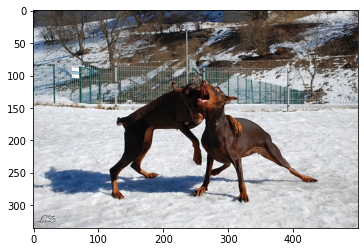

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A brown dog be run through a field .
bleu score:  7.657404561915943e-155


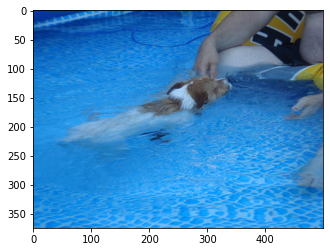

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A little boy be jump into a pool .
bleu score:  4.101791032784236e-78


In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==2):
    break

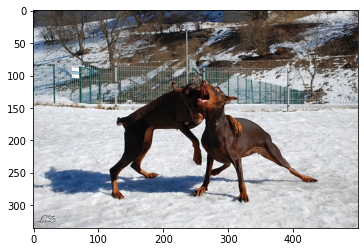

Referance Captions: 
Dog be in the snow in front of a fence .
Dog play on the snow .
Two brown dog playful fight in the snow .
Two brown dog wrestle in the snow .
Two dog play in the snow .
Predicted Caption: 
A brown dog be run through a field .
bleu score:  7.657404561915943e-155


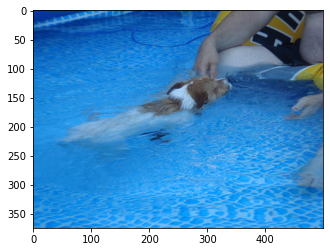

Referance Captions: 
a brown and white dog swim towards some in a pool
A dog in a swim pool swim toward sombody we cannot see .
A dog swim in a pool near a person .
Small dog be paddle through the water in a pool .
A small brown and white dog be in a pool .
Predicted Caption: 
A little boy be jump into a pool .
bleu score:  4.101791032784236e-78


In [ ]:
i=0
for img_id in test_features:
  i+=1
  img=cv2.imread("all_images/Flicker8k_Dataset"+ "/" + img_id)
  plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
  photo=test_features[img_id]
  plt.show()
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  print("Referance Captions: ")
  for cap in reference:
    print(" ".join(cap))
  print("Predicted Caption: ")
  print(" ".join(candidate))
  print("bleu score: ",score)
  if(i==2):
    break

In [ ]:
i=0
tot_score=0
for img_id in tqdm(test_features):
  i+=1
  photo=test_features[img_id]
  reference=[]
  for caps in test_captions[img_id]:
    list_caps=caps.split(" ")
    list_caps=list_caps[1:-1]
    reference.append(list_caps)
  candidate=greedy_search(photo)
  score = sentence_bleu(reference, candidate)
  tot_score+=score
avg_score=tot_score/i
print()
print("Bleu score on Greedy search")
print("Score: ",avg_score)

  3%|▎         | 31/1000 [00:38<23:06,  1.43s/it]/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|██████████| 1000/1000 [13:40<00:00,  1.22it/s]


Bleu score on Greedy search
Score:  0.07882817980995085
